In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # acf plot 및 pacf plot을 그리기 위한 라이브러리
from statsmodels.tsa.arima_model import ARIMA # ARIMA 모델
import pmdarima as pm # Auto ARIMA 모델
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import ta
import datetime
import scipy.stats as stats
from scipy.stats import pearsonr
import itertools
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm

In [2]:
train_df = pd.read_csv('store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
test_df = pd.read_csv('store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
#oil_df = pd.read_csv('store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
#transaction_df = pd.read_csv('store-sales-time-series-forecasting/transactions.csv', parse_dates=['date'])
stores_df = pd.read_csv('store-sales-time-series-forecasting/stores.csv')
holiday_event_df = pd.read_csv('store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])

In [3]:
#휴일이 아닌 날들 제외
#휴일이 아닌 날에 대한 조건들을 정의
is_work_day = holiday_event_df['type'] == 'Work Day'
is_transferred = holiday_event_df['transferred'] == True
is_event = holiday_event_df['type'] == 'Event'

holiday_event_df = holiday_event_df[~(is_work_day | is_transferred | is_event)]

#holiday_event_df = holiday_event_df.drop(columns=['locale','locale_name'])
holiday_event_df = holiday_event_df.drop(columns=['transferred'])
holiday_event_df.head()

,date,type,locale,locale_name,description
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba


In [4]:
# oil 가격의 결측치를 다음 날 가격으로 채우는 과정
#oil_df['dcoilwtico'] = oil_df['dcoilwtico'].interpolate(method='linear')

In [5]:
#transactions, oil 데이터는 상관 없는 것 같아서 삭제
def merge_func(X,a = stores_df):
    X = X.merge(a, on ='store_nbr')
    return X

train_df = merge_func(train_df)

In [6]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [7]:
def holiday_func(X,Y=holiday_event_df):
    
    #National 휴일 날짜를 모두 찾음
    national_holidays = Y[Y['locale'] == 'National']
    national_dates = set(national_holidays['date'])

    #Regional 휴일 중 X의 state와 일치하는 날짜를 찾음
    regional_holidays = Y[Y['locale'] == 'Regional']

    regional_matches = pd.merge(
        X[['date', 'state']],
        regional_holidays,
        left_on=['date', 'state'],
        right_on=['date', 'locale_name'])
    
    regional_dates = set(regional_matches['date'])

    #Local 휴일 중 X의 city와 일치하는 날짜를 찾음
    local_holidays = Y[Y['locale'] == 'Local']

    local_matches = pd.merge(
        X[['date', 'city']],
        local_holidays,
        left_on=['date', 'city'],
        right_on=['date', 'locale_name'])
    
    local_dates = set(local_matches['date'])

    #주말(토요일=5, 일요일=6)에 해당하는 날짜를 찾음
    weekend_dates = set(X[X['date'].dt.dayofweek >= 5]['date'])
    all_holiday_dates = national_dates.union(regional_dates, local_dates, weekend_dates)

    X['day_type'] = np.where(X['date'].isin(all_holiday_dates), 'holiday', 'weekday')
    X = X.drop(columns = ['city','state'],axis=1)
    return X

train_df = holiday_func(train_df)

In [8]:
train_df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
type           0
cluster        0
day_type       0
dtype: int64

In [9]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion,type,cluster,day_type
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,D,13,holiday
1,1,2013-01-01,1,BABY CARE,0.0,0,D,13,holiday
2,2,2013-01-01,1,BEAUTY,0.0,0,D,13,holiday
3,3,2013-01-01,1,BEVERAGES,0.0,0,D,13,holiday
4,4,2013-01-01,1,BOOKS,0.0,0,D,13,holiday


In [10]:
train_df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
type           0
cluster        0
day_type       0
dtype: int64

In [11]:
#train_df['dcoilwtico'] = train_df['dcoilwtico'].interpolate(method='linear')

In [12]:
train_df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
type           0
cluster        0
day_type       0
dtype: int64

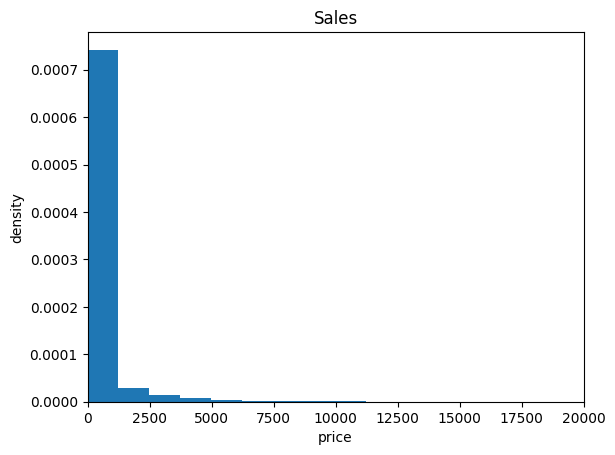

In [13]:
plt.hist(train_df['sales'], bins=100, density=True)
plt.title('Sales')
plt.xlabel('price')
plt.ylabel('density')
plt.xlim([0,20000])
plt.show()

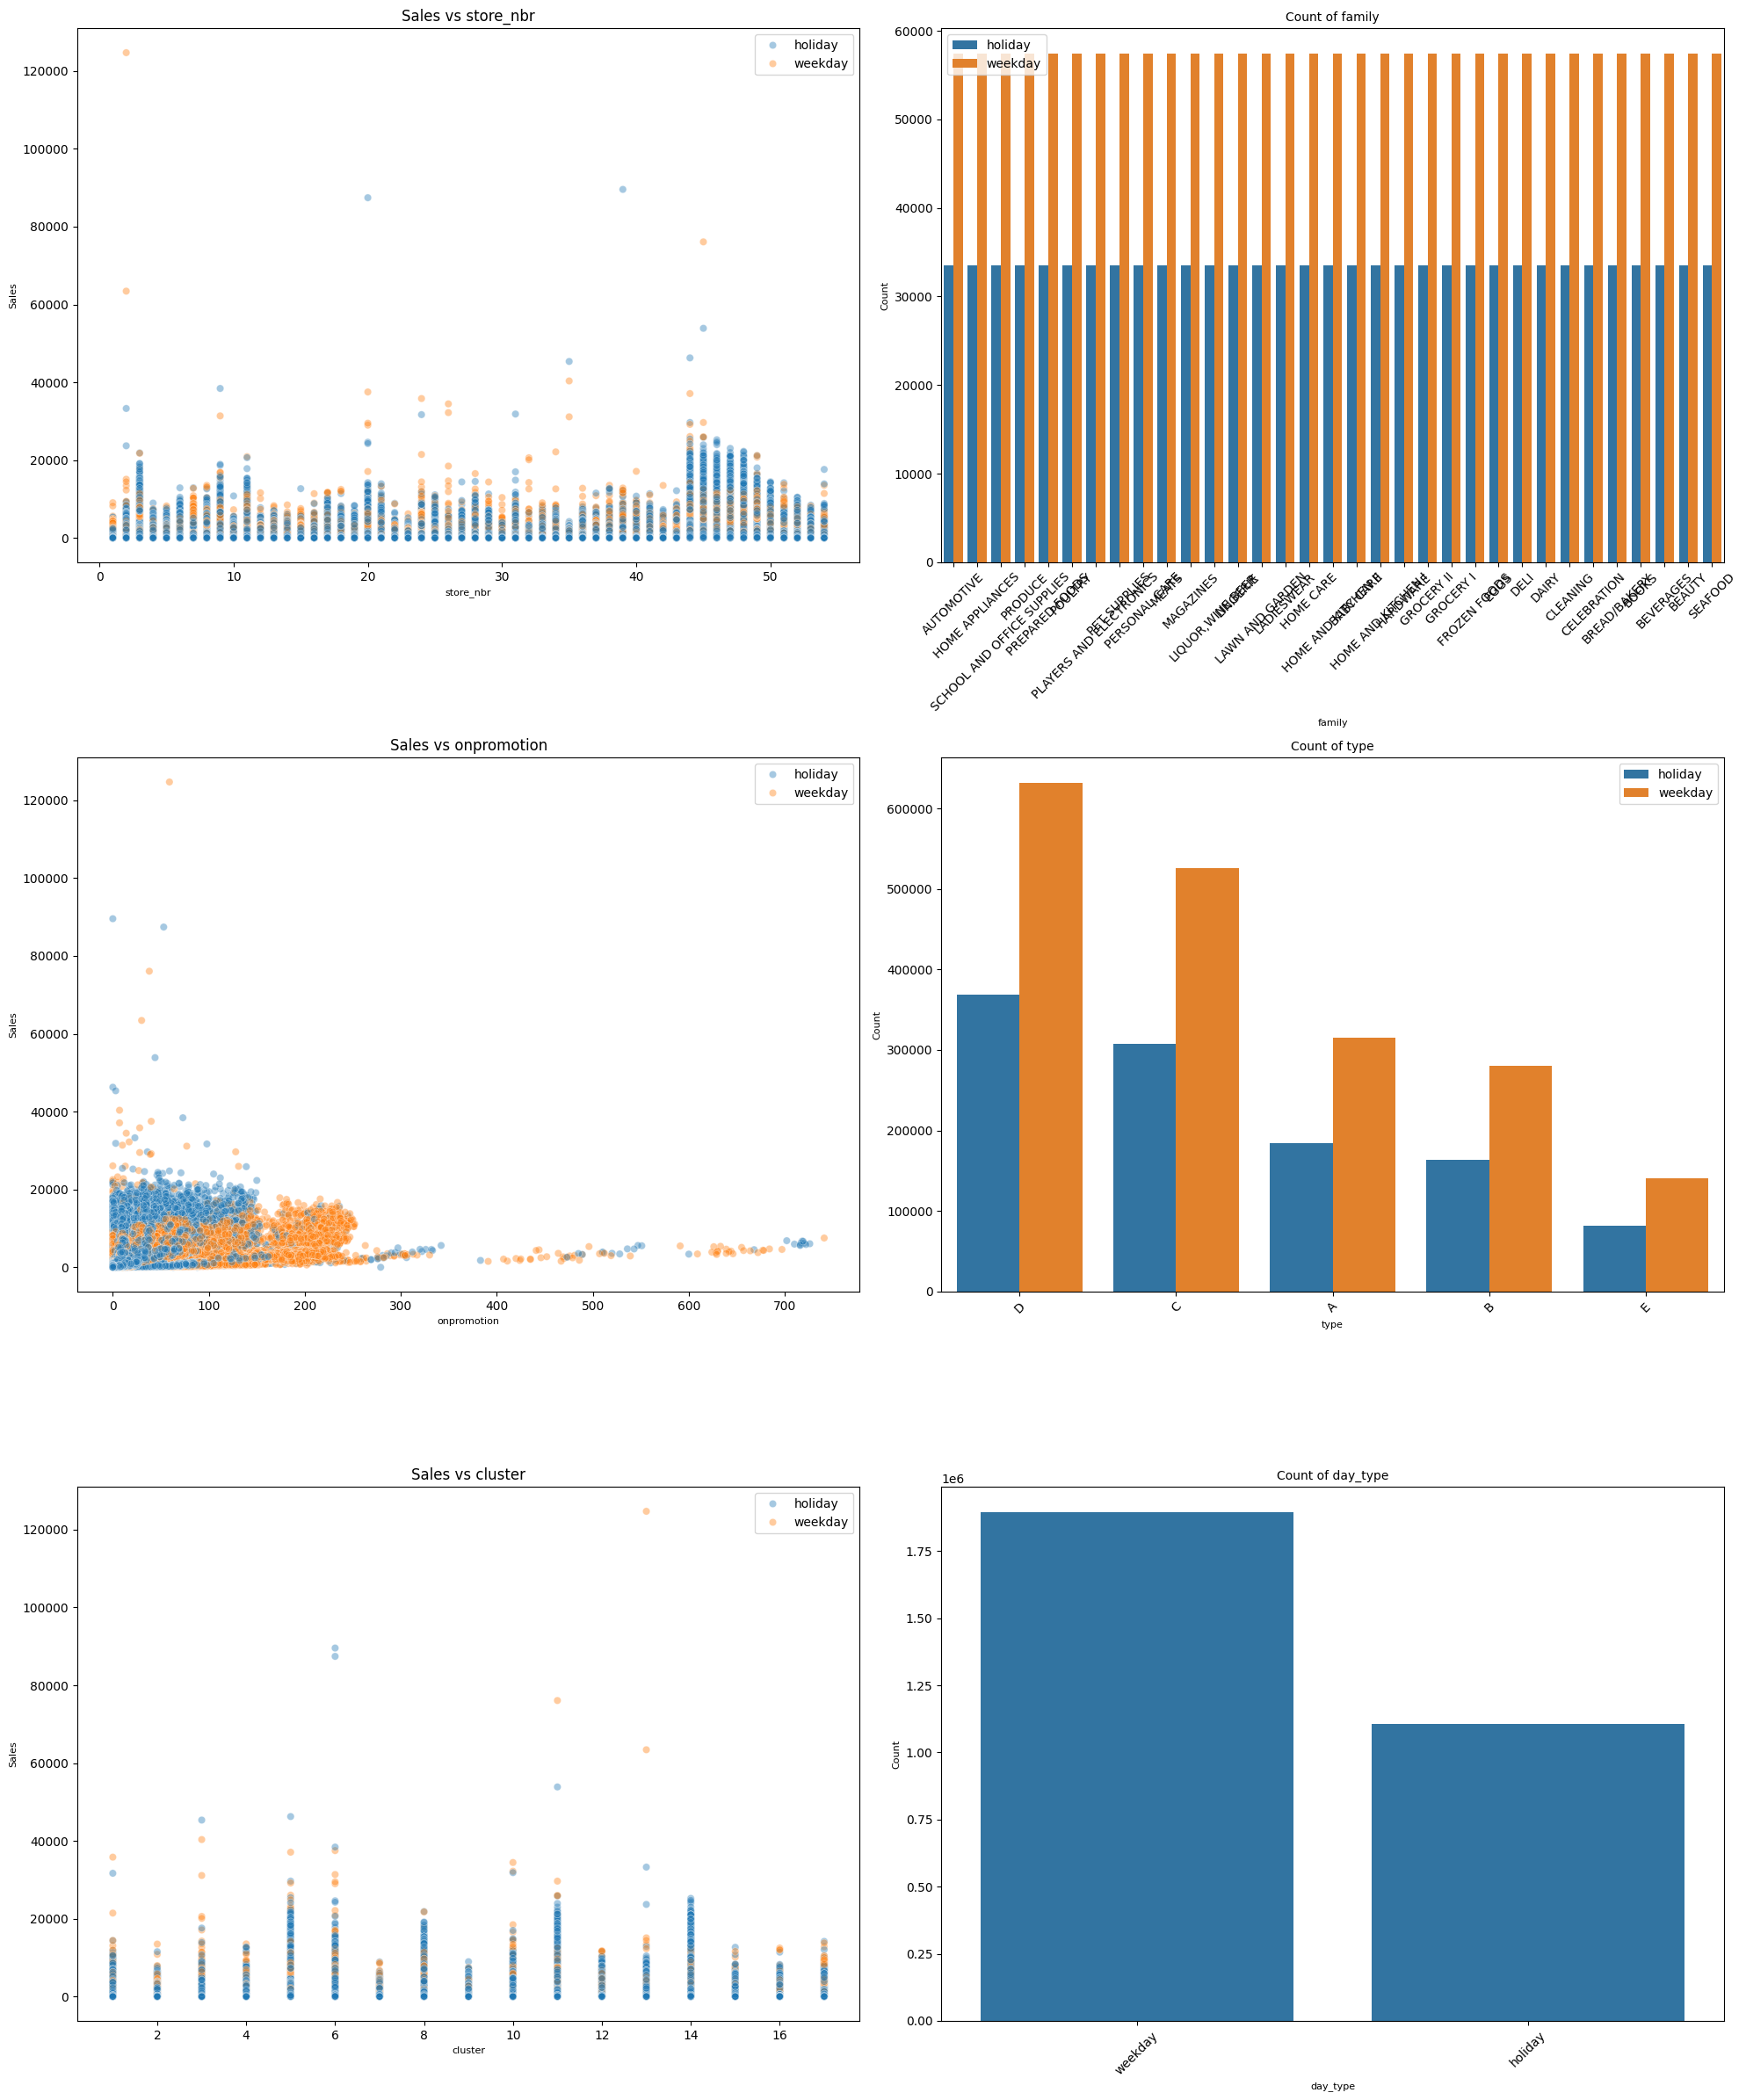

In [14]:
columns_to_plot = [col for col in train_df.columns if col not in ['id', 'date', 'sales']]

num_plots = len(columns_to_plot)
ncols = 2
nrows = math.ceil(num_plots / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 8 * nrows))
axes = axes.flatten()

for idx, column in enumerate(columns_to_plot):
    ax = axes[idx]

    if train_df[column].dtype in [np.int64, np.float64]:
        sns.scatterplot(data=train_df, x=column, y='sales', hue='day_type', alpha=0.4, ax=ax)
        ax.set_title(f'Sales vs {column}', fontsize=12)
        ax.set_xlabel(f'{column}', fontsize=8)
        ax.set_ylabel('Sales', fontsize=8)
        ax.legend(loc='best')

    elif train_df[column].dtype == 'object' or column == 'day_type':
        if column == 'day_type':
            sns.countplot(data=train_df, x=column, order=train_df[column].value_counts().index, ax=ax)
        else:
            sns.countplot(data=train_df, x=column, order=train_df[column].value_counts().index, hue='day_type', ax=ax)
        
        ax.set_title(f'Count of {column}', fontsize=10)
        ax.set_xlabel(column, fontsize=8)
        ax.set_ylabel('Count', fontsize=8)
        ax.tick_params(axis='x', rotation=45)
        if column != 'day_type':
            ax.legend(loc='best')

for i in range(num_plots, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

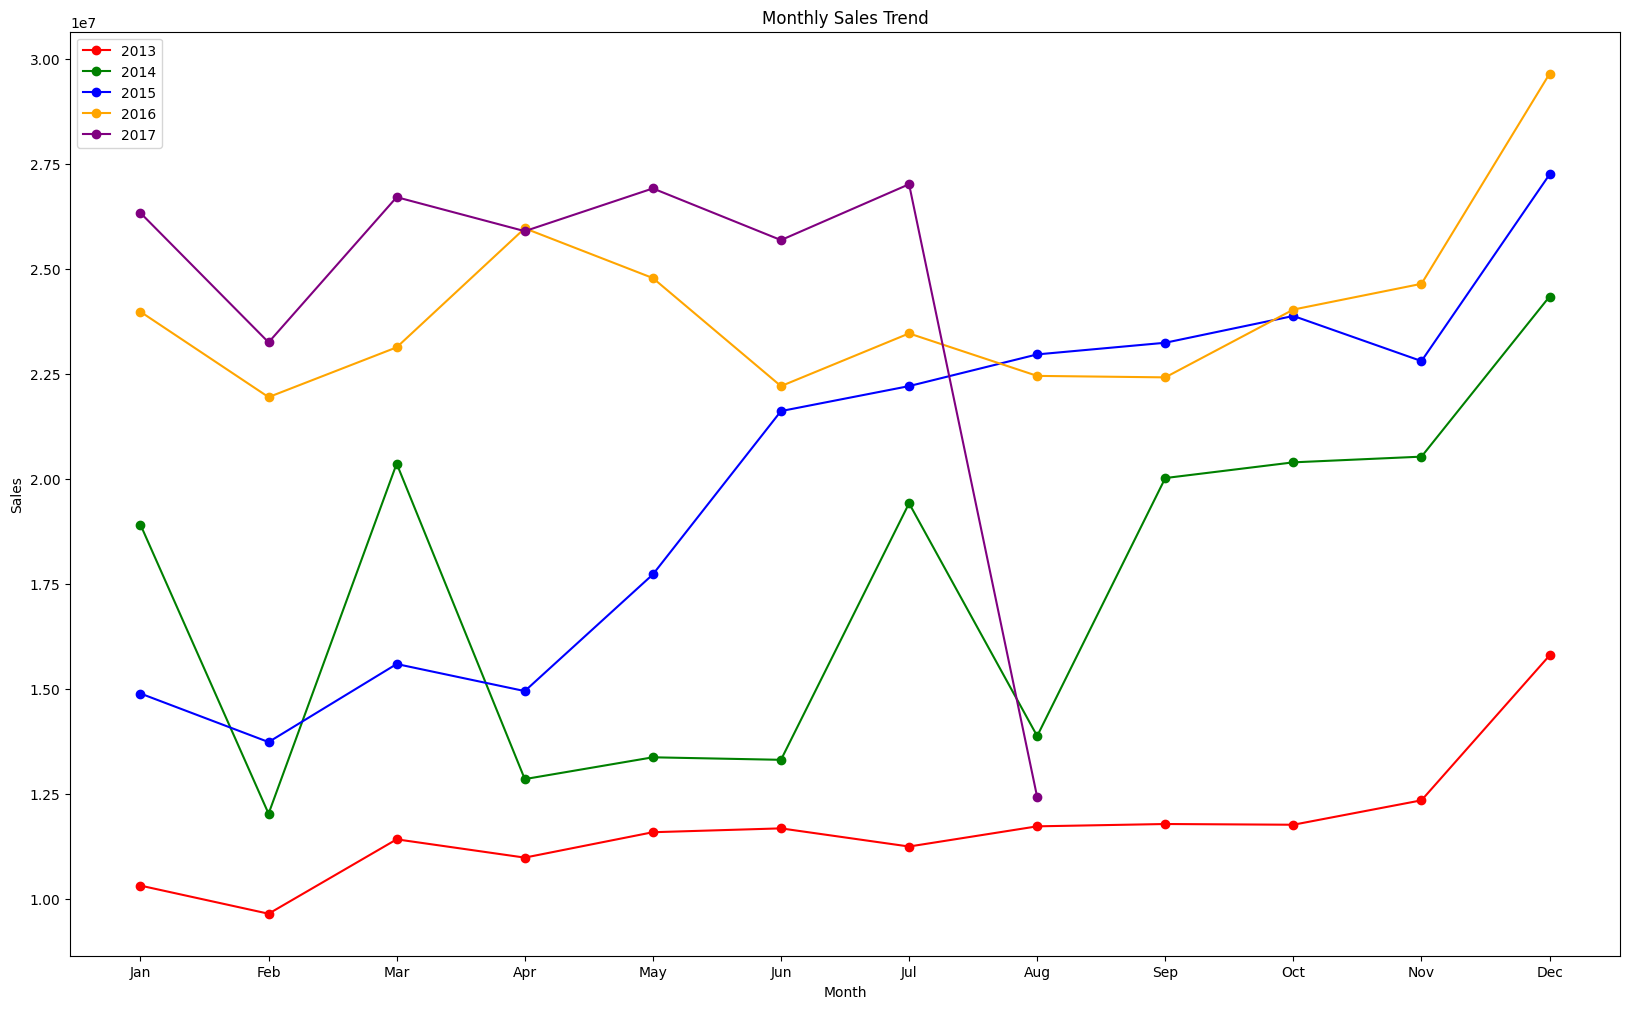

In [16]:
def feature_maker(X):
    X['day'] = X['date'].dt.day
    X['month'] = X['date'].dt.month
    X['year'] = X['date'].dt.year
    X['dayofweek'] = X['date'].dt.dayofweek
    X['sales_ma7'] = X['sales'].rolling(window=7).mean()
    X['sales_ma28'] = X['sales'].rolling(window=28).mean()
    X['sales_lag1'] = X['sales'].shift(1)
    X['sales_lag7'] = X['sales'].shift(7)
    return X

train_df = feature_maker(train_df)

monthly_sales = train_df.groupby(['month', 'year'])['sales'].sum().reset_index()

plt.figure(figsize=(20, 12))  
years = monthly_sales['year'].unique()
colors = itertools.cycle(['red', 'green', 'blue', 'orange', 'purple'])

for year in years:
    year_data = monthly_sales[monthly_sales['year'] == year]
    plt.plot(year_data['month'], year_data['sales'], marker='o', color=next(colors), label=str(year))

plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales Trend')

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1, 13), month_names)
plt.legend(loc='best')
plt.show()

In [20]:
train_df

,id,date,store_nbr,family,sales,onpromotion,type,cluster,day_type,day,month,year,dayofweek,sales_ma7,sales_ma28,sales_lag1,sales_lag7
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,D,13,holiday,1,1,2013,1,NaN,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,D,13,holiday,1,1,2013,1,NaN,NaN,0.000,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,D,13,holiday,1,1,2013,1,NaN,NaN,0.000,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,D,13,holiday,1,1,2013,1,NaN,NaN,0.000,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,D,13,holiday,1,1,2013,1,NaN,NaN,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,B,6,holiday,15,8,2017,1,208.194429,568.221250,6.000,6.000
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,B,6,holiday,15,8,2017,1,226.702000,573.741000,438.133,25.000
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,B,6,holiday,15,8,2017,1,570.806143,659.802750,154.553,11.000
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,B,6,holiday,15,8,2017,1,523.916429,538.052750,2419.729,449.228


In [32]:
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split 

X = train_df.drop(columns = ['id','sales','date'],axis=1)
y = np.log1p(train_df['sales'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,test_size=0.2, random_state=42)

In [ ]:
#MDI 분석
'''
rfc =RandomForestRegressor(random_state=42)
rfc.fit(X_final, y)

feat_imp_mdi = pd.DataFrame({'mean': rfc.feature_importances_}, index=X_final.columns)
feat_imp_mdi.sort_values('mean', ascending=True, inplace=True)

plt.figure(figsize=(10, len(feat_imp_mdi) / 3))
plt.title('MDI Feature Importance')
plt.barh(feat_imp_mdi.index, feat_imp_mdi['mean'], color='b', alpha=0.25)
plt.show()

print(feat_imp_mdi.sort_values('mean', ascending=False).head())
'''

In [ ]:
'''
rf = RandomForestRegressor(random_state=42)
rf.fit(X_final, y)

explainer = shap.Explainer(rf, X_final)
shap_values = explainer.shap_values(X_final)

shap.summary_plot(shap_values, X_final, plot_type="bar", class_names=['하락', '상승'])
shap.summary_plot(shap_values, X_final)
'''

In [22]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error

xgbr = XGBRegressor(tree_method = "hist", device = "cuda", n_estimators=1000,
                        learning_rate=0.05,
                        eval_metric ='rmse',max_depth=14,
                        random_state=42, early_stopping_rounds=50
                        ) 

xgbr.fit(X_tr, y_tr,  eval_set=[(X_tr, y_tr), (X_val, y_val)])

y_pred_log = xgbr.predict(X_val)
y_test_original = np.expm1(y_val)
y_pred_original = np.expm1(y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

y_pred_non_negative = np.maximum(0, y_pred_original)
msle = mean_squared_log_error(y_test_original, y_pred_non_negative)
rmsle = np.sqrt(msle)

print(f"RMSLE : {rmsle:.4f}")
print(f"MAE : {mae:,.2f}")
print(f"R² : {r2:.4f}")
print(f" XGBoost RMSE: ${rmse:,.2f}")

[0]	validation_0-rmse:2.58236	validation_1-rmse:2.58326
[1]	validation_0-rmse:2.47641	validation_1-rmse:2.47719
[2]	validation_0-rmse:2.37629	validation_1-rmse:2.37697
[3]	validation_0-rmse:2.28172	validation_1-rmse:2.28231
[4]	validation_0-rmse:2.19282	validation_1-rmse:2.19337
[5]	validation_0-rmse:2.10922	validation_1-rmse:2.10973
[6]	validation_0-rmse:2.03474	validation_1-rmse:2.03523
[7]	validation_0-rmse:1.96528	validation_1-rmse:1.96574
[8]	validation_0-rmse:1.89936	validation_1-rmse:1.89976
[9]	validation_0-rmse:1.83174	validation_1-rmse:1.83212
[10]	validation_0-rmse:1.76011	validation_1-rmse:1.76054
[11]	validation_0-rmse:1.69257	validation_1-rmse:1.69307
[12]	validation_0-rmse:1.62803	validation_1-rmse:1.62863
[13]	validation_0-rmse:1.56755	validation_1-rmse:1.56821
[14]	validation_0-rmse:1.51781	validation_1-rmse:1.51850
[15]	validation_0-rmse:1.46919	validation_1-rmse:1.46987
[16]	validation_0-rmse:1.42525	validation_1-rmse:1.42601
[17]	validation_0-rmse:1.38359	validation

In [33]:
from sklearn.model_selection import KFold
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import TimeSeriesSplit

xgb_search_space = {'max_depth': hp.quniform('max_depth', 4, 15, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
                    'subsample': hp.uniform('subsample', 0.2, 1),
                    'reg_alpha': hp.uniform('reg_alpha', 0.0001, 0.01),
                    'reg_lambda': hp.uniform('reg_lambda', 0.0001, 0.01)}

def objective_func(search_space):
    
    xgb_clf = XGBRegressor(
        n_estimators=2000,
        random_state=156,
        eval_metric='rmse',
        early_stopping_rounds=30, # early stopping 30회로 수정
        tree_method="hist",
        device="cuda",
        max_depth=int(search_space['max_depth']),
        min_child_weight=int(search_space['min_child_weight']),
        colsample_bytree=search_space['colsample_bytree'],
        learning_rate=search_space['learning_rate'],
        subsample=search_space['subsample'],
        reg_alpha=search_space['reg_alpha'],
        reg_lambda=search_space['reg_lambda']
    )

 
    rmsle_list = []
    #kf = KFold(n_splits=4)
    tscv = TimeSeriesSplit(n_splits=4)

    for tr_index, val_index in tscv.split(X_train):

        X_tr, X_val = X_train[tr_index], X_train[val_index]
        y_tr, y_val = y_train[tr_index], y_train[val_index]
        
        xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=0)
        
        y_pred_log = xgb_clf.predict(X_val)
        rmsle = np.sqrt(mean_squared_error(y_val, y_pred_log))
        rmsle_list.append(rmsle)
    
    avg_rmsle = np.mean(rmsle_list)
    return {'loss': avg_rmsle, 'status': STATUS_OK}

In [34]:
trials = Trials()
best = fmin(
    fn=objective_func,
    space=xgb_search_space,
    algo=tpe.suggest,
    max_evals=150,
    trials=trials,
    rstate=np.random.default_rng(seed=30)
)

print('best:', best)

  0%|          | 0/150 [00:00<?, ?trial/s, best loss=?]

job exception: '[1, 5, 9, 11, 12, 24, 27, 29, 30, 33, 36, 52, 53, 54, 55, 58, 60, 68, 72, 74, 78, 79, 83, 90, 92, 93, 94, 102, 112, 127, 130, 131, 135, 138, 148, 153, 155, 164, 175, 177, 178, 185, 194, 196, 198, 216, 217, 221, 236, 246, 256, 258, 270, 273, 276, 277, 279, 292, 297, 299, 303, 320, 321, 324, 327, 335, 337, 338, 350, 366, 393, 395, 407, 417, 421, 426, 430, 434, 440, 442, 445, 449, 458, 459, 475, 479, 486, 490, 497, 502, 514, 515, 520, 526, 528, 533, 537, 541, 542, 543, 551, 554, 558, 567, 569, 571, 574, 577, 582, 585, 595, 596, 601, 610, 620, 621, 622, 623, 628, 632, 636, 640, 642, 652, 653, 654, 657, 664, 665, 668, 673, 675, 682, 690, 696, 698, 701, 718, 720, 721, 722, 724, 729, 739, 743, 748, 749, 750, 759, 771, 774, 780, 783, 787, 795, 799, 801, 802, 808, 809, 815, 820, 822, 831, 832, 839, 846, 851, 856, 861, 863, 880, 886, 890, 893, 895, 896, 898, 899, 900, 906, 909, 915, 916, 918, 919, 922, 924, 931, 937, 940, 941, 947, 948, 951, 957, 959, 961, 967, 968, 969, 970, 971

  0%|          | 0/150 [00:00<?, ?trial/s, best loss=?]


KeyError: '[1, 5, 9, 11, 12, 24, 27, 29, 30, 33, 36, 52, 53, 54, 55, 58, 60, 68, 72, 74, 78, 79, 83, 90, 92, 93, 94, 102, 112, 127, 130, 131, 135, 138, 148, 153, 155, 164, 175, 177, 178, 185, 194, 196, 198, 216, 217, 221, 236, 246, 256, 258, 270, 273, 276, 277, 279, 292, 297, 299, 303, 320, 321, 324, 327, 335, 337, 338, 350, 366, 393, 395, 407, 417, 421, 426, 430, 434, 440, 442, 445, 449, 458, 459, 475, 479, 486, 490, 497, 502, 514, 515, 520, 526, 528, 533, 537, 541, 542, 543, 551, 554, 558, 567, 569, 571, 574, 577, 582, 585, 595, 596, 601, 610, 620, 621, 622, 623, 628, 632, 636, 640, 642, 652, 653, 654, 657, 664, 665, 668, 673, 675, 682, 690, 696, 698, 701, 718, 720, 721, 722, 724, 729, 739, 743, 748, 749, 750, 759, 771, 774, 780, 783, 787, 795, 799, 801, 802, 808, 809, 815, 820, 822, 831, 832, 839, 846, 851, 856, 861, 863, 880, 886, 890, 893, 895, 896, 898, 899, 900, 906, 909, 915, 916, 918, 919, 922, 924, 931, 937, 940, 941, 947, 948, 951, 957, 959, 961, 967, 968, 969, 970, 971, 980, 981, 985, 1002, 1015, 1017, 1024, 1031, 1045, 1049, 1052, 1059, 1061, 1068, 1070, 1075, 1077, 1079, 1089, 1100, 1107, 1116, 1120, 1124, 1127, 1130, 1131, 1132, 1141, 1144, 1145, 1153, 1154, 1157, 1160, 1162, 1165, 1166, 1169, 1172, 1174, 1175, 1178, 1182, 1200, 1206, 1213, 1216, 1218, 1225, 1231, 1244, 1257, 1280, 1281, 1283, 1289, 1292, 1295, 1296, 1297, 1301, 1309, 1311, 1312, 1314, 1318, 1322, 1332, 1334, 1340, 1342, 1344, 1356, 1358, 1365, 1366, 1370, 1376, 1377, 1378, 1381, 1383, 1385, 1393, 1400, 1405, 1419, 1421, 1423, 1424, 1425, 1430, 1435, 1441, 1449, 1451, 1453, 1455, 1456, 1460, 1461, 1473, 1477, 1480, 1492, 1499, 1504, 1507, 1525, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1542, 1544, 1549, 1553, 1555, 1558, 1559, 1574, 1583, 1588, 1589, 1592, 1598, 1602, 1603, 1606, 1608, 1611, 1630, 1636, 1637, 1638, 1645, 1648, 1649, 1651, 1657, 1666, 1669, 1672, 1697, 1698, 1713, 1716, 1724, 1735, 1738, 1739, 1748, 1753, 1760, 1763, 1764, 1768, 1771, 1779, 1785, 1793, 1795, 1805, 1810, 1811, 1816, 1837, 1846, 1850, 1854, 1856, 1857, 1858, 1860, 1863, 1864, 1865, 1867, 1868, 1871, 1882, 1888, 1906, 1914, 1915, 1920, 1922, 1925, 1926, 1933, 1941, 1954, 1961, 1967, 1968, 1973, 1987, 1988, 1995, 2002, 2005, 2008, 2009, 2012, 2013, 2017, 2018, 2028, 2034, 2042, 2051, 2052, 2057, 2069, 2072, 2074, 2083, 2086, 2088, 2090, 2091, 2093, 2101, 2108, 2116, 2123, 2125, 2126, 2128, 2132, 2133, 2138, 2148, 2160, 2167, 2169, 2177, 2182, 2188, 2190, 2204, 2207, 2208, 2215, 2219, 2221, 2223, 2229, 2233, 2234, 2237, 2242, 2244, 2247, 2252, 2253, 2255, 2257, 2272, 2276, 2281, 2283, 2292, 2293, 2301, 2304, 2307, 2312, 2313, 2318, 2319, 2321, 2329, 2335, 2341, 2343, 2347, 2348, 2357, 2358, 2361, 2369, 2371, 2376, 2380, 2389, 2395, 2399, 2409, 2410, 2412, 2413, 2419, 2421, 2422, 2425, 2434, 2444, 2446, 2455, 2457, 2459, 2460, 2469, 2473, 2477, 2485, 2491, 2492, 2502, 2512, 2517, 2534, 2535, 2536, 2555, 2558, 2566, 2571, 2573, 2578, 2601, 2610, 2612, 2613, 2623, 2625, 2635, 2637, 2640, 2649, 2651, 2668, 2676, 2699, 2709, 2713, 2719, 2724, 2727, 2742, 2745, 2746, 2756, 2762, 2767, 2770, 2774, 2778, 2789, 2791, 2797, 2804, 2807, 2813, 2821, 2827, 2829, 2830, 2843, 2846, 2851, 2856, 2863, 2870, 2871, 2882, 2883, 2889, 2898, 2899, 2905, 2907, 2916, 2922, 2926, 2932, 2933, 2936, 2938, 2941, 2947, 2952, 2958, 2962, 2964, 2976, 2980, 2981, 2988, 2994, 2998, 2999, 3001, 3006, 3008, 3009, 3012, 3014, 3020, 3028, 3035, 3036, 3045, 3049, 3050, 3057, 3068, 3069, 3081, 3082, 3088, 3089, 3092, 3095, 3115, 3119, 3131, 3139, 3140, 3142, 3144, 3147, 3148, 3149, 3153, 3156, 3160, 3165, 3166, 3178, 3182, 3185, 3201, 3202, 3204, 3207, 3208, 3215, 3221, 3223, 3228, 3235, 3236, 3244, 3246, 3259, 3261, 3269, 3270, 3272, 3277, 3281, 3287, 3295, 3298, 3303, 3304, 3316, 3320, 3322, 3334, 3339, 3349, 3351, 3357, 3358, 3377, 3384, 3391, 3396, 3403, 3407, 3416, 3417, 3428, 3442, 3453, 3457, 3458, 3460, 3470, 3472, 3475, 3480, 3488, 3491, 3494, 3495, 3498, 3501, 3507, 3514, 3522, 3523, 3527, 3528, 3533, 3539, 3544, 3545, 3555, 3564, 3583, 3588, 3605, 3606, 3610, 3614, 3620, 3624, 3638, 3655, 3656, 3665, 3672, 3674, 3678, 3681, 3682, 3685, 3688, 3690, 3694, 3698, 3700, 3701, 3708, 3709, 3711, 3722, 3730, 3732, 3737, 3739, 3748, 3749, 3751, 3773, 3780, 3782, 3786, 3789, 3803, 3805, 3810, 3814, 3827, 3836, 3850, 3853, 3858, 3860, 3867, 3868, 3869, 3871, 3874, 3876, 3889, 3893, 3898, 3902, 3907, 3908, 3912, 3914, 3916, 3922, 3923, 3924, 3926, 3927, 3930, 3931, 3933, 3937, 3944, 3948, 3954, 3958, 3962, 3963, 3964, 3975, 3977, 3982, 3983, 3985, 3997, 4000, 4009, 4016, 4020, 4021, 4024, 4031, 4040, 4058, 4074, 4077, 4078, 4090, 4094, 4095, 4105, 4108, 4111, 4113, 4119, 4126, 4132, 4133, 4137, 4144, 4151, 4157, 4164, 4172, 4174, 4177, 4178, 4182, 4186, 4187, 4196, 4200, 4208, 4209, 4211, 4215, 4216, 4218, 4229, 4233, 4238, 4255, 4264, 4272, 4280, 4283, 4285, 4294, 4295, 4306, 4310, 4317, 4323, 4324, 4336, 4337, 4339, 4352, 4354, 4360, 4361, 4363, 4370, 4372, 4383, 4384, 4390, 4391, 4392, 4394, 4401, 4402, 4405, 4409, 4416, 4419, 4421, 4426, 4436, 4439, 4443, 4447, 4450, 4453, 4456, 4457, 4465, 4469, 4472, 4474, 4476, 4480, 4484, 4497, 4500, 4515, 4521, 4523, 4524, 4525, 4534, 4537, 4541, 4543, 4548, 4550, 4557, 4561, 4563, 4578, 4583, 4585, 4587, 4590, 4598, 4601, 4605, 4614, 4618, 4621, 4628, 4629, 4643, 4649, 4656, 4663, 4664, 4666, 4668, 4672, 4674, 4681, 4682, 4683, 4688, 4689, 4692, 4696, 4700, 4701, 4723, 4729, 4736, 4737, 4740, 4742, 4743, 4748, 4757, 4758, 4769, 4771, 4786, 4797, 4798, 4810, 4812, 4813, 4814, 4817, 4822, 4835, 4838, 4840, 4843, 4850, 4851, 4853, 4855, 4857, 4859, 4864, 4870, 4872, 4873, 4876, 4889, 4891, 4893, 4900, 4908, 4920, 4922, 4925, 4933, 4934, 4945, 4946, 4968, 4988, 4992, 4998, 5000, 5002, 5005, 5011, 5022, 5025, 5029, 5034, 5035, 5038, 5039, 5044, 5049, 5056, 5066, 5067, 5069, 5073, 5074, 5078, 5079, 5086, 5090, 5091, 5112, 5115, 5120, 5124, 5132, 5135, 5138, 5151, 5153, 5154, 5162, 5163, 5167, 5171, 5174, 5175, 5177, 5184, 5193, 5201, 5203, 5210, 5215, 5216, 5222, 5227, 5241, 5244, 5251, 5257, 5259, 5262, 5270, 5276, 5277, 5282, 5292, 5299, 5302, 5303, 5306, 5308, 5309, 5320, 5328, 5331, 5357, 5361, 5367, 5374, 5388, 5389, 5397, 5400, 5402, 5408, 5416, 5431, 5434, 5445, 5449, 5450, 5451, 5455, 5460, 5463, 5470, 5479, 5480, 5481, 5483, 5488, 5496, 5505, 5506, 5510, 5514, 5524, 5528, 5533, 5534, 5535, 5538, 5542, 5548, 5551, 5552, 5555, 5562, 5563, 5564, 5565, 5567, 5582, 5583, 5585, 5600, 5605, 5606, 5618, 5623, 5629, 5630, 5638, 5641, 5642, 5644, 5658, 5669, 5670, 5671, 5681, 5683, 5685, 5690, 5698, 5708, 5710, 5727, 5730, 5735, 5746, 5755, 5762, 5781, 5784, 5791, 5795, 5796, 5801, 5809, 5810, 5815, 5816, 5825, 5828, 5839, 5844, 5845, 5855, 5858, 5863, 5865, 5866, 5870, 5874, 5881, 5885, 5891, 5896, 5905, 5906, 5911, 5913, 5914, 5916, 5925, 5940, 5946, 5950, 5951, 5963, 5983, 5994, 5995, 5996, 6002, 6003, 6009, 6022, 6025, 6029, 6042, 6049, 6051, 6061, 6069, 6070, 6072, 6074, 6075, 6080, 6090, 6092, 6096, 6098, 6102, 6107, 6110, 6118, 6121, 6129, 6130, 6136, 6139, 6141, 6146, 6148, 6155, 6158, 6160, 6165, 6168, 6177, 6183, 6196, 6199, 6201, 6205, 6207, 6211, 6226, 6227, 6230, 6234, 6238, 6258, 6265, 6266, 6267, 6268, 6269, 6270, 6271, 6278, 6280, 6284, 6291, 6292, 6299, 6312, 6322, 6323, 6324, 6331, 6335, 6337, 6339, 6345, 6348, 6353, 6359, 6371, 6375, 6376, 6380, 6382, 6389, 6393, 6396, 6403, 6408, 6410, 6411, 6417, 6428, 6429, 6433, 6434, 6441, 6442, 6452, 6454, 6457, 6465, 6471, 6484, 6490, 6492, 6499, 6514, 6528, 6543, 6550, 6557, 6562, 6567, 6569, 6571, 6572, 6575, 6580, 6581, 6582, 6585, 6597, 6603, 6609, 6610, 6613, 6621, 6633, 6634, 6640, 6646, 6648, 6649, 6650, 6652, 6654, 6655, 6657, 6667, 6676, 6679, 6681, 6683, 6684, 6688, 6703, 6708, 6713, 6717, 6723, 6729, 6740, 6744, 6757, 6761, 6770, 6777, 6782, 6784, 6789, 6790, 6791, 6801, 6803, 6808, 6817, 6827, 6829, 6839, 6844, 6849, 6854, 6858, 6864, 6871, 6900, 6905, 6907, 6908, 6913, 6931, 6935, 6937, 6940, 6945, 6946, 6950, 6956, 6971, 6975, 6981, 6985, 6994, 7002, 7012, 7021, 7023, 7026, 7029, 7033, 7040, 7054, 7056, 7064, 7078, 7079, 7085, 7098, 7100, 7105, 7109, 7115, 7118, 7122, 7126, 7128, 7133, 7135, 7147, 7148, 7153, 7156, 7160, 7161, 7162, 7172, 7179, 7190, 7194, 7207, 7213, 7220, 7224, 7227, 7235, 7236, 7240, 7241, 7245, 7252, 7253, 7264, 7266, 7267, 7268, 7271, 7275, 7276, 7281, 7298, 7299, 7316, 7319, 7324, 7327, 7328, 7329, 7341, 7343, 7347, 7349, 7356, 7358, 7359, 7373, 7376, 7378, 7382, 7383, 7387, 7389, 7391, 7397, 7405, 7415, 7441, 7442, 7448, 7449, 7470, 7486, 7488, 7492, 7496, 7503, 7507, 7512, 7513, 7515, 7519, 7520, 7524, 7528, 7533, 7535, 7545, 7550, 7551, 7557, 7564, 7565, 7570, 7574, 7577, 7584, 7591, 7608, 7611, 7614, 7616, 7617, 7639, 7641, 7643, 7644, 7657, 7659, 7664, 7665, 7679, 7682, 7684, 7689, 7696, 7697, 7699, 7700, 7702, 7703, 7704, 7706, 7714, 7717, 7720, 7723, 7727, 7730, 7733, 7735, 7738, 7741, 7743, 7745, 7746, 7748, 7750, 7755, 7756, 7759, 7772, 7775, 7776, 7787, 7795, 7802, 7806, 7807, 7810, 7818, 7819, 7821, 7822, 7840, 7849, 7869, 7870, 7871, 7882, 7886, 7890, 7895, 7896, 7900, 7902, 7910, 7916, 7925, 7937, 7939, 7940, 7943, 7950, 7961, 7962, 7965, 7996, 7998, 7999, 8011, 8018, 8019, 8020, 8028, 8030, 8033, 8042, 8049, 8061, 8063, 8070, 8071, 8073, 8075, 8084, 8086, 8093, 8094, 8096, 8106, 8117, 8123, 8126, 8128, 8134, 8139, 8142, 8144, 8145, 8149, 8151, 8154, 8155, 8159, 8165, 8167, 8170, 8174, 8175, 8188, 8192, 8196, 8209, 8214, 8220, 8228, 8229, 8251, 8252, 8259, 8264, 8265, 8266, 8273, 8276, 8286, 8287, 8290, 8293, 8301, 8302, 8310, 8319, 8320, 8330, 8338, 8339, 8340, 8349, 8351, 8352, 8355, 8359, 8361, 8365, 8366, 8368, 8377, 8386, 8396, 8407, 8413, 8414, 8416, 8422, 8435, 8437, 8448, 8450, 8451, 8454, 8459, 8462, 8474, 8479, 8481, 8482, 8494, 8498, 8506, 8508, 8511, 8513, 8520, 8526, 8528, 8532, 8533, 8542, 8547, 8548, 8549, 8556, 8563, 8565, 8567, 8569, 8573, 8579, 8581, 8582, 8597, 8600, 8603, 8605, 8610, 8626, 8634, 8635, 8636, 8637, 8638, 8640, 8644, 8649, 8652, 8662, 8676, 8681, 8683, 8697, 8702, 8713, 8717, 8729, 8738, 8739, 8745, 8749, 8751, 8753, 8757, 8759, 8761, 8764, 8766, 8770, 8772, 8778, 8787, 8792, 8793, 8794, 8805, 8815, 8817, 8820, 8825, 8826, 8827, 8832, 8834, 8835, 8837, 8849, 8853, 8855, 8860, 8868, 8876, 8881, 8882, 8885, 8892, 8893, 8896, 8901, 8904, 8905, 8911, 8925, 8930, 8946, 8958, 8959, 8963, 8975, 8977, 8980, 8985, 8987, 8990, 8991, 9001, 9007, 9011, 9016, 9020, 9029, 9032, 9033, 9036, 9039, 9040, 9044, 9050, 9058, 9062, 9063, 9074, 9076, 9078, 9083, 9084, 9089, 9090, 9092, 9093, 9096, 9101, 9109, 9111, 9117, 9122, 9128, 9150, 9153, 9155, 9162, 9163, 9172, 9178, 9180, 9189, 9192, 9193, 9196, 9198, 9199, 9202, 9204, 9205, 9208, 9219, 9220, 9227, 9229, 9246, 9253, 9271, 9272, 9276, 9278, 9289, 9291, 9295, 9317, 9321, 9323, 9326, 9328, 9330, 9331, 9339, 9346, 9347, 9348, 9351, 9353, 9354, 9359, 9371, 9382, 9384, 9395, 9396, 9397, 9402, 9405, 9410, 9411, 9423, 9424, 9428, 9430, 9439, 9441, 9448, 9450, 9464, 9477, 9481, 9491, 9494, 9500, 9515, 9530, 9531, 9533, 9537, 9548, 9555, 9561, 9573, 9577, 9593, 9597, 9600, 9611, 9615, 9622, 9630, 9632, 9634, 9638, 9643, 9652, 9655, 9671, 9673, 9687, 9689, 9695, 9696, 9703, 9704, 9711, 9712, 9717, 9718, 9730, 9737, 9743, 9745, 9746, 9751, 9761, 9763, 9767, 9769, 9771, 9775, 9776, 9779, 9785, 9790, 9792, 9797, 9800, 9803, 9808, 9809, 9820, 9821, 9838, 9844, 9861, 9863, 9871, 9873, 9874, 9876, 9880, 9881, 9883, 9886, 9889, 9891, 9893, 9900, 9902, 9910, 9911, 9914, 9915, 9916, 9917, 9918, 9928, 9929, 9932, 9939, 9953, 9956, 9971, 9973, 9975, 9976, 9982, 9986, 9992, 9994, 9996, 10012, 10020, 10035, 10036, 10037, 10040, 10048, 10049, 10055, 10057, 10064, 10068, 10077, 10080, 10081, 10082, 10083, 10085, 10101, 10103, 10109, 10116, 10125, 10130, 10136, 10137, 10141, 10142, 10145, 10147, 10149, 10155, 10158, 10163, 10166, 10172, 10175, 10177, 10189, 10191, 10196, 10200, 10205, 10219, 10225, 10229, 10231, 10235, 10244, 10251, 10259, 10261, 10272, 10275, 10276, 10279, 10286, 10290, 10292, 10301, 10304, 10306, 10315, 10317, 10318, 10322, 10328, 10332, 10348, 10364, 10382, 10383, 10384, 10388, 10389, 10396, 10398, 10402, 10403, 10407, 10409, 10411, 10413, 10418, 10423, 10424, 10443, 10444, 10446, 10450, 10459, 10461, 10481, 10483, 10489, 10492, 10494, 10498, 10504, 10507, 10508, 10512, 10513, 10517, 10518, 10552, 10553, 10555, 10561, 10569, 10574, 10579, 10583, 10585, 10588, 10596, 10600, 10612, 10620, 10621, 10635, 10637, 10639, 10645, 10653, 10654, 10670, 10672, 10677, 10695, 10704, 10712, 10715, 10721, 10731, 10733, 10741, 10742, 10763, 10774, 10775, 10784, 10787, 10790, 10798, 10799, 10800, 10802, 10804, 10805, 10816, 10817, 10834, 10835, 10837, 10838, 10846, 10848, 10851, 10856, 10859, 10864, 10867, 10874, 10894, 10901, 10902, 10911, 10917, 10919, 10922, 10925, 10929, 10931, 10936, 10937, 10945, 10958, 10960, 10962, 10965, 10966, 10977, 10979, 10983, 10988, 10992, 11010, 11015, 11022, 11023, 11024, 11027, 11034, 11036, 11038, 11039, 11048, 11053, 11057, 11072, 11074, 11079, 11082, 11093, 11096, 11101, 11103, 11106, 11107, 11123, 11128, 11130, 11131, 11132, 11134, 11138, 11141, 11166, 11167, 11170, 11177, 11188, 11190, 11195, 11196, 11206, 11208, 11212, 11214, 11217, 11218, 11219, 11221, 11236, 11239, 11248, 11250, 11251, 11253, 11254, 11256, 11257, 11262, 11264, 11265, 11266, 11268, 11273, 11279, 11280, 11281, 11282, 11306, 11310, 11312, 11313, 11320, 11327, 11328, 11331, 11337, 11372, 11377, 11379, 11386, 11387, 11392, 11400, 11406, 11408, 11410, 11412, 11429, 11431, 11433, 11442, 11451, 11453, 11457, 11467, 11468, 11477, 11482, 11487, 11488, 11489, 11496, 11501, 11502, 11504, 11509, 11510, 11515, 11516, 11520, 11521, 11524, 11530, 11532, 11534, 11536, 11540, 11543, 11546, 11547, 11552, 11556, 11560, 11577, 11583, 11590, 11596, 11599, 11603, 11610, 11616, 11617, 11625, 11643, 11647, 11651, 11657, 11658, 11662, 11663, 11666, 11668, 11672, 11673, 11678, 11681, 11686, 11687, 11700, 11701, 11718, 11724, 11725, 11728, 11735, 11748, 11751, 11762, 11764, 11765, 11767, 11768, 11771, 11772, 11777, 11782, 11783, 11792, 11795, 11796, 11800, 11803, 11806, 11810, 11811, 11812, 11826, 11828, 11833, 11838, 11852, 11863, 11866, 11873, 11876, 11878, 11890, 11893, 11894, 11906, 11907, 11908, 11928, 11947, 11963, 11965, 11969, 11973, 11989, 11991, 11993, 11996, 12009, 12014, 12022, 12024, 12028, 12031, 12040, 12043, 12046, 12048, 12052, 12059, 12064, 12077, 12084, 12086, 12089, 12097, 12100, 12116, 12125, 12139, 12140, 12141, 12149, 12160, 12162, 12164, 12166, 12171, 12181, 12182, 12183, 12194, 12200, 12204, 12205, 12210, 12211, 12216, 12239, 12244, 12256, 12260, 12266, 12275, 12279, 12280, 12282, 12285, 12290, 12295, 12297, 12299, 12312, 12322, 12324, 12325, 12330, 12333, 12334, 12344, 12345, 12346, 12347, 12357, 12359, 12369, 12372, 12374, 12375, 12382, 12385, 12396, 12413, 12422, 12424, 12426, 12429, 12430, 12432, 12434, 12435, 12438, 12442, 12445, 12447, 12463, 12464, 12465, 12470, 12475, 12476, 12477, 12479, 12493, 12498, 12501, 12504, 12506, 12508, 12509, 12526, 12532, 12539, 12541, 12551, 12561, 12570, 12577, 12578, 12579, 12582, 12595, 12597, 12600, 12604, 12624, 12632, 12638, 12641, 12644, 12647, 12655, 12658, 12659, 12660, 12661, 12663, 12666, 12674, 12690, 12693, 12694, 12698, 12700, 12701, 12709, 12711, 12714, 12737, 12738, 12748, 12752, 12759, 12763, 12765, 12768, 12772, 12775, 12779, 12786, 12792, 12794, 12803, 12805, 12809, 12810, 12819, 12826, 12830, 12836, 12837, 12838, 12852, 12854, 12859, 12861, 12865, 12880, 12888, 12889, 12910, 12912, 12916, 12917, 12921, 12922, 12923, 12928, 12930, 12934, 12936, 12937, 12952, 12961, 12962, 12973, 12974, 12978, 12981, 12989, 12996, 13002, 13006, 13011, 13012, 13016, 13017, 13018, 13019, 13034, 13035, 13048, 13055, 13061, 13072, 13073, 13074, 13076, 13079, 13085, 13089, 13092, 13095, 13099, 13101, 13111, 13123, 13126, 13127, 13136, 13148, 13149, 13151, 13153, 13154, 13155, 13157, 13165, 13172, 13177, 13180, 13187, 13190, 13195, 13212, 13218, 13225, 13228, 13230, 13232, 13233, 13234, 13244, 13251, 13270, 13282, 13290, 13295, 13296, 13299, 13300, 13303, 13327, 13330, 13333, 13339, 13340, 13346, 13348, 13349, 13352, 13357, 13364, 13366, 13372, 13373, 13380, 13381, 13385, 13403, 13406, 13409, 13416, 13419, 13431, 13443, 13444, 13447, 13449, 13451, 13452, 13457, 13463, 13469, 13489, 13497, 13498, 13499, 13504, 13514, 13517, 13520, 13522, 13525, 13534, 13537, 13540, 13542, 13543, 13546, 13549, 13553, 13554, 13556, 13566, 13581, 13582, 13585, 13598, 13608, 13612, 13613, 13619, 13622, 13634, 13637, 13640, 13647, 13651, 13656, 13662, 13671, 13678, 13686, 13688, 13691, 13692, 13695, 13697, 13708, 13709, 13712, 13716, 13721, 13722, 13724, 13731, 13740, 13751, 13752, 13755, 13757, 13761, 13779, 13781, 13782, 13783, 13785, 13788, 13790, 13794, 13798, 13799, 13803, 13823, 13827, 13829, 13833, 13839, 13854, 13857, 13858, 13862, 13870, 13874, 13884, 13894, 13901, 13912, 13918, 13920, 13925, 13928, 13936, 13946, 13964, 13966, 13969, 13970, 13974, 13976, 14004, 14005, 14016, 14019, 14021, 14026, 14028, 14029, 14031, 14041, 14042, 14043, 14044, 14052, 14062, 14064, 14071, 14074, 14075, 14076, 14079, 14080, 14085, 14087, 14089, 14090, 14101, 14114, 14120, 14121, 14129, 14130, 14134, 14139, 14142, 14146, 14147, 14150, 14154, 14161, 14165, 14168, 14170, 14171, 14173, 14177, 14179, 14184, 14185, 14189, 14201, 14210, 14211, 14213, 14216, 14228, 14230, 14231, 14238, 14258, 14262, 14267, 14277, 14280, 14286, 14291, 14295, 14296, 14300, 14302, 14304, 14309, 14315, 14318, 14321, 14334, 14336, 14340, 14341, 14349, 14350, 14352, 14355, 14365, 14367, 14370, 14374, 14383, 14385, 14401, 14424, 14442, 14443, 14447, 14449, 14452, 14453, 14462, 14471, 14475, 14485, 14496, 14502, 14506, 14510, 14515, 14524, 14531, 14532, 14536, 14537, 14538, 14543, 14550, 14551, 14556, 14557, 14558, 14562, 14571, 14574, 14576, 14577, 14584, 14605, 14606, 14607, 14613, 14617, 14651, 14652, 14653, 14659, 14660, 14663, 14667, 14669, 14681, 14684, 14695, 14702, 14708, 14710, 14713, 14718, 14728, 14760, 14764, 14768, 14771, 14780, 14786, 14791, 14795, 14796, 14802, 14803, 14815, 14816, 14817, 14825, 14831, 14838, 14842, 14843, 14846, 14847, 14852, 14856, 14863, 14870, 14872, 14880, 14885, 14886, 14890, 14891, 14894, 14903, 14922, 14933, 14937, 14945, 14967, 14970, 14973, 14977, 14981, 14982, 14983, 14986, 14989, 15006, 15007, 15010, 15011, 15013, 15015, 15020, 15027, 15032, 15036, 15040, 15041, 15043, 15044, 15049, 15057, 15065, 15072, 15075, 15082, 15089, 15098, 15101, 15103, 15111, 15113, 15121, 15122, 15127, 15142, 15149, 15159, 15164, 15166, 15173, 15176, 15177, 15187, 15192, 15193, 15194, 15195, 15196, 15197, 15200, 15206, 15216, 15219, 15232, 15234, 15245, 15256, 15259, 15260, 15268, 15282, 15283, 15287, 15288, 15300, 15304, 15311, 15328, 15338, 15351, 15352, 15356, 15357, 15359, 15360, 15365, 15367, 15372, 15380, 15391, 15393, 15394, 15401, 15425, 15430, 15432, 15436, 15446, 15448, 15449, 15458, 15460, 15461, 15468, 15469, 15470, 15472, 15480, 15495, 15498, 15501, 15507, 15510, 15513, 15518, 15521, 15524, 15528, 15529, 15530, 15537, 15542, 15543, 15546, 15547, 15556, 15558, 15564, 15566, 15577, 15603, 15610, 15614, 15615, 15616, 15621, 15622, 15630, 15634, 15641, 15656, 15658, 15668, 15672, 15673, 15676, 15689, 15690, 15692, 15701, 15703, 15704, 15707, 15719, 15727, 15738, 15741, 15747, 15749, 15751, 15764, 15775, 15785, 15786, 15791, 15796, 15803, 15807, 15817, 15825, 15826, 15827, 15828, 15837, 15855, 15862, 15874, 15884, 15887, 15891, 15892, 15903, 15906, 15909, 15910, 15921, 15923, 15927, 15931, 15945, 15946, 15959, 15960, 15962, 15965, 15972, 15973, 15974, 15978, 15985, 15987, 16004, 16005, 16006, 16014, 16038, 16039, 16042, 16051, 16052, 16056, 16062, 16064, 16067, 16070, 16073, 16076, 16080, 16094, 16095, 16098, 16100, 16106, 16110, 16113, 16115, 16116, 16121, 16136, 16137, 16138, 16162, 16163, 16176, 16188, 16190, 16193, 16197, 16198, 16202, 16220, 16225, 16226, 16228, 16236, 16237, 16238, 16239, 16241, 16249, 16260, 16270, 16272, 16281, 16287, 16288, 16297, 16298, 16302, 16305, 16319, 16323, 16325, 16329, 16334, 16336, 16341, 16343, 16346, 16348, 16353, 16356, 16358, 16373, 16384, 16385, 16387, 16398, 16400, 16404, 16405, 16408, 16412, 16414, 16428, 16429, 16430, 16436, 16438, 16445, 16448, 16450, 16458, 16461, 16462, 16464, 16467, 16470, 16473, 16476, 16483, 16488, 16500, 16501, 16506, 16510, 16513, 16514, 16518, 16520, 16533, 16540, 16545, 16548, 16561, 16563, 16565, 16567, 16581, 16582, 16589, 16590, 16594, 16605, 16606, 16609, 16613, 16618, 16624, 16626, 16633, 16644, 16647, 16661, 16669, 16680, 16688, 16689, 16702, 16705, 16707, 16713, 16715, 16730, 16741, 16748, 16752, 16759, 16761, 16766, 16778, 16783, 16789, 16799, 16802, 16806, 16815, 16827, 16838, 16842, 16845, 16846, 16853, 16855, 16857, 16858, 16860, 16861, 16867, 16873, 16875, 16876, 16877, 16878, 16882, 16891, 16904, 16905, 16913, 16914, 16917, 16918, 16931, 16933, 16935, 16943, 16945, 16953, 16955, 16961, 16964, 16975, 16985, 16988, 16990, 16997, 16999, 17003, 17004, 17005, 17018, 17020, 17025, 17030, 17032, 17034, 17036, 17039, 17041, 17049, 17054, 17062, 17074, 17080, 17082, 17085, 17093, 17107, 17112, 17117, 17120, 17140, 17143, 17144, 17145, 17147, 17149, 17151, 17157, 17160, 17165, 17167, 17168, 17180, 17187, 17190, 17194, 17196, 17201, 17203, 17211, 17219, 17220, 17225, 17230, 17233, 17237, 17240, 17241, 17243, 17249, 17250, 17252, 17254, 17256, 17259, 17270, 17280, 17288, 17289, 17308, 17313, 17317, 17322, 17324, 17325, 17327, 17329, 17337, 17349, 17353, 17362, 17365, 17368, 17379, 17383, 17395, 17406, 17412, 17414, 17431, 17435, 17442, 17454, 17457, 17464, 17478, 17483, 17489, 17490, 17493, 17497, 17518, 17520, 17522, 17538, 17543, 17546, 17547, 17562, 17566, 17567, 17573, 17574, 17578, 17579, 17582, 17598, 17599, 17602, 17619, 17622, 17623, 17632, 17641, 17646, 17647, 17653, 17659, 17664, 17671, 17672, 17675, 17682, 17687, 17688, 17692, 17694, 17705, 17708, 17730, 17732, 17734, 17743, 17751, 17757, 17762, 17763, 17765, 17769, 17771, 17773, 17776, 17781, 17794, 17811, 17823, 17834, 17846, 17857, 17859, 17862, 17864, 17870, 17873, 17885, 17890, 17894, 17897, 17898, 17902, 17911, 17914, 17922, 17926, 17930, 17939, 17944, 17947, 17951, 17955, 17956, 17958, 17961, 17963, 17966, 17969, 17970, 17979, 17987, 17989, 17995, 18000, 18005, 18006, 18011, 18017, 18023, 18024, 18039, 18041, 18048, 18049, 18050, 18055, 18064, 18065, 18066, 18067, 18076, 18082, 18086, 18092, 18094, 18097, 18103, 18104, 18113, 18125, 18138, 18142, 18146, 18149, 18151, 18154, 18160, 18162, 18170, 18174, 18176, 18183, 18187, 18191, 18192, 18198, 18201, 18204, 18212, 18216, 18218, 18220, 18223, 18225, 18227, 18238, 18242, 18247, 18249, 18250, 18251, 18255, 18256, 18257, 18259, 18279, 18291, 18295, 18297, 18299, 18304, 18306, 18310, 18315, 18333, 18337, 18338, 18344, 18351, 18359, 18366, 18371, 18375, 18387, 18391, 18399, 18402, 18405, 18411, 18412, 18417, 18422, 18424, 18425, 18454, 18463, 18467, 18475, 18478, 18482, 18488, 18506, 18514, 18518, 18520, 18521, 18532, 18535, 18550, 18552, 18556, 18564, 18577, 18578, 18581, 18582, 18588, 18589, 18592, 18599, 18601, 18607, 18614, 18624, 18630, 18655, 18660, 18663, 18665, 18666, 18668, 18675, 18676, 18683, 18690, 18691, 18719, 18729, 18730, 18744, 18755, 18757, 18777, 18788, 18792, 18795, 18807, 18808, 18812, 18818, 18819, 18822, 18825, 18830, 18847, 18853, 18855, 18857, 18860, 18864, 18867, 18869, 18870, 18877, 18891, 18893, 18901, 18908, 18911, 18912, 18914, 18917, 18930, 18932, 18933, 18935, 18936, 18939, 18947, 18957, 18964, 18968, 18971, 18973, 18975, 18992, 18993, 19000, 19023, 19027, 19031, 19035, 19036, 19037, 19054, 19069, 19072, 19073, 19074, 19077, 19091, 19092, 19094, 19095, 19096, 19098, 19107, 19109, 19117, 19127, 19137, 19140, 19142, 19144, 19154, 19155, 19157, 19161, 19166, 19167, 19169, 19179, 19182, 19185, 19188, 19191, 19197, 19201, 19203, 19204, 19205, 19211, 19216, 19218, 19225, 19227, 19238, 19242, 19247, 19253, 19254, 19257, 19259, 19262, 19263, 19264, 19268, 19270, 19271, 19273, 19274, 19284, 19302, 19303, 19308, 19310, 19323, 19327, 19330, 19335, 19342, 19343, 19345, 19347, 19349, 19352, 19355, 19364, 19369, 19371, 19374, 19380, 19385, 19396, 19398, 19399, 19409, 19418, 19419, 19421, 19422, 19432, 19433, 19445, 19449, 19450, 19456, 19461, 19466, 19471, 19482, 19491, 19496, 19497, 19505, 19514, 19515, 19518, 19520, 19523, 19536, 19539, 19543, 19544, 19547, 19553, 19558, 19561, 19562, 19569, 19570, 19573, 19587, 19588, 19592, 19593, 19595, 19601, 19610, 19614, 19616, 19618, 19621, 19623, 19627, 19629, 19640, 19651, 19655, 19656, 19657, 19659, 19664, 19666, 19673, 19677, 19686, 19689, 19692, 19693, 19702, 19707, 19710, 19712, 19742, 19743, 19745, 19748, 19750, 19755, 19760, 19766, 19770, 19775, 19804, 19807, 19815, 19822, 19828, 19830, 19831, 19833, 19844, 19847, 19865, 19867, 19876, 19878, 19884, 19885, 19886, 19888, 19891, 19895, 19896, 19898, 19902, 19906, 19914, 19919, 19923, 19924, 19928, 19933, 19940, 19943, 19948, 19949, 19950, 19952, 19956, 19957, 19960, 19961, 19963, 19965, 19968, 19972, 19984, 19985, 19991, 19998, 20009, 20014, 20015, 20017, 20023, 20027, 20036, 20041, 20042, 20047, 20052, 20055, 20060, 20068, 20073, 20079, 20081, 20083, 20088, 20095, 20097, 20099, 20100, 20112, 20117, 20120, 20121, 20123, 20125, 20131, 20133, 20135, 20139, 20152, 20154, 20161, 20163, 20165, 20169, 20172, 20175, 20176, 20185, 20187, 20188, 20193, 20214, 20216, 20218, 20223, 20230, 20235, 20238, 20241, 20247, 20252, 20253, 20254, 20256, 20266, 20267, 20281, 20287, 20292, 20293, 20295, 20297, 20301, 20304, 20319, 20321, 20326, 20328, 20332, 20338, 20340, 20344, 20347, 20355, 20361, 20362, 20367, 20378, 20401, 20402, 20404, 20409, 20416, 20418, 20431, 20432, 20437, 20440, 20444, 20445, 20460, 20473, 20477, 20482, 20497, 20504, 20505, 20510, 20513, 20518, 20522, 20525, 20526, 20527, 20530, 20537, 20538, 20558, 20559, 20560, 20561, 20564, 20565, 20586, 20595, 20597, 20598, 20599, 20600, 20601, 20603, 20608, 20611, 20615, 20636, 20650, 20669, 20672, 20673, 20681, 20685, 20686, 20689, 20694, 20696, 20700, 20702, 20722, 20727, 20730, 20737, 20742, 20743, 20745, 20746, 20751, 20752, 20766, 20769, 20772, 20777, 20783, 20787, 20790, 20798, 20799, 20804, 20807, 20808, 20817, 20819, 20822, 20823, 20829, 20833, 20837, 20838, 20842, 20844, 20852, 20855, 20858, 20859, 20867, 20873, 20874, 20876, 20878, 20879, 20892, 20894, 20896, 20902, 20904, 20911, 20914, 20916, 20917, 20923, 20925, 20927, 20928, 20929, 20937, 20944, 20963, 20973, 20980, 20995, 21000, 21001, 21006, 21009, 21010, 21020, 21021, 21025, 21026, 21028, 21032, 21039, 21046, 21051, 21052, 21059, 21065, 21068, 21070, 21072, 21079, 21082, 21085, 21088, 21094, 21095, 21103, 21122, 21129, 21130, 21142, 21145, 21146, 21150, 21157, 21163, 21168, 21189, 21196, 21198, 21214, 21215, 21221, 21223, 21224, 21231, 21237, 21262, 21266, 21276, 21279, 21286, 21290, 21303, 21307, 21309, 21310, 21311, 21317, 21322, 21326, 21331, 21337, 21349, 21350, 21352, 21355, 21359, 21362, 21366, 21375, 21378, 21385, 21387, 21406, 21413, 21419, 21423, 21428, 21433, 21438, 21450, 21454, 21459, 21466, 21467, 21469, 21481, 21487, 21508, 21510, 21515, 21519, 21525, 21529, 21530, 21550, 21551, 21557, 21559, 21560, 21566, 21575, 21595, 21598, 21603, 21605, 21615, 21619, 21623, 21628, 21630, 21633, 21635, 21640, 21641, 21644, 21646, 21647, 21654, 21656, 21657, 21658, 21660, 21669, 21675, 21676, 21677, 21678, 21693, 21714, 21717, 21721, 21729, 21734, 21737, 21738, 21739, 21740, 21742, 21756, 21759, 21761, 21767, 21768, 21769, 21771, 21772, 21780, 21785, 21804, 21816, 21827, 21839, 21846, 21854, 21863, 21870, 21880, 21882, 21885, 21889, 21894, 21898, 21901, 21903, 21905, 21908, 21911, 21914, 21920, 21922, 21923, 21929, 21948, 21954, 21958, 21964, 21974, 21975, 21978, 21980, 21981, 21996, 21999, 22008, 22010, 22017, 22020, 22022, 22034, 22038, 22040, 22042, 22046, 22050, 22056, 22061, 22069, 22082, 22091, 22094, 22097, 22099, 22105, 22106, 22116, 22120, 22143, 22149, 22161, 22169, 22173, 22182, 22189, 22195, 22198, 22202, 22219, 22222, 22224, 22239, 22240, 22241, 22254, 22259, 22262, 22267, 22270, 22273, 22279, 22289, 22293, 22299, 22302, 22303, 22309, 22324, 22330, 22337, 22338, 22339, 22346, 22364, 22367, 22369, 22373, 22374, 22376, 22378, 22387, 22391, 22396, 22403, 22405, 22406, 22408, 22409, 22419, 22420, 22421, 22430, 22437, 22438, 22439, 22444, 22453, 22458, 22460, 22461, 22464, 22465, 22466, 22470, 22471, 22478, 22479, 22480, 22482, 22483, 22492, 22494, 22498, 22503, 22506, 22514, 22522, 22525, 22539, 22541, 22543, 22544, 22569, 22577, 22581, 22588, 22592, 22596, 22598, 22602, 22605, 22606, 22609, 22612, 22614, 22615, 22620, 22623, 22630, 22636, 22643, 22647, 22648, 22653, 22659, 22662, 22663, 22669, 22679, 22688, 22691, 22696, 22698, 22702, 22719, 22729, 22730, 22732, 22749, 22757, 22759, 22762, 22766, 22775, 22785, 22786, 22791, 22799, 22801, 22802, 22803, 22804, 22807, 22812, 22817, 22819, 22822, 22829, 22836, 22840, 22845, 22854, 22857, 22858, 22862, 22875, 22876, 22877, 22882, 22893, 22896, 22912, 22916, 22920, 22921, 22935, 22938, 22947, 22950, 22972, 22973, 22983, 22990, 23002, 23005, 23006, 23010, 23027, 23030, 23033, 23044, 23057, 23058, 23063, 23066, 23080, 23081, 23085, 23091, 23098, 23102, 23105, 23107, 23108, 23116, 23117, 23123, 23125, 23126, 23135, 23136, 23139, 23140, 23141, 23147, 23149, 23155, 23161, 23164, 23172, 23173, 23175, 23176, 23177, 23195, 23196, 23200, 23203, 23204, 23212, 23213, 23216, 23218, 23223, 23224, 23230, 23243, 23245, 23259, 23261, 23262, 23266, 23271, 23274, 23278, 23281, 23282, 23285, 23286, 23292, 23295, 23306, 23308, 23314, 23316, 23317, 23326, 23330, 23334, 23335, 23336, 23344, 23345, 23351, 23356, 23361, 23363, 23369, 23372, 23373, 23383, 23384, 23412, 23415, 23419, 23428, 23431, 23433, 23440, 23451, 23452, 23453, 23458, 23463, 23464, 23472, 23476, 23478, 23482, 23500, 23504, 23505, 23510, 23513, 23515, 23517, 23519, 23530, 23533, 23537, 23538, 23539, 23540, 23552, 23556, 23557, 23558, 23568, 23571, 23573, 23578, 23583, 23586, 23588, 23590, 23596, 23597, 23601, 23604, 23609, 23619, 23628, 23636, 23642, 23650, 23656, 23657, 23660, 23661, 23672, 23673, 23681, 23688, 23707, 23708, 23712, 23715, 23723, 23739, 23742, 23743, 23748, 23751, 23753, 23754, 23759, 23760, 23761, 23772, 23774, 23786, 23797, 23800, 23803, 23807, 23812, 23814, 23828, 23832, 23835, 23836, 23843, 23844, 23849, 23853, 23858, 23861, 23870, 23874, 23879, 23885, 23887, 23894, 23903, 23911, 23918, 23919, 23928, 23936, 23942, 23945, 23949, 23956, 23959, 23960, 23964, 23980, 23997, 23998, 24006, 24010, 24013, 24023, 24025, 24027, 24028, 24029, 24032, 24037, 24039, 24040, 24044, 24046, 24057, 24064, 24065, 24068, 24071, 24075, 24080, 24081, 24100, 24107, 24109, 24115, 24122, 24125, 24152, 24153, 24154, 24156, 24160, 24161, 24163, 24170, 24181, 24182, 24204, 24205, 24208, 24210, 24227, 24231, 24239, 24244, 24248, 24249, 24251, 24263, 24266, 24272, 24274, 24277, 24282, 24289, 24292, 24295, 24307, 24309, 24327, 24335, 24337, 24339, 24341, 24367, 24371, 24377, 24382, 24383, 24385, 24392, 24393, 24396, 24405, 24407, 24408, 24410, 24415, 24417, 24418, 24419, 24423, 24425, 24427, 24431, 24434, 24442, 24445, 24451, 24461, 24463, 24471, 24481, 24482, 24485, 24486, 24495, 24503, 24510, 24514, 24517, 24524, 24532, 24533, 24536, 24540, 24541, 24544, 24549, 24557, 24560, 24563, 24567, 24581, 24585, 24586, 24599, 24601, 24604, 24605, 24610, 24615, 24617, 24618, 24619, 24620, 24621, 24623, 24644, 24658, 24667, 24672, 24675, 24686, 24689, 24696, 24706, 24726, 24729, 24732, 24739, 24745, 24750, 24756, 24758, 24761, 24772, 24775, 24778, 24783, 24786, 24787, 24789, 24794, 24803, 24814, 24816, 24823, 24828, 24829, 24830, 24831, 24832, 24834, 24838, 24844, 24846, 24848, 24849, 24856, 24859, 24863, 24866, 24871, 24877, 24890, 24891, 24893, 24894, 24899, 24900, 24914, 24922, 24923, 24925, 24929, 24930, 24931, 24933, 24936, 24938, 24941, 24945, 24946, 24952, 24957, 24960, 24967, 24971, 24972, 24973, 24977, 24978, 24979, 24980, 24988, 25006, 25012, 25013, 25021, 25035, 25053, 25058, 25059, 25060, 25062, 25069, 25071, 25077, 25087, 25095, 25102, 25105, 25106, 25119, 25120, 25125, 25128, 25135, 25137, 25143, 25145, 25148, 25149, 25151, 25154, 25157, 25164, 25170, 25171, 25174, 25183, 25187, 25191, 25194, 25202, 25209, 25212, 25213, 25216, 25221, 25222, 25223, 25226, 25229, 25236, 25239, 25248, 25252, 25255, 25262, 25264, 25269, 25280, 25285, 25287, 25301, 25308, 25310, 25311, 25312, 25319, 25323, 25333, 25336, 25339, 25341, 25344, 25347, 25357, 25359, 25363, 25365, 25366, 25369, 25374, 25377, 25378, 25379, 25385, 25387, 25395, 25399, 25400, 25401, 25411, 25413, 25417, 25418, 25421, 25424, 25428, 25432, 25442, 25444, 25447, 25454, 25455, 25460, 25466, 25477, 25482, 25485, 25491, 25494, 25502, 25504, 25507, 25509, 25511, 25512, 25515, 25521, 25525, 25526, 25527, 25542, 25544, 25545, 25546, 25550, 25554, 25555, 25557, 25565, 25566, 25572, 25575, 25576, 25579, 25580, 25583, 25586, 25594, 25600, 25602, 25607, 25611, 25617, 25618, 25623, 25626, 25632, 25635, 25643, 25645, 25649, 25653, 25662, 25676, 25681, 25684, 25688, 25690, 25693, 25696, 25698, 25702, 25706, 25711, 25714, 25715, 25718, 25730, 25733, 25739, 25744, 25757, 25764, 25771, 25775, 25782, 25785, 25792, 25798, 25808, 25817, 25826, 25838, 25844, 25854, 25856, 25857, 25861, 25866, 25872, 25877, 25887, 25893, 25902, 25903, 25905, 25911, 25921, 25933, 25942, 25944, 25949, 25950, 25952, 25959, 25963, 25964, 25967, 25969, 25975, 25978, 25981, 25991, 25992, 26004, 26015, 26018, 26028, 26032, 26034, 26043, 26044, 26047, 26052, 26055, 26062, 26063, 26064, 26072, 26074, 26084, 26096, 26115, 26121, 26132, 26134, 26136, 26137, 26148, 26152, 26166, 26172, 26173, 26177, 26181, 26190, 26196, 26201, 26202, 26205, 26206, 26208, 26218, 26219, 26225, 26226, 26228, 26236, 26247, 26248, 26263, 26274, 26275, 26284, 26285, 26288, 26289, 26292, 26295, 26300, 26303, 26307, 26319, 26330, 26332, 26346, 26347, 26348, 26352, 26356, 26383, 26400, 26402, 26405, 26431, 26432, 26441, 26446, 26448, 26449, 26455, 26470, 26479, 26480, 26483, 26487, 26497, 26503, 26506, 26509, 26516, 26525, 26529, 26534, 26543, 26553, 26560, 26571, 26572, 26588, 26590, 26593, 26596, 26598, 26600, 26615, 26618, 26620, 26621, 26635, 26644, 26655, 26656, 26666, 26669, 26675, 26678, 26680, 26690, 26707, 26710, 26717, 26723, 26726, 26727, 26731, 26736, 26738, 26746, 26751, 26759, 26760, 26765, 26787, 26792, 26797, 26801, 26804, 26807, 26814, 26816, 26839, 26857, 26859, 26860, 26864, 26870, 26882, 26883, 26892, 26894, 26897, 26902, 26907, 26908, 26911, 26912, 26913, 26915, 26932, 26936, 26939, 26941, 26944, 26945, 26950, 26954, 26957, 26964, 26967, 26987, 26988, 26996, 27001, 27003, 27020, 27030, 27032, 27043, 27045, 27047, 27051, 27054, 27056, 27058, 27063, 27074, 27075, 27082, 27090, 27094, 27097, 27099, 27103, 27104, 27124, 27135, 27136, 27143, 27144, 27145, 27146, 27157, 27165, 27170, 27183, 27186, 27188, 27191, 27197, 27203, 27204, 27210, 27212, 27215, 27219, 27227, 27228, 27229, 27236, 27243, 27247, 27253, 27257, 27264, 27266, 27267, 27275, 27278, 27279, 27280, 27295, 27302, 27303, 27304, 27309, 27315, 27320, 27322, 27325, 27327, 27331, 27336, 27338, 27342, 27346, 27352, 27354, 27363, 27390, 27394, 27399, 27400, 27405, 27411, 27413, 27420, 27423, 27425, 27429, 27432, 27433, 27435, 27438, 27444, 27445, 27448, 27458, 27459, 27465, 27471, 27489, 27491, 27495, 27500, 27507, 27512, 27513, 27515, 27516, 27526, 27529, 27532, 27533, 27537, 27543, 27544, 27546, 27549, 27555, 27560, 27561, 27565, 27566, 27567, 27574, 27576, 27578, 27582, 27583, 27589, 27590, 27596, 27601, 27604, 27607, 27610, 27616, 27617, 27622, 27623, 27635, 27646, 27662, 27663, 27668, 27675, 27677, 27686, 27689, 27702, 27708, 27715, 27716, 27739, 27745, 27746, 27750, 27754, 27755, 27759, 27765, 27767, 27775, 27779, 27785, 27799, 27803, 27807, 27812, 27814, 27816, 27818, 27839, 27847, 27850, 27859, 27860, 27863, 27868, 27872, 27881, 27888, 27892, 27893, 27894, 27902, 27910, 27925, 27932, 27933, 27943, 27950, 27951, 27953, 27960, 27963, 27968, 27972, 27975, 27983, 27989, 27990, 28006, 28009, 28010, 28014, 28025, 28036, 28037, 28042, 28046, 28055, 28056, 28062, 28069, 28075, 28085, 28100, 28102, 28107, 28108, 28110, 28121, 28123, 28137, 28142, 28145, 28148, 28154, 28155, 28161, 28164, 28171, 28172, 28178, 28179, 28191, 28197, 28198, 28199, 28200, 28201, 28203, 28204, 28205, 28209, 28219, 28221, 28226, 28229, 28232, 28233, 28235, 28237, 28247, 28253, 28269, 28270, 28273, 28276, 28282, 28288, 28290, 28291, 28296, 28297, 28300, 28303, 28317, 28319, 28320, 28326, 28333, 28342, 28344, 28346, 28354, 28368, 28382, 28385, 28386, 28397, 28398, 28406, 28414, 28419, 28425, 28427, 28433, 28439, 28443, 28444, 28445, 28458, 28472, 28479, 28480, 28481, 28484, 28492, 28503, 28506, 28510, 28513, 28514, 28516, 28520, 28525, 28536, 28537, 28538, 28539, 28544, 28548, 28552, 28556, 28570, 28574, 28581, 28585, 28593, 28594, 28595, 28598, 28599, 28617, 28619, 28622, 28623, 28624, 28633, 28635, 28640, 28642, 28644, 28650, 28651, 28652, 28659, 28660, 28662, 28665, 28666, 28672, 28694, 28703, 28711, 28715, 28721, 28723, 28730, 28741, 28749, 28762, 28765, 28766, 28773, 28775, 28795, 28806, 28812, 28814, 28815, 28829, 28831, 28832, 28835, 28839, 28842, 28844, 28845, 28847, 28851, 28858, 28859, 28864, 28868, 28869, 28870, 28874, 28876, 28881, 28890, 28892, 28894, 28897, 28899, 28901, 28917, 28927, 28935, 28948, 28949, 28961, 28963, 28966, 28967, 28973, 28977, 28979, 28984, 28987, 28988, 28989, 28990, 28991, 28996, 28997, 29000, 29005, 29007, 29011, 29014, 29015, 29022, 29038, 29040, 29043, 29047, 29048, 29049, 29070, 29076, 29078, 29089, 29091, 29094, 29101, 29109, 29110, 29111, 29118, 29120, 29123, 29126, 29132, 29133, 29134, 29135, 29150, 29159, 29165, 29179, 29191, 29197, 29203, 29207, 29211, 29223, 29224, 29227, 29233, 29234, 29237, 29239, 29243, 29247, 29252, 29253, 29255, 29260, 29269, 29270, 29279, 29296, 29299, 29302, 29306, 29309, 29314, 29316, 29317, 29318, 29324, 29326, 29334, 29335, 29340, 29341, 29342, 29347, 29357, 29360, 29367, 29373, 29374, 29382, 29392, 29398, 29400, 29411, 29416, 29421, 29425, 29429, 29435, 29441, 29446, 29449, 29450, 29451, 29459, 29461, 29466, 29473, 29480, 29482, 29483, 29505, 29512, 29513, 29514, 29518, 29519, 29522, 29525, 29526, 29540, 29547, 29549, 29552, 29553, 29561, 29562, 29579, 29581, 29601, 29603, 29604, 29605, 29614, 29623, 29631, 29645, 29647, 29649, 29666, 29672, 29674, 29677, 29682, 29683, 29687, 29691, 29694, 29709, 29720, 29731, 29735, 29737, 29741, 29742, 29743, 29745, 29755, 29760, 29766, 29767, 29771, 29773, 29774, 29775, 29779, 29781, 29786, 29787, 29802, 29804, 29806, 29808, 29810, 29820, 29825, 29829, 29834, 29836, 29837, 29840, 29846, 29862, 29866, 29870, 29872, 29876, 29879, 29881, 29891, 29893, 29899, 29900, 29903, 29904, 29911, 29913, 29914, 29915, 29921, 29928, 29929, 29935, 29936, 29939, 29943, 29957, 29965, 29980, 29981, 29982, 29986, 30012, 30021, 30022, 30029, 30035, 30050, 30061, 30064, 30068, 30069, 30074, 30080, 30083, 30084, 30103, 30106, 30109, 30111, 30119, 30121, 30127, 30131, 30135, 30147, 30150, 30151, 30152, 30155, 30163, 30166, 30175, 30186, 30190, 30192, 30194, 30195, 30196, 30208, 30211, 30214, 30215, 30219, 30224, 30226, 30231, 30235, 30245, 30247, 30253, 30258, 30267, 30269, 30283, 30284, 30286, 30290, 30301, 30305, 30310, 30316, 30319, 30324, 30329, 30332, 30336, 30337, 30343, 30344, 30350, 30353, 30359, 30362, 30365, 30371, 30373, 30384, 30392, 30394, 30398, 30407, 30418, 30421, 30425, 30426, 30427, 30432, 30437, 30438, 30449, 30451, 30458, 30469, 30472, 30477, 30485, 30486, 30492, 30504, 30507, 30508, 30525, 30529, 30533, 30534, 30537, 30539, 30540, 30546, 30556, 30559, 30560, 30562, 30564, 30569, 30574, 30576, 30578, 30584, 30591, 30595, 30603, 30609, 30611, 30615, 30621, 30630, 30632, 30634, 30638, 30644, 30654, 30664, 30666, 30675, 30678, 30680, 30682, 30690, 30693, 30703, 30707, 30711, 30715, 30718, 30725, 30726, 30732, 30733, 30740, 30741, 30743, 30751, 30753, 30763, 30765, 30766, 30767, 30772, 30773, 30774, 30780, 30781, 30786, 30788, 30795, 30798, 30800, 30803, 30804, 30805, 30808, 30811, 30813, 30816, 30818, 30823, 30826, 30828, 30842, 30848, 30852, 30855, 30857, 30862, 30863, 30865, 30866, 30868, 30874, 30880, 30882, 30884, 30888, 30889, 30892, 30911, 30914, 30917, 30921, 30927, 30933, 30935, 30940, 30946, 30963, 30968, 30971, 30978, 30981, 30984, 30988, 30989, 30992, 31007, 31009, 31017, 31025, 31027, 31028, 31030, 31034, 31037, 31042, 31047, 31049, 31051, 31062, 31071, 31078, 31080, 31089, 31090, 31091, 31098, 31100, 31103, 31104, 31110, 31126, 31146, 31148, 31167, 31168, 31172, 31175, 31183, 31185, 31186, 31190, 31193, 31202, 31206, 31209, 31211, 31212, 31223, 31226, 31228, 31229, 31238, 31248, 31250, 31255, 31258, 31272, 31274, 31276, 31277, 31288, 31292, 31301, 31306, 31312, 31317, 31324, 31330, 31331, 31332, 31342, 31343, 31349, 31353, 31355, 31356, 31361, 31368, 31369, 31383, 31386, 31393, 31394, 31397, 31400, 31404, 31422, 31427, 31460, 31461, 31464, 31465, 31466, 31471, 31472, 31484, 31492, 31495, 31496, 31513, 31517, 31532, 31544, 31550, 31559, 31561, 31564, 31565, 31570, 31575, 31579, 31580, 31582, 31590, 31594, 31595, 31598, 31599, 31608, 31612, 31617, 31622, 31647, 31655, 31657, 31659, 31664, 31666, 31677, 31678, 31680, 31684, 31688, 31703, 31706, 31717, 31718, 31729, 31731, 31734, 31747, 31751, 31761, 31769, 31771, 31777, 31780, 31782, 31783, 31788, 31798, 31802, 31805, 31806, 31813, 31814, 31827, 31831, 31833, 31834, 31844, 31847, 31858, 31859, 31866, 31867, 31876, 31889, 31901, 31906, 31913, 31914, 31915, 31916, 31922, 31926, 31928, 31933, 31936, 31941, 31960, 31972, 31976, 31979, 31982, 31994, 31999, 32004, 32009, 32010, 32013, 32024, 32026, 32031, 32034, 32037, 32041, 32043, 32044, 32045, 32046, 32047, 32057, 32076, 32077, 32079, 32081, 32089, 32092, 32093, 32096, 32098, 32123, 32135, 32141, 32145, 32149, 32173, 32181, 32183, 32188, 32195, 32198, 32203, 32211, 32213, 32222, 32225, 32229, 32237, 32242, 32243, 32244, 32253, 32255, 32262, 32272, 32276, 32279, 32281, 32287, 32292, 32294, 32299, 32301, 32304, 32308, 32314, 32315, 32319, 32321, 32322, 32330, 32333, 32339, 32342, 32343, 32348, 32349, 32351, 32355, 32357, 32363, 32365, 32367, 32373, 32379, 32387, 32399, 32409, 32415, 32416, 32419, 32420, 32421, 32434, 32441, 32442, 32446, 32448, 32450, 32451, 32461, 32463, 32470, 32480, 32483, 32484, 32485, 32490, 32491, 32493, 32496, 32497, 32510, 32517, 32521, 32528, 32529, 32532, 32533, 32537, 32538, 32552, 32556, 32558, 32561, 32563, 32565, 32566, 32569, 32572, 32573, 32575, 32576, 32583, 32588, 32591, 32600, 32602, 32629, 32648, 32652, 32656, 32669, 32671, 32674, 32675, 32677, 32694, 32699, 32703, 32705, 32707, 32713, 32716, 32719, 32723, 32727, 32728, 32730, 32734, 32735, 32738, 32739, 32740, 32743, 32744, 32745, 32757, 32758, 32759, 32760, 32763, 32765, 32767, 32774, 32775, 32779, 32781, 32786, 32787, 32788, 32793, 32798, 32810, 32820, 32825, 32826, 32828, 32830, 32834, 32837, 32838, 32845, 32852, 32857, 32870, 32871, 32875, 32877, 32880, 32883, 32888, 32898, 32901, 32903, 32906, 32907, 32909, 32911, 32925, 32929, 32938, 32939, 32941, 32944, 32951, 32954, 32955, 32957, 32970, 32979, 32980, 32984, 32986, 32990, 33002, 33011, 33012, 33013, 33016, 33024, 33031, 33036, 33037, 33039, 33046, 33050, 33053, 33055, 33061, 33064, 33067, 33069, 33074, 33075, 33082, 33083, 33086, 33094, 33096, 33098, 33102, 33106, 33107, 33108, 33112, 33115, 33118, 33121, 33123, 33137, 33139, 33152, 33163, 33169, 33176, 33186, 33187, 33193, 33196, 33210, 33216, 33220, 33222, 33225, 33228, 33229, 33232, 33233, 33239, 33247, 33251, 33253, 33256, 33259, 33264, 33271, 33278, 33282, 33285, 33287, 33297, 33299, 33308, 33312, 33313, 33317, 33334, 33340, 33344, 33350, 33355, 33356, 33359, 33360, 33375, 33388, 33390, 33394, 33400, 33415, 33418, 33421, 33423, 33431, 33437, 33444, 33446, 33461, 33465, 33475, 33478, 33479, 33483, 33486, 33487, 33488, 33496, 33515, 33520, 33533, 33539, 33543, 33546, 33547, 33553, 33584, 33587, 33591, 33592, 33596, 33604, 33609, 33614, 33616, 33620, 33623, 33624, 33632, 33636, 33637, 33640, 33644, 33647, 33652, 33655, 33656, 33665, 33666, 33668, 33682, 33690, 33695, 33701, 33710, 33719, 33721, 33725, 33730, 33731, 33736, 33738, 33753, 33754, 33763, 33769, 33770, 33775, 33784, 33794, 33805, 33820, 33824, 33826, 33831, 33838, 33843, 33857, 33862, 33868, 33870, 33879, 33883, 33885, 33889, 33890, 33894, 33897, 33901, 33908, 33909, 33919, 33933, 33940, 33945, 33948, 33949, 33954, 33958, 33962, 33967, 33970, 33971, 33976, 33979, 33985, 33990, 34003, 34016, 34026, 34040, 34065, 34066, 34070, 34073, 34075, 34086, 34088, 34090, 34094, 34096, 34100, 34101, 34102, 34107, 34116, 34121, 34129, 34134, 34144, 34149, 34155, 34166, 34168, 34170, 34181, 34184, 34186, 34193, 34195, 34201, 34202, 34203, 34207, 34209, 34211, 34216, 34220, 34232, 34234, 34239, 34242, 34245, 34250, 34266, 34276, 34279, 34282, 34284, 34293, 34294, 34298, 34315, 34318, 34319, 34339, 34343, 34345, 34350, 34351, 34361, 34368, 34373, 34376, 34380, 34381, 34395, 34397, 34407, 34410, 34413, 34418, 34422, 34429, 34434, 34441, 34446, 34450, 34457, 34458, 34462, 34465, 34477, 34480, 34481, 34484, 34491, 34504, 34506, 34512, 34516, 34517, 34518, 34527, 34528, 34536, 34542, 34548, 34550, 34551, 34554, 34562, 34563, 34564, 34566, 34570, 34583, 34585, 34587, 34588, 34593, 34596, 34597, 34598, 34602, 34609, 34610, 34612, 34615, 34619, 34622, 34626, 34639, 34641, 34653, 34657, 34659, 34661, 34665, 34666, 34667, 34668, 34671, 34672, 34674, 34675, 34679, 34687, 34689, 34691, 34712, 34720, 34721, 34727, 34735, 34743, 34757, 34764, 34768, 34775, 34785, 34790, 34793, 34797, 34804, 34818, 34822, 34825, 34832, 34833, 34834, 34837, 34841, 34850, 34858, 34859, 34860, 34867, 34870, 34874, 34884, 34889, 34896, 34899, 34908, 34922, 34926, 34928, 34935, 34940, 34944, 34957, 34964, 34965, 34970, 34976, 34978, 34983, 34984, 34988, 34989, 34991, 34999, 35001, 35004, 35005, 35008, 35015, 35024, 35025, 35026, 35032, 35033, 35044, 35048, 35053, 35060, 35062, 35066, 35082, 35089, 35093, 35095, 35103, 35110, 35112, 35113, 35117, 35121, 35126, 35127, 35128, 35132, 35142, 35143, 35146, 35153, 35159, 35164, 35175, 35176, 35178, 35181, 35192, 35199, 35213, 35222, 35226, 35228, 35232, 35238, 35240, 35249, 35251, 35256, 35259, 35271, 35275, 35282, 35286, 35300, 35301, 35306, 35307, 35311, 35314, 35315, 35321, 35324, 35329, 35341, 35344, 35349, 35352, 35359, 35360, 35366, 35367, 35373, 35377, 35378, 35380, 35384, 35407, 35413, 35424, 35434, 35435, 35445, 35465, 35467, 35470, 35487, 35488, 35489, 35492, 35497, 35499, 35500, 35511, 35518, 35520, 35523, 35528, 35529, 35533, 35539, 35543, 35547, 35551, 35552, 35558, 35560, 35573, 35588, 35589, 35594, 35596, 35602, 35604, 35605, 35606, 35620, 35622, 35626, 35627, 35641, 35644, 35647, 35648, 35652, 35665, 35667, 35668, 35685, 35690, 35695, 35696, 35698, 35699, 35704, 35705, 35708, 35717, 35725, 35733, 35734, 35736, 35741, 35744, 35750, 35751, 35755, 35758, 35780, 35787, 35792, 35793, 35797, 35803, 35811, 35813, 35814, 35820, 35821, 35826, 35835, 35839, 35840, 35846, 35856, 35865, 35874, 35880, 35894, 35898, 35900, 35908, 35916, 35920, 35922, 35924, 35927, 35941, 35943, 35946, 35947, 35949, 35951, 35952, 35953, 35965, 35967, 35971, 35974, 35977, 35979, 35980, 35988, 35990, 35991, 35999, 36000, 36002, 36008, 36010, 36016, 36019, 36024, 36042, 36043, 36047, 36056, 36067, 36070, 36075, 36076, 36078, 36079, 36083, 36099, 36105, 36107, 36126, 36129, 36131, 36133, 36140, 36148, 36152, 36159, 36163, 36170, 36173, 36176, 36178, 36183, 36214, 36223, 36225, 36226, 36228, 36230, 36243, 36247, 36249, 36274, 36278, 36280, 36284, 36285, 36287, 36289, 36292, 36298, 36300, 36314, 36319, 36323, 36325, 36336, 36343, 36352, 36364, 36371, 36372, 36376, 36379, 36383, 36384, 36385, 36406, 36409, 36410, 36424, 36441, 36442, 36446, 36452, 36457, 36460, 36461, 36465, 36474, 36480, 36486, 36489, 36514, 36524, 36526, 36528, 36535, 36537, 36539, 36543, 36553, 36567, 36568, 36574, 36577, 36580, 36582, 36583, 36585, 36596, 36599, 36608, 36626, 36627, 36639, 36644, 36651, 36660, 36663, 36664, 36667, 36673, 36675, 36679, 36682, 36688, 36690, 36696, 36697, 36708, 36718, 36719, 36725, 36728, 36730, 36733, 36749, 36754, 36779, 36780, 36781, 36791, 36792, 36795, 36797, 36801, 36804, 36807, 36808, 36812, 36814, 36816, 36832, 36833, 36834, 36835, 36842, 36856, 36862, 36871, 36880, 36881, 36883, 36890, 36892, 36898, 36902, 36906, 36910, 36917, 36924, 36927, 36930, 36936, 36937, 36938, 36941, 36942, 36943, 36944, 36948, 36954, 36958, 36968, 36969, 36970, 36976, 36981, 36982, 36984, 36988, 37000, 37002, 37003, 37006, 37008, 37014, 37015, 37017, 37022, 37024, 37025, 37026, 37030, 37032, 37033, 37037, 37038, 37039, 37047, 37048, 37057, 37059, 37070, 37072, 37073, 37074, 37080, 37101, 37104, 37105, 37107, 37111, 37115, 37125, 37130, 37134, 37142, 37143, 37145, 37147, 37154, 37160, 37164, 37169, 37177, 37183, 37187, 37190, 37196, 37200, 37206, 37208, 37215, 37216, 37221, 37226, 37228, 37252, 37263, 37269, 37277, 37288, 37289, 37291, 37296, 37298, 37308, 37309, 37318, 37325, 37328, 37329, 37333, 37335, 37340, 37357, 37369, 37375, 37380, 37387, 37389, 37397, 37400, 37405, 37406, 37413, 37414, 37416, 37425, 37427, 37428, 37436, 37437, 37441, 37450, 37462, 37467, 37478, 37483, 37491, 37500, 37511, 37515, 37516, 37517, 37518, 37524, 37528, 37529, 37531, 37537, 37543, 37548, 37549, 37553, 37566, 37572, 37576, 37583, 37586, 37591, 37595, 37605, 37610, 37622, 37629, 37634, 37636, 37639, 37643, 37653, 37654, 37657, 37663, 37669, 37675, 37678, 37679, 37687, 37689, 37690, 37697, 37715, 37718, 37721, 37722, 37723, 37724, 37727, 37738, 37742, 37743, 37748, 37758, 37761, 37763, 37767, 37768, 37775, 37781, 37782, 37789, 37808, 37812, 37814, 37833, 37839, 37844, 37849, 37851, 37863, 37865, 37868, 37871, 37875, 37876, 37879, 37886, 37889, 37894, 37905, 37906, 37907, 37909, 37913, 37921, 37923, 37927, 37933, 37939, 37940, 37945, 37947, 37948, 37949, 37956, 37958, 37960, 37963, 37970, 37973, 37975, 37987, 37988, 37991, 37992, 38001, 38013, 38015, 38016, 38018, 38027, 38030, 38039, 38046, 38053, 38055, 38059, 38080, 38081, 38086, 38088, 38091, 38095, 38097, 38099, 38104, 38108, 38119, 38121, 38128, 38129, 38132, 38149, 38163, 38165, 38171, 38172, 38174, 38177, 38180, 38186, 38187, 38193, 38198, 38200, 38204, 38207, 38208, 38209, 38210, 38215, 38219, 38220, 38222, 38230, 38231, 38232, 38240, 38247, 38258, 38268, 38272, 38277, 38284, 38299, 38300, 38305, 38312, 38317, 38326, 38330, 38346, 38347, 38348, 38350, 38354, 38359, 38361, 38364, 38366, 38367, 38370, 38376, 38378, 38399, 38415, 38418, 38423, 38428, 38430, 38436, 38443, 38452, 38454, 38456, 38462, 38465, 38477, 38490, 38504, 38505, 38506, 38507, 38514, 38517, 38520, 38522, 38524, 38526, 38529, 38532, 38546, 38548, 38549, 38550, 38562, 38564, 38569, 38578, 38579, 38581, 38587, 38588, 38590, 38598, 38601, 38606, 38608, 38610, 38614, 38620, 38624, 38627, 38629, 38639, 38642, 38643, 38651, 38652, 38654, 38662, 38663, 38674, 38682, 38683, 38686, 38689, 38690, 38691, 38698, 38699, 38703, 38712, 38713, 38718, 38723, 38736, 38752, 38761, 38762, 38767, 38772, 38773, 38779, 38781, 38782, 38785, 38798, 38801, 38803, 38806, 38811, 38817, 38819, 38827, 38832, 38839, 38842, 38843, 38850, 38851, 38855, 38858, 38860, 38867, 38870, 38874, 38876, 38886, 38888, 38896, 38905, 38919, 38920, 38923, 38924, 38926, 38935, 38938, 38943, 38944, 38958, 38965, 38976, 38979, 38990, 38996, 38997, 39001, 39002, 39019, 39028, 39034, 39045, 39047, 39048, 39049, 39052, 39055, 39056, 39060, 39069, 39070, 39078, 39084, 39085, 39095, 39098, 39099, 39100, 39104, 39116, 39119, 39130, 39134, 39141, 39151, 39156, 39157, 39159, 39163, 39171, 39178, 39185, 39194, 39199, 39201, 39220, 39224, 39236, 39237, 39239, 39242, 39245, 39259, 39260, 39261, 39264, 39266, 39269, 39277, 39283, 39284, 39292, 39300, 39303, 39305, 39310, 39312, 39316, 39317, 39327, 39329, 39348, 39349, 39352, 39356, 39357, 39359, 39362, 39363, 39370, 39373, 39381, 39383, 39386, 39388, 39400, 39402, 39406, 39408, 39409, 39412, 39419, 39420, 39422, 39443, 39447, 39449, 39456, 39472, 39475, 39476, 39481, 39486, 39490, 39494, 39510, 39513, 39516, 39518, 39519, 39525, 39526, 39531, 39547, 39556, 39557, 39568, 39573, 39574, 39578, 39583, 39586, 39588, 39592, 39596, 39601, 39608, 39611, 39614, 39619, 39620, 39624, 39631, 39633, 39637, 39639, 39640, 39647, 39651, 39654, 39656, 39660, 39661, 39662, 39667, 39684, 39686, 39687, 39700, 39708, 39712, 39716, 39723, 39725, 39732, 39733, 39739, 39750, 39752, 39758, 39762, 39765, 39768, 39781, 39789, 39793, 39795, 39803, 39804, 39806, 39807, 39821, 39824, 39837, 39842, 39853, 39856, 39861, 39867, 39869, 39874, 39881, 39882, 39890, 39897, 39899, 39904, 39905, 39907, 39908, 39911, 39916, 39936, 39937, 39947, 39949, 39957, 39959, 39972, 39974, 39982, 39983, 39996, 40004, 40006, 40020, 40023, 40034, 40036, 40039, 40049, 40062, 40064, 40068, 40078, 40085, 40098, 40106, 40110, 40112, 40118, 40130, 40142, 40147, 40151, 40172, 40178, 40193, 40195, 40204, 40210, 40211, 40224, 40229, 40234, 40240, 40253, 40261, 40264, 40265, 40274, 40276, 40277, 40281, 40293, 40297, 40299, 40302, 40303, 40316, 40318, 40324, 40327, 40331, 40333, 40335, 40345, 40352, 40355, 40357, 40360, 40365, 40368, 40370, 40384, 40386, 40387, 40390, 40394, 40396, 40401, 40404, 40406, 40408, 40413, 40418, 40420, 40421, 40424, 40426, 40433, 40435, 40444, 40456, 40467, 40470, 40471, 40472, 40477, 40487, 40495, 40502, 40507, 40514, 40517, 40525, 40527, 40546, 40547, 40554, 40555, 40556, 40563, 40568, 40611, 40619, 40625, 40626, 40628, 40630, 40637, 40640, 40643, 40645, 40648, 40654, 40663, 40665, 40669, 40681, 40689, 40691, 40695, 40713, 40715, 40716, 40720, 40731, 40737, 40742, 40744, 40747, 40749, 40752, 40757, 40762, 40768, 40770, 40779, 40782, 40787, 40796, 40798, 40805, 40811, 40813, 40817, 40819, 40821, 40834, 40842, 40844, 40863, 40864, 40868, 40869, 40876, 40883, 40885, 40906, 40921, 40923, 40926, 40931, 40933, 40938, 40950, 40954, 40955, 40963, 40968, 40976, 40981, 40982, 40987, 40989, 40997, 41004, 41010, 41013, 41014, 41021, 41022, 41025, 41026, 41028, 41032, 41033, 41034, 41048, 41050, 41051, 41052, 41055, 41062, 41064, 41066, 41078, 41084, 41087, 41089, 41100, 41101, 41102, 41117, 41124, 41126, 41133, 41134, 41154, 41163, 41166, 41176, 41183, 41201, 41205, 41219, 41223, 41224, 41226, 41227, 41231, 41235, 41240, 41247, 41253, 41257, 41261, 41265, 41271, 41279, 41291, 41293, 41304, 41309, 41312, 41326, 41330, 41332, 41333, 41338, 41343, 41350, 41359, 41364, 41366, 41367, 41369, 41370, 41382, 41383, 41386, 41391, 41402, 41405, 41409, 41414, 41416, 41418, 41421, 41435, 41437, 41440, 41443, 41446, 41462, 41464, 41466, 41475, 41493, 41495, 41505, 41519, 41529, 41534, 41536, 41537, 41538, 41540, 41541, 41548, 41549, 41551, 41556, 41561, 41562, 41569, 41576, 41581, 41582, 41588, 41589, 41590, 41591, 41592, 41601, 41605, 41606, 41609, 41619, 41620, 41622, 41627, 41640, 41643, 41650, 41670, 41679, 41684, 41686, 41688, 41689, 41692, 41697, 41699, 41707, 41708, 41709, 41711, 41723, 41724, 41731, 41734, 41735, 41736, 41739, 41746, 41751, 41760, 41761, 41769, 41777, 41787, 41790, 41800, 41802, 41826, 41831, 41839, 41845, 41846, 41847, 41849, 41861, 41864, 41866, 41867, 41868, 41869, 41872, 41875, 41880, 41882, 41886, 41901, 41908, 41913, 41921, 41922, 41924, 41930, 41937, 41940, 41946, 41949, 41958, 41959, 41964, 41968, 41973, 41976, 41981, 41982, 41991, 41997, 41999, 42006, 42009, 42010, 42012, 42019, 42029, 42032, 42036, 42080, 42082, 42083, 42085, 42086, 42091, 42095, 42096, 42104, 42105, 42106, 42109, 42117, 42122, 42123, 42126, 42127, 42128, 42129, 42133, 42135, 42140, 42141, 42143, 42145, 42161, 42175, 42176, 42182, 42185, 42196, 42197, 42215, 42217, 42218, 42228, 42237, 42239, 42247, 42253, 42255, 42257, 42264, 42272, 42273, 42276, 42280, 42282, 42295, 42300, 42301, 42302, 42303, 42306, 42308, 42321, 42322, 42323, 42325, 42327, 42331, 42343, 42344, 42347, 42358, 42359, 42366, 42367, 42372, 42373, 42388, 42389, 42391, 42401, 42404, 42406, 42411, 42415, 42416, 42419, 42420, 42426, 42437, 42438, 42456, 42458, 42466, 42472, 42480, 42489, 42492, 42500, 42506, 42510, 42518, 42524, 42533, 42535, 42545, 42547, 42553, 42564, 42570, 42571, 42575, 42592, 42595, 42598, 42606, 42610, 42614, 42615, 42617, 42624, 42633, 42640, 42646, 42649, 42652, 42653, 42661, 42663, 42669, 42674, 42678, 42680, 42681, 42687, 42689, 42697, 42700, 42705, 42712, 42719, 42731, 42746, 42747, 42750, 42763, 42766, 42769, 42772, 42776, 42779, 42782, 42797, 42798, 42805, 42811, 42813, 42823, 42826, 42829, 42832, 42834, 42838, 42855, 42861, 42864, 42878, 42881, 42883, 42885, 42891, 42895, 42897, 42903, 42905, 42913, 42916, 42919, 42932, 42938, 42944, 42952, 42955, 42956, 42957, 42961, 42965, 42969, 42971, 42972, 42989, 42991, 42992, 43012, 43025, 43028, 43029, 43030, 43032, 43033, 43067, 43068, 43069, 43073, 43078, 43083, 43090, 43096, 43105, 43114, 43121, 43132, 43135, 43138, 43139, 43141, 43143, 43148, 43160, 43163, 43173, 43174, 43184, 43191, 43203, 43204, 43207, 43209, 43210, 43213, 43223, 43241, 43244, 43247, 43254, 43255, 43257, 43265, 43268, 43272, 43273, 43274, 43294, 43295, 43308, 43313, 43317, 43318, 43321, 43323, 43328, 43330, 43333, 43341, 43342, 43350, 43351, 43354, 43362, 43369, 43370, 43373, 43375, 43376, 43379, 43382, 43391, 43396, 43405, 43409, 43414, 43415, 43423, 43427, 43429, 43430, 43445, 43449, 43451, 43468, 43472, 43476, 43479, 43480, 43482, 43493, 43496, 43498, 43508, 43509, 43518, 43533, 43535, 43545, 43554, 43556, 43566, 43569, 43570, 43590, 43594, 43597, 43606, 43609, 43622, 43624, 43635, 43642, 43647, 43650, 43651, 43662, 43679, 43680, 43681, 43689, 43700, 43701, 43711, 43715, 43717, 43722, 43730, 43740, 43756, 43759, 43761, 43765, 43766, 43777, 43783, 43787, 43789, 43800, 43802, 43803, 43805, 43806, 43811, 43826, 43834, 43843, 43848, 43852, 43858, 43860, 43865, 43882, 43883, 43884, 43886, 43888, 43901, 43904, 43910, 43911, 43912, 43916, 43917, 43930, 43932, 43933, 43938, 43950, 43957, 43960, 43965, 43966, 43970, 43974, 43975, 43976, 43990, 43993, 43994, 44001, 44005, 44007, 44012, 44014, 44016, 44023, 44026, 44037, 44042, 44043, 44044, 44060, 44065, 44066, 44067, 44077, 44083, 44085, 44100, 44104, 44111, 44113, 44115, 44118, 44121, 44124, 44126, 44129, 44130, 44132, 44134, 44145, 44149, 44155, 44156, 44162, 44165, 44170, 44173, 44177, 44179, 44184, 44185, 44187, 44189, 44195, 44210, 44223, 44232, 44233, 44234, 44241, 44246, 44250, 44252, 44263, 44278, 44285, 44293, 44295, 44304, 44306, 44309, 44312, 44316, 44317, 44319, 44320, 44330, 44333, 44336, 44340, 44342, 44344, 44364, 44367, 44368, 44372, 44379, 44386, 44390, 44399, 44401, 44402, 44405, 44410, 44411, 44416, 44417, 44423, 44427, 44438, 44440, 44446, 44447, 44455, 44465, 44467, 44479, 44488, 44490, 44497, 44505, 44517, 44519, 44526, 44530, 44531, 44535, 44538, 44541, 44544, 44549, 44550, 44551, 44558, 44561, 44577, 44579, 44582, 44587, 44590, 44593, 44595, 44600, 44604, 44606, 44617, 44623, 44626, 44629, 44631, 44642, 44650, 44657, 44659, 44664, 44668, 44669, 44671, 44673, 44677, 44678, 44679, 44686, 44691, 44692, 44699, 44701, 44702, 44708, 44710, 44712, 44715, 44723, 44728, 44729, 44738, 44740, 44745, 44747, 44752, 44753, 44761, 44765, 44771, 44785, 44786, 44788, 44792, 44806, 44807, 44819, 44821, 44827, 44828, 44839, 44843, 44845, 44851, 44854, 44857, 44862, 44863, 44869, 44871, 44874, 44887, 44889, 44894, 44895, 44898, 44902, 44903, 44905, 44915, 44921, 44925, 44928, 44943, 44945, 44952, 44953, 44954, 44961, 44962, 44975, 44985, 44988, 44998, 45003, 45006, 45009, 45012, 45018, 45020, 45022, 45026, 45033, 45043, 45050, 45056, 45064, 45067, 45069, 45071, 45074, 45097, 45108, 45111, 45112, 45116, 45122, 45123, 45124, 45129, 45130, 45141, 45143, 45144, 45146, 45147, 45154, 45164, 45167, 45168, 45181, 45184, 45187, 45191, 45192, 45208, 45211, 45230, 45235, 45240, 45243, 45244, 45251, 45260, 45261, 45270, 45277, 45280, 45286, 45297, 45310, 45312, 45316, 45317, 45322, 45326, 45332, 45335, 45337, 45341, 45345, 45346, 45348, 45355, 45359, 45369, 45370, 45371, 45373, 45377, 45379, 45381, 45384, 45391, 45392, 45394, 45400, 45406, 45409, 45412, 45418, 45424, 45430, 45432, 45434, 45441, 45442, 45448, 45459, 45462, 45463, 45464, 45467, 45469, 45476, 45483, 45485, 45491, 45499, 45500, 45501, 45504, 45510, 45513, 45514, 45518, 45524, 45527, 45528, 45535, 45537, 45544, 45549, 45560, 45562, 45563, 45566, 45571, 45573, 45574, 45577, 45583, 45585, 45591, 45593, 45611, 45613, 45617, 45619, 45620, 45622, 45626, 45631, 45637, 45642, 45664, 45673, 45675, 45678, 45685, 45688, 45689, 45690, 45691, 45692, 45693, 45702, 45717, 45720, 45736, 45745, 45747, 45751, 45755, 45765, 45773, 45776, 45779, 45785, 45787, 45791, 45803, 45805, 45806, 45812, 45813, 45815, 45818, 45820, 45829, 45832, 45833, 45834, 45846, 45848, 45849, 45850, 45858, 45861, 45866, 45868, 45869, 45873, 45878, 45879, 45882, 45887, 45888, 45896, 45897, 45901, 45903, 45906, 45912, 45914, 45918, 45925, 45934, 45939, 45945, 45951, 45961, 45981, 45984, 45987, 45991, 46004, 46009, 46020, 46030, 46032, 46033, 46034, 46036, 46037, 46039, 46043, 46045, 46046, 46052, 46061, 46063, 46068, 46072, 46073, 46077, 46078, 46081, 46084, 46088, 46089, 46096, 46100, 46101, 46103, 46105, 46112, 46119, 46121, 46124, 46125, 46131, 46132, 46137, 46144, 46152, 46158, 46162, 46166, 46169, 46172, 46178, 46183, 46192, 46195, 46201, 46206, 46209, 46213, 46215, 46220, 46222, 46247, 46257, 46273, 46274, 46283, 46287, 46291, 46292, 46300, 46301, 46306, 46313, 46314, 46317, 46318, 46326, 46330, 46335, 46362, 46364, 46366, 46374, 46382, 46383, 46390, 46391, 46393, 46395, 46396, 46398, 46404, 46405, 46409, 46410, 46412, 46415, 46422, 46428, 46435, 46438, 46445, 46447, 46457, 46460, 46463, 46468, 46472, 46473, 46481, 46484, 46485, 46487, 46494, 46497, 46500, 46507, 46508, 46513, 46519, 46520, 46529, 46531, 46535, 46536, 46544, 46550, 46552, 46558, 46565, 46568, 46570, 46576, 46578, 46597, 46601, 46605, 46609, 46612, 46615, 46616, 46624, 46629, 46630, 46633, 46643, 46655, 46656, 46666, 46667, 46668, 46674, 46676, 46678, 46687, 46691, 46700, 46703, 46707, 46710, 46717, 46721, 46732, 46735, 46744, 46752, 46754, 46755, 46761, 46767, 46779, 46786, 46793, 46794, 46796, 46808, 46819, 46821, 46824, 46836, 46842, 46843, 46844, 46851, 46857, 46860, 46861, 46874, 46886, 46889, 46897, 46898, 46902, 46903, 46904, 46916, 46924, 46926, 46928, 46929, 46931, 46952, 46953, 46961, 46965, 46969, 46978, 46979, 46980, 46987, 47000, 47006, 47013, 47017, 47018, 47020, 47021, 47023, 47026, 47027, 47028, 47030, 47040, 47041, 47064, 47068, 47072, 47076, 47087, 47090, 47091, 47100, 47103, 47107, 47108, 47111, 47117, 47119, 47121, 47130, 47135, 47145, 47147, 47151, 47153, 47154, 47158, 47159, 47163, 47167, 47170, 47173, 47182, 47187, 47189, 47192, 47199, 47201, 47204, 47206, 47213, 47215, 47216, 47221, 47227, 47234, 47243, 47244, 47245, 47253, 47255, 47276, 47284, 47286, 47291, 47292, 47304, 47312, 47313, 47315, 47316, 47323, 47327, 47330, 47333, 47334, 47336, 47339, 47352, 47356, 47360, 47375, 47376, 47382, 47393, 47398, 47402, 47408, 47415, 47419, 47426, 47431, 47432, 47437, 47440, 47444, 47450, 47451, 47453, 47459, 47462, 47464, 47465, 47472, 47474, 47479, 47482, 47495, 47496, 47503, 47509, 47510, 47512, 47520, 47534, 47535, 47541, 47556, 47567, 47568, 47570, 47572, 47577, 47578, 47589, 47590, 47593, 47594, 47595, 47597, 47603, 47606, 47607, 47609, 47616, 47626, 47628, 47642, 47643, 47652, 47657, 47659, 47662, 47670, 47671, 47672, 47682, 47687, 47698, 47701, 47707, 47710, 47711, 47713, 47715, 47716, 47717, 47718, 47736, 47740, 47745, 47746, 47749, 47751, 47757, 47759, 47760, 47764, 47773, 47779, 47781, 47784, 47789, 47796, 47806, 47807, 47808, 47824, 47827, 47832, 47834, 47853, 47861, 47866, 47869, 47881, 47884, 47887, 47898, 47900, 47902, 47903, 47904, 47908, 47909, 47912, 47915, 47916, 47920, 47921, 47939, 47940, 47945, 47949, 47956, 47964, 47967, 47969, 47978, 47983, 47986, 47996, 47997, 48000, 48010, 48020, 48031, 48036, 48039, 48048, 48052, 48053, 48054, 48059, 48061, 48073, 48080, 48088, 48089, 48090, 48112, 48125, 48128, 48134, 48135, 48140, 48144, 48147, 48155, 48160, 48165, 48166, 48172, 48185, 48187, 48188, 48194, 48195, 48196, 48222, 48234, 48254, 48258, 48268, 48283, 48284, 48292, 48298, 48299, 48315, 48322, 48323, 48326, 48328, 48329, 48331, 48333, 48334, 48338, 48340, 48345, 48356, 48361, 48365, 48368, 48386, 48409, 48410, 48413, 48427, 48429, 48437, 48452, 48454, 48455, 48464, 48469, 48476, 48479, 48490, 48494, 48499, 48502, 48511, 48520, 48527, 48530, 48532, 48538, 48549, 48551, 48556, 48563, 48572, 48574, 48581, 48584, 48589, 48592, 48605, 48613, 48620, 48623, 48627, 48629, 48630, 48638, 48641, 48645, 48650, 48651, 48653, 48659, 48663, 48666, 48671, 48674, 48676, 48678, 48679, 48683, 48684, 48692, 48698, 48699, 48702, 48715, 48725, 48727, 48730, 48747, 48751, 48756, 48757, 48758, 48760, 48761, 48762, 48763, 48765, 48780, 48782, 48785, 48789, 48806, 48808, 48811, 48822, 48828, 48839, 48842, 48846, 48847, 48855, 48860, 48864, 48865, 48867, 48869, 48871, 48872, 48891, 48893, 48896, 48910, 48919, 48923, 48924, 48937, 48939, 48958, 48964, 48965, 48969, 48970, 48978, 48991, 48996, 48998, 48999, 49007, 49008, 49009, 49012, 49016, 49017, 49020, 49023, 49024, 49027, 49032, 49041, 49043, 49047, 49051, 49052, 49062, 49065, 49095, 49096, 49106, 49110, 49113, 49114, 49116, 49117, 49124, 49129, 49133, 49135, 49145, 49148, 49155, 49159, 49169, 49171, 49180, 49182, 49183, 49186, 49190, 49203, 49204, 49208, 49212, 49219, 49224, 49235, 49236, 49247, 49251, 49259, 49265, 49268, 49273, 49274, 49277, 49280, 49292, 49294, 49296, 49302, 49304, 49313, 49326, 49328, 49336, 49337, 49338, 49342, 49345, 49347, 49352, 49354, 49362, 49364, 49372, 49374, 49384, 49385, 49386, 49396, 49403, 49408, 49410, 49431, 49432, 49434, 49436, 49443, 49454, 49455, 49458, 49468, 49470, 49471, 49487, 49490, 49491, 49501, 49507, 49512, 49514, 49516, 49524, 49525, 49528, 49530, 49545, 49546, 49547, 49558, 49561, 49568, 49579, 49582, 49584, 49586, 49589, 49590, 49591, 49592, 49598, 49601, 49614, 49621, 49622, 49623, 49628, 49631, 49633, 49639, 49642, 49647, 49657, 49660, 49669, 49673, 49677, 49678, 49680, 49682, 49685, 49689, 49698, 49700, 49716, 49722, 49723, 49727, 49728, 49735, 49738, 49744, 49755, 49758, 49766, 49774, 49784, 49789, 49791, 49794, 49795, 49796, 49802, 49804, 49809, 49811, 49817, 49824, 49825, 49834, 49835, 49850, 49854, 49856, 49857, 49864, 49868, 49876, 49879, 49883, 49884, 49888, 49893, 49901, 49909, 49927, 49941, 49944, 49948, 49951, 49954, 49964, 49971, 49978, 49979, 49980, 49986, 49989, 49992, 49993, 49997, 49998, 50000, 50006, 50014, 50018, 50019, 50023, 50031, 50032, 50038, 50043, 50048, 50051, 50054, 50056, 50057, 50066, 50070, 50071, 50072, 50083, 50088, 50091, 50092, 50096, 50101, 50102, 50106, 50109, 50115, 50128, 50131, 50142, 50146, 50153, 50159, 50161, 50162, 50168, 50175, 50176, 50188, 50191, 50193, 50208, 50212, 50218, 50223, 50230, 50236, 50241, 50242, 50246, 50250, 50251, 50252, 50263, 50273, 50275, 50278, 50290, 50294, 50298, 50304, 50305, 50309, 50313, 50315, 50317, 50322, 50327, 50328, 50332, 50334, 50349, 50351, 50353, 50356, 50358, 50359, 50368, 50377, 50387, 50403, 50409, 50413, 50414, 50416, 50418, 50422, 50427, 50428, 50430, 50436, 50437, 50446, 50451, 50455, 50458, 50460, 50463, 50470, 50472, 50473, 50486, 50487, 50488, 50489, 50496, 50503, 50505, 50510, 50514, 50515, 50519, 50521, 50532, 50538, 50545, 50553, 50557, 50567, 50578, 50579, 50580, 50581, 50594, 50607, 50613, 50620, 50627, 50629, 50633, 50639, 50655, 50658, 50667, 50672, 50674, 50676, 50680, 50691, 50693, 50697, 50705, 50712, 50719, 50721, 50726, 50738, 50741, 50742, 50757, 50759, 50772, 50781, 50788, 50793, 50795, 50796, 50802, 50805, 50808, 50813, 50814, 50821, 50826, 50829, 50830, 50833, 50836, 50843, 50870, 50874, 50882, 50891, 50897, 50901, 50903, 50905, 50910, 50911, 50912, 50914, 50922, 50927, 50937, 50941, 50942, 50953, 50961, 50965, 50967, 50968, 50978, 50984, 50986, 50988, 50993, 50996, 50999, 51001, 51002, 51004, 51005, 51016, 51017, 51021, 51032, 51041, 51044, 51046, 51048, 51057, 51058, 51069, 51070, 51080, 51081, 51088, 51097, 51114, 51131, 51138, 51139, 51148, 51150, 51151, 51153, 51156, 51159, 51160, 51163, 51165, 51166, 51169, 51172, 51173, 51177, 51178, 51183, 51184, 51190, 51203, 51209, 51211, 51214, 51215, 51222, 51223, 51227, 51232, 51237, 51239, 51244, 51266, 51273, 51279, 51285, 51286, 51287, 51303, 51305, 51306, 51311, 51321, 51324, 51326, 51337, 51339, 51343, 51347, 51350, 51357, 51380, 51383, 51385, 51387, 51397, 51417, 51418, 51419, 51422, 51425, 51427, 51434, 51439, 51452, 51459, 51463, 51464, 51468, 51470, 51474, 51477, 51481, 51484, 51489, 51508, 51518, 51519, 51524, 51532, 51539, 51543, 51545, 51546, 51550, 51553, 51572, 51574, 51582, 51584, 51585, 51588, 51593, 51597, 51603, 51607, 51623, 51627, 51632, 51638, 51639, 51641, 51648, 51649, 51656, 51657, 51662, 51666, 51667, 51671, 51674, 51682, 51683, 51691, 51701, 51703, 51727, 51728, 51733, 51734, 51737, 51738, 51741, 51742, 51744, 51747, 51749, 51750, 51761, 51762, 51764, 51771, 51791, 51792, 51797, 51801, 51807, 51826, 51834, 51837, 51840, 51842, 51843, 51846, 51850, 51853, 51856, 51859, 51862, 51868, 51870, 51872, 51877, 51887, 51888, 51895, 51902, 51908, 51916, 51921, 51930, 51939, 51941, 51942, 51945, 51947, 51948, 51956, 51966, 51968, 51978, 51981, 51982, 51984, 51987, 51992, 51993, 51998, 52000, 52008, 52009, 52011, 52012, 52017, 52025, 52033, 52036, 52038, 52040, 52043, 52049, 52053, 52059, 52065, 52069, 52075, 52076, 52077, 52089, 52091, 52098, 52099, 52102, 52103, 52106, 52108, 52111, 52115, 52116, 52122, 52124, 52126, 52134, 52141, 52142, 52149, 52152, 52155, 52168, 52170, 52171, 52176, 52182, 52186, 52188, 52194, 52196, 52198, 52203, 52211, 52216, 52217, 52230, 52236, 52238, 52239, 52251, 52252, 52268, 52271, 52278, 52285, 52303, 52315, 52322, 52329, 52330, 52331, 52332, 52336, 52337, 52338, 52349, 52359, 52361, 52362, 52367, 52374, 52375, 52378, 52381, 52406, 52409, 52421, 52422, 52424, 52431, 52434, 52444, 52452, 52454, 52463, 52467, 52471, 52476, 52480, 52490, 52495, 52496, 52501, 52506, 52508, 52513, 52524, 52527, 52539, 52549, 52556, 52557, 52574, 52576, 52581, 52583, 52598, 52604, 52614, 52617, 52623, 52627, 52640, 52643, 52645, 52650, 52662, 52667, 52671, 52672, 52684, 52700, 52703, 52705, 52706, 52707, 52708, 52710, 52720, 52737, 52743, 52757, 52761, 52762, 52766, 52777, 52781, 52785, 52786, 52787, 52792, 52797, 52800, 52808, 52821, 52823, 52835, 52840, 52847, 52855, 52859, 52866, 52870, 52871, 52891, 52903, 52913, 52916, 52918, 52920, 52930, 52935, 52939, 52941, 52943, 52952, 52954, 52961, 52962, 52968, 52977, 52986, 53002, 53004, 53011, 53018, 53028, 53039, 53051, 53052, 53053, 53064, 53070, 53072, 53076, 53092, 53093, 53096, 53101, 53102, 53104, 53108, 53114, 53123, 53127, 53140, 53144, 53150, 53153, 53154, 53171, 53193, 53197, 53202, 53207, 53211, 53216, 53223, 53224, 53230, 53234, 53239, 53240, 53241, 53243, 53254, 53256, 53257, 53260, 53262, 53263, 53265, 53269, 53279, 53288, 53302, 53306, 53311, 53325, 53331, 53333, 53334, 53336, 53338, 53339, 53340, 53356, 53357, 53359, 53360, 53364, 53367, 53368, 53370, 53378, 53383, 53384, 53399, 53402, 53413, 53416, 53419, 53426, 53427, 53440, 53462, 53477, 53478, 53480, 53481, 53489, 53491, 53500, 53505, 53512, 53523, 53527, 53537, 53549, 53551, 53555, 53561, 53575, 53577, 53580, 53586, 53606, 53607, 53615, 53618, 53622, 53625, 53628, 53636, 53661, 53662, 53680, 53692, 53693, 53695, 53696, 53697, 53699, 53700, 53701, 53703, 53707, 53708, 53709, 53711, 53719, 53720, 53721, 53723, 53727, 53729, 53751, 53755, 53758, 53761, 53763, 53764, 53773, 53795, 53799, 53812, 53820, 53821, 53824, 53828, 53837, 53842, 53857, 53868, 53871, 53873, 53883, 53887, 53888, 53889, 53896, 53900, 53903, 53913, 53914, 53919, 53927, 53934, 53941, 53944, 53950, 53953, 53962, 53963, 53964, 53968, 53971, 53979, 53980, 53984, 53987, 53988, 54002, 54004, 54008, 54014, 54016, 54030, 54031, 54033, 54037, 54039, 54043, 54047, 54051, 54052, 54066, 54067, 54071, 54077, 54080, 54088, 54089, 54092, 54093, 54096, 54098, 54101, 54105, 54128, 54132, 54136, 54140, 54149, 54150, 54153, 54169, 54173, 54176, 54178, 54188, 54192, 54194, 54201, 54209, 54213, 54214, 54224, 54227, 54232, 54240, 54247, 54250, 54256, 54261, 54266, 54269, 54271, 54272, 54273, 54285, 54289, 54297, 54300, 54302, 54310, 54327, 54330, 54337, 54344, 54354, 54369, 54374, 54375, 54379, 54382, 54390, 54393, 54394, 54395, 54402, 54414, 54422, 54424, 54435, 54438, 54441, 54445, 54446, 54449, 54454, 54456, 54462, 54463, 54464, 54477, 54486, 54490, 54493, 54495, 54500, 54502, 54503, 54513, 54524, 54531, 54540, 54542, 54551, 54566, 54568, 54573, 54574, 54580, 54584, 54585, 54591, 54598, 54601, 54612, 54620, 54625, 54626, 54635, 54637, 54638, 54640, 54643, 54646, 54647, 54649, 54651, 54653, 54657, 54668, 54670, 54673, 54675, 54677, 54684, 54686, 54692, 54698, 54712, 54717, 54727, 54747, 54748, 54751, 54753, 54758, 54779, 54786, 54788, 54793, 54799, 54803, 54807, 54814, 54821, 54823, 54824, 54826, 54833, 54834, 54838, 54841, 54851, 54861, 54865, 54874, 54876, 54892, 54910, 54911, 54912, 54914, 54917, 54920, 54923, 54924, 54939, 54940, 54941, 54951, 54952, 54954, 54978, 54979, 54990, 55000, 55008, 55015, 55023, 55030, 55035, 55041, 55049, 55055, 55056, 55064, 55065, 55068, 55070, 55083, 55088, 55092, 55093, 55095, 55098, 55100, 55102, 55104, 55105, 55108, 55111, 55116, 55124, 55127, 55128, 55134, 55136, 55139, 55140, 55148, 55150, 55151, 55155, 55160, 55167, 55174, 55180, 55192, 55200, 55202, 55216, 55225, 55230, 55231, 55239, 55243, 55245, 55246, 55261, 55271, 55273, 55282, 55283, 55284, 55292, 55297, 55298, 55299, 55312, 55314, 55316, 55319, 55321, 55328, 55329, 55334, 55340, 55344, 55350, 55355, 55357, 55363, 55365, 55370, 55373, 55378, 55388, 55391, 55414, 55416, 55426, 55445, 55448, 55463, 55464, 55466, 55498, 55507, 55508, 55512, 55518, 55526, 55527, 55533, 55535, 55541, 55542, 55545, 55552, 55559, 55560, 55564, 55565, 55566, 55567, 55570, 55574, 55580, 55588, 55593, 55597, 55599, 55601, 55607, 55610, 55611, 55614, 55620, 55628, 55630, 55636, 55638, 55640, 55644, 55645, 55652, 55653, 55662, 55666, 55668, 55680, 55682, 55683, 55685, 55687, 55691, 55693, 55704, 55706, 55707, 55710, 55714, 55716, 55722, 55723, 55724, 55726, 55727, 55728, 55729, 55731, 55761, 55764, 55769, 55775, 55780, 55781, 55782, 55785, 55793, 55798, 55803, 55805, 55807, 55812, 55819, 55820, 55827, 55832, 55834, 55846, 55849, 55851, 55857, 55867, 55869, 55874, 55896, 55899, 55900, 55905, 55914, 55918, 55922, 55926, 55927, 55930, 55932, 55936, 55938, 55945, 55946, 55950, 55953, 55959, 55966, 55971, 55972, 55975, 55978, 55981, 55984, 55987, 55992, 55995, 56006, 56008, 56016, 56017, 56024, 56028, 56031, 56032, 56033, 56034, 56035, 56040, 56043, 56044, 56045, 56047, 56049, 56051, 56060, 56062, 56063, 56066, 56075, 56081, 56098, 56099, 56101, 56104, 56105, 56106, 56108, 56115, 56121, 56133, 56147, 56159, 56163, 56168, 56182, 56186, 56188, 56199, 56208, 56211, 56212, 56222, 56225, 56227, 56235, 56241, 56246, 56252, 56253, 56254, 56257, 56258, 56259, 56268, 56271, 56277, 56278, 56280, 56290, 56292, 56300, 56309, 56313, 56317, 56318, 56322, 56325, 56334, 56356, 56370, 56373, 56377, 56379, 56380, 56392, 56393, 56394, 56397, 56403, 56404, 56412, 56414, 56416, 56421, 56422, 56425, 56427, 56429, 56434, 56439, 56446, 56447, 56449, 56453, 56455, 56456, 56457, 56459, 56461, 56467, 56469, 56470, 56479, 56484, 56492, 56496, 56505, 56527, 56535, 56536, 56543, 56553, 56554, 56557, 56559, 56567, 56568, 56569, 56570, 56575, 56582, 56591, 56595, 56598, 56599, 56605, 56607, 56609, 56612, 56622, 56642, 56645, 56649, 56650, 56656, 56658, 56660, 56669, 56676, 56688, 56692, 56694, 56699, 56704, 56707, 56716, 56719, 56723, 56725, 56734, 56737, 56743, 56747, 56753, 56778, 56779, 56780, 56785, 56797, 56804, 56809, 56817, 56818, 56823, 56832, 56838, 56840, 56841, 56847, 56865, 56869, 56889, 56896, 56902, 56904, 56905, 56906, 56909, 56910, 56911, 56913, 56914, 56915, 56916, 56920, 56921, 56937, 56942, 56951, 56968, 56983, 56992, 56993, 57012, 57013, 57024, 57031, 57032, 57034, 57045, 57056, 57074, 57076, 57083, 57084, 57086, 57089, 57099, 57101, 57102, 57106, 57112, 57115, 57117, 57118, 57121, 57129, 57135, 57151, 57152, 57155, 57157, 57161, 57175, 57182, 57204, 57207, 57212, 57222, 57227, 57233, 57236, 57247, 57256, 57261, 57277, 57279, 57282, 57291, 57305, 57344, 57346, 57349, 57350, 57352, 57355, 57359, 57373, 57389, 57393, 57394, 57395, 57406, 57413, 57416, 57423, 57426, 57431, 57435, 57447, 57456, 57457, 57461, 57462, 57464, 57465, 57473, 57474, 57479, 57484, 57486, 57488, 57491, 57504, 57506, 57507, 57510, 57514, 57530, 57543, 57570, 57571, 57573, 57575, 57582, 57588, 57590, 57592, 57596, 57604, 57613, 57620, 57625, 57628, 57637, 57639, 57644, 57650, 57651, 57656, 57658, 57662, 57663, 57665, 57670, 57676, 57679, 57680, 57683, 57686, 57687, 57690, 57696, 57700, 57701, 57703, 57709, 57716, 57719, 57725, 57731, 57734, 57738, 57741, 57743, 57747, 57748, 57758, 57760, 57761, 57765, 57775, 57784, 57793, 57799, 57802, 57810, 57811, 57814, 57818, 57821, 57834, 57839, 57846, 57850, 57851, 57853, 57854, 57857, 57868, 57886, 57899, 57907, 57910, 57912, 57914, 57917, 57920, 57929, 57932, 57934, 57935, 57936, 57962, 57971, 57977, 57985, 57987, 57990, 57991, 57992, 57994, 57997, 57998, 58002, 58004, 58005, 58006, 58019, 58034, 58040, 58042, 58044, 58046, 58047, 58049, 58050, 58055, 58062, 58063, 58066, 58068, 58070, 58072, 58073, 58075, 58077, 58082, 58095, 58096, 58099, 58111, 58133, 58139, 58141, 58156, 58157, 58164, 58166, 58170, 58191, 58199, 58201, 58202, 58205, 58209, 58214, 58215, 58219, 58222, 58225, 58226, 58229, 58231, 58235, 58239, 58240, 58250, 58252, 58253, 58256, 58267, 58269, 58272, 58283, 58286, 58288, 58297, 58302, 58304, 58305, 58307, 58313, 58316, 58341, 58343, 58346, 58349, 58350, 58354, 58355, 58356, 58358, 58361, 58365, 58369, 58370, 58373, 58376, 58380, 58381, 58385, 58393, 58394, 58395, 58404, 58405, 58409, 58416, 58419, 58429, 58431, 58442, 58445, 58452, 58453, 58463, 58470, 58472, 58473, 58478, 58485, 58494, 58495, 58498, 58503, 58506, 58507, 58510, 58513, 58520, 58523, 58526, 58534, 58545, 58552, 58554, 58572, 58573, 58574, 58575, 58583, 58588, 58593, 58596, 58598, 58599, 58602, 58603, 58606, 58608, 58611, 58615, 58619, 58620, 58630, 58648, 58663, 58670, 58671, 58673, 58679, 58681, 58682, 58684, 58693, 58695, 58701, 58702, 58704, 58705, 58707, 58709, 58711, 58719, 58722, 58729, 58730, 58731, 58734, 58741, 58745, 58748, 58754, 58761, 58763, 58768, 58784, 58787, 58792, 58795, 58800, 58812, 58814, 58816, 58826, 58832, 58840, 58841, 58843, 58844, 58850, 58855, 58857, 58864, 58881, 58882, 58887, 58888, 58891, 58893, 58902, 58913, 58917, 58920, 58922, 58928, 58929, 58934, 58937, 58940, 58941, 58948, 58950, 58951, 58953, 58955, 58958, 58960, 58969, 58971, 58972, 58976, 58977, 58978, 58980, 58982, 58993, 58995, 59002, 59003, 59004, 59008, 59009, 59015, 59017, 59018, 59024, 59030, 59032, 59035, 59038, 59041, 59043, 59048, 59065, 59085, 59090, 59096, 59101, 59104, 59107, 59108, 59112, 59117, 59121, 59123, 59128, 59134, 59138, 59140, 59148, 59156, 59158, 59159, 59162, 59166, 59180, 59181, 59186, 59195, 59197, 59199, 59200, 59207, 59215, 59223, 59225, 59231, 59236, 59239, 59240, 59249, 59253, 59257, 59265, 59273, 59274, 59276, 59282, 59287, 59291, 59292, 59294, 59295, 59298, 59309, 59315, 59318, 59326, 59328, 59336, 59339, 59349, 59352, 59356, 59359, 59362, 59364, 59370, 59377, 59380, 59386, 59391, 59392, 59395, 59405, 59412, 59414, 59417, 59418, 59425, 59427, 59433, 59435, 59438, 59441, 59445, 59447, 59468, 59475, 59506, 59514, 59516, 59525, 59531, 59540, 59541, 59545, 59549, 59560, 59562, 59567, 59573, 59576, 59581, 59583, 59594, 59596, 59602, 59604, 59606, 59611, 59615, 59620, 59623, 59629, 59642, 59650, 59667, 59669, 59674, 59685, 59692, 59695, 59697, 59704, 59706, 59707, 59711, 59714, 59717, 59719, 59720, 59725, 59737, 59740, 59741, 59742, 59756, 59757, 59759, 59776, 59785, 59792, 59796, 59800, 59807, 59813, 59825, 59831, 59836, 59843, 59848, 59860, 59863, 59865, 59868, 59869, 59872, 59875, 59879, 59883, 59884, 59890, 59894, 59902, 59906, 59908, 59911, 59918, 59921, 59925, 59926, 59928, 59929, 59937, 59939, 59942, 59953, 59957, 59963, 59982, 59984, 59987, 59990, 59994, 60004, 60013, 60019, 60022, 60023, 60028, 60030, 60038, 60043, 60050, 60053, 60061, 60063, 60069, 60070, 60073, 60080, 60081, 60083, 60091, 60095, 60096, 60099, 60105, 60106, 60107, 60114, 60115, 60116, 60124, 60133, 60134, 60144, 60149, 60161, 60174, 60177, 60180, 60185, 60188, 60189, 60190, 60191, 60193, 60198, 60212, 60218, 60219, 60221, 60222, 60223, 60225, 60230, 60234, 60240, 60241, 60257, 60259, 60261, 60275, 60276, 60283, 60286, 60289, 60291, 60293, 60296, 60302, 60312, 60314, 60316, 60317, 60319, 60321, 60330, 60340, 60348, 60352, 60353, 60366, 60368, 60373, 60375, 60378, 60379, 60383, 60386, 60387, 60395, 60398, 60399, 60406, 60411, 60412, 60413, 60422, 60427, 60433, 60439, 60441, 60453, 60456, 60458, 60459, 60461, 60474, 60476, 60483, 60485, 60493, 60497, 60499, 60502, 60504, 60512, 60518, 60524, 60526, 60536, 60537, 60542, 60561, 60580, 60585, 60589, 60591, 60600, 60603, 60607, 60608, 60610, 60621, 60622, 60635, 60641, 60645, 60646, 60652, 60661, 60664, 60667, 60669, 60670, 60680, 60685, 60687, 60688, 60702, 60705, 60708, 60709, 60719, 60720, 60725, 60729, 60731, 60734, 60740, 60747, 60751, 60779, 60789, 60793, 60794, 60797, 60800, 60806, 60811, 60813, 60816, 60823, 60826, 60827, 60839, 60845, 60846, 60848, 60863, 60866, 60867, 60871, 60876, 60881, 60887, 60890, 60894, 60918, 60922, 60926, 60931, 60940, 60943, 60944, 60950, 60953, 60958, 60962, 60969, 60973, 60977, 60979, 60981, 60982, 60986, 60993, 60994, 61002, 61023, 61024, 61028, 61033, 61042, 61044, 61045, 61049, 61050, 61052, 61055, 61058, 61064, 61068, 61071, 61072, 61073, 61082, 61092, 61094, 61105, 61112, 61116, 61117, 61119, 61128, 61130, 61143, 61144, 61146, 61149, 61155, 61156, 61161, 61169, 61173, 61175, 61182, 61185, 61186, 61191, 61193, 61196, 61202, 61204, 61211, 61213, 61219, 61224, 61243, 61253, 61254, 61255, 61260, 61267, 61268, 61270, 61272, 61292, 61293, 61302, 61311, 61312, 61314, 61331, 61332, 61333, 61334, 61336, 61337, 61338, 61343, 61347, 61348, 61354, 61355, 61365, 61366, 61369, 61381, 61382, 61392, 61401, 61403, 61405, 61406, 61409, 61412, 61437, 61441, 61446, 61447, 61465, 61466, 61469, 61474, 61480, 61489, 61499, 61501, 61503, 61507, 61511, 61514, 61515, 61517, 61525, 61531, 61532, 61536, 61537, 61538, 61541, 61547, 61561, 61562, 61564, 61565, 61567, 61568, 61569, 61575, 61576, 61578, 61579, 61582, 61586, 61591, 61596, 61601, 61611, 61618, 61621, 61625, 61631, 61651, 61660, 61663, 61677, 61679, 61682, 61686, 61687, 61688, 61694, 61695, 61699, 61707, 61717, 61719, 61727, 61735, 61746, 61752, 61760, 61762, 61763, 61765, 61771, 61773, 61778, 61786, 61793, 61797, 61800, 61805, 61808, 61811, 61812, 61817, 61819, 61829, 61833, 61848, 61851, 61854, 61857, 61860, 61861, 61868, 61878, 61880, 61886, 61894, 61897, 61900, 61903, 61911, 61917, 61919, 61922, 61927, 61933, 61941, 61942, 61948, 61953, 61962, 61966, 61971, 61973, 61983, 61993, 61995, 62000, 62001, 62005, 62011, 62014, 62015, 62020, 62022, 62024, 62030, 62035, 62036, 62046, 62047, 62050, 62058, 62059, 62068, 62073, 62088, 62089, 62091, 62097, 62107, 62109, 62112, 62114, 62116, 62118, 62119, 62126, 62137, 62148, 62153, 62155, 62158, 62159, 62164, 62171, 62192, 62198, 62199, 62204, 62206, 62209, 62226, 62230, 62237, 62241, 62244, 62249, 62253, 62254, 62257, 62259, 62260, 62264, 62279, 62280, 62281, 62282, 62295, 62296, 62298, 62301, 62306, 62309, 62315, 62319, 62320, 62330, 62331, 62337, 62340, 62350, 62352, 62359, 62367, 62369, 62374, 62377, 62390, 62414, 62416, 62419, 62423, 62424, 62425, 62435, 62443, 62444, 62445, 62459, 62471, 62472, 62481, 62482, 62485, 62491, 62508, 62510, 62511, 62512, 62516, 62517, 62520, 62522, 62523, 62530, 62538, 62568, 62573, 62576, 62577, 62578, 62582, 62593, 62599, 62610, 62611, 62612, 62613, 62615, 62617, 62618, 62622, 62623, 62636, 62657, 62659, 62663, 62668, 62672, 62680, 62686, 62696, 62698, 62702, 62711, 62728, 62729, 62730, 62736, 62741, 62742, 62744, 62751, 62753, 62760, 62764, 62769, 62770, 62771, 62776, 62778, 62783, 62785, 62787, 62791, 62792, 62801, 62802, 62806, 62808, 62812, 62815, 62816, 62820, 62857, 62858, 62863, 62865, 62871, 62880, 62881, 62886, 62889, 62891, 62892, 62895, 62901, 62904, 62916, 62921, 62926, 62931, 62932, 62935, 62937, 62942, 62946, 62947, 62948, 62952, 62954, 62957, 62961, 62962, 62972, 62975, 62981, 62982, 62984, 62985, 62987, 62988, 62992, 62997, 63000, 63004, 63021, 63033, 63034, 63039, 63043, 63045, 63047, 63050, 63068, 63070, 63072, 63090, 63094, 63096, 63101, 63107, 63111, 63112, 63121, 63130, 63134, 63135, 63143, 63147, 63148, 63155, 63161, 63175, 63176, 63177, 63178, 63179, 63181, 63185, 63197, 63200, 63205, 63207, 63215, 63230, 63233, 63234, 63242, 63244, 63251, 63256, 63263, 63265, 63266, 63273, 63278, 63285, 63295, 63297, 63300, 63309, 63310, 63313, 63314, 63319, 63327, 63328, 63333, 63343, 63352, 63356, 63365, 63379, 63389, 63391, 63394, 63395, 63397, 63402, 63404, 63405, 63413, 63414, 63426, 63427, 63433, 63434, 63438, 63439, 63441, 63442, 63455, 63471, 63476, 63491, 63496, 63504, 63505, 63506, 63513, 63520, 63521, 63525, 63533, 63537, 63542, 63543, 63551, 63558, 63563, 63583, 63588, 63592, 63593, 63595, 63604, 63605, 63614, 63619, 63622, 63624, 63630, 63631, 63636, 63647, 63648, 63656, 63662, 63671, 63678, 63681, 63686, 63693, 63695, 63700, 63701, 63705, 63707, 63714, 63724, 63731, 63741, 63744, 63748, 63751, 63753, 63757, 63764, 63766, 63777, 63796, 63804, 63807, 63814, 63818, 63821, 63824, 63830, 63831, 63834, 63838, 63841, 63845, 63846, 63847, 63852, 63854, 63857, 63864, 63868, 63872, 63885, 63888, 63893, 63906, 63915, 63918, 63919, 63928, 63930, 63936, 63949, 63964, 63965, 63977, 63980, 63982, 63992, 63994, 63999, 64004, 64007, 64012, 64016, 64021, 64022, 64029, 64030, 64032, 64039, 64042, 64045, 64046, 64047, 64049, 64050, 64061, 64067, 64069, 64077, 64081, 64085, 64089, 64094, 64096, 64101, 64104, 64108, 64110, 64114, 64119, 64120, 64127, 64133, 64140, 64151, 64154, 64160, 64162, 64169, 64175, 64179, 64180, 64186, 64188, 64192, 64199, 64201, 64212, 64218, 64225, 64232, 64239, 64244, 64248, 64249, 64260, 64264, 64266, 64272, 64274, 64292, 64298, 64304, 64305, 64311, 64312, 64318, 64322, 64332, 64337, 64342, 64346, 64359, 64364, 64365, 64367, 64369, 64371, 64374, 64386, 64387, 64393, 64396, 64399, 64407, 64415, 64419, 64421, 64424, 64426, 64431, 64437, 64448, 64449, 64452, 64453, 64455, 64461, 64463, 64468, 64470, 64478, 64479, 64480, 64484, 64489, 64496, 64500, 64505, 64513, 64524, 64525, 64526, 64528, 64533, 64535, 64538, 64541, 64542, 64544, 64545, 64576, 64578, 64583, 64585, 64586, 64589, 64592, 64593, 64595, 64611, 64614, 64619, 64621, 64639, 64650, 64652, 64655, 64659, 64660, 64661, 64665, 64667, 64670, 64673, 64678, 64680, 64683, 64686, 64692, 64712, 64715, 64719, 64720, 64725, 64728, 64734, 64745, 64751, 64757, 64765, 64770, 64773, 64784, 64785, 64787, 64795, 64796, 64798, 64799, 64804, 64806, 64817, 64838, 64843, 64845, 64846, 64870, 64874, 64876, 64877, 64880, 64883, 64889, 64895, 64896, 64900, 64901, 64903, 64907, 64909, 64914, 64927, 64937, 64941, 64947, 64951, 64958, 64960, 64965, 64966, 64973, 64988, 64989, 64995, 64998, 65000, 65002, 65008, 65017, 65023, 65025, 65028, 65033, 65034, 65035, 65043, 65044, 65051, 65055, 65061, 65068, 65076, 65092, 65097, 65101, 65112, 65117, 65124, 65127, 65130, 65133, 65137, 65138, 65139, 65141, 65145, 65148, 65152, 65155, 65156, 65160, 65168, 65170, 65174, 65175, 65179, 65182, 65201, 65203, 65210, 65212, 65220, 65221, 65227, 65230, 65236, 65244, 65247, 65268, 65276, 65277, 65278, 65283, 65288, 65292, 65293, 65298, 65302, 65303, 65307, 65315, 65319, 65320, 65321, 65334, 65339, 65344, 65351, 65357, 65359, 65363, 65381, 65386, 65396, 65397, 65399, 65405, 65408, 65418, 65419, 65423, 65426, 65431, 65437, 65444, 65445, 65448, 65449, 65450, 65452, 65453, 65461, 65469, 65477, 65482, 65488, 65489, 65490, 65523, 65532, 65538, 65543, 65548, 65553, 65557, 65559, 65567, 65569, 65570, 65572, 65576, 65584, 65588, 65600, 65602, 65614, 65616, 65620, 65627, 65641, 65642, 65644, 65649, 65652, 65655, 65660, 65663, 65667, 65685, 65686, 65688, 65691, 65700, 65702, 65712, 65714, 65717, 65730, 65736, 65739, 65748, 65750, 65773, 65779, 65780, 65782, 65793, 65796, 65801, 65803, 65806, 65808, 65809, 65810, 65811, 65814, 65818, 65821, 65826, 65827, 65829, 65833, 65834, 65835, 65839, 65843, 65864, 65865, 65866, 65873, 65882, 65889, 65896, 65913, 65915, 65924, 65929, 65936, 65940, 65961, 65972, 65974, 65975, 65976, 65978, 65981, 65990, 65992, 66009, 66010, 66014, 66016, 66019, 66025, 66037, 66039, 66040, 66050, 66060, 66074, 66080, 66087, 66088, 66090, 66093, 66099, 66101, 66103, 66106, 66108, 66113, 66124, 66126, 66128, 66135, 66144, 66147, 66149, 66158, 66160, 66161, 66162, 66165, 66172, 66175, 66188, 66194, 66206, 66209, 66212, 66216, 66219, 66220, 66224, 66230, 66233, 66236, 66237, 66238, 66241, 66249, 66256, 66264, 66266, 66267, 66279, 66281, 66285, 66286, 66288, 66289, 66290, 66292, 66294, 66301, 66304, 66306, 66307, 66308, 66312, 66313, 66316, 66317, 66318, 66319, 66321, 66322, 66325, 66330, 66331, 66333, 66339, 66341, 66342, 66343, 66346, 66347, 66349, 66353, 66355, 66358, 66364, 66367, 66374, 66386, 66402, 66404, 66415, 66426, 66437, 66438, 66448, 66462, 66465, 66467, 66468, 66469, 66472, 66474, 66476, 66490, 66494, 66499, 66512, 66518, 66526, 66534, 66541, 66545, 66551, 66557, 66560, 66564, 66566, 66583, 66591, 66593, 66602, 66603, 66604, 66613, 66621, 66636, 66637, 66643, 66650, 66659, 66676, 66677, 66679, 66684, 66689, 66691, 66696, 66701, 66705, 66708, 66711, 66721, 66724, 66726, 66733, 66739, 66743, 66747, 66748, 66749, 66750, 66752, 66754, 66762, 66765, 66776, 66789, 66794, 66804, 66809, 66810, 66812, 66813, 66814, 66844, 66845, 66847, 66851, 66872, 66873, 66874, 66879, 66882, 66883, 66894, 66895, 66911, 66916, 66917, 66918, 66935, 66940, 66947, 66948, 66951, 66956, 66966, 66978, 66982, 66985, 66986, 66989, 66994, 66997, 67002, 67005, 67015, 67022, 67029, 67031, 67033, 67054, 67055, 67069, 67076, 67078, 67083, 67089, 67092, 67095, 67096, 67103, 67106, 67108, 67113, 67115, 67116, 67118, 67123, 67124, 67127, 67128, 67132, 67147, 67157, 67158, 67160, 67161, 67165, 67167, 67168, 67176, 67177, 67179, 67182, 67185, 67194, 67195, 67208, 67210, 67215, 67217, 67223, 67224, 67232, 67235, 67242, 67245, 67250, 67251, 67256, 67264, 67268, 67271, 67273, 67274, 67280, 67281, 67286, 67294, 67295, 67298, 67302, 67307, 67332, 67335, 67342, 67347, 67354, 67358, 67361, 67362, 67365, 67369, 67370, 67388, 67395, 67407, 67410, 67432, 67433, 67434, 67437, 67443, 67453, 67459, 67462, 67465, 67466, 67468, 67476, 67477, 67478, 67486, 67491, 67502, 67516, 67521, 67534, 67535, 67537, 67543, 67557, 67560, 67565, 67570, 67581, 67586, 67598, 67600, 67607, 67613, 67615, 67628, 67632, 67635, 67636, 67645, 67654, 67672, 67678, 67686, 67693, 67696, 67700, 67705, 67711, 67714, 67719, 67720, 67731, 67733, 67739, 67742, 67743, 67750, 67759, 67765, 67766, 67768, 67771, 67773, 67775, 67783, 67789, 67790, 67792, 67794, 67800, 67801, 67804, 67806, 67814, 67830, 67833, 67838, 67839, 67843, 67845, 67851, 67852, 67856, 67858, 67876, 67880, 67881, 67882, 67883, 67884, 67892, 67893, 67894, 67897, 67898, 67902, 67905, 67908, 67918, 67923, 67925, 67928, 67935, 67938, 67940, 67948, 67962, 67968, 67974, 67985, 67993, 67994, 67996, 68003, 68011, 68018, 68019, 68037, 68048, 68049, 68059, 68073, 68078, 68079, 68080, 68081, 68084, 68087, 68095, 68100, 68104, 68106, 68115, 68123, 68129, 68136, 68146, 68151, 68158, 68162, 68171, 68178, 68180, 68182, 68187, 68188, 68189, 68196, 68199, 68204, 68208, 68211, 68215, 68216, 68222, 68228, 68235, 68240, 68245, 68246, 68255, 68264, 68265, 68276, 68277, 68286, 68287, 68289, 68291, 68298, 68302, 68313, 68322, 68326, 68342, 68350, 68366, 68372, 68376, 68383, 68387, 68390, 68393, 68397, 68399, 68402, 68408, 68410, 68415, 68416, 68423, 68433, 68434, 68436, 68443, 68450, 68451, 68457, 68459, 68462, 68467, 68473, 68478, 68482, 68500, 68507, 68510, 68511, 68514, 68518, 68526, 68528, 68535, 68552, 68554, 68556, 68561, 68562, 68567, 68575, 68578, 68603, 68606, 68608, 68609, 68617, 68618, 68622, 68626, 68627, 68630, 68643, 68648, 68650, 68651, 68658, 68661, 68674, 68681, 68691, 68694, 68697, 68699, 68706, 68714, 68717, 68720, 68723, 68734, 68735, 68737, 68743, 68748, 68764, 68767, 68769, 68770, 68773, 68774, 68781, 68793, 68805, 68806, 68810, 68817, 68818, 68819, 68832, 68833, 68840, 68843, 68850, 68851, 68854, 68859, 68863, 68868, 68869, 68878, 68883, 68910, 68913, 68915, 68922, 68926, 68932, 68937, 68939, 68940, 68966, 68981, 68990, 68992, 68993, 68995, 69005, 69006, 69007, 69015, 69022, 69033, 69036, 69038, 69040, 69042, 69048, 69050, 69056, 69059, 69063, 69065, 69066, 69071, 69076, 69077, 69079, 69085, 69091, 69105, 69107, 69114, 69118, 69121, 69123, 69125, 69133, 69137, 69138, 69139, 69144, 69147, 69158, 69160, 69164, 69174, 69181, 69182, 69183, 69186, 69195, 69201, 69204, 69208, 69210, 69211, 69221, 69222, 69227, 69232, 69237, 69248, 69249, 69256, 69258, 69274, 69277, 69283, 69287, 69293, 69297, 69306, 69317, 69325, 69329, 69330, 69341, 69344, 69347, 69357, 69361, 69362, 69364, 69367, 69368, 69377, 69388, 69393, 69410, 69413, 69415, 69416, 69417, 69418, 69422, 69430, 69435, 69441, 69447, 69451, 69457, 69461, 69471, 69474, 69485, 69491, 69501, 69508, 69510, 69523, 69528, 69529, 69530, 69531, 69532, 69536, 69538, 69543, 69544, 69552, 69553, 69557, 69558, 69566, 69569, 69575, 69582, 69583, 69585, 69587, 69589, 69591, 69593, 69597, 69603, 69609, 69613, 69616, 69617, 69624, 69625, 69631, 69641, 69644, 69647, 69650, 69654, 69658, 69664, 69676, 69681, 69682, 69687, 69688, 69705, 69710, 69711, 69723, 69730, 69732, 69737, 69744, 69748, 69752, 69754, 69756, 69761, 69778, 69783, 69789, 69795, 69803, 69825, 69834, 69836, 69848, 69857, 69862, 69873, 69879, 69885, 69888, 69889, 69897, 69901, 69904, 69911, 69915, 69919, 69924, 69937, 69938, 69948, 69949, 69956, 69964, 69965, 69968, 69969, 69970, 69978, 69979, 69994, 69999, 70005, 70011, 70014, 70019, 70025, 70027, 70034, 70042, 70046, 70055, 70058, 70059, 70060, 70064, 70065, 70071, 70082, 70107, 70108, 70117, 70121, 70125, 70131, 70135, 70143, 70146, 70165, 70187, 70188, 70190, 70191, 70195, 70196, 70199, 70203, 70217, 70219, 70220, 70226, 70227, 70235, 70244, 70263, 70264, 70270, 70272, 70273, 70276, 70280, 70287, 70289, 70291, 70300, 70304, 70305, 70306, 70308, 70309, 70322, 70325, 70330, 70350, 70381, 70384, 70386, 70395, 70396, 70398, 70399, 70412, 70420, 70438, 70443, 70448, 70453, 70457, 70459, 70460, 70464, 70480, 70481, 70484, 70490, 70496, 70503, 70504, 70510, 70515, 70522, 70523, 70528, 70533, 70544, 70545, 70546, 70552, 70562, 70564, 70566, 70568, 70595, 70600, 70603, 70607, 70615, 70616, 70617, 70620, 70626, 70630, 70631, 70633, 70634, 70645, 70646, 70657, 70658, 70663, 70679, 70680, 70683, 70690, 70694, 70697, 70717, 70734, 70741, 70745, 70746, 70749, 70756, 70758, 70777, 70778, 70782, 70785, 70787, 70792, 70794, 70796, 70800, 70806, 70809, 70810, 70816, 70820, 70824, 70831, 70847, 70849, 70856, 70863, 70867, 70871, 70879, 70880, 70881, 70884, 70886, 70888, 70889, 70892, 70915, 70926, 70928, 70929, 70933, 70934, 70939, 70940, 70948, 70952, 70959, 70962, 70967, 70973, 70976, 70977, 70982, 70983, 70985, 70986, 70995, 70999, 71004, 71005, 71013, 71016, 71017, 71018, 71021, 71024, 71025, 71026, 71027, 71028, 71034, 71043, 71047, 71052, 71056, 71058, 71059, 71062, 71066, 71070, 71091, 71098, 71100, 71109, 71111, 71112, 71113, 71118, 71120, 71128, 71130, 71143, 71144, 71153, 71161, 71163, 71164, 71165, 71166, 71170, 71172, 71179, 71180, 71185, 71187, 71190, 71194, 71195, 71205, 71206, 71207, 71209, 71215, 71216, 71219, 71226, 71250, 71254, 71262, 71263, 71264, 71279, 71282, 71284, 71287, 71288, 71289, 71291, 71293, 71296, 71303, 71306, 71313, 71314, 71315, 71318, 71321, 71323, 71328, 71331, 71334, 71342, 71343, 71345, 71354, 71355, 71366, 71368, 71369, 71371, 71384, 71394, 71399, 71407, 71409, 71416, 71418, 71421, 71425, 71427, 71435, 71445, 71447, 71453, 71458, 71470, 71475, 71477, 71481, 71485, 71490, 71492, 71495, 71506, 71508, 71520, 71529, 71535, 71536, 71537, 71544, 71550, 71553, 71556, 71567, 71568, 71572, 71582, 71584, 71585, 71589, 71593, 71594, 71597, 71600, 71601, 71618, 71627, 71630, 71632, 71635, 71643, 71645, 71646, 71648, 71657, 71661, 71665, 71672, 71674, 71679, 71683, 71686, 71689, 71703, 71704, 71707, 71708, 71711, 71712, 71714, 71717, 71718, 71719, 71720, 71722, 71732, 71744, 71748, 71759, 71765, 71786, 71787, 71792, 71794, 71795, 71804, 71816, 71818, 71821, 71826, 71833, 71837, 71845, 71846, 71851, 71856, 71857, 71860, 71862, 71871, 71877, 71887, 71888, 71895, 71903, 71906, 71908, 71911, 71913, 71916, 71920, 71933, 71937, 71940, 71941, 71954, 71960, 71965, 71969, 71985, 71986, 71989, 71991, 72001, 72002, 72021, 72027, 72030, 72031, 72035, 72040, 72049, 72051, 72055, 72058, 72069, 72071, 72074, 72082, 72087, 72090, 72092, 72094, 72101, 72104, 72110, 72112, 72116, 72117, 72127, 72134, 72142, 72151, 72153, 72161, 72175, 72177, 72204, 72214, 72217, 72218, 72220, 72226, 72227, 72234, 72235, 72243, 72247, 72250, 72260, 72261, 72265, 72266, 72270, 72282, 72293, 72299, 72301, 72307, 72315, 72322, 72327, 72331, 72332, 72338, 72339, 72340, 72346, 72350, 72355, 72358, 72363, 72364, 72369, 72371, 72372, 72373, 72376, 72380, 72392, 72393, 72401, 72407, 72409, 72416, 72417, 72423, 72434, 72435, 72439, 72440, 72446, 72448, 72453, 72456, 72477, 72481, 72484, 72491, 72499, 72505, 72509, 72510, 72525, 72531, 72537, 72543, 72549, 72553, 72563, 72570, 72580, 72581, 72582, 72583, 72588, 72591, 72599, 72602, 72611, 72612, 72629, 72636, 72637, 72644, 72645, 72650, 72653, 72666, 72667, 72675, 72677, 72685, 72686, 72693, 72709, 72739, 72746, 72752, 72753, 72754, 72759, 72760, 72764, 72767, 72768, 72774, 72779, 72780, 72781, 72784, 72786, 72795, 72797, 72800, 72802, 72803, 72829, 72831, 72836, 72838, 72839, 72855, 72856, 72861, 72864, 72865, 72866, 72867, 72870, 72871, 72872, 72875, 72876, 72882, 72899, 72900, 72901, 72903, 72911, 72922, 72925, 72928, 72929, 72932, 72936, 72945, 72946, 72948, 72953, 72954, 72956, 72962, 72963, 72967, 72972, 72973, 72975, 72983, 72999, 73001, 73002, 73007, 73020, 73024, 73029, 73034, 73040, 73043, 73054, 73059, 73060, 73067, 73081, 73082, 73090, 73092, 73095, 73099, 73103, 73107, 73111, 73120, 73125, 73127, 73157, 73161, 73164, 73167, 73170, 73171, 73176, 73203, 73210, 73217, 73218, 73222, 73223, 73228, 73229, 73247, 73250, 73252, 73253, 73255, 73257, 73261, 73265, 73267, 73275, 73283, 73289, 73294, 73298, 73299, 73307, 73308, 73317, 73321, 73322, 73328, 73330, 73331, 73335, 73345, 73359, 73360, 73364, 73369, 73370, 73376, 73379, 73394, 73400, 73401, 73407, 73414, 73421, 73423, 73424, 73426, 73428, 73430, 73436, 73439, 73442, 73448, 73450, 73453, 73461, 73480, 73482, 73483, 73492, 73493, 73498, 73499, 73507, 73509, 73517, 73518, 73520, 73531, 73532, 73536, 73537, 73542, 73545, 73546, 73549, 73551, 73553, 73557, 73570, 73572, 73595, 73596, 73607, 73619, 73625, 73630, 73636, 73640, 73646, 73655, 73659, 73661, 73667, 73683, 73686, 73691, 73696, 73697, 73701, 73708, 73712, 73714, 73715, 73725, 73731, 73736, 73738, 73743, 73748, 73753, 73754, 73755, 73758, 73763, 73764, 73765, 73766, 73770, 73777, 73782, 73787, 73788, 73790, 73794, 73797, 73802, 73804, 73805, 73808, 73813, 73818, 73819, 73834, 73835, 73842, 73846, 73849, 73850, 73857, 73864, 73866, 73879, 73886, 73890, 73896, 73899, 73907, 73915, 73917, 73922, 73925, 73927, 73929, 73934, 73949, 73954, 73957, 73966, 73973, 73976, 73977, 73984, 73993, 74002, 74011, 74018, 74021, 74033, 74036, 74038, 74040, 74043, 74045, 74047, 74050, 74056, 74066, 74069, 74078, 74082, 74090, 74091, 74095, 74097, 74098, 74103, 74104, 74105, 74111, 74112, 74119, 74122, 74129, 74133, 74137, 74143, 74148, 74155, 74159, 74161, 74162, 74164, 74175, 74177, 74194, 74199, 74212, 74215, 74217, 74222, 74223, 74226, 74229, 74230, 74236, 74241, 74257, 74261, 74262, 74269, 74275, 74278, 74284, 74287, 74289, 74291, 74293, 74294, 74296, 74313, 74314, 74315, 74316, 74317, 74326, 74330, 74334, 74341, 74342, 74351, 74352, 74358, 74360, 74364, 74377, 74386, 74393, 74400, 74405, 74410, 74412, 74418, 74426, 74433, 74438, 74441, 74442, 74447, 74450, 74453, 74454, 74463, 74464, 74470, 74475, 74476, 74484, 74488, 74495, 74499, 74500, 74503, 74505, 74506, 74510, 74514, 74541, 74549, 74551, 74554, 74560, 74561, 74563, 74567, 74580, 74581, 74584, 74588, 74601, 74604, 74606, 74607, 74614, 74615, 74622, 74624, 74629, 74640, 74643, 74645, 74646, 74651, 74657, 74660, 74661, 74668, 74675, 74681, 74690, 74692, 74715, 74720, 74728, 74737, 74740, 74744, 74772, 74775, 74776, 74782, 74791, 74792, 74798, 74806, 74814, 74819, 74820, 74824, 74828, 74832, 74841, 74842, 74850, 74855, 74868, 74873, 74875, 74877, 74882, 74897, 74898, 74901, 74909, 74920, 74926, 74927, 74939, 74940, 74941, 74942, 74944, 74949, 74950, 74955, 74957, 74962, 74966, 74968, 74983, 75004, 75025, 75027, 75028, 75038, 75045, 75050, 75051, 75065, 75066, 75082, 75084, 75088, 75092, 75097, 75101, 75106, 75108, 75117, 75118, 75121, 75125, 75132, 75136, 75138, 75143, 75152, 75154, 75157, 75167, 75173, 75177, 75180, 75204, 75205, 75211, 75216, 75217, 75223, 75231, 75233, 75234, 75235, 75237, 75243, 75257, 75265, 75267, 75268, 75269, 75271, 75274, 75278, 75280, 75283, 75288, 75304, 75306, 75316, 75325, 75326, 75344, 75347, 75356, 75361, 75364, 75368, 75372, 75377, 75381, 75384, 75386, 75389, 75396, 75403, 75404, 75406, 75412, 75414, 75420, 75421, 75429, 75430, 75435, 75446, 75447, 75448, 75449, 75452, 75454, 75463, 75464, 75470, 75482, 75487, 75492, 75495, 75500, 75510, 75512, 75516, 75521, 75525, 75530, 75538, 75547, 75550, 75556, 75570, 75576, 75581, 75584, 75591, 75606, 75611, 75612, 75613, 75620, 75623, 75630, 75640, 75659, 75666, 75670, 75672, 75673, 75677, 75696, 75697, 75702, 75704, 75707, 75715, 75716, 75719, 75730, 75731, 75750, 75751, 75776, 75785, 75786, 75790, 75795, 75801, 75802, 75806, 75820, 75835, 75838, 75839, 75841, 75850, 75851, 75857, 75866, 75871, 75873, 75875, 75885, 75888, 75902, 75907, 75912, 75913, 75917, 75918, 75920, 75934, 75935, 75937, 75939, 75940, 75945, 75947, 75948, 75966, 75967, 75975, 75978, 75988, 75992, 75999, 76000, 76016, 76020, 76021, 76022, 76036, 76037, 76042, 76051, 76052, 76056, 76058, 76063, 76066, 76069, 76071, 76080, 76086, 76096, 76100, 76101, 76102, 76104, 76108, 76111, 76113, 76119, 76128, 76129, 76132, 76139, 76142, 76143, 76146, 76155, 76157, 76160, 76172, 76178, 76180, 76184, 76194, 76199, 76209, 76213, 76221, 76222, 76232, 76246, 76247, 76248, 76254, 76255, 76257, 76262, 76263, 76265, 76266, 76281, 76283, 76285, 76297, 76302, 76303, 76306, 76308, 76315, 76316, 76322, 76327, 76334, 76338, 76341, 76346, 76351, 76354, 76355, 76357, 76360, 76384, 76395, 76398, 76411, 76418, 76428, 76437, 76441, 76448, 76451, 76454, 76458, 76462, 76468, 76474, 76480, 76483, 76486, 76488, 76491, 76494, 76498, 76500, 76501, 76505, 76506, 76508, 76512, 76521, 76525, 76526, 76530, 76532, 76540, 76548, 76555, 76556, 76561, 76563, 76564, 76566, 76572, 76582, 76585, 76587, 76595, 76604, 76610, 76611, 76612, 76614, 76622, 76623, 76625, 76627, 76635, 76644, 76649, 76650, 76653, 76654, 76669, 76673, 76677, 76683, 76687, 76689, 76691, 76693, 76697, 76700, 76704, 76706, 76714, 76716, 76719, 76725, 76730, 76742, 76747, 76748, 76756, 76760, 76768, 76783, 76785, 76787, 76794, 76796, 76800, 76809, 76814, 76823, 76825, 76828, 76836, 76839, 76841, 76842, 76844, 76848, 76853, 76854, 76857, 76858, 76860, 76863, 76864, 76869, 76870, 76875, 76876, 76880, 76883, 76894, 76905, 76906, 76911, 76912, 76918, 76920, 76923, 76924, 76934, 76951, 76953, 76956, 76957, 76960, 76966, 76975, 76976, 76980, 76984, 76985, 76994, 76998, 77001, 77002, 77004, 77005, 77006, 77014, 77018, 77028, 77029, 77033, 77036, 77044, 77048, 77053, 77059, 77066, 77073, 77078, 77081, 77087, 77088, 77090, 77093, 77099, 77105, 77115, 77119, 77130, 77133, 77138, 77139, 77152, 77153, 77157, 77158, 77170, 77173, 77176, 77183, 77199, 77203, 77204, 77207, 77210, 77213, 77214, 77215, 77216, 77217, 77219, 77220, 77221, 77228, 77235, 77238, 77243, 77244, 77245, 77246, 77256, 77269, 77273, 77277, 77279, 77280, 77282, 77287, 77295, 77297, 77298, 77301, 77306, 77309, 77313, 77316, 77320, 77326, 77328, 77339, 77349, 77362, 77365, 77367, 77370, 77373, 77374, 77375, 77378, 77388, 77391, 77397, 77398, 77415, 77421, 77422, 77430, 77447, 77451, 77453, 77457, 77460, 77468, 77469, 77470, 77475, 77478, 77480, 77481, 77483, 77491, 77495, 77502, 77508, 77514, 77519, 77528, 77529, 77531, 77542, 77544, 77547, 77548, 77551, 77560, 77566, 77578, 77581, 77588, 77608, 77612, 77613, 77614, 77622, 77623, 77632, 77638, 77641, 77644, 77645, 77650, 77667, 77683, 77694, 77703, 77705, 77706, 77711, 77714, 77726, 77729, 77734, 77737, 77744, 77757, 77770, 77778, 77783, 77787, 77790, 77793, 77795, 77796, 77805, 77812, 77819, 77825, 77831, 77832, 77834, 77835, 77842, 77843, 77845, 77852, 77865, 77872, 77874, 77880, 77882, 77884, 77885, 77893, 77898, 77900, 77906, 77913, 77921, 77927, 77930, 77933, 77937, 77941, 77942, 77947, 77950, 77953, 77955, 77958, 77971, 77972, 77979, 77983, 77984, 77987, 77992, 78000, 78004, 78005, 78007, 78031, 78037, 78043, 78044, 78047, 78048, 78051, 78052, 78073, 78074, 78075, 78076, 78082, 78094, 78103, 78106, 78109, 78117, 78135, 78138, 78160, 78163, 78165, 78168, 78178, 78181, 78187, 78188, 78194, 78198, 78204, 78206, 78210, 78217, 78219, 78243, 78248, 78249, 78255, 78257, 78263, 78267, 78268, 78284, 78285, 78294, 78296, 78297, 78305, 78307, 78313, 78333, 78341, 78355, 78369, 78370, 78372, 78375, 78378, 78383, 78384, 78386, 78389, 78390, 78394, 78396, 78402, 78409, 78413, 78415, 78418, 78428, 78431, 78433, 78438, 78446, 78452, 78456, 78472, 78475, 78479, 78480, 78483, 78490, 78496, 78500, 78503, 78511, 78514, 78516, 78518, 78523, 78524, 78525, 78527, 78530, 78532, 78542, 78546, 78552, 78559, 78570, 78572, 78573, 78574, 78575, 78576, 78578, 78579, 78582, 78583, 78584, 78587, 78589, 78596, 78598, 78601, 78609, 78620, 78629, 78633, 78641, 78648, 78650, 78661, 78674, 78680, 78692, 78693, 78694, 78695, 78699, 78703, 78704, 78707, 78713, 78714, 78715, 78719, 78720, 78722, 78725, 78736, 78741, 78742, 78754, 78764, 78765, 78770, 78772, 78788, 78794, 78801, 78805, 78815, 78827, 78831, 78850, 78855, 78856, 78859, 78875, 78897, 78903, 78904, 78911, 78915, 78917, 78921, 78922, 78930, 78932, 78933, 78937, 78950, 78953, 78954, 78956, 78970, 78975, 78988, 78990, 78999, 79011, 79016, 79019, 79020, 79031, 79035, 79036, 79038, 79042, 79045, 79047, 79049, 79055, 79058, 79060, 79064, 79065, 79090, 79115, 79121, 79131, 79136, 79152, 79153, 79154, 79155, 79177, 79178, 79184, 79187, 79191, 79193, 79194, 79195, 79198, 79204, 79206, 79211, 79232, 79263, 79267, 79272, 79276, 79284, 79288, 79296, 79304, 79307, 79314, 79328, 79330, 79336, 79347, 79358, 79362, 79369, 79374, 79390, 79391, 79395, 79402, 79415, 79420, 79422, 79423, 79435, 79436, 79437, 79440, 79455, 79457, 79460, 79462, 79463, 79469, 79477, 79479, 79480, 79489, 79505, 79507, 79508, 79521, 79525, 79536, 79543, 79546, 79548, 79550, 79556, 79560, 79574, 79586, 79587, 79589, 79603, 79604, 79615, 79616, 79625, 79627, 79650, 79651, 79659, 79660, 79662, 79663, 79666, 79667, 79668, 79670, 79671, 79674, 79678, 79681, 79688, 79701, 79713, 79718, 79720, 79738, 79740, 79748, 79755, 79770, 79771, 79772, 79774, 79781, 79786, 79790, 79793, 79798, 79805, 79807, 79817, 79824, 79825, 79826, 79827, 79833, 79839, 79843, 79849, 79855, 79861, 79873, 79878, 79880, 79881, 79889, 79902, 79904, 79919, 79921, 79924, 79928, 79930, 79931, 79932, 79933, 79934, 79935, 79936, 79938, 79944, 79949, 79950, 79957, 79959, 79960, 79965, 79966, 79968, 79969, 79972, 79974, 79979, 79981, 79986, 79987, 79993, 79996, 79999, 80009, 80014, 80018, 80027, 80028, 80032, 80035, 80036, 80040, 80043, 80045, 80052, 80058, 80062, 80065, 80070, 80072, 80089, 80092, 80095, 80099, 80101, 80105, 80109, 80117, 80124, 80126, 80132, 80133, 80138, 80141, 80165, 80167, 80186, 80188, 80190, 80192, 80193, 80198, 80201, 80226, 80229, 80235, 80242, 80244, 80252, 80256, 80261, 80270, 80272, 80273, 80274, 80288, 80292, 80298, 80299, 80307, 80308, 80311, 80315, 80318, 80320, 80339, 80343, 80351, 80353, 80360, 80364, 80371, 80377, 80380, 80381, 80387, 80390, 80391, 80393, 80402, 80409, 80412, 80418, 80422, 80423, 80430, 80435, 80442, 80447, 80448, 80450, 80451, 80453, 80460, 80465, 80473, 80476, 80479, 80496, 80497, 80506, 80508, 80514, 80516, 80525, 80535, 80536, 80540, 80547, 80559, 80562, 80566, 80568, 80569, 80576, 80586, 80589, 80595, 80603, 80608, 80620, 80621, 80623, 80624, 80629, 80633, 80654, 80662, 80665, 80671, 80672, 80681, 80685, 80690, 80693, 80695, 80697, 80700, 80710, 80717, 80719, 80722, 80723, 80724, 80726, 80728, 80733, 80739, 80743, 80744, 80745, 80750, 80751, 80757, 80760, 80779, 80782, 80784, 80794, 80798, 80804, 80805, 80808, 80816, 80821, 80838, 80853, 80864, 80865, 80866, 80877, 80887, 80888, 80894, 80896, 80902, 80904, 80908, 80917, 80934, 80937, 80941, 80944, 80948, 80953, 80958, 80962, 80968, 80970, 80973, 80974, 80975, 80981, 80983, 80990, 81002, 81011, 81018, 81019, 81025, 81032, 81039, 81042, 81049, 81057, 81059, 81067, 81069, 81074, 81075, 81078, 81079, 81083, 81086, 81090, 81093, 81094, 81095, 81101, 81102, 81113, 81128, 81135, 81143, 81152, 81167, 81169, 81175, 81176, 81195, 81200, 81204, 81207, 81214, 81220, 81221, 81223, 81227, 81229, 81233, 81235, 81239, 81246, 81256, 81259, 81272, 81273, 81278, 81290, 81297, 81298, 81314, 81326, 81333, 81334, 81341, 81342, 81345, 81351, 81354, 81356, 81357, 81359, 81360, 81361, 81363, 81373, 81383, 81396, 81407, 81409, 81410, 81416, 81422, 81428, 81437, 81448, 81455, 81459, 81462, 81467, 81477, 81480, 81486, 81488, 81494, 81499, 81500, 81506, 81509, 81512, 81514, 81518, 81532, 81536, 81539, 81545, 81547, 81548, 81550, 81561, 81567, 81573, 81574, 81576, 81583, 81585, 81591, 81594, 81599, 81607, 81614, 81616, 81620, 81621, 81633, 81635, 81639, 81650, 81651, 81654, 81655, 81656, 81657, 81666, 81674, 81678, 81680, 81681, 81688, 81690, 81694, 81695, 81710, 81712, 81718, 81727, 81729, 81730, 81732, 81755, 81759, 81775, 81777, 81785, 81788, 81794, 81795, 81800, 81817, 81822, 81825, 81826, 81835, 81839, 81841, 81847, 81848, 81851, 81864, 81867, 81881, 81884, 81885, 81887, 81898, 81904, 81917, 81922, 81927, 81932, 81935, 81938, 81942, 81947, 81950, 81951, 81953, 81954, 81970, 81972, 81989, 81990, 81994, 81995, 81998, 82000, 82001, 82006, 82014, 82021, 82027, 82034, 82036, 82042, 82043, 82047, 82049, 82050, 82054, 82056, 82061, 82070, 82072, 82075, 82076, 82088, 82091, 82095, 82098, 82101, 82103, 82105, 82109, 82125, 82130, 82132, 82136, 82141, 82144, 82155, 82161, 82166, 82173, 82182, 82184, 82193, 82207, 82209, 82210, 82214, 82215, 82216, 82220, 82224, 82229, 82231, 82234, 82244, 82253, 82254, 82255, 82256, 82261, 82268, 82269, 82291, 82293, 82300, 82301, 82304, 82305, 82313, 82315, 82322, 82323, 82324, 82328, 82333, 82338, 82344, 82345, 82349, 82353, 82356, 82363, 82371, 82380, 82382, 82385, 82387, 82388, 82396, 82398, 82399, 82400, 82403, 82405, 82408, 82428, 82430, 82436, 82439, 82446, 82460, 82470, 82487, 82489, 82494, 82497, 82499, 82501, 82505, 82512, 82528, 82530, 82536, 82541, 82545, 82548, 82555, 82563, 82567, 82571, 82575, 82576, 82584, 82585, 82587, 82589, 82592, 82594, 82597, 82610, 82629, 82633, 82642, 82661, 82664, 82669, 82671, 82689, 82691, 82698, 82701, 82707, 82710, 82717, 82720, 82721, 82740, 82741, 82751, 82756, 82760, 82767, 82771, 82774, 82790, 82798, 82804, 82810, 82811, 82812, 82823, 82824, 82826, 82827, 82829, 82837, 82841, 82842, 82844, 82845, 82850, 82854, 82864, 82868, 82873, 82876, 82877, 82879, 82887, 82889, 82894, 82897, 82911, 82914, 82916, 82928, 82931, 82932, 82935, 82937, 82940, 82941, 82947, 82948, 82951, 82956, 82961, 82970, 82980, 82981, 82986, 82995, 82998, 83019, 83020, 83021, 83028, 83038, 83049, 83054, 83056, 83065, 83072, 83075, 83077, 83079, 83081, 83084, 83090, 83097, 83099, 83103, 83104, 83105, 83111, 83118, 83120, 83123, 83127, 83131, 83137, 83143, 83155, 83164, 83172, 83173, 83177, 83181, 83182, 83186, 83203, 83208, 83209, 83216, 83245, 83252, 83258, 83265, 83270, 83271, 83273, 83279, 83288, 83289, 83290, 83298, 83301, 83303, 83306, 83309, 83315, 83326, 83327, 83328, 83332, 83336, 83338, 83341, 83345, 83350, 83357, 83366, 83369, 83370, 83371, 83373, 83376, 83388, 83393, 83398, 83403, 83410, 83427, 83430, 83432, 83436, 83437, 83440, 83441, 83443, 83444, 83449, 83457, 83459, 83464, 83468, 83472, 83476, 83477, 83485, 83490, 83492, 83497, 83498, 83499, 83503, 83507, 83509, 83513, 83528, 83531, 83532, 83534, 83535, 83537, 83538, 83539, 83541, 83551, 83552, 83556, 83560, 83569, 83574, 83577, 83582, 83597, 83599, 83600, 83604, 83609, 83611, 83614, 83620, 83626, 83634, 83635, 83642, 83644, 83646, 83648, 83669, 83671, 83678, 83685, 83686, 83689, 83692, 83694, 83704, 83706, 83708, 83724, 83732, 83737, 83738, 83741, 83742, 83745, 83753, 83759, 83762, 83763, 83773, 83774, 83776, 83780, 83788, 83789, 83793, 83794, 83799, 83801, 83803, 83805, 83809, 83810, 83824, 83826, 83827, 83856, 83858, 83866, 83868, 83870, 83871, 83876, 83877, 83880, 83884, 83892, 83893, 83909, 83926, 83927, 83929, 83936, 83937, 83941, 83942, 83943, 83945, 83948, 83965, 83968, 83972, 83977, 83980, 83983, 83984, 83988, 83991, 83993, 83995, 83998, 84001, 84002, 84010, 84021, 84022, 84025, 84028, 84029, 84031, 84036, 84037, 84043, 84049, 84052, 84053, 84062, 84064, 84065, 84070, 84074, 84078, 84081, 84089, 84100, 84108, 84109, 84113, 84115, 84128, 84130, 84132, 84137, 84139, 84143, 84151, 84164, 84176, 84187, 84196, 84198, 84204, 84205, 84213, 84220, 84229, 84236, 84245, 84246, 84248, 84249, 84256, 84265, 84274, 84280, 84288, 84297, 84302, 84306, 84309, 84313, 84316, 84318, 84327, 84331, 84342, 84352, 84378, 84381, 84385, 84386, 84398, 84407, 84414, 84416, 84418, 84420, 84421, 84432, 84445, 84455, 84457, 84460, 84462, 84469, 84471, 84473, 84474, 84476, 84477, 84487, 84495, 84496, 84497, 84503, 84508, 84511, 84518, 84519, 84521, 84522, 84529, 84544, 84559, 84560, 84563, 84569, 84599, 84605, 84608, 84613, 84615, 84617, 84619, 84621, 84641, 84642, 84643, 84644, 84646, 84653, 84659, 84682, 84687, 84695, 84699, 84700, 84705, 84706, 84707, 84710, 84712, 84716, 84726, 84729, 84743, 84747, 84749, 84750, 84759, 84763, 84776, 84781, 84784, 84792, 84796, 84800, 84808, 84810, 84811, 84815, 84827, 84832, 84835, 84839, 84842, 84848, 84854, 84867, 84884, 84888, 84894, 84896, 84897, 84911, 84913, 84914, 84922, 84927, 84933, 84937, 84938, 84943, 84951, 84958, 84970, 84973, 84974, 84977, 84981, 84988, 84991, 84996, 85011, 85013, 85020, 85027, 85033, 85035, 85036, 85037, 85043, 85047, 85055, 85059, 85070, 85077, 85079, 85080, 85089, 85098, 85102, 85113, 85120, 85141, 85142, 85148, 85154, 85158, 85161, 85165, 85175, 85193, 85195, 85201, 85210, 85211, 85212, 85216, 85229, 85232, 85233, 85234, 85235, 85236, 85255, 85262, 85266, 85268, 85270, 85272, 85278, 85280, 85282, 85284, 85295, 85299, 85305, 85306, 85311, 85313, 85314, 85317, 85318, 85319, 85326, 85327, 85340, 85341, 85342, 85345, 85356, 85359, 85361, 85364, 85377, 85382, 85387, 85388, 85391, 85392, 85409, 85415, 85419, 85425, 85430, 85432, 85434, 85444, 85449, 85451, 85454, 85457, 85461, 85462, 85464, 85470, 85471, 85472, 85473, 85474, 85495, 85496, 85500, 85512, 85514, 85523, 85525, 85531, 85534, 85536, 85539, 85545, 85548, 85565, 85569, 85582, 85592, 85594, 85600, 85605, 85611, 85612, 85613, 85625, 85626, 85637, 85638, 85648, 85656, 85660, 85661, 85664, 85669, 85673, 85677, 85680, 85686, 85696, 85703, 85706, 85710, 85713, 85714, 85718, 85732, 85736, 85740, 85746, 85757, 85770, 85773, 85776, 85778, 85783, 85794, 85796, 85813, 85814, 85816, 85819, 85820, 85829, 85837, 85838, 85846, 85851, 85858, 85862, 85874, 85875, 85880, 85883, 85886, 85902, 85903, 85904, 85906, 85907, 85909, 85911, 85912, 85914, 85928, 85934, 85936, 85940, 85941, 85945, 85950, 85956, 85960, 85964, 85973, 85976, 85977, 85982, 86001, 86027, 86032, 86033, 86042, 86058, 86069, 86073, 86074, 86075, 86091, 86092, 86095, 86097, 86101, 86103, 86106, 86108, 86109, 86111, 86114, 86115, 86121, 86127, 86130, 86138, 86143, 86151, 86155, 86163, 86174, 86175, 86176, 86180, 86181, 86202, 86205, 86208, 86209, 86234, 86239, 86242, 86247, 86248, 86256, 86257, 86258, 86262, 86263, 86264, 86280, 86281, 86288, 86296, 86303, 86304, 86308, 86309, 86315, 86323, 86326, 86334, 86343, 86348, 86349, 86352, 86354, 86359, 86364, 86370, 86379, 86399, 86401, 86407, 86409, 86410, 86417, 86421, 86422, 86424, 86441, 86449, 86457, 86459, 86462, 86470, 86473, 86477, 86482, 86483, 86494, 86496, 86499, 86501, 86520, 86525, 86534, 86536, 86538, 86539, 86543, 86552, 86558, 86561, 86568, 86576, 86583, 86587, 86592, 86596, 86602, 86603, 86612, 86614, 86615, 86619, 86627, 86630, 86633, 86634, 86646, 86659, 86662, 86673, 86681, 86688, 86693, 86705, 86709, 86718, 86720, 86721, 86722, 86731, 86733, 86734, 86743, 86745, 86748, 86755, 86763, 86764, 86766, 86775, 86778, 86779, 86781, 86783, 86797, 86798, 86803, 86804, 86811, 86816, 86821, 86823, 86834, 86839, 86844, 86850, 86858, 86859, 86862, 86866, 86869, 86873, 86878, 86890, 86895, 86897, 86899, 86901, 86902, 86903, 86907, 86911, 86912, 86916, 86928, 86932, 86943, 86946, 86948, 86961, 86965, 86971, 86972, 86973, 86976, 86990, 86999, 87007, 87014, 87023, 87027, 87028, 87034, 87039, 87042, 87048, 87050, 87052, 87058, 87065, 87066, 87069, 87079, 87086, 87097, 87100, 87105, 87108, 87110, 87123, 87130, 87136, 87139, 87143, 87151, 87155, 87156, 87163, 87167, 87177, 87180, 87182, 87184, 87186, 87191, 87194, 87197, 87198, 87200, 87203, 87204, 87211, 87213, 87228, 87233, 87239, 87246, 87250, 87251, 87258, 87260, 87268, 87270, 87274, 87278, 87279, 87281, 87282, 87288, 87289, 87292, 87293, 87298, 87301, 87306, 87313, 87314, 87317, 87323, 87324, 87326, 87345, 87348, 87356, 87359, 87362, 87369, 87374, 87388, 87390, 87394, 87405, 87428, 87433, 87434, 87436, 87443, 87448, 87456, 87460, 87467, 87477, 87486, 87489, 87490, 87492, 87493, 87496, 87505, 87509, 87510, 87519, 87522, 87531, 87533, 87542, 87553, 87555, 87559, 87560, 87578, 87582, 87585, 87586, 87596, 87597, 87598, 87599, 87601, 87602, 87604, 87609, 87615, 87616, 87631, 87635, 87636, 87637, 87638, 87640, 87661, 87664, 87670, 87672, 87677, 87678, 87683, 87685, 87688, 87696, 87705, 87708, 87722, 87735, 87738, 87741, 87742, 87754, 87756, 87770, 87787, 87788, 87792, 87801, 87806, 87807, 87810, 87817, 87822, 87828, 87838, 87851, 87852, 87854, 87857, 87858, 87865, 87871, 87873, 87874, 87875, 87892, 87905, 87912, 87917, 87924, 87929, 87938, 87944, 87945, 87946, 87948, 87949, 87957, 87962, 87965, 87971, 87973, 87975, 87979, 87982, 87986, 87989, 87990, 88001, 88002, 88006, 88023, 88028, 88032, 88036, 88041, 88042, 88051, 88053, 88059, 88062, 88081, 88092, 88097, 88099, 88108, 88110, 88115, 88116, 88118, 88121, 88122, 88129, 88131, 88132, 88141, 88151, 88166, 88173, 88174, 88179, 88203, 88208, 88212, 88213, 88215, 88216, 88219, 88226, 88227, 88235, 88245, 88251, 88254, 88262, 88263, 88269, 88272, 88275, 88282, 88286, 88290, 88293, 88295, 88301, 88326, 88335, 88336, 88348, 88349, 88354, 88365, 88372, 88377, 88378, 88381, 88396, 88398, 88404, 88408, 88411, 88413, 88419, 88420, 88432, 88436, 88443, 88446, 88450, 88451, 88456, 88472, 88475, 88483, 88486, 88487, 88488, 88489, 88490, 88496, 88508, 88515, 88517, 88519, 88520, 88521, 88522, 88526, 88527, 88558, 88565, 88568, 88578, 88579, 88580, 88582, 88583, 88584, 88587, 88589, 88592, 88599, 88607, 88610, 88613, 88617, 88619, 88621, 88630, 88632, 88645, 88646, 88651, 88652, 88654, 88655, 88657, 88658, 88660, 88661, 88662, 88665, 88671, 88673, 88696, 88700, 88704, 88714, 88725, 88739, 88741, 88757, 88759, 88764, 88767, 88773, 88779, 88790, 88794, 88799, 88812, 88816, 88828, 88829, 88832, 88836, 88837, 88840, 88842, 88848, 88853, 88854, 88860, 88867, 88876, 88879, 88880, 88881, 88884, 88896, 88903, 88909, 88924, 88934, 88936, 88940, 88949, 88951, 88954, 88962, 88966, 88976, 88978, 88982, 88983, 88984, 88993, 89001, 89009, 89011, 89025, 89043, 89049, 89052, 89053, 89061, 89078, 89080, 89085, 89089, 89092, 89096, 89100, 89105, 89121, 89124, 89128, 89131, 89134, 89138, 89139, 89147, 89152, 89158, 89164, 89166, 89167, 89168, 89170, 89171, 89174, 89179, 89183, 89184, 89187, 89191, 89198, 89201, 89204, 89212, 89217, 89237, 89239, 89243, 89248, 89251, 89264, 89268, 89270, 89272, 89280, 89282, 89289, 89296, 89297, 89300, 89303, 89311, 89313, 89314, 89315, 89317, 89341, 89342, 89343, 89351, 89353, 89354, 89364, 89371, 89374, 89375, 89378, 89382, 89390, 89392, 89395, 89398, 89409, 89424, 89438, 89440, 89443, 89450, 89451, 89453, 89460, 89463, 89471, 89480, 89484, 89485, 89486, 89492, 89499, 89500, 89502, 89503, 89505, 89506, 89507, 89510, 89516, 89522, 89525, 89545, 89558, 89559, 89562, 89563, 89566, 89574, 89575, 89578, 89581, 89589, 89597, 89601, 89609, 89612, 89613, 89619, 89621, 89622, 89626, 89635, 89647, 89650, 89660, 89663, 89670, 89671, 89677, 89686, 89689, 89691, 89692, 89693, 89695, 89697, 89699, 89702, 89703, 89707, 89709, 89710, 89716, 89719, 89722, 89725, 89735, 89737, 89739, 89744, 89745, 89747, 89748, 89751, 89752, 89762, 89763, 89770, 89771, 89774, 89776, 89777, 89778, 89779, 89790, 89791, 89795, 89797, 89798, 89804, 89808, 89810, 89820, 89822, 89827, 89830, 89832, 89834, 89837, 89841, 89842, 89845, 89852, 89855, 89859, 89870, 89881, 89906, 89914, 89925, 89933, 89938, 89941, 89952, 89962, 89977, 89979, 89993, 89996, 90005, 90017, 90018, 90025, 90034, 90038, 90045, 90047, 90052, 90059, 90062, 90067, 90074, 90076, 90080, 90081, 90091, 90092, 90096, 90098, 90106, 90122, 90126, 90131, 90134, 90142, 90156, 90159, 90164, 90172, 90176, 90179, 90180, 90183, 90188, 90189, 90191, 90198, 90199, 90201, 90208, 90210, 90213, 90214, 90224, 90228, 90232, 90238, 90248, 90252, 90264, 90270, 90274, 90277, 90281, 90287, 90289, 90295, 90297, 90308, 90311, 90312, 90317, 90320, 90323, 90326, 90327, 90332, 90357, 90369, 90377, 90378, 90393, 90402, 90403, 90418, 90423, 90434, 90436, 90438, 90440, 90447, 90448, 90452, 90453, 90463, 90466, 90469, 90475, 90478, 90482, 90483, 90485, 90490, 90496, 90498, 90499, 90503, 90504, 90505, 90507, 90514, 90519, 90521, 90523, 90525, 90535, 90539, 90550, 90558, 90559, 90560, 90567, 90571, 90579, 90600, 90608, 90609, 90613, 90623, 90624, 90628, 90637, 90641, 90652, 90659, 90663, 90665, 90666, 90669, 90673, 90674, 90680, 90688, 90692, 90699, 90704, 90728, 90733, 90735, 90737, 90740, 90743, 90748, 90749, 90751, 90753, 90756, 90758, 90760, 90765, 90767, 90774, 90775, 90778, 90779, 90782, 90786, 90787, 90792, 90814, 90818, 90820, 90824, 90834, 90839, 90840, 90842, 90843, 90852, 90855, 90857, 90861, 90862, 90863, 90867, 90885, 90889, 90891, 90897, 90898, 90907, 90926, 90930, 90934, 90936, 90943, 90946, 90963, 90973, 90974, 90983, 90992, 91000, 91001, 91002, 91004, 91007, 91009, 91012, 91015, 91019, 91021, 91022, 91023, 91025, 91029, 91030, 91031, 91039, 91042, 91045, 91046, 91058, 91060, 91065, 91067, 91071, 91087, 91093, 91095, 91097, 91101, 91104, 91111, 91116, 91122, 91125, 91128, 91134, 91139, 91144, 91148, 91152, 91155, 91161, 91174, 91177, 91179, 91181, 91183, 91187, 91194, 91197, 91202, 91203, 91206, 91207, 91208, 91209, 91213, 91219, 91225, 91227, 91229, 91231, 91235, 91240, 91242, 91243, 91244, 91253, 91259, 91260, 91264, 91267, 91274, 91278, 91281, 91284, 91293, 91296, 91297, 91299, 91300, 91305, 91306, 91310, 91313, 91322, 91323, 91334, 91341, 91350, 91358, 91361, 91365, 91375, 91377, 91382, 91384, 91389, 91390, 91392, 91396, 91398, 91407, 91413, 91415, 91420, 91427, 91430, 91441, 91444, 91456, 91457, 91459, 91480, 91487, 91492, 91502, 91508, 91509, 91516, 91523, 91526, 91527, 91530, 91543, 91547, 91549, 91551, 91554, 91558, 91565, 91568, 91570, 91571, 91573, 91574, 91576, 91586, 91590, 91593, 91595, 91597, 91599, 91600, 91604, 91611, 91618, 91627, 91640, 91644, 91645, 91653, 91667, 91669, 91673, 91677, 91678, 91685, 91693, 91695, 91703, 91705, 91710, 91725, 91727, 91732, 91745, 91756, 91767, 91768, 91774, 91778, 91779, 91784, 91785, 91788, 91796, 91797, 91798, 91803, 91806, 91809, 91816, 91818, 91824, 91841, 91845, 91846, 91848, 91860, 91883, 91884, 91887, 91891, 91893, 91899, 91901, 91902, 91903, 91905, 91906, 91915, 91916, 91917, 91926, 91934, 91938, 91944, 91946, 91949, 91951, 91961, 91963, 91972, 91982, 91983, 91986, 91988, 91995, 91997, 91998, 92011, 92024, 92031, 92035, 92038, 92040, 92042, 92054, 92057, 92061, 92066, 92069, 92076, 92080, 92083, 92090, 92092, 92100, 92109, 92120, 92125, 92130, 92147, 92150, 92153, 92155, 92157, 92161, 92163, 92165, 92178, 92179, 92186, 92191, 92197, 92198, 92204, 92212, 92224, 92234, 92254, 92255, 92258, 92264, 92266, 92275, 92278, 92282, 92284, 92285, 92291, 92296, 92304, 92306, 92308, 92309, 92311, 92327, 92329, 92331, 92340, 92343, 92344, 92345, 92347, 92361, 92363, 92365, 92369, 92370, 92378, 92379, 92390, 92395, 92397, 92399, 92409, 92410, 92411, 92420, 92430, 92433, 92438, 92457, 92462, 92472, 92478, 92482, 92483, 92485, 92487, 92502, 92517, 92519, 92522, 92530, 92533, 92537, 92547, 92554, 92555, 92560, 92561, 92565, 92568, 92577, 92583, 92586, 92594, 92599, 92613, 92615, 92617, 92623, 92631, 92638, 92645, 92646, 92648, 92669, 92671, 92673, 92679, 92688, 92699, 92702, 92710, 92720, 92730, 92731, 92734, 92735, 92736, 92737, 92742, 92746, 92753, 92760, 92764, 92765, 92777, 92779, 92782, 92803, 92808, 92809, 92810, 92818, 92821, 92824, 92826, 92828, 92835, 92839, 92843, 92848, 92854, 92865, 92884, 92885, 92886, 92898, 92903, 92904, 92906, 92908, 92911, 92928, 92929, 92939, 92942, 92943, 92953, 92956, 92960, 92963, 92968, 92973, 92974, 92982, 92983, 92986, 92995, 92996, 92999, 93001, 93008, 93017, 93020, 93021, 93027, 93028, 93032, 93035, 93036, 93044, 93061, 93069, 93073, 93085, 93087, 93095, 93098, 93102, 93110, 93111, 93123, 93127, 93128, 93135, 93138, 93139, 93143, 93147, 93151, 93152, 93157, 93158, 93159, 93164, 93166, 93172, 93178, 93180, 93184, 93187, 93193, 93198, 93200, 93204, 93207, 93214, 93221, 93226, 93230, 93232, 93235, 93241, 93243, 93249, 93252, 93258, 93262, 93264, 93265, 93266, 93267, 93270, 93272, 93276, 93286, 93289, 93293, 93304, 93311, 93313, 93318, 93320, 93327, 93332, 93337, 93338, 93340, 93346, 93349, 93352, 93354, 93356, 93361, 93366, 93369, 93377, 93384, 93385, 93395, 93414, 93418, 93423, 93431, 93433, 93438, 93446, 93461, 93463, 93471, 93475, 93477, 93485, 93486, 93492, 93498, 93505, 93509, 93511, 93518, 93525, 93538, 93541, 93551, 93553, 93557, 93563, 93566, 93567, 93571, 93576, 93579, 93585, 93601, 93605, 93614, 93620, 93630, 93634, 93638, 93649, 93650, 93652, 93654, 93656, 93659, 93660, 93668, 93681, 93683, 93689, 93695, 93698, 93708, 93712, 93714, 93716, 93724, 93739, 93741, 93743, 93745, 93748, 93758, 93762, 93763, 93779, 93783, 93795, 93798, 93800, 93801, 93802, 93807, 93808, 93821, 93830, 93832, 93834, 93837, 93838, 93840, 93842, 93849, 93854, 93855, 93857, 93859, 93861, 93867, 93870, 93882, 93888, 93890, 93891, 93894, 93895, 93896, 93904, 93905, 93909, 93913, 93917, 93919, 93942, 93945, 93948, 93949, 93958, 93963, 93965, 93966, 93967, 93978, 93980, 93985, 93991, 93998, 94000, 94006, 94011, 94017, 94026, 94033, 94037, 94042, 94050, 94051, 94053, 94054, 94071, 94072, 94073, 94078, 94091, 94097, 94100, 94106, 94110, 94121, 94122, 94129, 94131, 94141, 94142, 94147, 94155, 94156, 94158, 94164, 94168, 94171, 94177, 94183, 94184, 94186, 94190, 94192, 94206, 94210, 94219, 94220, 94224, 94228, 94239, 94250, 94253, 94257, 94262, 94265, 94269, 94275, 94277, 94279, 94282, 94284, 94285, 94288, 94289, 94302, 94304, 94312, 94315, 94319, 94323, 94325, 94334, 94338, 94342, 94353, 94357, 94358, 94359, 94361, 94374, 94375, 94380, 94387, 94390, 94395, 94400, 94408, 94409, 94410, 94415, 94417, 94418, 94429, 94437, 94438, 94444, 94446, 94450, 94456, 94462, 94466, 94468, 94481, 94483, 94488, 94492, 94503, 94505, 94506, 94507, 94508, 94515, 94524, 94525, 94534, 94546, 94548, 94554, 94564, 94565, 94567, 94574, 94590, 94592, 94595, 94602, 94603, 94607, 94614, 94627, 94634, 94638, 94639, 94648, 94655, 94667, 94675, 94679, 94681, 94684, 94692, 94714, 94725, 94731, 94732, 94737, 94738, 94745, 94746, 94749, 94750, 94754, 94758, 94760, 94762, 94764, 94765, 94769, 94773, 94774, 94775, 94776, 94787, 94788, 94793, 94794, 94814, 94818, 94822, 94823, 94825, 94828, 94830, 94834, 94835, 94839, 94841, 94850, 94857, 94861, 94866, 94871, 94874, 94881, 94893, 94902, 94903, 94917, 94927, 94930, 94935, 94940, 94942, 94945, 94952, 94954, 94964, 94967, 94972, 94977, 94979, 94981, 94989, 94991, 94994, 94995, 95006, 95008, 95014, 95016, 95026, 95027, 95029, 95030, 95033, 95034, 95040, 95042, 95062, 95065, 95066, 95067, 95069, 95072, 95078, 95079, 95081, 95087, 95092, 95095, 95098, 95108, 95112, 95113, 95117, 95118, 95130, 95131, 95132, 95133, 95136, 95137, 95139, 95142, 95143, 95145, 95146, 95150, 95157, 95160, 95166, 95170, 95171, 95172, 95178, 95179, 95180, 95181, 95184, 95198, 95199, 95205, 95208, 95219, 95222, 95223, 95225, 95226, 95227, 95239, 95251, 95253, 95258, 95260, 95262, 95263, 95271, 95273, 95275, 95279, 95280, 95281, 95298, 95301, 95302, 95308, 95316, 95318, 95328, 95333, 95334, 95342, 95349, 95353, 95354, 95355, 95357, 95360, 95367, 95375, 95376, 95381, 95383, 95384, 95386, 95387, 95393, 95399, 95401, 95409, 95411, 95413, 95416, 95420, 95423, 95425, 95427, 95428, 95434, 95435, 95442, 95446, 95450, 95469, 95477, 95482, 95483, 95486, 95488, 95507, 95512, 95526, 95527, 95528, 95533, 95535, 95536, 95538, 95546, 95551, 95552, 95560, 95570, 95573, 95576, 95587, 95589, 95591, 95594, 95595, 95599, 95603, 95604, 95605, 95606, 95612, 95613, 95621, 95633, 95634, 95638, 95648, 95649, 95650, 95651, 95652, 95657, 95659, 95669, 95678, 95688, 95693, 95699, 95709, 95715, 95726, 95732, 95733, 95736, 95742, 95750, 95753, 95754, 95756, 95766, 95768, 95771, 95775, 95782, 95793, 95794, 95798, 95810, 95822, 95824, 95826, 95828, 95831, 95835, 95836, 95851, 95852, 95860, 95868, 95873, 95878, 95879, 95882, 95888, 95892, 95900, 95903, 95905, 95917, 95929, 95931, 95935, 95967, 95968, 95971, 95979, 95986, 95991, 95998, 96000, 96001, 96005, 96010, 96013, 96020, 96025, 96034, 96040, 96043, 96052, 96061, 96065, 96066, 96072, 96073, 96078, 96081, 96092, 96094, 96106, 96108, 96124, 96126, 96133, 96137, 96138, 96140, 96146, 96148, 96149, 96150, 96154, 96159, 96166, 96176, 96186, 96204, 96209, 96210, 96216, 96217, 96218, 96239, 96244, 96245, 96261, 96262, 96267, 96273, 96280, 96281, 96284, 96295, 96296, 96305, 96310, 96312, 96315, 96323, 96326, 96332, 96335, 96338, 96344, 96356, 96367, 96370, 96374, 96378, 96397, 96403, 96417, 96422, 96438, 96445, 96457, 96459, 96463, 96465, 96468, 96469, 96477, 96493, 96497, 96505, 96506, 96507, 96508, 96516, 96526, 96527, 96539, 96544, 96547, 96550, 96553, 96555, 96570, 96573, 96575, 96591, 96605, 96608, 96612, 96619, 96624, 96629, 96631, 96639, 96652, 96657, 96664, 96669, 96675, 96680, 96683, 96696, 96711, 96717, 96718, 96722, 96727, 96730, 96735, 96739, 96749, 96752, 96753, 96767, 96769, 96775, 96781, 96782, 96786, 96793, 96796, 96797, 96800, 96808, 96819, 96833, 96842, 96859, 96869, 96875, 96880, 96884, 96894, 96898, 96907, 96908, 96911, 96914, 96915, 96917, 96918, 96920, 96928, 96935, 96938, 96947, 96948, 96949, 96955, 96957, 96959, 96960, 96961, 96962, 96969, 96970, 96971, 97008, 97012, 97014, 97015, 97016, 97026, 97036, 97040, 97041, 97048, 97051, 97059, 97071, 97076, 97078, 97083, 97085, 97089, 97092, 97096, 97110, 97111, 97116, 97119, 97121, 97122, 97129, 97131, 97143, 97145, 97152, 97153, 97158, 97163, 97167, 97171, 97189, 97193, 97200, 97205, 97206, 97207, 97208, 97210, 97228, 97232, 97235, 97237, 97238, 97244, 97256, 97257, 97258, 97263, 97271, 97273, 97279, 97287, 97289, 97290, 97298, 97299, 97301, 97311, 97318, 97321, 97322, 97328, 97334, 97347, 97348, 97351, 97371, 97377, 97388, 97395, 97396, 97409, 97420, 97424, 97429, 97430, 97436, 97441, 97442, 97443, 97454, 97456, 97458, 97459, 97461, 97470, 97477, 97490, 97491, 97498, 97509, 97520, 97521, 97524, 97530, 97534, 97547, 97565, 97566, 97570, 97573, 97575, 97582, 97583, 97586, 97608, 97619, 97624, 97628, 97631, 97643, 97644, 97648, 97652, 97660, 97662, 97665, 97666, 97667, 97668, 97672, 97674, 97682, 97683, 97690, 97700, 97710, 97712, 97714, 97716, 97733, 97737, 97747, 97762, 97772, 97773, 97774, 97787, 97790, 97794, 97796, 97798, 97814, 97818, 97826, 97828, 97834, 97835, 97839, 97841, 97847, 97849, 97860, 97861, 97862, 97881, 97895, 97897, 97918, 97923, 97931, 97932, 97937, 97944, 97948, 97950, 97952, 97959, 97966, 97972, 97973, 97974, 97976, 97990, 97991, 97995, 98003, 98004, 98005, 98007, 98013, 98015, 98033, 98034, 98038, 98040, 98050, 98055, 98058, 98065, 98071, 98073, 98074, 98075, 98076, 98082, 98087, 98092, 98099, 98105, 98109, 98111, 98119, 98123, 98125, 98126, 98129, 98134, 98135, 98143, 98144, 98149, 98159, 98168, 98169, 98173, 98176, 98177, 98178, 98185, 98187, 98194, 98197, 98209, 98215, 98221, 98228, 98235, 98236, 98237, 98249, 98256, 98258, 98263, 98280, 98292, 98294, 98297, 98309, 98313, 98317, 98318, 98319, 98320, 98324, 98327, 98330, 98332, 98336, 98350, 98351, 98362, 98371, 98372, 98385, 98390, 98392, 98399, 98405, 98407, 98410, 98418, 98428, 98438, 98440, 98447, 98485, 98489, 98490, 98497, 98498, 98501, 98504, 98508, 98510, 98511, 98512, 98515, 98518, 98519, 98522, 98524, 98528, 98529, 98556, 98559, 98564, 98567, 98569, 98570, 98571, 98574, 98578, 98580, 98582, 98607, 98629, 98630, 98635, 98640, 98641, 98642, 98652, 98665, 98666, 98671, 98673, 98678, 98688, 98693, 98700, 98701, 98709, 98710, 98720, 98723, 98734, 98745, 98746, 98759, 98760, 98777, 98788, 98795, 98800, 98801, 98807, 98808, 98813, 98814, 98849, 98851, 98852, 98855, 98866, 98882, 98888, 98891, 98894, 98900, 98907, 98908, 98914, 98921, 98922, 98924, 98932, 98953, 98966, 98968, 98970, 98972, 98973, 98981, 98983, 98985, 98988, 98990, 98993, 99001, 99002, 99003, 99012, 99022, 99038, 99040, 99052, 99064, 99067, 99068, 99070, 99080, 99087, 99089, 99092, 99108, 99112, 99126, 99132, 99137, 99144, 99159, 99160, 99161, 99164, 99172, 99174, 99177, 99179, 99193, 99202, 99205, 99206, 99209, 99213, 99230, 99233, 99234, 99239, 99246, 99249, 99252, 99257, 99259, 99260, 99265, 99268, 99270, 99280, 99287, 99289, 99297, 99314, 99326, 99330, 99332, 99333, 99334, 99335, 99347, 99360, 99371, 99372, 99380, 99381, 99388, 99395, 99401, 99404, 99405, 99407, 99408, 99410, 99413, 99414, 99423, 99437, 99448, 99453, 99460, 99464, 99466, 99469, 99476, 99482, 99499, 99504, 99509, 99510, 99513, 99518, 99526, 99530, 99534, 99544, 99559, 99560, 99563, 99571, 99572, 99580, 99581, 99583, 99584, 99591, 99600, 99607, 99611, 99615, 99622, 99637, 99649, 99651, 99660, 99661, 99674, 99681, 99683, 99700, 99701, 99706, 99712, 99719, 99722, 99737, 99741, 99742, 99747, 99752, 99754, 99757, 99758, 99766, 99773, 99779, 99795, 99799, 99800, 99805, 99806, 99808, 99817, 99828, 99831, 99841, 99845, 99850, 99855, 99856, 99863, 99874, 99878, 99899, 99905, 99910, 99912, 99917, 99918, 99921, 99926, 99927, 99928, 99936, 99949, 99955, 99957, 99965, 99973, 99975, 99980, 99982, 99984, 99989, 99996, 100001, 100013, 100017, 100019, 100022, 100023, 100036, 100047, 100058, 100061, 100062, 100063, 100075, 100076, 100077, 100078, 100080, 100086, 100096, 100100, 100101, 100108, 100113, 100117, 100118, 100123, 100136, 100138, 100140, 100141, 100142, 100143, 100153, 100161, 100162, 100163, 100170, 100173, 100179, 100180, 100181, 100184, 100191, 100195, 100196, 100207, 100219, 100220, 100223, 100225, 100227, 100229, 100234, 100242, 100244, 100246, 100247, 100250, 100254, 100265, 100269, 100271, 100285, 100286, 100304, 100314, 100334, 100344, 100347, 100351, 100361, 100369, 100378, 100389, 100393, 100413, 100416, 100417, 100419, 100427, 100429, 100438, 100441, 100452, 100456, 100459, 100463, 100466, 100467, 100471, 100473, 100475, 100480, 100485, 100488, 100496, 100497, 100501, 100502, 100508, 100518, 100519, 100527, 100532, 100533, 100536, 100540, 100554, 100564, 100565, 100569, 100571, 100583, 100584, 100591, 100594, 100600, 100609, 100612, 100616, 100623, 100629, 100632, 100634, 100637, 100644, 100646, 100648, 100652, 100654, 100657, 100660, 100661, 100670, 100673, 100677, 100686, 100688, 100689, 100691, 100699, 100701, 100707, 100709, 100712, 100716, 100717, 100718, 100733, 100735, 100743, 100752, 100754, 100761, 100764, 100773, 100783, 100785, 100792, 100794, 100798, 100799, 100801, 100807, 100817, 100823, 100830, 100835, 100837, 100838, 100855, 100858, 100861, 100867, 100872, 100873, 100876, 100877, 100891, 100893, 100895, 100901, 100908, 100909, 100918, 100922, 100924, 100930, 100936, 100937, 100938, 100940, 100951, 100961, 100967, 100975, 100982, 100986, 100996, 100999, 101000, 101006, 101008, 101012, 101013, 101015, 101016, 101022, 101024, 101029, 101031, 101036, 101038, 101044, 101046, 101048, 101058, 101063, 101072, 101089, 101090, 101097, 101099, 101106, 101110, 101114, 101122, 101123, 101125, 101132, 101136, 101141, 101142, 101143, 101151, 101155, 101156, 101157, 101160, 101162, 101164, 101166, 101175, 101177, 101182, 101185, 101193, 101194, 101195, 101197, 101198, 101201, 101210, 101219, 101222, 101225, 101226, 101230, 101231, 101234, 101236, 101242, 101243, 101247, 101248, 101250, 101251, 101253, 101264, 101269, 101274, 101275, 101281, 101288, 101290, 101291, 101295, 101299, 101301, 101303, 101308, 101318, 101330, 101333, 101341, 101342, 101343, 101345, 101357, 101368, 101377, 101378, 101380, 101388, 101403, 101406, 101407, 101416, 101419, 101420, 101422, 101423, 101427, 101429, 101438, 101440, 101442, 101444, 101454, 101455, 101460, 101462, 101466, 101468, 101469, 101473, 101480, 101481, 101490, 101491, 101494, 101498, 101501, 101512, 101528, 101534, 101540, 101542, 101543, 101544, 101546, 101547, 101548, 101554, 101555, 101565, 101569, 101570, 101576, 101581, 101586, 101587, 101594, 101597, 101598, 101603, 101604, 101608, 101609, 101612, 101616, 101630, 101641, 101644, 101648, 101653, 101662, 101665, 101672, 101679, 101682, 101687, 101693, 101701, 101705, 101708, 101709, 101710, 101720, 101721, 101722, 101723, 101726, 101732, 101734, 101738, 101739, 101749, 101750, 101751, 101752, 101758, 101760, 101763, 101765, 101768, 101769, 101775, 101779, 101785, 101790, 101794, 101798, 101807, 101835, 101848, 101850, 101865, 101870, 101872, 101878, 101881, 101882, 101891, 101909, 101910, 101915, 101919, 101922, 101927, 101929, 101930, 101931, 101934, 101944, 101950, 101955, 101957, 101959, 101963, 101966, 101976, 101977, 101980, 101981, 101985, 101986, 101988, 101989, 101999, 102002, 102004, 102006, 102016, 102022, 102024, 102032, 102038, 102041, 102044, 102049, 102052, 102067, 102068, 102079, 102083, 102085, 102089, 102093, 102100, 102101, 102104, 102105, 102106, 102108, 102115, 102124, 102130, 102131, 102153, 102157, 102180, 102190, 102194, 102195, 102196, 102210, 102211, 102213, 102215, 102220, 102225, 102236, 102242, 102243, 102245, 102248, 102260, 102263, 102264, 102275, 102278, 102283, 102291, 102292, 102297, 102303, 102308, 102309, 102310, 102311, 102313, 102325, 102326, 102327, 102328, 102333, 102339, 102352, 102362, 102368, 102372, 102377, 102379, 102383, 102389, 102391, 102403, 102405, 102407, 102428, 102430, 102432, 102435, 102452, 102455, 102467, 102485, 102487, 102490, 102494, 102497, 102501, 102505, 102513, 102516, 102517, 102518, 102521, 102526, 102532, 102535, 102545, 102552, 102559, 102568, 102570, 102572, 102575, 102580, 102589, 102593, 102598, 102603, 102613, 102616, 102621, 102622, 102624, 102626, 102632, 102638, 102643, 102644, 102649, 102650, 102656, 102660, 102661, 102662, 102668, 102672, 102681, 102684, 102696, 102704, 102707, 102708, 102713, 102714, 102718, 102720, 102727, 102729, 102731, 102735, 102751, 102753, 102761, 102764, 102765, 102770, 102773, 102788, 102793, 102797, 102801, 102803, 102806, 102831, 102835, 102836, 102844, 102847, 102849, 102853, 102857, 102858, 102859, 102870, 102876, 102895, 102899, 102905, 102922, 102924, 102934, 102938, 102940, 102941, 102943, 102944, 102952, 102956, 102959, 102962, 102970, 102973, 102977, 102979, 102984, 102988, 102991, 102993, 102994, 102995, 102997, 102999, 103001, 103008, 103009, 103011, 103013, 103014, 103019, 103020, 103024, 103027, 103032, 103053, 103061, 103068, 103069, 103078, 103082, 103092, 103099, 103102, 103114, 103118, 103119, 103121, 103129, 103152, 103161, 103163, 103165, 103176, 103177, 103179, 103181, 103186, 103196, 103206, 103208, 103222, 103223, 103227, 103231, 103245, 103246, 103249, 103251, 103254, 103283, 103288, 103300, 103302, 103305, 103322, 103325, 103339, 103343, 103349, 103351, 103352, 103357, 103359, 103383, 103386, 103388, 103401, 103423, 103424, 103428, 103432, 103433, 103438, 103441, 103442, 103443, 103458, 103466, 103472, 103488, 103502, 103506, 103513, 103518, 103534, 103548, 103558, 103559, 103560, 103562, 103566, 103584, 103596, 103597, 103598, 103600, 103601, 103602, 103609, 103613, 103619, 103624, 103630, 103635, 103636, 103640, 103642, 103648, 103649, 103653, 103663, 103664, 103665, 103667, 103677, 103680, 103682, 103687, 103689, 103693, 103694, 103697, 103699, 103700, 103703, 103704, 103710, 103716, 103717, 103720, 103726, 103732, 103738, 103744, 103746, 103757, 103770, 103771, 103776, 103779, 103783, 103786, 103789, 103791, 103800, 103801, 103808, 103809, 103815, 103819, 103832, 103834, 103835, 103839, 103840, 103842, 103851, 103853, 103854, 103864, 103868, 103871, 103876, 103881, 103885, 103888, 103897, 103899, 103907, 103915, 103932, 103939, 103941, 103946, 103950, 103955, 103959, 103971, 103974, 103976, 103978, 103984, 104005, 104006, 104008, 104010, 104011, 104016, 104018, 104024, 104027, 104030, 104031, 104037, 104046, 104059, 104071, 104085, 104088, 104110, 104111, 104113, 104117, 104119, 104126, 104141, 104143, 104153, 104158, 104162, 104168, 104171, 104176, 104177, 104181, 104182, 104187, 104190, 104194, 104197, 104199, 104201, 104203, 104204, 104213, 104216, 104218, 104221, 104229, 104230, 104235, 104237, 104241, 104242, 104243, 104247, 104255, 104258, 104262, 104266, 104267, 104274, 104276, 104277, 104281, 104290, 104297, 104303, 104305, 104306, 104311, 104324, 104325, 104328, 104332, 104335, 104339, 104347, 104348, 104359, 104361, 104364, 104374, 104376, 104378, 104380, 104381, 104384, 104386, 104387, 104394, 104409, 104410, 104424, 104429, 104432, 104436, 104440, 104446, 104449, 104459, 104462, 104465, 104477, 104480, 104481, 104486, 104488, 104493, 104496, 104497, 104508, 104515, 104519, 104524, 104527, 104530, 104533, 104537, 104538, 104540, 104550, 104553, 104558, 104559, 104563, 104569, 104571, 104582, 104585, 104586, 104590, 104593, 104599, 104600, 104606, 104610, 104612, 104615, 104622, 104632, 104633, 104636, 104641, 104647, 104650, 104651, 104652, 104658, 104665, 104667, 104671, 104680, 104684, 104686, 104695, 104696, 104707, 104715, 104724, 104728, 104740, 104741, 104742, 104743, 104744, 104751, 104753, 104755, 104756, 104763, 104764, 104765, 104776, 104779, 104783, 104790, 104793, 104795, 104799, 104804, 104808, 104828, 104829, 104833, 104835, 104841, 104854, 104858, 104862, 104872, 104875, 104876, 104886, 104892, 104893, 104898, 104907, 104912, 104914, 104923, 104924, 104925, 104926, 104932, 104958, 104962, 104964, 104972, 104974, 104981, 104985, 104996, 104999, 105002, 105009, 105011, 105015, 105016, 105020, 105029, 105049, 105051, 105055, 105058, 105059, 105071, 105077, 105088, 105091, 105097, 105101, 105104, 105106, 105108, 105111, 105115, 105117, 105120, 105124, 105132, 105141, 105142, 105157, 105161, 105164, 105167, 105168, 105169, 105174, 105188, 105201, 105202, 105230, 105231, 105233, 105234, 105237, 105241, 105247, 105248, 105249, 105251, 105254, 105256, 105264, 105292, 105301, 105307, 105310, 105312, 105317, 105320, 105322, 105325, 105329, 105339, 105341, 105343, 105347, 105348, 105352, 105356, 105359, 105360, 105361, 105368, 105378, 105382, 105386, 105393, 105395, 105398, 105400, 105402, 105403, 105408, 105417, 105429, 105449, 105451, 105454, 105456, 105462, 105464, 105467, 105469, 105471, 105472, 105476, 105478, 105486, 105490, 105495, 105496, 105500, 105501, 105503, 105506, 105511, 105513, 105516, 105523, 105525, 105527, 105531, 105532, 105536, 105543, 105546, 105548, 105552, 105558, 105568, 105570, 105573, 105585, 105592, 105593, 105598, 105601, 105602, 105607, 105627, 105636, 105639, 105641, 105644, 105645, 105648, 105653, 105658, 105659, 105663, 105681, 105683, 105689, 105694, 105697, 105699, 105700, 105702, 105713, 105720, 105726, 105742, 105743, 105749, 105752, 105758, 105761, 105766, 105781, 105784, 105788, 105789, 105800, 105801, 105805, 105806, 105808, 105813, 105814, 105832, 105833, 105837, 105838, 105847, 105848, 105850, 105854, 105865, 105871, 105872, 105873, 105876, 105883, 105885, 105887, 105890, 105894, 105897, 105900, 105901, 105904, 105905, 105917, 105918, 105924, 105931, 105934, 105936, 105946, 105954, 105958, 105961, 105969, 105973, 105975, 105977, 105983, 105994, 105996, 106031, 106035, 106040, 106042, 106044, 106045, 106049, 106053, 106056, 106061, 106064, 106071, 106072, 106075, 106076, 106077, 106078, 106083, 106084, 106086, 106088, 106090, 106092, 106095, 106100, 106107, 106122, 106128, 106130, 106134, 106139, 106145, 106152, 106155, 106159, 106160, 106169, 106172, 106182, 106189, 106190, 106196, 106198, 106200, 106204, 106205, 106207, 106208, 106209, 106210, 106211, 106216, 106223, 106225, 106227, 106230, 106233, 106254, 106259, 106263, 106267, 106273, 106276, 106280, 106281, 106285, 106288, 106294, 106297, 106300, 106307, 106318, 106332, 106334, 106336, 106338, 106341, 106344, 106349, 106351, 106354, 106365, 106369, 106378, 106381, 106386, 106389, 106399, 106404, 106405, 106411, 106412, 106413, 106415, 106425, 106428, 106430, 106439, 106440, 106441, 106450, 106454, 106468, 106481, 106498, 106516, 106519, 106521, 106527, 106528, 106531, 106532, 106540, 106541, 106546, 106557, 106559, 106564, 106571, 106572, 106574, 106576, 106578, 106581, 106600, 106603, 106605, 106607, 106610, 106612, 106616, 106621, 106625, 106629, 106634, 106641, 106648, 106650, 106654, 106656, 106660, 106662, 106699, 106700, 106702, 106712, 106725, 106726, 106738, 106746, 106747, 106761, 106762, 106763, 106764, 106765, 106768, 106773, 106775, 106778, 106782, 106789, 106796, 106798, 106802, 106809, 106811, 106815, 106816, 106817, 106820, 106824, 106837, 106840, 106841, 106843, 106844, 106846, 106847, 106856, 106859, 106861, 106863, 106865, 106866, 106874, 106875, 106876, 106881, 106891, 106892, 106897, 106902, 106904, 106909, 106911, 106914, 106919, 106942, 106943, 106944, 106950, 106953, 106956, 106957, 106962, 106965, 106975, 106977, 106992, 106995, 107012, 107028, 107037, 107043, 107048, 107050, 107056, 107057, 107065, 107077, 107078, 107088, 107089, 107091, 107100, 107111, 107116, 107120, 107122, 107123, 107124, 107125, 107131, 107134, 107141, 107149, 107150, 107152, 107153, 107157, 107162, 107164, 107168, 107179, 107180, 107184, 107188, 107189, 107191, 107197, 107199, 107201, 107206, 107211, 107213, 107223, 107229, 107247, 107250, 107252, 107262, 107263, 107264, 107265, 107271, 107272, 107278, 107280, 107283, 107292, 107293, 107295, 107303, 107308, 107309, 107313, 107317, 107320, 107321, 107324, 107346, 107347, 107348, 107349, 107350, 107353, 107355, 107357, 107361, 107370, 107374, 107381, 107386, 107387, 107388, 107390, 107408, 107410, 107421, 107425, 107426, 107431, 107434, 107444, 107457, 107463, 107464, 107466, 107467, 107469, 107475, 107477, 107478, 107481, 107492, 107493, 107505, 107514, 107519, 107529, 107530, 107531, 107537, 107540, 107544, 107549, 107552, 107565, 107585, 107586, 107593, 107595, 107597, 107598, 107602, 107607, 107610, 107611, 107615, 107617, 107618, 107625, 107628, 107629, 107632, 107638, 107654, 107655, 107661, 107664, 107667, 107669, 107670, 107674, 107676, 107680, 107689, 107692, 107693, 107703, 107707, 107710, 107713, 107715, 107717, 107730, 107733, 107734, 107739, 107747, 107751, 107754, 107763, 107769, 107782, 107783, 107785, 107787, 107790, 107791, 107795, 107803, 107804, 107805, 107808, 107809, 107811, 107813, 107829, 107835, 107837, 107852, 107856, 107863, 107865, 107866, 107869, 107870, 107874, 107877, 107881, 107882, 107883, 107884, 107885, 107890, 107901, 107910, 107911, 107912, 107929, 107931, 107935, 107938, 107940, 107970, 107976, 107984, 107991, 107993, 107998, 108003, 108004, 108014, 108016, 108017, 108023, 108024, 108030, 108032, 108035, 108038, 108052, 108053, 108057, 108060, 108061, 108062, 108065, 108068, 108073, 108078, 108080, 108081, 108090, 108097, 108106, 108119, 108120, 108124, 108126, 108131, 108133, 108139, 108142, 108147, 108151, 108153, 108165, 108170, 108172, 108173, 108177, 108178, 108184, 108194, 108198, 108210, 108229, 108232, 108233, 108234, 108237, 108238, 108243, 108248, 108258, 108259, 108263, 108264, 108268, 108272, 108274, 108280, 108286, 108287, 108300, 108302, 108315, 108318, 108319, 108324, 108327, 108334, 108338, 108339, 108344, 108346, 108364, 108365, 108372, 108376, 108396, 108397, 108406, 108409, 108414, 108421, 108422, 108424, 108425, 108429, 108439, 108445, 108448, 108454, 108463, 108473, 108479, 108481, 108492, 108506, 108513, 108521, 108527, 108529, 108533, 108537, 108548, 108549, 108551, 108552, 108558, 108562, 108564, 108567, 108568, 108584, 108591, 108597, 108609, 108613, 108615, 108630, 108643, 108649, 108654, 108663, 108680, 108689, 108690, 108692, 108693, 108711, 108716, 108717, 108718, 108724, 108726, 108731, 108757, 108767, 108777, 108779, 108785, 108789, 108809, 108815, 108816, 108840, 108841, 108848, 108850, 108852, 108859, 108865, 108869, 108874, 108881, 108888, 108890, 108891, 108907, 108908, 108909, 108916, 108925, 108926, 108929, 108935, 108937, 108939, 108953, 108955, 108959, 108976, 108977, 108979, 108981, 108985, 108991, 108993, 108996, 108998, 108999, 109016, 109017, 109025, 109027, 109032, 109063, 109064, 109078, 109081, 109089, 109093, 109098, 109099, 109109, 109113, 109116, 109122, 109127, 109128, 109135, 109140, 109141, 109145, 109152, 109156, 109161, 109163, 109166, 109167, 109177, 109178, 109184, 109187, 109191, 109195, 109196, 109200, 109201, 109207, 109211, 109218, 109223, 109224, 109225, 109231, 109234, 109239, 109244, 109248, 109251, 109252, 109254, 109257, 109278, 109279, 109280, 109284, 109292, 109293, 109295, 109304, 109307, 109308, 109314, 109315, 109316, 109324, 109343, 109345, 109347, 109349, 109356, 109357, 109361, 109364, 109372, 109378, 109381, 109387, 109390, 109391, 109393, 109394, 109396, 109403, 109425, 109426, 109429, 109431, 109434, 109440, 109441, 109443, 109445, 109454, 109465, 109473, 109483, 109487, 109499, 109503, 109505, 109507, 109519, 109520, 109526, 109527, 109531, 109534, 109539, 109541, 109550, 109552, 109561, 109587, 109595, 109597, 109605, 109610, 109611, 109617, 109627, 109630, 109635, 109639, 109640, 109644, 109653, 109655, 109656, 109663, 109665, 109668, 109672, 109675, 109690, 109702, 109703, 109712, 109721, 109729, 109731, 109732, 109734, 109736, 109742, 109748, 109754, 109755, 109758, 109761, 109774, 109787, 109788, 109791, 109793, 109799, 109801, 109805, 109807, 109811, 109814, 109822, 109824, 109830, 109833, 109834, 109835, 109837, 109855, 109856, 109866, 109869, 109889, 109893, 109902, 109908, 109912, 109929, 109935, 109949, 109953, 109960, 109963, 109964, 109965, 109967, 109974, 109982, 109986, 109990, 109991, 109993, 110000, 110011, 110017, 110018, 110020, 110028, 110029, 110035, 110036, 110041, 110052, 110055, 110056, 110058, 110074, 110088, 110092, 110095, 110098, 110099, 110105, 110107, 110112, 110115, 110119, 110127, 110135, 110142, 110143, 110146, 110152, 110162, 110163, 110168, 110171, 110178, 110182, 110184, 110191, 110208, 110209, 110219, 110224, 110226, 110228, 110232, 110238, 110242, 110243, 110246, 110276, 110277, 110281, 110284, 110288, 110290, 110291, 110300, 110302, 110306, 110309, 110327, 110331, 110335, 110336, 110338, 110347, 110349, 110351, 110352, 110355, 110357, 110358, 110362, 110370, 110394, 110406, 110413, 110416, 110420, 110424, 110425, 110430, 110432, 110441, 110444, 110455, 110464, 110467, 110472, 110475, 110480, 110481, 110482, 110492, 110496, 110498, 110499, 110502, 110517, 110523, 110533, 110542, 110546, 110563, 110566, 110573, 110580, 110587, 110593, 110598, 110604, 110606, 110617, 110619, 110621, 110625, 110639, 110648, 110659, 110660, 110669, 110679, 110680, 110681, 110687, 110691, 110694, 110697, 110700, 110715, 110731, 110732, 110736, 110742, 110745, 110759, 110770, 110773, 110774, 110778, 110779, 110782, 110800, 110802, 110808, 110813, 110815, 110818, 110823, 110830, 110836, 110839, 110843, 110845, 110853, 110862, 110875, 110879, 110882, 110883, 110896, 110903, 110906, 110920, 110921, 110925, 110937, 110943, 110954, 110963, 110965, 110967, 110970, 110981, 110983, 110990, 110994, 111023, 111024, 111025, 111030, 111034, 111038, 111039, 111044, 111047, 111051, 111059, 111066, 111068, 111069, 111070, 111079, 111081, 111082, 111084, 111091, 111095, 111101, 111104, 111113, 111119, 111120, 111121, 111124, 111125, 111127, 111128, 111133, 111135, 111140, 111147, 111148, 111149, 111158, 111160, 111164, 111167, 111170, 111177, 111184, 111189, 111207, 111209, 111211, 111224, 111226, 111230, 111235, 111236, 111238, 111239, 111243, 111260, 111263, 111264, 111267, 111268, 111278, 111287, 111293, 111296, 111299, 111302, 111312, 111317, 111318, 111326, 111332, 111340, 111346, 111354, 111364, 111366, 111370, 111373, 111377, 111378, 111379, 111386, 111390, 111399, 111400, 111402, 111411, 111422, 111430, 111433, 111438, 111439, 111440, 111453, 111457, 111460, 111466, 111475, 111483, 111486, 111489, 111493, 111495, 111500, 111514, 111523, 111532, 111533, 111537, 111539, 111550, 111552, 111557, 111560, 111561, 111565, 111573, 111579, 111586, 111588, 111602, 111604, 111618, 111622, 111627, 111633, 111637, 111640, 111645, 111650, 111659, 111664, 111668, 111674, 111680, 111682, 111687, 111689, 111692, 111694, 111696, 111706, 111708, 111714, 111724, 111725, 111726, 111731, 111739, 111747, 111750, 111758, 111765, 111766, 111771, 111791, 111792, 111802, 111803, 111814, 111820, 111826, 111833, 111847, 111851, 111854, 111856, 111857, 111859, 111862, 111866, 111873, 111874, 111882, 111886, 111897, 111901, 111907, 111914, 111918, 111920, 111922, 111926, 111930, 111932, 111934, 111941, 111942, 111943, 111951, 111958, 111964, 111966, 111967, 111968, 111969, 111975, 111979, 111980, 111981, 111990, 111992, 111996, 111997, 111999, 112002, 112005, 112006, 112009, 112011, 112014, 112016, 112042, 112056, 112063, 112076, 112078, 112080, 112091, 112094, 112103, 112105, 112114, 112120, 112126, 112131, 112133, 112135, 112136, 112137, 112152, 112153, 112154, 112155, 112159, 112160, 112167, 112171, 112182, 112190, 112197, 112206, 112215, 112219, 112220, 112225, 112228, 112229, 112231, 112242, 112247, 112252, 112255, 112272, 112274, 112276, 112278, 112291, 112299, 112310, 112312, 112315, 112316, 112322, 112326, 112332, 112337, 112339, 112340, 112344, 112346, 112351, 112352, 112354, 112360, 112365, 112368, 112372, 112373, 112389, 112407, 112409, 112411, 112419, 112420, 112425, 112428, 112438, 112443, 112450, 112451, 112467, 112474, 112475, 112478, 112479, 112481, 112484, 112492, 112495, 112497, 112517, 112546, 112548, 112552, 112557, 112558, 112569, 112572, 112578, 112580, 112589, 112592, 112606, 112607, 112608, 112609, 112610, 112616, 112617, 112619, 112623, 112625, 112627, 112630, 112631, 112640, 112644, 112646, 112651, 112663, 112665, 112672, 112677, 112680, 112685, 112688, 112697, 112700, 112705, 112706, 112724, 112725, 112728, 112732, 112737, 112738, 112745, 112747, 112748, 112760, 112775, 112780, 112796, 112806, 112811, 112812, 112814, 112817, 112818, 112819, 112824, 112840, 112844, 112851, 112853, 112857, 112858, 112863, 112883, 112890, 112895, 112896, 112906, 112911, 112915, 112917, 112918, 112920, 112925, 112934, 112940, 112944, 112947, 112948, 112953, 112955, 112957, 112963, 112966, 112970, 112981, 112983, 112988, 112989, 112992, 112993, 112994, 112999, 113005, 113010, 113019, 113023, 113025, 113026, 113027, 113038, 113048, 113052, 113053, 113057, 113066, 113073, 113078, 113081, 113086, 113093, 113099, 113101, 113108, 113111, 113116, 113121, 113124, 113133, 113139, 113141, 113150, 113152, 113155, 113156, 113159, 113167, 113181, 113187, 113191, 113197, 113203, 113210, 113211, 113216, 113217, 113224, 113227, 113244, 113246, 113256, 113257, 113258, 113261, 113281, 113282, 113285, 113292, 113294, 113296, 113299, 113301, 113303, 113306, 113314, 113319, 113325, 113335, 113338, 113342, 113344, 113347, 113348, 113352, 113354, 113361, 113364, 113365, 113367, 113372, 113376, 113397, 113399, 113401, 113418, 113420, 113437, 113446, 113453, 113454, 113456, 113462, 113465, 113468, 113475, 113485, 113487, 113493, 113495, 113496, 113500, 113501, 113510, 113523, 113526, 113533, 113536, 113538, 113541, 113546, 113548, 113549, 113552, 113558, 113560, 113561, 113562, 113565, 113569, 113570, 113572, 113579, 113581, 113582, 113587, 113588, 113591, 113594, 113595, 113607, 113610, 113611, 113613, 113615, 113616, 113617, 113619, 113622, 113627, 113631, 113641, 113642, 113648, 113671, 113673, 113676, 113683, 113687, 113700, 113702, 113708, 113712, 113713, 113719, 113720, 113725, 113729, 113734, 113739, 113741, 113746, 113751, 113753, 113757, 113758, 113759, 113760, 113765, 113767, 113768, 113769, 113782, 113785, 113786, 113791, 113800, 113801, 113807, 113809, 113813, 113824, 113836, 113847, 113854, 113862, 113870, 113880, 113883, 113884, 113890, 113894, 113895, 113897, 113898, 113902, 113910, 113911, 113926, 113952, 113954, 113958, 113959, 113965, 113967, 113968, 113970, 113985, 113990, 113995, 113997, 113999, 114004, 114007, 114009, 114015, 114016, 114026, 114027, 114033, 114042, 114056, 114060, 114069, 114079, 114093, 114095, 114096, 114108, 114109, 114116, 114119, 114121, 114129, 114137, 114139, 114159, 114168, 114169, 114180, 114187, 114202, 114213, 114219, 114220, 114235, 114241, 114242, 114244, 114257, 114258, 114264, 114267, 114268, 114273, 114277, 114278, 114296, 114300, 114310, 114315, 114320, 114326, 114335, 114339, 114345, 114352, 114364, 114369, 114373, 114396, 114399, 114403, 114406, 114409, 114415, 114417, 114418, 114419, 114429, 114430, 114431, 114432, 114433, 114452, 114454, 114466, 114477, 114480, 114484, 114500, 114502, 114513, 114514, 114516, 114517, 114520, 114534, 114550, 114558, 114576, 114585, 114588, 114590, 114594, 114597, 114599, 114601, 114602, 114605, 114608, 114624, 114631, 114644, 114646, 114648, 114650, 114656, 114658, 114664, 114684, 114686, 114690, 114693, 114699, 114706, 114712, 114714, 114717, 114727, 114730, 114734, 114742, 114743, 114744, 114746, 114747, 114761, 114767, 114771, 114787, 114790, 114804, 114813, 114815, 114822, 114824, 114828, 114835, 114839, 114840, 114844, 114848, 114851, 114855, 114860, 114865, 114867, 114872, 114878, 114895, 114903, 114905, 114917, 114922, 114934, 114936, 114943, 114948, 114950, 114953, 114964, 114976, 114980, 115002, 115009, 115011, 115013, 115016, 115031, 115032, 115041, 115051, 115052, 115055, 115056, 115067, 115070, 115077, 115078, 115081, 115088, 115089, 115092, 115094, 115099, 115101, 115104, 115106, 115119, 115122, 115124, 115125, 115126, 115145, 115160, 115161, 115176, 115180, 115189, 115193, 115202, 115205, 115211, 115216, 115221, 115225, 115227, 115235, 115237, 115243, 115253, 115260, 115261, 115262, 115268, 115269, 115273, 115276, 115277, 115285, 115288, 115289, 115292, 115298, 115299, 115301, 115306, 115307, 115320, 115326, 115331, 115335, 115336, 115339, 115346, 115347, 115348, 115357, 115369, 115370, 115372, 115373, 115375, 115377, 115386, 115405, 115409, 115419, 115421, 115424, 115430, 115437, 115442, 115444, 115460, 115462, 115475, 115480, 115481, 115484, 115489, 115492, 115493, 115494, 115499, 115502, 115513, 115520, 115521, 115529, 115541, 115550, 115551, 115553, 115562, 115566, 115568, 115576, 115577, 115578, 115579, 115589, 115591, 115612, 115621, 115622, 115624, 115625, 115627, 115639, 115647, 115648, 115649, 115650, 115653, 115655, 115659, 115662, 115667, 115670, 115672, 115678, 115681, 115683, 115685, 115686, 115690, 115696, 115697, 115705, 115706, 115712, 115718, 115728, 115729, 115731, 115738, 115740, 115745, 115750, 115754, 115756, 115758, 115761, 115776, 115782, 115788, 115789, 115793, 115798, 115803, 115805, 115807, 115822, 115826, 115830, 115833, 115842, 115843, 115850, 115855, 115856, 115859, 115860, 115861, 115865, 115867, 115875, 115882, 115886, 115889, 115896, 115898, 115899, 115902, 115905, 115909, 115910, 115913, 115914, 115916, 115944, 115947, 115965, 115976, 115977, 115985, 115991, 115992, 115996, 115999, 116003, 116013, 116025, 116032, 116034, 116036, 116041, 116045, 116053, 116057, 116066, 116069, 116070, 116081, 116086, 116087, 116088, 116092, 116095, 116098, 116099, 116101, 116109, 116111, 116118, 116128, 116131, 116139, 116141, 116144, 116146, 116150, 116155, 116163, 116174, 116181, 116184, 116185, 116186, 116190, 116202, 116207, 116208, 116212, 116223, 116228, 116230, 116234, 116237, 116239, 116245, 116246, 116256, 116261, 116267, 116272, 116284, 116295, 116306, 116311, 116312, 116318, 116322, 116325, 116328, 116338, 116339, 116347, 116349, 116360, 116365, 116373, 116375, 116380, 116390, 116391, 116398, 116406, 116408, 116411, 116414, 116415, 116416, 116417, 116420, 116422, 116427, 116428, 116432, 116433, 116434, 116438, 116439, 116450, 116455, 116469, 116470, 116472, 116480, 116483, 116485, 116487, 116498, 116499, 116514, 116520, 116525, 116528, 116531, 116535, 116544, 116546, 116547, 116562, 116563, 116568, 116570, 116573, 116575, 116577, 116581, 116588, 116612, 116615, 116616, 116618, 116619, 116621, 116632, 116633, 116634, 116650, 116658, 116662, 116671, 116674, 116677, 116681, 116703, 116705, 116708, 116713, 116720, 116722, 116724, 116726, 116732, 116737, 116741, 116745, 116753, 116754, 116760, 116762, 116766, 116769, 116772, 116774, 116777, 116786, 116790, 116802, 116804, 116810, 116811, 116815, 116817, 116826, 116828, 116834, 116835, 116837, 116839, 116849, 116858, 116861, 116867, 116869, 116872, 116880, 116881, 116883, 116885, 116886, 116889, 116893, 116900, 116901, 116903, 116904, 116919, 116934, 116935, 116944, 116950, 116962, 116964, 116966, 116971, 116975, 116990, 116994, 116996, 117003, 117014, 117015, 117017, 117019, 117026, 117033, 117034, 117042, 117046, 117048, 117060, 117062, 117065, 117075, 117090, 117102, 117103, 117110, 117116, 117120, 117124, 117130, 117132, 117133, 117147, 117148, 117153, 117155, 117159, 117165, 117172, 117173, 117176, 117177, 117189, 117199, 117201, 117204, 117215, 117219, 117225, 117227, 117229, 117234, 117236, 117245, 117246, 117254, 117271, 117274, 117284, 117290, 117293, 117296, 117306, 117310, 117311, 117312, 117321, 117325, 117328, 117329, 117341, 117342, 117351, 117370, 117375, 117378, 117388, 117391, 117407, 117409, 117410, 117416, 117422, 117425, 117428, 117432, 117437, 117442, 117454, 117466, 117469, 117473, 117476, 117478, 117484, 117489, 117494, 117500, 117501, 117508, 117509, 117513, 117519, 117527, 117532, 117538, 117544, 117549, 117565, 117575, 117583, 117591, 117599, 117600, 117603, 117604, 117605, 117607, 117608, 117610, 117613, 117615, 117620, 117628, 117630, 117635, 117642, 117645, 117647, 117660, 117661, 117665, 117672, 117679, 117681, 117682, 117691, 117693, 117701, 117702, 117703, 117712, 117713, 117718, 117719, 117724, 117725, 117731, 117732, 117734, 117760, 117762, 117763, 117780, 117788, 117799, 117801, 117810, 117818, 117841, 117847, 117848, 117859, 117870, 117873, 117876, 117881, 117888, 117889, 117891, 117904, 117908, 117909, 117911, 117920, 117922, 117925, 117927, 117937, 117953, 117961, 117962, 117966, 117971, 117975, 117979, 117981, 117991, 117994, 117999, 118006, 118008, 118032, 118042, 118049, 118052, 118056, 118063, 118064, 118070, 118071, 118079, 118094, 118111, 118115, 118116, 118120, 118123, 118131, 118133, 118135, 118136, 118139, 118146, 118151, 118155, 118157, 118160, 118161, 118168, 118179, 118181, 118184, 118186, 118188, 118190, 118192, 118197, 118198, 118209, 118212, 118214, 118216, 118221, 118229, 118233, 118246, 118254, 118266, 118277, 118279, 118281, 118286, 118294, 118299, 118308, 118313, 118320, 118324, 118327, 118331, 118339, 118343, 118346, 118349, 118351, 118357, 118359, 118360, 118362, 118366, 118368, 118370, 118371, 118372, 118374, 118378, 118382, 118385, 118387, 118388, 118400, 118403, 118404, 118407, 118410, 118411, 118414, 118424, 118426, 118432, 118456, 118459, 118461, 118470, 118474, 118477, 118480, 118481, 118483, 118485, 118487, 118492, 118494, 118505, 118506, 118508, 118513, 118517, 118518, 118523, 118529, 118539, 118541, 118545, 118548, 118551, 118559, 118560, 118574, 118578, 118579, 118582, 118587, 118605, 118607, 118609, 118611, 118613, 118614, 118629, 118631, 118633, 118636, 118637, 118645, 118652, 118659, 118664, 118675, 118676, 118677, 118684, 118688, 118692, 118699, 118704, 118708, 118715, 118717, 118718, 118720, 118722, 118730, 118733, 118739, 118742, 118749, 118757, 118758, 118764, 118767, 118768, 118769, 118772, 118782, 118784, 118786, 118788, 118795, 118796, 118807, 118820, 118824, 118827, 118829, 118838, 118845, 118849, 118861, 118863, 118890, 118899, 118903, 118911, 118921, 118925, 118927, 118928, 118932, 118939, 118941, 118942, 118954, 118958, 118970, 118977, 118979, 118991, 118993, 118996, 118997, 119004, 119007, 119013, 119024, 119030, 119031, 119050, 119051, 119068, 119071, 119072, 119078, 119079, 119091, 119106, 119111, 119112, 119116, 119124, 119125, 119144, 119146, 119148, 119154, 119159, 119162, 119169, 119172, 119180, 119183, 119187, 119194, 119195, 119201, 119207, 119212, 119216, 119218, 119229, 119245, 119246, 119247, 119253, 119254, 119255, 119265, 119270, 119278, 119282, 119284, 119286, 119290, 119292, 119299, 119307, 119310, 119313, 119314, 119315, 119323, 119327, 119328, 119329, 119330, 119333, 119338, 119343, 119347, 119349, 119353, 119355, 119362, 119369, 119370, 119373, 119374, 119375, 119379, 119388, 119389, 119395, 119398, 119409, 119413, 119416, 119422, 119440, 119445, 119452, 119456, 119458, 119460, 119463, 119470, 119473, 119486, 119497, 119499, 119500, 119511, 119515, 119518, 119521, 119531, 119532, 119533, 119539, 119541, 119542, 119543, 119557, 119560, 119568, 119572, 119578, 119580, 119585, 119591, 119603, 119604, 119605, 119607, 119609, 119611, 119636, 119642, 119646, 119656, 119658, 119665, 119666, 119668, 119674, 119677, 119678, 119680, 119686, 119698, 119701, 119702, 119703, 119705, 119706, 119710, 119712, 119718, 119728, 119729, 119731, 119732, 119738, 119739, 119741, 119743, 119744, 119752, 119753, 119754, 119756, 119760, 119763, 119774, 119780, 119787, 119789, 119791, 119792, 119794, 119799, 119805, 119822, 119823, 119824, 119835, 119846, 119857, 119863, 119864, 119867, 119874, 119882, 119888, 119889, 119895, 119909, 119912, 119913, 119915, 119917, 119924, 119929, 119931, 119938, 119944, 119949, 119962, 119963, 119968, 119970, 119975, 119977, 119978, 119988, 120006, 120008, 120009, 120013, 120017, 120025, 120027, 120030, 120038, 120044, 120046, 120047, 120052, 120053, 120057, 120058, 120068, 120074, 120083, 120084, 120086, 120090, 120094, 120101, 120107, 120110, 120124, 120125, 120128, 120129, 120132, 120133, 120141, 120144, 120145, 120148, 120158, 120160, 120161, 120162, 120170, 120172, 120179, 120182, 120184, 120189, 120192, 120195, 120203, 120208, 120220, 120228, 120239, 120242, 120246, 120247, 120251, 120258, 120260, 120263, 120264, 120265, 120276, 120295, 120296, 120304, 120305, 120307, 120308, 120310, 120328, 120329, 120339, 120341, 120343, 120349, 120352, 120356, 120362, 120367, 120377, 120378, 120379, 120386, 120387, 120396, 120399, 120413, 120420, 120423, 120424, 120426, 120433, 120440, 120441, 120446, 120447, 120456, 120457, 120459, 120463, 120470, 120471, 120472, 120477, 120484, 120485, 120488, 120490, 120493, 120495, 120496, 120500, 120518, 120520, 120531, 120534, 120535, 120539, 120542, 120544, 120555, 120557, 120563, 120568, 120569, 120570, 120571, 120572, 120579, 120595, 120596, 120604, 120608, 120609, 120611, 120618, 120622, 120624, 120632, 120634, 120638, 120639, 120650, 120654, 120656, 120660, 120661, 120671, 120673, 120674, 120681, 120682, 120691, 120693, 120694, 120698, 120703, 120704, 120710, 120711, 120719, 120723, 120727, 120734, 120741, 120744, 120746, 120766, 120768, 120769, 120772, 120789, 120791, 120805, 120813, 120821, 120822, 120823, 120825, 120828, 120835, 120836, 120838, 120850, 120854, 120856, 120858, 120859, 120861, 120864, 120867, 120868, 120872, 120883, 120886, 120890, 120892, 120912, 120917, 120924, 120930, 120944, 120947, 120951, 120953, 120960, 120981, 120989, 120991, 120997, 121001, 121002, 121006, 121013, 121014, 121021, 121037, 121052, 121054, 121059, 121061, 121062, 121070, 121072, 121073, 121085, 121089, 121097, 121101, 121105, 121107, 121110, 121115, 121123, 121127, 121146, 121147, 121148, 121151, 121156, 121163, 121164, 121172, 121181, 121182, 121184, 121185, 121194, 121196, 121198, 121204, 121214, 121224, 121237, 121243, 121249, 121251, 121252, 121257, 121265, 121274, 121281, 121283, 121288, 121294, 121297, 121298, 121301, 121304, 121315, 121330, 121331, 121338, 121342, 121348, 121354, 121357, 121361, 121362, 121363, 121366, 121367, 121388, 121401, 121405, 121414, 121419, 121423, 121425, 121426, 121427, 121428, 121432, 121439, 121441, 121446, 121447, 121457, 121478, 121481, 121485, 121489, 121492, 121494, 121504, 121505, 121507, 121515, 121517, 121518, 121525, 121526, 121530, 121531, 121533, 121541, 121552, 121553, 121564, 121567, 121568, 121570, 121573, 121583, 121584, 121594, 121596, 121599, 121601, 121602, 121603, 121605, 121607, 121609, 121623, 121627, 121629, 121648, 121651, 121658, 121663, 121664, 121665, 121672, 121678, 121683, 121684, 121693, 121700, 121702, 121705, 121719, 121725, 121728, 121734, 121737, 121745, 121750, 121751, 121754, 121762, 121763, 121766, 121767, 121770, 121783, 121787, 121795, 121796, 121805, 121809, 121825, 121826, 121838, 121839, 121843, 121850, 121855, 121856, 121858, 121864, 121867, 121869, 121872, 121874, 121876, 121879, 121884, 121886, 121889, 121890, 121893, 121897, 121899, 121900, 121909, 121918, 121920, 121921, 121922, 121925, 121927, 121930, 121932, 121934, 121960, 121961, 121962, 121964, 121969, 121973, 121974, 121977, 121981, 121985, 121993, 121998, 122012, 122018, 122021, 122023, 122024, 122025, 122027, 122044, 122049, 122050, 122053, 122055, 122063, 122065, 122066, 122067, 122069, 122079, 122083, 122086, 122092, 122093, 122098, 122103, 122108, 122109, 122123, 122124, 122130, 122142, 122145, 122148, 122150, 122151, 122154, 122156, 122163, 122165, 122179, 122180, 122184, 122185, 122190, 122191, 122194, 122196, 122201, 122202, 122205, 122211, 122215, 122218, 122228, 122231, 122234, 122236, 122246, 122249, 122251, 122254, 122265, 122276, 122278, 122279, 122284, 122286, 122289, 122297, 122300, 122302, 122303, 122306, 122309, 122311, 122318, 122320, 122322, 122330, 122341, 122342, 122355, 122371, 122382, 122387, 122392, 122394, 122397, 122398, 122408, 122416, 122421, 122427, 122428, 122431, 122434, 122452, 122454, 122466, 122477, 122479, 122482, 122488, 122490, 122497, 122498, 122500, 122505, 122508, 122512, 122514, 122517, 122520, 122523, 122525, 122534, 122536, 122548, 122549, 122553, 122558, 122559, 122563, 122564, 122589, 122591, 122597, 122602, 122622, 122623, 122624, 122625, 122636, 122641, 122647, 122650, 122651, 122659, 122665, 122669, 122670, 122687, 122701, 122705, 122708, 122710, 122711, 122714, 122721, 122729, 122732, 122733, 122738, 122739, 122741, 122745, 122753, 122761, 122764, 122765, 122770, 122771, 122774, 122776, 122777, 122784, 122787, 122789, 122791, 122795, 122802, 122808, 122813, 122820, 122825, 122829, 122837, 122841, 122842, 122845, 122857, 122868, 122874, 122879, 122885, 122887, 122888, 122891, 122892, 122896, 122906, 122909, 122923, 122930, 122940, 122941, 122943, 122945, 122948, 122949, 122966, 122967, 122968, 122969, 122970, 122978, 122980, 122986, 122992, 122999, 123005, 123016, 123020, 123029, 123030, 123031, 123033, 123034, 123037, 123039, 123046, 123057, 123059, 123073, 123074, 123076, 123081, 123084, 123089, 123095, 123097, 123098, 123119, 123125, 123131, 123135, 123137, 123140, 123147, 123161, 123175, 123176, 123178, 123179, 123180, 123183, 123191, 123192, 123196, 123206, 123208, 123219, 123225, 123241, 123242, 123245, 123246, 123254, 123255, 123261, 123275, 123278, 123286, 123298, 123306, 123307, 123311, 123339, 123343, 123344, 123346, 123357, 123368, 123369, 123370, 123372, 123379, 123388, 123390, 123392, 123397, 123399, 123403, 123412, 123413, 123421, 123429, 123431, 123433, 123435, 123436, 123440, 123441, 123443, 123446, 123450, 123452, 123453, 123456, 123462, 123463, 123474, 123479, 123486, 123492, 123504, 123507, 123523, 123525, 123528, 123531, 123535, 123543, 123545, 123547, 123548, 123552, 123555, 123568, 123584, 123590, 123598, 123603, 123608, 123630, 123635, 123639, 123646, 123649, 123650, 123651, 123661, 123663, 123666, 123671, 123672, 123674, 123681, 123682, 123686, 123690, 123699, 123704, 123705, 123706, 123713, 123725, 123734, 123738, 123740, 123742, 123752, 123773, 123779, 123791, 123797, 123807, 123809, 123812, 123813, 123816, 123819, 123820, 123835, 123841, 123842, 123853, 123855, 123859, 123871, 123876, 123886, 123887, 123894, 123895, 123896, 123900, 123901, 123905, 123908, 123910, 123923, 123929, 123930, 123933, 123939, 123942, 123943, 123944, 123945, 123948, 123953, 123956, 123960, 123962, 123963, 123964, 123965, 123969, 123970, 123971, 123975, 123976, 123978, 123981, 123982, 123983, 123987, 124001, 124003, 124008, 124016, 124017, 124034, 124038, 124042, 124049, 124056, 124059, 124062, 124066, 124070, 124073, 124077, 124085, 124097, 124105, 124119, 124122, 124124, 124126, 124152, 124156, 124158, 124167, 124168, 124170, 124172, 124178, 124182, 124186, 124187, 124188, 124199, 124203, 124214, 124221, 124222, 124224, 124225, 124245, 124246, 124248, 124253, 124256, 124270, 124274, 124280, 124284, 124285, 124292, 124303, 124324, 124333, 124336, 124339, 124352, 124355, 124358, 124366, 124374, 124379, 124380, 124381, 124388, 124391, 124392, 124393, 124398, 124402, 124405, 124409, 124410, 124423, 124442, 124445, 124457, 124468, 124469, 124478, 124484, 124490, 124495, 124497, 124499, 124502, 124514, 124515, 124520, 124525, 124533, 124534, 124536, 124537, 124545, 124547, 124559, 124562, 124563, 124569, 124578, 124581, 124582, 124588, 124593, 124595, 124601, 124603, 124605, 124611, 124612, 124622, 124642, 124650, 124651, 124653, 124659, 124660, 124663, 124664, 124665, 124675, 124681, 124682, 124691, 124694, 124697, 124699, 124703, 124710, 124724, 124730, 124738, 124740, 124749, 124751, 124752, 124754, 124762, 124765, 124768, 124772, 124776, 124791, 124792, 124794, 124796, 124800, 124803, 124804, 124812, 124814, 124820, 124823, 124828, 124830, 124831, 124832, 124840, 124844, 124845, 124851, 124855, 124856, 124863, 124864, 124866, 124867, 124871, 124884, 124891, 124898, 124924, 124925, 124927, 124928, 124933, 124942, 124943, 124947, 124954, 124958, 124962, 124966, 124973, 124974, 124978, 125001, 125011, 125020, 125022, 125023, 125028, 125032, 125036, 125037, 125039, 125045, 125050, 125054, 125055, 125061, 125070, 125074, 125084, 125094, 125105, 125107, 125110, 125113, 125114, 125115, 125118, 125124, 125129, 125134, 125147, 125152, 125158, 125160, 125163, 125164, 125176, 125181, 125188, 125191, 125192, 125193, 125195, 125197, 125198, 125206, 125207, 125212, 125223, 125233, 125235, 125236, 125240, 125249, 125253, 125255, 125259, 125260, 125261, 125263, 125265, 125271, 125277, 125282, 125286, 125297, 125299, 125301, 125302, 125304, 125308, 125314, 125317, 125321, 125323, 125324, 125327, 125331, 125333, 125335, 125337, 125345, 125352, 125361, 125366, 125367, 125370, 125372, 125388, 125389, 125394, 125397, 125404, 125406, 125410, 125434, 125442, 125446, 125470, 125475, 125479, 125480, 125484, 125486, 125487, 125488, 125489, 125492, 125493, 125496, 125508, 125523, 125527, 125529, 125530, 125534, 125536, 125538, 125543, 125547, 125554, 125568, 125575, 125582, 125588, 125596, 125597, 125600, 125608, 125609, 125610, 125611, 125612, 125613, 125616, 125618, 125619, 125621, 125630, 125631, 125634, 125641, 125644, 125662, 125671, 125672, 125677, 125679, 125682, 125683, 125688, 125691, 125694, 125695, 125705, 125708, 125709, 125731, 125735, 125737, 125740, 125743, 125744, 125757, 125759, 125763, 125767, 125768, 125779, 125780, 125788, 125789, 125792, 125793, 125800, 125804, 125810, 125811, 125812, 125813, 125814, 125817, 125818, 125819, 125835, 125836, 125839, 125842, 125848, 125853, 125855, 125858, 125866, 125868, 125869, 125870, 125874, 125880, 125881, 125889, 125893, 125900, 125911, 125912, 125913, 125919, 125926, 125931, 125939, 125948, 125950, 125953, 125955, 125957, 125965, 125972, 125973, 125974, 125984, 125985, 125990, 125995, 126001, 126002, 126004, 126021, 126023, 126036, 126039, 126043, 126048, 126055, 126058, 126061, 126062, 126064, 126069, 126071, 126075, 126080, 126086, 126090, 126092, 126101, 126106, 126110, 126120, 126127, 126130, 126131, 126133, 126137, 126143, 126147, 126151, 126156, 126157, 126169, 126182, 126184, 126197, 126201, 126207, 126209, 126210, 126213, 126216, 126217, 126220, 126225, 126226, 126227, 126231, 126234, 126245, 126255, 126276, 126277, 126283, 126289, 126294, 126304, 126305, 126317, 126324, 126332, 126334, 126343, 126345, 126347, 126352, 126354, 126356, 126368, 126373, 126380, 126381, 126383, 126385, 126392, 126419, 126420, 126424, 126429, 126433, 126436, 126445, 126451, 126452, 126456, 126457, 126460, 126469, 126471, 126486, 126489, 126492, 126497, 126498, 126506, 126507, 126508, 126513, 126519, 126523, 126528, 126538, 126547, 126550, 126558, 126562, 126563, 126568, 126576, 126584, 126585, 126586, 126595, 126599, 126600, 126602, 126605, 126607, 126615, 126627, 126628, 126631, 126638, 126640, 126642, 126655, 126658, 126659, 126671, 126673, 126679, 126680, 126683, 126687, 126689, 126698, 126701, 126702, 126705, 126707, 126708, 126719, 126722, 126727, 126728, 126729, 126733, 126734, 126735, 126736, 126737, 126738, 126742, 126746, 126750, 126763, 126771, 126772, 126774, 126778, 126785, 126807, 126808, 126813, 126820, 126821, 126822, 126824, 126826, 126828, 126836, 126844, 126848, 126852, 126862, 126869, 126876, 126879, 126880, 126886, 126891, 126892, 126894, 126895, 126901, 126902, 126912, 126927, 126929, 126931, 126941, 126943, 126949, 126956, 126962, 126964, 126966, 126967, 126971, 126975, 126981, 126984, 126991, 127003, 127004, 127006, 127018, 127022, 127023, 127027, 127043, 127046, 127047, 127049, 127050, 127054, 127056, 127060, 127063, 127065, 127071, 127084, 127089, 127092, 127093, 127103, 127115, 127118, 127121, 127127, 127130, 127146, 127147, 127149, 127155, 127160, 127163, 127167, 127169, 127172, 127183, 127187, 127188, 127191, 127200, 127217, 127219, 127230, 127239, 127240, 127242, 127250, 127255, 127263, 127268, 127281, 127289, 127290, 127297, 127307, 127314, 127317, 127323, 127328, 127330, 127331, 127361, 127375, 127377, 127385, 127387, 127391, 127392, 127394, 127397, 127403, 127408, 127416, 127431, 127432, 127436, 127449, 127468, 127474, 127475, 127477, 127489, 127504, 127506, 127507, 127508, 127509, 127510, 127512, 127522, 127528, 127533, 127537, 127541, 127545, 127548, 127549, 127550, 127551, 127559, 127560, 127565, 127571, 127587, 127592, 127609, 127610, 127611, 127613, 127623, 127631, 127633, 127635, 127641, 127643, 127659, 127663, 127664, 127665, 127671, 127673, 127679, 127681, 127683, 127685, 127688, 127693, 127695, 127697, 127718, 127720, 127721, 127728, 127729, 127732, 127733, 127738, 127754, 127767, 127771, 127773, 127779, 127784, 127787, 127791, 127796, 127798, 127806, 127807, 127809, 127815, 127821, 127822, 127824, 127826, 127833, 127835, 127848, 127851, 127859, 127866, 127870, 127881, 127882, 127883, 127890, 127902, 127906, 127913, 127921, 127922, 127933, 127934, 127936, 127937, 127939, 127943, 127952, 127954, 127965, 127972, 127977, 127978, 127981, 127983, 127991, 127993, 128001, 128003, 128021, 128023, 128024, 128025, 128026, 128028, 128031, 128037, 128038, 128041, 128042, 128045, 128053, 128056, 128058, 128061, 128062, 128065, 128072, 128073, 128076, 128080, 128083, 128090, 128091, 128097, 128099, 128108, 128109, 128117, 128121, 128122, 128127, 128129, 128130, 128140, 128146, 128147, 128150, 128158, 128161, 128170, 128175, 128179, 128192, 128201, 128213, 128218, 128221, 128224, 128228, 128230, 128231, 128245, 128253, 128254, 128255, 128257, 128258, 128260, 128262, 128271, 128272, 128278, 128283, 128284, 128292, 128293, 128300, 128304, 128308, 128313, 128325, 128327, 128328, 128335, 128352, 128364, 128366, 128375, 128381, 128386, 128393, 128402, 128412, 128418, 128420, 128421, 128429, 128430, 128433, 128444, 128450, 128453, 128457, 128463, 128465, 128466, 128467, 128469, 128472, 128477, 128490, 128491, 128492, 128497, 128499, 128501, 128502, 128512, 128520, 128523, 128530, 128532, 128534, 128535, 128539, 128541, 128544, 128550, 128552, 128558, 128560, 128561, 128570, 128575, 128579, 128584, 128585, 128586, 128592, 128600, 128603, 128604, 128607, 128609, 128611, 128617, 128620, 128627, 128633, 128636, 128639, 128643, 128645, 128653, 128669, 128672, 128673, 128698, 128701, 128710, 128716, 128732, 128735, 128736, 128740, 128748, 128749, 128774, 128780, 128782, 128785, 128790, 128800, 128802, 128806, 128811, 128818, 128820, 128827, 128828, 128831, 128833, 128837, 128839, 128840, 128846, 128848, 128849, 128860, 128862, 128870, 128871, 128874, 128888, 128889, 128899, 128901, 128902, 128924, 128928, 128930, 128939, 128940, 128955, 128964, 128972, 128974, 128975, 128976, 128980, 128983, 128988, 128997, 129011, 129015, 129019, 129025, 129026, 129031, 129033, 129036, 129038, 129040, 129047, 129048, 129072, 129073, 129083, 129085, 129088, 129103, 129104, 129108, 129112, 129122, 129128, 129130, 129135, 129137, 129139, 129146, 129150, 129154, 129159, 129163, 129167, 129173, 129174, 129179, 129191, 129195, 129205, 129207, 129208, 129210, 129219, 129221, 129225, 129228, 129241, 129245, 129252, 129253, 129255, 129256, 129261, 129263, 129265, 129273, 129275, 129282, 129285, 129288, 129289, 129307, 129313, 129314, 129320, 129329, 129333, 129341, 129352, 129355, 129357, 129375, 129376, 129379, 129383, 129385, 129403, 129412, 129418, 129428, 129429, 129431, 129435, 129455, 129459, 129462, 129469, 129472, 129475, 129477, 129484, 129498, 129503, 129505, 129515, 129525, 129527, 129538, 129544, 129549, 129552, 129553, 129555, 129556, 129564, 129569, 129572, 129575, 129577, 129578, 129579, 129585, 129591, 129598, 129601, 129602, 129607, 129614, 129639, 129640, 129641, 129646, 129649, 129650, 129659, 129660, 129666, 129669, 129675, 129676, 129679, 129684, 129685, 129691, 129692, 129694, 129708, 129709, 129715, 129718, 129719, 129721, 129726, 129727, 129738, 129741, 129745, 129750, 129754, 129759, 129762, 129771, 129772, 129774, 129788, 129794, 129797, 129799, 129804, 129821, 129827, 129828, 129831, 129846, 129856, 129857, 129858, 129860, 129864, 129867, 129871, 129875, 129881, 129882, 129885, 129886, 129892, 129895, 129897, 129918, 129920, 129929, 129932, 129937, 129938, 129942, 129945, 129948, 129971, 130011, 130014, 130016, 130017, 130024, 130026, 130036, 130048, 130060, 130062, 130072, 130082, 130085, 130089, 130091, 130093, 130100, 130108, 130109, 130117, 130127, 130128, 130133, 130135, 130139, 130141, 130142, 130149, 130150, 130158, 130159, 130169, 130172, 130176, 130181, 130184, 130186, 130189, 130192, 130200, 130204, 130209, 130212, 130214, 130215, 130216, 130217, 130227, 130228, 130229, 130239, 130240, 130241, 130245, 130249, 130252, 130260, 130277, 130279, 130281, 130284, 130304, 130305, 130318, 130319, 130320, 130326, 130331, 130344, 130350, 130353, 130368, 130370, 130372, 130373, 130374, 130377, 130378, 130387, 130389, 130390, 130402, 130408, 130409, 130415, 130429, 130434, 130455, 130462, 130464, 130466, 130468, 130477, 130479, 130481, 130484, 130485, 130486, 130494, 130496, 130505, 130507, 130526, 130527, 130531, 130540, 130541, 130543, 130545, 130546, 130554, 130558, 130563, 130566, 130569, 130571, 130581, 130590, 130594, 130596, 130607, 130610, 130615, 130622, 130623, 130631, 130635, 130643, 130646, 130649, 130654, 130656, 130659, 130660, 130661, 130665, 130676, 130680, 130684, 130685, 130689, 130690, 130700, 130704, 130710, 130713, 130720, 130721, 130722, 130724, 130729, 130732, 130743, 130744, 130751, 130754, 130756, 130762, 130768, 130774, 130777, 130780, 130783, 130790, 130794, 130795, 130800, 130805, 130807, 130811, 130816, 130819, 130837, 130846, 130847, 130851, 130853, 130863, 130867, 130873, 130874, 130884, 130889, 130901, 130906, 130908, 130910, 130918, 130926, 130927, 130929, 130934, 130936, 130937, 130940, 130941, 130950, 130951, 130953, 130960, 130961, 130966, 130968, 130973, 130975, 130980, 130988, 130991, 131014, 131015, 131026, 131031, 131034, 131041, 131048, 131056, 131058, 131061, 131063, 131066, 131068, 131069, 131072, 131081, 131084, 131087, 131088, 131090, 131096, 131097, 131102, 131107, 131117, 131126, 131132, 131137, 131140, 131142, 131143, 131148, 131153, 131163, 131166, 131170, 131173, 131174, 131185, 131190, 131193, 131199, 131200, 131201, 131213, 131218, 131230, 131231, 131238, 131243, 131245, 131248, 131249, 131261, 131263, 131266, 131267, 131272, 131274, 131278, 131280, 131287, 131289, 131294, 131296, 131298, 131302, 131310, 131314, 131325, 131331, 131337, 131342, 131349, 131353, 131359, 131365, 131368, 131374, 131383, 131388, 131405, 131407, 131409, 131422, 131424, 131428, 131434, 131438, 131439, 131452, 131455, 131457, 131463, 131467, 131468, 131475, 131478, 131483, 131489, 131492, 131496, 131501, 131507, 131512, 131513, 131516, 131518, 131521, 131528, 131530, 131538, 131543, 131552, 131556, 131568, 131569, 131571, 131573, 131580, 131581, 131588, 131592, 131593, 131598, 131601, 131602, 131604, 131606, 131608, 131616, 131619, 131623, 131624, 131627, 131629, 131633, 131637, 131646, 131648, 131654, 131663, 131669, 131671, 131673, 131674, 131675, 131685, 131691, 131693, 131697, 131711, 131712, 131714, 131724, 131725, 131733, 131734, 131735, 131738, 131739, 131750, 131758, 131761, 131762, 131769, 131782, 131789, 131796, 131800, 131804, 131820, 131827, 131846, 131850, 131851, 131860, 131863, 131864, 131866, 131872, 131875, 131879, 131881, 131884, 131887, 131890, 131891, 131895, 131899, 131901, 131903, 131907, 131911, 131921, 131930, 131932, 131948, 131951, 131952, 131956, 131959, 131960, 131967, 131971, 131972, 131973, 131974, 131977, 131978, 131979, 131989, 131998, 131999, 132008, 132011, 132023, 132026, 132034, 132047, 132051, 132065, 132080, 132083, 132087, 132093, 132096, 132097, 132102, 132111, 132113, 132120, 132122, 132124, 132126, 132127, 132138, 132144, 132145, 132153, 132158, 132161, 132162, 132166, 132174, 132178, 132183, 132187, 132188, 132191, 132197, 132204, 132210, 132219, 132220, 132223, 132226, 132227, 132231, 132233, 132239, 132244, 132245, 132246, 132250, 132252, 132265, 132267, 132269, 132271, 132272, 132273, 132276, 132278, 132279, 132284, 132289, 132290, 132291, 132299, 132300, 132303, 132307, 132311, 132312, 132314, 132315, 132318, 132323, 132324, 132338, 132345, 132347, 132351, 132352, 132375, 132380, 132391, 132398, 132408, 132412, 132417, 132431, 132434, 132435, 132441, 132443, 132444, 132456, 132468, 132469, 132470, 132482, 132487, 132489, 132496, 132503, 132509, 132514, 132520, 132522, 132540, 132543, 132544, 132547, 132558, 132560, 132563, 132564, 132569, 132581, 132594, 132602, 132610, 132616, 132624, 132628, 132629, 132640, 132655, 132656, 132661, 132677, 132679, 132681, 132684, 132692, 132694, 132701, 132704, 132711, 132715, 132718, 132721, 132731, 132736, 132752, 132753, 132754, 132760, 132762, 132764, 132769, 132775, 132780, 132784, 132795, 132802, 132803, 132810, 132817, 132822, 132832, 132834, 132840, 132842, 132843, 132859, 132870, 132877, 132879, 132880, 132883, 132886, 132893, 132907, 132914, 132919, 132920, 132922, 132924, 132926, 132941, 132954, 132955, 132960, 132976, 132977, 132978, 132988, 132990, 132993, 133013, 133017, 133022, 133028, 133030, 133036, 133042, 133047, 133050, 133056, 133071, 133072, 133075, 133085, 133088, 133089, 133098, 133100, 133108, 133111, 133130, 133134, 133144, 133152, 133155, 133165, 133168, 133171, 133172, 133176, 133190, 133202, 133204, 133205, 133206, 133208, 133209, 133212, 133217, 133218, 133224, 133225, 133226, 133230, 133240, 133242, 133257, 133262, 133282, 133283, 133289, 133291, 133295, 133297, 133298, 133307, 133308, 133316, 133320, 133334, 133342, 133344, 133347, 133349, 133352, 133361, 133371, 133376, 133392, 133397, 133401, 133402, 133403, 133411, 133415, 133416, 133420, 133421, 133433, 133434, 133436, 133440, 133446, 133447, 133451, 133455, 133456, 133462, 133480, 133482, 133490, 133494, 133502, 133503, 133510, 133517, 133518, 133525, 133526, 133532, 133536, 133555, 133556, 133560, 133570, 133577, 133592, 133594, 133629, 133630, 133632, 133639, 133640, 133641, 133642, 133643, 133645, 133648, 133649, 133652, 133653, 133658, 133662, 133669, 133673, 133684, 133693, 133696, 133705, 133719, 133721, 133727, 133733, 133743, 133752, 133753, 133760, 133763, 133764, 133765, 133766, 133769, 133781, 133784, 133786, 133788, 133790, 133795, 133799, 133803, 133817, 133818, 133820, 133825, 133829, 133836, 133841, 133842, 133845, 133851, 133862, 133872, 133880, 133882, 133890, 133894, 133912, 133917, 133918, 133920, 133930, 133933, 133943, 133959, 133965, 133972, 133979, 133984, 133985, 133994, 133999, 134017, 134019, 134023, 134025, 134028, 134039, 134041, 134051, 134060, 134062, 134063, 134068, 134069, 134085, 134089, 134090, 134095, 134098, 134099, 134105, 134109, 134114, 134117, 134122, 134131, 134134, 134137, 134141, 134144, 134147, 134148, 134149, 134171, 134173, 134190, 134191, 134195, 134197, 134207, 134212, 134214, 134215, 134218, 134219, 134221, 134222, 134228, 134231, 134232, 134236, 134240, 134255, 134259, 134277, 134279, 134286, 134292, 134299, 134301, 134312, 134317, 134320, 134323, 134324, 134325, 134333, 134335, 134336, 134342, 134360, 134366, 134374, 134376, 134380, 134381, 134382, 134383, 134389, 134390, 134391, 134396, 134402, 134404, 134406, 134407, 134410, 134412, 134413, 134416, 134420, 134421, 134422, 134425, 134436, 134446, 134450, 134452, 134454, 134455, 134475, 134479, 134482, 134483, 134490, 134492, 134505, 134507, 134510, 134511, 134521, 134527, 134529, 134533, 134536, 134539, 134544, 134548, 134550, 134557, 134560, 134564, 134569, 134572, 134585, 134588, 134608, 134620, 134623, 134624, 134653, 134657, 134661, 134668, 134669, 134672, 134674, 134683, 134690, 134695, 134699, 134705, 134708, 134718, 134721, 134724, 134725, 134728, 134737, 134740, 134741, 134746, 134755, 134776, 134786, 134787, 134793, 134803, 134804, 134808, 134809, 134818, 134822, 134823, 134848, 134849, 134852, 134855, 134859, 134865, 134869, 134872, 134885, 134886, 134887, 134888, 134893, 134898, 134900, 134901, 134906, 134920, 134923, 134924, 134927, 134930, 134933, 134935, 134941, 134942, 134944, 134954, 134956, 134963, 134964, 134974, 134982, 134985, 134991, 134996, 135012, 135030, 135040, 135044, 135047, 135048, 135050, 135057, 135058, 135062, 135063, 135066, 135071, 135074, 135076, 135081, 135084, 135088, 135097, 135099, 135107, 135110, 135118, 135120, 135125, 135127, 135129, 135130, 135135, 135136, 135138, 135140, 135148, 135151, 135157, 135160, 135163, 135166, 135172, 135174, 135177, 135178, 135188, 135189, 135194, 135197, 135200, 135201, 135204, 135208, 135221, 135223, 135224, 135229, 135232, 135235, 135238, 135240, 135246, 135247, 135250, 135251, 135259, 135267, 135269, 135275, 135280, 135287, 135290, 135291, 135305, 135306, 135315, 135327, 135335, 135345, 135348, 135350, 135351, 135352, 135355, 135365, 135366, 135367, 135374, 135376, 135385, 135391, 135423, 135424, 135425, 135426, 135432, 135434, 135444, 135449, 135464, 135465, 135467, 135468, 135472, 135475, 135478, 135480, 135488, 135491, 135493, 135494, 135497, 135503, 135504, 135515, 135516, 135518, 135519, 135520, 135528, 135529, 135541, 135545, 135557, 135558, 135560, 135562, 135565, 135576, 135582, 135584, 135585, 135588, 135590, 135596, 135598, 135603, 135608, 135613, 135615, 135617, 135622, 135623, 135628, 135638, 135640, 135645, 135650, 135651, 135652, 135655, 135657, 135659, 135662, 135664, 135673, 135683, 135708, 135714, 135715, 135724, 135726, 135735, 135742, 135748, 135758, 135761, 135763, 135768, 135770, 135776, 135779, 135784, 135790, 135792, 135794, 135796, 135798, 135799, 135801, 135802, 135810, 135818, 135827, 135829, 135831, 135842, 135849, 135854, 135864, 135869, 135882, 135888, 135900, 135907, 135908, 135910, 135913, 135923, 135924, 135929, 135930, 135931, 135932, 135934, 135936, 135937, 135943, 135945, 135946, 135948, 135950, 135954, 135960, 135963, 135964, 135973, 135974, 135978, 135982, 135984, 135988, 135992, 135993, 135994, 136004, 136006, 136009, 136010, 136014, 136015, 136024, 136029, 136031, 136035, 136036, 136037, 136041, 136049, 136060, 136081, 136085, 136090, 136092, 136102, 136103, 136108, 136125, 136127, 136128, 136133, 136136, 136141, 136146, 136147, 136148, 136151, 136162, 136164, 136170, 136175, 136182, 136194, 136203, 136216, 136219, 136220, 136228, 136230, 136235, 136236, 136240, 136246, 136249, 136251, 136253, 136264, 136269, 136271, 136274, 136288, 136297, 136301, 136304, 136319, 136321, 136323, 136335, 136338, 136342, 136346, 136350, 136352, 136358, 136361, 136375, 136380, 136381, 136385, 136387, 136391, 136396, 136397, 136398, 136405, 136411, 136415, 136417, 136423, 136428, 136432, 136433, 136434, 136449, 136451, 136457, 136463, 136466, 136477, 136484, 136503, 136512, 136514, 136519, 136524, 136526, 136540, 136544, 136547, 136548, 136555, 136564, 136565, 136568, 136569, 136572, 136577, 136578, 136583, 136584, 136589, 136593, 136596, 136597, 136598, 136602, 136614, 136621, 136622, 136638, 136639, 136640, 136644, 136655, 136661, 136662, 136665, 136666, 136677, 136684, 136688, 136689, 136691, 136695, 136697, 136699, 136700, 136703, 136707, 136708, 136714, 136715, 136728, 136729, 136734, 136737, 136741, 136742, 136743, 136744, 136749, 136750, 136752, 136757, 136762, 136770, 136771, 136775, 136777, 136780, 136784, 136785, 136788, 136797, 136804, 136810, 136812, 136815, 136829, 136836, 136849, 136850, 136855, 136858, 136860, 136861, 136872, 136878, 136881, 136882, 136890, 136891, 136895, 136902, 136912, 136914, 136915, 136936, 136937, 136940, 136947, 136949, 136954, 136961, 136964, 136974, 136977, 136989, 137007, 137009, 137016, 137029, 137042, 137043, 137047, 137049, 137053, 137054, 137055, 137058, 137059, 137064, 137072, 137074, 137075, 137081, 137083, 137084, 137086, 137090, 137095, 137097, 137101, 137102, 137106, 137109, 137112, 137114, 137127, 137132, 137136, 137139, 137144, 137153, 137154, 137155, 137156, 137171, 137183, 137184, 137185, 137186, 137188, 137194, 137197, 137201, 137208, 137210, 137215, 137217, 137222, 137224, 137225, 137243, 137246, 137257, 137268, 137269, 137272, 137274, 137284, 137285, 137288, 137291, 137298, 137299, 137302, 137306, 137311, 137314, 137315, 137319, 137330, 137340, 137341, 137349, 137354, 137356, 137359, 137362, 137364, 137373, 137383, 137386, 137399, 137411, 137413, 137420, 137425, 137433, 137434, 137436, 137441, 137444, 137448, 137461, 137462, 137467, 137476, 137482, 137484, 137485, 137487, 137491, 137511, 137515, 137517, 137521, 137522, 137530, 137531, 137542, 137548, 137551, 137555, 137559, 137563, 137565, 137567, 137584, 137589, 137598, 137604, 137605, 137620, 137622, 137623, 137624, 137632, 137633, 137634, 137643, 137646, 137647, 137650, 137655, 137661, 137662, 137663, 137664, 137666, 137669, 137670, 137679, 137681, 137689, 137690, 137700, 137705, 137710, 137729, 137743, 137750, 137758, 137760, 137767, 137770, 137777, 137781, 137782, 137786, 137788, 137794, 137796, 137801, 137804, 137805, 137807, 137817, 137823, 137824, 137826, 137842, 137871, 137877, 137884, 137890, 137893, 137895, 137907, 137909, 137917, 137929, 137937, 137940, 137951, 137953, 137965, 137996, 137998, 138004, 138007, 138010, 138014, 138016, 138028, 138032, 138034, 138039, 138040, 138048, 138057, 138060, 138065, 138067, 138084, 138085, 138096, 138102, 138104, 138108, 138115, 138120, 138122, 138123, 138127, 138131, 138137, 138145, 138164, 138174, 138179, 138183, 138186, 138191, 138193, 138197, 138202, 138204, 138215, 138219, 138224, 138248, 138250, 138252, 138254, 138260, 138265, 138267, 138273, 138275, 138277, 138279, 138286, 138288, 138293, 138295, 138297, 138298, 138299, 138300, 138306, 138308, 138312, 138315, 138322, 138323, 138328, 138329, 138330, 138340, 138344, 138347, 138349, 138353, 138359, 138362, 138366, 138372, 138378, 138392, 138397, 138418, 138419, 138423, 138428, 138434, 138442, 138443, 138453, 138455, 138460, 138461, 138466, 138472, 138475, 138481, 138482, 138486, 138487, 138490, 138493, 138496, 138498, 138500, 138506, 138515, 138518, 138530, 138532, 138537, 138544, 138545, 138550, 138559, 138562, 138566, 138570, 138582, 138584, 138586, 138588, 138595, 138600, 138603, 138608, 138625, 138626, 138627, 138632, 138646, 138660, 138661, 138662, 138668, 138672, 138692, 138703, 138707, 138710, 138719, 138728, 138731, 138742, 138748, 138750, 138764, 138766, 138771, 138774, 138777, 138787, 138793, 138798, 138799, 138800, 138809, 138810, 138823, 138828, 138830, 138831, 138839, 138846, 138855, 138857, 138859, 138863, 138864, 138865, 138866, 138871, 138873, 138875, 138876, 138881, 138896, 138902, 138904, 138909, 138915, 138920, 138921, 138932, 138933, 138967, 138969, 138977, 138979, 138980, 138992, 139000, 139011, 139016, 139017, 139019, 139027, 139032, 139040, 139042, 139058, 139070, 139072, 139086, 139089, 139090, 139091, 139094, 139097, 139098, 139100, 139105, 139116, 139129, 139132, 139151, 139158, 139164, 139173, 139185, 139191, 139193, 139195, 139198, 139205, 139219, 139231, 139233, 139235, 139236, 139237, 139243, 139246, 139250, 139251, 139255, 139256, 139259, 139264, 139267, 139286, 139291, 139292, 139301, 139306, 139308, 139310, 139313, 139316, 139323, 139328, 139333, 139340, 139347, 139363, 139364, 139365, 139368, 139372, 139375, 139377, 139381, 139401, 139402, 139407, 139411, 139417, 139422, 139425, 139427, 139435, 139443, 139445, 139456, 139464, 139465, 139467, 139470, 139477, 139487, 139488, 139490, 139500, 139501, 139505, 139508, 139509, 139513, 139519, 139521, 139528, 139529, 139533, 139534, 139540, 139548, 139561, 139563, 139569, 139571, 139573, 139578, 139581, 139584, 139587, 139588, 139600, 139607, 139610, 139623, 139627, 139633, 139651, 139656, 139658, 139659, 139661, 139666, 139669, 139672, 139686, 139687, 139696, 139697, 139699, 139700, 139702, 139703, 139704, 139722, 139726, 139729, 139730, 139731, 139732, 139736, 139740, 139748, 139763, 139766, 139767, 139768, 139774, 139776, 139784, 139785, 139793, 139794, 139801, 139807, 139808, 139813, 139814, 139815, 139825, 139826, 139835, 139836, 139845, 139862, 139868, 139869, 139870, 139875, 139882, 139886, 139895, 139900, 139908, 139911, 139915, 139916, 139917, 139920, 139924, 139926, 139935, 139937, 139944, 139947, 139950, 139952, 139957, 139960, 139962, 139969, 139973, 139974, 139976, 139983, 139984, 139985, 139996, 140001, 140005, 140009, 140010, 140011, 140030, 140033, 140044, 140045, 140054, 140071, 140073, 140078, 140084, 140086, 140093, 140104, 140106, 140108, 140109, 140111, 140122, 140130, 140136, 140148, 140149, 140153, 140162, 140165, 140169, 140171, 140172, 140174, 140175, 140184, 140185, 140188, 140197, 140199, 140215, 140222, 140226, 140235, 140247, 140249, 140252, 140255, 140259, 140269, 140274, 140276, 140280, 140289, 140291, 140305, 140307, 140308, 140310, 140316, 140329, 140336, 140343, 140344, 140352, 140355, 140361, 140363, 140370, 140373, 140384, 140393, 140395, 140421, 140428, 140433, 140434, 140470, 140477, 140486, 140491, 140495, 140497, 140504, 140505, 140514, 140516, 140523, 140527, 140530, 140533, 140536, 140544, 140545, 140547, 140554, 140565, 140566, 140574, 140579, 140582, 140591, 140595, 140596, 140602, 140625, 140626, 140641, 140645, 140654, 140665, 140669, 140671, 140676, 140678, 140685, 140686, 140687, 140690, 140694, 140696, 140698, 140701, 140711, 140718, 140724, 140730, 140735, 140738, 140740, 140743, 140747, 140749, 140764, 140767, 140784, 140793, 140796, 140801, 140820, 140823, 140830, 140832, 140839, 140849, 140857, 140862, 140863, 140870, 140872, 140885, 140893, 140898, 140908, 140909, 140911, 140912, 140920, 140925, 140931, 140935, 140936, 140938, 140942, 140950, 140960, 140965, 140969, 140971, 140975, 140978, 140984, 140993, 140996, 140997, 140998, 141011, 141012, 141013, 141014, 141019, 141024, 141029, 141030, 141032, 141037, 141038, 141044, 141048, 141053, 141054, 141056, 141058, 141059, 141060, 141061, 141074, 141081, 141087, 141096, 141102, 141113, 141114, 141116, 141123, 141125, 141126, 141131, 141134, 141135, 141136, 141138, 141140, 141145, 141153, 141154, 141157, 141162, 141163, 141167, 141170, 141183, 141192, 141193, 141201, 141206, 141209, 141210, 141212, 141215, 141217, 141222, 141228, 141229, 141231, 141233, 141235, 141244, 141255, 141256, 141262, 141275, 141280, 141281, 141283, 141285, 141287, 141288, 141298, 141301, 141309, 141310, 141311, 141318, 141320, 141323, 141326, 141330, 141334, 141338, 141343, 141345, 141348, 141349, 141350, 141351, 141352, 141354, 141355, 141359, 141366, 141368, 141369, 141373, 141377, 141384, 141392, 141395, 141402, 141403, 141408, 141431, 141438, 141445, 141451, 141452, 141454, 141459, 141463, 141464, 141472, 141476, 141479, 141481, 141484, 141485, 141489, 141492, 141497, 141505, 141510, 141517, 141519, 141525, 141527, 141529, 141532, 141533, 141551, 141553, 141554, 141556, 141560, 141572, 141574, 141576, 141585, 141587, 141595, 141598, 141602, 141605, 141610, 141616, 141619, 141623, 141624, 141628, 141634, 141637, 141648, 141656, 141666, 141667, 141685, 141691, 141692, 141696, 141700, 141705, 141718, 141722, 141724, 141725, 141729, 141730, 141732, 141735, 141737, 141739, 141746, 141747, 141748, 141756, 141757, 141760, 141771, 141774, 141775, 141787, 141790, 141792, 141805, 141814, 141817, 141819, 141821, 141823, 141825, 141831, 141835, 141840, 141843, 141847, 141851, 141853, 141863, 141865, 141876, 141891, 141896, 141898, 141908, 141912, 141922, 141925, 141927, 141930, 141932, 141938, 141956, 141968, 141970, 141974, 141986, 141988, 141990, 141992, 141993, 141994, 141995, 142000, 142010, 142011, 142015, 142030, 142036, 142039, 142041, 142045, 142049, 142061, 142062, 142063, 142071, 142073, 142074, 142077, 142078, 142082, 142083, 142092, 142094, 142098, 142105, 142107, 142109, 142114, 142121, 142124, 142126, 142129, 142141, 142154, 142164, 142168, 142170, 142185, 142186, 142191, 142202, 142206, 142209, 142215, 142216, 142230, 142231, 142246, 142259, 142260, 142264, 142270, 142277, 142278, 142281, 142288, 142289, 142291, 142292, 142295, 142312, 142314, 142318, 142326, 142328, 142332, 142338, 142339, 142342, 142348, 142350, 142355, 142357, 142358, 142369, 142371, 142373, 142394, 142396, 142402, 142403, 142405, 142406, 142407, 142414, 142420, 142425, 142433, 142438, 142455, 142457, 142467, 142473, 142482, 142484, 142491, 142497, 142498, 142501, 142503, 142504, 142506, 142517, 142520, 142522, 142527, 142533, 142546, 142553, 142564, 142567, 142568, 142574, 142578, 142581, 142584, 142593, 142594, 142601, 142602, 142604, 142611, 142612, 142614, 142621, 142629, 142636, 142638, 142642, 142645, 142649, 142653, 142657, 142658, 142659, 142665, 142666, 142671, 142680, 142688, 142690, 142695, 142697, 142699, 142701, 142703, 142705, 142729, 142732, 142741, 142743, 142774, 142776, 142780, 142782, 142803, 142808, 142811, 142816, 142819, 142831, 142836, 142837, 142842, 142843, 142844, 142850, 142852, 142855, 142861, 142865, 142869, 142870, 142875, 142877, 142879, 142884, 142891, 142896, 142897, 142904, 142907, 142909, 142914, 142922, 142926, 142927, 142928, 142939, 142943, 142948, 142951, 142955, 142964, 142966, 142971, 142973, 142994, 142996, 143003, 143004, 143011, 143012, 143013, 143014, 143021, 143023, 143024, 143025, 143036, 143044, 143045, 143048, 143049, 143056, 143060, 143065, 143079, 143091, 143092, 143100, 143104, 143106, 143113, 143116, 143130, 143135, 143143, 143145, 143152, 143155, 143158, 143161, 143168, 143170, 143171, 143172, 143176, 143178, 143179, 143180, 143185, 143188, 143195, 143201, 143210, 143215, 143219, 143223, 143228, 143230, 143241, 143242, 143262, 143263, 143268, 143284, 143290, 143297, 143305, 143307, 143309, 143314, 143318, 143320, 143331, 143333, 143338, 143339, 143347, 143351, 143353, 143356, 143370, 143376, 143381, 143386, 143387, 143390, 143394, 143396, 143397, 143399, 143410, 143412, 143413, 143417, 143436, 143447, 143452, 143469, 143473, 143478, 143479, 143482, 143491, 143494, 143496, 143500, 143506, 143515, 143517, 143525, 143526, 143532, 143536, 143537, 143538, 143575, 143579, 143584, 143588, 143590, 143592, 143596, 143599, 143602, 143604, 143610, 143612, 143614, 143616, 143617, 143621, 143627, 143628, 143634, 143636, 143638, 143639, 143640, 143642, 143654, 143657, 143665, 143667, 143675, 143678, 143682, 143687, 143700, 143710, 143719, 143723, 143724, 143729, 143731, 143746, 143749, 143750, 143753, 143755, 143756, 143778, 143783, 143785, 143786, 143788, 143796, 143798, 143814, 143816, 143822, 143828, 143831, 143832, 143835, 143838, 143842, 143845, 143847, 143851, 143857, 143864, 143868, 143871, 143874, 143876, 143884, 143889, 143890, 143891, 143892, 143895, 143921, 143929, 143943, 143944, 143947, 143948, 143952, 143957, 143958, 143960, 143961, 143962, 143963, 143967, 143974, 143976, 143978, 143985, 143995, 143996, 144002, 144006, 144008, 144009, 144014, 144016, 144031, 144043, 144046, 144048, 144058, 144060, 144063, 144073, 144076, 144077, 144080, 144084, 144088, 144096, 144097, 144100, 144103, 144110, 144115, 144116, 144127, 144133, 144138, 144143, 144144, 144147, 144148, 144153, 144176, 144180, 144181, 144196, 144200, 144203, 144212, 144221, 144222, 144231, 144242, 144247, 144254, 144255, 144261, 144263, 144265, 144273, 144275, 144284, 144286, 144287, 144288, 144297, 144300, 144301, 144308, 144309, 144311, 144320, 144343, 144346, 144349, 144361, 144364, 144367, 144380, 144381, 144382, 144394, 144395, 144404, 144410, 144419, 144428, 144445, 144455, 144481, 144482, 144488, 144493, 144498, 144500, 144502, 144505, 144509, 144510, 144516, 144517, 144520, 144524, 144525, 144526, 144533, 144534, 144544, 144548, 144549, 144553, 144561, 144576, 144579, 144586, 144590, 144595, 144596, 144600, 144603, 144610, 144611, 144613, 144623, 144630, 144633, 144639, 144640, 144644, 144651, 144652, 144654, 144659, 144660, 144666, 144678, 144709, 144712, 144713, 144730, 144737, 144738, 144739, 144749, 144750, 144752, 144761, 144762, 144769, 144770, 144774, 144776, 144777, 144780, 144792, 144795, 144809, 144810, 144815, 144824, 144827, 144835, 144838, 144858, 144862, 144863, 144864, 144870, 144873, 144886, 144889, 144890, 144892, 144896, 144898, 144900, 144904, 144908, 144911, 144920, 144928, 144929, 144930, 144932, 144933, 144943, 144962, 144963, 144973, 144976, 144981, 144986, 144989, 144997, 144998, 145007, 145010, 145013, 145019, 145031, 145032, 145035, 145038, 145042, 145043, 145048, 145051, 145053, 145057, 145059, 145069, 145070, 145071, 145076, 145078, 145083, 145087, 145091, 145095, 145097, 145112, 145115, 145119, 145135, 145139, 145142, 145144, 145147, 145153, 145155, 145157, 145162, 145163, 145165, 145173, 145178, 145183, 145186, 145187, 145188, 145190, 145193, 145198, 145202, 145213, 145215, 145222, 145227, 145240, 145243, 145244, 145245, 145251, 145254, 145255, 145258, 145260, 145269, 145275, 145277, 145280, 145296, 145298, 145303, 145307, 145308, 145317, 145318, 145321, 145324, 145325, 145327, 145328, 145333, 145338, 145339, 145345, 145347, 145349, 145371, 145373, 145377, 145379, 145381, 145382, 145385, 145386, 145387, 145389, 145397, 145400, 145405, 145409, 145411, 145412, 145415, 145417, 145420, 145421, 145425, 145426, 145434, 145444, 145445, 145454, 145457, 145461, 145462, 145463, 145467, 145482, 145485, 145491, 145494, 145495, 145505, 145509, 145510, 145511, 145513, 145515, 145519, 145524, 145527, 145528, 145538, 145539, 145544, 145547, 145562, 145565, 145575, 145599, 145605, 145606, 145614, 145622, 145626, 145627, 145629, 145631, 145634, 145635, 145636, 145645, 145650, 145653, 145655, 145660, 145661, 145686, 145689, 145701, 145705, 145706, 145707, 145713, 145719, 145724, 145726, 145727, 145732, 145742, 145745, 145761, 145765, 145767, 145771, 145778, 145783, 145792, 145795, 145803, 145806, 145810, 145817, 145818, 145819, 145820, 145830, 145839, 145848, 145851, 145857, 145865, 145866, 145870, 145876, 145885, 145888, 145893, 145907, 145908, 145916, 145918, 145919, 145924, 145931, 145932, 145935, 145939, 145943, 145951, 145962, 145970, 145976, 145988, 145994, 145996, 145999, 146004, 146006, 146013, 146014, 146021, 146022, 146032, 146033, 146038, 146042, 146047, 146050, 146051, 146052, 146059, 146063, 146066, 146073, 146074, 146077, 146078, 146079, 146091, 146104, 146105, 146112, 146125, 146139, 146140, 146144, 146146, 146151, 146162, 146168, 146175, 146189, 146193, 146196, 146198, 146207, 146210, 146221, 146222, 146225, 146230, 146231, 146232, 146234, 146236, 146239, 146242, 146244, 146247, 146249, 146250, 146257, 146258, 146260, 146262, 146265, 146271, 146275, 146276, 146277, 146288, 146296, 146313, 146314, 146322, 146330, 146332, 146345, 146348, 146350, 146351, 146355, 146358, 146363, 146370, 146376, 146377, 146378, 146395, 146422, 146424, 146429, 146431, 146433, 146434, 146435, 146436, 146437, 146439, 146442, 146445, 146447, 146456, 146462, 146466, 146493, 146494, 146499, 146502, 146515, 146519, 146520, 146525, 146527, 146534, 146537, 146546, 146550, 146553, 146554, 146555, 146556, 146558, 146564, 146565, 146567, 146579, 146581, 146583, 146592, 146594, 146597, 146598, 146600, 146629, 146630, 146636, 146637, 146639, 146642, 146643, 146644, 146655, 146663, 146668, 146675, 146676, 146683, 146686, 146688, 146696, 146697, 146701, 146707, 146710, 146712, 146714, 146715, 146718, 146728, 146729, 146737, 146739, 146750, 146755, 146759, 146763, 146772, 146779, 146780, 146788, 146790, 146791, 146792, 146796, 146803, 146804, 146811, 146812, 146821, 146826, 146831, 146832, 146839, 146841, 146842, 146846, 146852, 146857, 146858, 146876, 146885, 146887, 146889, 146893, 146900, 146902, 146903, 146908, 146911, 146915, 146925, 146926, 146930, 146932, 146935, 146943, 146949, 146950, 146959, 146966, 146968, 146985, 146988, 146990, 146998, 147003, 147005, 147006, 147007, 147012, 147013, 147017, 147018, 147036, 147039, 147041, 147055, 147059, 147060, 147065, 147066, 147071, 147072, 147077, 147081, 147089, 147092, 147095, 147097, 147099, 147103, 147105, 147106, 147109, 147110, 147111, 147112, 147118, 147121, 147122, 147123, 147124, 147129, 147130, 147135, 147142, 147151, 147154, 147156, 147158, 147177, 147179, 147193, 147207, 147209, 147210, 147218, 147222, 147225, 147229, 147230, 147238, 147239, 147242, 147243, 147245, 147247, 147248, 147255, 147268, 147278, 147280, 147283, 147286, 147287, 147290, 147293, 147298, 147302, 147306, 147312, 147314, 147316, 147317, 147325, 147327, 147332, 147333, 147338, 147339, 147341, 147347, 147355, 147358, 147363, 147378, 147380, 147382, 147387, 147388, 147391, 147397, 147401, 147405, 147414, 147416, 147417, 147421, 147422, 147428, 147435, 147436, 147437, 147441, 147442, 147448, 147452, 147466, 147467, 147468, 147469, 147474, 147487, 147491, 147497, 147513, 147520, 147522, 147523, 147526, 147530, 147532, 147543, 147545, 147549, 147551, 147552, 147554, 147557, 147568, 147570, 147572, 147573, 147576, 147577, 147582, 147584, 147585, 147587, 147591, 147592, 147593, 147600, 147603, 147608, 147609, 147612, 147616, 147620, 147624, 147634, 147635, 147655, 147673, 147676, 147679, 147680, 147687, 147703, 147706, 147711, 147716, 147717, 147721, 147725, 147728, 147730, 147732, 147737, 147749, 147755, 147770, 147775, 147779, 147782, 147787, 147791, 147793, 147796, 147798, 147799, 147800, 147801, 147802, 147810, 147811, 147818, 147821, 147822, 147823, 147825, 147827, 147833, 147834, 147842, 147843, 147846, 147850, 147858, 147861, 147865, 147882, 147887, 147890, 147891, 147896, 147899, 147900, 147906, 147919, 147930, 147951, 147952, 147957, 147964, 147977, 147980, 147981, 147984, 147996, 148004, 148008, 148019, 148038, 148041, 148043, 148044, 148052, 148055, 148061, 148062, 148063, 148067, 148073, 148088, 148089, 148098, 148102, 148118, 148121, 148124, 148127, 148128, 148132, 148136, 148143, 148144, 148148, 148149, 148158, 148162, 148167, 148169, 148181, 148183, 148191, 148194, 148195, 148197, 148205, 148216, 148227, 148229, 148234, 148241, 148248, 148258, 148263, 148271, 148274, 148276, 148281, 148286, 148288, 148291, 148302, 148311, 148312, 148313, 148330, 148332, 148333, 148339, 148343, 148347, 148354, 148355, 148356, 148363, 148372, 148377, 148390, 148398, 148400, 148403, 148404, 148406, 148414, 148415, 148422, 148429, 148435, 148460, 148465, 148467, 148480, 148481, 148488, 148496, 148510, 148512, 148513, 148519, 148521, 148531, 148540, 148545, 148546, 148548, 148551, 148555, 148566, 148567, 148570, 148571, 148574, 148575, 148576, 148582, 148584, 148594, 148600, 148602, 148604, 148614, 148619, 148620, 148621, 148631, 148633, 148637, 148639, 148645, 148657, 148658, 148659, 148674, 148690, 148691, 148698, 148702, 148715, 148722, 148724, 148735, 148736, 148739, 148744, 148749, 148753, 148754, 148755, 148757, 148765, 148771, 148776, 148777, 148778, 148784, 148787, 148792, 148793, 148795, 148801, 148811, 148813, 148814, 148819, 148823, 148825, 148827, 148831, 148835, 148837, 148840, 148845, 148854, 148861, 148862, 148872, 148877, 148880, 148885, 148909, 148913, 148919, 148922, 148924, 148925, 148934, 148947, 148951, 148954, 148960, 148978, 148987, 148997, 149005, 149010, 149019, 149020, 149032, 149034, 149055, 149057, 149058, 149059, 149063, 149069, 149072, 149076, 149079, 149082, 149084, 149085, 149086, 149090, 149094, 149097, 149108, 149119, 149121, 149122, 149126, 149130, 149134, 149143, 149145, 149154, 149156, 149158, 149159, 149160, 149163, 149179, 149186, 149192, 149193, 149195, 149196, 149197, 149200, 149202, 149205, 149213, 149224, 149232, 149245, 149246, 149248, 149252, 149254, 149257, 149261, 149266, 149269, 149273, 149278, 149288, 149291, 149295, 149296, 149299, 149301, 149304, 149306, 149310, 149326, 149329, 149333, 149334, 149336, 149345, 149346, 149355, 149357, 149359, 149364, 149371, 149372, 149384, 149385, 149396, 149398, 149401, 149416, 149430, 149433, 149434, 149440, 149452, 149455, 149461, 149467, 149468, 149475, 149478, 149480, 149482, 149492, 149493, 149496, 149497, 149515, 149516, 149520, 149523, 149532, 149537, 149540, 149542, 149547, 149550, 149557, 149558, 149560, 149562, 149564, 149570, 149574, 149577, 149583, 149588, 149592, 149607, 149610, 149611, 149622, 149633, 149634, 149636, 149637, 149647, 149648, 149653, 149657, 149658, 149663, 149668, 149672, 149673, 149675, 149679, 149683, 149697, 149708, 149709, 149719, 149725, 149727, 149732, 149752, 149755, 149759, 149760, 149763, 149764, 149765, 149766, 149767, 149770, 149775, 149776, 149788, 149803, 149807, 149812, 149823, 149830, 149836, 149862, 149868, 149869, 149876, 149878, 149879, 149885, 149888, 149892, 149898, 149902, 149913, 149922, 149927, 149928, 149936, 149939, 149941, 149943, 149949, 149951, 149952, 149953, 149955, 149956, 149957, 149958, 149966, 149971, 149972, 149979, 149980, 149981, 149984, 149988, 149992, 150001, 150003, 150004, 150007, 150019, 150022, 150023, 150029, 150034, 150035, 150038, 150042, 150047, 150052, 150056, 150085, 150093, 150094, 150105, 150107, 150113, 150117, 150122, 150123, 150127, 150128, 150131, 150133, 150140, 150146, 150158, 150159, 150166, 150173, 150181, 150196, 150204, 150209, 150211, 150231, 150241, 150246, 150249, 150253, 150259, 150269, 150275, 150277, 150296, 150298, 150310, 150317, 150320, 150328, 150333, 150349, 150363, 150374, 150375, 150379, 150387, 150389, 150391, 150394, 150395, 150396, 150397, 150401, 150405, 150406, 150423, 150425, 150431, 150435, 150438, 150446, 150448, 150451, 150456, 150458, 150460, 150463, 150467, 150469, 150476, 150479, 150480, 150485, 150490, 150492, 150499, 150514, 150519, 150522, 150524, 150525, 150557, 150571, 150583, 150593, 150596, 150597, 150600, 150610, 150615, 150617, 150618, 150634, 150640, 150654, 150655, 150660, 150672, 150674, 150679, 150680, 150683, 150687, 150693, 150697, 150713, 150718, 150720, 150721, 150723, 150724, 150735, 150741, 150744, 150746, 150748, 150749, 150750, 150753, 150755, 150759, 150760, 150765, 150767, 150771, 150772, 150777, 150782, 150788, 150789, 150790, 150792, 150794, 150800, 150801, 150806, 150807, 150823, 150824, 150825, 150831, 150832, 150845, 150867, 150868, 150875, 150877, 150882, 150884, 150896, 150899, 150903, 150912, 150922, 150926, 150928, 150936, 150937, 150943, 150949, 150950, 150951, 150955, 150962, 150965, 150972, 150976, 150977, 150990, 150997, 150998, 151002, 151003, 151005, 151008, 151013, 151024, 151033, 151035, 151037, 151038, 151051, 151055, 151058, 151059, 151060, 151063, 151064, 151076, 151082, 151084, 151085, 151092, 151102, 151103, 151108, 151110, 151118, 151121, 151128, 151136, 151142, 151145, 151153, 151155, 151163, 151167, 151183, 151195, 151203, 151204, 151206, 151207, 151218, 151232, 151234, 151240, 151241, 151242, 151244, 151246, 151248, 151270, 151274, 151278, 151279, 151308, 151314, 151317, 151318, 151320, 151321, 151325, 151330, 151331, 151336, 151341, 151364, 151367, 151381, 151392, 151394, 151417, 151430, 151432, 151445, 151450, 151453, 151458, 151459, 151463, 151464, 151475, 151476, 151482, 151485, 151486, 151495, 151496, 151501, 151503, 151507, 151513, 151514, 151528, 151529, 151531, 151537, 151539, 151541, 151550, 151551, 151557, 151564, 151568, 151573, 151574, 151576, 151578, 151584, 151594, 151595, 151598, 151599, 151602, 151603, 151611, 151615, 151616, 151620, 151636, 151643, 151645, 151653, 151655, 151656, 151669, 151670, 151677, 151682, 151685, 151690, 151696, 151707, 151712, 151716, 151729, 151731, 151732, 151739, 151740, 151758, 151761, 151765, 151772, 151778, 151783, 151790, 151793, 151794, 151797, 151798, 151799, 151801, 151805, 151806, 151807, 151808, 151810, 151811, 151817, 151827, 151829, 151831, 151834, 151844, 151849, 151850, 151863, 151874, 151883, 151885, 151889, 151892, 151901, 151907, 151922, 151928, 151933, 151935, 151938, 151940, 151942, 151943, 151946, 151953, 151958, 151960, 151976, 151983, 152000, 152007, 152009, 152017, 152023, 152025, 152033, 152036, 152038, 152039, 152041, 152046, 152048, 152051, 152064, 152065, 152066, 152068, 152071, 152073, 152082, 152083, 152084, 152099, 152109, 152114, 152127, 152142, 152146, 152147, 152148, 152149, 152150, 152153, 152154, 152163, 152168, 152172, 152179, 152187, 152188, 152191, 152198, 152199, 152207, 152213, 152214, 152216, 152218, 152226, 152231, 152234, 152241, 152247, 152252, 152261, 152263, 152266, 152273, 152274, 152298, 152299, 152309, 152322, 152323, 152324, 152331, 152336, 152337, 152345, 152349, 152357, 152358, 152368, 152370, 152377, 152383, 152390, 152397, 152410, 152416, 152417, 152419, 152422, 152424, 152426, 152430, 152432, 152438, 152442, 152444, 152451, 152453, 152473, 152475, 152480, 152482, 152503, 152512, 152527, 152538, 152541, 152542, 152544, 152551, 152555, 152556, 152573, 152574, 152576, 152582, 152587, 152588, 152591, 152592, 152594, 152596, 152602, 152604, 152614, 152617, 152620, 152627, 152632, 152634, 152637, 152645, 152646, 152653, 152666, 152673, 152683, 152694, 152698, 152699, 152703, 152713, 152714, 152715, 152716, 152719, 152726, 152727, 152728, 152735, 152741, 152751, 152755, 152758, 152763, 152766, 152784, 152788, 152790, 152797, 152804, 152805, 152806, 152811, 152818, 152820, 152821, 152830, 152831, 152832, 152843, 152845, 152846, 152847, 152868, 152873, 152884, 152892, 152899, 152900, 152907, 152914, 152917, 152918, 152924, 152925, 152928, 152931, 152937, 152942, 152947, 152955, 152968, 152972, 152976, 152989, 152992, 152995, 152998, 153003, 153009, 153011, 153012, 153013, 153017, 153025, 153034, 153037, 153038, 153040, 153041, 153046, 153048, 153057, 153059, 153060, 153064, 153067, 153069, 153075, 153089, 153093, 153095, 153102, 153104, 153105, 153108, 153118, 153130, 153133, 153134, 153153, 153158, 153160, 153161, 153165, 153166, 153167, 153168, 153170, 153171, 153173, 153176, 153177, 153178, 153180, 153189, 153190, 153192, 153205, 153212, 153221, 153228, 153229, 153236, 153237, 153238, 153239, 153242, 153253, 153258, 153260, 153261, 153269, 153279, 153299, 153300, 153301, 153302, 153310, 153324, 153326, 153328, 153330, 153338, 153341, 153345, 153347, 153348, 153350, 153355, 153356, 153363, 153364, 153370, 153372, 153387, 153390, 153402, 153406, 153407, 153409, 153414, 153415, 153423, 153425, 153426, 153432, 153437, 153443, 153449, 153452, 153453, 153455, 153458, 153462, 153466, 153468, 153474, 153475, 153481, 153482, 153485, 153487, 153491, 153501, 153504, 153512, 153513, 153514, 153515, 153516, 153532, 153533, 153542, 153555, 153559, 153564, 153567, 153579, 153580, 153582, 153583, 153589, 153608, 153616, 153619, 153620, 153640, 153652, 153653, 153657, 153661, 153664, 153668, 153674, 153676, 153692, 153696, 153704, 153705, 153709, 153711, 153717, 153719, 153722, 153724, 153726, 153730, 153738, 153739, 153744, 153755, 153757, 153759, 153764, 153768, 153770, 153772, 153783, 153787, 153789, 153793, 153806, 153813, 153823, 153824, 153833, 153837, 153843, 153848, 153851, 153855, 153860, 153867, 153870, 153878, 153880, 153884, 153888, 153890, 153894, 153895, 153896, 153903, 153911, 153915, 153924, 153934, 153938, 153942, 153949, 153955, 153959, 153961, 153964, 153968, 153973, 153974, 153981, 153990, 153991, 153997, 154000, 154003, 154004, 154005, 154008, 154015, 154028, 154030, 154031, 154032, 154037, 154038, 154040, 154041, 154045, 154049, 154056, 154063, 154067, 154070, 154075, 154079, 154084, 154085, 154092, 154098, 154100, 154103, 154110, 154113, 154132, 154135, 154137, 154139, 154140, 154150, 154156, 154161, 154179, 154182, 154184, 154190, 154197, 154212, 154222, 154228, 154229, 154230, 154233, 154235, 154247, 154251, 154253, 154254, 154257, 154258, 154259, 154270, 154271, 154272, 154288, 154289, 154295, 154304, 154310, 154314, 154316, 154317, 154318, 154331, 154332, 154337, 154350, 154357, 154358, 154364, 154365, 154367, 154368, 154369, 154384, 154390, 154398, 154399, 154400, 154416, 154417, 154421, 154422, 154423, 154428, 154434, 154437, 154441, 154442, 154467, 154471, 154474, 154479, 154480, 154485, 154488, 154500, 154501, 154505, 154509, 154515, 154520, 154522, 154526, 154528, 154530, 154534, 154535, 154550, 154553, 154558, 154561, 154573, 154574, 154580, 154584, 154593, 154594, 154600, 154623, 154626, 154629, 154633, 154638, 154640, 154644, 154652, 154653, 154656, 154657, 154667, 154670, 154671, 154674, 154677, 154680, 154681, 154685, 154689, 154699, 154700, 154702, 154704, 154705, 154707, 154712, 154715, 154717, 154727, 154732, 154734, 154735, 154738, 154749, 154753, 154757, 154758, 154762, 154766, 154772, 154789, 154792, 154798, 154812, 154815, 154822, 154832, 154835, 154853, 154856, 154858, 154862, 154867, 154870, 154873, 154874, 154875, 154884, 154890, 154900, 154901, 154903, 154924, 154927, 154928, 154929, 154930, 154935, 154937, 154941, 154943, 154944, 154947, 154949, 154951, 154952, 154961, 154964, 154965, 154968, 154974, 154981, 154989, 154994, 155002, 155012, 155018, 155022, 155023, 155026, 155030, 155031, 155036, 155039, 155047, 155051, 155059, 155063, 155069, 155078, 155081, 155082, 155085, 155089, 155099, 155111, 155114, 155118, 155122, 155126, 155129, 155131, 155132, 155138, 155147, 155149, 155151, 155153, 155155, 155170, 155171, 155178, 155180, 155188, 155197, 155199, 155203, 155210, 155212, 155217, 155222, 155223, 155227, 155228, 155239, 155241, 155250, 155252, 155260, 155266, 155269, 155275, 155277, 155280, 155285, 155287, 155292, 155295, 155296, 155302, 155305, 155313, 155314, 155322, 155325, 155331, 155332, 155334, 155337, 155347, 155352, 155358, 155369, 155377, 155380, 155392, 155393, 155403, 155408, 155410, 155411, 155420, 155421, 155425, 155429, 155433, 155441, 155447, 155455, 155459, 155460, 155466, 155470, 155471, 155495, 155497, 155500, 155504, 155505, 155507, 155513, 155519, 155523, 155526, 155527, 155528, 155537, 155546, 155561, 155562, 155564, 155566, 155567, 155572, 155590, 155591, 155598, 155606, 155607, 155614, 155615, 155616, 155623, 155627, 155630, 155632, 155642, 155653, 155656, 155657, 155658, 155660, 155661, 155667, 155668, 155669, 155671, 155673, 155689, 155691, 155698, 155700, 155705, 155706, 155708, 155710, 155714, 155724, 155729, 155735, 155736, 155740, 155741, 155743, 155748, 155749, 155751, 155759, 155763, 155765, 155770, 155776, 155783, 155784, 155793, 155794, 155797, 155808, 155810, 155813, 155815, 155817, 155823, 155828, 155833, 155843, 155848, 155854, 155862, 155863, 155867, 155868, 155875, 155878, 155882, 155884, 155917, 155918, 155927, 155931, 155934, 155945, 155952, 155955, 155956, 155959, 155966, 155967, 155982, 156011, 156012, 156019, 156024, 156029, 156030, 156037, 156039, 156040, 156042, 156050, 156054, 156060, 156065, 156066, 156067, 156074, 156075, 156078, 156079, 156085, 156086, 156087, 156088, 156089, 156091, 156094, 156105, 156108, 156109, 156112, 156117, 156120, 156121, 156122, 156123, 156128, 156129, 156133, 156139, 156143, 156165, 156170, 156174, 156204, 156205, 156206, 156208, 156215, 156218, 156219, 156222, 156224, 156228, 156232, 156237, 156240, 156242, 156252, 156254, 156257, 156259, 156266, 156268, 156276, 156278, 156289, 156296, 156298, 156299, 156302, 156304, 156305, 156312, 156315, 156318, 156322, 156324, 156344, 156347, 156354, 156355, 156356, 156360, 156361, 156370, 156371, 156377, 156389, 156413, 156414, 156417, 156421, 156423, 156428, 156434, 156438, 156440, 156458, 156473, 156481, 156486, 156489, 156499, 156503, 156507, 156512, 156534, 156535, 156536, 156537, 156542, 156556, 156565, 156569, 156578, 156579, 156582, 156586, 156605, 156622, 156628, 156631, 156632, 156633, 156639, 156641, 156645, 156646, 156657, 156662, 156663, 156670, 156676, 156680, 156683, 156697, 156698, 156699, 156707, 156710, 156718, 156731, 156734, 156738, 156739, 156742, 156744, 156747, 156757, 156758, 156774, 156777, 156782, 156786, 156793, 156795, 156815, 156816, 156818, 156819, 156824, 156825, 156826, 156829, 156832, 156843, 156849, 156854, 156856, 156878, 156889, 156891, 156893, 156898, 156900, 156907, 156914, 156915, 156919, 156922, 156927, 156939, 156946, 156964, 156969, 156997, 157002, 157004, 157012, 157015, 157018, 157021, 157029, 157032, 157047, 157057, 157059, 157064, 157083, 157084, 157086, 157090, 157094, 157099, 157103, 157107, 157109, 157113, 157114, 157115, 157127, 157128, 157143, 157147, 157148, 157154, 157156, 157169, 157172, 157177, 157181, 157185, 157195, 157204, 157211, 157220, 157222, 157223, 157227, 157228, 157229, 157232, 157237, 157244, 157249, 157254, 157259, 157260, 157267, 157269, 157274, 157283, 157292, 157295, 157297, 157306, 157309, 157318, 157321, 157328, 157332, 157337, 157338, 157339, 157346, 157353, 157358, 157361, 157362, 157366, 157369, 157379, 157390, 157394, 157397, 157402, 157403, 157405, 157420, 157427, 157436, 157444, 157449, 157451, 157460, 157462, 157475, 157492, 157493, 157498, 157501, 157503, 157506, 157521, 157525, 157529, 157535, 157537, 157542, 157544, 157545, 157564, 157568, 157573, 157575, 157576, 157581, 157584, 157585, 157588, 157604, 157611, 157612, 157618, 157626, 157628, 157635, 157654, 157655, 157658, 157659, 157682, 157683, 157693, 157705, 157709, 157710, 157711, 157716, 157727, 157728, 157734, 157743, 157745, 157749, 157751, 157755, 157756, 157758, 157759, 157760, 157761, 157762, 157786, 157787, 157789, 157794, 157796, 157799, 157803, 157804, 157815, 157817, 157821, 157825, 157830, 157831, 157833, 157855, 157859, 157860, 157866, 157870, 157878, 157882, 157885, 157886, 157893, 157894, 157898, 157899, 157900, 157903, 157904, 157910, 157912, 157927, 157928, 157934, 157959, 157961, 157964, 157966, 157972, 157983, 157987, 157989, 157991, 158000, 158010, 158013, 158020, 158021, 158028, 158029, 158035, 158036, 158057, 158062, 158077, 158080, 158085, 158089, 158092, 158094, 158108, 158110, 158121, 158124, 158130, 158145, 158153, 158165, 158176, 158184, 158189, 158191, 158197, 158199, 158205, 158208, 158209, 158214, 158218, 158226, 158230, 158231, 158237, 158240, 158243, 158247, 158251, 158254, 158255, 158266, 158276, 158277, 158280, 158283, 158285, 158286, 158289, 158296, 158299, 158303, 158304, 158307, 158308, 158309, 158312, 158313, 158315, 158316, 158325, 158328, 158331, 158335, 158336, 158350, 158351, 158354, 158355, 158364, 158371, 158386, 158391, 158400, 158408, 158421, 158433, 158435, 158438, 158440, 158444, 158448, 158451, 158453, 158459, 158461, 158463, 158467, 158469, 158475, 158476, 158485, 158488, 158490, 158494, 158495, 158501, 158504, 158514, 158519, 158520, 158522, 158527, 158529, 158542, 158546, 158559, 158565, 158566, 158570, 158571, 158572, 158577, 158579, 158587, 158589, 158590, 158595, 158604, 158605, 158606, 158607, 158609, 158611, 158622, 158638, 158640, 158651, 158661, 158663, 158665, 158666, 158667, 158672, 158675, 158676, 158677, 158681, 158682, 158683, 158686, 158690, 158692, 158696, 158699, 158701, 158708, 158711, 158712, 158715, 158724, 158729, 158730, 158744, 158764, 158765, 158771, 158777, 158780, 158781, 158783, 158785, 158788, 158791, 158793, 158798, 158800, 158811, 158815, 158832, 158835, 158844, 158859, 158863, 158865, 158866, 158874, 158877, 158878, 158879, 158883, 158884, 158893, 158903, 158904, 158914, 158918, 158929, 158944, 158956, 158958, 158959, 158970, 158972, 158974, 158976, 158978, 158979, 158980, 158984, 158992, 158993, 158994, 159013, 159019, 159022, 159024, 159037, 159040, 159050, 159053, 159054, 159070, 159073, 159075, 159078, 159086, 159089, 159101, 159102, 159109, 159115, 159119, 159120, 159124, 159128, 159129, 159141, 159143, 159146, 159151, 159154, 159158, 159173, 159177, 159178, 159179, 159191, 159197, 159199, 159200, 159204, 159213, 159224, 159225, 159240, 159244, 159245, 159248, 159250, 159251, 159261, 159263, 159264, 159289, 159302, 159317, 159323, 159330, 159340, 159342, 159350, 159352, 159353, 159357, 159363, 159366, 159378, 159379, 159380, 159383, 159385, 159387, 159395, 159396, 159405, 159409, 159416, 159418, 159430, 159443, 159445, 159454, 159456, 159466, 159480, 159485, 159488, 159492, 159498, 159499, 159500, 159502, 159517, 159529, 159535, 159540, 159541, 159554, 159569, 159577, 159581, 159600, 159601, 159602, 159604, 159611, 159614, 159615, 159617, 159630, 159637, 159644, 159648, 159654, 159657, 159658, 159661, 159671, 159673, 159674, 159678, 159685, 159687, 159692, 159694, 159706, 159707, 159710, 159711, 159719, 159730, 159734, 159735, 159737, 159739, 159755, 159758, 159760, 159763, 159768, 159771, 159773, 159775, 159777, 159780, 159788, 159792, 159795, 159798, 159807, 159811, 159812, 159813, 159820, 159826, 159842, 159846, 159852, 159854, 159858, 159863, 159866, 159867, 159869, 159871, 159883, 159889, 159895, 159897, 159910, 159914, 159925, 159930, 159933, 159936, 159938, 159940, 159945, 159948, 159952, 159954, 159957, 159965, 159967, 159968, 159996, 159998, 160001, 160005, 160009, 160022, 160027, 160032, 160033, 160040, 160048, 160053, 160059, 160064, 160070, 160076, 160079, 160080, 160084, 160087, 160097, 160102, 160103, 160104, 160109, 160117, 160128, 160138, 160139, 160142, 160161, 160168, 160170, 160179, 160187, 160189, 160195, 160200, 160201, 160206, 160213, 160215, 160219, 160220, 160227, 160229, 160230, 160231, 160233, 160237, 160239, 160241, 160243, 160251, 160264, 160267, 160269, 160270, 160275, 160280, 160285, 160289, 160294, 160297, 160313, 160314, 160316, 160319, 160324, 160325, 160331, 160334, 160338, 160344, 160345, 160346, 160347, 160349, 160357, 160359, 160361, 160363, 160372, 160373, 160377, 160386, 160393, 160399, 160400, 160405, 160408, 160410, 160415, 160425, 160428, 160434, 160446, 160447, 160452, 160456, 160464, 160468, 160476, 160478, 160479, 160488, 160493, 160495, 160499, 160502, 160513, 160515, 160517, 160518, 160519, 160525, 160528, 160532, 160534, 160535, 160540, 160542, 160543, 160550, 160554, 160558, 160559, 160561, 160570, 160574, 160576, 160579, 160580, 160591, 160597, 160598, 160599, 160607, 160611, 160619, 160625, 160626, 160630, 160632, 160638, 160639, 160646, 160650, 160654, 160655, 160663, 160664, 160667, 160669, 160671, 160677, 160678, 160690, 160693, 160695, 160698, 160705, 160711, 160721, 160724, 160732, 160733, 160739, 160740, 160745, 160752, 160756, 160763, 160774, 160781, 160782, 160788, 160789, 160796, 160798, 160800, 160813, 160819, 160821, 160822, 160824, 160832, 160834, 160836, 160840, 160842, 160844, 160845, 160846, 160855, 160866, 160871, 160881, 160888, 160891, 160893, 160899, 160912, 160919, 160921, 160922, 160928, 160946, 160948, 160960, 160971, 160981, 160989, 160998, 161007, 161010, 161012, 161017, 161026, 161030, 161036, 161046, 161047, 161051, 161062, 161073, 161086, 161087, 161090, 161095, 161098, 161107, 161117, 161118, 161123, 161125, 161128, 161129, 161131, 161132, 161133, 161135, 161144, 161147, 161149, 161160, 161161, 161168, 161171, 161173, 161176, 161177, 161186, 161193, 161197, 161198, 161200, 161201, 161202, 161203, 161210, 161211, 161213, 161221, 161224, 161227, 161228, 161229, 161241, 161242, 161246, 161249, 161253, 161257, 161262, 161267, 161270, 161273, 161274, 161275, 161277, 161279, 161293, 161305, 161315, 161320, 161321, 161322, 161328, 161331, 161332, 161333, 161336, 161342, 161344, 161347, 161350, 161351, 161368, 161369, 161370, 161376, 161377, 161379, 161380, 161389, 161390, 161394, 161395, 161397, 161403, 161408, 161418, 161419, 161420, 161421, 161422, 161433, 161434, 161438, 161442, 161444, 161446, 161453, 161457, 161458, 161461, 161463, 161466, 161470, 161474, 161475, 161476, 161477, 161478, 161480, 161485, 161490, 161491, 161497, 161509, 161513, 161519, 161526, 161528, 161532, 161533, 161534, 161535, 161547, 161549, 161559, 161568, 161569, 161570, 161571, 161574, 161580, 161589, 161592, 161594, 161595, 161598, 161604, 161607, 161614, 161616, 161621, 161628, 161629, 161634, 161636, 161637, 161647, 161654, 161657, 161661, 161662, 161664, 161668, 161670, 161673, 161676, 161677, 161678, 161682, 161683, 161687, 161688, 161689, 161703, 161706, 161712, 161721, 161722, 161726, 161733, 161735, 161737, 161740, 161745, 161748, 161751, 161757, 161761, 161779, 161780, 161782, 161783, 161785, 161789, 161790, 161792, 161796, 161798, 161800, 161808, 161816, 161820, 161822, 161824, 161826, 161827, 161834, 161837, 161838, 161848, 161870, 161872, 161873, 161874, 161881, 161887, 161896, 161897, 161900, 161906, 161909, 161911, 161913, 161920, 161921, 161929, 161930, 161935, 161939, 161944, 161950, 161961, 161965, 161967, 161973, 161982, 161983, 161986, 161991, 161994, 162008, 162011, 162012, 162015, 162017, 162027, 162028, 162031, 162049, 162052, 162060, 162066, 162070, 162071, 162075, 162077, 162079, 162081, 162093, 162116, 162120, 162129, 162130, 162132, 162138, 162143, 162157, 162158, 162160, 162161, 162169, 162174, 162175, 162177, 162190, 162191, 162204, 162205, 162210, 162212, 162214, 162216, 162218, 162219, 162229, 162230, 162236, 162238, 162239, 162242, 162245, 162249, 162255, 162273, 162283, 162285, 162296, 162298, 162300, 162318, 162319, 162321, 162334, 162337, 162344, 162380, 162386, 162394, 162396, 162406, 162417, 162422, 162425, 162428, 162430, 162433, 162434, 162435, 162445, 162446, 162447, 162449, 162457, 162472, 162479, 162481, 162483, 162485, 162486, 162487, 162496, 162503, 162505, 162506, 162508, 162510, 162517, 162524, 162536, 162539, 162542, 162543, 162548, 162552, 162564, 162570, 162571, 162583, 162584, 162586, 162588, 162601, 162611, 162613, 162614, 162631, 162634, 162635, 162638, 162639, 162644, 162656, 162657, 162667, 162672, 162673, 162674, 162675, 162677, 162679, 162692, 162698, 162701, 162702, 162704, 162711, 162712, 162714, 162719, 162726, 162730, 162739, 162745, 162753, 162757, 162759, 162761, 162769, 162770, 162774, 162783, 162796, 162799, 162803, 162809, 162813, 162819, 162827, 162829, 162833, 162836, 162845, 162847, 162848, 162853, 162858, 162863, 162867, 162886, 162898, 162906, 162913, 162915, 162916, 162929, 162930, 162945, 162947, 162956, 162963, 162965, 162978, 162992, 163001, 163002, 163005, 163007, 163010, 163014, 163015, 163017, 163020, 163022, 163025, 163026, 163027, 163036, 163039, 163042, 163044, 163046, 163050, 163051, 163061, 163069, 163089, 163091, 163094, 163096, 163097, 163099, 163102, 163103, 163104, 163106, 163109, 163110, 163121, 163122, 163127, 163132, 163133, 163135, 163137, 163142, 163156, 163161, 163163, 163164, 163173, 163178, 163184, 163185, 163189, 163192, 163194, 163196, 163197, 163200, 163205, 163207, 163214, 163221, 163230, 163243, 163252, 163253, 163254, 163269, 163276, 163278, 163285, 163292, 163294, 163295, 163298, 163299, 163301, 163316, 163325, 163326, 163334, 163340, 163344, 163350, 163354, 163356, 163357, 163362, 163363, 163370, 163373, 163384, 163391, 163393, 163395, 163396, 163397, 163400, 163405, 163413, 163423, 163424, 163425, 163428, 163429, 163438, 163441, 163446, 163459, 163462, 163467, 163474, 163475, 163476, 163479, 163481, 163483, 163484, 163497, 163499, 163508, 163524, 163527, 163528, 163530, 163544, 163547, 163549, 163552, 163554, 163555, 163560, 163564, 163567, 163569, 163571, 163576, 163577, 163586, 163591, 163598, 163614, 163617, 163619, 163621, 163624, 163632, 163646, 163657, 163666, 163668, 163675, 163679, 163680, 163682, 163683, 163684, 163689, 163690, 163695, 163701, 163705, 163707, 163708, 163711, 163716, 163723, 163725, 163726, 163729, 163748, 163755, 163762, 163767, 163768, 163775, 163777, 163778, 163781, 163782, 163785, 163793, 163795, 163801, 163807, 163808, 163816, 163819, 163827, 163830, 163836, 163838, 163839, 163847, 163848, 163854, 163855, 163860, 163862, 163864, 163866, 163870, 163873, 163874, 163877, 163882, 163886, 163890, 163901, 163908, 163909, 163911, 163932, 163937, 163943, 163947, 163953, 163955, 163957, 163960, 163961, 163965, 163977, 163978, 163982, 163985, 163994, 164002, 164003, 164008, 164011, 164015, 164018, 164023, 164025, 164035, 164045, 164052, 164058, 164060, 164063, 164066, 164076, 164080, 164085, 164095, 164096, 164102, 164106, 164114, 164117, 164121, 164126, 164128, 164134, 164136, 164145, 164153, 164157, 164158, 164159, 164160, 164164, 164175, 164181, 164187, 164191, 164192, 164200, 164201, 164202, 164210, 164212, 164213, 164217, 164218, 164222, 164223, 164226, 164233, 164239, 164249, 164259, 164289, 164291, 164293, 164295, 164297, 164304, 164305, 164307, 164311, 164313, 164316, 164319, 164324, 164338, 164339, 164341, 164349, 164351, 164357, 164366, 164368, 164369, 164371, 164376, 164380, 164383, 164384, 164392, 164394, 164401, 164414, 164418, 164420, 164429, 164432, 164433, 164434, 164437, 164439, 164442, 164446, 164448, 164449, 164462, 164463, 164473, 164478, 164485, 164495, 164496, 164498, 164502, 164504, 164505, 164511, 164512, 164515, 164517, 164533, 164535, 164536, 164541, 164563, 164567, 164573, 164574, 164582, 164592, 164594, 164597, 164602, 164606, 164608, 164614, 164623, 164625, 164629, 164636, 164637, 164639, 164644, 164649, 164651, 164669, 164678, 164690, 164691, 164707, 164709, 164712, 164713, 164718, 164719, 164725, 164735, 164738, 164744, 164745, 164749, 164752, 164753, 164758, 164761, 164762, 164781, 164784, 164787, 164789, 164791, 164792, 164795, 164801, 164802, 164804, 164810, 164813, 164825, 164834, 164840, 164850, 164854, 164860, 164867, 164869, 164874, 164881, 164884, 164888, 164890, 164895, 164896, 164898, 164902, 164908, 164910, 164918, 164919, 164933, 164937, 164939, 164943, 164944, 164953, 164959, 164965, 164967, 164972, 164973, 164999, 165000, 165004, 165005, 165007, 165008, 165013, 165016, 165017, 165029, 165030, 165032, 165041, 165048, 165052, 165053, 165055, 165059, 165060, 165066, 165070, 165074, 165093, 165100, 165107, 165111, 165116, 165117, 165121, 165123, 165130, 165141, 165152, 165154, 165157, 165159, 165160, 165162, 165163, 165165, 165167, 165171, 165174, 165176, 165185, 165186, 165187, 165188, 165195, 165201, 165202, 165210, 165220, 165224, 165231, 165234, 165237, 165239, 165244, 165249, 165252, 165262, 165271, 165274, 165280, 165285, 165288, 165290, 165293, 165296, 165315, 165317, 165330, 165331, 165338, 165341, 165342, 165350, 165358, 165361, 165364, 165365, 165374, 165382, 165386, 165397, 165399, 165400, 165402, 165406, 165408, 165424, 165425, 165427, 165431, 165446, 165447, 165481, 165483, 165491, 165494, 165501, 165502, 165506, 165509, 165511, 165513, 165515, 165516, 165518, 165519, 165521, 165529, 165532, 165535, 165543, 165545, 165557, 165563, 165564, 165565, 165574, 165576, 165577, 165578, 165579, 165589, 165601, 165605, 165607, 165613, 165614, 165617, 165619, 165630, 165636, 165637, 165645, 165646, 165652, 165653, 165655, 165660, 165662, 165664, 165684, 165694, 165698, 165703, 165704, 165708, 165711, 165714, 165718, 165727, 165730, 165741, 165745, 165746, 165755, 165763, 165779, 165785, 165791, 165795, 165796, 165814, 165821, 165829, 165839, 165861, 165863, 165867, 165869, 165873, 165875, 165876, 165880, 165886, 165894, 165897, 165898, 165901, 165906, 165914, 165915, 165950, 165951, 165953, 165954, 165963, 165969, 165974, 165976, 165977, 165986, 165990, 165996, 165997, 166001, 166002, 166013, 166020, 166026, 166039, 166056, 166061, 166068, 166075, 166076, 166082, 166090, 166091, 166094, 166096, 166105, 166109, 166115, 166117, 166125, 166129, 166131, 166135, 166137, 166142, 166144, 166148, 166157, 166160, 166169, 166176, 166177, 166178, 166189, 166194, 166206, 166208, 166209, 166219, 166228, 166229, 166237, 166242, 166244, 166246, 166248, 166249, 166253, 166261, 166263, 166270, 166278, 166279, 166280, 166283, 166284, 166286, 166289, 166290, 166297, 166298, 166299, 166301, 166302, 166304, 166317, 166322, 166323, 166328, 166330, 166333, 166337, 166338, 166347, 166352, 166356, 166363, 166371, 166377, 166380, 166383, 166387, 166395, 166403, 166409, 166410, 166413, 166417, 166421, 166423, 166446, 166450, 166456, 166457, 166464, 166467, 166470, 166475, 166480, 166481, 166490, 166502, 166522, 166525, 166530, 166535, 166537, 166540, 166542, 166543, 166548, 166549, 166564, 166566, 166568, 166589, 166591, 166596, 166599, 166609, 166612, 166621, 166629, 166645, 166648, 166649, 166651, 166652, 166658, 166667, 166669, 166672, 166675, 166677, 166693, 166694, 166695, 166700, 166707, 166710, 166717, 166723, 166728, 166731, 166733, 166734, 166738, 166744, 166750, 166752, 166763, 166768, 166769, 166773, 166789, 166795, 166796, 166800, 166805, 166817, 166819, 166822, 166824, 166831, 166834, 166846, 166847, 166851, 166856, 166859, 166861, 166864, 166865, 166866, 166869, 166886, 166889, 166892, 166893, 166899, 166903, 166905, 166911, 166922, 166926, 166932, 166933, 166938, 166939, 166945, 166946, 166956, 166959, 166963, 166969, 166973, 166974, 166989, 166994, 166996, 167000, 167001, 167003, 167004, 167008, 167009, 167014, 167017, 167021, 167022, 167026, 167028, 167061, 167067, 167069, 167076, 167084, 167089, 167097, 167099, 167111, 167113, 167122, 167129, 167132, 167142, 167151, 167156, 167157, 167160, 167162, 167167, 167174, 167179, 167180, 167181, 167191, 167192, 167197, 167203, 167210, 167212, 167218, 167238, 167240, 167252, 167268, 167276, 167295, 167300, 167303, 167310, 167317, 167322, 167323, 167330, 167334, 167347, 167349, 167359, 167367, 167370, 167372, 167378, 167381, 167382, 167383, 167385, 167389, 167392, 167394, 167399, 167405, 167407, 167412, 167417, 167425, 167426, 167427, 167429, 167430, 167434, 167438, 167453, 167461, 167468, 167473, 167480, 167504, 167505, 167511, 167518, 167519, 167522, 167531, 167532, 167535, 167543, 167544, 167550, 167560, 167563, 167565, 167575, 167577, 167584, 167585, 167589, 167600, 167608, 167617, 167620, 167624, 167628, 167629, 167635, 167639, 167642, 167644, 167645, 167648, 167651, 167653, 167663, 167667, 167671, 167672, 167674, 167682, 167695, 167699, 167701, 167706, 167707, 167717, 167721, 167732, 167737, 167743, 167747, 167752, 167761, 167774, 167777, 167778, 167782, 167788, 167793, 167798, 167805, 167823, 167825, 167833, 167838, 167841, 167846, 167855, 167857, 167859, 167864, 167865, 167867, 167869, 167874, 167877, 167879, 167887, 167888, 167890, 167894, 167907, 167915, 167916, 167924, 167931, 167932, 167934, 167938, 167941, 167947, 167949, 167950, 167956, 167958, 167961, 167963, 167967, 167968, 167970, 167980, 167983, 167992, 167993, 167994, 168017, 168018, 168019, 168023, 168024, 168027, 168037, 168043, 168047, 168054, 168064, 168065, 168078, 168089, 168096, 168097, 168100, 168103, 168104, 168108, 168111, 168112, 168117, 168122, 168123, 168146, 168151, 168153, 168156, 168157, 168158, 168162, 168168, 168169, 168173, 168174, 168175, 168178, 168181, 168182, 168186, 168190, 168197, 168201, 168215, 168216, 168217, 168220, 168226, 168227, 168237, 168241, 168249, 168255, 168257, 168268, 168274, 168278, 168283, 168289, 168292, 168300, 168307, 168310, 168318, 168320, 168327, 168328, 168329, 168339, 168346, 168354, 168361, 168363, 168366, 168373, 168376, 168379, 168381, 168384, 168395, 168396, 168399, 168404, 168409, 168411, 168416, 168418, 168436, 168452, 168455, 168459, 168461, 168464, 168479, 168484, 168486, 168494, 168513, 168518, 168532, 168533, 168543, 168549, 168552, 168575, 168582, 168583, 168589, 168594, 168604, 168605, 168611, 168616, 168628, 168630, 168635, 168655, 168667, 168668, 168669, 168682, 168684, 168685, 168687, 168698, 168708, 168722, 168726, 168727, 168731, 168733, 168737, 168743, 168751, 168758, 168771, 168773, 168780, 168789, 168790, 168791, 168794, 168799, 168800, 168803, 168805, 168808, 168819, 168821, 168827, 168835, 168836, 168837, 168842, 168844, 168855, 168859, 168863, 168876, 168877, 168880, 168887, 168892, 168897, 168911, 168915, 168930, 168939, 168941, 168951, 168958, 168965, 168967, 168970, 168979, 168983, 168996, 169000, 169002, 169007, 169013, 169015, 169016, 169023, 169026, 169031, 169037, 169041, 169045, 169056, 169067, 169068, 169069, 169076, 169083, 169093, 169097, 169107, 169109, 169111, 169115, 169124, 169125, 169126, 169127, 169130, 169133, 169134, 169135, 169138, 169143, 169144, 169145, 169151, 169157, 169158, 169161, 169163, 169168, 169169, 169190, 169198, 169201, 169205, 169206, 169221, 169223, 169226, 169235, 169237, 169245, 169251, 169257, 169260, 169267, 169268, 169272, 169275, 169284, 169293, 169294, 169295, 169302, 169305, 169317, 169320, 169323, 169332, 169349, 169362, 169364, 169371, 169380, 169390, 169393, 169394, 169395, 169396, 169401, 169405, 169412, 169413, 169422, 169424, 169427, 169429, 169432, 169434, 169438, 169443, 169454, 169461, 169464, 169465, 169470, 169474, 169478, 169479, 169488, 169491, 169509, 169512, 169517, 169524, 169529, 169537, 169540, 169541, 169542, 169543, 169547, 169557, 169558, 169559, 169562, 169564, 169573, 169583, 169585, 169587, 169588, 169602, 169604, 169613, 169614, 169615, 169616, 169617, 169618, 169622, 169628, 169632, 169633, 169636, 169639, 169654, 169658, 169660, 169672, 169673, 169679, 169683, 169690, 169705, 169713, 169718, 169733, 169743, 169744, 169746, 169752, 169753, 169759, 169767, 169768, 169772, 169774, 169780, 169781, 169782, 169783, 169787, 169789, 169795, 169798, 169806, 169807, 169812, 169815, 169816, 169818, 169823, 169829, 169835, 169837, 169841, 169843, 169849, 169853, 169858, 169860, 169861, 169862, 169863, 169864, 169865, 169869, 169879, 169881, 169888, 169889, 169890, 169894, 169896, 169898, 169905, 169906, 169919, 169922, 169931, 169933, 169935, 169938, 169941, 169943, 169945, 169953, 169959, 169963, 169965, 169968, 169971, 169973, 169977, 169981, 169982, 169983, 169985, 169995, 169996, 170000, 170013, 170023, 170025, 170026, 170027, 170029, 170032, 170036, 170039, 170043, 170044, 170050, 170055, 170057, 170062, 170069, 170074, 170078, 170081, 170086, 170090, 170101, 170105, 170106, 170108, 170114, 170116, 170121, 170126, 170128, 170134, 170139, 170141, 170144, 170150, 170154, 170160, 170166, 170170, 170177, 170199, 170200, 170204, 170208, 170214, 170219, 170221, 170224, 170232, 170233, 170234, 170239, 170244, 170246, 170251, 170252, 170254, 170267, 170269, 170302, 170304, 170309, 170319, 170327, 170328, 170331, 170339, 170353, 170358, 170364, 170376, 170377, 170381, 170393, 170397, 170406, 170412, 170419, 170420, 170423, 170424, 170429, 170431, 170437, 170447, 170448, 170455, 170472, 170480, 170486, 170487, 170489, 170496, 170500, 170512, 170516, 170520, 170526, 170529, 170530, 170533, 170534, 170542, 170545, 170556, 170560, 170564, 170565, 170567, 170568, 170572, 170574, 170579, 170580, 170581, 170585, 170588, 170599, 170601, 170607, 170629, 170630, 170635, 170637, 170639, 170641, 170648, 170651, 170658, 170660, 170665, 170666, 170672, 170678, 170684, 170691, 170705, 170709, 170711, 170714, 170717, 170718, 170719, 170720, 170726, 170729, 170740, 170744, 170745, 170750, 170761, 170772, 170775, 170777, 170786, 170789, 170792, 170803, 170809, 170814, 170815, 170822, 170840, 170847, 170849, 170852, 170855, 170862, 170867, 170868, 170870, 170872, 170873, 170878, 170883, 170887, 170892, 170896, 170897, 170898, 170899, 170902, 170906, 170909, 170910, 170917, 170919, 170949, 170950, 170961, 170964, 170965, 170974, 170987, 170988, 170989, 170999, 171007, 171010, 171019, 171021, 171024, 171026, 171030, 171040, 171047, 171054, 171056, 171057, 171060, 171076, 171078, 171080, 171081, 171082, 171086, 171092, 171100, 171107, 171108, 171116, 171123, 171125, 171138, 171141, 171146, 171152, 171163, 171164, 171166, 171178, 171181, 171194, 171196, 171197, 171202, 171206, 171214, 171218, 171222, 171224, 171225, 171226, 171229, 171240, 171242, 171243, 171250, 171258, 171259, 171265, 171275, 171281, 171284, 171285, 171286, 171290, 171295, 171309, 171310, 171315, 171319, 171325, 171339, 171344, 171346, 171350, 171353, 171355, 171356, 171367, 171369, 171382, 171385, 171392, 171396, 171397, 171400, 171401, 171406, 171412, 171416, 171418, 171424, 171425, 171426, 171431, 171432, 171442, 171449, 171451, 171453, 171458, 171461, 171462, 171476, 171479, 171489, 171490, 171504, 171505, 171526, 171533, 171543, 171552, 171555, 171559, 171562, 171564, 171565, 171570, 171573, 171577, 171579, 171580, 171582, 171584, 171599, 171601, 171602, 171605, 171606, 171608, 171613, 171614, 171618, 171625, 171628, 171637, 171642, 171649, 171655, 171656, 171660, 171679, 171680, 171684, 171685, 171689, 171697, 171701, 171709, 171710, 171713, 171714, 171719, 171727, 171738, 171747, 171755, 171778, 171785, 171787, 171789, 171793, 171798, 171800, 171804, 171808, 171811, 171815, 171818, 171823, 171834, 171847, 171850, 171851, 171852, 171865, 171867, 171869, 171871, 171879, 171883, 171886, 171899, 171901, 171915, 171918, 171924, 171933, 171939, 171941, 171942, 171950, 171954, 171963, 171972, 171988, 171992, 171994, 171996, 171998, 171999, 172012, 172021, 172025, 172030, 172034, 172038, 172039, 172050, 172053, 172055, 172056, 172057, 172060, 172064, 172071, 172074, 172079, 172080, 172086, 172087, 172088, 172091, 172093, 172096, 172100, 172102, 172109, 172121, 172133, 172135, 172139, 172140, 172150, 172153, 172155, 172169, 172173, 172175, 172182, 172197, 172198, 172200, 172203, 172210, 172212, 172214, 172219, 172225, 172227, 172229, 172231, 172233, 172237, 172246, 172249, 172250, 172252, 172257, 172258, 172266, 172272, 172274, 172279, 172284, 172288, 172289, 172293, 172317, 172319, 172320, 172324, 172327, 172328, 172330, 172332, 172335, 172347, 172350, 172357, 172359, 172368, 172377, 172378, 172382, 172383, 172389, 172397, 172398, 172402, 172406, 172409, 172419, 172430, 172432, 172438, 172449, 172456, 172457, 172465, 172468, 172470, 172474, 172486, 172489, 172490, 172502, 172523, 172530, 172536, 172548, 172549, 172552, 172555, 172558, 172561, 172566, 172568, 172569, 172570, 172581, 172582, 172583, 172584, 172589, 172590, 172593, 172596, 172598, 172607, 172619, 172621, 172623, 172624, 172637, 172641, 172642, 172646, 172649, 172654, 172657, 172664, 172665, 172673, 172675, 172679, 172686, 172688, 172690, 172694, 172695, 172706, 172712, 172714, 172720, 172725, 172726, 172741, 172742, 172749, 172753, 172754, 172757, 172762, 172774, 172778, 172782, 172783, 172785, 172788, 172789, 172793, 172799, 172804, 172807, 172809, 172813, 172814, 172815, 172817, 172820, 172824, 172825, 172832, 172833, 172838, 172852, 172853, 172862, 172866, 172868, 172870, 172872, 172876, 172882, 172884, 172889, 172895, 172901, 172910, 172914, 172918, 172920, 172921, 172929, 172935, 172936, 172937, 172940, 172945, 172950, 172951, 172954, 172958, 172964, 172970, 172972, 172973, 172981, 172982, 172984, 172985, 172992, 172994, 173009, 173018, 173025, 173027, 173028, 173035, 173038, 173042, 173045, 173046, 173050, 173054, 173056, 173063, 173065, 173066, 173073, 173077, 173098, 173104, 173107, 173112, 173116, 173118, 173119, 173123, 173128, 173131, 173134, 173139, 173141, 173144, 173148, 173150, 173151, 173153, 173163, 173168, 173169, 173178, 173180, 173182, 173192, 173196, 173199, 173201, 173207, 173212, 173216, 173223, 173224, 173238, 173245, 173252, 173254, 173255, 173258, 173259, 173264, 173265, 173269, 173272, 173279, 173287, 173288, 173289, 173296, 173299, 173301, 173308, 173317, 173345, 173348, 173349, 173355, 173361, 173363, 173374, 173375, 173379, 173387, 173389, 173415, 173416, 173429, 173431, 173432, 173433, 173439, 173443, 173445, 173446, 173455, 173464, 173466, 173467, 173468, 173482, 173486, 173491, 173496, 173500, 173501, 173515, 173516, 173521, 173532, 173533, 173535, 173537, 173540, 173545, 173553, 173560, 173561, 173565, 173571, 173575, 173579, 173581, 173585, 173589, 173590, 173591, 173592, 173593, 173596, 173598, 173604, 173613, 173616, 173619, 173624, 173629, 173630, 173631, 173640, 173650, 173651, 173655, 173656, 173657, 173658, 173659, 173668, 173670, 173677, 173682, 173690, 173696, 173698, 173707, 173711, 173712, 173725, 173726, 173728, 173731, 173732, 173734, 173736, 173742, 173745, 173748, 173753, 173756, 173760, 173771, 173778, 173779, 173784, 173787, 173793, 173805, 173811, 173813, 173821, 173825, 173841, 173844, 173854, 173869, 173885, 173888, 173900, 173907, 173940, 173941, 173953, 173963, 173978, 173981, 173985, 173997, 173999, 174010, 174012, 174015, 174021, 174025, 174027, 174038, 174042, 174057, 174071, 174072, 174075, 174077, 174079, 174084, 174089, 174091, 174119, 174125, 174131, 174143, 174147, 174154, 174159, 174166, 174169, 174170, 174175, 174178, 174188, 174191, 174202, 174207, 174213, 174214, 174226, 174229, 174242, 174243, 174247, 174258, 174260, 174261, 174265, 174266, 174275, 174281, 174288, 174290, 174300, 174302, 174310, 174314, 174318, 174319, 174320, 174326, 174329, 174330, 174335, 174342, 174343, 174345, 174347, 174352, 174357, 174364, 174366, 174368, 174375, 174376, 174380, 174385, 174386, 174390, 174397, 174401, 174411, 174412, 174417, 174430, 174435, 174438, 174440, 174442, 174456, 174462, 174463, 174470, 174479, 174480, 174483, 174485, 174486, 174491, 174492, 174500, 174507, 174518, 174519, 174527, 174529, 174530, 174537, 174539, 174547, 174553, 174559, 174562, 174569, 174572, 174576, 174577, 174578, 174579, 174583, 174594, 174599, 174603, 174605, 174617, 174620, 174622, 174623, 174624, 174625, 174630, 174631, 174632, 174636, 174637, 174639, 174640, 174642, 174645, 174648, 174649, 174655, 174658, 174662, 174665, 174666, 174674, 174675, 174676, 174686, 174690, 174697, 174711, 174718, 174726, 174729, 174730, 174733, 174735, 174741, 174743, 174747, 174750, 174761, 174772, 174774, 174776, 174781, 174797, 174801, 174807, 174817, 174824, 174826, 174827, 174828, 174833, 174851, 174856, 174868, 174869, 174870, 174872, 174877, 174878, 174884, 174888, 174895, 174901, 174902, 174911, 174915, 174916, 174929, 174935, 174937, 174938, 174950, 174951, 174952, 174955, 174958, 174959, 174960, 174970, 174972, 174988, 174999, 175007, 175011, 175017, 175020, 175022, 175030, 175031, 175038, 175046, 175047, 175053, 175055, 175065, 175068, 175078, 175083, 175085, 175088, 175089, 175092, 175093, 175100, 175101, 175104, 175108, 175114, 175121, 175125, 175127, 175133, 175135, 175140, 175152, 175157, 175161, 175163, 175170, 175171, 175172, 175173, 175174, 175176, 175177, 175187, 175190, 175191, 175195, 175200, 175204, 175214, 175217, 175218, 175220, 175238, 175246, 175255, 175256, 175266, 175268, 175273, 175277, 175279, 175289, 175294, 175297, 175302, 175310, 175318, 175326, 175328, 175334, 175350, 175353, 175357, 175362, 175367, 175369, 175373, 175374, 175375, 175385, 175387, 175391, 175392, 175398, 175419, 175420, 175423, 175428, 175429, 175433, 175442, 175444, 175448, 175452, 175457, 175461, 175462, 175465, 175468, 175472, 175476, 175483, 175485, 175488, 175490, 175492, 175502, 175504, 175506, 175515, 175517, 175523, 175529, 175537, 175539, 175542, 175545, 175546, 175550, 175555, 175562, 175566, 175569, 175575, 175576, 175581, 175595, 175596, 175598, 175601, 175608, 175630, 175631, 175636, 175637, 175647, 175649, 175651, 175664, 175672, 175684, 175688, 175694, 175695, 175698, 175703, 175704, 175722, 175724, 175726, 175738, 175743, 175752, 175755, 175759, 175763, 175776, 175778, 175780, 175786, 175788, 175798, 175804, 175809, 175810, 175813, 175826, 175831, 175833, 175834, 175839, 175842, 175849, 175852, 175855, 175859, 175861, 175863, 175864, 175866, 175879, 175883, 175888, 175889, 175910, 175912, 175913, 175916, 175925, 175936, 175942, 175943, 175945, 175952, 175957, 175958, 175962, 175965, 175967, 175971, 175974, 175977, 175986, 176000, 176010, 176014, 176018, 176019, 176025, 176026, 176027, 176030, 176033, 176040, 176049, 176083, 176084, 176091, 176092, 176106, 176115, 176117, 176125, 176126, 176127, 176128, 176129, 176131, 176135, 176141, 176145, 176147, 176156, 176166, 176176, 176178, 176179, 176182, 176183, 176188, 176192, 176195, 176202, 176205, 176207, 176213, 176216, 176220, 176226, 176228, 176230, 176231, 176232, 176237, 176240, 176254, 176262, 176263, 176265, 176266, 176286, 176288, 176302, 176305, 176307, 176315, 176322, 176324, 176328, 176351, 176353, 176357, 176360, 176364, 176365, 176375, 176391, 176408, 176417, 176418, 176421, 176427, 176428, 176439, 176445, 176448, 176449, 176461, 176463, 176475, 176477, 176485, 176493, 176502, 176513, 176523, 176533, 176534, 176537, 176543, 176548, 176553, 176563, 176565, 176572, 176573, 176574, 176575, 176579, 176582, 176584, 176586, 176587, 176588, 176592, 176596, 176607, 176612, 176613, 176625, 176628, 176635, 176637, 176639, 176642, 176643, 176673, 176674, 176675, 176679, 176708, 176720, 176721, 176722, 176741, 176742, 176746, 176751, 176753, 176754, 176755, 176761, 176765, 176772, 176775, 176776, 176777, 176781, 176785, 176791, 176798, 176801, 176810, 176822, 176836, 176837, 176850, 176854, 176857, 176861, 176867, 176872, 176883, 176897, 176898, 176934, 176952, 176963, 176967, 176978, 176979, 176983, 176988, 176995, 177003, 177004, 177005, 177008, 177009, 177011, 177024, 177026, 177028, 177033, 177035, 177047, 177050, 177051, 177060, 177062, 177076, 177077, 177080, 177081, 177083, 177084, 177086, 177089, 177099, 177100, 177104, 177113, 177119, 177121, 177122, 177123, 177124, 177129, 177146, 177150, 177152, 177155, 177157, 177166, 177172, 177174, 177181, 177184, 177188, 177189, 177195, 177196, 177199, 177209, 177210, 177212, 177219, 177225, 177229, 177232, 177236, 177242, 177244, 177246, 177251, 177256, 177259, 177261, 177264, 177267, 177272, 177276, 177277, 177281, 177293, 177306, 177328, 177329, 177330, 177332, 177336, 177337, 177339, 177340, 177341, 177343, 177353, 177359, 177363, 177365, 177366, 177369, 177379, 177385, 177398, 177400, 177402, 177403, 177406, 177409, 177411, 177414, 177427, 177432, 177442, 177446, 177447, 177448, 177457, 177458, 177460, 177475, 177477, 177478, 177491, 177494, 177495, 177501, 177503, 177505, 177509, 177514, 177515, 177518, 177534, 177537, 177545, 177547, 177567, 177569, 177571, 177572, 177578, 177579, 177580, 177582, 177583, 177586, 177588, 177593, 177594, 177599, 177600, 177609, 177616, 177621, 177623, 177624, 177653, 177660, 177664, 177679, 177688, 177690, 177692, 177694, 177699, 177714, 177718, 177744, 177745, 177751, 177759, 177761, 177763, 177769, 177771, 177777, 177781, 177792, 177794, 177798, 177800, 177803, 177814, 177817, 177819, 177822, 177827, 177828, 177833, 177837, 177844, 177855, 177856, 177858, 177863, 177868, 177869, 177872, 177877, 177879, 177882, 177884, 177894, 177897, 177899, 177914, 177917, 177924, 177929, 177938, 177956, 177962, 177969, 177970, 177972, 177974, 177979, 177980, 177984, 177986, 177988, 177991, 177995, 178012, 178014, 178022, 178033, 178037, 178039, 178041, 178044, 178046, 178056, 178059, 178060, 178061, 178069, 178083, 178087, 178089, 178091, 178101, 178104, 178105, 178106, 178108, 178111, 178115, 178122, 178124, 178132, 178135, 178143, 178144, 178145, 178150, 178163, 178169, 178172, 178174, 178176, 178179, 178180, 178181, 178188, 178194, 178196, 178207, 178210, 178218, 178221, 178222, 178223, 178226, 178238, 178239, 178240, 178249, 178263, 178273, 178277, 178279, 178299, 178301, 178303, 178306, 178307, 178308, 178309, 178310, 178311, 178317, 178335, 178347, 178357, 178362, 178370, 178376, 178377, 178381, 178383, 178385, 178393, 178396, 178399, 178401, 178405, 178413, 178418, 178427, 178442, 178444, 178447, 178462, 178467, 178468, 178470, 178479, 178482, 178483, 178485, 178487, 178503, 178506, 178511, 178521, 178529, 178530, 178531, 178533, 178536, 178549, 178557, 178559, 178560, 178563, 178568, 178573, 178574, 178575, 178577, 178583, 178585, 178588, 178592, 178598, 178609, 178610, 178614, 178622, 178629, 178630, 178633, 178639, 178642, 178644, 178648, 178651, 178653, 178654, 178655, 178676, 178685, 178701, 178713, 178714, 178718, 178721, 178722, 178731, 178732, 178733, 178742, 178746, 178750, 178753, 178754, 178756, 178762, 178773, 178787, 178793, 178799, 178804, 178806, 178807, 178812, 178818, 178825, 178827, 178828, 178837, 178839, 178846, 178850, 178851, 178859, 178860, 178871, 178875, 178878, 178881, 178883, 178886, 178890, 178891, 178892, 178895, 178896, 178898, 178911, 178913, 178923, 178926, 178930, 178939, 178944, 178950, 178952, 178953, 178954, 178956, 178958, 178962, 178964, 178970, 178971, 178979, 178984, 178995, 178996, 178997, 179010, 179016, 179024, 179028, 179038, 179040, 179049, 179052, 179058, 179060, 179065, 179073, 179074, 179076, 179077, 179083, 179084, 179091, 179093, 179101, 179104, 179116, 179119, 179121, 179132, 179134, 179136, 179150, 179158, 179162, 179164, 179168, 179179, 179184, 179185, 179190, 179193, 179199, 179201, 179205, 179206, 179208, 179212, 179218, 179223, 179228, 179230, 179239, 179240, 179244, 179245, 179246, 179253, 179256, 179264, 179266, 179268, 179278, 179279, 179280, 179286, 179289, 179296, 179297, 179299, 179307, 179308, 179310, 179313, 179314, 179329, 179333, 179346, 179359, 179363, 179376, 179378, 179379, 179388, 179389, 179390, 179402, 179407, 179417, 179420, 179424, 179443, 179446, 179450, 179451, 179454, 179459, 179463, 179464, 179468, 179471, 179472, 179482, 179484, 179485, 179490, 179505, 179508, 179509, 179517, 179521, 179530, 179536, 179544, 179553, 179554, 179555, 179557, 179563, 179571, 179575, 179579, 179586, 179587, 179589, 179591, 179593, 179597, 179600, 179613, 179615, 179631, 179634, 179637, 179638, 179642, 179660, 179670, 179673, 179678, 179679, 179684, 179686, 179690, 179697, 179699, 179708, 179714, 179715, 179724, 179736, 179737, 179741, 179743, 179744, 179745, 179747, 179749, 179750, 179753, 179755, 179757, 179758, 179761, 179763, 179767, 179768, 179772, 179775, 179782, 179789, 179794, 179798, 179807, 179824, 179825, 179843, 179844, 179846, 179851, 179855, 179857, 179862, 179864, 179865, 179866, 179881, 179882, 179883, 179891, 179907, 179908, 179909, 179912, 179920, 179923, 179926, 179928, 179931, 179935, 179940, 179952, 179954, 179969, 179976, 179977, 179980, 180004, 180011, 180012, 180017, 180024, 180028, 180030, 180033, 180043, 180048, 180049, 180050, 180066, 180071, 180079, 180081, 180082, 180083, 180086, 180089, 180093, 180096, 180106, 180118, 180120, 180127, 180128, 180133, 180138, 180141, 180149, 180150, 180151, 180162, 180167, 180168, 180182, 180184, 180188, 180190, 180192, 180195, 180202, 180206, 180208, 180211, 180215, 180219, 180220, 180225, 180239, 180240, 180244, 180247, 180248, 180252, 180256, 180264, 180272, 180273, 180274, 180281, 180284, 180293, 180301, 180304, 180306, 180309, 180320, 180322, 180324, 180325, 180326, 180335, 180338, 180342, 180343, 180358, 180362, 180372, 180373, 180374, 180377, 180389, 180391, 180392, 180400, 180402, 180407, 180413, 180416, 180426, 180427, 180431, 180433, 180435, 180437, 180438, 180453, 180458, 180460, 180461, 180471, 180477, 180479, 180495, 180496, 180498, 180499, 180506, 180508, 180517, 180523, 180530, 180534, 180539, 180541, 180547, 180555, 180556, 180563, 180575, 180589, 180591, 180592, 180599, 180600, 180601, 180603, 180614, 180622, 180623, 180624, 180629, 180630, 180637, 180640, 180647, 180650, 180651, 180653, 180666, 180678, 180683, 180686, 180699, 180700, 180708, 180710, 180722, 180743, 180748, 180754, 180756, 180758, 180772, 180779, 180780, 180784, 180788, 180789, 180796, 180801, 180802, 180812, 180817, 180822, 180823, 180828, 180832, 180833, 180836, 180847, 180851, 180856, 180867, 180868, 180875, 180879, 180885, 180888, 180890, 180898, 180904, 180906, 180912, 180917, 180918, 180921, 180944, 180946, 180951, 180953, 180959, 180960, 180965, 180969, 180979, 180990, 180993, 180999, 181002, 181004, 181009, 181020, 181021, 181023, 181030, 181039, 181040, 181043, 181050, 181053, 181055, 181059, 181063, 181067, 181068, 181077, 181085, 181088, 181089, 181094, 181098, 181099, 181102, 181104, 181105, 181107, 181119, 181121, 181122, 181124, 181129, 181133, 181134, 181138, 181139, 181141, 181146, 181151, 181157, 181160, 181163, 181167, 181170, 181173, 181178, 181179, 181180, 181181, 181182, 181183, 181185, 181189, 181191, 181201, 181215, 181218, 181227, 181230, 181236, 181239, 181240, 181245, 181247, 181249, 181252, 181259, 181279, 181284, 181285, 181291, 181293, 181294, 181298, 181302, 181309, 181316, 181334, 181335, 181347, 181355, 181357, 181359, 181365, 181368, 181374, 181375, 181383, 181397, 181400, 181401, 181402, 181406, 181421, 181426, 181427, 181437, 181440, 181441, 181447, 181451, 181453, 181454, 181457, 181471, 181473, 181475, 181476, 181480, 181494, 181495, 181502, 181504, 181507, 181509, 181513, 181517, 181525, 181529, 181531, 181545, 181551, 181560, 181561, 181571, 181573, 181574, 181578, 181581, 181587, 181588, 181591, 181596, 181602, 181604, 181606, 181609, 181610, 181611, 181618, 181622, 181626, 181630, 181632, 181636, 181639, 181656, 181663, 181667, 181669, 181677, 181682, 181683, 181694, 181695, 181702, 181705, 181718, 181720, 181731, 181734, 181735, 181753, 181759, 181765, 181766, 181767, 181768, 181769, 181774, 181777, 181780, 181782, 181787, 181788, 181806, 181812, 181814, 181825, 181831, 181834, 181848, 181854, 181863, 181868, 181869, 181870, 181871, 181876, 181881, 181895, 181897, 181899, 181904, 181918, 181921, 181927, 181929, 181933, 181934, 181936, 181938, 181939, 181944, 181953, 181958, 181966, 181968, 181981, 181986, 181992, 181997, 182004, 182008, 182011, 182018, 182024, 182025, 182028, 182029, 182031, 182037, 182038, 182039, 182045, 182053, 182060, 182067, 182074, 182076, 182083, 182085, 182087, 182091, 182093, 182094, 182099, 182106, 182107, 182108, 182116, 182121, 182130, 182133, 182134, 182138, 182140, 182141, 182143, 182147, 182148, 182161, 182167, 182168, 182169, 182170, 182172, 182175, 182180, 182182, 182184, 182189, 182190, 182193, 182195, 182196, 182212, 182213, 182216, 182220, 182227, 182231, 182237, 182238, 182241, 182264, 182270, 182275, 182280, 182289, 182298, 182302, 182304, 182308, 182315, 182318, 182329, 182331, 182335, 182338, 182346, 182352, 182353, 182364, 182373, 182374, 182377, 182379, 182385, 182397, 182413, 182420, 182423, 182429, 182434, 182437, 182440, 182451, 182456, 182458, 182468, 182474, 182476, 182478, 182483, 182488, 182493, 182509, 182514, 182515, 182521, 182523, 182544, 182545, 182546, 182551, 182552, 182555, 182556, 182560, 182564, 182568, 182570, 182571, 182572, 182582, 182597, 182608, 182610, 182619, 182620, 182621, 182623, 182625, 182626, 182629, 182634, 182652, 182656, 182659, 182675, 182676, 182680, 182683, 182684, 182687, 182694, 182697, 182704, 182713, 182720, 182722, 182729, 182731, 182743, 182746, 182761, 182769, 182770, 182771, 182772, 182773, 182781, 182783, 182784, 182802, 182810, 182812, 182813, 182820, 182823, 182831, 182833, 182846, 182849, 182861, 182863, 182868, 182876, 182882, 182888, 182893, 182894, 182897, 182901, 182904, 182907, 182913, 182915, 182917, 182918, 182920, 182924, 182925, 182930, 182933, 182936, 182938, 182939, 182944, 182945, 182950, 182954, 182956, 182964, 182966, 182967, 182976, 182978, 182988, 182989, 182995, 183003, 183006, 183007, 183008, 183010, 183019, 183026, 183027, 183033, 183036, 183047, 183052, 183053, 183054, 183055, 183061, 183068, 183075, 183079, 183081, 183084, 183095, 183097, 183099, 183102, 183104, 183107, 183115, 183121, 183124, 183129, 183132, 183133, 183139, 183146, 183158, 183163, 183168, 183175, 183176, 183179, 183185, 183204, 183205, 183206, 183213, 183221, 183222, 183223, 183225, 183230, 183246, 183254, 183255, 183269, 183270, 183271, 183275, 183279, 183290, 183306, 183308, 183321, 183324, 183360, 183361, 183362, 183372, 183378, 183379, 183382, 183385, 183386, 183392, 183398, 183400, 183402, 183409, 183411, 183416, 183418, 183422, 183434, 183437, 183438, 183439, 183441, 183448, 183468, 183473, 183484, 183487, 183492, 183496, 183497, 183502, 183503, 183509, 183524, 183541, 183549, 183553, 183555, 183557, 183558, 183560, 183564, 183566, 183582, 183584, 183589, 183597, 183602, 183614, 183622, 183628, 183636, 183637, 183642, 183646, 183648, 183650, 183654, 183656, 183657, 183660, 183667, 183673, 183675, 183677, 183681, 183685, 183686, 183687, 183690, 183691, 183698, 183699, 183712, 183715, 183718, 183720, 183732, 183735, 183739, 183741, 183751, 183757, 183767, 183772, 183775, 183777, 183781, 183782, 183787, 183790, 183794, 183796, 183804, 183822, 183825, 183830, 183834, 183839, 183850, 183856, 183860, 183861, 183870, 183878, 183879, 183888, 183890, 183896, 183897, 183900, 183901, 183906, 183912, 183925, 183934, 183935, 183946, 183947, 183948, 183950, 183955, 183957, 183963, 183965, 183972, 183973, 183976, 183979, 183985, 183987, 183992, 183995, 184006, 184007, 184014, 184028, 184037, 184043, 184045, 184046, 184047, 184049, 184055, 184061, 184067, 184070, 184071, 184072, 184073, 184091, 184092, 184094, 184100, 184102, 184103, 184109, 184111, 184117, 184120, 184124, 184125, 184129, 184136, 184140, 184142, 184143, 184147, 184154, 184160, 184164, 184171, 184182, 184186, 184194, 184207, 184219, 184224, 184230, 184231, 184232, 184237, 184244, 184245, 184246, 184255, 184258, 184281, 184283, 184287, 184288, 184290, 184308, 184324, 184341, 184350, 184351, 184352, 184353, 184357, 184368, 184370, 184374, 184380, 184381, 184382, 184390, 184392, 184397, 184399, 184400, 184408, 184415, 184426, 184430, 184433, 184434, 184435, 184441, 184444, 184447, 184449, 184450, 184451, 184456, 184457, 184491, 184492, 184493, 184497, 184504, 184510, 184515, 184516, 184522, 184523, 184526, 184531, 184533, 184535, 184537, 184544, 184553, 184560, 184563, 184582, 184585, 184597, 184598, 184602, 184605, 184613, 184615, 184621, 184626, 184627, 184628, 184634, 184635, 184649, 184658, 184661, 184667, 184670, 184675, 184680, 184686, 184692, 184716, 184718, 184722, 184724, 184736, 184742, 184744, 184747, 184748, 184752, 184755, 184756, 184759, 184766, 184767, 184768, 184771, 184772, 184778, 184780, 184781, 184783, 184790, 184794, 184800, 184801, 184802, 184803, 184808, 184820, 184824, 184825, 184831, 184835, 184840, 184843, 184852, 184868, 184874, 184888, 184889, 184898, 184913, 184916, 184920, 184924, 184925, 184929, 184937, 184944, 184949, 184950, 184953, 184955, 184960, 184973, 184981, 184982, 184987, 185002, 185008, 185010, 185014, 185018, 185023, 185027, 185028, 185031, 185037, 185039, 185046, 185050, 185051, 185054, 185056, 185058, 185059, 185061, 185063, 185067, 185073, 185074, 185077, 185083, 185085, 185086, 185088, 185091, 185096, 185103, 185115, 185116, 185122, 185125, 185129, 185136, 185137, 185145, 185154, 185156, 185160, 185163, 185165, 185171, 185172, 185182, 185198, 185201, 185203, 185213, 185215, 185217, 185222, 185227, 185245, 185249, 185252, 185258, 185263, 185267, 185271, 185275, 185278, 185279, 185283, 185286, 185290, 185292, 185296, 185300, 185310, 185316, 185321, 185322, 185334, 185336, 185345, 185346, 185356, 185364, 185368, 185373, 185376, 185378, 185379, 185381, 185382, 185387, 185391, 185392, 185393, 185395, 185396, 185397, 185398, 185409, 185420, 185421, 185423, 185427, 185429, 185433, 185437, 185438, 185440, 185444, 185445, 185447, 185449, 185452, 185459, 185464, 185468, 185471, 185482, 185484, 185491, 185493, 185495, 185496, 185498, 185502, 185503, 185516, 185517, 185522, 185523, 185526, 185530, 185532, 185535, 185551, 185554, 185559, 185569, 185570, 185576, 185577, 185584, 185585, 185586, 185590, 185599, 185605, 185610, 185614, 185621, 185622, 185626, 185627, 185636, 185640, 185643, 185645, 185646, 185656, 185659, 185661, 185663, 185665, 185668, 185672, 185681, 185690, 185691, 185694, 185696, 185700, 185702, 185704, 185714, 185721, 185723, 185732, 185734, 185735, 185739, 185741, 185745, 185748, 185751, 185754, 185758, 185762, 185764, 185767, 185774, 185775, 185777, 185786, 185790, 185792, 185793, 185796, 185798, 185799, 185801, 185806, 185809, 185817, 185818, 185819, 185822, 185824, 185825, 185833, 185835, 185842, 185845, 185850, 185856, 185859, 185875, 185883, 185885, 185887, 185892, 185895, 185896, 185900, 185906, 185908, 185922, 185953, 185954, 185955, 185957, 185958, 185962, 185970, 185976, 185979, 185981, 185987, 185992, 186003, 186011, 186019, 186023, 186026, 186027, 186031, 186043, 186045, 186047, 186054, 186057, 186065, 186066, 186068, 186069, 186070, 186072, 186076, 186086, 186088, 186090, 186091, 186092, 186093, 186095, 186098, 186099, 186100, 186108, 186113, 186119, 186121, 186126, 186134, 186142, 186153, 186154, 186164, 186182, 186212, 186213, 186216, 186238, 186239, 186240, 186245, 186263, 186270, 186278, 186286, 186299, 186303, 186305, 186313, 186316, 186317, 186318, 186322, 186326, 186328, 186339, 186340, 186350, 186356, 186359, 186366, 186373, 186375, 186376, 186380, 186381, 186384, 186385, 186388, 186402, 186404, 186419, 186421, 186433, 186437, 186439, 186459, 186477, 186480, 186484, 186486, 186494, 186498, 186499, 186500, 186501, 186507, 186515, 186524, 186537, 186542, 186549, 186558, 186560, 186571, 186578, 186580, 186594, 186600, 186601, 186602, 186603, 186609, 186630, 186638, 186642, 186644, 186650, 186651, 186668, 186671, 186675, 186677, 186678, 186679, 186693, 186698, 186699, 186705, 186708, 186722, 186726, 186749, 186765, 186767, 186768, 186774, 186775, 186781, 186782, 186784, 186785, 186788, 186794, 186808, 186815, 186820, 186831, 186832, 186837, 186839, 186840, 186841, 186871, 186888, 186890, 186893, 186894, 186896, 186897, 186907, 186911, 186916, 186919, 186926, 186939, 186940, 186949, 186969, 186976, 186979, 186980, 187000, 187008, 187023, 187025, 187030, 187036, 187039, 187064, 187066, 187068, 187074, 187077, 187084, 187090, 187092, 187100, 187102, 187105, 187108, 187110, 187112, 187118, 187119, 187124, 187129, 187134, 187137, 187139, 187142, 187148, 187149, 187152, 187160, 187162, 187164, 187182, 187187, 187188, 187190, 187193, 187194, 187198, 187205, 187207, 187211, 187215, 187216, 187238, 187240, 187243, 187247, 187252, 187255, 187260, 187262, 187270, 187276, 187288, 187302, 187303, 187305, 187306, 187317, 187322, 187323, 187324, 187326, 187328, 187333, 187334, 187336, 187340, 187346, 187347, 187348, 187349, 187359, 187373, 187381, 187383, 187390, 187406, 187407, 187409, 187420, 187426, 187432, 187439, 187442, 187444, 187446, 187449, 187458, 187459, 187460, 187498, 187499, 187522, 187523, 187527, 187536, 187548, 187562, 187563, 187567, 187573, 187576, 187581, 187583, 187587, 187590, 187598, 187599, 187600, 187604, 187607, 187608, 187613, 187614, 187616, 187617, 187620, 187639, 187643, 187655, 187658, 187660, 187664, 187669, 187673, 187678, 187680, 187694, 187695, 187698, 187699, 187700, 187703, 187704, 187707, 187719, 187722, 187729, 187732, 187740, 187749, 187751, 187770, 187772, 187783, 187786, 187790, 187799, 187802, 187822, 187825, 187833, 187839, 187864, 187866, 187871, 187876, 187881, 187883, 187884, 187894, 187899, 187902, 187903, 187904, 187914, 187916, 187919, 187921, 187931, 187933, 187934, 187937, 187941, 187953, 187954, 187962, 187963, 187971, 187978, 187981, 187984, 187986, 188000, 188009, 188019, 188021, 188026, 188027, 188031, 188033, 188035, 188041, 188043, 188049, 188051, 188052, 188058, 188067, 188073, 188083, 188089, 188094, 188102, 188107, 188108, 188111, 188115, 188126, 188131, 188132, 188139, 188140, 188143, 188149, 188157, 188166, 188181, 188186, 188189, 188192, 188193, 188194, 188203, 188207, 188208, 188214, 188215, 188222, 188223, 188226, 188228, 188231, 188237, 188241, 188250, 188254, 188259, 188265, 188266, 188278, 188280, 188283, 188285, 188288, 188295, 188297, 188303, 188304, 188312, 188326, 188333, 188350, 188356, 188358, 188366, 188381, 188384, 188386, 188388, 188389, 188395, 188397, 188398, 188400, 188404, 188405, 188416, 188422, 188428, 188429, 188431, 188434, 188468, 188469, 188481, 188483, 188487, 188492, 188496, 188498, 188501, 188503, 188508, 188513, 188519, 188520, 188521, 188525, 188526, 188529, 188530, 188536, 188545, 188551, 188552, 188572, 188578, 188585, 188597, 188603, 188605, 188622, 188626, 188630, 188641, 188650, 188653, 188654, 188664, 188668, 188669, 188670, 188672, 188677, 188681, 188688, 188690, 188700, 188703, 188704, 188705, 188709, 188711, 188715, 188717, 188721, 188724, 188734, 188737, 188741, 188742, 188754, 188755, 188756, 188757, 188758, 188761, 188762, 188769, 188778, 188780, 188781, 188787, 188792, 188794, 188804, 188806, 188812, 188819, 188821, 188827, 188830, 188838, 188844, 188845, 188847, 188857, 188858, 188860, 188861, 188863, 188875, 188886, 188888, 188889, 188891, 188895, 188897, 188908, 188909, 188910, 188911, 188912, 188918, 188921, 188923, 188925, 188926, 188942, 188945, 188946, 188949, 188953, 188955, 188959, 188962, 188965, 188966, 188969, 188970, 188971, 188973, 188976, 188979, 188983, 188984, 188985, 188987, 188991, 188993, 189000, 189002, 189018, 189026, 189047, 189051, 189056, 189072, 189075, 189077, 189079, 189080, 189081, 189085, 189088, 189095, 189097, 189101, 189104, 189110, 189111, 189118, 189122, 189127, 189134, 189137, 189141, 189142, 189146, 189158, 189159, 189160, 189164, 189165, 189167, 189180, 189184, 189185, 189188, 189195, 189204, 189208, 189211, 189216, 189219, 189220, 189238, 189241, 189242, 189250, 189256, 189258, 189264, 189269, 189271, 189275, 189283, 189285, 189286, 189296, 189315, 189319, 189330, 189334, 189340, 189347, 189353, 189354, 189360, 189361, 189372, 189380, 189386, 189403, 189408, 189414, 189416, 189419, 189424, 189430, 189435, 189444, 189447, 189456, 189457, 189459, 189463, 189466, 189481, 189482, 189485, 189486, 189487, 189489, 189494, 189506, 189516, 189519, 189530, 189532, 189537, 189539, 189540, 189546, 189552, 189569, 189571, 189573, 189576, 189583, 189586, 189592, 189593, 189594, 189595, 189597, 189598, 189599, 189603, 189607, 189609, 189612, 189621, 189626, 189629, 189641, 189646, 189647, 189658, 189664, 189665, 189666, 189674, 189675, 189698, 189700, 189701, 189702, 189711, 189712, 189720, 189733, 189734, 189735, 189739, 189743, 189745, 189748, 189749, 189752, 189758, 189759, 189763, 189783, 189788, 189795, 189796, 189804, 189805, 189810, 189826, 189846, 189847, 189857, 189864, 189867, 189870, 189871, 189873, 189877, 189878, 189880, 189887, 189891, 189897, 189908, 189914, 189915, 189921, 189933, 189936, 189939, 189940, 189945, 189946, 189947, 189956, 189960, 189968, 189971, 189973, 189975, 189979, 189984, 189988, 189989, 189995, 190006, 190012, 190023, 190028, 190029, 190030, 190036, 190037, 190039, 190040, 190041, 190045, 190046, 190049, 190054, 190057, 190068, 190071, 190085, 190089, 190094, 190095, 190099, 190102, 190104, 190106, 190107, 190111, 190114, 190124, 190125, 190130, 190132, 190144, 190147, 190151, 190155, 190159, 190163, 190165, 190175, 190182, 190183, 190191, 190197, 190199, 190203, 190215, 190225, 190227, 190233, 190239, 190240, 190248, 190254, 190263, 190265, 190268, 190273, 190277, 190282, 190289, 190295, 190303, 190314, 190320, 190321, 190327, 190328, 190329, 190333, 190341, 190343, 190344, 190353, 190355, 190356, 190367, 190369, 190371, 190377, 190378, 190389, 190397, 190400, 190402, 190403, 190406, 190407, 190411, 190419, 190420, 190423, 190426, 190427, 190431, 190433, 190438, 190449, 190451, 190457, 190459, 190463, 190466, 190484, 190501, 190502, 190504, 190505, 190506, 190507, 190509, 190516, 190517, 190522, 190529, 190533, 190552, 190565, 190581, 190593, 190596, 190602, 190608, 190611, 190614, 190618, 190623, 190624, 190629, 190632, 190638, 190646, 190647, 190656, 190671, 190676, 190681, 190682, 190683, 190690, 190693, 190700, 190702, 190705, 190713, 190716, 190717, 190718, 190730, 190742, 190746, 190756, 190758, 190761, 190767, 190774, 190777, 190787, 190799, 190800, 190801, 190802, 190804, 190806, 190811, 190815, 190818, 190820, 190826, 190827, 190828, 190834, 190836, 190840, 190846, 190851, 190853, 190862, 190865, 190871, 190875, 190880, 190887, 190889, 190892, 190895, 190896, 190897, 190903, 190904, 190907, 190915, 190921, 190932, 190933, 190939, 190944, 190946, 190950, 190955, 190961, 190962, 190964, 190966, 190967, 190968, 190976, 190978, 190982, 190993, 190997, 190998, 191002, 191006, 191007, 191009, 191014, 191015, 191026, 191030, 191043, 191044, 191053, 191066, 191068, 191072, 191079, 191087, 191091, 191092, 191104, 191107, 191116, 191124, 191125, 191128, 191133, 191136, 191139, 191144, 191146, 191150, 191152, 191169, 191170, 191176, 191180, 191181, 191192, 191193, 191205, 191209, 191217, 191222, 191226, 191235, 191250, 191252, 191253, 191262, 191265, 191272, 191285, 191287, 191292, 191295, 191296, 191307, 191312, 191333, 191334, 191335, 191337, 191352, 191355, 191357, 191360, 191362, 191368, 191372, 191377, 191391, 191394, 191423, 191430, 191436, 191444, 191448, 191452, 191457, 191458, 191464, 191468, 191471, 191472, 191473, 191477, 191484, 191505, 191507, 191521, 191528, 191531, 191536, 191548, 191549, 191555, 191557, 191559, 191567, 191568, 191571, 191576, 191577, 191579, 191580, 191585, 191590, 191598, 191603, 191614, 191618, 191622, 191628, 191630, 191632, 191633, 191650, 191653, 191658, 191659, 191662, 191665, 191668, 191671, 191672, 191690, 191693, 191694, 191707, 191715, 191726, 191729, 191730, 191731, 191732, 191733, 191746, 191749, 191756, 191757, 191760, 191776, 191783, 191790, 191792, 191794, 191797, 191803, 191807, 191808, 191809, 191812, 191827, 191831, 191844, 191849, 191855, 191861, 191874, 191876, 191889, 191902, 191908, 191912, 191949, 191951, 191960, 191965, 191966, 191970, 191972, 191985, 191995, 192005, 192011, 192020, 192041, 192043, 192048, 192049, 192050, 192056, 192061, 192064, 192074, 192078, 192080, 192090, 192099, 192100, 192102, 192105, 192107, 192110, 192113, 192118, 192124, 192133, 192138, 192140, 192151, 192155, 192163, 192168, 192169, 192178, 192180, 192182, 192184, 192191, 192194, 192197, 192202, 192203, 192205, 192211, 192217, 192219, 192220, 192221, 192225, 192227, 192248, 192250, 192265, 192283, 192284, 192289, 192290, 192302, 192311, 192314, 192316, 192319, 192321, 192325, 192335, 192343, 192345, 192356, 192362, 192365, 192372, 192376, 192378, 192382, 192386, 192405, 192415, 192418, 192420, 192423, 192426, 192439, 192448, 192452, 192453, 192457, 192459, 192464, 192466, 192471, 192472, 192475, 192477, 192481, 192497, 192504, 192507, 192515, 192524, 192525, 192530, 192531, 192550, 192553, 192559, 192567, 192574, 192579, 192584, 192585, 192587, 192590, 192594, 192597, 192599, 192600, 192607, 192608, 192610, 192615, 192622, 192623, 192625, 192628, 192632, 192641, 192644, 192650, 192651, 192652, 192653, 192654, 192656, 192663, 192664, 192666, 192669, 192671, 192677, 192682, 192686, 192694, 192698, 192705, 192707, 192708, 192709, 192721, 192723, 192728, 192731, 192733, 192737, 192738, 192740, 192742, 192743, 192744, 192748, 192751, 192756, 192768, 192772, 192773, 192774, 192782, 192793, 192807, 192816, 192820, 192821, 192822, 192823, 192824, 192835, 192838, 192850, 192852, 192858, 192861, 192862, 192870, 192871, 192875, 192879, 192887, 192904, 192906, 192907, 192910, 192918, 192922, 192924, 192928, 192936, 192939, 192941, 192946, 192952, 192958, 192962, 192964, 192970, 192971, 192977, 192978, 192983, 192988, 192991, 192994, 192997, 193003, 193006, 193009, 193013, 193016, 193028, 193031, 193035, 193038, 193042, 193045, 193056, 193077, 193084, 193097, 193099, 193117, 193119, 193120, 193126, 193128, 193145, 193156, 193165, 193169, 193172, 193181, 193183, 193188, 193190, 193191, 193192, 193193, 193196, 193203, 193206, 193208, 193211, 193213, 193224, 193232, 193239, 193257, 193259, 193260, 193263, 193264, 193269, 193274, 193278, 193284, 193290, 193292, 193305, 193307, 193315, 193316, 193318, 193339, 193346, 193355, 193356, 193366, 193372, 193385, 193391, 193393, 193405, 193408, 193410, 193414, 193417, 193421, 193423, 193429, 193430, 193431, 193435, 193439, 193448, 193450, 193452, 193466, 193472, 193473, 193481, 193486, 193489, 193494, 193498, 193500, 193502, 193505, 193506, 193511, 193513, 193520, 193523, 193527, 193528, 193529, 193530, 193532, 193533, 193541, 193542, 193543, 193546, 193553, 193554, 193559, 193567, 193568, 193574, 193577, 193578, 193579, 193589, 193591, 193603, 193605, 193611, 193621, 193626, 193643, 193645, 193647, 193651, 193662, 193678, 193694, 193702, 193704, 193712, 193716, 193733, 193741, 193745, 193747, 193753, 193755, 193757, 193762, 193764, 193770, 193771, 193773, 193786, 193787, 193788, 193792, 193795, 193801, 193808, 193821, 193825, 193837, 193845, 193846, 193848, 193852, 193853, 193858, 193864, 193865, 193867, 193879, 193882, 193883, 193892, 193895, 193902, 193904, 193916, 193921, 193926, 193927, 193941, 193943, 193961, 193962, 193964, 193965, 193968, 193977, 193979, 193992, 193997, 193999, 194007, 194012, 194023, 194025, 194029, 194043, 194044, 194051, 194054, 194058, 194061, 194063, 194074, 194080, 194081, 194085, 194088, 194090, 194091, 194096, 194099, 194103, 194110, 194112, 194117, 194130, 194137, 194157, 194160, 194167, 194175, 194196, 194199, 194209, 194211, 194214, 194225, 194226, 194230, 194236, 194246, 194249, 194267, 194273, 194275, 194282, 194289, 194305, 194306, 194308, 194324, 194327, 194332, 194333, 194335, 194337, 194342, 194344, 194347, 194349, 194351, 194359, 194363, 194383, 194384, 194391, 194392, 194393, 194419, 194423, 194429, 194439, 194441, 194454, 194459, 194480, 194485, 194488, 194504, 194513, 194519, 194520, 194521, 194523, 194525, 194533, 194564, 194566, 194571, 194572, 194575, 194589, 194596, 194602, 194619, 194621, 194625, 194630, 194634, 194637, 194640, 194642, 194644, 194646, 194653, 194655, 194657, 194658, 194660, 194665, 194673, 194677, 194678, 194682, 194689, 194691, 194693, 194696, 194705, 194710, 194728, 194748, 194755, 194756, 194757, 194760, 194766, 194768, 194778, 194779, 194781, 194787, 194790, 194791, 194800, 194807, 194808, 194815, 194816, 194819, 194825, 194835, 194839, 194841, 194847, 194848, 194851, 194852, 194853, 194871, 194874, 194877, 194883, 194887, 194888, 194892, 194896, 194903, 194904, 194907, 194908, 194914, 194915, 194922, 194923, 194925, 194926, 194932, 194936, 194944, 194954, 194960, 194963, 194966, 194967, 194971, 194975, 194977, 194984, 194987, 194988, 194996, 195005, 195009, 195019, 195021, 195023, 195025, 195027, 195030, 195036, 195038, 195044, 195051, 195063, 195067, 195068, 195076, 195083, 195084, 195090, 195106, 195115, 195119, 195121, 195126, 195129, 195133, 195136, 195143, 195148, 195157, 195158, 195160, 195164, 195173, 195180, 195185, 195187, 195188, 195196, 195199, 195202, 195204, 195207, 195219, 195222, 195228, 195229, 195235, 195245, 195247, 195250, 195257, 195259, 195260, 195261, 195273, 195281, 195292, 195293, 195294, 195296, 195301, 195302, 195311, 195312, 195314, 195319, 195321, 195330, 195331, 195334, 195338, 195339, 195344, 195346, 195347, 195348, 195350, 195351, 195353, 195354, 195356, 195357, 195358, 195365, 195369, 195384, 195387, 195389, 195396, 195401, 195403, 195410, 195416, 195419, 195429, 195432, 195433, 195439, 195452, 195466, 195476, 195486, 195492, 195495, 195500, 195501, 195510, 195511, 195514, 195517, 195526, 195529, 195532, 195535, 195536, 195542, 195557, 195559, 195562, 195563, 195565, 195584, 195585, 195598, 195605, 195617, 195625, 195628, 195629, 195633, 195634, 195643, 195645, 195651, 195652, 195658, 195659, 195669, 195672, 195685, 195687, 195688, 195697, 195698, 195699, 195701, 195711, 195722, 195728, 195738, 195744, 195749, 195761, 195765, 195768, 195771, 195773, 195778, 195780, 195788, 195790, 195792, 195801, 195804, 195807, 195811, 195823, 195827, 195830, 195839, 195843, 195846, 195847, 195851, 195863, 195874, 195876, 195880, 195884, 195885, 195890, 195892, 195904, 195905, 195907, 195908, 195922, 195927, 195931, 195947, 195950, 195951, 195957, 195958, 195959, 195960, 195977, 195981, 195983, 195987, 195989, 195993, 195997, 195998, 196003, 196014, 196015, 196020, 196022, 196035, 196047, 196051, 196053, 196055, 196061, 196069, 196070, 196074, 196077, 196080, 196082, 196088, 196096, 196100, 196103, 196104, 196105, 196114, 196118, 196121, 196122, 196125, 196126, 196127, 196133, 196136, 196137, 196148, 196157, 196161, 196168, 196169, 196178, 196179, 196181, 196188, 196194, 196195, 196197, 196198, 196202, 196214, 196216, 196244, 196246, 196260, 196263, 196265, 196266, 196267, 196268, 196277, 196280, 196282, 196289, 196291, 196293, 196295, 196296, 196304, 196314, 196319, 196326, 196328, 196337, 196343, 196344, 196351, 196355, 196362, 196363, 196367, 196378, 196380, 196386, 196389, 196399, 196401, 196405, 196409, 196410, 196414, 196418, 196420, 196421, 196432, 196446, 196456, 196458, 196465, 196473, 196476, 196477, 196479, 196481, 196484, 196488, 196490, 196491, 196493, 196505, 196506, 196510, 196514, 196518, 196520, 196522, 196527, 196530, 196547, 196552, 196559, 196561, 196563, 196565, 196570, 196572, 196573, 196581, 196597, 196602, 196603, 196605, 196612, 196614, 196619, 196620, 196626, 196628, 196630, 196632, 196634, 196642, 196643, 196649, 196650, 196654, 196656, 196658, 196670, 196674, 196677, 196695, 196697, 196701, 196716, 196722, 196723, 196729, 196739, 196740, 196744, 196751, 196753, 196754, 196757, 196758, 196770, 196774, 196782, 196786, 196787, 196788, 196793, 196795, 196798, 196800, 196804, 196813, 196816, 196824, 196827, 196829, 196831, 196832, 196839, 196840, 196844, 196848, 196851, 196852, 196853, 196854, 196855, 196857, 196861, 196862, 196863, 196864, 196870, 196874, 196875, 196877, 196879, 196882, 196883, 196892, 196897, 196910, 196913, 196921, 196925, 196926, 196927, 196928, 196931, 196935, 196936, 196945, 196953, 196955, 196959, 196960, 196961, 196966, 196968, 196970, 196973, 196974, 196982, 196986, 196987, 196991, 197003, 197009, 197010, 197013, 197014, 197018, 197019, 197023, 197025, 197028, 197030, 197034, 197038, 197039, 197050, 197052, 197057, 197062, 197067, 197074, 197079, 197084, 197088, 197096, 197100, 197102, 197107, 197125, 197129, 197141, 197144, 197154, 197155, 197163, 197165, 197171, 197172, 197173, 197174, 197183, 197189, 197190, 197198, 197202, 197208, 197214, 197217, 197223, 197234, 197240, 197241, 197246, 197247, 197249, 197254, 197255, 197257, 197259, 197262, 197265, 197268, 197269, 197286, 197289, 197294, 197304, 197307, 197310, 197323, 197324, 197326, 197328, 197332, 197336, 197337, 197342, 197347, 197352, 197368, 197371, 197375, 197378, 197388, 197401, 197405, 197415, 197422, 197424, 197425, 197427, 197440, 197446, 197447, 197456, 197458, 197460, 197461, 197474, 197479, 197481, 197484, 197489, 197491, 197493, 197508, 197510, 197523, 197526, 197527, 197529, 197537, 197538, 197542, 197545, 197551, 197554, 197556, 197558, 197577, 197584, 197592, 197594, 197605, 197610, 197615, 197617, 197625, 197632, 197638, 197642, 197652, 197662, 197664, 197672, 197673, 197677, 197685, 197688, 197689, 197692, 197697, 197701, 197702, 197707, 197711, 197714, 197723, 197727, 197730, 197751, 197755, 197760, 197766, 197777, 197789, 197794, 197817, 197830, 197840, 197857, 197861, 197865, 197866, 197872, 197882, 197884, 197886, 197888, 197889, 197891, 197894, 197895, 197899, 197900, 197905, 197907, 197910, 197913, 197917, 197923, 197924, 197926, 197928, 197931, 197934, 197935, 197941, 197943, 197956, 197964, 197970, 197973, 197981, 197983, 197992, 197993, 197994, 197997, 197999, 198019, 198029, 198037, 198046, 198050, 198059, 198062, 198068, 198071, 198083, 198093, 198099, 198107, 198114, 198123, 198125, 198126, 198135, 198140, 198141, 198149, 198154, 198157, 198159, 198165, 198167, 198172, 198173, 198177, 198184, 198197, 198203, 198213, 198221, 198230, 198231, 198236, 198239, 198248, 198253, 198255, 198262, 198267, 198273, 198276, 198279, 198281, 198284, 198286, 198289, 198301, 198307, 198311, 198313, 198321, 198322, 198327, 198330, 198334, 198342, 198343, 198346, 198347, 198356, 198358, 198359, 198362, 198372, 198382, 198386, 198387, 198390, 198392, 198395, 198404, 198407, 198409, 198419, 198420, 198426, 198428, 198430, 198438, 198441, 198446, 198448, 198454, 198460, 198463, 198468, 198479, 198480, 198485, 198486, 198494, 198499, 198501, 198503, 198508, 198514, 198517, 198519, 198521, 198524, 198526, 198528, 198529, 198538, 198544, 198551, 198555, 198562, 198566, 198567, 198572, 198575, 198578, 198580, 198584, 198585, 198591, 198598, 198607, 198610, 198611, 198612, 198621, 198624, 198625, 198626, 198632, 198633, 198639, 198642, 198643, 198651, 198654, 198658, 198660, 198662, 198664, 198668, 198669, 198683, 198688, 198692, 198697, 198707, 198711, 198713, 198719, 198720, 198722, 198731, 198733, 198738, 198743, 198754, 198755, 198757, 198759, 198761, 198762, 198768, 198769, 198774, 198776, 198779, 198780, 198784, 198799, 198806, 198811, 198825, 198826, 198827, 198833, 198838, 198840, 198848, 198852, 198855, 198868, 198882, 198886, 198892, 198911, 198929, 198936, 198939, 198948, 198956, 198957, 198958, 198960, 198961, 198964, 198971, 198974, 198981, 198983, 198985, 198989, 198993, 198995, 199007, 199013, 199017, 199026, 199043, 199049, 199052, 199053, 199055, 199056, 199058, 199071, 199074, 199082, 199084, 199089, 199094, 199097, 199104, 199106, 199107, 199108, 199112, 199114, 199115, 199116, 199117, 199119, 199128, 199132, 199133, 199134, 199136, 199139, 199146, 199163, 199168, 199171, 199176, 199178, 199179, 199180, 199181, 199187, 199188, 199189, 199193, 199195, 199196, 199215, 199219, 199222, 199225, 199226, 199231, 199235, 199244, 199255, 199258, 199259, 199267, 199275, 199276, 199284, 199285, 199302, 199307, 199314, 199317, 199320, 199326, 199330, 199338, 199344, 199348, 199363, 199364, 199365, 199366, 199370, 199373, 199376, 199377, 199378, 199386, 199391, 199397, 199398, 199399, 199403, 199409, 199418, 199420, 199421, 199422, 199423, 199437, 199441, 199452, 199459, 199461, 199463, 199467, 199478, 199480, 199484, 199491, 199492, 199502, 199508, 199510, 199513, 199515, 199517, 199520, 199521, 199523, 199524, 199525, 199526, 199527, 199535, 199551, 199564, 199568, 199570, 199573, 199585, 199587, 199596, 199601, 199604, 199606, 199611, 199612, 199614, 199617, 199618, 199621, 199637, 199639, 199649, 199651, 199655, 199674, 199676, 199681, 199685, 199692, 199713, 199718, 199725, 199740, 199741, 199743, 199745, 199748, 199752, 199764, 199770, 199777, 199779, 199780, 199781, 199783, 199786, 199789, 199791, 199804, 199808, 199815, 199818, 199819, 199820, 199832, 199850, 199852, 199859, 199860, 199881, 199897, 199902, 199911, 199913, 199918, 199923, 199930, 199931, 199936, 199937, 199938, 199943, 199947, 199960, 199965, 199969, 199970, 199974, 199975, 199976, 199982, 199987, 199990, 199993, 200016, 200019, 200028, 200042, 200043, 200044, 200054, 200055, 200056, 200063, 200064, 200065, 200066, 200068, 200072, 200086, 200087, 200096, 200098, 200099, 200100, 200102, 200107, 200108, 200109, 200110, 200111, 200113, 200127, 200129, 200131, 200134, 200137, 200147, 200156, 200162, 200169, 200170, 200181, 200182, 200185, 200196, 200199, 200207, 200213, 200222, 200225, 200228, 200229, 200244, 200245, 200253, 200264, 200267, 200268, 200270, 200271, 200275, 200289, 200291, 200301, 200304, 200311, 200322, 200325, 200329, 200336, 200342, 200343, 200346, 200350, 200354, 200360, 200362, 200369, 200370, 200374, 200376, 200378, 200386, 200396, 200400, 200401, 200408, 200409, 200412, 200415, 200432, 200433, 200435, 200446, 200465, 200466, 200476, 200478, 200483, 200485, 200501, 200512, 200514, 200517, 200523, 200527, 200530, 200534, 200535, 200549, 200556, 200558, 200565, 200573, 200575, 200580, 200593, 200595, 200601, 200611, 200613, 200616, 200617, 200619, 200630, 200639, 200647, 200657, 200663, 200668, 200669, 200682, 200685, 200687, 200688, 200689, 200696, 200703, 200712, 200713, 200720, 200730, 200732, 200735, 200741, 200751, 200763, 200766, 200768, 200778, 200779, 200792, 200797, 200799, 200817, 200821, 200824, 200825, 200827, 200828, 200830, 200850, 200852, 200862, 200863, 200867, 200868, 200873, 200875, 200880, 200886, 200889, 200893, 200897, 200903, 200905, 200908, 200913, 200923, 200931, 200934, 200937, 200945, 200946, 200947, 200952, 200953, 200962, 200964, 200965, 200967, 200968, 200973, 200982, 200984, 200989, 200993, 201004, 201012, 201020, 201021, 201025, 201029, 201032, 201038, 201040, 201044, 201046, 201050, 201052, 201055, 201056, 201057, 201064, 201072, 201080, 201083, 201085, 201086, 201088, 201089, 201092, 201098, 201101, 201105, 201127, 201128, 201131, 201135, 201145, 201148, 201153, 201154, 201169, 201170, 201175, 201181, 201184, 201185, 201188, 201190, 201191, 201195, 201196, 201198, 201201, 201202, 201205, 201211, 201217, 201218, 201219, 201220, 201226, 201237, 201238, 201239, 201242, 201250, 201252, 201255, 201257, 201262, 201265, 201270, 201274, 201280, 201282, 201284, 201291, 201296, 201300, 201308, 201310, 201311, 201314, 201319, 201321, 201328, 201329, 201341, 201353, 201355, 201356, 201368, 201376, 201385, 201387, 201389, 201393, 201403, 201407, 201417, 201423, 201424, 201425, 201427, 201430, 201431, 201436, 201438, 201444, 201462, 201463, 201473, 201478, 201481, 201484, 201485, 201486, 201487, 201493, 201503, 201506, 201511, 201515, 201516, 201523, 201526, 201528, 201531, 201532, 201539, 201540, 201553, 201554, 201555, 201556, 201558, 201565, 201576, 201582, 201584, 201585, 201591, 201615, 201616, 201618, 201626, 201633, 201656, 201660, 201669, 201674, 201675, 201677, 201678, 201681, 201688, 201689, 201690, 201694, 201697, 201700, 201707, 201715, 201721, 201724, 201728, 201730, 201734, 201736, 201745, 201752, 201754, 201756, 201761, 201772, 201775, 201779, 201780, 201782, 201787, 201799, 201804, 201808, 201814, 201820, 201821, 201828, 201831, 201838, 201839, 201841, 201851, 201856, 201858, 201862, 201863, 201864, 201879, 201881, 201883, 201886, 201890, 201893, 201895, 201905, 201908, 201916, 201919, 201930, 201937, 201940, 201943, 201947, 201953, 201954, 201962, 201964, 201966, 201970, 201975, 201977, 201978, 201979, 201980, 201992, 201996, 202002, 202007, 202010, 202017, 202024, 202027, 202030, 202032, 202053, 202062, 202063, 202064, 202067, 202069, 202081, 202082, 202085, 202095, 202100, 202101, 202102, 202103, 202110, 202114, 202115, 202122, 202123, 202129, 202131, 202134, 202138, 202140, 202141, 202144, 202157, 202159, 202168, 202172, 202173, 202186, 202188, 202195, 202196, 202201, 202202, 202215, 202217, 202219, 202220, 202222, 202223, 202230, 202231, 202234, 202235, 202237, 202243, 202252, 202254, 202263, 202269, 202270, 202273, 202280, 202291, 202292, 202293, 202296, 202304, 202307, 202309, 202316, 202329, 202334, 202341, 202343, 202345, 202355, 202371, 202373, 202375, 202379, 202380, 202389, 202392, 202396, 202402, 202407, 202412, 202418, 202424, 202438, 202440, 202447, 202450, 202453, 202462, 202464, 202465, 202468, 202469, 202470, 202484, 202487, 202510, 202513, 202515, 202525, 202530, 202537, 202544, 202556, 202557, 202559, 202566, 202567, 202571, 202577, 202579, 202580, 202583, 202586, 202602, 202603, 202611, 202614, 202625, 202627, 202638, 202640, 202641, 202647, 202659, 202676, 202679, 202680, 202683, 202684, 202691, 202694, 202697, 202700, 202702, 202704, 202708, 202712, 202715, 202726, 202733, 202738, 202753, 202764, 202785, 202787, 202791, 202796, 202815, 202816, 202826, 202830, 202835, 202841, 202846, 202849, 202850, 202852, 202855, 202859, 202864, 202873, 202877, 202878, 202884, 202885, 202886, 202895, 202900, 202910, 202915, 202919, 202936, 202949, 202952, 202953, 202963, 202964, 202972, 202974, 202975, 202978, 202979, 202986, 202989, 202996, 202998, 203004, 203020, 203026, 203029, 203038, 203043, 203047, 203049, 203056, 203059, 203062, 203065, 203067, 203070, 203079, 203082, 203086, 203096, 203112, 203115, 203117, 203126, 203132, 203133, 203137, 203139, 203142, 203144, 203156, 203157, 203160, 203162, 203165, 203168, 203173, 203175, 203176, 203184, 203187, 203192, 203196, 203199, 203201, 203204, 203205, 203208, 203209, 203215, 203218, 203221, 203226, 203232, 203238, 203250, 203251, 203252, 203256, 203261, 203262, 203263, 203266, 203268, 203271, 203274, 203276, 203280, 203286, 203289, 203292, 203294, 203301, 203302, 203303, 203307, 203310, 203312, 203314, 203315, 203317, 203319, 203320, 203321, 203323, 203329, 203332, 203333, 203335, 203337, 203338, 203340, 203341, 203342, 203345, 203351, 203364, 203366, 203373, 203377, 203381, 203388, 203393, 203395, 203408, 203425, 203427, 203437, 203442, 203446, 203458, 203479, 203489, 203490, 203492, 203493, 203498, 203536, 203537, 203546, 203550, 203552, 203562, 203574, 203577, 203580, 203583, 203602, 203611, 203612, 203615, 203628, 203630, 203631, 203633, 203640, 203641, 203651, 203655, 203659, 203661, 203670, 203685, 203688, 203702, 203705, 203706, 203710, 203715, 203719, 203720, 203724, 203725, 203727, 203730, 203731, 203735, 203736, 203740, 203742, 203746, 203749, 203751, 203755, 203763, 203764, 203770, 203779, 203785, 203802, 203806, 203818, 203819, 203833, 203834, 203858, 203865, 203866, 203870, 203872, 203877, 203880, 203884, 203886, 203890, 203891, 203893, 203894, 203897, 203899, 203904, 203906, 203908, 203913, 203917, 203919, 203922, 203927, 203928, 203931, 203932, 203934, 203935, 203940, 203950, 203959, 203962, 203963, 203972, 203976, 203981, 203988, 203989, 203995, 203996, 203999, 204002, 204010, 204015, 204028, 204031, 204032, 204035, 204057, 204061, 204068, 204069, 204075, 204076, 204077, 204080, 204089, 204090, 204096, 204102, 204105, 204106, 204107, 204110, 204115, 204120, 204121, 204125, 204132, 204135, 204138, 204147, 204150, 204152, 204154, 204157, 204161, 204166, 204173, 204177, 204185, 204191, 204200, 204209, 204212, 204220, 204221, 204226, 204242, 204245, 204264, 204270, 204271, 204283, 204288, 204295, 204299, 204315, 204318, 204324, 204326, 204327, 204333, 204337, 204339, 204345, 204347, 204350, 204351, 204352, 204356, 204360, 204363, 204372, 204381, 204382, 204383, 204391, 204392, 204393, 204402, 204403, 204411, 204413, 204417, 204420, 204429, 204435, 204444, 204447, 204456, 204462, 204466, 204469, 204471, 204472, 204482, 204491, 204492, 204495, 204503, 204508, 204511, 204521, 204527, 204532, 204538, 204539, 204543, 204545, 204547, 204548, 204551, 204554, 204557, 204559, 204560, 204561, 204564, 204567, 204568, 204582, 204586, 204588, 204591, 204592, 204594, 204596, 204598, 204604, 204606, 204608, 204612, 204613, 204617, 204621, 204626, 204631, 204633, 204638, 204648, 204656, 204657, 204658, 204666, 204667, 204668, 204671, 204676, 204677, 204684, 204689, 204691, 204692, 204695, 204700, 204718, 204723, 204729, 204736, 204740, 204743, 204747, 204754, 204762, 204770, 204772, 204779, 204784, 204787, 204805, 204809, 204812, 204813, 204815, 204818, 204822, 204833, 204834, 204837, 204839, 204842, 204843, 204848, 204852, 204864, 204871, 204872, 204878, 204879, 204886, 204888, 204890, 204893, 204896, 204898, 204900, 204911, 204912, 204913, 204922, 204928, 204931, 204932, 204935, 204937, 204944, 204947, 204951, 204952, 204960, 204963, 204964, 204966, 204978, 204980, 204983, 204986, 204993, 205004, 205017, 205023, 205029, 205030, 205031, 205032, 205033, 205037, 205038, 205039, 205042, 205044, 205045, 205052, 205056, 205057, 205061, 205071, 205083, 205085, 205093, 205098, 205100, 205102, 205104, 205108, 205109, 205112, 205115, 205126, 205130, 205134, 205135, 205145, 205152, 205153, 205157, 205166, 205170, 205172, 205173, 205176, 205182, 205185, 205194, 205205, 205212, 205215, 205219, 205229, 205230, 205238, 205252, 205262, 205272, 205273, 205274, 205275, 205286, 205287, 205298, 205299, 205305, 205321, 205331, 205332, 205336, 205342, 205344, 205349, 205350, 205353, 205362, 205366, 205371, 205375, 205376, 205377, 205382, 205388, 205392, 205397, 205409, 205414, 205416, 205425, 205432, 205434, 205439, 205447, 205452, 205458, 205472, 205475, 205477, 205482, 205485, 205487, 205492, 205495, 205500, 205503, 205506, 205512, 205517, 205527, 205528, 205530, 205540, 205542, 205555, 205569, 205574, 205588, 205594, 205596, 205598, 205629, 205630, 205632, 205633, 205645, 205654, 205660, 205661, 205666, 205667, 205669, 205670, 205674, 205675, 205693, 205694, 205698, 205706, 205707, 205711, 205739, 205742, 205744, 205758, 205761, 205771, 205777, 205779, 205787, 205793, 205809, 205812, 205817, 205828, 205832, 205835, 205836, 205837, 205844, 205846, 205848, 205849, 205850, 205855, 205857, 205865, 205872, 205873, 205875, 205882, 205891, 205892, 205893, 205897, 205901, 205914, 205921, 205924, 205927, 205932, 205935, 205940, 205941, 205945, 205958, 205962, 205969, 205970, 205976, 205983, 205996, 206005, 206009, 206012, 206013, 206023, 206029, 206034, 206035, 206043, 206044, 206046, 206048, 206062, 206066, 206071, 206080, 206089, 206090, 206091, 206092, 206097, 206107, 206110, 206116, 206126, 206127, 206133, 206134, 206141, 206151, 206153, 206154, 206156, 206158, 206166, 206170, 206172, 206173, 206179, 206184, 206188, 206190, 206191, 206196, 206205, 206206, 206207, 206208, 206213, 206216, 206220, 206223, 206237, 206239, 206242, 206243, 206253, 206259, 206268, 206281, 206292, 206295, 206299, 206301, 206304, 206314, 206322, 206333, 206336, 206339, 206343, 206346, 206347, 206353, 206358, 206366, 206373, 206374, 206375, 206378, 206379, 206383, 206389, 206390, 206401, 206402, 206404, 206415, 206416, 206418, 206419, 206420, 206421, 206428, 206435, 206439, 206441, 206452, 206455, 206456, 206461, 206462, 206464, 206473, 206477, 206479, 206482, 206485, 206490, 206493, 206494, 206503, 206508, 206512, 206516, 206517, 206518, 206520, 206523, 206536, 206537, 206539, 206549, 206559, 206561, 206565, 206568, 206572, 206573, 206578, 206584, 206591, 206593, 206597, 206598, 206606, 206607, 206612, 206627, 206630, 206633, 206636, 206638, 206646, 206654, 206657, 206660, 206663, 206669, 206670, 206674, 206679, 206686, 206688, 206692, 206695, 206696, 206701, 206702, 206707, 206718, 206721, 206723, 206725, 206729, 206741, 206756, 206767, 206770, 206774, 206781, 206784, 206796, 206807, 206809, 206821, 206829, 206830, 206834, 206837, 206838, 206840, 206842, 206848, 206854, 206857, 206858, 206871, 206885, 206894, 206895, 206912, 206921, 206925, 206944, 206952, 206953, 206957, 206958, 206961, 206967, 206977, 206990, 206994, 206998, 206999, 207001, 207002, 207003, 207007, 207008, 207014, 207016, 207022, 207023, 207026, 207032, 207038, 207048, 207061, 207064, 207068, 207070, 207087, 207093, 207094, 207106, 207122, 207130, 207139, 207143, 207145, 207147, 207152, 207153, 207157, 207165, 207166, 207167, 207170, 207172, 207174, 207175, 207182, 207184, 207193, 207195, 207206, 207211, 207212, 207215, 207222, 207223, 207226, 207232, 207237, 207246, 207247, 207251, 207255, 207272, 207276, 207277, 207284, 207289, 207292, 207293, 207315, 207325, 207334, 207335, 207338, 207346, 207347, 207354, 207358, 207362, 207365, 207368, 207369, 207370, 207372, 207379, 207381, 207382, 207390, 207392, 207402, 207406, 207419, 207426, 207431, 207433, 207437, 207438, 207442, 207445, 207448, 207451, 207453, 207455, 207458, 207461, 207464, 207466, 207470, 207474, 207476, 207489, 207490, 207494, 207509, 207518, 207525, 207528, 207533, 207541, 207542, 207545, 207551, 207558, 207566, 207575, 207579, 207581, 207599, 207605, 207607, 207622, 207629, 207637, 207648, 207654, 207655, 207657, 207658, 207670, 207671, 207673, 207674, 207678, 207683, 207688, 207690, 207701, 207703, 207706, 207707, 207710, 207717, 207720, 207722, 207725, 207732, 207734, 207739, 207743, 207747, 207751, 207754, 207756, 207757, 207760, 207766, 207779, 207792, 207798, 207806, 207814, 207816, 207821, 207828, 207840, 207843, 207848, 207849, 207853, 207856, 207873, 207877, 207880, 207881, 207883, 207893, 207900, 207903, 207921, 207941, 207942, 207947, 207948, 207951, 207958, 207959, 207970, 207972, 207977, 207991, 207996, 208003, 208013, 208017, 208025, 208026, 208031, 208032, 208033, 208037, 208046, 208047, 208058, 208062, 208069, 208070, 208084, 208085, 208087, 208088, 208093, 208105, 208108, 208109, 208120, 208123, 208128, 208131, 208133, 208141, 208143, 208144, 208151, 208157, 208171, 208176, 208199, 208211, 208215, 208216, 208225, 208230, 208237, 208240, 208241, 208248, 208250, 208255, 208256, 208257, 208263, 208267, 208269, 208278, 208283, 208285, 208291, 208303, 208307, 208308, 208316, 208320, 208339, 208347, 208349, 208358, 208361, 208363, 208364, 208369, 208370, 208372, 208379, 208380, 208384, 208388, 208389, 208393, 208394, 208401, 208404, 208413, 208421, 208422, 208427, 208428, 208431, 208437, 208439, 208443, 208447, 208455, 208456, 208461, 208470, 208488, 208490, 208495, 208503, 208507, 208510, 208516, 208517, 208518, 208528, 208529, 208537, 208543, 208552, 208553, 208559, 208561, 208565, 208572, 208577, 208585, 208592, 208593, 208601, 208603, 208605, 208607, 208608, 208615, 208616, 208618, 208620, 208626, 208628, 208632, 208634, 208643, 208663, 208669, 208673, 208685, 208695, 208701, 208704, 208705, 208710, 208711, 208727, 208740, 208742, 208759, 208761, 208769, 208774, 208778, 208781, 208783, 208816, 208823, 208825, 208827, 208839, 208840, 208841, 208846, 208851, 208853, 208856, 208863, 208873, 208874, 208888, 208890, 208914, 208918, 208924, 208928, 208931, 208933, 208936, 208940, 208942, 208945, 208951, 208952, 208964, 208970, 208979, 208985, 208990, 208996, 209000, 209003, 209006, 209007, 209008, 209012, 209014, 209028, 209041, 209049, 209053, 209062, 209065, 209068, 209076, 209083, 209085, 209088, 209113, 209116, 209119, 209121, 209126, 209134, 209140, 209144, 209145, 209149, 209150, 209153, 209156, 209164, 209169, 209179, 209185, 209193, 209194, 209206, 209217, 209228, 209232, 209234, 209236, 209264, 209265, 209275, 209288, 209292, 209294, 209298, 209300, 209310, 209311, 209323, 209331, 209333, 209337, 209349, 209353, 209354, 209361, 209371, 209375, 209396, 209399, 209422, 209424, 209449, 209458, 209460, 209465, 209468, 209475, 209478, 209482, 209494, 209501, 209505, 209511, 209513, 209515, 209524, 209525, 209529, 209531, 209534, 209542, 209549, 209550, 209558, 209559, 209563, 209566, 209570, 209572, 209578, 209582, 209584, 209587, 209594, 209596, 209599, 209600, 209602, 209604, 209618, 209623, 209628, 209630, 209633, 209634, 209642, 209649, 209659, 209663, 209664, 209672, 209676, 209677, 209683, 209687, 209690, 209702, 209707, 209709, 209710, 209711, 209718, 209724, 209726, 209741, 209756, 209758, 209761, 209771, 209783, 209784, 209787, 209799, 209801, 209809, 209812, 209823, 209824, 209833, 209845, 209862, 209868, 209870, 209871, 209873, 209876, 209880, 209882, 209887, 209893, 209900, 209901, 209903, 209906, 209909, 209915, 209920, 209922, 209927, 209928, 209940, 209941, 209944, 209948, 209968, 209969, 209977, 209991, 210003, 210004, 210006, 210007, 210009, 210013, 210014, 210016, 210024, 210027, 210028, 210030, 210045, 210054, 210058, 210064, 210067, 210076, 210077, 210079, 210086, 210091, 210100, 210104, 210107, 210112, 210115, 210116, 210118, 210121, 210129, 210132, 210135, 210141, 210157, 210159, 210161, 210166, 210168, 210178, 210183, 210185, 210188, 210193, 210209, 210214, 210221, 210229, 210234, 210238, 210240, 210242, 210247, 210251, 210255, 210259, 210263, 210264, 210265, 210274, 210277, 210286, 210290, 210296, 210298, 210299, 210302, 210306, 210317, 210327, 210334, 210350, 210354, 210357, 210362, 210366, 210376, 210384, 210385, 210389, 210390, 210397, 210398, 210401, 210407, 210417, 210422, 210436, 210441, 210446, 210448, 210451, 210453, 210455, 210464, 210470, 210475, 210488, 210494, 210497, 210500, 210505, 210506, 210509, 210510, 210513, 210523, 210524, 210525, 210533, 210543, 210546, 210550, 210552, 210561, 210562, 210574, 210575, 210585, 210591, 210598, 210605, 210606, 210617, 210619, 210630, 210631, 210634, 210639, 210647, 210648, 210649, 210650, 210667, 210670, 210672, 210673, 210680, 210687, 210694, 210717, 210727, 210740, 210743, 210746, 210749, 210750, 210756, 210764, 210767, 210771, 210772, 210777, 210781, 210784, 210786, 210791, 210800, 210805, 210814, 210825, 210833, 210834, 210835, 210845, 210846, 210854, 210855, 210876, 210877, 210878, 210883, 210884, 210885, 210887, 210892, 210896, 210899, 210900, 210912, 210920, 210924, 210938, 210939, 210940, 210956, 210962, 210965, 210968, 210969, 210971, 210979, 210983, 210988, 210992, 210999, 211000, 211010, 211012, 211017, 211019, 211023, 211027, 211030, 211038, 211040, 211047, 211049, 211052, 211056, 211072, 211074, 211079, 211083, 211089, 211091, 211092, 211094, 211096, 211108, 211111, 211114, 211116, 211119, 211125, 211128, 211136, 211138, 211144, 211146, 211149, 211150, 211152, 211159, 211164, 211168, 211173, 211175, 211177, 211187, 211192, 211197, 211202, 211210, 211211, 211218, 211220, 211222, 211231, 211233, 211234, 211245, 211246, 211247, 211249, 211253, 211258, 211259, 211266, 211272, 211277, 211285, 211286, 211287, 211291, 211294, 211302, 211305, 211309, 211334, 211344, 211345, 211346, 211348, 211349, 211352, 211353, 211358, 211361, 211364, 211376, 211377, 211382, 211384, 211385, 211391, 211396, 211397, 211400, 211407, 211414, 211429, 211430, 211441, 211450, 211452, 211453, 211454, 211459, 211465, 211471, 211474, 211476, 211480, 211481, 211488, 211489, 211494, 211496, 211504, 211505, 211506, 211512, 211514, 211516, 211518, 211521, 211525, 211528, 211530, 211545, 211548, 211549, 211551, 211552, 211558, 211560, 211563, 211565, 211569, 211570, 211588, 211590, 211597, 211600, 211601, 211603, 211608, 211610, 211612, 211618, 211624, 211626, 211630, 211641, 211642, 211643, 211653, 211654, 211658, 211660, 211688, 211689, 211694, 211697, 211698, 211704, 211706, 211717, 211725, 211741, 211744, 211753, 211761, 211769, 211770, 211771, 211773, 211777, 211782, 211785, 211790, 211792, 211804, 211805, 211809, 211823, 211824, 211836, 211854, 211856, 211866, 211868, 211871, 211874, 211876, 211884, 211885, 211888, 211891, 211894, 211908, 211912, 211922, 211923, 211929, 211933, 211934, 211935, 211936, 211955, 211959, 211961, 211962, 211963, 211966, 211972, 211974, 211978, 211983, 211985, 211988, 211990, 211992, 211993, 211999, 212004, 212005, 212006, 212007, 212017, 212020, 212025, 212034, 212042, 212057, 212061, 212072, 212073, 212074, 212079, 212088, 212095, 212096, 212100, 212102, 212108, 212109, 212121, 212126, 212131, 212136, 212137, 212146, 212152, 212156, 212159, 212161, 212162, 212164, 212174, 212175, 212176, 212178, 212188, 212199, 212202, 212208, 212217, 212218, 212221, 212225, 212231, 212233, 212237, 212238, 212242, 212248, 212255, 212263, 212264, 212269, 212271, 212272, 212281, 212291, 212292, 212299, 212301, 212303, 212304, 212309, 212310, 212316, 212336, 212341, 212349, 212350, 212361, 212365, 212366, 212372, 212379, 212394, 212396, 212399, 212403, 212404, 212409, 212413, 212417, 212419, 212423, 212426, 212429, 212430, 212437, 212439, 212448, 212454, 212455, 212463, 212467, 212475, 212484, 212491, 212496, 212507, 212509, 212513, 212514, 212516, 212521, 212529, 212531, 212534, 212535, 212537, 212543, 212552, 212554, 212556, 212562, 212570, 212571, 212574, 212577, 212578, 212580, 212582, 212583, 212589, 212595, 212604, 212607, 212615, 212618, 212619, 212635, 212638, 212644, 212647, 212648, 212650, 212653, 212656, 212658, 212660, 212662, 212664, 212675, 212683, 212699, 212704, 212705, 212708, 212712, 212716, 212719, 212724, 212737, 212738, 212740, 212749, 212754, 212758, 212765, 212768, 212772, 212788, 212792, 212804, 212805, 212809, 212811, 212812, 212814, 212815, 212819, 212823, 212830, 212831, 212833, 212852, 212866, 212868, 212883, 212889, 212895, 212901, 212905, 212910, 212912, 212920, 212923, 212924, 212925, 212927, 212930, 212936, 212939, 212948, 212951, 212954, 212963, 212973, 212974, 212975, 212976, 212978, 212979, 212984, 212987, 213011, 213016, 213025, 213032, 213052, 213053, 213056, 213061, 213066, 213072, 213074, 213082, 213083, 213085, 213089, 213104, 213107, 213110, 213111, 213121, 213124, 213126, 213133, 213135, 213142, 213143, 213145, 213148, 213158, 213164, 213171, 213176, 213182, 213184, 213187, 213188, 213193, 213198, 213202, 213206, 213210, 213213, 213221, 213226, 213236, 213237, 213238, 213241, 213245, 213253, 213255, 213257, 213260, 213261, 213272, 213279, 213285, 213292, 213308, 213315, 213317, 213333, 213334, 213336, 213341, 213347, 213351, 213357, 213359, 213366, 213372, 213382, 213383, 213384, 213386, 213387, 213389, 213394, 213400, 213403, 213407, 213416, 213418, 213419, 213428, 213430, 213436, 213439, 213444, 213449, 213452, 213454, 213455, 213462, 213474, 213487, 213489, 213493, 213498, 213510, 213511, 213514, 213529, 213532, 213535, 213540, 213547, 213551, 213562, 213566, 213569, 213570, 213572, 213590, 213591, 213595, 213605, 213608, 213614, 213615, 213623, 213627, 213630, 213632, 213637, 213640, 213641, 213647, 213652, 213655, 213664, 213667, 213668, 213671, 213675, 213677, 213693, 213695, 213696, 213710, 213711, 213720, 213724, 213731, 213733, 213735, 213750, 213752, 213757, 213764, 213766, 213781, 213783, 213788, 213789, 213797, 213799, 213800, 213801, 213809, 213824, 213825, 213831, 213840, 213842, 213845, 213847, 213850, 213852, 213860, 213864, 213871, 213872, 213882, 213883, 213889, 213903, 213908, 213910, 213919, 213925, 213930, 213940, 213946, 213951, 213956, 213957, 213958, 213961, 213975, 213977, 213978, 213983, 213984, 213991, 213992, 214000, 214002, 214005, 214042, 214043, 214044, 214052, 214055, 214063, 214067, 214078, 214088, 214096, 214100, 214102, 214103, 214104, 214120, 214127, 214132, 214138, 214154, 214158, 214164, 214165, 214166, 214172, 214174, 214181, 214182, 214183, 214186, 214191, 214194, 214195, 214196, 214198, 214199, 214202, 214204, 214211, 214214, 214216, 214221, 214238, 214244, 214256, 214262, 214263, 214264, 214270, 214273, 214277, 214289, 214290, 214291, 214300, 214307, 214313, 214314, 214320, 214331, 214340, 214341, 214343, 214344, 214346, 214354, 214363, 214364, 214369, 214387, 214388, 214390, 214391, 214392, 214395, 214400, 214402, 214404, 214406, 214408, 214430, 214434, 214443, 214452, 214456, 214460, 214461, 214471, 214473, 214477, 214485, 214486, 214500, 214503, 214506, 214509, 214510, 214513, 214522, 214528, 214529, 214531, 214532, 214533, 214536, 214552, 214563, 214567, 214568, 214569, 214572, 214573, 214588, 214602, 214613, 214624, 214629, 214631, 214634, 214635, 214641, 214658, 214659, 214667, 214670, 214684, 214695, 214698, 214699, 214706, 214711, 214713, 214728, 214744, 214745, 214752, 214758, 214762, 214767, 214768, 214771, 214774, 214775, 214782, 214787, 214789, 214790, 214794, 214795, 214796, 214800, 214814, 214816, 214822, 214825, 214826, 214828, 214845, 214851, 214861, 214869, 214871, 214872, 214873, 214880, 214881, 214892, 214894, 214895, 214899, 214901, 214902, 214921, 214923, 214938, 214939, 214952, 214954, 214963, 214964, 214969, 214978, 214981, 214994, 215007, 215010, 215011, 215017, 215021, 215024, 215040, 215049, 215051, 215056, 215058, 215062, 215068, 215069, 215074, 215077, 215078, 215079, 215085, 215087, 215088, 215095, 215096, 215100, 215105, 215106, 215113, 215114, 215122, 215127, 215130, 215133, 215143, 215145, 215146, 215150, 215151, 215153, 215154, 215160, 215184, 215193, 215213, 215214, 215215, 215217, 215218, 215230, 215246, 215251, 215253, 215254, 215259, 215265, 215274, 215278, 215284, 215285, 215300, 215305, 215315, 215324, 215325, 215333, 215334, 215337, 215342, 215351, 215359, 215367, 215370, 215379, 215382, 215390, 215398, 215406, 215413, 215419, 215420, 215423, 215426, 215443, 215446, 215448, 215452, 215454, 215458, 215461, 215464, 215467, 215468, 215474, 215476, 215477, 215480, 215486, 215487, 215497, 215504, 215506, 215510, 215511, 215513, 215516, 215518, 215520, 215524, 215530, 215531, 215533, 215537, 215543, 215544, 215553, 215562, 215569, 215579, 215585, 215603, 215605, 215606, 215609, 215623, 215625, 215632, 215645, 215647, 215655, 215663, 215671, 215674, 215675, 215679, 215683, 215686, 215689, 215691, 215694, 215708, 215715, 215727, 215731, 215732, 215745, 215752, 215753, 215754, 215755, 215763, 215767, 215771, 215781, 215786, 215787, 215789, 215791, 215799, 215808, 215809, 215817, 215820, 215823, 215826, 215832, 215849, 215856, 215857, 215858, 215859, 215866, 215876, 215880, 215889, 215895, 215896, 215899, 215903, 215913, 215920, 215923, 215926, 215941, 215946, 215957, 215958, 215960, 215964, 215965, 215967, 215968, 215971, 215979, 215987, 215993, 215994, 216000, 216011, 216026, 216036, 216052, 216054, 216056, 216058, 216059, 216061, 216065, 216066, 216067, 216073, 216074, 216077, 216078, 216086, 216091, 216094, 216095, 216100, 216107, 216109, 216124, 216125, 216126, 216133, 216140, 216141, 216146, 216147, 216150, 216151, 216152, 216153, 216163, 216164, 216175, 216178, 216189, 216190, 216197, 216198, 216201, 216208, 216219, 216222, 216232, 216236, 216264, 216269, 216271, 216279, 216294, 216298, 216301, 216313, 216318, 216328, 216332, 216337, 216342, 216349, 216351, 216357, 216358, 216359, 216370, 216383, 216385, 216388, 216391, 216394, 216400, 216405, 216406, 216409, 216417, 216423, 216430, 216431, 216434, 216436, 216438, 216449, 216450, 216453, 216455, 216456, 216459, 216460, 216462, 216463, 216466, 216473, 216475, 216481, 216490, 216491, 216496, 216499, 216508, 216516, 216530, 216535, 216540, 216545, 216548, 216549, 216557, 216561, 216564, 216569, 216572, 216573, 216583, 216586, 216590, 216596, 216597, 216598, 216612, 216617, 216624, 216633, 216638, 216645, 216647, 216649, 216650, 216660, 216675, 216676, 216682, 216684, 216685, 216698, 216701, 216703, 216713, 216714, 216715, 216721, 216724, 216725, 216733, 216744, 216752, 216757, 216761, 216763, 216768, 216771, 216776, 216783, 216791, 216793, 216794, 216797, 216803, 216818, 216825, 216832, 216834, 216835, 216836, 216841, 216842, 216850, 216852, 216854, 216856, 216869, 216873, 216875, 216877, 216881, 216883, 216896, 216897, 216900, 216902, 216907, 216909, 216919, 216921, 216925, 216931, 216935, 216936, 216940, 216942, 216957, 216962, 216972, 216978, 216979, 216989, 216991, 217000, 217005, 217006, 217010, 217011, 217013, 217023, 217031, 217033, 217044, 217045, 217047, 217050, 217052, 217054, 217061, 217065, 217076, 217081, 217091, 217092, 217097, 217122, 217128, 217130, 217131, 217144, 217145, 217146, 217152, 217154, 217171, 217177, 217181, 217183, 217186, 217195, 217210, 217223, 217226, 217236, 217239, 217243, 217245, 217250, 217256, 217262, 217270, 217273, 217274, 217278, 217279, 217286, 217287, 217300, 217303, 217310, 217315, 217317, 217319, 217324, 217326, 217329, 217332, 217338, 217341, 217344, 217347, 217349, 217351, 217363, 217364, 217370, 217371, 217373, 217374, 217375, 217378, 217380, 217385, 217397, 217407, 217410, 217413, 217417, 217420, 217421, 217433, 217434, 217436, 217446, 217454, 217458, 217465, 217467, 217469, 217470, 217475, 217487, 217489, 217502, 217503, 217505, 217510, 217513, 217524, 217527, 217529, 217533, 217537, 217549, 217556, 217560, 217570, 217576, 217578, 217587, 217596, 217597, 217598, 217616, 217622, 217627, 217640, 217644, 217653, 217654, 217662, 217666, 217669, 217681, 217693, 217694, 217700, 217705, 217712, 217721, 217722, 217729, 217733, 217736, 217742, 217753, 217776, 217781, 217786, 217790, 217796, 217798, 217799, 217807, 217809, 217810, 217814, 217816, 217818, 217820, 217822, 217829, 217832, 217835, 217837, 217840, 217841, 217846, 217853, 217859, 217862, 217868, 217869, 217870, 217871, 217874, 217877, 217880, 217882, 217897, 217900, 217903, 217904, 217905, 217906, 217907, 217911, 217913, 217915, 217922, 217923, 217924, 217926, 217930, 217936, 217943, 217948, 217951, 217958, 217959, 217971, 217973, 217984, 217986, 217997, 217999, 218008, 218013, 218014, 218015, 218016, 218034, 218040, 218044, 218047, 218052, 218056, 218058, 218066, 218075, 218088, 218089, 218092, 218097, 218109, 218110, 218111, 218112, 218116, 218117, 218118, 218119, 218122, 218123, 218125, 218126, 218135, 218151, 218152, 218154, 218162, 218166, 218169, 218173, 218180, 218183, 218185, 218189, 218198, 218203, 218212, 218215, 218216, 218217, 218218, 218219, 218227, 218230, 218233, 218248, 218256, 218258, 218260, 218277, 218278, 218286, 218295, 218298, 218310, 218313, 218318, 218324, 218327, 218332, 218334, 218341, 218344, 218350, 218353, 218360, 218365, 218369, 218375, 218377, 218379, 218381, 218383, 218385, 218390, 218397, 218404, 218415, 218419, 218427, 218433, 218438, 218444, 218445, 218448, 218454, 218460, 218461, 218462, 218464, 218471, 218484, 218490, 218493, 218495, 218496, 218501, 218503, 218507, 218511, 218518, 218525, 218526, 218529, 218530, 218534, 218537, 218546, 218560, 218564, 218565, 218567, 218578, 218596, 218600, 218602, 218604, 218605, 218606, 218611, 218614, 218626, 218630, 218649, 218660, 218665, 218666, 218670, 218672, 218686, 218691, 218696, 218703, 218706, 218711, 218712, 218723, 218725, 218734, 218745, 218749, 218757, 218758, 218760, 218769, 218770, 218774, 218782, 218787, 218789, 218790, 218795, 218796, 218807, 218813, 218820, 218826, 218838, 218841, 218854, 218859, 218861, 218865, 218875, 218877, 218879, 218889, 218899, 218905, 218909, 218911, 218912, 218917, 218920, 218928, 218936, 218937, 218938, 218944, 218957, 218967, 218973, 218976, 218980, 218982, 218994, 218996, 218998, 219007, 219009, 219011, 219021, 219022, 219026, 219029, 219038, 219039, 219046, 219053, 219056, 219063, 219065, 219069, 219071, 219075, 219078, 219080, 219081, 219099, 219105, 219113, 219115, 219118, 219123, 219127, 219129, 219133, 219137, 219138, 219145, 219150, 219151, 219165, 219169, 219171, 219173, 219188, 219192, 219198, 219199, 219203, 219205, 219208, 219234, 219235, 219239, 219241, 219243, 219245, 219249, 219258, 219259, 219270, 219273, 219274, 219285, 219304, 219305, 219321, 219328, 219332, 219337, 219343, 219344, 219349, 219353, 219360, 219361, 219370, 219372, 219378, 219379, 219381, 219382, 219383, 219390, 219392, 219406, 219408, 219410, 219412, 219415, 219418, 219428, 219429, 219432, 219436, 219439, 219442, 219446, 219449, 219451, 219452, 219453, 219462, 219463, 219465, 219469, 219472, 219473, 219476, 219485, 219492, 219497, 219503, 219504, 219512, 219515, 219516, 219519, 219523, 219526, 219535, 219537, 219538, 219552, 219554, 219556, 219561, 219569, 219570, 219573, 219581, 219584, 219586, 219589, 219590, 219598, 219599, 219613, 219618, 219624, 219628, 219636, 219639, 219654, 219664, 219666, 219668, 219669, 219676, 219680, 219694, 219705, 219706, 219711, 219722, 219726, 219727, 219728, 219732, 219739, 219740, 219744, 219750, 219751, 219752, 219754, 219762, 219764, 219775, 219783, 219786, 219790, 219791, 219797, 219798, 219800, 219801, 219802, 219814, 219815, 219822, 219824, 219825, 219833, 219841, 219846, 219850, 219856, 219862, 219868, 219873, 219874, 219876, 219877, 219883, 219886, 219887, 219894, 219895, 219898, 219920, 219926, 219933, 219938, 219945, 219949, 219952, 219954, 219961, 219973, 219978, 219980, 219984, 219987, 219988, 219992, 220005, 220007, 220013, 220019, 220020, 220038, 220045, 220046, 220052, 220060, 220065, 220067, 220070, 220071, 220082, 220085, 220087, 220090, 220105, 220106, 220112, 220116, 220121, 220123, 220126, 220129, 220130, 220134, 220136, 220141, 220144, 220153, 220154, 220160, 220163, 220164, 220166, 220167, 220168, 220173, 220183, 220197, 220207, 220208, 220210, 220225, 220234, 220240, 220245, 220246, 220247, 220251, 220266, 220267, 220271, 220274, 220285, 220287, 220293, 220297, 220299, 220311, 220318, 220322, 220329, 220330, 220334, 220336, 220343, 220351, 220354, 220355, 220360, 220365, 220368, 220369, 220370, 220372, 220387, 220395, 220408, 220412, 220432, 220436, 220438, 220439, 220446, 220447, 220448, 220452, 220466, 220469, 220471, 220475, 220476, 220477, 220489, 220492, 220497, 220501, 220517, 220519, 220520, 220522, 220525, 220526, 220532, 220543, 220547, 220551, 220556, 220557, 220560, 220566, 220571, 220576, 220578, 220582, 220591, 220594, 220600, 220608, 220612, 220614, 220615, 220619, 220622, 220623, 220630, 220636, 220641, 220652, 220658, 220660, 220662, 220666, 220673, 220694, 220702, 220703, 220722, 220732, 220744, 220746, 220747, 220748, 220749, 220758, 220762, 220763, 220770, 220771, 220778, 220779, 220782, 220790, 220795, 220799, 220813, 220817, 220828, 220841, 220850, 220857, 220872, 220876, 220884, 220885, 220886, 220891, 220902, 220904, 220928, 220929, 220930, 220936, 220938, 220944, 220958, 220959, 220962, 220969, 220971, 220976, 220978, 220983, 220985, 220989, 220997, 221007, 221012, 221013, 221016, 221022, 221026, 221035, 221037, 221047, 221062, 221066, 221076, 221095, 221100, 221114, 221121, 221127, 221133, 221136, 221137, 221138, 221139, 221142, 221145, 221150, 221152, 221155, 221156, 221162, 221165, 221168, 221174, 221181, 221184, 221185, 221192, 221194, 221195, 221196, 221198, 221203, 221211, 221215, 221217, 221219, 221221, 221222, 221224, 221228, 221229, 221235, 221237, 221245, 221246, 221254, 221264, 221273, 221279, 221288, 221291, 221294, 221298, 221299, 221303, 221311, 221329, 221331, 221334, 221338, 221353, 221365, 221368, 221377, 221383, 221389, 221393, 221395, 221399, 221417, 221430, 221435, 221438, 221447, 221456, 221463, 221481, 221494, 221496, 221498, 221503, 221505, 221506, 221515, 221525, 221526, 221529, 221535, 221539, 221543, 221544, 221545, 221546, 221547, 221549, 221556, 221559, 221563, 221566, 221577, 221594, 221604, 221609, 221610, 221612, 221619, 221622, 221623, 221629, 221632, 221639, 221640, 221643, 221647, 221656, 221665, 221679, 221680, 221681, 221694, 221696, 221706, 221713, 221716, 221720, 221722, 221729, 221731, 221740, 221747, 221748, 221753, 221754, 221756, 221763, 221765, 221766, 221768, 221772, 221777, 221780, 221794, 221799, 221805, 221810, 221811, 221819, 221820, 221830, 221836, 221837, 221841, 221845, 221847, 221848, 221849, 221855, 221867, 221869, 221873, 221875, 221876, 221894, 221897, 221903, 221906, 221910, 221916, 221917, 221921, 221923, 221925, 221927, 221940, 221943, 221949, 221952, 221961, 221965, 221967, 221968, 221972, 221982, 221983, 221987, 221992, 221993, 221997, 222004, 222009, 222010, 222011, 222022, 222031, 222033, 222042, 222049, 222051, 222059, 222066, 222069, 222074, 222079, 222085, 222103, 222110, 222114, 222129, 222130, 222134, 222145, 222149, 222158, 222167, 222172, 222173, 222180, 222183, 222186, 222191, 222198, 222199, 222205, 222226, 222229, 222235, 222240, 222243, 222246, 222249, 222250, 222261, 222268, 222277, 222280, 222283, 222284, 222285, 222286, 222292, 222296, 222297, 222301, 222305, 222317, 222322, 222325, 222329, 222331, 222334, 222335, 222349, 222364, 222365, 222372, 222376, 222377, 222383, 222391, 222395, 222405, 222416, 222425, 222431, 222442, 222445, 222449, 222452, 222455, 222463, 222466, 222471, 222476, 222478, 222483, 222488, 222491, 222498, 222499, 222500, 222501, 222510, 222516, 222517, 222526, 222530, 222533, 222534, 222535, 222536, 222537, 222539, 222540, 222548, 222550, 222566, 222572, 222573, 222574, 222583, 222584, 222587, 222590, 222595, 222597, 222598, 222601, 222605, 222610, 222612, 222614, 222615, 222619, 222625, 222626, 222628, 222631, 222634, 222635, 222640, 222648, 222664, 222676, 222678, 222682, 222684, 222687, 222688, 222689, 222700, 222702, 222704, 222706, 222709, 222713, 222720, 222723, 222726, 222728, 222738, 222742, 222755, 222760, 222763, 222765, 222775, 222787, 222790, 222791, 222798, 222807, 222823, 222827, 222830, 222832, 222842, 222843, 222850, 222853, 222861, 222881, 222895, 222898, 222902, 222906, 222908, 222914, 222915, 222917, 222922, 222923, 222924, 222925, 222927, 222929, 222932, 222938, 222944, 222949, 222950, 222956, 222959, 222964, 222966, 222970, 222980, 222983, 222986, 222990, 222991, 222993, 222999, 223007, 223008, 223011, 223036, 223044, 223045, 223048, 223051, 223062, 223063, 223069, 223076, 223085, 223098, 223099, 223116, 223126, 223127, 223141, 223146, 223156, 223159, 223161, 223165, 223167, 223168, 223171, 223186, 223196, 223199, 223207, 223217, 223222, 223224, 223228, 223236, 223243, 223247, 223251, 223252, 223253, 223254, 223256, 223264, 223280, 223284, 223292, 223303, 223305, 223308, 223314, 223317, 223323, 223326, 223329, 223332, 223334, 223336, 223338, 223345, 223346, 223351, 223352, 223358, 223362, 223363, 223368, 223369, 223379, 223385, 223393, 223401, 223415, 223417, 223418, 223422, 223424, 223433, 223445, 223448, 223450, 223453, 223465, 223471, 223479, 223487, 223488, 223490, 223492, 223504, 223506, 223511, 223514, 223519, 223521, 223523, 223539, 223540, 223545, 223546, 223551, 223558, 223561, 223567, 223575, 223576, 223579, 223584, 223586, 223596, 223600, 223606, 223613, 223625, 223631, 223637, 223640, 223645, 223652, 223654, 223657, 223658, 223673, 223679, 223681, 223693, 223701, 223704, 223710, 223714, 223716, 223722, 223726, 223728, 223733, 223734, 223742, 223748, 223765, 223772, 223778, 223779, 223786, 223796, 223806, 223810, 223815, 223818, 223820, 223829, 223831, 223832, 223836, 223837, 223840, 223841, 223843, 223847, 223865, 223869, 223875, 223882, 223892, 223895, 223899, 223900, 223903, 223911, 223919, 223928, 223930, 223937, 223942, 223944, 223946, 223951, 223954, 223955, 223967, 223970, 223978, 223979, 223996, 224001, 224008, 224011, 224014, 224018, 224022, 224023, 224035, 224037, 224050, 224052, 224063, 224077, 224087, 224088, 224089, 224090, 224096, 224098, 224100, 224110, 224111, 224114, 224118, 224125, 224135, 224146, 224148, 224156, 224158, 224161, 224167, 224170, 224172, 224185, 224186, 224189, 224190, 224196, 224198, 224203, 224212, 224216, 224217, 224220, 224221, 224226, 224230, 224234, 224236, 224239, 224251, 224257, 224262, 224263, 224265, 224275, 224283, 224284, 224285, 224287, 224289, 224292, 224301, 224302, 224309, 224310, 224314, 224331, 224343, 224347, 224349, 224353, 224356, 224359, 224360, 224365, 224373, 224374, 224377, 224380, 224381, 224383, 224390, 224397, 224398, 224406, 224411, 224412, 224413, 224426, 224427, 224429, 224432, 224435, 224436, 224439, 224440, 224441, 224456, 224468, 224469, 224481, 224482, 224483, 224486, 224497, 224501, 224505, 224526, 224528, 224529, 224530, 224533, 224535, 224536, 224540, 224541, 224542, 224543, 224546, 224547, 224553, 224557, 224563, 224566, 224576, 224581, 224590, 224597, 224601, 224616, 224618, 224628, 224634, 224636, 224638, 224653, 224657, 224674, 224686, 224700, 224701, 224713, 224725, 224735, 224736, 224741, 224745, 224763, 224776, 224789, 224805, 224808, 224815, 224824, 224836, 224849, 224853, 224866, 224876, 224879, 224890, 224891, 224892, 224898, 224899, 224908, 224910, 224911, 224912, 224916, 224918, 224922, 224923, 224924, 224925, 224928, 224936, 224937, 224944, 224947, 224953, 224957, 224959, 224969, 224975, 224976, 224990, 225000, 225008, 225013, 225024, 225025, 225026, 225029, 225033, 225036, 225045, 225048, 225053, 225057, 225060, 225063, 225064, 225078, 225079, 225080, 225081, 225083, 225087, 225095, 225101, 225107, 225110, 225119, 225120, 225123, 225128, 225130, 225133, 225137, 225138, 225139, 225146, 225149, 225156, 225164, 225165, 225169, 225173, 225174, 225181, 225191, 225195, 225205, 225219, 225229, 225235, 225238, 225251, 225257, 225260, 225262, 225265, 225267, 225269, 225275, 225289, 225292, 225294, 225299, 225302, 225305, 225321, 225323, 225325, 225328, 225344, 225346, 225347, 225348, 225355, 225357, 225359, 225360, 225361, 225363, 225368, 225369, 225370, 225372, 225374, 225378, 225382, 225385, 225386, 225390, 225393, 225398, 225400, 225414, 225415, 225423, 225428, 225429, 225431, 225436, 225437, 225439, 225440, 225461, 225465, 225482, 225485, 225486, 225487, 225492, 225497, 225498, 225499, 225500, 225502, 225512, 225518, 225525, 225529, 225530, 225531, 225533, 225539, 225548, 225556, 225557, 225572, 225583, 225587, 225599, 225617, 225625, 225627, 225630, 225635, 225656, 225660, 225675, 225676, 225678, 225679, 225680, 225681, 225684, 225686, 225689, 225720, 225721, 225727, 225728, 225734, 225744, 225747, 225750, 225753, 225754, 225762, 225766, 225767, 225768, 225776, 225779, 225785, 225794, 225798, 225800, 225807, 225808, 225810, 225816, 225830, 225839, 225840, 225844, 225845, 225847, 225856, 225863, 225867, 225871, 225872, 225873, 225875, 225893, 225894, 225898, 225908, 225909, 225918, 225931, 225934, 225937, 225947, 225950, 225954, 225956, 225963, 225978, 225979, 225981, 225990, 225991, 225994, 225996, 226018, 226026, 226028, 226030, 226034, 226035, 226037, 226039, 226042, 226046, 226051, 226060, 226072, 226076, 226082, 226090, 226094, 226099, 226107, 226112, 226113, 226116, 226122, 226127, 226148, 226150, 226154, 226160, 226173, 226177, 226178, 226200, 226203, 226211, 226213, 226236, 226251, 226253, 226257, 226259, 226265, 226266, 226271, 226281, 226284, 226286, 226287, 226295, 226306, 226311, 226315, 226326, 226327, 226328, 226334, 226342, 226344, 226347, 226350, 226354, 226357, 226358, 226359, 226362, 226365, 226369, 226373, 226380, 226382, 226387, 226389, 226390, 226391, 226398, 226402, 226409, 226411, 226412, 226421, 226423, 226424, 226433, 226434, 226440, 226443, 226446, 226452, 226454, 226464, 226465, 226468, 226475, 226478, 226479, 226484, 226485, 226487, 226488, 226490, 226496, 226503, 226509, 226520, 226522, 226533, 226540, 226544, 226545, 226548, 226555, 226556, 226562, 226566, 226569, 226575, 226582, 226585, 226588, 226589, 226590, 226596, 226598, 226601, 226607, 226609, 226611, 226622, 226628, 226633, 226640, 226641, 226643, 226649, 226653, 226654, 226669, 226673, 226680, 226700, 226701, 226704, 226710, 226711, 226724, 226726, 226731, 226735, 226737, 226740, 226746, 226753, 226757, 226763, 226765, 226767, 226769, 226774, 226785, 226790, 226794, 226800, 226801, 226826, 226827, 226829, 226832, 226833, 226844, 226845, 226846, 226847, 226869, 226877, 226880, 226897, 226901, 226910, 226915, 226916, 226917, 226942, 226963, 226966, 226987, 227002, 227003, 227007, 227016, 227023, 227025, 227033, 227034, 227038, 227046, 227050, 227064, 227066, 227071, 227076, 227085, 227092, 227102, 227104, 227108, 227109, 227115, 227117, 227118, 227122, 227123, 227126, 227128, 227129, 227132, 227134, 227141, 227144, 227150, 227154, 227155, 227157, 227168, 227182, 227190, 227193, 227195, 227201, 227212, 227214, 227226, 227232, 227234, 227238, 227239, 227241, 227243, 227244, 227246, 227247, 227254, 227260, 227270, 227276, 227277, 227281, 227282, 227288, 227298, 227301, 227313, 227324, 227332, 227335, 227340, 227360, 227367, 227368, 227375, 227377, 227383, 227385, 227388, 227389, 227397, 227402, 227419, 227420, 227421, 227422, 227426, 227432, 227437, 227445, 227446, 227462, 227466, 227472, 227473, 227486, 227487, 227489, 227496, 227499, 227506, 227512, 227513, 227516, 227518, 227530, 227531, 227538, 227545, 227546, 227549, 227559, 227561, 227566, 227571, 227574, 227575, 227577, 227586, 227587, 227603, 227607, 227608, 227610, 227613, 227631, 227634, 227635, 227640, 227649, 227658, 227659, 227673, 227674, 227679, 227682, 227694, 227696, 227707, 227708, 227711, 227713, 227714, 227715, 227716, 227717, 227732, 227739, 227747, 227749, 227757, 227762, 227764, 227771, 227773, 227774, 227776, 227783, 227785, 227788, 227789, 227794, 227800, 227809, 227810, 227811, 227830, 227837, 227838, 227850, 227859, 227863, 227867, 227874, 227875, 227878, 227880, 227883, 227887, 227889, 227900, 227919, 227924, 227926, 227927, 227936, 227939, 227946, 227947, 227950, 227953, 227961, 227968, 227976, 227999, 228000, 228011, 228012, 228015, 228016, 228021, 228024, 228025, 228028, 228031, 228055, 228063, 228064, 228068, 228072, 228077, 228081, 228086, 228088, 228092, 228094, 228100, 228104, 228111, 228114, 228120, 228126, 228133, 228140, 228152, 228158, 228170, 228176, 228184, 228189, 228196, 228200, 228213, 228215, 228217, 228222, 228225, 228229, 228235, 228240, 228249, 228257, 228289, 228294, 228302, 228303, 228305, 228308, 228309, 228312, 228315, 228323, 228337, 228340, 228341, 228345, 228348, 228351, 228354, 228355, 228359, 228373, 228374, 228383, 228386, 228393, 228396, 228399, 228401, 228405, 228411, 228415, 228417, 228420, 228427, 228432, 228440, 228446, 228453, 228462, 228467, 228469, 228471, 228474, 228475, 228479, 228489, 228491, 228493, 228498, 228500, 228506, 228520, 228523, 228527, 228533, 228539, 228540, 228544, 228549, 228560, 228563, 228569, 228570, 228574, 228577, 228579, 228588, 228590, 228609, 228612, 228623, 228627, 228630, 228632, 228636, 228637, 228641, 228647, 228653, 228656, 228661, 228664, 228665, 228673, 228686, 228687, 228689, 228692, 228694, 228695, 228696, 228702, 228708, 228719, 228724, 228726, 228731, 228735, 228736, 228738, 228742, 228746, 228754, 228758, 228763, 228773, 228774, 228777, 228778, 228783, 228784, 228786, 228792, 228793, 228795, 228810, 228817, 228823, 228828, 228832, 228833, 228834, 228836, 228837, 228838, 228839, 228847, 228854, 228864, 228866, 228875, 228885, 228887, 228890, 228895, 228907, 228908, 228910, 228912, 228914, 228920, 228921, 228927, 228937, 228941, 228942, 228943, 228947, 228948, 228960, 228963, 228965, 228966, 228971, 228973, 228981, 228982, 228985, 228990, 228993, 228998, 229002, 229003, 229013, 229028, 229030, 229033, 229038, 229042, 229043, 229056, 229058, 229060, 229061, 229062, 229064, 229065, 229073, 229074, 229078, 229080, 229081, 229087, 229099, 229101, 229102, 229115, 229117, 229120, 229124, 229125, 229127, 229128, 229136, 229138, 229141, 229143, 229149, 229151, 229155, 229158, 229174, 229176, 229180, 229182, 229190, 229191, 229195, 229205, 229212, 229215, 229222, 229223, 229238, 229244, 229247, 229249, 229252, 229262, 229263, 229273, 229275, 229277, 229278, 229281, 229289, 229294, 229304, 229305, 229306, 229312, 229316, 229318, 229326, 229327, 229329, 229331, 229345, 229346, 229354, 229356, 229374, 229388, 229405, 229408, 229416, 229424, 229430, 229432, 229435, 229439, 229440, 229469, 229471, 229474, 229477, 229482, 229491, 229495, 229496, 229501, 229511, 229517, 229518, 229520, 229522, 229538, 229548, 229554, 229561, 229563, 229575, 229582, 229583, 229584, 229588, 229592, 229593, 229599, 229606, 229613, 229623, 229624, 229627, 229628, 229646, 229660, 229664, 229666, 229667, 229685, 229687, 229688, 229691, 229692, 229696, 229698, 229699, 229705, 229707, 229713, 229720, 229729, 229733, 229735, 229740, 229743, 229745, 229746, 229748, 229752, 229756, 229757, 229758, 229759, 229762, 229764, 229765, 229771, 229775, 229776, 229778, 229780, 229786, 229792, 229793, 229795, 229798, 229811, 229818, 229821, 229823, 229828, 229835, 229838, 229844, 229846, 229855, 229857, 229862, 229869, 229870, 229910, 229915, 229921, 229948, 229954, 229956, 229958, 229959, 229962, 229964, 229965, 229968, 229977, 229981, 229983, 230000, 230001, 230002, 230003, 230004, 230013, 230014, 230019, 230021, 230027, 230032, 230040, 230048, 230067, 230068, 230071, 230073, 230079, 230082, 230087, 230090, 230104, 230106, 230110, 230115, 230127, 230135, 230136, 230139, 230143, 230144, 230147, 230149, 230150, 230153, 230158, 230161, 230169, 230173, 230175, 230190, 230193, 230195, 230196, 230198, 230201, 230202, 230211, 230213, 230216, 230220, 230224, 230229, 230238, 230242, 230244, 230246, 230248, 230251, 230256, 230257, 230258, 230261, 230263, 230266, 230276, 230277, 230284, 230286, 230287, 230289, 230298, 230299, 230316, 230325, 230332, 230336, 230339, 230343, 230347, 230360, 230366, 230368, 230370, 230379, 230383, 230387, 230389, 230390, 230398, 230402, 230403, 230408, 230418, 230420, 230426, 230429, 230430, 230442, 230443, 230448, 230453, 230459, 230479, 230488, 230490, 230493, 230494, 230502, 230506, 230511, 230512, 230515, 230517, 230522, 230532, 230539, 230544, 230545, 230549, 230551, 230556, 230559, 230561, 230562, 230582, 230587, 230597, 230598, 230603, 230606, 230609, 230613, 230620, 230640, 230641, 230658, 230663, 230664, 230665, 230672, 230673, 230678, 230687, 230690, 230692, 230694, 230702, 230705, 230717, 230718, 230719, 230725, 230738, 230756, 230759, 230769, 230787, 230790, 230792, 230794, 230796, 230798, 230800, 230801, 230806, 230807, 230808, 230813, 230815, 230818, 230820, 230822, 230837, 230850, 230853, 230855, 230856, 230863, 230866, 230867, 230871, 230884, 230885, 230893, 230903, 230917, 230926, 230929, 230935, 230938, 230939, 230941, 230951, 230952, 230963, 230965, 230973, 230976, 230980, 230981, 230988, 230991, 230999, 231002, 231005, 231011, 231012, 231016, 231027, 231031, 231036, 231046, 231057, 231060, 231061, 231063, 231065, 231068, 231069, 231073, 231075, 231079, 231080, 231082, 231083, 231085, 231088, 231091, 231107, 231111, 231114, 231119, 231123, 231129, 231135, 231141, 231144, 231157, 231158, 231163, 231164, 231168, 231170, 231171, 231180, 231184, 231196, 231200, 231209, 231211, 231212, 231231, 231235, 231237, 231238, 231239, 231255, 231263, 231267, 231269, 231270, 231275, 231277, 231280, 231284, 231285, 231287, 231288, 231289, 231292, 231294, 231302, 231305, 231316, 231324, 231336, 231339, 231340, 231347, 231355, 231369, 231375, 231379, 231386, 231392, 231398, 231400, 231421, 231426, 231430, 231435, 231436, 231439, 231441, 231446, 231454, 231460, 231472, 231476, 231478, 231479, 231484, 231485, 231497, 231504, 231516, 231523, 231532, 231533, 231534, 231539, 231544, 231547, 231549, 231556, 231561, 231565, 231566, 231576, 231578, 231579, 231592, 231596, 231604, 231607, 231608, 231614, 231620, 231621, 231634, 231635, 231637, 231639, 231648, 231651, 231653, 231666, 231681, 231686, 231690, 231692, 231695, 231697, 231699, 231704, 231705, 231711, 231717, 231718, 231728, 231730, 231731, 231734, 231741, 231742, 231743, 231748, 231753, 231754, 231761, 231766, 231779, 231780, 231785, 231787, 231789, 231798, 231800, 231802, 231806, 231816, 231818, 231822, 231827, 231830, 231836, 231848, 231852, 231856, 231858, 231867, 231868, 231873, 231874, 231875, 231878, 231879, 231881, 231883, 231892, 231899, 231902, 231906, 231907, 231909, 231918, 231921, 231929, 231935, 231942, 231953, 231958, 231959, 231960, 231968, 231969, 231971, 231976, 231977, 231982, 231996, 232001, 232002, 232003, 232007, 232011, 232016, 232017, 232021, 232023, 232026, 232034, 232040, 232065, 232073, 232074, 232092, 232096, 232098, 232103, 232105, 232116, 232123, 232126, 232135, 232136, 232140, 232141, 232151, 232153, 232154, 232155, 232157, 232164, 232165, 232170, 232180, 232183, 232192, 232203, 232217, 232234, 232236, 232246, 232259, 232268, 232278, 232286, 232288, 232291, 232294, 232296, 232298, 232306, 232309, 232310, 232316, 232319, 232331, 232340, 232348, 232351, 232352, 232366, 232371, 232373, 232375, 232377, 232379, 232394, 232400, 232411, 232424, 232430, 232438, 232439, 232441, 232447, 232452, 232463, 232471, 232474, 232485, 232486, 232490, 232492, 232502, 232510, 232515, 232519, 232526, 232528, 232529, 232550, 232558, 232564, 232565, 232567, 232575, 232584, 232585, 232586, 232589, 232592, 232596, 232597, 232599, 232606, 232608, 232609, 232618, 232627, 232630, 232636, 232650, 232656, 232663, 232664, 232667, 232672, 232676, 232681, 232687, 232690, 232692, 232699, 232708, 232709, 232717, 232720, 232721, 232726, 232729, 232735, 232738, 232743, 232752, 232754, 232755, 232757, 232759, 232762, 232765, 232766, 232773, 232775, 232776, 232779, 232780, 232782, 232793, 232796, 232797, 232798, 232807, 232811, 232825, 232827, 232828, 232830, 232833, 232835, 232837, 232838, 232839, 232843, 232845, 232846, 232848, 232851, 232856, 232861, 232865, 232868, 232882, 232892, 232897, 232898, 232899, 232905, 232912, 232913, 232914, 232917, 232918, 232920, 232928, 232931, 232938, 232940, 232946, 232956, 232959, 232965, 232967, 232973, 232976, 232983, 232989, 232990, 232991, 232995, 232996, 232999, 233000, 233009, 233019, 233020, 233030, 233041, 233043, 233045, 233052, 233055, 233057, 233062, 233063, 233069, 233071, 233072, 233073, 233076, 233078, 233081, 233085, 233101, 233106, 233112, 233117, 233119, 233129, 233134, 233135, 233136, 233139, 233146, 233147, 233155, 233166, 233169, 233173, 233177, 233179, 233187, 233191, 233196, 233197, 233200, 233205, 233208, 233211, 233213, 233217, 233223, 233225, 233226, 233227, 233228, 233230, 233232, 233234, 233238, 233239, 233240, 233247, 233249, 233255, 233258, 233260, 233269, 233270, 233279, 233286, 233303, 233307, 233308, 233326, 233327, 233340, 233342, 233344, 233347, 233359, 233363, 233367, 233372, 233378, 233384, 233398, 233407, 233408, 233410, 233412, 233418, 233422, 233431, 233436, 233442, 233447, 233453, 233458, 233461, 233468, 233471, 233479, 233480, 233481, 233482, 233484, 233486, 233490, 233507, 233511, 233512, 233515, 233516, 233526, 233544, 233545, 233546, 233548, 233556, 233559, 233567, 233568, 233576, 233594, 233595, 233598, 233605, 233607, 233609, 233618, 233623, 233624, 233631, 233642, 233643, 233662, 233667, 233672, 233673, 233684, 233702, 233723, 233724, 233732, 233736, 233743, 233744, 233747, 233756, 233758, 233759, 233772, 233783, 233784, 233794, 233800, 233801, 233804, 233808, 233817, 233820, 233821, 233823, 233831, 233833, 233835, 233856, 233866, 233872, 233875, 233876, 233892, 233895, 233897, 233899, 233904, 233910, 233916, 233932, 233933, 233943, 233950, 233955, 233957, 233964, 233971, 233976, 233977, 233981, 233984, 233991, 233992, 233998, 234004, 234006, 234007, 234009, 234019, 234021, 234024, 234029, 234031, 234037, 234040, 234044, 234047, 234052, 234059, 234063, 234074, 234076, 234083, 234086, 234101, 234107, 234110, 234128, 234132, 234137, 234139, 234146, 234148, 234151, 234153, 234154, 234167, 234169, 234177, 234181, 234182, 234183, 234184, 234188, 234194, 234197, 234204, 234210, 234218, 234223, 234224, 234225, 234238, 234239, 234251, 234252, 234256, 234259, 234262, 234264, 234266, 234269, 234270, 234273, 234274, 234278, 234287, 234288, 234289, 234297, 234299, 234301, 234306, 234308, 234310, 234313, 234315, 234330, 234334, 234335, 234340, 234341, 234349, 234352, 234357, 234359, 234363, 234364, 234366, 234368, 234371, 234374, 234376, 234379, 234387, 234393, 234395, 234399, 234400, 234410, 234414, 234418, 234422, 234428, 234429, 234431, 234436, 234442, 234450, 234451, 234459, 234462, 234474, 234480, 234481, 234490, 234491, 234495, 234497, 234510, 234511, 234513, 234515, 234516, 234518, 234521, 234528, 234534, 234538, 234544, 234549, 234552, 234575, 234587, 234592, 234600, 234601, 234604, 234609, 234636, 234637, 234640, 234649, 234654, 234656, 234658, 234661, 234666, 234668, 234671, 234677, 234695, 234696, 234698, 234701, 234712, 234714, 234724, 234734, 234750, 234762, 234768, 234771, 234774, 234777, 234784, 234790, 234791, 234793, 234800, 234801, 234817, 234823, 234824, 234825, 234828, 234830, 234835, 234838, 234844, 234854, 234857, 234858, 234859, 234860, 234861, 234862, 234865, 234868, 234869, 234870, 234871, 234874, 234876, 234883, 234887, 234903, 234915, 234916, 234920, 234921, 234924, 234930, 234931, 234934, 234937, 234940, 234944, 234948, 234954, 234963, 234965, 234975, 234976, 234982, 234983, 234984, 234987, 234992, 234997, 234998, 235000, 235005, 235007, 235019, 235021, 235023, 235025, 235027, 235030, 235033, 235034, 235035, 235042, 235045, 235050, 235054, 235063, 235065, 235068, 235071, 235078, 235084, 235092, 235097, 235106, 235113, 235115, 235124, 235130, 235133, 235134, 235137, 235140, 235143, 235147, 235149, 235152, 235153, 235154, 235155, 235156, 235157, 235160, 235178, 235191, 235192, 235193, 235194, 235207, 235214, 235215, 235229, 235230, 235232, 235240, 235241, 235245, 235250, 235255, 235266, 235269, 235280, 235281, 235287, 235292, 235299, 235303, 235314, 235328, 235337, 235342, 235348, 235355, 235356, 235357, 235358, 235359, 235361, 235365, 235366, 235369, 235370, 235373, 235412, 235413, 235414, 235415, 235420, 235424, 235436, 235444, 235450, 235452, 235456, 235463, 235470, 235477, 235479, 235481, 235488, 235494, 235503, 235505, 235512, 235514, 235521, 235522, 235527, 235539, 235547, 235550, 235554, 235555, 235562, 235564, 235566, 235570, 235572, 235576, 235578, 235580, 235588, 235589, 235606, 235608, 235619, 235621, 235623, 235630, 235633, 235637, 235638, 235639, 235649, 235670, 235672, 235680, 235686, 235691, 235706, 235715, 235717, 235718, 235728, 235731, 235734, 235736, 235741, 235747, 235749, 235761, 235772, 235774, 235776, 235780, 235781, 235782, 235783, 235789, 235791, 235799, 235801, 235811, 235812, 235820, 235826, 235843, 235847, 235849, 235850, 235851, 235855, 235860, 235871, 235874, 235882, 235885, 235889, 235892, 235896, 235898, 235900, 235901, 235903, 235905, 235906, 235908, 235909, 235914, 235926, 235929, 235930, 235932, 235935, 235938, 235940, 235947, 235950, 235957, 235959, 235966, 235977, 235982, 235992, 235993, 236000, 236002, 236003, 236006, 236012, 236013, 236018, 236023, 236025, 236030, 236035, 236036, 236037, 236041, 236043, 236048, 236051, 236052, 236060, 236073, 236076, 236079, 236090, 236091, 236099, 236100, 236101, 236104, 236107, 236113, 236115, 236121, 236123, 236126, 236138, 236147, 236149, 236152, 236153, 236159, 236161, 236167, 236168, 236172, 236173, 236180, 236188, 236205, 236212, 236217, 236218, 236222, 236226, 236238, 236240, 236243, 236244, 236248, 236249, 236266, 236271, 236278, 236279, 236282, 236283, 236285, 236291, 236295, 236296, 236301, 236302, 236307, 236314, 236315, 236320, 236321, 236328, 236331, 236335, 236336, 236341, 236345, 236349, 236350, 236352, 236356, 236364, 236367, 236369, 236372, 236373, 236376, 236379, 236386, 236391, 236398, 236400, 236411, 236412, 236417, 236422, 236430, 236432, 236437, 236438, 236444, 236446, 236449, 236454, 236458, 236460, 236467, 236468, 236475, 236484, 236492, 236501, 236505, 236513, 236521, 236525, 236543, 236555, 236556, 236563, 236564, 236582, 236590, 236591, 236593, 236594, 236595, 236596, 236599, 236608, 236609, 236614, 236617, 236618, 236625, 236626, 236632, 236639, 236642, 236644, 236647, 236649, 236659, 236668, 236671, 236672, 236674, 236683, 236685, 236689, 236694, 236695, 236699, 236700, 236704, 236711, 236713, 236715, 236716, 236725, 236734, 236738, 236739, 236741, 236742, 236753, 236758, 236765, 236767, 236773, 236774, 236777, 236780, 236785, 236791, 236792, 236797, 236799, 236803, 236813, 236815, 236816, 236828, 236833, 236835, 236838, 236840, 236841, 236846, 236849, 236850, 236864, 236866, 236867, 236872, 236880, 236881, 236882, 236883, 236885, 236889, 236892, 236898, 236913, 236921, 236922, 236927, 236928, 236938, 236940, 236950, 236953, 236957, 236959, 236963, 236967, 236977, 236985, 236993, 237002, 237018, 237019, 237023, 237028, 237029, 237049, 237057, 237063, 237070, 237078, 237080, 237082, 237087, 237093, 237094, 237096, 237097, 237098, 237107, 237109, 237112, 237118, 237133, 237138, 237142, 237144, 237154, 237161, 237162, 237170, 237173, 237176, 237183, 237184, 237185, 237203, 237213, 237237, 237239, 237251, 237255, 237258, 237259, 237276, 237285, 237286, 237287, 237290, 237292, 237293, 237316, 237319, 237330, 237345, 237348, 237350, 237351, 237363, 237369, 237371, 237372, 237373, 237380, 237386, 237389, 237396, 237397, 237403, 237406, 237414, 237415, 237430, 237435, 237439, 237442, 237450, 237452, 237457, 237458, 237460, 237462, 237468, 237469, 237478, 237490, 237492, 237509, 237514, 237517, 237518, 237520, 237521, 237522, 237532, 237536, 237537, 237541, 237543, 237544, 237552, 237555, 237559, 237568, 237572, 237573, 237576, 237579, 237582, 237584, 237587, 237591, 237605, 237613, 237614, 237621, 237624, 237641, 237647, 237648, 237655, 237660, 237661, 237665, 237668, 237676, 237704, 237705, 237707, 237711, 237715, 237716, 237724, 237746, 237747, 237762, 237763, 237765, 237768, 237769, 237784, 237787, 237790, 237795, 237803, 237804, 237815, 237822, 237824, 237826, 237828, 237829, 237832, 237837, 237839, 237851, 237858, 237859, 237864, 237866, 237868, 237872, 237874, 237882, 237887, 237895, 237897, 237899, 237916, 237922, 237929, 237930, 237938, 237940, 237941, 237944, 237951, 237954, 237955, 237961, 237973, 237980, 237982, 237990, 237998, 238004, 238012, 238014, 238016, 238018, 238019, 238023, 238025, 238027, 238029, 238038, 238043, 238044, 238048, 238051, 238052, 238053, 238063, 238087, 238091, 238097, 238100, 238108, 238109, 238110, 238112, 238114, 238115, 238122, 238125, 238126, 238131, 238141, 238145, 238146, 238151, 238159, 238165, 238170, 238171, 238172, 238173, 238175, 238180, 238190, 238192, 238194, 238207, 238214, 238217, 238218, 238230, 238231, 238235, 238237, 238251, 238268, 238278, 238297, 238301, 238302, 238304, 238312, 238318, 238326, 238335, 238342, 238344, 238346, 238353, 238355, 238356, 238358, 238359, 238361, 238363, 238364, 238367, 238371, 238373, 238380, 238382, 238383, 238406, 238418, 238422, 238425, 238427, 238435, 238443, 238444, 238447, 238456, 238457, 238458, 238471, 238474, 238485, 238487, 238490, 238492, 238495, 238496, 238506, 238512, 238522, 238527, 238530, 238531, 238533, 238544, 238546, 238550, 238553, 238558, 238560, 238567, 238570, 238578, 238584, 238588, 238593, 238594, 238596, 238599, 238601, 238606, 238614, 238627, 238633, 238641, 238642, 238647, 238649, 238651, 238659, 238660, 238681, 238682, 238684, 238685, 238686, 238710, 238720, 238723, 238736, 238746, 238748, 238772, 238774, 238776, 238778, 238779, 238780, 238781, 238794, 238796, 238798, 238801, 238802, 238806, 238816, 238817, 238818, 238821, 238831, 238832, 238833, 238837, 238844, 238851, 238856, 238858, 238859, 238866, 238867, 238871, 238875, 238879, 238886, 238887, 238888, 238897, 238901, 238902, 238903, 238905, 238909, 238910, 238911, 238924, 238928, 238929, 238930, 238932, 238934, 238935, 238937, 238953, 238962, 238965, 238966, 238967, 238983, 238991, 238995, 239005, 239009, 239010, 239011, 239012, 239014, 239024, 239029, 239032, 239036, 239037, 239041, 239042, 239044, 239046, 239051, 239053, 239059, 239061, 239067, 239068, 239069, 239076, 239082, 239091, 239095, 239097, 239104, 239106, 239111, 239116, 239117, 239122, 239124, 239128, 239131, 239141, 239150, 239153, 239154, 239156, 239165, 239171, 239180, 239181, 239189, 239199, 239205, 239206, 239211, 239212, 239213, 239217, 239218, 239223, 239230, 239259, 239261, 239270, 239271, 239272, 239274, 239275, 239289, 239290, 239296, 239298, 239306, 239317, 239319, 239324, 239329, 239334, 239340, 239341, 239342, 239344, 239360, 239372, 239378, 239382, 239386, 239387, 239395, 239396, 239402, 239407, 239409, 239411, 239415, 239416, 239418, 239419, 239428, 239430, 239431, 239441, 239442, 239448, 239449, 239463, 239465, 239466, 239480, 239494, 239502, 239503, 239514, 239520, 239522, 239528, 239556, 239560, 239567, 239571, 239591, 239601, 239602, 239606, 239614, 239615, 239631, 239637, 239639, 239642, 239644, 239645, 239646, 239648, 239651, 239653, 239657, 239661, 239665, 239674, 239681, 239682, 239689, 239694, 239695, 239696, 239699, 239707, 239709, 239720, 239730, 239732, 239734, 239736, 239738, 239742, 239744, 239746, 239747, 239748, 239760, 239768, 239773, 239777, 239790, 239794, 239796, 239798, 239799, 239802, 239806, 239811, 239823, 239824, 239827, 239829, 239837, 239841, 239852, 239855, 239858, 239859, 239862, 239866, 239871, 239877, 239882, 239883, 239884, 239885, 239888, 239889, 239890, 239899, 239902, 239905, 239910, 239912, 239915, 239919, 239925, 239927, 239936, 239937, 239941, 239943, 239950, 239959, 239966, 239967, 239972, 239973, 239974, 239980, 239993, 240000, 240007, 240010, 240018, 240020, 240024, 240027, 240039, 240046, 240048, 240060, 240061, 240062, 240064, 240067, 240069, 240075, 240080, 240091, 240093, 240094, 240098, 240100, 240108, 240109, 240111, 240113, 240115, 240119, 240122, 240124, 240133, 240137, 240138, 240151, 240163, 240165, 240171, 240174, 240175, 240203, 240205, 240210, 240215, 240216, 240238, 240248, 240249, 240255, 240260, 240262, 240264, 240268, 240274, 240277, 240280, 240287, 240290, 240298, 240301, 240302, 240306, 240309, 240318, 240320, 240322, 240323, 240325, 240331, 240334, 240339, 240341, 240343, 240350, 240368, 240370, 240375, 240379, 240381, 240383, 240394, 240399, 240402, 240409, 240411, 240414, 240417, 240423, 240424, 240429, 240434, 240435, 240438, 240446, 240447, 240450, 240457, 240459, 240460, 240476, 240477, 240501, 240505, 240509, 240512, 240514, 240525, 240527, 240530, 240536, 240541, 240545, 240546, 240549, 240552, 240576, 240577, 240582, 240587, 240590, 240591, 240596, 240597, 240601, 240609, 240611, 240625, 240626, 240637, 240639, 240641, 240642, 240650, 240651, 240657, 240660, 240663, 240687, 240690, 240695, 240696, 240697, 240701, 240702, 240710, 240715, 240723, 240724, 240731, 240736, 240743, 240746, 240748, 240759, 240764, 240765, 240766, 240773, 240774, 240790, 240797, 240799, 240800, 240810, 240818, 240821, 240827, 240833, 240834, 240850, 240862, 240871, 240872, 240875, 240876, 240884, 240894, 240896, 240900, 240904, 240905, 240908, 240916, 240927, 240930, 240936, 240942, 240948, 240949, 240950, 240953, 240955, 240957, 240960, 240964, 240965, 240970, 240974, 240975, 240976, 240990, 240991, 240994, 240999, 241002, 241005, 241010, 241016, 241017, 241030, 241031, 241038, 241042, 241047, 241050, 241059, 241070, 241075, 241076, 241086, 241089, 241098, 241101, 241117, 241118, 241120, 241121, 241122, 241124, 241138, 241148, 241156, 241166, 241168, 241179, 241182, 241188, 241192, 241195, 241209, 241225, 241226, 241228, 241233, 241234, 241236, 241238, 241240, 241251, 241253, 241257, 241263, 241273, 241277, 241284, 241285, 241305, 241307, 241308, 241309, 241314, 241318, 241321, 241323, 241326, 241327, 241333, 241342, 241347, 241352, 241355, 241358, 241359, 241360, 241364, 241373, 241379, 241386, 241389, 241406, 241413, 241414, 241416, 241425, 241426, 241433, 241447, 241450, 241451, 241453, 241456, 241458, 241468, 241474, 241477, 241478, 241481, 241483, 241485, 241487, 241489, 241494, 241496, 241497, 241498, 241502, 241504, 241511, 241525, 241529, 241532, 241533, 241535, 241536, 241537, 241546, 241548, 241555, 241556, 241560, 241563, 241572, 241574, 241576, 241582, 241585, 241590, 241596, 241600, 241607, 241615, 241618, 241620, 241628, 241630, 241642, 241648, 241655, 241656, 241657, 241679, 241697, 241698, 241699, 241706, 241707, 241708, 241717, 241718, 241719, 241722, 241723, 241724, 241726, 241734, 241740, 241746, 241751, 241753, 241764, 241765, 241766, 241775, 241776, 241786, 241792, 241796, 241798, 241799, 241802, 241809, 241811, 241820, 241829, 241832, 241837, 241852, 241853, 241854, 241855, 241857, 241867, 241869, 241872, 241879, 241883, 241884, 241886, 241890, 241896, 241909, 241912, 241918, 241920, 241932, 241936, 241950, 241952, 241965, 241966, 241977, 241978, 241980, 241990, 242003, 242008, 242015, 242020, 242027, 242028, 242038, 242039, 242042, 242050, 242054, 242055, 242058, 242065, 242069, 242077, 242081, 242083, 242084, 242089, 242095, 242098, 242102, 242106, 242107, 242115, 242130, 242131, 242132, 242146, 242151, 242156, 242158, 242168, 242174, 242176, 242197, 242213, 242221, 242222, 242233, 242236, 242237, 242238, 242248, 242249, 242259, 242267, 242270, 242274, 242278, 242280, 242282, 242285, 242289, 242290, 242297, 242319, 242324, 242325, 242327, 242332, 242348, 242350, 242357, 242366, 242375, 242382, 242383, 242387, 242388, 242389, 242400, 242402, 242404, 242406, 242413, 242417, 242421, 242432, 242449, 242453, 242458, 242466, 242471, 242474, 242478, 242479, 242480, 242484, 242494, 242499, 242509, 242511, 242534, 242541, 242543, 242547, 242571, 242573, 242577, 242587, 242591, 242597, 242598, 242604, 242605, 242618, 242623, 242624, 242630, 242640, 242644, 242646, 242661, 242667, 242675, 242683, 242685, 242686, 242691, 242703, 242731, 242733, 242735, 242744, 242745, 242746, 242750, 242752, 242754, 242756, 242761, 242764, 242772, 242774, 242776, 242789, 242796, 242797, 242798, 242800, 242804, 242808, 242809, 242812, 242815, 242817, 242827, 242828, 242829, 242835, 242838, 242844, 242890, 242894, 242895, 242905, 242906, 242907, 242908, 242917, 242920, 242940, 242946, 242960, 242961, 242963, 242964, 242967, 242971, 242973, 242978, 242980, 242987, 242992, 243006, 243009, 243013, 243014, 243016, 243022, 243030, 243033, 243034, 243040, 243043, 243049, 243057, 243059, 243062, 243066, 243075, 243076, 243080, 243094, 243101, 243102, 243105, 243117, 243121, 243123, 243124, 243126, 243127, 243128, 243144, 243145, 243148, 243153, 243158, 243160, 243165, 243171, 243172, 243179, 243185, 243187, 243190, 243191, 243193, 243196, 243209, 243210, 243216, 243223, 243224, 243229, 243233, 243251, 243255, 243256, 243259, 243263, 243271, 243280, 243281, 243284, 243292, 243301, 243321, 243332, 243338, 243342, 243346, 243358, 243362, 243380, 243383, 243385, 243388, 243390, 243391, 243393, 243396, 243400, 243401, 243402, 243420, 243426, 243427, 243428, 243431, 243439, 243445, 243446, 243449, 243454, 243457, 243458, 243459, 243471, 243473, 243481, 243486, 243488, 243495, 243497, 243499, 243501, 243502, 243504, 243507, 243508, 243510, 243511, 243521, 243524, 243532, 243538, 243545, 243550, 243553, 243577, 243580, 243589, 243601, 243602, 243604, 243605, 243608, 243615, 243618, 243623, 243626, 243630, 243631, 243632, 243634, 243646, 243657, 243660, 243664, 243667, 243668, 243669, 243672, 243673, 243674, 243676, 243682, 243692, 243696, 243706, 243710, 243714, 243715, 243716, 243719, 243720, 243730, 243732, 243736, 243750, 243755, 243762, 243776, 243781, 243783, 243786, 243789, 243816, 243819, 243821, 243822, 243826, 243827, 243828, 243831, 243845, 243848, 243849, 243859, 243864, 243866, 243867, 243871, 243880, 243881, 243883, 243909, 243913, 243917, 243921, 243922, 243926, 243927, 243941, 243945, 243948, 243951, 243954, 243957, 243959, 243961, 243968, 243969, 243972, 243983, 243987, 243992, 244002, 244011, 244022, 244023, 244035, 244038, 244043, 244046, 244047, 244048, 244053, 244057, 244072, 244073, 244081, 244090, 244093, 244104, 244109, 244114, 244123, 244127, 244134, 244138, 244141, 244149, 244154, 244158, 244165, 244184, 244190, 244199, 244204, 244210, 244212, 244213, 244217, 244220, 244225, 244226, 244231, 244234, 244240, 244245, 244248, 244251, 244256, 244259, 244261, 244264, 244274, 244278, 244281, 244289, 244297, 244311, 244313, 244316, 244319, 244326, 244335, 244336, 244342, 244348, 244352, 244354, 244359, 244376, 244393, 244398, 244404, 244405, 244411, 244413, 244415, 244416, 244427, 244429, 244440, 244441, 244453, 244457, 244458, 244472, 244474, 244477, 244483, 244484, 244490, 244491, 244496, 244506, 244510, 244521, 244524, 244525, 244526, 244541, 244550, 244552, 244554, 244561, 244576, 244580, 244586, 244594, 244596, 244600, 244607, 244613, 244620, 244623, 244624, 244630, 244640, 244645, 244649, 244654, 244661, 244664, 244672, 244674, 244678, 244683, 244684, 244690, 244694, 244696, 244705, 244716, 244722, 244723, 244727, 244729, 244736, 244737, 244750, 244756, 244757, 244781, 244785, 244798, 244808, 244810, 244814, 244815, 244823, 244827, 244832, 244838, 244839, 244841, 244853, 244855, 244857, 244858, 244866, 244869, 244886, 244890, 244894, 244898, 244914, 244915, 244921, 244922, 244923, 244930, 244938, 244939, 244942, 244947, 244948, 244949, 244950, 244952, 244957, 244959, 244968, 244969, 244970, 244971, 244978, 244979, 244980, 244984, 244994, 244996, 244997, 244999, 245003, 245005, 245018, 245019, 245025, 245034, 245044, 245057, 245058, 245059, 245062, 245063, 245065, 245066, 245077, 245078, 245080, 245091, 245095, 245097, 245099, 245101, 245103, 245104, 245105, 245130, 245136, 245143, 245145, 245150, 245154, 245161, 245164, 245165, 245168, 245169, 245179, 245197, 245201, 245203, 245206, 245213, 245214, 245229, 245251, 245257, 245266, 245268, 245269, 245273, 245279, 245281, 245285, 245289, 245297, 245299, 245302, 245306, 245307, 245311, 245313, 245326, 245328, 245329, 245346, 245348, 245353, 245360, 245361, 245373, 245379, 245380, 245381, 245389, 245392, 245393, 245401, 245410, 245412, 245416, 245417, 245426, 245440, 245446, 245451, 245460, 245461, 245468, 245470, 245475, 245477, 245483, 245486, 245487, 245491, 245492, 245493, 245501, 245502, 245506, 245513, 245522, 245527, 245540, 245541, 245543, 245548, 245552, 245554, 245556, 245561, 245568, 245569, 245572, 245575, 245585, 245587, 245589, 245596, 245598, 245600, 245605, 245610, 245624, 245626, 245643, 245650, 245662, 245664, 245666, 245674, 245682, 245683, 245689, 245693, 245697, 245699, 245705, 245713, 245714, 245716, 245720, 245725, 245731, 245733, 245737, 245739, 245741, 245747, 245754, 245757, 245768, 245769, 245770, 245772, 245778, 245783, 245786, 245795, 245797, 245804, 245813, 245816, 245822, 245825, 245831, 245833, 245836, 245845, 245846, 245851, 245853, 245856, 245863, 245865, 245868, 245876, 245880, 245884, 245891, 245895, 245902, 245904, 245907, 245909, 245911, 245917, 245922, 245923, 245926, 245927, 245935, 245946, 245947, 245950, 245958, 245961, 245967, 245973, 245975, 245982, 245987, 245990, 245991, 245996, 246002, 246003, 246004, 246005, 246025, 246026, 246028, 246041, 246049, 246050, 246053, 246055, 246058, 246060, 246062, 246078, 246079, 246082, 246092, 246098, 246099, 246109, 246112, 246114, 246115, 246123, 246126, 246127, 246129, 246132, 246151, 246158, 246169, 246177, 246192, 246202, 246204, 246207, 246210, 246213, 246221, 246224, 246227, 246232, 246234, 246239, 246240, 246247, 246248, 246249, 246250, 246259, 246263, 246264, 246265, 246268, 246269, 246270, 246276, 246278, 246280, 246287, 246290, 246293, 246298, 246306, 246307, 246314, 246316, 246318, 246321, 246323, 246324, 246326, 246327, 246330, 246333, 246343, 246346, 246356, 246361, 246363, 246365, 246367, 246382, 246384, 246386, 246389, 246397, 246406, 246418, 246419, 246420, 246423, 246428, 246429, 246438, 246441, 246447, 246455, 246457, 246458, 246474, 246475, 246483, 246484, 246486, 246491, 246495, 246500, 246508, 246510, 246513, 246519, 246524, 246528, 246530, 246535, 246539, 246544, 246546, 246548, 246551, 246554, 246556, 246561, 246565, 246573, 246574, 246578, 246591, 246595, 246603, 246606, 246625, 246630, 246632, 246637, 246640, 246644, 246649, 246657, 246663, 246665, 246666, 246671, 246673, 246681, 246683, 246687, 246694, 246695, 246696, 246702, 246709, 246711, 246712, 246723, 246724, 246727, 246728, 246731, 246732, 246739, 246745, 246749, 246779, 246780, 246782, 246785, 246786, 246790, 246791, 246794, 246795, 246800, 246802, 246820, 246827, 246831, 246832, 246836, 246846, 246848, 246852, 246854, 246855, 246860, 246863, 246865, 246867, 246871, 246873, 246876, 246884, 246887, 246888, 246890, 246893, 246896, 246897, 246900, 246906, 246910, 246912, 246915, 246918, 246924, 246928, 246931, 246932, 246938, 246939, 246944, 246951, 246953, 246955, 246956, 246967, 246975, 246979, 246980, 246984, 246988, 246990, 246991, 246994, 246995, 246998, 247014, 247017, 247024, 247025, 247029, 247039, 247042, 247046, 247050, 247052, 247053, 247067, 247072, 247076, 247096, 247101, 247124, 247126, 247135, 247138, 247140, 247143, 247154, 247155, 247158, 247163, 247172, 247178, 247193, 247198, 247207, 247208, 247216, 247221, 247227, 247230, 247236, 247237, 247243, 247244, 247248, 247254, 247262, 247266, 247271, 247282, 247285, 247287, 247289, 247290, 247295, 247297, 247306, 247319, 247324, 247329, 247337, 247338, 247347, 247350, 247351, 247356, 247366, 247367, 247370, 247373, 247384, 247386, 247389, 247393, 247398, 247399, 247401, 247408, 247411, 247419, 247426, 247428, 247430, 247432, 247440, 247457, 247467, 247469, 247475, 247481, 247482, 247485, 247490, 247492, 247496, 247499, 247504, 247510, 247512, 247515, 247518, 247519, 247528, 247530, 247531, 247532, 247543, 247550, 247554, 247557, 247560, 247574, 247575, 247576, 247580, 247584, 247591, 247595, 247597, 247601, 247605, 247611, 247623, 247624, 247625, 247626, 247630, 247636, 247640, 247647, 247649, 247652, 247654, 247655, 247662, 247670, 247675, 247676, 247677, 247683, 247687, 247690, 247692, 247704, 247708, 247713, 247715, 247717, 247720, 247728, 247730, 247732, 247734, 247737, 247743, 247755, 247757, 247758, 247763, 247764, 247770, 247780, 247785, 247802, 247808, 247813, 247814, 247816, 247828, 247845, 247852, 247857, 247860, 247868, 247886, 247887, 247888, 247892, 247893, 247897, 247901, 247902, 247903, 247905, 247917, 247920, 247922, 247925, 247929, 247930, 247938, 247941, 247945, 247951, 247952, 247962, 247966, 247968, 247970, 247971, 247975, 247979, 247982, 247989, 247992, 247998, 248007, 248016, 248024, 248035, 248039, 248050, 248063, 248071, 248081, 248090, 248101, 248104, 248111, 248112, 248120, 248122, 248129, 248131, 248134, 248138, 248142, 248145, 248146, 248148, 248151, 248154, 248157, 248170, 248173, 248182, 248195, 248207, 248212, 248214, 248216, 248217, 248236, 248238, 248240, 248241, 248242, 248244, 248245, 248250, 248264, 248265, 248268, 248282, 248285, 248297, 248302, 248310, 248318, 248321, 248324, 248337, 248338, 248339, 248342, 248350, 248351, 248354, 248358, 248360, 248369, 248381, 248386, 248387, 248389, 248405, 248411, 248412, 248424, 248429, 248431, 248436, 248438, 248439, 248443, 248448, 248457, 248460, 248461, 248464, 248471, 248476, 248478, 248492, 248498, 248503, 248511, 248512, 248517, 248523, 248526, 248540, 248541, 248542, 248543, 248545, 248558, 248566, 248568, 248570, 248574, 248579, 248586, 248589, 248600, 248605, 248647, 248648, 248650, 248653, 248656, 248663, 248671, 248672, 248678, 248688, 248694, 248706, 248708, 248711, 248719, 248720, 248721, 248726, 248730, 248738, 248741, 248746, 248752, 248755, 248764, 248765, 248767, 248768, 248771, 248773, 248775, 248781, 248788, 248791, 248796, 248800, 248801, 248811, 248815, 248816, 248817, 248819, 248826, 248832, 248843, 248844, 248852, 248859, 248865, 248867, 248870, 248871, 248888, 248894, 248895, 248902, 248910, 248911, 248915, 248916, 248920, 248928, 248934, 248942, 248944, 248951, 248963, 248965, 248979, 248980, 248983, 248989, 248999, 249000, 249001, 249005, 249013, 249016, 249017, 249022, 249025, 249034, 249037, 249046, 249047, 249048, 249049, 249053, 249056, 249057, 249061, 249066, 249074, 249078, 249080, 249082, 249093, 249100, 249102, 249103, 249113, 249128, 249136, 249138, 249139, 249142, 249147, 249150, 249152, 249165, 249167, 249173, 249175, 249182, 249183, 249184, 249189, 249200, 249202, 249204, 249205, 249208, 249209, 249218, 249221, 249225, 249231, 249232, 249235, 249237, 249244, 249245, 249253, 249257, 249259, 249261, 249266, 249269, 249270, 249271, 249282, 249286, 249288, 249292, 249301, 249302, 249304, 249306, 249309, 249325, 249328, 249330, 249333, 249334, 249344, 249346, 249353, 249355, 249359, 249365, 249367, 249369, 249379, 249404, 249411, 249418, 249419, 249420, 249427, 249428, 249435, 249440, 249441, 249444, 249445, 249456, 249459, 249460, 249461, 249479, 249483, 249491, 249492, 249495, 249496, 249498, 249500, 249502, 249506, 249512, 249522, 249523, 249524, 249528, 249535, 249536, 249542, 249544, 249545, 249553, 249554, 249555, 249559, 249566, 249572, 249577, 249578, 249595, 249600, 249601, 249606, 249611, 249612, 249614, 249623, 249627, 249628, 249631, 249632, 249635, 249640, 249643, 249653, 249656, 249657, 249666, 249667, 249669, 249670, 249691, 249715, 249734, 249746, 249749, 249751, 249753, 249755, 249756, 249761, 249766, 249772, 249776, 249777, 249779, 249781, 249785, 249787, 249788, 249790, 249792, 249801, 249806, 249809, 249815, 249824, 249826, 249829, 249831, 249834, 249841, 249842, 249846, 249852, 249864, 249865, 249870, 249873, 249875, 249879, 249882, 249893, 249904, 249909, 249915, 249921, 249927, 249928, 249929, 249934, 249939, 249941, 249944, 249964, 249969, 249976, 249996, 250000, 250001, 250007, 250014, 250033, 250040, 250055, 250071, 250093, 250100, 250101, 250105, 250109, 250115, 250121, 250122, 250131, 250132, 250137, 250140, 250142, 250144, 250152, 250157, 250160, 250174, 250185, 250210, 250216, 250217, 250221, 250223, 250224, 250226, 250228, 250232, 250234, 250237, 250240, 250241, 250243, 250246, 250247, 250248, 250249, 250260, 250263, 250265, 250272, 250279, 250280, 250283, 250289, 250290, 250302, 250304, 250313, 250317, 250318, 250325, 250330, 250337, 250338, 250340, 250348, 250351, 250362, 250374, 250376, 250400, 250408, 250418, 250424, 250442, 250443, 250445, 250451, 250452, 250454, 250455, 250457, 250462, 250463, 250464, 250466, 250470, 250473, 250474, 250479, 250485, 250492, 250493, 250497, 250498, 250499, 250502, 250506, 250507, 250511, 250513, 250520, 250522, 250528, 250530, 250534, 250535, 250536, 250540, 250550, 250553, 250555, 250559, 250560, 250561, 250563, 250567, 250572, 250573, 250575, 250584, 250585, 250587, 250603, 250604, 250615, 250619, 250625, 250629, 250635, 250639, 250643, 250646, 250653, 250655, 250658, 250660, 250678, 250683, 250699, 250700, 250705, 250712, 250719, 250728, 250729, 250733, 250737, 250739, 250747, 250757, 250761, 250762, 250772, 250778, 250797, 250801, 250803, 250804, 250806, 250807, 250810, 250811, 250814, 250824, 250832, 250841, 250843, 250844, 250848, 250850, 250853, 250855, 250866, 250870, 250872, 250873, 250877, 250883, 250902, 250907, 250910, 250913, 250931, 250932, 250935, 250939, 250940, 250943, 250948, 250952, 250956, 250960, 250975, 250979, 250980, 250983, 250989, 250993, 250997, 251002, 251011, 251028, 251037, 251042, 251046, 251047, 251050, 251059, 251064, 251067, 251068, 251069, 251073, 251087, 251088, 251091, 251092, 251104, 251105, 251115, 251116, 251117, 251120, 251123, 251124, 251125, 251126, 251128, 251135, 251146, 251155, 251157, 251162, 251165, 251177, 251178, 251188, 251197, 251199, 251211, 251212, 251216, 251227, 251238, 251240, 251242, 251249, 251251, 251257, 251262, 251266, 251268, 251270, 251283, 251294, 251307, 251308, 251319, 251333, 251334, 251337, 251343, 251345, 251352, 251358, 251361, 251363, 251364, 251371, 251372, 251387, 251395, 251400, 251401, 251405, 251410, 251416, 251418, 251419, 251425, 251427, 251431, 251435, 251440, 251460, 251461, 251464, 251466, 251467, 251471, 251472, 251475, 251481, 251483, 251484, 251487, 251491, 251501, 251502, 251504, 251518, 251519, 251529, 251530, 251534, 251535, 251536, 251539, 251546, 251547, 251554, 251558, 251562, 251566, 251567, 251570, 251573, 251581, 251587, 251592, 251593, 251596, 251598, 251600, 251607, 251616, 251617, 251621, 251632, 251635, 251639, 251645, 251647, 251652, 251654, 251658, 251659, 251664, 251666, 251669, 251670, 251672, 251674, 251676, 251682, 251697, 251701, 251704, 251710, 251714, 251724, 251727, 251731, 251732, 251733, 251735, 251736, 251738, 251749, 251753, 251754, 251756, 251758, 251771, 251776, 251781, 251785, 251798, 251809, 251812, 251826, 251827, 251829, 251830, 251831, 251832, 251833, 251835, 251836, 251837, 251842, 251852, 251856, 251857, 251860, 251864, 251866, 251883, 251888, 251890, 251898, 251902, 251903, 251905, 251908, 251909, 251916, 251921, 251926, 251927, 251932, 251934, 251935, 251936, 251937, 251949, 251952, 251955, 251956, 251964, 251967, 251968, 251977, 251978, 251985, 251990, 251996, 252003, 252010, 252011, 252012, 252013, 252019, 252023, 252032, 252038, 252045, 252056, 252058, 252061, 252066, 252069, 252070, 252074, 252077, 252082, 252083, 252084, 252086, 252088, 252107, 252113, 252114, 252117, 252120, 252130, 252135, 252141, 252144, 252146, 252148, 252150, 252155, 252166, 252171, 252172, 252173, 252185, 252186, 252190, 252197, 252202, 252213, 252220, 252221, 252232, 252239, 252240, 252242, 252243, 252244, 252246, 252248, 252252, 252254, 252259, 252260, 252275, 252281, 252287, 252291, 252292, 252294, 252299, 252302, 252308, 252312, 252317, 252321, 252325, 252341, 252343, 252344, 252347, 252350, 252361, 252367, 252370, 252378, 252380, 252387, 252390, 252394, 252397, 252400, 252404, 252406, 252408, 252412, 252417, 252419, 252422, 252435, 252437, 252441, 252449, 252459, 252461, 252474, 252478, 252479, 252487, 252490, 252491, 252496, 252503, 252509, 252517, 252518, 252526, 252527, 252530, 252533, 252535, 252538, 252540, 252550, 252558, 252560, 252567, 252571, 252574, 252577, 252582, 252586, 252587, 252613, 252646, 252648, 252654, 252655, 252657, 252661, 252666, 252675, 252680, 252684, 252687, 252689, 252699, 252702, 252707, 252708, 252712, 252713, 252723, 252728, 252729, 252731, 252734, 252735, 252738, 252739, 252751, 252753, 252760, 252770, 252771, 252772, 252774, 252777, 252788, 252789, 252794, 252797, 252800, 252815, 252820, 252823, 252825, 252829, 252835, 252844, 252848, 252855, 252858, 252859, 252863, 252864, 252875, 252887, 252889, 252891, 252901, 252902, 252903, 252905, 252906, 252910, 252914, 252917, 252918, 252919, 252920, 252928, 252929, 252935, 252937, 252939, 252957, 252959, 252960, 252962, 252965, 252971, 252976, 252978, 252981, 252982, 252983, 252986, 252992, 252995, 252998, 253011, 253015, 253020, 253022, 253025, 253027, 253033, 253037, 253051, 253058, 253061, 253070, 253075, 253081, 253097, 253099, 253102, 253106, 253117, 253118, 253124, 253126, 253127, 253129, 253138, 253140, 253144, 253145, 253146, 253147, 253151, 253153, 253160, 253168, 253182, 253185, 253187, 253190, 253193, 253201, 253203, 253207, 253210, 253213, 253218, 253233, 253237, 253239, 253241, 253245, 253255, 253259, 253262, 253263, 253274, 253276, 253278, 253281, 253282, 253291, 253293, 253307, 253311, 253312, 253313, 253320, 253332, 253340, 253346, 253348, 253352, 253356, 253361, 253374, 253376, 253386, 253388, 253391, 253396, 253403, 253404, 253408, 253411, 253414, 253417, 253420, 253426, 253427, 253429, 253439, 253445, 253456, 253460, 253464, 253481, 253488, 253491, 253495, 253499, 253502, 253507, 253514, 253527, 253531, 253536, 253537, 253540, 253542, 253543, 253545, 253546, 253551, 253553, 253554, 253556, 253564, 253568, 253576, 253580, 253584, 253590, 253604, 253605, 253611, 253614, 253626, 253632, 253633, 253638, 253639, 253648, 253650, 253651, 253654, 253658, 253660, 253664, 253671, 253672, 253684, 253688, 253689, 253697, 253698, 253700, 253702, 253710, 253716, 253721, 253724, 253734, 253736, 253741, 253746, 253749, 253751, 253753, 253755, 253757, 253764, 253780, 253783, 253785, 253790, 253791, 253798, 253800, 253803, 253820, 253828, 253831, 253834, 253837, 253841, 253842, 253858, 253862, 253865, 253876, 253877, 253878, 253889, 253891, 253896, 253904, 253905, 253906, 253907, 253918, 253924, 253942, 253959, 253964, 253975, 253977, 253981, 253982, 253986, 254000, 254003, 254004, 254005, 254006, 254014, 254016, 254018, 254019, 254022, 254025, 254028, 254047, 254051, 254057, 254066, 254068, 254070, 254071, 254073, 254086, 254087, 254089, 254123, 254126, 254127, 254130, 254139, 254142, 254143, 254154, 254156, 254164, 254169, 254179, 254186, 254196, 254198, 254199, 254205, 254217, 254221, 254225, 254226, 254231, 254234, 254240, 254244, 254245, 254251, 254254, 254268, 254272, 254274, 254275, 254276, 254277, 254278, 254281, 254293, 254295, 254298, 254300, 254312, 254322, 254323, 254325, 254337, 254340, 254343, 254344, 254353, 254362, 254366, 254369, 254377, 254389, 254392, 254397, 254422, 254429, 254441, 254454, 254455, 254462, 254464, 254469, 254470, 254472, 254473, 254491, 254492, 254496, 254498, 254519, 254522, 254528, 254529, 254530, 254532, 254538, 254548, 254555, 254564, 254568, 254573, 254576, 254590, 254592, 254609, 254613, 254618, 254626, 254629, 254633, 254645, 254649, 254653, 254658, 254659, 254661, 254663, 254665, 254666, 254667, 254669, 254670, 254671, 254672, 254676, 254677, 254681, 254688, 254693, 254694, 254699, 254705, 254712, 254713, 254721, 254722, 254737, 254738, 254740, 254744, 254753, 254756, 254763, 254765, 254777, 254778, 254779, 254786, 254793, 254795, 254798, 254800, 254807, 254822, 254824, 254825, 254826, 254828, 254832, 254834, 254839, 254846, 254847, 254855, 254858, 254867, 254871, 254875, 254876, 254886, 254888, 254889, 254898, 254917, 254920, 254921, 254924, 254933, 254943, 254947, 254951, 254953, 254963, 254964, 254969, 254972, 254974, 254975, 254981, 254983, 254987, 254999, 255002, 255012, 255017, 255019, 255020, 255021, 255026, 255027, 255029, 255032, 255034, 255036, 255039, 255040, 255042, 255044, 255045, 255050, 255052, 255056, 255057, 255063, 255064, 255075, 255081, 255083, 255084, 255085, 255086, 255093, 255098, 255100, 255112, 255119, 255123, 255128, 255133, 255134, 255135, 255136, 255138, 255143, 255149, 255152, 255155, 255165, 255167, 255169, 255170, 255172, 255177, 255179, 255191, 255205, 255225, 255231, 255234, 255255, 255262, 255263, 255271, 255275, 255280, 255286, 255292, 255303, 255304, 255313, 255322, 255326, 255328, 255331, 255332, 255340, 255343, 255349, 255357, 255358, 255359, 255361, 255362, 255370, 255372, 255375, 255381, 255382, 255384, 255386, 255387, 255388, 255397, 255398, 255400, 255402, 255403, 255405, 255415, 255427, 255430, 255435, 255445, 255446, 255454, 255459, 255464, 255465, 255466, 255467, 255470, 255472, 255484, 255488, 255489, 255490, 255501, 255510, 255517, 255525, 255529, 255534, 255535, 255537, 255538, 255554, 255562, 255563, 255566, 255582, 255586, 255592, 255594, 255602, 255609, 255617, 255627, 255634, 255645, 255648, 255651, 255668, 255673, 255680, 255691, 255704, 255705, 255725, 255728, 255729, 255733, 255736, 255739, 255740, 255744, 255754, 255761, 255763, 255764, 255766, 255770, 255771, 255772, 255778, 255781, 255789, 255791, 255794, 255797, 255799, 255802, 255809, 255825, 255829, 255833, 255838, 255842, 255843, 255849, 255852, 255853, 255854, 255856, 255861, 255863, 255875, 255878, 255880, 255883, 255885, 255890, 255891, 255892, 255901, 255918, 255925, 255930, 255938, 255949, 255951, 255954, 255957, 255970, 255971, 255977, 255979, 255981, 255983, 255991, 256000, 256010, 256011, 256015, 256024, 256038, 256045, 256048, 256049, 256054, 256060, 256067, 256075, 256082, 256085, 256092, 256097, 256113, 256117, 256124, 256126, 256138, 256144, 256149, 256154, 256155, 256156, 256160, 256164, 256179, 256180, 256189, 256191, 256198, 256200, 256202, 256205, 256209, 256212, 256225, 256228, 256230, 256233, 256234, 256248, 256251, 256254, 256256, 256258, 256263, 256274, 256280, 256289, 256291, 256304, 256308, 256311, 256313, 256316, 256325, 256347, 256350, 256356, 256358, 256361, 256376, 256378, 256379, 256394, 256395, 256400, 256401, 256408, 256420, 256427, 256433, 256439, 256441, 256442, 256447, 256453, 256456, 256465, 256474, 256486, 256496, 256498, 256499, 256501, 256506, 256507, 256513, 256520, 256522, 256530, 256535, 256536, 256542, 256543, 256560, 256568, 256576, 256577, 256580, 256583, 256594, 256606, 256608, 256610, 256616, 256617, 256620, 256621, 256622, 256635, 256638, 256641, 256642, 256643, 256644, 256665, 256672, 256674, 256677, 256696, 256702, 256703, 256705, 256706, 256710, 256711, 256712, 256713, 256716, 256723, 256729, 256736, 256737, 256750, 256754, 256757, 256759, 256761, 256765, 256770, 256774, 256778, 256779, 256782, 256794, 256802, 256825, 256837, 256839, 256840, 256845, 256852, 256853, 256859, 256860, 256864, 256867, 256873, 256877, 256885, 256893, 256898, 256901, 256903, 256905, 256908, 256909, 256913, 256914, 256920, 256922, 256925, 256927, 256934, 256940, 256951, 256957, 256959, 256968, 256971, 256975, 256977, 256986, 256990, 256994, 256995, 257007, 257008, 257010, 257018, 257021, 257023, 257039, 257043, 257054, 257055, 257057, 257068, 257075, 257087, 257096, 257104, 257114, 257128, 257130, 257138, 257140, 257144, 257148, 257149, 257152, 257156, 257167, 257171, 257172, 257179, 257180, 257181, 257183, 257185, 257186, 257189, 257190, 257197, 257198, 257199, 257202, 257208, 257223, 257226, 257230, 257232, 257235, 257242, 257245, 257247, 257249, 257254, 257255, 257259, 257267, 257268, 257277, 257287, 257292, 257297, 257302, 257306, 257315, 257320, 257323, 257325, 257329, 257335, 257337, 257348, 257349, 257356, 257360, 257364, 257371, 257373, 257374, 257380, 257381, 257382, 257384, 257387, 257389, 257408, 257413, 257414, 257419, 257424, 257431, 257440, 257441, 257442, 257445, 257455, 257457, 257464, 257466, 257473, 257474, 257482, 257488, 257489, 257500, 257511, 257518, 257531, 257536, 257537, 257540, 257541, 257545, 257549, 257560, 257561, 257575, 257586, 257588, 257591, 257592, 257594, 257600, 257601, 257605, 257607, 257614, 257623, 257631, 257633, 257635, 257640, 257644, 257647, 257650, 257657, 257658, 257663, 257669, 257671, 257679, 257682, 257692, 257693, 257695, 257706, 257714, 257727, 257729, 257754, 257757, 257758, 257759, 257760, 257764, 257769, 257774, 257775, 257779, 257793, 257796, 257803, 257804, 257821, 257827, 257830, 257834, 257841, 257858, 257861, 257866, 257871, 257872, 257873, 257874, 257896, 257900, 257906, 257915, 257921, 257923, 257930, 257935, 257941, 257943, 257950, 257953, 257957, 257958, 257964, 257978, 257986, 257991, 257992, 257995, 258000, 258001, 258006, 258018, 258021, 258023, 258025, 258037, 258044, 258050, 258053, 258062, 258075, 258078, 258079, 258081, 258083, 258085, 258087, 258098, 258101, 258102, 258106, 258126, 258133, 258136, 258139, 258141, 258142, 258143, 258148, 258156, 258157, 258158, 258159, 258165, 258170, 258171, 258173, 258174, 258178, 258182, 258184, 258190, 258194, 258198, 258205, 258207, 258211, 258213, 258216, 258222, 258231, 258237, 258244, 258248, 258249, 258251, 258258, 258266, 258269, 258271, 258274, 258275, 258284, 258293, 258294, 258296, 258306, 258308, 258313, 258314, 258325, 258326, 258328, 258334, 258336, 258342, 258346, 258349, 258353, 258355, 258359, 258365, 258374, 258377, 258378, 258385, 258394, 258396, 258397, 258404, 258420, 258429, 258437, 258438, 258439, 258443, 258445, 258458, 258460, 258472, 258477, 258479, 258483, 258494, 258499, 258507, 258513, 258516, 258519, 258526, 258532, 258534, 258539, 258544, 258545, 258546, 258549, 258550, 258561, 258567, 258569, 258570, 258573, 258574, 258576, 258582, 258593, 258598, 258601, 258604, 258607, 258611, 258617, 258620, 258626, 258635, 258644, 258646, 258658, 258666, 258667, 258676, 258684, 258685, 258692, 258698, 258699, 258703, 258710, 258712, 258724, 258726, 258728, 258737, 258761, 258764, 258765, 258766, 258769, 258773, 258774, 258780, 258789, 258796, 258801, 258818, 258822, 258825, 258827, 258829, 258830, 258834, 258844, 258846, 258850, 258859, 258860, 258868, 258871, 258875, 258879, 258886, 258891, 258894, 258898, 258902, 258908, 258918, 258929, 258936, 258947, 258951, 258954, 258955, 258956, 258961, 258962, 258970, 258974, 258980, 258990, 258991, 258992, 259001, 259020, 259028, 259036, 259043, 259044, 259052, 259063, 259067, 259068, 259072, 259082, 259083, 259087, 259089, 259091, 259092, 259093, 259114, 259116, 259121, 259123, 259129, 259130, 259151, 259152, 259153, 259165, 259174, 259175, 259180, 259185, 259191, 259196, 259200, 259221, 259228, 259231, 259243, 259249, 259250, 259259, 259265, 259270, 259271, 259281, 259282, 259292, 259297, 259300, 259303, 259308, 259312, 259313, 259331, 259333, 259335, 259342, 259348, 259350, 259359, 259361, 259365, 259376, 259378, 259389, 259394, 259398, 259399, 259404, 259405, 259408, 259409, 259415, 259420, 259429, 259435, 259436, 259439, 259441, 259445, 259449, 259454, 259455, 259459, 259463, 259480, 259488, 259490, 259492, 259502, 259510, 259512, 259515, 259527, 259537, 259552, 259558, 259566, 259568, 259577, 259586, 259591, 259594, 259598, 259602, 259607, 259608, 259620, 259624, 259629, 259630, 259638, 259659, 259662, 259673, 259674, 259682, 259689, 259695, 259698, 259705, 259710, 259713, 259714, 259722, 259727, 259728, 259729, 259732, 259737, 259738, 259744, 259755, 259769, 259771, 259775, 259780, 259781, 259785, 259786, 259790, 259804, 259809, 259813, 259814, 259818, 259820, 259821, 259822, 259823, 259828, 259830, 259838, 259839, 259840, 259842, 259855, 259857, 259859, 259864, 259869, 259870, 259878, 259883, 259891, 259893, 259895, 259929, 259931, 259932, 259936, 259943, 259944, 259961, 259970, 259971, 259976, 259978, 259979, 259985, 259986, 260005, 260007, 260011, 260012, 260020, 260025, 260035, 260043, 260045, 260049, 260052, 260054, 260061, 260067, 260072, 260073, 260087, 260089, 260094, 260095, 260096, 260099, 260100, 260104, 260107, 260112, 260115, 260119, 260123, 260126, 260128, 260135, 260136, 260139, 260141, 260149, 260150, 260171, 260176, 260178, 260185, 260188, 260200, 260204, 260206, 260207, 260215, 260220, 260221, 260230, 260232, 260238, 260252, 260271, 260278, 260284, 260287, 260293, 260294, 260297, 260299, 260301, 260306, 260308, 260316, 260320, 260324, 260334, 260335, 260337, 260338, 260340, 260343, 260350, 260353, 260361, 260362, 260374, 260392, 260393, 260394, 260396, 260399, 260401, 260402, 260403, 260414, 260416, 260417, 260420, 260423, 260430, 260431, 260448, 260460, 260465, 260468, 260469, 260473, 260481, 260488, 260493, 260494, 260497, 260499, 260500, 260501, 260505, 260508, 260509, 260513, 260514, 260515, 260517, 260518, 260523, 260526, 260529, 260530, 260540, 260542, 260557, 260565, 260571, 260574, 260578, 260579, 260581, 260582, 260583, 260585, 260591, 260594, 260596, 260597, 260600, 260601, 260606, 260611, 260617, 260619, 260623, 260626, 260637, 260645, 260650, 260652, 260653, 260654, 260657, 260660, 260663, 260667, 260671, 260673, 260678, 260686, 260694, 260695, 260696, 260700, 260702, 260703, 260707, 260709, 260733, 260736, 260751, 260752, 260762, 260774, 260786, 260790, 260800, 260802, 260803, 260805, 260807, 260816, 260821, 260848, 260850, 260853, 260858, 260859, 260861, 260862, 260863, 260865, 260871, 260883, 260893, 260898, 260906, 260916, 260922, 260923, 260926, 260928, 260937, 260938, 260939, 260941, 260944, 260947, 260953, 260966, 260970, 260979, 260989, 260991, 260993, 260998, 261002, 261005, 261007, 261014, 261016, 261027, 261029, 261030, 261031, 261037, 261040, 261050, 261056, 261057, 261059, 261060, 261064, 261065, 261067, 261070, 261076, 261078, 261085, 261089, 261099, 261113, 261119, 261132, 261136, 261138, 261139, 261151, 261164, 261179, 261184, 261192, 261196, 261198, 261216, 261217, 261219, 261229, 261230, 261248, 261252, 261258, 261264, 261267, 261275, 261283, 261284, 261286, 261288, 261296, 261315, 261326, 261334, 261337, 261339, 261340, 261341, 261344, 261345, 261358, 261365, 261367, 261369, 261375, 261380, 261381, 261384, 261385, 261393, 261397, 261398, 261400, 261403, 261409, 261411, 261416, 261417, 261418, 261423, 261424, 261425, 261426, 261430, 261432, 261436, 261440, 261448, 261456, 261458, 261459, 261460, 261461, 261464, 261468, 261470, 261471, 261478, 261481, 261483, 261484, 261490, 261491, 261492, 261493, 261494, 261495, 261498, 261501, 261510, 261511, 261521, 261522, 261524, 261530, 261532, 261538, 261550, 261552, 261555, 261567, 261571, 261583, 261591, 261595, 261596, 261600, 261601, 261604, 261605, 261615, 261616, 261619, 261620, 261621, 261626, 261636, 261638, 261644, 261649, 261664, 261668, 261679, 261689, 261692, 261697, 261701, 261702, 261703, 261705, 261706, 261708, 261709, 261716, 261720, 261742, 261744, 261746, 261748, 261749, 261755, 261757, 261761, 261778, 261779, 261790, 261799, 261802, 261803, 261807, 261812, 261819, 261825, 261838, 261840, 261842, 261844, 261847, 261861, 261862, 261864, 261877, 261883, 261904, 261905, 261915, 261923, 261924, 261925, 261927, 261929, 261934, 261947, 261948, 261949, 261951, 261958, 261962, 261965, 261966, 261975, 261977, 261982, 261991, 261992, 261994, 261995, 261999, 262002, 262004, 262008, 262010, 262013, 262017, 262019, 262029, 262037, 262045, 262054, 262070, 262078, 262089, 262094, 262097, 262101, 262103, 262106, 262111, 262120, 262125, 262127, 262128, 262138, 262151, 262152, 262161, 262176, 262188, 262189, 262196, 262201, 262207, 262210, 262213, 262215, 262229, 262230, 262239, 262240, 262244, 262246, 262257, 262258, 262259, 262262, 262266, 262267, 262269, 262274, 262276, 262278, 262279, 262286, 262309, 262310, 262312, 262314, 262319, 262320, 262323, 262342, 262343, 262344, 262346, 262347, 262354, 262355, 262361, 262365, 262369, 262376, 262386, 262387, 262392, 262393, 262407, 262408, 262416, 262417, 262420, 262421, 262423, 262424, 262435, 262437, 262449, 262457, 262461, 262463, 262467, 262468, 262478, 262487, 262489, 262503, 262509, 262511, 262526, 262538, 262540, 262559, 262567, 262569, 262588, 262590, 262595, 262597, 262600, 262604, 262605, 262606, 262610, 262614, 262618, 262624, 262629, 262631, 262642, 262645, 262649, 262658, 262659, 262660, 262668, 262672, 262674, 262676, 262689, 262690, 262691, 262694, 262696, 262705, 262711, 262716, 262729, 262734, 262738, 262755, 262758, 262761, 262777, 262784, 262793, 262797, 262800, 262802, 262807, 262810, 262823, 262826, 262828, 262848, 262853, 262855, 262864, 262868, 262872, 262877, 262880, 262883, 262897, 262901, 262903, 262906, 262910, 262916, 262917, 262921, 262925, 262927, 262929, 262941, 262950, 262951, 262953, 262964, 262971, 262974, 262982, 262985, 262987, 262993, 263000, 263001, 263008, 263011, 263017, 263021, 263022, 263023, 263024, 263027, 263048, 263051, 263058, 263065, 263079, 263080, 263085, 263087, 263088, 263089, 263093, 263094, 263108, 263117, 263118, 263127, 263131, 263132, 263141, 263147, 263159, 263174, 263176, 263179, 263180, 263182, 263183, 263189, 263191, 263197, 263204, 263216, 263221, 263230, 263238, 263245, 263248, 263249, 263253, 263262, 263264, 263266, 263271, 263272, 263287, 263295, 263298, 263300, 263301, 263306, 263307, 263308, 263309, 263311, 263316, 263317, 263318, 263320, 263321, 263327, 263329, 263332, 263338, 263343, 263350, 263358, 263364, 263365, 263368, 263373, 263388, 263406, 263412, 263414, 263424, 263428, 263445, 263448, 263459, 263462, 263468, 263471, 263478, 263481, 263494, 263497, 263510, 263514, 263516, 263517, 263520, 263522, 263526, 263527, 263536, 263541, 263545, 263553, 263559, 263564, 263582, 263583, 263584, 263590, 263592, 263607, 263614, 263616, 263630, 263631, 263633, 263638, 263639, 263649, 263657, 263662, 263663, 263664, 263665, 263673, 263675, 263676, 263685, 263688, 263692, 263697, 263700, 263721, 263727, 263739, 263740, 263750, 263759, 263760, 263762, 263764, 263767, 263769, 263772, 263775, 263779, 263784, 263786, 263789, 263811, 263814, 263817, 263818, 263825, 263826, 263835, 263837, 263839, 263841, 263852, 263858, 263859, 263871, 263872, 263875, 263878, 263880, 263889, 263890, 263902, 263904, 263906, 263912, 263923, 263925, 263930, 263940, 263941, 263943, 263945, 263950, 263955, 263959, 263961, 263963, 263965, 263967, 263977, 263980, 263982, 263983, 263986, 263988, 263996, 264001, 264004, 264007, 264009, 264010, 264014, 264019, 264022, 264024, 264030, 264032, 264034, 264038, 264039, 264049, 264053, 264069, 264075, 264078, 264081, 264083, 264086, 264087, 264097, 264109, 264110, 264115, 264117, 264123, 264131, 264138, 264139, 264140, 264141, 264143, 264150, 264151, 264170, 264175, 264192, 264193, 264202, 264211, 264218, 264229, 264234, 264240, 264247, 264249, 264253, 264259, 264273, 264274, 264276, 264279, 264283, 264287, 264289, 264294, 264298, 264305, 264323, 264326, 264327, 264328, 264329, 264333, 264339, 264342, 264348, 264349, 264360, 264361, 264362, 264366, 264369, 264370, 264375, 264376, 264377, 264380, 264381, 264386, 264387, 264394, 264398, 264399, 264402, 264409, 264412, 264423, 264429, 264431, 264436, 264446, 264450, 264452, 264453, 264460, 264462, 264465, 264466, 264471, 264472, 264492, 264501, 264506, 264507, 264509, 264513, 264514, 264515, 264518, 264520, 264534, 264542, 264550, 264555, 264567, 264576, 264577, 264591, 264597, 264599, 264600, 264604, 264607, 264616, 264622, 264623, 264628, 264633, 264635, 264639, 264642, 264644, 264646, 264650, 264652, 264655, 264661, 264663, 264665, 264666, 264674, 264677, 264688, 264689, 264694, 264700, 264704, 264707, 264709, 264710, 264711, 264714, 264722, 264724, 264725, 264726, 264728, 264734, 264735, 264737, 264740, 264742, 264756, 264761, 264769, 264770, 264772, 264781, 264784, 264791, 264792, 264795, 264799, 264801, 264802, 264805, 264806, 264811, 264817, 264819, 264827, 264835, 264842, 264845, 264853, 264859, 264873, 264874, 264876, 264877, 264881, 264888, 264892, 264893, 264895, 264901, 264904, 264912, 264913, 264914, 264922, 264928, 264933, 264945, 264960, 264966, 264973, 264982, 264985, 264996, 265005, 265006, 265015, 265019, 265042, 265050, 265051, 265057, 265063, 265070, 265073, 265075, 265083, 265085, 265108, 265113, 265115, 265117, 265122, 265123, 265124, 265125, 265126, 265128, 265154, 265156, 265161, 265165, 265166, 265168, 265169, 265170, 265172, 265175, 265184, 265190, 265204, 265206, 265207, 265212, 265217, 265222, 265224, 265226, 265227, 265243, 265252, 265253, 265258, 265262, 265265, 265269, 265285, 265289, 265293, 265294, 265300, 265301, 265306, 265310, 265319, 265331, 265336, 265339, 265341, 265355, 265363, 265384, 265387, 265393, 265394, 265407, 265409, 265412, 265415, 265417, 265422, 265423, 265424, 265426, 265427, 265429, 265439, 265444, 265453, 265458, 265477, 265479, 265483, 265485, 265510, 265511, 265513, 265516, 265517, 265534, 265540, 265542, 265543, 265549, 265559, 265562, 265581, 265583, 265586, 265595, 265596, 265604, 265607, 265608, 265610, 265615, 265622, 265624, 265625, 265638, 265641, 265643, 265648, 265652, 265663, 265685, 265688, 265689, 265690, 265691, 265699, 265707, 265714, 265738, 265742, 265750, 265752, 265756, 265757, 265759, 265766, 265773, 265774, 265781, 265783, 265786, 265797, 265799, 265806, 265807, 265810, 265812, 265814, 265815, 265819, 265822, 265826, 265830, 265833, 265857, 265858, 265859, 265866, 265870, 265878, 265879, 265885, 265888, 265889, 265898, 265904, 265905, 265918, 265921, 265923, 265926, 265928, 265935, 265946, 265950, 265951, 265957, 265962, 265967, 265973, 265984, 265988, 265997, 266008, 266011, 266012, 266014, 266015, 266016, 266023, 266030, 266053, 266054, 266055, 266056, 266063, 266074, 266075, 266082, 266091, 266096, 266097, 266098, 266100, 266102, 266103, 266109, 266119, 266125, 266137, 266139, 266143, 266145, 266146, 266156, 266160, 266162, 266163, 266167, 266179, 266192, 266193, 266198, 266230, 266231, 266232, 266236, 266239, 266240, 266241, 266245, 266250, 266257, 266261, 266265, 266268, 266271, 266276, 266277, 266281, 266289, 266290, 266297, 266304, 266317, 266318, 266319, 266323, 266328, 266334, 266335, 266336, 266338, 266343, 266350, 266352, 266359, 266364, 266371, 266375, 266379, 266380, 266382, 266384, 266390, 266394, 266396, 266399, 266401, 266404, 266405, 266413, 266417, 266419, 266422, 266427, 266429, 266436, 266438, 266451, 266454, 266464, 266465, 266467, 266468, 266471, 266479, 266481, 266488, 266490, 266494, 266495, 266501, 266503, 266505, 266506, 266509, 266510, 266513, 266514, 266518, 266524, 266525, 266527, 266537, 266538, 266541, 266542, 266546, 266549, 266550, 266557, 266565, 266574, 266575, 266581, 266582, 266584, 266590, 266602, 266607, 266611, 266612, 266613, 266616, 266630, 266634, 266641, 266644, 266648, 266649, 266652, 266660, 266683, 266690, 266692, 266693, 266695, 266701, 266702, 266704, 266709, 266712, 266717, 266723, 266727, 266753, 266758, 266759, 266764, 266773, 266778, 266781, 266783, 266788, 266789, 266790, 266793, 266794, 266795, 266800, 266801, 266802, 266805, 266811, 266816, 266823, 266826, 266828, 266831, 266832, 266844, 266846, 266848, 266850, 266855, 266858, 266865, 266875, 266880, 266882, 266886, 266888, 266903, 266905, 266907, 266912, 266913, 266914, 266925, 266947, 266962, 266965, 266967, 266973, 266979, 266986, 266987, 266988, 266993, 267010, 267024, 267028, 267029, 267035, 267036, 267037, 267038, 267043, 267055, 267056, 267064, 267065, 267068, 267069, 267071, 267074, 267076, 267082, 267086, 267091, 267095, 267103, 267108, 267114, 267139, 267142, 267146, 267150, 267151, 267154, 267164, 267166, 267169, 267170, 267173, 267178, 267179, 267202, 267210, 267213, 267219, 267222, 267232, 267241, 267252, 267256, 267280, 267285, 267290, 267294, 267295, 267300, 267302, 267310, 267318, 267323, 267331, 267333, 267334, 267341, 267346, 267357, 267361, 267368, 267372, 267380, 267382, 267387, 267390, 267412, 267415, 267417, 267423, 267427, 267430, 267431, 267432, 267442, 267443, 267444, 267447, 267450, 267452, 267455, 267460, 267462, 267468, 267469, 267480, 267487, 267488, 267490, 267497, 267505, 267506, 267509, 267517, 267525, 267536, 267548, 267551, 267565, 267572, 267577, 267595, 267606, 267607, 267615, 267627, 267631, 267635, 267637, 267639, 267640, 267647, 267656, 267672, 267673, 267675, 267681, 267686, 267689, 267690, 267705, 267706, 267716, 267720, 267721, 267732, 267738, 267744, 267745, 267747, 267764, 267765, 267766, 267770, 267781, 267789, 267790, 267796, 267798, 267799, 267801, 267803, 267805, 267809, 267810, 267816, 267818, 267824, 267826, 267837, 267839, 267842, 267849, 267853, 267862, 267864, 267867, 267869, 267879, 267894, 267895, 267898, 267899, 267902, 267903, 267904, 267912, 267919, 267920, 267932, 267933, 267934, 267938, 267940, 267943, 267945, 267948, 267960, 267965, 267967, 267978, 267984, 267988, 267989, 267991, 267992, 268006, 268010, 268019, 268021, 268030, 268038, 268040, 268041, 268043, 268050, 268070, 268073, 268085, 268103, 268105, 268113, 268122, 268126, 268137, 268139, 268144, 268147, 268156, 268162, 268168, 268178, 268184, 268188, 268198, 268201, 268202, 268204, 268206, 268228, 268230, 268232, 268235, 268239, 268245, 268249, 268264, 268265, 268266, 268268, 268270, 268274, 268278, 268281, 268287, 268298, 268299, 268300, 268305, 268312, 268314, 268323, 268325, 268341, 268343, 268345, 268354, 268357, 268360, 268362, 268363, 268365, 268380, 268382, 268384, 268385, 268390, 268396, 268397, 268401, 268403, 268404, 268408, 268409, 268415, 268417, 268428, 268430, 268441, 268443, 268447, 268452, 268456, 268466, 268472, 268475, 268479, 268480, 268484, 268492, 268494, 268498, 268501, 268504, 268510, 268511, 268515, 268528, 268532, 268533, 268546, 268551, 268555, 268560, 268561, 268564, 268565, 268568, 268570, 268574, 268580, 268585, 268588, 268599, 268603, 268611, 268619, 268622, 268624, 268627, 268641, 268652, 268657, 268660, 268661, 268673, 268677, 268679, 268682, 268699, 268700, 268709, 268710, 268711, 268717, 268719, 268720, 268722, 268723, 268726, 268733, 268737, 268740, 268756, 268757, 268768, 268769, 268773, 268776, 268783, 268784, 268791, 268793, 268794, 268802, 268809, 268812, 268813, 268815, 268820, 268829, 268834, 268836, 268840, 268851, 268857, 268870, 268888, 268892, 268896, 268902, 268903, 268910, 268922, 268931, 268932, 268938, 268945, 268950, 268952, 268956, 268958, 268960, 268961, 268965, 268969, 268970, 268972, 268974, 268980, 268981, 268991, 268992, 268993, 268996, 269001, 269011, 269013, 269017, 269021, 269041, 269046, 269048, 269049, 269050, 269051, 269056, 269057, 269058, 269062, 269063, 269065, 269071, 269074, 269077, 269085, 269090, 269094, 269096, 269097, 269101, 269104, 269106, 269121, 269124, 269125, 269127, 269129, 269131, 269133, 269134, 269136, 269141, 269142, 269150, 269151, 269153, 269155, 269157, 269167, 269181, 269193, 269198, 269201, 269212, 269215, 269221, 269226, 269229, 269231, 269232, 269235, 269238, 269247, 269248, 269249, 269250, 269252, 269254, 269257, 269261, 269262, 269264, 269278, 269279, 269288, 269291, 269293, 269294, 269303, 269304, 269307, 269310, 269315, 269318, 269321, 269324, 269335, 269338, 269341, 269342, 269343, 269345, 269349, 269350, 269360, 269365, 269372, 269387, 269420, 269423, 269427, 269428, 269453, 269456, 269463, 269472, 269475, 269477, 269486, 269490, 269493, 269494, 269498, 269507, 269514, 269518, 269520, 269524, 269527, 269545, 269547, 269551, 269554, 269559, 269561, 269566, 269571, 269573, 269576, 269580, 269584, 269590, 269599, 269610, 269612, 269623, 269626, 269634, 269636, 269642, 269663, 269664, 269666, 269683, 269685, 269686, 269688, 269694, 269697, 269698, 269703, 269704, 269709, 269711, 269716, 269718, 269721, 269726, 269733, 269737, 269743, 269756, 269762, 269766, 269774, 269782, 269784, 269786, 269789, 269792, 269794, 269795, 269796, 269798, 269816, 269817, 269818, 269826, 269838, 269839, 269853, 269858, 269865, 269866, 269880, 269881, 269882, 269894, 269910, 269923, 269924, 269928, 269946, 269950, 269951, 269955, 269956, 269960, 269964, 269970, 269972, 269977, 269981, 269983, 269985, 269986, 269988, 270025, 270026, 270031, 270034, 270036, 270039, 270053, 270056, 270058, 270060, 270063, 270069, 270070, 270079, 270080, 270082, 270091, 270101, 270102, 270103, 270108, 270120, 270123, 270133, 270140, 270150, 270152, 270154, 270162, 270173, 270178, 270179, 270185, 270191, 270193, 270194, 270195, 270199, 270204, 270212, 270227, 270233, 270235, 270236, 270251, 270259, 270262, 270263, 270265, 270271, 270273, 270277, 270280, 270283, 270290, 270293, 270294, 270302, 270308, 270309, 270312, 270321, 270325, 270327, 270332, 270335, 270341, 270344, 270347, 270350, 270352, 270355, 270356, 270358, 270361, 270362, 270369, 270371, 270375, 270379, 270380, 270387, 270388, 270392, 270401, 270404, 270405, 270407, 270414, 270415, 270417, 270419, 270423, 270429, 270430, 270433, 270437, 270448, 270450, 270459, 270460, 270461, 270472, 270479, 270486, 270490, 270491, 270493, 270495, 270497, 270499, 270500, 270525, 270526, 270532, 270534, 270539, 270541, 270542, 270544, 270545, 270548, 270554, 270555, 270556, 270560, 270562, 270571, 270572, 270580, 270585, 270590, 270593, 270594, 270596, 270606, 270607, 270608, 270610, 270617, 270623, 270629, 270632, 270633, 270636, 270637, 270642, 270644, 270649, 270651, 270656, 270661, 270665, 270669, 270676, 270685, 270686, 270697, 270703, 270704, 270707, 270715, 270729, 270738, 270739, 270741, 270745, 270752, 270753, 270757, 270758, 270759, 270763, 270766, 270773, 270774, 270782, 270797, 270802, 270805, 270809, 270810, 270814, 270816, 270823, 270824, 270825, 270832, 270839, 270841, 270847, 270848, 270849, 270854, 270858, 270863, 270866, 270868, 270869, 270873, 270875, 270883, 270887, 270889, 270896, 270900, 270901, 270908, 270911, 270928, 270932, 270934, 270935, 270940, 270945, 270946, 270948, 270952, 270954, 270959, 270969, 270978, 270985, 270986, 270987, 270993, 270998, 271001, 271007, 271008, 271011, 271012, 271031, 271033, 271039, 271040, 271064, 271065, 271078, 271083, 271088, 271092, 271109, 271111, 271117, 271119, 271120, 271128, 271137, 271144, 271148, 271156, 271170, 271171, 271175, 271177, 271179, 271207, 271213, 271214, 271216, 271224, 271227, 271229, 271235, 271237, 271239, 271245, 271247, 271251, 271255, 271267, 271270, 271280, 271289, 271290, 271295, 271304, 271305, 271307, 271311, 271318, 271324, 271327, 271331, 271333, 271334, 271336, 271338, 271344, 271349, 271355, 271356, 271359, 271362, 271363, 271364, 271366, 271368, 271371, 271386, 271389, 271390, 271392, 271396, 271397, 271402, 271404, 271407, 271412, 271417, 271428, 271430, 271431, 271432, 271439, 271444, 271446, 271450, 271452, 271455, 271458, 271464, 271465, 271478, 271483, 271494, 271498, 271507, 271515, 271517, 271518, 271524, 271530, 271533, 271535, 271537, 271538, 271541, 271546, 271547, 271556, 271557, 271560, 271561, 271572, 271583, 271593, 271605, 271611, 271621, 271622, 271623, 271626, 271629, 271635, 271642, 271644, 271650, 271655, 271656, 271660, 271662, 271665, 271668, 271672, 271681, 271684, 271686, 271689, 271694, 271700, 271701, 271705, 271711, 271717, 271722, 271727, 271739, 271748, 271750, 271757, 271770, 271777, 271785, 271789, 271804, 271807, 271808, 271820, 271822, 271824, 271828, 271832, 271834, 271843, 271853, 271860, 271862, 271877, 271891, 271901, 271905, 271910, 271911, 271915, 271916, 271922, 271926, 271934, 271935, 271939, 271940, 271941, 271942, 271950, 271962, 271968, 271977, 271979, 271983, 271991, 271996, 272004, 272010, 272013, 272020, 272025, 272031, 272035, 272042, 272048, 272059, 272068, 272079, 272081, 272085, 272098, 272112, 272116, 272117, 272118, 272133, 272135, 272142, 272144, 272147, 272149, 272152, 272161, 272164, 272169, 272170, 272185, 272186, 272189, 272211, 272212, 272213, 272216, 272218, 272223, 272227, 272228, 272231, 272243, 272251, 272260, 272263, 272264, 272265, 272269, 272279, 272286, 272289, 272293, 272303, 272305, 272308, 272312, 272313, 272315, 272317, 272318, 272326, 272345, 272348, 272351, 272358, 272359, 272362, 272366, 272367, 272375, 272379, 272381, 272383, 272389, 272395, 272399, 272400, 272401, 272407, 272412, 272414, 272422, 272425, 272429, 272433, 272436, 272438, 272439, 272445, 272447, 272474, 272476, 272479, 272487, 272493, 272496, 272507, 272508, 272515, 272516, 272518, 272529, 272534, 272535, 272546, 272547, 272549, 272553, 272555, 272559, 272574, 272577, 272583, 272585, 272595, 272604, 272608, 272609, 272610, 272613, 272618, 272625, 272628, 272629, 272634, 272637, 272638, 272639, 272644, 272645, 272662, 272664, 272670, 272671, 272673, 272686, 272689, 272692, 272699, 272700, 272706, 272712, 272722, 272725, 272734, 272742, 272744, 272757, 272759, 272760, 272763, 272765, 272769, 272786, 272799, 272810, 272816, 272818, 272827, 272828, 272829, 272833, 272835, 272845, 272849, 272851, 272854, 272862, 272866, 272869, 272871, 272876, 272889, 272891, 272892, 272897, 272898, 272901, 272926, 272929, 272931, 272932, 272936, 272943, 272944, 272949, 272972, 272980, 272982, 272990, 272991, 272992, 272994, 272997, 273006, 273007, 273008, 273010, 273011, 273014, 273019, 273022, 273025, 273041, 273048, 273060, 273062, 273064, 273066, 273068, 273071, 273074, 273075, 273076, 273081, 273086, 273095, 273101, 273110, 273114, 273124, 273125, 273126, 273129, 273135, 273144, 273145, 273150, 273152, 273154, 273166, 273173, 273179, 273185, 273186, 273190, 273197, 273199, 273210, 273223, 273226, 273227, 273228, 273239, 273252, 273257, 273260, 273263, 273269, 273271, 273277, 273283, 273284, 273295, 273304, 273316, 273321, 273326, 273330, 273343, 273346, 273347, 273353, 273356, 273359, 273369, 273375, 273377, 273379, 273400, 273401, 273402, 273403, 273404, 273408, 273412, 273416, 273417, 273426, 273432, 273434, 273437, 273440, 273449, 273460, 273463, 273480, 273485, 273486, 273494, 273499, 273514, 273521, 273524, 273531, 273534, 273546, 273552, 273557, 273567, 273575, 273577, 273579, 273583, 273597, 273604, 273605, 273606, 273612, 273616, 273618, 273638, 273644, 273646, 273657, 273663, 273665, 273666, 273676, 273687, 273698, 273700, 273709, 273714, 273716, 273717, 273719, 273720, 273727, 273737, 273738, 273741, 273742, 273745, 273747, 273753, 273754, 273756, 273767, 273770, 273783, 273789, 273797, 273819, 273822, 273825, 273829, 273839, 273841, 273847, 273861, 273870, 273872, 273878, 273880, 273884, 273886, 273889, 273891, 273896, 273900, 273902, 273915, 273918, 273919, 273920, 273921, 273935, 273937, 273938, 273956, 273957, 273962, 273963, 273966, 273976, 273982, 273987, 274007, 274025, 274030, 274033, 274036, 274044, 274045, 274046, 274049, 274051, 274055, 274063, 274069, 274070, 274071, 274075, 274079, 274087, 274095, 274097, 274105, 274112, 274117, 274121, 274122, 274132, 274145, 274149, 274158, 274168, 274177, 274182, 274183, 274188, 274195, 274196, 274199, 274204, 274208, 274211, 274218, 274229, 274234, 274241, 274249, 274252, 274254, 274257, 274259, 274262, 274263, 274274, 274275, 274278, 274280, 274284, 274291, 274293, 274304, 274308, 274312, 274315, 274318, 274320, 274322, 274333, 274335, 274337, 274341, 274344, 274345, 274350, 274351, 274362, 274363, 274366, 274371, 274375, 274381, 274382, 274384, 274385, 274388, 274390, 274396, 274397, 274406, 274422, 274439, 274440, 274444, 274451, 274454, 274458, 274472, 274473, 274480, 274483, 274488, 274489, 274490, 274492, 274493, 274494, 274497, 274505, 274509, 274516, 274541, 274551, 274553, 274554, 274562, 274564, 274567, 274569, 274571, 274573, 274576, 274578, 274579, 274585, 274601, 274605, 274613, 274617, 274624, 274628, 274633, 274635, 274639, 274645, 274648, 274651, 274654, 274658, 274667, 274681, 274683, 274684, 274686, 274687, 274688, 274706, 274709, 274716, 274728, 274730, 274733, 274734, 274743, 274746, 274751, 274752, 274754, 274774, 274775, 274778, 274810, 274814, 274815, 274816, 274829, 274833, 274837, 274839, 274847, 274849, 274855, 274858, 274863, 274866, 274868, 274872, 274882, 274888, 274898, 274900, 274902, 274916, 274919, 274930, 274935, 274943, 274948, 274954, 274956, 274959, 274960, 274965, 274968, 274970, 274971, 274974, 274980, 274986, 274987, 274989, 274990, 274993, 274994, 275011, 275015, 275020, 275022, 275024, 275031, 275041, 275042, 275050, 275052, 275056, 275060, 275068, 275071, 275077, 275083, 275084, 275086, 275087, 275088, 275091, 275095, 275101, 275104, 275106, 275108, 275115, 275127, 275135, 275155, 275162, 275179, 275193, 275197, 275199, 275200, 275214, 275215, 275216, 275217, 275224, 275236, 275246, 275254, 275256, 275261, 275264, 275270, 275278, 275280, 275287, 275290, 275292, 275312, 275315, 275322, 275329, 275330, 275333, 275338, 275345, 275346, 275350, 275352, 275353, 275356, 275361, 275363, 275366, 275373, 275379, 275385, 275392, 275397, 275400, 275407, 275409, 275415, 275416, 275420, 275423, 275425, 275427, 275430, 275431, 275434, 275437, 275440, 275442, 275444, 275447, 275448, 275449, 275471, 275474, 275490, 275493, 275499, 275503, 275505, 275509, 275514, 275519, 275521, 275527, 275542, 275547, 275548, 275559, 275560, 275568, 275572, 275585, 275590, 275593, 275595, 275599, 275600, 275601, 275603, 275608, 275617, 275621, 275623, 275627, 275639, 275641, 275642, 275646, 275648, 275652, 275653, 275654, 275655, 275656, 275661, 275669, 275672, 275686, 275687, 275690, 275691, 275702, 275711, 275719, 275720, 275721, 275726, 275727, 275730, 275731, 275735, 275741, 275742, 275748, 275753, 275758, 275768, 275774, 275777, 275781, 275787, 275788, 275790, 275792, 275793, 275796, 275803, 275809, 275811, 275813, 275820, 275845, 275853, 275855, 275857, 275861, 275870, 275891, 275905, 275906, 275922, 275924, 275927, 275930, 275935, 275945, 275946, 275948, 275949, 275951, 275954, 275958, 275959, 275961, 275963, 275968, 275984, 275985, 275988, 275994, 275996, 276001, 276005, 276009, 276015, 276018, 276025, 276028, 276033, 276034, 276039, 276041, 276042, 276043, 276044, 276046, 276047, 276049, 276054, 276055, 276057, 276066, 276067, 276069, 276074, 276079, 276080, 276081, 276083, 276089, 276093, 276097, 276112, 276121, 276123, 276129, 276133, 276134, 276140, 276142, 276148, 276149, 276153, 276154, 276162, 276163, 276195, 276198, 276202, 276210, 276211, 276214, 276216, 276217, 276218, 276222, 276225, 276228, 276229, 276230, 276242, 276243, 276249, 276254, 276264, 276265, 276267, 276273, 276278, 276279, 276299, 276300, 276304, 276307, 276310, 276315, 276316, 276317, 276318, 276319, 276320, 276327, 276333, 276337, 276342, 276345, 276353, 276369, 276372, 276376, 276378, 276381, 276382, 276383, 276389, 276390, 276394, 276402, 276405, 276415, 276430, 276431, 276432, 276435, 276440, 276442, 276444, 276445, 276446, 276453, 276456, 276461, 276467, 276471, 276479, 276485, 276489, 276493, 276496, 276497, 276499, 276500, 276504, 276506, 276510, 276515, 276519, 276520, 276530, 276531, 276533, 276534, 276538, 276541, 276545, 276548, 276550, 276551, 276553, 276565, 276568, 276570, 276572, 276573, 276579, 276583, 276584, 276588, 276589, 276592, 276595, 276602, 276611, 276613, 276616, 276628, 276643, 276657, 276664, 276670, 276675, 276680, 276697, 276706, 276713, 276719, 276725, 276726, 276727, 276728, 276732, 276737, 276750, 276752, 276764, 276766, 276776, 276778, 276790, 276791, 276803, 276805, 276811, 276815, 276818, 276829, 276843, 276848, 276849, 276855, 276863, 276866, 276868, 276873, 276874, 276876, 276881, 276883, 276886, 276904, 276907, 276909, 276915, 276916, 276923, 276924, 276934, 276941, 276948, 276951, 276961, 276962, 276971, 276973, 276974, 276979, 276980, 276987, 276990, 276999, 277002, 277003, 277013, 277014, 277021, 277022, 277024, 277032, 277033, 277043, 277051, 277052, 277055, 277066, 277070, 277080, 277083, 277085, 277088, 277092, 277093, 277097, 277099, 277101, 277107, 277110, 277116, 277120, 277137, 277138, 277140, 277141, 277142, 277148, 277153, 277155, 277156, 277160, 277170, 277171, 277176, 277179, 277185, 277189, 277197, 277201, 277202, 277209, 277229, 277231, 277234, 277239, 277242, 277265, 277266, 277275, 277276, 277283, 277285, 277294, 277319, 277329, 277331, 277338, 277343, 277345, 277347, 277348, 277353, 277361, 277362, 277368, 277378, 277381, 277388, 277390, 277397, 277398, 277400, 277406, 277413, 277414, 277423, 277428, 277432, 277442, 277446, 277459, 277469, 277479, 277488, 277493, 277496, 277497, 277522, 277537, 277546, 277551, 277552, 277554, 277555, 277556, 277563, 277568, 277580, 277584, 277593, 277596, 277599, 277604, 277616, 277622, 277629, 277630, 277631, 277635, 277636, 277646, 277647, 277648, 277655, 277657, 277659, 277670, 277674, 277679, 277687, 277695, 277700, 277705, 277707, 277716, 277718, 277722, 277723, 277732, 277744, 277753, 277754, 277757, 277760, 277765, 277771, 277772, 277776, 277780, 277793, 277800, 277807, 277808, 277813, 277814, 277822, 277828, 277829, 277830, 277839, 277843, 277850, 277853, 277861, 277866, 277869, 277870, 277875, 277877, 277880, 277891, 277893, 277899, 277900, 277902, 277905, 277906, 277914, 277916, 277917, 277920, 277932, 277933, 277936, 277937, 277938, 277940, 277947, 277962, 277969, 277971, 277974, 277975, 277990, 277992, 278001, 278012, 278026, 278031, 278033, 278038, 278046, 278053, 278055, 278057, 278059, 278060, 278061, 278064, 278069, 278071, 278082, 278085, 278090, 278091, 278101, 278109, 278113, 278114, 278116, 278120, 278128, 278134, 278135, 278137, 278142, 278154, 278156, 278157, 278164, 278180, 278183, 278185, 278191, 278192, 278194, 278197, 278199, 278203, 278209, 278214, 278224, 278227, 278229, 278230, 278245, 278257, 278260, 278262, 278264, 278269, 278270, 278274, 278295, 278298, 278305, 278306, 278313, 278321, 278322, 278327, 278328, 278342, 278343, 278346, 278361, 278362, 278373, 278377, 278380, 278383, 278385, 278388, 278391, 278393, 278395, 278396, 278398, 278402, 278407, 278410, 278415, 278421, 278428, 278430, 278434, 278435, 278440, 278441, 278442, 278449, 278451, 278452, 278454, 278459, 278462, 278472, 278475, 278480, 278481, 278482, 278483, 278488, 278491, 278498, 278502, 278504, 278509, 278510, 278514, 278516, 278522, 278523, 278527, 278532, 278533, 278539, 278540, 278541, 278545, 278550, 278562, 278567, 278573, 278584, 278586, 278596, 278598, 278609, 278623, 278624, 278627, 278629, 278641, 278656, 278665, 278672, 278673, 278680, 278687, 278699, 278702, 278707, 278712, 278727, 278731, 278732, 278736, 278738, 278739, 278750, 278752, 278754, 278758, 278762, 278774, 278777, 278782, 278785, 278790, 278793, 278796, 278798, 278802, 278807, 278808, 278811, 278816, 278821, 278826, 278831, 278834, 278836, 278839, 278842, 278849, 278853, 278858, 278862, 278866, 278867, 278873, 278876, 278877, 278885, 278887, 278890, 278894, 278912, 278916, 278922, 278925, 278929, 278935, 278940, 278942, 278943, 278950, 278951, 278952, 278955, 278956, 278959, 278960, 278966, 278968, 278980, 278984, 278985, 278995, 278996, 279002, 279004, 279013, 279027, 279030, 279035, 279040, 279060, 279067, 279070, 279072, 279074, 279079, 279092, 279095, 279096, 279099, 279101, 279106, 279110, 279130, 279131, 279145, 279147, 279150, 279153, 279154, 279162, 279172, 279183, 279184, 279187, 279192, 279195, 279204, 279209, 279217, 279257, 279258, 279260, 279264, 279266, 279267, 279278, 279280, 279282, 279292, 279295, 279299, 279303, 279304, 279323, 279329, 279335, 279340, 279346, 279359, 279364, 279376, 279379, 279391, 279398, 279401, 279407, 279410, 279414, 279420, 279423, 279433, 279435, 279438, 279440, 279441, 279455, 279460, 279463, 279464, 279473, 279475, 279478, 279482, 279498, 279508, 279518, 279521, 279528, 279530, 279541, 279544, 279550, 279555, 279557, 279566, 279576, 279578, 279587, 279590, 279607, 279610, 279613, 279622, 279631, 279643, 279645, 279646, 279661, 279673, 279674, 279685, 279688, 279697, 279706, 279714, 279721, 279730, 279732, 279736, 279737, 279740, 279741, 279747, 279753, 279760, 279766, 279772, 279776, 279777, 279785, 279800, 279804, 279808, 279810, 279811, 279826, 279829, 279835, 279836, 279842, 279849, 279850, 279852, 279858, 279866, 279867, 279869, 279871, 279877, 279880, 279882, 279895, 279897, 279904, 279923, 279924, 279937, 279940, 279943, 279947, 279949, 279954, 279960, 279961, 279968, 279973, 279989, 279997, 280003, 280006, 280012, 280017, 280020, 280026, 280028, 280035, 280037, 280038, 280039, 280040, 280042, 280048, 280049, 280053, 280055, 280060, 280063, 280064, 280069, 280079, 280080, 280082, 280084, 280087, 280088, 280090, 280092, 280099, 280102, 280105, 280123, 280133, 280134, 280139, 280145, 280156, 280160, 280172, 280174, 280176, 280184, 280189, 280200, 280205, 280206, 280216, 280219, 280222, 280234, 280242, 280244, 280253, 280260, 280263, 280282, 280288, 280294, 280298, 280303, 280309, 280311, 280312, 280316, 280321, 280326, 280334, 280338, 280340, 280342, 280345, 280361, 280362, 280368, 280373, 280386, 280387, 280396, 280402, 280406, 280409, 280410, 280420, 280422, 280424, 280428, 280433, 280435, 280438, 280447, 280454, 280457, 280460, 280469, 280473, 280479, 280483, 280485, 280489, 280500, 280501, 280507, 280511, 280513, 280514, 280525, 280526, 280534, 280540, 280541, 280544, 280551, 280552, 280567, 280569, 280572, 280583, 280584, 280589, 280590, 280593, 280594, 280603, 280616, 280620, 280621, 280626, 280632, 280633, 280635, 280641, 280644, 280646, 280648, 280656, 280661, 280662, 280674, 280675, 280685, 280688, 280702, 280709, 280720, 280721, 280737, 280740, 280749, 280753, 280765, 280768, 280771, 280776, 280782, 280784, 280788, 280793, 280820, 280821, 280827, 280832, 280836, 280838, 280843, 280849, 280861, 280862, 280863, 280874, 280877, 280899, 280900, 280901, 280908, 280929, 280930, 280937, 280939, 280947, 280957, 280958, 280959, 280961, 280962, 280969, 280970, 280973, 280983, 280984, 280985, 280987, 280988, 280994, 280996, 280997, 281000, 281019, 281020, 281025, 281027, 281029, 281032, 281044, 281053, 281054, 281057, 281060, 281061, 281065, 281068, 281069, 281087, 281094, 281095, 281098, 281103, 281105, 281107, 281111, 281112, 281119, 281124, 281125, 281129, 281133, 281138, 281139, 281140, 281141, 281146, 281149, 281153, 281159, 281163, 281170, 281173, 281174, 281181, 281183, 281185, 281187, 281194, 281196, 281199, 281200, 281209, 281226, 281233, 281237, 281242, 281248, 281252, 281255, 281261, 281271, 281283, 281286, 281289, 281292, 281295, 281299, 281301, 281305, 281311, 281317, 281319, 281320, 281327, 281330, 281338, 281341, 281344, 281352, 281364, 281365, 281367, 281369, 281370, 281379, 281381, 281390, 281393, 281394, 281404, 281405, 281410, 281427, 281434, 281441, 281442, 281448, 281452, 281457, 281463, 281473, 281483, 281485, 281487, 281488, 281492, 281498, 281499, 281503, 281505, 281511, 281514, 281516, 281517, 281518, 281520, 281524, 281525, 281528, 281530, 281534, 281548, 281549, 281558, 281559, 281563, 281567, 281612, 281622, 281624, 281628, 281637, 281642, 281643, 281646, 281668, 281678, 281690, 281695, 281697, 281699, 281703, 281714, 281720, 281722, 281725, 281729, 281735, 281736, 281745, 281749, 281760, 281767, 281770, 281773, 281774, 281777, 281791, 281813, 281821, 281823, 281827, 281829, 281834, 281841, 281846, 281853, 281855, 281858, 281876, 281896, 281897, 281898, 281902, 281915, 281919, 281925, 281929, 281933, 281937, 281940, 281942, 281943, 281947, 281950, 281958, 281959, 281968, 281970, 281980, 281982, 281994, 281995, 281997, 282001, 282002, 282009, 282011, 282018, 282020, 282024, 282031, 282035, 282037, 282042, 282056, 282062, 282072, 282076, 282079, 282089, 282094, 282096, 282099, 282101, 282106, 282113, 282131, 282132, 282139, 282147, 282154, 282158, 282162, 282163, 282164, 282167, 282168, 282172, 282173, 282175, 282186, 282187, 282201, 282202, 282203, 282204, 282205, 282208, 282209, 282211, 282215, 282219, 282222, 282229, 282237, 282246, 282247, 282248, 282250, 282260, 282262, 282263, 282274, 282277, 282278, 282284, 282300, 282304, 282318, 282319, 282320, 282323, 282325, 282332, 282333, 282337, 282339, 282343, 282360, 282361, 282362, 282363, 282370, 282381, 282386, 282388, 282395, 282400, 282407, 282412, 282414, 282417, 282421, 282425, 282426, 282430, 282431, 282432, 282444, 282456, 282461, 282470, 282473, 282479, 282483, 282502, 282521, 282522, 282524, 282529, 282537, 282540, 282548, 282565, 282568, 282569, 282575, 282576, 282581, 282584, 282591, 282595, 282598, 282604, 282607, 282618, 282620, 282621, 282623, 282632, 282636, 282638, 282640, 282645, 282662, 282665, 282667, 282673, 282679, 282684, 282687, 282695, 282702, 282711, 282717, 282719, 282721, 282723, 282734, 282738, 282744, 282745, 282751, 282753, 282755, 282756, 282757, 282763, 282767, 282771, 282773, 282774, 282782, 282787, 282790, 282791, 282792, 282796, 282798, 282818, 282827, 282829, 282830, 282833, 282834, 282835, 282846, 282852, 282863, 282864, 282878, 282881, 282885, 282886, 282892, 282902, 282909, 282910, 282917, 282918, 282921, 282923, 282924, 282928, 282930, 282932, 282946, 282956, 282957, 282973, 282974, 282979, 282981, 282984, 282988, 282995, 282997, 283002, 283003, 283004, 283018, 283019, 283029, 283042, 283044, 283048, 283052, 283055, 283065, 283069, 283070, 283072, 283075, 283078, 283079, 283083, 283084, 283088, 283092, 283095, 283108, 283123, 283124, 283132, 283137, 283139, 283141, 283148, 283156, 283162, 283166, 283175, 283177, 283180, 283183, 283185, 283186, 283187, 283188, 283191, 283192, 283202, 283203, 283204, 283215, 283228, 283232, 283238, 283241, 283255, 283258, 283265, 283267, 283268, 283272, 283275, 283276, 283277, 283292, 283294, 283299, 283312, 283314, 283316, 283320, 283321, 283326, 283332, 283335, 283337, 283341, 283344, 283347, 283349, 283353, 283357, 283361, 283362, 283366, 283369, 283385, 283387, 283396, 283401, 283403, 283416, 283423, 283428, 283438, 283440, 283443, 283457, 283462, 283465, 283472, 283489, 283494, 283497, 283500, 283502, 283504, 283507, 283508, 283510, 283512, 283515, 283516, 283524, 283529, 283534, 283552, 283562, 283566, 283571, 283574, 283576, 283581, 283582, 283584, 283592, 283608, 283610, 283611, 283614, 283615, 283617, 283621, 283622, 283627, 283644, 283648, 283650, 283662, 283664, 283672, 283675, 283680, 283683, 283686, 283687, 283688, 283700, 283704, 283705, 283709, 283711, 283716, 283717, 283727, 283731, 283733, 283736, 283741, 283742, 283743, 283745, 283746, 283752, 283753, 283758, 283765, 283766, 283767, 283772, 283782, 283791, 283829, 283832, 283833, 283836, 283841, 283844, 283858, 283863, 283865, 283869, 283873, 283879, 283883, 283888, 283893, 283902, 283911, 283919, 283922, 283930, 283932, 283942, 283945, 283950, 283957, 283961, 283962, 283965, 283966, 283974, 283979, 283990, 283991, 284002, 284013, 284016, 284018, 284019, 284021, 284022, 284023, 284030, 284033, 284034, 284037, 284044, 284047, 284053, 284055, 284057, 284061, 284069, 284071, 284082, 284083, 284095, 284098, 284104, 284117, 284130, 284132, 284133, 284137, 284139, 284147, 284149, 284154, 284158, 284164, 284167, 284169, 284172, 284181, 284192, 284193, 284195, 284199, 284200, 284210, 284213, 284220, 284226, 284229, 284231, 284236, 284252, 284261, 284262, 284263, 284267, 284286, 284288, 284300, 284307, 284315, 284317, 284330, 284331, 284343, 284347, 284353, 284354, 284357, 284374, 284376, 284378, 284385, 284388, 284389, 284396, 284398, 284405, 284407, 284411, 284413, 284422, 284423, 284424, 284431, 284432, 284440, 284448, 284450, 284454, 284455, 284457, 284463, 284469, 284474, 284478, 284493, 284494, 284497, 284501, 284525, 284533, 284538, 284540, 284543, 284551, 284553, 284558, 284559, 284566, 284567, 284575, 284579, 284584, 284591, 284594, 284596, 284603, 284606, 284608, 284613, 284615, 284627, 284638, 284640, 284642, 284644, 284647, 284648, 284652, 284661, 284664, 284666, 284670, 284671, 284680, 284685, 284691, 284692, 284716, 284717, 284720, 284729, 284732, 284733, 284737, 284738, 284747, 284749, 284772, 284773, 284776, 284794, 284800, 284802, 284805, 284806, 284811, 284823, 284824, 284831, 284833, 284846, 284848, 284859, 284864, 284869, 284875, 284876, 284881, 284883, 284884, 284891, 284893, 284911, 284917, 284920, 284921, 284935, 284939, 284941, 284942, 284945, 284946, 284947, 284959, 284967, 284971, 284976, 284986, 284988, 284994, 284999, 285003, 285005, 285012, 285019, 285021, 285025, 285026, 285030, 285040, 285043, 285055, 285057, 285062, 285064, 285066, 285073, 285085, 285091, 285099, 285102, 285108, 285110, 285113, 285118, 285126, 285128, 285130, 285137, 285138, 285139, 285140, 285146, 285156, 285158, 285162, 285191, 285193, 285195, 285198, 285200, 285201, 285203, 285205, 285207, 285213, 285219, 285233, 285237, 285239, 285244, 285245, 285248, 285258, 285261, 285269, 285276, 285280, 285284, 285286, 285292, 285293, 285296, 285298, 285301, 285313, 285315, 285324, 285327, 285328, 285336, 285340, 285345, 285352, 285354, 285365, 285370, 285382, 285383, 285396, 285401, 285403, 285408, 285416, 285452, 285460, 285462, 285464, 285469, 285470, 285471, 285479, 285490, 285499, 285501, 285507, 285512, 285514, 285515, 285523, 285525, 285531, 285538, 285539, 285541, 285545, 285552, 285558, 285561, 285566, 285571, 285573, 285580, 285584, 285586, 285588, 285590, 285596, 285602, 285605, 285607, 285615, 285621, 285624, 285626, 285632, 285638, 285649, 285654, 285659, 285675, 285677, 285682, 285683, 285684, 285694, 285706, 285708, 285710, 285715, 285717, 285719, 285720, 285737, 285741, 285746, 285755, 285756, 285760, 285762, 285767, 285770, 285774, 285778, 285810, 285812, 285814, 285818, 285819, 285828, 285830, 285834, 285838, 285839, 285846, 285848, 285857, 285859, 285863, 285864, 285865, 285867, 285868, 285870, 285875, 285883, 285884, 285887, 285890, 285892, 285901, 285908, 285922, 285926, 285928, 285931, 285932, 285934, 285946, 285949, 285950, 285951, 285959, 285961, 285967, 285976, 285977, 285979, 285981, 285987, 286001, 286010, 286012, 286016, 286017, 286021, 286023, 286025, 286031, 286034, 286035, 286041, 286053, 286056, 286060, 286070, 286083, 286084, 286091, 286092, 286095, 286097, 286098, 286103, 286112, 286113, 286117, 286118, 286122, 286128, 286137, 286138, 286152, 286155, 286157, 286158, 286162, 286163, 286169, 286180, 286184, 286189, 286194, 286196, 286208, 286223, 286233, 286235, 286275, 286289, 286292, 286298, 286300, 286307, 286313, 286314, 286333, 286338, 286340, 286344, 286348, 286354, 286355, 286357, 286362, 286363, 286365, 286366, 286367, 286369, 286375, 286383, 286385, 286395, 286396, 286397, 286402, 286409, 286423, 286429, 286433, 286439, 286443, 286448, 286451, 286452, 286460, 286463, 286466, 286469, 286470, 286473, 286478, 286486, 286490, 286496, 286497, 286503, 286512, 286517, 286518, 286519, 286525, 286527, 286531, 286533, 286534, 286540, 286544, 286558, 286563, 286566, 286568, 286572, 286581, 286582, 286589, 286590, 286595, 286610, 286613, 286635, 286636, 286641, 286643, 286646, 286649, 286650, 286666, 286668, 286670, 286673, 286674, 286676, 286679, 286684, 286687, 286688, 286689, 286693, 286697, 286715, 286719, 286723, 286727, 286728, 286731, 286732, 286734, 286739, 286748, 286753, 286756, 286760, 286762, 286774, 286784, 286788, 286799, 286804, 286805, 286807, 286809, 286820, 286826, 286829, 286832, 286836, 286837, 286840, 286847, 286849, 286863, 286864, 286866, 286868, 286879, 286895, 286896, 286903, 286908, 286910, 286922, 286923, 286928, 286931, 286936, 286940, 286942, 286944, 286959, 286960, 286961, 286966, 286971, 286972, 286979, 286983, 286984, 286994, 286996, 286997, 287000, 287002, 287003, 287009, 287018, 287022, 287031, 287036, 287037, 287040, 287041, 287045, 287046, 287052, 287059, 287060, 287065, 287067, 287068, 287074, 287079, 287086, 287092, 287093, 287094, 287097, 287103, 287106, 287110, 287114, 287118, 287120, 287123, 287128, 287130, 287135, 287136, 287137, 287143, 287146, 287159, 287164, 287165, 287185, 287187, 287189, 287200, 287211, 287214, 287221, 287224, 287225, 287226, 287230, 287237, 287241, 287245, 287258, 287261, 287263, 287274, 287276, 287281, 287286, 287290, 287292, 287307, 287309, 287311, 287317, 287319, 287324, 287326, 287327, 287330, 287331, 287350, 287351, 287355, 287368, 287371, 287373, 287382, 287383, 287409, 287411, 287416, 287424, 287425, 287426, 287429, 287435, 287449, 287454, 287460, 287469, 287471, 287474, 287475, 287480, 287482, 287488, 287495, 287500, 287508, 287511, 287526, 287527, 287543, 287545, 287546, 287547, 287549, 287550, 287551, 287562, 287566, 287578, 287583, 287586, 287589, 287594, 287595, 287596, 287597, 287600, 287602, 287603, 287614, 287624, 287625, 287627, 287638, 287639, 287640, 287646, 287647, 287648, 287649, 287651, 287652, 287658, 287667, 287674, 287678, 287683, 287685, 287686, 287692, 287697, 287707, 287710, 287716, 287721, 287722, 287726, 287728, 287730, 287738, 287741, 287750, 287753, 287754, 287760, 287762, 287763, 287777, 287779, 287785, 287788, 287790, 287794, 287797, 287801, 287806, 287821, 287842, 287848, 287849, 287851, 287853, 287857, 287858, 287859, 287863, 287870, 287871, 287881, 287895, 287902, 287938, 287939, 287944, 287953, 287954, 287956, 287959, 287961, 287962, 287967, 287974, 287977, 287988, 287991, 287994, 287997, 288000, 288002, 288003, 288009, 288011, 288019, 288024, 288025, 288031, 288032, 288034, 288038, 288046, 288048, 288049, 288050, 288052, 288053, 288054, 288063, 288064, 288074, 288075, 288076, 288085, 288087, 288089, 288105, 288113, 288119, 288131, 288132, 288149, 288162, 288164, 288174, 288181, 288188, 288189, 288196, 288198, 288202, 288204, 288215, 288216, 288225, 288226, 288237, 288238, 288240, 288250, 288253, 288258, 288268, 288271, 288279, 288281, 288283, 288284, 288285, 288286, 288290, 288296, 288297, 288299, 288307, 288308, 288310, 288315, 288321, 288330, 288331, 288333, 288335, 288337, 288375, 288378, 288388, 288390, 288394, 288405, 288416, 288417, 288420, 288422, 288448, 288453, 288457, 288459, 288473, 288474, 288476, 288482, 288483, 288489, 288490, 288494, 288497, 288505, 288506, 288507, 288514, 288526, 288527, 288528, 288529, 288530, 288537, 288539, 288544, 288552, 288555, 288561, 288575, 288580, 288584, 288585, 288593, 288596, 288600, 288608, 288618, 288620, 288627, 288631, 288634, 288636, 288646, 288652, 288654, 288655, 288658, 288660, 288663, 288664, 288666, 288673, 288685, 288697, 288705, 288706, 288708, 288725, 288729, 288735, 288747, 288762, 288776, 288777, 288784, 288786, 288791, 288802, 288805, 288808, 288811, 288813, 288817, 288818, 288823, 288825, 288833, 288838, 288844, 288846, 288852, 288854, 288870, 288874, 288881, 288886, 288888, 288894, 288895, 288896, 288905, 288908, 288917, 288920, 288923, 288930, 288941, 288943, 288944, 288946, 288948, 288949, 288952, 288955, 288966, 288972, 288974, 288979, 288985, 288986, 288996, 289004, 289006, 289007, 289012, 289015, 289017, 289021, 289023, 289024, 289034, 289045, 289051, 289054, 289059, 289065, 289067, 289083, 289084, 289087, 289088, 289090, 289093, 289109, 289110, 289113, 289114, 289124, 289129, 289130, 289133, 289136, 289137, 289139, 289142, 289146, 289148, 289151, 289166, 289168, 289176, 289179, 289180, 289188, 289191, 289192, 289194, 289196, 289198, 289201, 289202, 289210, 289218, 289226, 289238, 289243, 289249, 289252, 289255, 289257, 289261, 289264, 289269, 289271, 289272, 289277, 289278, 289287, 289294, 289296, 289299, 289304, 289308, 289311, 289317, 289331, 289334, 289345, 289346, 289353, 289354, 289355, 289356, 289362, 289379, 289380, 289387, 289393, 289397, 289398, 289410, 289414, 289415, 289424, 289430, 289438, 289441, 289446, 289453, 289455, 289462, 289467, 289479, 289488, 289495, 289496, 289500, 289511, 289513, 289526, 289530, 289531, 289533, 289534, 289541, 289545, 289546, 289548, 289550, 289553, 289559, 289560, 289561, 289567, 289583, 289591, 289597, 289603, 289610, 289611, 289618, 289630, 289634, 289636, 289638, 289643, 289647, 289649, 289650, 289660, 289666, 289668, 289671, 289680, 289688, 289691, 289697, 289698, 289699, 289701, 289710, 289713, 289721, 289722, 289730, 289735, 289742, 289744, 289745, 289746, 289748, 289749, 289754, 289755, 289762, 289763, 289767, 289770, 289777, 289784, 289792, 289796, 289803, 289807, 289810, 289814, 289817, 289819, 289820, 289824, 289825, 289834, 289836, 289838, 289844, 289847, 289850, 289863, 289865, 289868, 289870, 289873, 289876, 289891, 289895, 289896, 289898, 289913, 289917, 289925, 289927, 289929, 289931, 289932, 289940, 289943, 289944, 289949, 289950, 289951, 289953, 289955, 289957, 289960, 289963, 289964, 289970, 289981, 289983, 289987, 289989, 290000, 290001, 290002, 290004, 290010, 290018, 290036, 290038, 290040, 290045, 290054, 290074, 290076, 290084, 290090, 290092, 290094, 290097, 290099, 290100, 290113, 290119, 290123, 290128, 290130, 290134, 290142, 290145, 290149, 290153, 290155, 290158, 290166, 290180, 290184, 290186, 290204, 290211, 290213, 290214, 290222, 290225, 290232, 290251, 290254, 290261, 290266, 290277, 290286, 290291, 290294, 290295, 290296, 290300, 290302, 290305, 290309, 290312, 290327, 290337, 290338, 290346, 290351, 290354, 290355, 290359, 290364, 290366, 290369, 290377, 290379, 290391, 290400, 290401, 290412, 290416, 290419, 290425, 290428, 290434, 290438, 290447, 290452, 290455, 290468, 290478, 290488, 290496, 290501, 290502, 290507, 290513, 290530, 290533, 290543, 290546, 290547, 290553, 290554, 290556, 290565, 290567, 290569, 290572, 290575, 290590, 290593, 290597, 290603, 290608, 290609, 290614, 290615, 290619, 290620, 290628, 290629, 290632, 290633, 290637, 290646, 290647, 290648, 290654, 290660, 290664, 290665, 290675, 290677, 290696, 290698, 290708, 290715, 290724, 290730, 290734, 290750, 290752, 290758, 290759, 290763, 290773, 290776, 290781, 290782, 290792, 290795, 290797, 290807, 290808, 290809, 290814, 290817, 290823, 290824, 290836, 290851, 290862, 290868, 290869, 290880, 290882, 290891, 290892, 290898, 290899, 290905, 290910, 290914, 290919, 290921, 290923, 290933, 290934, 290941, 290945, 290948, 290949, 290950, 290952, 290954, 290955, 290976, 290982, 290994, 290996, 290999, 291005, 291007, 291014, 291022, 291024, 291028, 291034, 291035, 291039, 291043, 291051, 291058, 291059, 291060, 291072, 291073, 291075, 291084, 291087, 291089, 291095, 291097, 291103, 291109, 291114, 291129, 291133, 291134, 291137, 291141, 291150, 291152, 291168, 291181, 291182, 291198, 291209, 291211, 291214, 291215, 291216, 291217, 291220, 291230, 291231, 291243, 291249, 291253, 291262, 291275, 291285, 291290, 291291, 291293, 291302, 291303, 291305, 291310, 291320, 291326, 291327, 291333, 291343, 291348, 291353, 291362, 291366, 291371, 291374, 291375, 291379, 291380, 291383, 291393, 291394, 291395, 291400, 291403, 291409, 291410, 291411, 291418, 291430, 291437, 291438, 291440, 291447, 291448, 291449, 291450, 291455, 291458, 291459, 291462, 291463, 291465, 291468, 291475, 291479, 291480, 291488, 291503, 291510, 291511, 291512, 291513, 291521, 291522, 291524, 291526, 291528, 291529, 291533, 291534, 291538, 291540, 291543, 291549, 291553, 291567, 291570, 291577, 291587, 291588, 291590, 291602, 291605, 291614, 291615, 291618, 291619, 291622, 291625, 291643, 291654, 291657, 291659, 291664, 291682, 291687, 291689, 291696, 291723, 291727, 291736, 291738, 291740, 291748, 291761, 291770, 291774, 291779, 291780, 291781, 291784, 291788, 291789, 291796, 291800, 291801, 291806, 291807, 291808, 291809, 291835, 291837, 291841, 291843, 291844, 291846, 291847, 291856, 291861, 291862, 291878, 291894, 291899, 291911, 291913, 291916, 291917, 291920, 291921, 291923, 291930, 291937, 291938, 291939, 291943, 291945, 291950, 291954, 291958, 291961, 291966, 291968, 291980, 291984, 291989, 291993, 291998, 292011, 292014, 292019, 292024, 292027, 292037, 292039, 292051, 292052, 292060, 292066, 292068, 292078, 292085, 292086, 292090, 292091, 292094, 292096, 292097, 292102, 292108, 292111, 292112, 292117, 292121, 292128, 292129, 292136, 292137, 292138, 292141, 292143, 292144, 292147, 292151, 292152, 292154, 292160, 292164, 292170, 292173, 292188, 292191, 292198, 292201, 292202, 292207, 292208, 292211, 292223, 292225, 292227, 292230, 292231, 292237, 292239, 292243, 292246, 292248, 292259, 292263, 292265, 292266, 292272, 292279, 292281, 292288, 292292, 292294, 292300, 292305, 292306, 292309, 292314, 292320, 292323, 292324, 292351, 292352, 292355, 292369, 292377, 292379, 292382, 292387, 292391, 292399, 292401, 292402, 292406, 292409, 292411, 292412, 292417, 292419, 292424, 292426, 292446, 292450, 292452, 292454, 292457, 292459, 292462, 292468, 292470, 292475, 292480, 292483, 292486, 292488, 292495, 292497, 292500, 292502, 292519, 292533, 292541, 292543, 292549, 292558, 292559, 292561, 292562, 292572, 292573, 292578, 292579, 292584, 292591, 292593, 292595, 292599, 292602, 292604, 292605, 292607, 292613, 292615, 292620, 292622, 292628, 292630, 292637, 292640, 292650, 292653, 292654, 292657, 292668, 292672, 292680, 292681, 292695, 292696, 292701, 292710, 292725, 292729, 292741, 292748, 292759, 292760, 292764, 292771, 292773, 292786, 292789, 292790, 292796, 292799, 292808, 292809, 292811, 292822, 292826, 292827, 292848, 292849, 292856, 292858, 292859, 292873, 292875, 292877, 292883, 292889, 292890, 292893, 292898, 292907, 292913, 292915, 292919, 292922, 292927, 292929, 292935, 292939, 292942, 292944, 292947, 292950, 292958, 292965, 292968, 292973, 292975, 292978, 292987, 292988, 292989, 292992, 292995, 292996, 292997, 293003, 293005, 293016, 293018, 293022, 293033, 293034, 293035, 293041, 293049, 293050, 293053, 293068, 293070, 293078, 293079, 293080, 293085, 293089, 293092, 293095, 293099, 293106, 293113, 293115, 293119, 293127, 293131, 293142, 293146, 293150, 293154, 293155, 293156, 293158, 293163, 293166, 293171, 293182, 293187, 293190, 293196, 293208, 293213, 293214, 293215, 293216, 293219, 293225, 293227, 293230, 293240, 293241, 293242, 293243, 293252, 293254, 293256, 293262, 293268, 293270, 293273, 293277, 293279, 293281, 293283, 293285, 293288, 293289, 293291, 293297, 293300, 293303, 293306, 293307, 293309, 293311, 293319, 293326, 293330, 293331, 293333, 293334, 293336, 293339, 293343, 293348, 293352, 293358, 293360, 293361, 293362, 293366, 293368, 293371, 293379, 293384, 293405, 293409, 293412, 293417, 293420, 293433, 293439, 293440, 293459, 293461, 293468, 293471, 293484, 293487, 293495, 293504, 293530, 293531, 293545, 293549, 293559, 293561, 293575, 293578, 293581, 293596, 293597, 293599, 293608, 293612, 293627, 293630, 293634, 293639, 293640, 293648, 293657, 293659, 293667, 293668, 293685, 293690, 293699, 293700, 293703, 293705, 293708, 293710, 293720, 293721, 293728, 293736, 293744, 293748, 293749, 293765, 293775, 293776, 293782, 293786, 293796, 293808, 293818, 293819, 293821, 293831, 293835, 293836, 293843, 293844, 293849, 293855, 293856, 293864, 293872, 293881, 293888, 293889, 293892, 293897, 293899, 293901, 293903, 293908, 293913, 293914, 293916, 293922, 293931, 293933, 293943, 293944, 293946, 293949, 293950, 293951, 293954, 293961, 293963, 293964, 293965, 293967, 293968, 293974, 293976, 293977, 293981, 293986, 293988, 293989, 293990, 293992, 294008, 294023, 294029, 294032, 294034, 294046, 294047, 294055, 294060, 294067, 294069, 294074, 294075, 294084, 294093, 294099, 294101, 294103, 294105, 294118, 294119, 294125, 294128, 294143, 294147, 294150, 294170, 294171, 294174, 294177, 294181, 294182, 294184, 294187, 294189, 294195, 294201, 294206, 294214, 294222, 294224, 294228, 294230, 294238, 294239, 294242, 294249, 294254, 294261, 294287, 294289, 294304, 294311, 294316, 294317, 294318, 294320, 294322, 294325, 294326, 294329, 294330, 294335, 294345, 294346, 294353, 294357, 294369, 294371, 294374, 294375, 294378, 294381, 294386, 294389, 294395, 294399, 294413, 294415, 294424, 294431, 294432, 294442, 294443, 294447, 294448, 294449, 294455, 294456, 294459, 294460, 294466, 294471, 294472, 294482, 294489, 294497, 294503, 294504, 294508, 294513, 294514, 294519, 294526, 294530, 294536, 294538, 294542, 294548, 294550, 294553, 294566, 294569, 294576, 294580, 294593, 294594, 294597, 294602, 294603, 294604, 294607, 294609, 294613, 294616, 294617, 294619, 294621, 294631, 294635, 294640, 294648, 294649, 294662, 294677, 294689, 294693, 294698, 294699, 294700, 294703, 294708, 294710, 294716, 294728, 294730, 294739, 294744, 294747, 294749, 294750, 294754, 294758, 294760, 294761, 294766, 294771, 294778, 294791, 294797, 294801, 294808, 294810, 294817, 294823, 294825, 294827, 294830, 294832, 294833, 294835, 294838, 294845, 294846, 294851, 294863, 294871, 294877, 294882, 294885, 294886, 294897, 294902, 294910, 294911, 294914, 294918, 294928, 294932, 294933, 294938, 294939, 294940, 294944, 294950, 294952, 294954, 294968, 294971, 294978, 294987, 294990, 294995, 295002, 295003, 295006, 295009, 295015, 295016, 295023, 295029, 295032, 295040, 295050, 295051, 295056, 295060, 295072, 295081, 295087, 295092, 295095, 295098, 295100, 295108, 295114, 295121, 295122, 295127, 295142, 295147, 295148, 295149, 295150, 295153, 295154, 295158, 295160, 295161, 295162, 295163, 295165, 295172, 295173, 295174, 295175, 295181, 295188, 295190, 295193, 295195, 295207, 295209, 295214, 295219, 295228, 295244, 295251, 295255, 295258, 295263, 295264, 295266, 295269, 295271, 295272, 295280, 295282, 295284, 295288, 295289, 295298, 295302, 295312, 295314, 295316, 295318, 295319, 295331, 295333, 295340, 295349, 295361, 295364, 295373, 295388, 295389, 295396, 295397, 295402, 295408, 295413, 295426, 295436, 295448, 295449, 295455, 295463, 295468, 295471, 295473, 295476, 295484, 295491, 295494, 295501, 295503, 295504, 295512, 295513, 295515, 295520, 295523, 295527, 295534, 295547, 295557, 295559, 295560, 295576, 295577, 295585, 295591, 295593, 295609, 295619, 295621, 295629, 295632, 295640, 295647, 295661, 295670, 295674, 295680, 295684, 295687, 295693, 295696, 295713, 295721, 295723, 295729, 295743, 295744, 295745, 295748, 295759, 295762, 295763, 295770, 295774, 295781, 295783, 295798, 295801, 295809, 295810, 295815, 295816, 295817, 295818, 295836, 295841, 295854, 295857, 295861, 295868, 295876, 295890, 295910, 295931, 295934, 295937, 295948, 295952, 295957, 295960, 295964, 295965, 295971, 295983, 295984, 295985, 295990, 295993, 295994, 295996, 295997, 296000, 296005, 296007, 296012, 296013, 296016, 296018, 296022, 296027, 296037, 296040, 296043, 296045, 296066, 296069, 296070, 296072, 296078, 296082, 296083, 296090, 296092, 296093, 296097, 296107, 296109, 296112, 296128, 296130, 296133, 296134, 296135, 296136, 296137, 296150, 296154, 296165, 296166, 296169, 296178, 296180, 296182, 296190, 296194, 296212, 296213, 296215, 296225, 296228, 296232, 296234, 296237, 296238, 296239, 296243, 296246, 296247, 296252, 296268, 296275, 296278, 296295, 296296, 296297, 296298, 296307, 296311, 296312, 296318, 296326, 296332, 296334, 296336, 296340, 296343, 296347, 296350, 296351, 296357, 296359, 296365, 296371, 296376, 296383, 296385, 296387, 296388, 296389, 296390, 296395, 296399, 296403, 296409, 296413, 296420, 296421, 296424, 296425, 296431, 296435, 296436, 296444, 296447, 296454, 296458, 296470, 296473, 296482, 296485, 296492, 296495, 296497, 296498, 296510, 296512, 296516, 296527, 296531, 296536, 296541, 296545, 296547, 296550, 296555, 296556, 296561, 296562, 296565, 296574, 296577, 296578, 296586, 296587, 296589, 296591, 296595, 296597, 296598, 296606, 296612, 296614, 296615, 296627, 296629, 296640, 296654, 296656, 296657, 296658, 296669, 296672, 296682, 296688, 296689, 296692, 296704, 296709, 296723, 296728, 296731, 296732, 296738, 296752, 296755, 296770, 296771, 296772, 296775, 296786, 296792, 296799, 296804, 296831, 296837, 296845, 296854, 296857, 296875, 296878, 296879, 296884, 296893, 296894, 296896, 296911, 296930, 296931, 296937, 296938, 296947, 296953, 296958, 296959, 296960, 296961, 296962, 296965, 296968, 296977, 296980, 296987, 296991, 296993, 296995, 296998, 296999, 297000, 297021, 297027, 297030, 297031, 297036, 297039, 297049, 297055, 297058, 297059, 297069, 297071, 297077, 297081, 297083, 297088, 297093, 297094, 297096, 297105, 297106, 297117, 297126, 297138, 297141, 297143, 297147, 297148, 297170, 297174, 297175, 297184, 297186, 297197, 297198, 297199, 297201, 297210, 297216, 297222, 297229, 297230, 297232, 297242, 297245, 297249, 297252, 297263, 297267, 297276, 297280, 297282, 297287, 297289, 297296, 297297, 297298, 297317, 297321, 297322, 297326, 297328, 297334, 297338, 297345, 297347, 297349, 297351, 297352, 297361, 297363, 297372, 297374, 297376, 297384, 297394, 297395, 297402, 297403, 297407, 297412, 297413, 297417, 297424, 297439, 297447, 297453, 297461, 297464, 297476, 297478, 297479, 297480, 297485, 297490, 297491, 297494, 297495, 297497, 297503, 297505, 297508, 297510, 297512, 297513, 297521, 297522, 297525, 297526, 297532, 297534, 297539, 297545, 297549, 297566, 297571, 297578, 297586, 297592, 297601, 297604, 297609, 297613, 297620, 297636, 297645, 297648, 297653, 297660, 297662, 297667, 297670, 297673, 297692, 297693, 297704, 297705, 297706, 297708, 297712, 297713, 297720, 297725, 297729, 297734, 297738, 297752, 297754, 297756, 297766, 297774, 297776, 297786, 297787, 297792, 297802, 297810, 297812, 297813, 297821, 297822, 297827, 297829, 297832, 297837, 297838, 297843, 297866, 297871, 297873, 297887, 297903, 297904, 297908, 297912, 297917, 297926, 297933, 297936, 297950, 297957, 297965, 297984, 297995, 297999, 298001, 298014, 298018, 298030, 298032, 298037, 298040, 298045, 298046, 298047, 298053, 298080, 298083, 298084, 298085, 298087, 298089, 298091, 298097, 298109, 298121, 298122, 298126, 298128, 298134, 298137, 298138, 298141, 298142, 298143, 298149, 298160, 298165, 298172, 298174, 298175, 298179, 298186, 298192, 298195, 298201, 298203, 298214, 298220, 298221, 298224, 298227, 298230, 298235, 298236, 298237, 298267, 298268, 298269, 298274, 298275, 298279, 298283, 298299, 298307, 298309, 298314, 298320, 298324, 298337, 298344, 298347, 298349, 298351, 298357, 298358, 298361, 298364, 298383, 298387, 298388, 298392, 298398, 298399, 298402, 298404, 298405, 298407, 298409, 298417, 298422, 298426, 298430, 298432, 298438, 298447, 298462, 298465, 298466, 298472, 298473, 298483, 298484, 298485, 298488, 298489, 298500, 298502, 298503, 298508, 298514, 298520, 298521, 298523, 298524, 298530, 298532, 298535, 298539, 298540, 298544, 298554, 298560, 298561, 298569, 298572, 298592, 298609, 298612, 298623, 298625, 298628, 298631, 298632, 298633, 298636, 298637, 298638, 298640, 298642, 298645, 298648, 298651, 298655, 298659, 298666, 298674, 298675, 298680, 298681, 298688, 298691, 298693, 298694, 298696, 298698, 298699, 298701, 298718, 298719, 298720, 298722, 298724, 298738, 298739, 298742, 298751, 298754, 298757, 298759, 298770, 298779, 298782, 298791, 298793, 298800, 298807, 298809, 298811, 298814, 298817, 298819, 298823, 298831, 298833, 298838, 298839, 298844, 298855, 298857, 298860, 298864, 298870, 298876, 298878, 298882, 298884, 298889, 298895, 298897, 298919, 298922, 298924, 298925, 298928, 298929, 298935, 298937, 298941, 298946, 298949, 298951, 298956, 298961, 298968, 298971, 298973, 298974, 298976, 298979, 298980, 298983, 298985, 298995, 298996, 298999, 299003, 299034, 299048, 299054, 299057, 299063, 299067, 299072, 299073, 299075, 299076, 299080, 299086, 299087, 299088, 299094, 299096, 299103, 299104, 299109, 299110, 299113, 299115, 299123, 299125, 299128, 299129, 299131, 299137, 299138, 299139, 299143, 299144, 299148, 299153, 299155, 299162, 299167, 299171, 299172, 299183, 299186, 299187, 299190, 299191, 299194, 299196, 299207, 299212, 299216, 299221, 299224, 299225, 299226, 299229, 299234, 299236, 299241, 299246, 299253, 299255, 299257, 299268, 299273, 299280, 299282, 299289, 299291, 299294, 299295, 299297, 299303, 299304, 299305, 299306, 299312, 299327, 299330, 299332, 299334, 299341, 299346, 299350, 299359, 299362, 299367, 299368, 299380, 299390, 299412, 299415, 299436, 299440, 299441, 299442, 299443, 299448, 299452, 299461, 299469, 299474, 299475, 299490, 299492, 299501, 299504, 299506, 299508, 299510, 299514, 299516, 299538, 299540, 299541, 299543, 299548, 299552, 299557, 299568, 299580, 299587, 299594, 299599, 299605, 299608, 299609, 299616, 299620, 299621, 299622, 299633, 299638, 299649, 299651, 299653, 299656, 299662, 299668, 299669, 299671, 299679, 299692, 299699, 299701, 299706, 299709, 299720, 299722, 299723, 299736, 299746, 299747, 299755, 299783, 299788, 299792, 299795, 299797, 299798, 299811, 299819, 299820, 299822, 299824, 299830, 299831, 299834, 299843, 299851, 299852, 299854, 299855, 299857, 299858, 299865, 299866, 299868, 299873, 299878, 299882, 299895, 299896, 299900, 299907, 299911, 299926, 299927, 299929, 299937, 299940, 299943, 299945, 299946, 299948, 299949, 299951, 299965, 299979, 299981, 299989, 299990, 299994, 299996, 299999, 300023, 300025, 300029, 300040, 300042, 300044, 300050, 300053, 300061, 300066, 300067, 300077, 300084, 300091, 300094, 300104, 300117, 300121, 300125, 300142, 300145, 300158, 300165, 300169, 300174, 300179, 300194, 300195, 300197, 300199, 300201, 300207, 300209, 300213, 300215, 300224, 300232, 300236, 300238, 300239, 300243, 300247, 300253, 300258, 300263, 300266, 300281, 300283, 300285, 300288, 300289, 300291, 300293, 300294, 300299, 300303, 300304, 300305, 300308, 300311, 300315, 300316, 300317, 300320, 300327, 300340, 300342, 300346, 300348, 300351, 300358, 300359, 300360, 300363, 300377, 300382, 300390, 300392, 300394, 300403, 300407, 300412, 300417, 300419, 300421, 300438, 300442, 300446, 300462, 300466, 300473, 300474, 300478, 300481, 300484, 300485, 300491, 300499, 300507, 300516, 300518, 300524, 300525, 300529, 300536, 300541, 300547, 300550, 300554, 300562, 300567, 300580, 300582, 300594, 300596, 300600, 300601, 300603, 300609, 300611, 300613, 300619, 300631, 300637, 300639, 300653, 300665, 300676, 300677, 300682, 300683, 300684, 300695, 300700, 300701, 300706, 300710, 300718, 300719, 300727, 300729, 300735, 300741, 300752, 300753, 300755, 300758, 300765, 300774, 300780, 300785, 300786, 300790, 300796, 300822, 300823, 300825, 300834, 300837, 300841, 300844, 300845, 300847, 300853, 300855, 300857, 300861, 300865, 300866, 300867, 300875, 300888, 300889, 300890, 300897, 300898, 300900, 300904, 300906, 300912, 300914, 300920, 300923, 300927, 300947, 300950, 300964, 300966, 300972, 300975, 300978, 300979, 300982, 300983, 300987, 300990, 300992, 301000, 301001, 301002, 301015, 301018, 301024, 301031, 301036, 301042, 301055, 301063, 301079, 301081, 301089, 301105, 301114, 301123, 301128, 301133, 301143, 301151, 301152, 301157, 301158, 301160, 301161, 301163, 301166, 301179, 301180, 301184, 301198, 301204, 301205, 301213, 301215, 301216, 301221, 301223, 301226, 301230, 301232, 301236, 301240, 301242, 301247, 301253, 301257, 301258, 301266, 301273, 301275, 301282, 301292, 301299, 301302, 301321, 301327, 301338, 301348, 301351, 301356, 301359, 301360, 301363, 301367, 301368, 301369, 301371, 301377, 301378, 301383, 301387, 301395, 301407, 301415, 301427, 301437, 301442, 301443, 301451, 301453, 301455, 301466, 301471, 301472, 301474, 301476, 301479, 301482, 301487, 301490, 301493, 301497, 301503, 301509, 301523, 301526, 301534, 301545, 301548, 301554, 301558, 301561, 301562, 301569, 301571, 301572, 301592, 301593, 301600, 301606, 301609, 301610, 301615, 301634, 301637, 301648, 301649, 301650, 301658, 301660, 301670, 301675, 301678, 301687, 301695, 301698, 301707, 301718, 301722, 301725, 301728, 301733, 301736, 301742, 301743, 301744, 301754, 301756, 301760, 301761, 301762, 301768, 301770, 301774, 301776, 301777, 301784, 301789, 301795, 301796, 301800, 301803, 301814, 301818, 301820, 301823, 301826, 301832, 301833, 301837, 301843, 301845, 301858, 301866, 301869, 301873, 301878, 301890, 301893, 301895, 301915, 301916, 301930, 301933, 301934, 301935, 301936, 301937, 301938, 301954, 301956, 301964, 301976, 301977, 301978, 301995, 302005, 302011, 302013, 302015, 302027, 302030, 302035, 302036, 302049, 302050, 302053, 302058, 302067, 302076, 302077, 302078, 302083, 302088, 302089, 302094, 302098, 302104, 302109, 302113, 302115, 302116, 302120, 302122, 302127, 302134, 302137, 302138, 302145, 302146, 302151, 302156, 302157, 302159, 302160, 302167, 302170, 302172, 302177, 302185, 302190, 302195, 302200, 302201, 302213, 302218, 302220, 302229, 302234, 302242, 302243, 302250, 302256, 302258, 302263, 302266, 302273, 302274, 302282, 302284, 302292, 302293, 302299, 302305, 302312, 302315, 302316, 302319, 302324, 302329, 302331, 302336, 302337, 302340, 302347, 302357, 302380, 302381, 302388, 302390, 302393, 302399, 302420, 302423, 302429, 302431, 302449, 302452, 302466, 302467, 302468, 302479, 302480, 302484, 302494, 302500, 302508, 302511, 302515, 302518, 302519, 302522, 302532, 302533, 302537, 302540, 302541, 302545, 302548, 302549, 302554, 302555, 302567, 302568, 302571, 302578, 302589, 302592, 302593, 302595, 302605, 302617, 302631, 302634, 302641, 302642, 302644, 302647, 302648, 302657, 302659, 302660, 302678, 302680, 302684, 302686, 302693, 302698, 302701, 302705, 302708, 302710, 302714, 302715, 302716, 302718, 302720, 302723, 302724, 302725, 302726, 302727, 302728, 302730, 302731, 302743, 302752, 302756, 302758, 302761, 302762, 302766, 302767, 302771, 302776, 302787, 302789, 302790, 302792, 302798, 302801, 302803, 302804, 302819, 302844, 302845, 302850, 302851, 302852, 302854, 302856, 302863, 302866, 302879, 302880, 302882, 302883, 302890, 302900, 302901, 302902, 302903, 302905, 302914, 302915, 302918, 302921, 302926, 302928, 302930, 302934, 302938, 302945, 302946, 302947, 302949, 302953, 302955, 302971, 302975, 302986, 302993, 303000, 303006, 303015, 303018, 303026, 303027, 303032, 303038, 303054, 303058, 303062, 303068, 303069, 303071, 303076, 303083, 303087, 303104, 303110, 303115, 303126, 303127, 303130, 303139, 303142, 303145, 303152, 303165, 303170, 303173, 303174, 303178, 303179, 303182, 303188, 303198, 303207, 303210, 303217, 303221, 303223, 303225, 303238, 303243, 303246, 303247, 303255, 303266, 303267, 303272, 303276, 303296, 303301, 303305, 303307, 303310, 303311, 303313, 303317, 303319, 303324, 303330, 303343, 303344, 303345, 303349, 303352, 303360, 303366, 303367, 303372, 303375, 303385, 303393, 303394, 303417, 303418, 303436, 303442, 303445, 303450, 303454, 303455, 303461, 303467, 303469, 303470, 303481, 303482, 303485, 303489, 303493, 303494, 303497, 303500, 303501, 303509, 303511, 303518, 303522, 303525, 303540, 303555, 303556, 303566, 303570, 303578, 303579, 303580, 303581, 303585, 303595, 303598, 303599, 303602, 303624, 303625, 303626, 303628, 303629, 303640, 303641, 303642, 303643, 303653, 303656, 303681, 303682, 303686, 303693, 303698, 303704, 303706, 303717, 303724, 303734, 303741, 303746, 303758, 303760, 303765, 303769, 303771, 303774, 303779, 303785, 303786, 303788, 303789, 303792, 303794, 303797, 303805, 303806, 303812, 303813, 303815, 303817, 303819, 303820, 303821, 303824, 303832, 303837, 303840, 303844, 303856, 303860, 303862, 303863, 303864, 303866, 303867, 303869, 303872, 303875, 303877, 303880, 303881, 303884, 303887, 303890, 303893, 303907, 303911, 303918, 303927, 303929, 303931, 303932, 303933, 303938, 303939, 303942, 303944, 303946, 303947, 303950, 303953, 303955, 303961, 303962, 303963, 303965, 303966, 303967, 303968, 303973, 303976, 303977, 303979, 303982, 303983, 303995, 303996, 303997, 304017, 304031, 304034, 304037, 304042, 304050, 304059, 304064, 304068, 304078, 304085, 304092, 304094, 304096, 304098, 304100, 304106, 304111, 304113, 304114, 304126, 304131, 304136, 304146, 304151, 304154, 304157, 304159, 304164, 304165, 304173, 304174, 304177, 304182, 304186, 304189, 304198, 304201, 304205, 304212, 304216, 304223, 304226, 304232, 304241, 304242, 304244, 304246, 304248, 304254, 304256, 304263, 304264, 304265, 304290, 304292, 304293, 304299, 304301, 304303, 304305, 304314, 304320, 304321, 304323, 304331, 304332, 304342, 304343, 304358, 304361, 304363, 304374, 304381, 304382, 304386, 304387, 304388, 304389, 304392, 304400, 304402, 304411, 304414, 304428, 304441, 304447, 304455, 304458, 304459, 304463, 304465, 304466, 304468, 304470, 304473, 304475, 304493, 304495, 304505, 304506, 304511, 304514, 304517, 304519, 304522, 304524, 304531, 304542, 304567, 304573, 304576, 304582, 304584, 304588, 304589, 304597, 304600, 304610, 304611, 304619, 304623, 304627, 304640, 304652, 304654, 304658, 304662, 304664, 304668, 304686, 304695, 304699, 304701, 304704, 304716, 304721, 304722, 304725, 304729, 304731, 304742, 304743, 304747, 304749, 304752, 304753, 304761, 304770, 304778, 304785, 304789, 304790, 304793, 304794, 304807, 304810, 304811, 304819, 304820, 304821, 304835, 304841, 304842, 304849, 304853, 304858, 304862, 304866, 304867, 304869, 304880, 304894, 304896, 304914, 304924, 304925, 304927, 304930, 304931, 304942, 304948, 304954, 304959, 304963, 304966, 304967, 304971, 304972, 304988, 304995, 304998, 304999, 305001, 305006, 305030, 305035, 305040, 305047, 305053, 305055, 305058, 305059, 305061, 305066, 305075, 305076, 305079, 305088, 305090, 305095, 305102, 305105, 305108, 305109, 305111, 305117, 305118, 305124, 305125, 305128, 305134, 305135, 305136, 305137, 305138, 305149, 305151, 305165, 305172, 305177, 305182, 305185, 305210, 305211, 305213, 305225, 305230, 305231, 305233, 305237, 305242, 305243, 305263, 305266, 305276, 305293, 305303, 305306, 305308, 305314, 305318, 305321, 305325, 305326, 305327, 305339, 305343, 305344, 305347, 305355, 305358, 305359, 305365, 305372, 305385, 305388, 305397, 305401, 305408, 305416, 305418, 305420, 305421, 305426, 305429, 305431, 305440, 305442, 305444, 305453, 305454, 305466, 305468, 305473, 305474, 305475, 305486, 305488, 305492, 305500, 305510, 305513, 305514, 305515, 305516, 305518, 305522, 305530, 305531, 305540, 305547, 305552, 305553, 305561, 305569, 305580, 305593, 305596, 305597, 305598, 305602, 305603, 305604, 305615, 305616, 305619, 305622, 305629, 305637, 305640, 305642, 305651, 305666, 305674, 305679, 305682, 305687, 305695, 305706, 305707, 305721, 305722, 305728, 305729, 305736, 305751, 305757, 305762, 305772, 305773, 305777, 305780, 305785, 305786, 305788, 305796, 305799, 305814, 305815, 305832, 305834, 305840, 305843, 305844, 305855, 305856, 305858, 305862, 305863, 305865, 305866, 305870, 305896, 305899, 305904, 305918, 305926, 305931, 305939, 305953, 305955, 305966, 305972, 305975, 305985, 305986, 305993, 306001, 306002, 306007, 306009, 306014, 306023, 306031, 306034, 306038, 306048, 306049, 306050, 306057, 306067, 306093, 306102, 306103, 306112, 306115, 306119, 306125, 306129, 306130, 306135, 306136, 306138, 306141, 306143, 306146, 306155, 306156, 306174, 306175, 306186, 306187, 306190, 306191, 306193, 306203, 306204, 306209, 306211, 306218, 306220, 306224, 306227, 306234, 306238, 306240, 306241, 306242, 306244, 306249, 306261, 306267, 306275, 306277, 306278, 306281, 306283, 306288, 306294, 306296, 306305, 306307, 306317, 306318, 306331, 306334, 306335, 306343, 306346, 306349, 306367, 306368, 306381, 306383, 306389, 306391, 306392, 306397, 306406, 306409, 306410, 306418, 306425, 306426, 306430, 306440, 306452, 306459, 306467, 306468, 306490, 306494, 306498, 306499, 306507, 306508, 306510, 306522, 306524, 306532, 306537, 306539, 306542, 306549, 306550, 306559, 306565, 306566, 306569, 306572, 306587, 306589, 306594, 306598, 306603, 306608, 306620, 306623, 306637, 306640, 306642, 306646, 306650, 306651, 306652, 306657, 306660, 306666, 306667, 306682, 306684, 306697, 306704, 306711, 306714, 306715, 306719, 306720, 306724, 306726, 306729, 306737, 306744, 306750, 306751, 306756, 306760, 306769, 306777, 306782, 306783, 306795, 306804, 306806, 306810, 306815, 306822, 306831, 306832, 306833, 306835, 306836, 306843, 306845, 306847, 306851, 306855, 306858, 306859, 306862, 306865, 306872, 306873, 306874, 306875, 306877, 306881, 306883, 306885, 306886, 306896, 306897, 306900, 306904, 306908, 306914, 306916, 306922, 306929, 306931, 306938, 306939, 306940, 306944, 306949, 306950, 306954, 306958, 306970, 306972, 306973, 306988, 306989, 306994, 306996, 307000, 307009, 307010, 307016, 307020, 307021, 307025, 307031, 307034, 307037, 307044, 307047, 307054, 307056, 307060, 307068, 307077, 307086, 307089, 307092, 307107, 307111, 307113, 307117, 307126, 307127, 307134, 307136, 307138, 307166, 307178, 307180, 307184, 307190, 307191, 307194, 307199, 307206, 307211, 307214, 307218, 307227, 307233, 307247, 307252, 307254, 307265, 307267, 307276, 307279, 307288, 307289, 307293, 307294, 307299, 307302, 307310, 307316, 307320, 307323, 307328, 307329, 307349, 307351, 307358, 307359, 307373, 307374, 307379, 307387, 307391, 307395, 307404, 307409, 307414, 307415, 307421, 307422, 307437, 307444, 307448, 307458, 307465, 307468, 307471, 307473, 307476, 307481, 307482, 307484, 307486, 307487, 307488, 307491, 307498, 307500, 307505, 307508, 307514, 307517, 307519, 307523, 307528, 307531, 307537, 307540, 307541, 307543, 307544, 307546, 307552, 307553, 307554, 307556, 307558, 307569, 307572, 307574, 307593, 307600, 307614, 307616, 307620, 307621, 307623, 307624, 307626, 307629, 307634, 307639, 307653, 307662, 307665, 307677, 307682, 307696, 307697, 307718, 307727, 307733, 307734, 307741, 307745, 307746, 307748, 307752, 307755, 307762, 307764, 307767, 307769, 307782, 307785, 307790, 307793, 307799, 307800, 307802, 307804, 307812, 307813, 307825, 307827, 307828, 307829, 307833, 307840, 307843, 307849, 307853, 307863, 307868, 307875, 307883, 307896, 307911, 307924, 307930, 307931, 307932, 307938, 307942, 307944, 307950, 307963, 307965, 307970, 307985, 307992, 307993, 307995, 307999, 308001, 308007, 308010, 308011, 308017, 308020, 308028, 308032, 308036, 308044, 308049, 308052, 308060, 308062, 308073, 308081, 308086, 308090, 308092, 308098, 308102, 308103, 308108, 308112, 308118, 308123, 308124, 308127, 308130, 308136, 308145, 308152, 308158, 308161, 308162, 308164, 308172, 308175, 308179, 308180, 308184, 308185, 308188, 308190, 308198, 308201, 308202, 308208, 308212, 308213, 308219, 308223, 308224, 308234, 308235, 308243, 308247, 308254, 308257, 308259, 308260, 308266, 308271, 308276, 308282, 308285, 308286, 308289, 308290, 308291, 308299, 308300, 308303, 308307, 308310, 308322, 308323, 308328, 308329, 308330, 308336, 308341, 308351, 308354, 308361, 308364, 308372, 308377, 308389, 308408, 308411, 308417, 308422, 308426, 308432, 308433, 308436, 308438, 308452, 308468, 308470, 308471, 308475, 308481, 308486, 308498, 308499, 308501, 308506, 308511, 308512, 308517, 308520, 308525, 308531, 308542, 308543, 308545, 308552, 308556, 308557, 308558, 308571, 308573, 308574, 308578, 308581, 308591, 308595, 308607, 308612, 308614, 308620, 308630, 308631, 308642, 308647, 308648, 308666, 308667, 308668, 308672, 308673, 308678, 308680, 308682, 308685, 308693, 308698, 308701, 308705, 308716, 308720, 308731, 308733, 308735, 308736, 308746, 308747, 308750, 308751, 308752, 308755, 308759, 308761, 308764, 308774, 308776, 308785, 308787, 308790, 308793, 308797, 308803, 308805, 308811, 308826, 308832, 308837, 308839, 308843, 308846, 308855, 308861, 308865, 308876, 308884, 308888, 308900, 308903, 308904, 308905, 308907, 308908, 308926, 308927, 308935, 308951, 308966, 308978, 308979, 308992, 308996, 309013, 309017, 309020, 309039, 309045, 309056, 309071, 309086, 309095, 309102, 309106, 309107, 309112, 309118, 309123, 309129, 309131, 309132, 309143, 309144, 309145, 309160, 309163, 309164, 309171, 309173, 309178, 309181, 309184, 309187, 309191, 309193, 309194, 309196, 309206, 309217, 309219, 309223, 309224, 309235, 309239, 309249, 309254, 309260, 309266, 309271, 309278, 309282, 309285, 309286, 309297, 309299, 309300, 309310, 309311, 309317, 309319, 309325, 309327, 309333, 309335, 309338, 309343, 309350, 309351, 309352, 309361, 309362, 309366, 309367, 309387, 309388, 309391, 309399, 309403, 309410, 309413, 309421, 309430, 309433, 309436, 309440, 309442, 309448, 309452, 309457, 309461, 309468, 309469, 309473, 309479, 309483, 309484, 309489, 309492, 309503, 309504, 309506, 309508, 309533, 309535, 309550, 309556, 309561, 309567, 309570, 309579, 309581, 309582, 309595, 309604, 309616, 309620, 309624, 309629, 309630, 309632, 309634, 309636, 309642, 309648, 309652, 309653, 309663, 309666, 309667, 309674, 309678, 309681, 309682, 309690, 309691, 309692, 309699, 309700, 309717, 309722, 309724, 309730, 309731, 309735, 309743, 309750, 309759, 309764, 309767, 309772, 309776, 309778, 309782, 309787, 309791, 309794, 309795, 309805, 309817, 309830, 309832, 309833, 309841, 309845, 309846, 309857, 309862, 309869, 309874, 309875, 309878, 309881, 309890, 309909, 309914, 309915, 309916, 309917, 309925, 309926, 309927, 309937, 309947, 309954, 309967, 309968, 309969, 309970, 309985, 309986, 309998, 310012, 310017, 310020, 310022, 310035, 310037, 310040, 310042, 310043, 310054, 310056, 310060, 310068, 310079, 310084, 310087, 310092, 310101, 310104, 310106, 310114, 310116, 310122, 310125, 310128, 310137, 310141, 310143, 310145, 310156, 310159, 310161, 310181, 310185, 310192, 310198, 310201, 310202, 310204, 310205, 310208, 310209, 310214, 310219, 310221, 310227, 310239, 310241, 310242, 310245, 310249, 310250, 310252, 310256, 310257, 310265, 310270, 310275, 310281, 310288, 310308, 310313, 310321, 310326, 310328, 310329, 310330, 310331, 310332, 310335, 310340, 310353, 310358, 310359, 310360, 310366, 310368, 310369, 310370, 310386, 310390, 310392, 310395, 310399, 310409, 310410, 310417, 310418, 310426, 310428, 310451, 310459, 310460, 310461, 310463, 310466, 310467, 310471, 310473, 310484, 310487, 310491, 310494, 310495, 310498, 310500, 310501, 310506, 310508, 310509, 310510, 310515, 310518, 310520, 310538, 310544, 310546, 310549, 310550, 310556, 310557, 310567, 310568, 310578, 310579, 310585, 310589, 310591, 310593, 310599, 310604, 310612, 310613, 310620, 310622, 310623, 310626, 310627, 310639, 310641, 310654, 310659, 310662, 310669, 310671, 310676, 310681, 310682, 310686, 310692, 310693, 310700, 310703, 310704, 310711, 310722, 310738, 310742, 310745, 310757, 310764, 310766, 310769, 310773, 310778, 310792, 310793, 310796, 310806, 310809, 310813, 310827, 310832, 310834, 310837, 310839, 310843, 310848, 310864, 310869, 310870, 310882, 310887, 310888, 310891, 310892, 310894, 310895, 310896, 310901, 310915, 310918, 310920, 310924, 310928, 310935, 310937, 310940, 310944, 310950, 310956, 310963, 310968, 310992, 310993, 310998, 311003, 311007, 311010, 311014, 311021, 311024, 311026, 311032, 311034, 311035, 311036, 311042, 311047, 311049, 311051, 311054, 311055, 311066, 311072, 311074, 311077, 311082, 311091, 311094, 311099, 311101, 311104, 311111, 311115, 311119, 311120, 311122, 311127, 311132, 311153, 311154, 311160, 311167, 311171, 311182, 311199, 311200, 311203, 311207, 311208, 311213, 311214, 311215, 311216, 311217, 311222, 311226, 311231, 311238, 311239, 311241, 311246, 311253, 311261, 311280, 311284, 311289, 311306, 311307, 311316, 311318, 311321, 311328, 311341, 311343, 311352, 311359, 311363, 311364, 311369, 311375, 311389, 311393, 311396, 311398, 311401, 311402, 311406, 311410, 311417, 311418, 311423, 311431, 311434, 311442, 311444, 311448, 311449, 311450, 311468, 311470, 311476, 311478, 311502, 311507, 311508, 311513, 311522, 311532, 311542, 311554, 311559, 311563, 311570, 311572, 311579, 311580, 311589, 311592, 311596, 311602, 311604, 311606, 311607, 311610, 311617, 311621, 311635, 311638, 311648, 311649, 311655, 311661, 311667, 311671, 311672, 311676, 311678, 311684, 311686, 311698, 311702, 311704, 311709, 311710, 311712, 311720, 311722, 311725, 311727, 311738, 311749, 311756, 311758, 311759, 311762, 311763, 311768, 311769, 311770, 311784, 311785, 311796, 311800, 311801, 311804, 311812, 311813, 311817, 311820, 311821, 311822, 311827, 311831, 311834, 311837, 311841, 311844, 311849, 311861, 311863, 311864, 311869, 311870, 311871, 311883, 311884, 311886, 311889, 311894, 311896, 311901, 311908, 311912, 311918, 311931, 311943, 311949, 311958, 311970, 311975, 311977, 311988, 311993, 311995, 311996, 311999, 312002, 312004, 312021, 312025, 312027, 312028, 312029, 312031, 312032, 312039, 312042, 312045, 312052, 312061, 312063, 312064, 312081, 312094, 312095, 312096, 312097, 312098, 312107, 312108, 312109, 312111, 312112, 312116, 312117, 312122, 312125, 312128, 312131, 312133, 312135, 312139, 312140, 312142, 312151, 312153, 312155, 312165, 312183, 312197, 312198, 312199, 312201, 312203, 312205, 312206, 312211, 312225, 312230, 312232, 312234, 312242, 312247, 312257, 312261, 312264, 312266, 312272, 312285, 312288, 312294, 312302, 312304, 312309, 312320, 312323, 312327, 312328, 312330, 312341, 312343, 312344, 312360, 312367, 312374, 312375, 312376, 312377, 312388, 312406, 312407, 312408, 312414, 312416, 312419, 312423, 312429, 312438, 312448, 312454, 312462, 312473, 312474, 312477, 312478, 312479, 312480, 312482, 312489, 312492, 312506, 312507, 312514, 312529, 312536, 312538, 312543, 312545, 312546, 312551, 312575, 312582, 312592, 312597, 312605, 312609, 312611, 312619, 312622, 312632, 312638, 312639, 312651, 312656, 312659, 312665, 312666, 312672, 312673, 312674, 312675, 312681, 312686, 312693, 312705, 312706, 312715, 312718, 312721, 312722, 312726, 312728, 312731, 312735, 312737, 312739, 312740, 312742, 312770, 312778, 312783, 312785, 312796, 312803, 312811, 312816, 312818, 312819, 312826, 312829, 312831, 312833, 312843, 312845, 312848, 312852, 312859, 312867, 312870, 312875, 312882, 312883, 312887, 312889, 312899, 312900, 312910, 312917, 312923, 312929, 312936, 312939, 312942, 312945, 312962, 312964, 312970, 312977, 312983, 312996, 313004, 313005, 313012, 313020, 313021, 313022, 313031, 313036, 313042, 313043, 313047, 313048, 313050, 313065, 313066, 313071, 313085, 313100, 313101, 313102, 313103, 313104, 313117, 313127, 313129, 313130, 313133, 313134, 313135, 313137, 313139, 313142, 313143, 313147, 313155, 313156, 313158, 313159, 313161, 313164, 313165, 313175, 313179, 313180, 313187, 313191, 313192, 313200, 313201, 313206, 313220, 313223, 313242, 313247, 313248, 313249, 313255, 313258, 313263, 313264, 313265, 313268, 313270, 313274, 313275, 313284, 313285, 313287, 313288, 313289, 313293, 313295, 313298, 313306, 313310, 313311, 313314, 313317, 313320, 313322, 313326, 313329, 313333, 313339, 313347, 313357, 313358, 313363, 313367, 313371, 313377, 313380, 313381, 313383, 313384, 313396, 313397, 313399, 313400, 313401, 313407, 313412, 313416, 313418, 313428, 313445, 313450, 313452, 313453, 313477, 313484, 313485, 313495, 313496, 313501, 313502, 313504, 313508, 313511, 313515, 313517, 313521, 313525, 313532, 313538, 313549, 313553, 313554, 313557, 313561, 313565, 313568, 313571, 313575, 313583, 313584, 313586, 313604, 313609, 313617, 313644, 313653, 313662, 313665, 313672, 313679, 313682, 313683, 313684, 313687, 313688, 313696, 313703, 313710, 313719, 313720, 313721, 313738, 313742, 313750, 313751, 313754, 313755, 313758, 313759, 313773, 313775, 313784, 313792, 313801, 313823, 313825, 313827, 313835, 313838, 313839, 313852, 313857, 313860, 313865, 313866, 313880, 313881, 313886, 313897, 313900, 313904, 313911, 313912, 313916, 313924, 313926, 313928, 313929, 313931, 313935, 313941, 313949, 313955, 313964, 313985, 314000, 314007, 314013, 314015, 314026, 314035, 314039, 314040, 314043, 314047, 314051, 314052, 314054, 314084, 314085, 314090, 314095, 314096, 314099, 314110, 314111, 314134, 314140, 314141, 314149, 314154, 314160, 314163, 314166, 314171, 314173, 314174, 314196, 314200, 314202, 314212, 314215, 314217, 314227, 314241, 314244, 314247, 314248, 314255, 314260, 314261, 314263, 314264, 314266, 314267, 314270, 314277, 314278, 314279, 314288, 314295, 314301, 314304, 314325, 314328, 314340, 314344, 314345, 314350, 314351, 314354, 314357, 314362, 314369, 314378, 314379, 314389, 314391, 314393, 314398, 314399, 314401, 314406, 314407, 314411, 314419, 314422, 314424, 314425, 314426, 314427, 314430, 314449, 314450, 314455, 314456, 314461, 314464, 314465, 314467, 314471, 314473, 314478, 314480, 314483, 314485, 314494, 314501, 314504, 314526, 314534, 314536, 314537, 314540, 314542, 314547, 314565, 314580, 314582, 314583, 314587, 314594, 314601, 314605, 314607, 314609, 314611, 314613, 314617, 314623, 314625, 314628, 314633, 314639, 314642, 314643, 314651, 314656, 314660, 314666, 314668, 314672, 314674, 314679, 314681, 314688, 314706, 314711, 314719, 314721, 314726, 314729, 314746, 314750, 314753, 314754, 314755, 314762, 314774, 314780, 314784, 314787, 314798, 314799, 314800, 314803, 314807, 314811, 314819, 314824, 314827, 314829, 314835, 314837, 314840, 314842, 314845, 314852, 314860, 314865, 314870, 314878, 314882, 314887, 314890, 314893, 314901, 314903, 314906, 314908, 314911, 314914, 314916, 314917, 314919, 314922, 314933, 314939, 314941, 314946, 314952, 314955, 314958, 314972, 314974, 314978, 314979, 314980, 314984, 314994, 315009, 315010, 315012, 315016, 315021, 315029, 315033, 315037, 315038, 315039, 315041, 315049, 315051, 315068, 315072, 315083, 315085, 315090, 315097, 315102, 315105, 315108, 315110, 315115, 315124, 315132, 315136, 315140, 315148, 315152, 315156, 315164, 315169, 315187, 315190, 315191, 315196, 315199, 315208, 315213, 315217, 315219, 315220, 315226, 315233, 315251, 315252, 315261, 315263, 315270, 315274, 315283, 315284, 315286, 315290, 315292, 315297, 315302, 315305, 315310, 315313, 315336, 315341, 315348, 315349, 315357, 315363, 315367, 315378, 315383, 315384, 315387, 315395, 315398, 315400, 315408, 315412, 315414, 315417, 315422, 315445, 315447, 315451, 315456, 315457, 315466, 315468, 315472, 315475, 315484, 315485, 315487, 315489, 315495, 315515, 315517, 315520, 315522, 315533, 315537, 315540, 315549, 315552, 315553, 315554, 315580, 315593, 315600, 315602, 315608, 315616, 315619, 315624, 315632, 315636, 315642, 315655, 315658, 315663, 315666, 315682, 315691, 315694, 315695, 315698, 315699, 315701, 315702, 315710, 315731, 315741, 315750, 315755, 315763, 315764, 315767, 315770, 315771, 315774, 315785, 315787, 315788, 315789, 315792, 315795, 315799, 315804, 315810, 315811, 315813, 315814, 315825, 315831, 315840, 315842, 315849, 315852, 315861, 315864, 315865, 315866, 315874, 315875, 315876, 315878, 315888, 315901, 315911, 315913, 315916, 315924, 315925, 315928, 315929, 315931, 315932, 315933, 315942, 315946, 315947, 315951, 315971, 315981, 315982, 315989, 315994, 315996, 315998, 316005, 316012, 316016, 316022, 316030, 316036, 316043, 316046, 316049, 316050, 316060, 316068, 316076, 316085, 316087, 316097, 316103, 316104, 316115, 316118, 316122, 316123, 316124, 316138, 316139, 316141, 316144, 316148, 316157, 316165, 316174, 316180, 316181, 316189, 316194, 316202, 316203, 316207, 316211, 316218, 316225, 316229, 316258, 316261, 316262, 316263, 316266, 316271, 316273, 316274, 316276, 316281, 316286, 316287, 316288, 316307, 316311, 316315, 316318, 316321, 316323, 316325, 316332, 316336, 316341, 316346, 316354, 316359, 316367, 316368, 316383, 316386, 316387, 316397, 316398, 316410, 316430, 316434, 316440, 316442, 316452, 316465, 316467, 316486, 316488, 316492, 316494, 316501, 316502, 316503, 316512, 316513, 316515, 316519, 316521, 316524, 316526, 316530, 316536, 316540, 316566, 316567, 316572, 316577, 316579, 316581, 316591, 316595, 316604, 316606, 316609, 316610, 316616, 316618, 316623, 316629, 316637, 316648, 316662, 316669, 316676, 316681, 316683, 316701, 316706, 316707, 316708, 316716, 316717, 316723, 316726, 316728, 316741, 316747, 316750, 316755, 316759, 316765, 316767, 316777, 316778, 316786, 316787, 316789, 316804, 316805, 316809, 316812, 316821, 316823, 316824, 316835, 316845, 316848, 316874, 316881, 316883, 316884, 316886, 316892, 316898, 316899, 316906, 316907, 316916, 316919, 316927, 316929, 316937, 316940, 316943, 316946, 316951, 316953, 316957, 316963, 316977, 316978, 316980, 316986, 316987, 316988, 316992, 316995, 317005, 317010, 317014, 317020, 317023, 317035, 317036, 317039, 317043, 317044, 317048, 317052, 317072, 317078, 317080, 317084, 317092, 317103, 317106, 317120, 317125, 317132, 317136, 317138, 317144, 317149, 317156, 317157, 317159, 317160, 317166, 317167, 317172, 317173, 317178, 317185, 317189, 317194, 317198, 317199, 317200, 317203, 317217, 317226, 317239, 317242, 317246, 317248, 317251, 317260, 317268, 317272, 317274, 317278, 317279, 317281, 317283, 317284, 317290, 317293, 317294, 317300, 317305, 317308, 317320, 317322, 317336, 317351, 317355, 317361, 317368, 317373, 317375, 317376, 317382, 317386, 317393, 317415, 317424, 317429, 317430, 317432, 317443, 317453, 317459, 317461, 317471, 317475, 317476, 317483, 317484, 317494, 317502, 317508, 317513, 317535, 317536, 317552, 317558, 317564, 317566, 317574, 317575, 317583, 317587, 317589, 317593, 317596, 317602, 317603, 317605, 317607, 317610, 317622, 317629, 317631, 317633, 317638, 317640, 317646, 317650, 317652, 317656, 317665, 317668, 317670, 317676, 317684, 317685, 317690, 317699, 317701, 317707, 317708, 317722, 317724, 317725, 317732, 317738, 317743, 317747, 317753, 317754, 317756, 317757, 317759, 317761, 317765, 317768, 317771, 317774, 317779, 317781, 317791, 317796, 317801, 317802, 317806, 317809, 317814, 317815, 317820, 317828, 317839, 317846, 317854, 317859, 317881, 317893, 317896, 317900, 317901, 317904, 317908, 317910, 317913, 317915, 317917, 317927, 317934, 317936, 317938, 317941, 317947, 317951, 317956, 317959, 317961, 317962, 317965, 317967, 317976, 317977, 317978, 317981, 317987, 317989, 317994, 318000, 318003, 318005, 318017, 318024, 318035, 318040, 318041, 318053, 318060, 318061, 318064, 318069, 318074, 318078, 318088, 318097, 318102, 318105, 318108, 318113, 318115, 318117, 318119, 318120, 318121, 318131, 318139, 318141, 318154, 318155, 318160, 318161, 318170, 318179, 318180, 318184, 318189, 318198, 318215, 318220, 318228, 318231, 318233, 318235, 318238, 318274, 318275, 318276, 318280, 318282, 318286, 318289, 318293, 318294, 318297, 318300, 318302, 318307, 318313, 318315, 318320, 318323, 318330, 318336, 318338, 318344, 318356, 318365, 318369, 318375, 318377, 318383, 318384, 318385, 318390, 318395, 318397, 318398, 318403, 318409, 318416, 318422, 318423, 318424, 318432, 318437, 318444, 318445, 318446, 318454, 318468, 318485, 318491, 318495, 318500, 318504, 318507, 318509, 318510, 318521, 318524, 318526, 318527, 318530, 318532, 318533, 318534, 318541, 318543, 318544, 318549, 318555, 318556, 318564, 318566, 318575, 318576, 318587, 318594, 318595, 318596, 318597, 318599, 318601, 318603, 318605, 318615, 318618, 318633, 318635, 318636, 318638, 318639, 318640, 318643, 318644, 318649, 318659, 318663, 318671, 318679, 318684, 318685, 318691, 318700, 318702, 318705, 318707, 318709, 318710, 318712, 318715, 318718, 318722, 318723, 318735, 318737, 318742, 318744, 318750, 318753, 318756, 318758, 318770, 318773, 318799, 318807, 318811, 318815, 318820, 318822, 318829, 318830, 318831, 318832, 318835, 318844, 318845, 318848, 318856, 318861, 318864, 318887, 318889, 318891, 318893, 318894, 318905, 318907, 318910, 318918, 318919, 318923, 318924, 318926, 318931, 318932, 318941, 318944, 318947, 318958, 318960, 318970, 318971, 318978, 318983, 318987, 319000, 319001, 319002, 319013, 319015, 319018, 319024, 319026, 319027, 319036, 319038, 319039, 319049, 319051, 319052, 319053, 319057, 319058, 319068, 319077, 319089, 319096, 319107, 319110, 319121, 319134, 319147, 319149, 319152, 319153, 319154, 319159, 319165, 319173, 319175, 319176, 319177, 319184, 319193, 319195, 319196, 319205, 319211, 319217, 319222, 319225, 319226, 319228, 319234, 319236, 319237, 319259, 319266, 319270, 319272, 319273, 319277, 319280, 319283, 319310, 319316, 319326, 319360, 319368, 319373, 319377, 319386, 319388, 319394, 319401, 319404, 319409, 319417, 319419, 319420, 319421, 319422, 319424, 319427, 319435, 319436, 319443, 319445, 319458, 319461, 319464, 319476, 319478, 319480, 319481, 319490, 319492, 319493, 319494, 319510, 319514, 319516, 319526, 319529, 319533, 319543, 319548, 319549, 319560, 319575, 319576, 319579, 319580, 319600, 319601, 319603, 319605, 319617, 319630, 319633, 319634, 319648, 319656, 319659, 319661, 319662, 319663, 319670, 319672, 319676, 319682, 319685, 319697, 319699, 319701, 319703, 319705, 319731, 319742, 319743, 319745, 319748, 319750, 319754, 319755, 319759, 319765, 319766, 319767, 319768, 319770, 319771, 319772, 319773, 319784, 319785, 319790, 319796, 319814, 319827, 319828, 319831, 319834, 319842, 319852, 319857, 319864, 319868, 319869, 319870, 319871, 319872, 319877, 319878, 319881, 319883, 319891, 319917, 319921, 319924, 319925, 319933, 319936, 319941, 319942, 319943, 319951, 319963, 319966, 319969, 319973, 319979, 319985, 319988, 319998, 320005, 320014, 320017, 320032, 320047, 320054, 320061, 320069, 320070, 320077, 320084, 320085, 320088, 320090, 320091, 320092, 320103, 320111, 320113, 320119, 320121, 320123, 320124, 320128, 320137, 320145, 320151, 320164, 320169, 320172, 320175, 320179, 320184, 320189, 320196, 320199, 320204, 320205, 320215, 320218, 320221, 320225, 320226, 320229, 320231, 320232, 320237, 320241, 320242, 320244, 320245, 320248, 320252, 320256, 320257, 320259, 320270, 320272, 320282, 320283, 320288, 320292, 320309, 320312, 320316, 320320, 320329, 320330, 320335, 320338, 320340, 320344, 320354, 320358, 320362, 320371, 320377, 320387, 320388, 320397, 320401, 320403, 320413, 320420, 320430, 320438, 320439, 320442, 320446, 320452, 320458, 320466, 320473, 320475, 320485, 320492, 320493, 320511, 320512, 320514, 320516, 320518, 320525, 320526, 320527, 320534, 320535, 320536, 320541, 320546, 320548, 320553, 320558, 320572, 320573, 320578, 320585, 320591, 320603, 320606, 320607, 320609, 320612, 320614, 320615, 320618, 320620, 320622, 320631, 320634, 320642, 320644, 320647, 320658, 320664, 320665, 320670, 320671, 320672, 320678, 320681, 320688, 320694, 320698, 320704, 320714, 320734, 320735, 320745, 320746, 320748, 320751, 320752, 320759, 320760, 320763, 320765, 320769, 320773, 320783, 320789, 320795, 320797, 320798, 320800, 320804, 320805, 320808, 320809, 320817, 320819, 320824, 320826, 320827, 320845, 320854, 320858, 320859, 320860, 320861, 320870, 320876, 320879, 320881, 320884, 320889, 320893, 320915, 320919, 320928, 320929, 320932, 320933, 320935, 320944, 320945, 320946, 320951, 320952, 320953, 320954, 320957, 320959, 320967, 320972, 320973, 320974, 320977, 320979, 320981, 320987, 320996, 321008, 321019, 321022, 321025, 321031, 321033, 321040, 321049, 321061, 321062, 321076, 321077, 321078, 321081, 321084, 321094, 321100, 321113, 321115, 321117, 321118, 321123, 321133, 321141, 321145, 321146, 321147, 321152, 321155, 321156, 321157, 321158, 321166, 321172, 321177, 321187, 321204, 321208, 321214, 321216, 321220, 321223, 321231, 321237, 321239, 321242, 321245, 321248, 321252, 321254, 321259, 321261, 321264, 321274, 321276, 321280, 321290, 321292, 321293, 321305, 321311, 321314, 321342, 321346, 321358, 321371, 321376, 321377, 321382, 321383, 321384, 321389, 321390, 321391, 321393, 321396, 321398, 321404, 321409, 321419, 321420, 321423, 321424, 321427, 321428, 321431, 321434, 321436, 321438, 321453, 321471, 321479, 321484, 321487, 321495, 321498, 321501, 321508, 321511, 321515, 321523, 321538, 321541, 321542, 321548, 321549, 321550, 321553, 321555, 321560, 321564, 321568, 321572, 321578, 321579, 321583, 321587, 321592, 321610, 321613, 321615, 321618, 321621, 321625, 321626, 321627, 321628, 321629, 321637, 321639, 321644, 321682, 321683, 321685, 321690, 321694, 321696, 321697, 321711, 321712, 321717, 321719, 321720, 321723, 321724, 321728, 321736, 321755, 321761, 321766, 321777, 321779, 321781, 321786, 321794, 321802, 321804, 321807, 321808, 321810, 321819, 321820, 321821, 321829, 321831, 321835, 321838, 321845, 321848, 321850, 321852, 321861, 321863, 321872, 321875, 321878, 321890, 321891, 321893, 321896, 321903, 321911, 321915, 321929, 321931, 321932, 321940, 321955, 321956, 321961, 321971, 321973, 321983, 321990, 321992, 321996, 321998, 322000, 322001, 322002, 322004, 322005, 322014, 322018, 322021, 322025, 322029, 322033, 322036, 322041, 322054, 322055, 322059, 322062, 322072, 322073, 322083, 322085, 322086, 322094, 322103, 322105, 322107, 322112, 322117, 322130, 322131, 322139, 322141, 322146, 322151, 322152, 322155, 322159, 322161, 322162, 322163, 322168, 322170, 322177, 322193, 322200, 322203, 322204, 322207, 322210, 322211, 322218, 322221, 322222, 322224, 322227, 322239, 322243, 322247, 322249, 322251, 322253, 322258, 322262, 322272, 322277, 322291, 322293, 322294, 322296, 322307, 322308, 322317, 322318, 322327, 322334, 322342, 322348, 322349, 322350, 322361, 322366, 322389, 322393, 322399, 322402, 322406, 322408, 322417, 322420, 322431, 322433, 322434, 322435, 322443, 322447, 322449, 322457, 322459, 322463, 322466, 322469, 322475, 322478, 322480, 322483, 322488, 322493, 322495, 322503, 322505, 322515, 322519, 322523, 322527, 322530, 322532, 322536, 322542, 322549, 322559, 322571, 322572, 322574, 322575, 322578, 322583, 322584, 322596, 322599, 322607, 322619, 322622, 322635, 322638, 322639, 322641, 322650, 322663, 322665, 322669, 322673, 322677, 322679, 322687, 322693, 322701, 322705, 322714, 322716, 322726, 322728, 322735, 322736, 322741, 322742, 322748, 322749, 322753, 322760, 322763, 322768, 322771, 322777, 322784, 322786, 322798, 322799, 322814, 322819, 322821, 322825, 322827, 322828, 322835, 322836, 322842, 322847, 322851, 322852, 322854, 322857, 322858, 322863, 322877, 322878, 322879, 322885, 322886, 322889, 322901, 322904, 322909, 322911, 322916, 322925, 322932, 322933, 322934, 322936, 322943, 322944, 322946, 322950, 322952, 322957, 322961, 322966, 322968, 322971, 322972, 322978, 322979, 322984, 322985, 322986, 322987, 322989, 322993, 322995, 323007, 323010, 323013, 323034, 323036, 323041, 323043, 323049, 323053, 323055, 323057, 323061, 323062, 323064, 323065, 323067, 323081, 323082, 323084, 323085, 323095, 323097, 323117, 323122, 323124, 323126, 323127, 323130, 323134, 323137, 323138, 323141, 323149, 323164, 323165, 323171, 323172, 323179, 323180, 323181, 323183, 323187, 323190, 323197, 323202, 323217, 323221, 323224, 323225, 323227, 323231, 323234, 323249, 323251, 323255, 323259, 323260, 323265, 323267, 323277, 323281, 323287, 323294, 323295, 323302, 323315, 323318, 323332, 323335, 323339, 323342, 323345, 323360, 323364, 323365, 323366, 323377, 323382, 323389, 323394, 323397, 323409, 323425, 323429, 323430, 323434, 323440, 323454, 323458, 323462, 323464, 323465, 323467, 323478, 323484, 323486, 323487, 323498, 323503, 323505, 323508, 323534, 323539, 323542, 323543, 323556, 323558, 323566, 323569, 323571, 323578, 323579, 323581, 323584, 323591, 323592, 323597, 323603, 323605, 323606, 323607, 323617, 323621, 323622, 323628, 323633, 323638, 323651, 323667, 323672, 323673, 323683, 323686, 323690, 323692, 323703, 323705, 323710, 323720, 323722, 323728, 323737, 323756, 323757, 323760, 323776, 323777, 323780, 323783, 323784, 323787, 323791, 323792, 323794, 323798, 323813, 323814, 323816, 323819, 323834, 323838, 323839, 323841, 323854, 323856, 323868, 323878, 323881, 323884, 323888, 323898, 323913, 323923, 323948, 323951, 323956, 323959, 323963, 323968, 323970, 323971, 323972, 323983, 323992, 323995, 323997, 324009, 324010, 324022, 324023, 324025, 324036, 324041, 324043, 324051, 324052, 324056, 324060, 324061, 324065, 324069, 324070, 324092, 324097, 324098, 324100, 324107, 324108, 324112, 324114, 324117, 324118, 324120, 324121, 324127, 324134, 324135, 324140, 324160, 324163, 324174, 324180, 324183, 324185, 324187, 324193, 324194, 324196, 324199, 324201, 324204, 324211, 324214, 324215, 324216, 324217, 324224, 324236, 324241, 324242, 324245, 324246, 324247, 324249, 324255, 324259, 324265, 324267, 324270, 324274, 324279, 324285, 324289, 324294, 324298, 324319, 324320, 324327, 324330, 324338, 324340, 324343, 324344, 324348, 324362, 324363, 324372, 324378, 324387, 324389, 324395, 324399, 324408, 324418, 324428, 324430, 324431, 324436, 324442, 324446, 324450, 324451, 324452, 324453, 324454, 324455, 324456, 324460, 324467, 324472, 324474, 324477, 324478, 324479, 324480, 324482, 324484, 324485, 324495, 324496, 324499, 324505, 324506, 324507, 324508, 324512, 324516, 324518, 324525, 324528, 324535, 324537, 324538, 324543, 324554, 324583, 324610, 324614, 324620, 324621, 324624, 324632, 324639, 324642, 324647, 324650, 324651, 324657, 324662, 324671, 324674, 324676, 324680, 324686, 324689, 324692, 324696, 324702, 324719, 324720, 324722, 324728, 324730, 324733, 324744, 324746, 324748, 324749, 324750, 324753, 324754, 324763, 324764, 324775, 324776, 324783, 324785, 324792, 324794, 324795, 324797, 324799, 324802, 324806, 324808, 324809, 324824, 324828, 324838, 324841, 324843, 324846, 324847, 324848, 324853, 324862, 324865, 324867, 324869, 324881, 324882, 324883, 324886, 324887, 324893, 324902, 324904, 324914, 324923, 324935, 324937, 324945, 324954, 324963, 324969, 324971, 324973, 324992, 324993, 325001, 325008, 325012, 325017, 325024, 325026, 325027, 325035, 325042, 325049, 325069, 325071, 325073, 325080, 325081, 325086, 325091, 325098, 325103, 325104, 325119, 325120, 325122, 325127, 325129, 325133, 325137, 325142, 325143, 325148, 325169, 325172, 325178, 325184, 325189, 325190, 325191, 325197, 325202, 325204, 325207, 325208, 325210, 325211, 325214, 325217, 325219, 325220, 325221, 325234, 325246, 325252, 325255, 325256, 325259, 325261, 325267, 325268, 325269, 325270, 325272, 325276, 325279, 325282, 325285, 325289, 325292, 325293, 325295, 325296, 325300, 325305, 325309, 325311, 325313, 325321, 325323, 325327, 325330, 325333, 325337, 325347, 325364, 325368, 325371, 325380, 325383, 325384, 325392, 325400, 325405, 325408, 325420, 325422, 325424, 325429, 325431, 325434, 325455, 325464, 325466, 325468, 325470, 325500, 325508, 325514, 325518, 325521, 325522, 325528, 325529, 325543, 325545, 325549, 325556, 325562, 325571, 325577, 325579, 325583, 325585, 325600, 325602, 325604, 325609, 325612, 325620, 325624, 325627, 325628, 325633, 325636, 325648, 325658, 325660, 325662, 325666, 325667, 325676, 325687, 325693, 325696, 325718, 325719, 325720, 325722, 325723, 325725, 325726, 325730, 325734, 325735, 325736, 325744, 325747, 325749, 325750, 325753, 325757, 325758, 325759, 325766, 325770, 325771, 325774, 325781, 325790, 325793, 325800, 325811, 325813, 325817, 325833, 325834, 325838, 325847, 325862, 325878, 325889, 325891, 325895, 325905, 325915, 325922, 325941, 325944, 325958, 325963, 325966, 325971, 325975, 325977, 325981, 325982, 325987, 325997, 326005, 326017, 326028, 326030, 326031, 326042, 326057, 326062, 326063, 326070, 326072, 326076, 326080, 326081, 326085, 326088, 326101, 326105, 326106, 326108, 326111, 326118, 326121, 326130, 326133, 326134, 326136, 326137, 326147, 326151, 326158, 326160, 326161, 326162, 326167, 326171, 326173, 326174, 326177, 326186, 326204, 326208, 326211, 326214, 326220, 326244, 326259, 326260, 326271, 326272, 326282, 326285, 326286, 326302, 326304, 326306, 326308, 326319, 326322, 326324, 326328, 326334, 326336, 326339, 326341, 326349, 326357, 326361, 326372, 326375, 326382, 326387, 326392, 326395, 326398, 326402, 326410, 326422, 326429, 326442, 326443, 326445, 326451, 326455, 326456, 326468, 326474, 326477, 326480, 326486, 326487, 326489, 326490, 326495, 326497, 326503, 326506, 326511, 326536, 326537, 326547, 326551, 326553, 326563, 326565, 326570, 326572, 326573, 326580, 326587, 326588, 326594, 326598, 326600, 326601, 326617, 326621, 326626, 326629, 326634, 326639, 326652, 326658, 326659, 326665, 326666, 326669, 326671, 326680, 326682, 326685, 326690, 326692, 326698, 326714, 326724, 326727, 326730, 326739, 326744, 326750, 326759, 326764, 326772, 326776, 326800, 326804, 326807, 326808, 326815, 326819, 326829, 326832, 326834, 326837, 326840, 326845, 326848, 326852, 326855, 326858, 326861, 326862, 326863, 326876, 326879, 326885, 326889, 326893, 326894, 326908, 326915, 326917, 326921, 326922, 326923, 326926, 326927, 326931, 326932, 326942, 326946, 326948, 326961, 326970, 326981, 326984, 326992, 326993, 326995, 326996, 327001, 327004, 327009, 327022, 327023, 327026, 327032, 327033, 327044, 327049, 327050, 327051, 327059, 327060, 327061, 327062, 327065, 327067, 327070, 327072, 327075, 327081, 327082, 327085, 327087, 327088, 327091, 327094, 327095, 327097, 327102, 327113, 327114, 327116, 327120, 327121, 327127, 327130, 327138, 327140, 327146, 327149, 327152, 327153, 327163, 327164, 327168, 327182, 327186, 327191, 327200, 327215, 327218, 327220, 327225, 327230, 327235, 327256, 327257, 327258, 327261, 327268, 327270, 327294, 327308, 327309, 327312, 327313, 327316, 327325, 327326, 327328, 327329, 327333, 327338, 327341, 327344, 327348, 327354, 327363, 327364, 327369, 327372, 327375, 327376, 327383, 327386, 327397, 327401, 327422, 327429, 327433, 327445, 327446, 327456, 327457, 327475, 327483, 327486, 327501, 327507, 327508, 327510, 327513, 327515, 327518, 327521, 327534, 327536, 327541, 327543, 327549, 327553, 327562, 327563, 327564, 327569, 327570, 327577, 327589, 327591, 327597, 327619, 327632, 327634, 327637, 327638, 327640, 327645, 327648, 327654, 327661, 327663, 327666, 327669, 327670, 327678, 327684, 327690, 327692, 327699, 327705, 327708, 327724, 327726, 327728, 327742, 327751, 327752, 327756, 327757, 327759, 327760, 327769, 327773, 327774, 327778, 327780, 327786, 327799, 327803, 327804, 327805, 327806, 327808, 327814, 327816, 327817, 327823, 327828, 327829, 327834, 327842, 327846, 327848, 327850, 327862, 327863, 327866, 327867, 327868, 327875, 327877, 327884, 327920, 327937, 327941, 327944, 327945, 327950, 327953, 327956, 327959, 327969, 327976, 327993, 327994, 327995, 327997, 328001, 328011, 328019, 328027, 328028, 328036, 328043, 328045, 328052, 328059, 328079, 328082, 328096, 328099, 328104, 328107, 328108, 328111, 328113, 328118, 328121, 328123, 328126, 328130, 328135, 328137, 328147, 328153, 328155, 328163, 328165, 328178, 328182, 328186, 328188, 328193, 328202, 328207, 328213, 328224, 328227, 328229, 328231, 328232, 328233, 328234, 328247, 328253, 328263, 328282, 328283, 328286, 328287, 328290, 328291, 328297, 328301, 328303, 328307, 328311, 328317, 328324, 328333, 328334, 328344, 328351, 328354, 328358, 328359, 328369, 328370, 328374, 328377, 328379, 328387, 328391, 328393, 328394, 328402, 328403, 328406, 328411, 328412, 328419, 328420, 328421, 328441, 328444, 328447, 328453, 328460, 328463, 328469, 328478, 328479, 328483, 328484, 328486, 328487, 328489, 328492, 328495, 328503, 328506, 328524, 328526, 328547, 328551, 328553, 328568, 328580, 328584, 328592, 328593, 328597, 328598, 328599, 328602, 328610, 328612, 328618, 328619, 328621, 328625, 328632, 328635, 328641, 328654, 328657, 328661, 328662, 328664, 328669, 328675, 328678, 328679, 328684, 328687, 328695, 328700, 328710, 328717, 328726, 328731, 328736, 328746, 328756, 328757, 328759, 328760, 328765, 328773, 328774, 328776, 328793, 328795, 328800, 328804, 328809, 328810, 328811, 328812, 328814, 328815, 328824, 328833, 328837, 328840, 328841, 328845, 328847, 328849, 328856, 328865, 328870, 328875, 328878, 328880, 328891, 328893, 328898, 328899, 328906, 328910, 328918, 328919, 328923, 328925, 328932, 328934, 328946, 328948, 328953, 328956, 328958, 328961, 328974, 328977, 328978, 328983, 328988, 328989, 328990, 328997, 329000, 329010, 329013, 329023, 329029, 329031, 329043, 329044, 329046, 329050, 329053, 329060, 329061, 329085, 329090, 329093, 329096, 329102, 329112, 329114, 329115, 329123, 329127, 329134, 329136, 329139, 329142, 329145, 329146, 329149, 329151, 329159, 329165, 329171, 329177, 329180, 329183, 329186, 329187, 329205, 329207, 329210, 329216, 329223, 329233, 329238, 329242, 329247, 329250, 329257, 329258, 329259, 329261, 329266, 329278, 329285, 329304, 329305, 329310, 329311, 329312, 329313, 329316, 329319, 329321, 329323, 329324, 329328, 329334, 329339, 329342, 329347, 329351, 329359, 329360, 329362, 329364, 329368, 329371, 329383, 329385, 329403, 329406, 329412, 329414, 329415, 329418, 329422, 329425, 329429, 329441, 329448, 329451, 329453, 329454, 329456, 329465, 329468, 329473, 329475, 329489, 329500, 329510, 329513, 329514, 329516, 329517, 329526, 329533, 329537, 329551, 329556, 329562, 329569, 329581, 329583, 329585, 329590, 329595, 329597, 329601, 329603, 329607, 329609, 329624, 329631, 329633, 329634, 329639, 329642, 329653, 329657, 329667, 329675, 329676, 329680, 329683, 329685, 329690, 329695, 329697, 329700, 329701, 329719, 329721, 329727, 329745, 329747, 329752, 329753, 329758, 329760, 329764, 329776, 329785, 329790, 329797, 329800, 329805, 329807, 329808, 329811, 329815, 329816, 329822, 329831, 329833, 329834, 329841, 329843, 329844, 329848, 329865, 329869, 329873, 329875, 329878, 329883, 329891, 329892, 329902, 329907, 329908, 329909, 329910, 329911, 329913, 329918, 329920, 329923, 329924, 329927, 329938, 329940, 329946, 329947, 329948, 329956, 329963, 329965, 329966, 329971, 329978, 329982, 329984, 329991, 330009, 330012, 330013, 330016, 330023, 330031, 330037, 330038, 330044, 330045, 330060, 330068, 330080, 330087, 330089, 330091, 330094, 330098, 330100, 330102, 330115, 330120, 330122, 330133, 330140, 330142, 330148, 330150, 330152, 330154, 330163, 330172, 330175, 330186, 330187, 330191, 330196, 330198, 330199, 330213, 330217, 330229, 330233, 330236, 330246, 330251, 330252, 330268, 330269, 330280, 330286, 330289, 330290, 330306, 330313, 330321, 330323, 330325, 330326, 330327, 330329, 330343, 330345, 330368, 330380, 330382, 330385, 330387, 330392, 330394, 330401, 330415, 330416, 330421, 330422, 330425, 330433, 330434, 330438, 330448, 330454, 330457, 330459, 330464, 330465, 330475, 330476, 330480, 330481, 330482, 330484, 330486, 330489, 330497, 330500, 330505, 330510, 330521, 330523, 330546, 330549, 330553, 330554, 330557, 330564, 330567, 330572, 330582, 330592, 330600, 330603, 330607, 330616, 330621, 330626, 330628, 330630, 330632, 330639, 330640, 330645, 330647, 330658, 330661, 330663, 330666, 330673, 330674, 330678, 330682, 330685, 330688, 330701, 330704, 330714, 330716, 330725, 330729, 330735, 330745, 330748, 330749, 330761, 330762, 330764, 330768, 330777, 330791, 330792, 330794, 330809, 330820, 330822, 330823, 330831, 330842, 330847, 330853, 330854, 330859, 330861, 330863, 330865, 330876, 330886, 330891, 330892, 330898, 330910, 330911, 330922, 330924, 330927, 330928, 330930, 330933, 330936, 330937, 330943, 330946, 330972, 330979, 330980, 330983, 330992, 330994, 331002, 331004, 331007, 331009, 331013, 331016, 331022, 331031, 331038, 331040, 331043, 331047, 331051, 331052, 331055, 331056, 331058, 331059, 331063, 331065, 331068, 331073, 331081, 331091, 331096, 331097, 331105, 331110, 331127, 331133, 331134, 331135, 331146, 331155, 331165, 331166, 331168, 331171, 331180, 331184, 331191, 331194, 331200, 331203, 331210, 331211, 331212, 331217, 331220, 331222, 331224, 331227, 331230, 331234, 331235, 331237, 331239, 331240, 331241, 331242, 331243, 331248, 331252, 331257, 331262, 331263, 331267, 331275, 331283, 331284, 331290, 331295, 331296, 331300, 331304, 331307, 331309, 331314, 331317, 331318, 331321, 331324, 331332, 331339, 331342, 331344, 331351, 331354, 331366, 331374, 331381, 331383, 331389, 331392, 331394, 331395, 331401, 331405, 331409, 331412, 331417, 331418, 331427, 331435, 331438, 331445, 331459, 331460, 331465, 331468, 331475, 331492, 331501, 331512, 331534, 331540, 331543, 331547, 331551, 331552, 331561, 331571, 331572, 331573, 331575, 331576, 331577, 331583, 331588, 331591, 331594, 331597, 331599, 331601, 331608, 331610, 331613, 331617, 331625, 331630, 331636, 331638, 331640, 331655, 331662, 331663, 331664, 331671, 331675, 331676, 331680, 331689, 331693, 331723, 331735, 331742, 331752, 331763, 331765, 331766, 331777, 331779, 331783, 331792, 331793, 331795, 331797, 331800, 331813, 331814, 331819, 331844, 331845, 331847, 331854, 331856, 331860, 331862, 331882, 331883, 331896, 331898, 331903, 331906, 331907, 331911, 331928, 331933, 331935, 331938, 331941, 331946, 331947, 331951, 331954, 331956, 331965, 331968, 331972, 331974, 331984, 331991, 331992, 332007, 332008, 332009, 332015, 332029, 332033, 332047, 332065, 332067, 332074, 332080, 332095, 332096, 332105, 332111, 332112, 332115, 332122, 332139, 332147, 332148, 332157, 332158, 332159, 332164, 332167, 332171, 332175, 332181, 332185, 332209, 332210, 332211, 332216, 332217, 332219, 332220, 332226, 332229, 332231, 332233, 332237, 332246, 332248, 332251, 332254, 332257, 332259, 332262, 332268, 332276, 332277, 332279, 332282, 332284, 332287, 332291, 332302, 332307, 332315, 332317, 332327, 332330, 332334, 332335, 332340, 332342, 332346, 332354, 332365, 332366, 332373, 332375, 332378, 332382, 332384, 332388, 332393, 332399, 332401, 332405, 332411, 332415, 332417, 332420, 332426, 332432, 332434, 332438, 332445, 332449, 332450, 332454, 332457, 332458, 332459, 332463, 332464, 332468, 332469, 332470, 332472, 332480, 332483, 332484, 332485, 332487, 332490, 332497, 332498, 332506, 332512, 332522, 332534, 332536, 332547, 332556, 332557, 332569, 332572, 332576, 332589, 332590, 332593, 332598, 332599, 332600, 332602, 332603, 332605, 332608, 332614, 332622, 332633, 332636, 332643, 332644, 332646, 332653, 332655, 332656, 332657, 332661, 332664, 332665, 332667, 332669, 332676, 332677, 332678, 332679, 332681, 332682, 332693, 332701, 332709, 332714, 332715, 332716, 332720, 332726, 332734, 332735, 332737, 332739, 332745, 332751, 332756, 332759, 332763, 332774, 332778, 332791, 332793, 332795, 332804, 332805, 332809, 332812, 332814, 332815, 332819, 332824, 332837, 332848, 332850, 332851, 332852, 332879, 332896, 332898, 332902, 332908, 332911, 332935, 332938, 332942, 332947, 332955, 332956, 332957, 332961, 332973, 332977, 332978, 332979, 332981, 332982, 332983, 332988, 332991, 332995, 332999, 333003, 333012, 333019, 333025, 333026, 333028, 333033, 333036, 333039, 333040, 333047, 333050, 333051, 333055, 333057, 333061, 333063, 333065, 333070, 333072, 333083, 333086, 333089, 333102, 333105, 333107, 333108, 333109, 333111, 333115, 333121, 333124, 333127, 333129, 333134, 333144, 333151, 333153, 333156, 333157, 333163, 333164, 333165, 333168, 333186, 333197, 333205, 333212, 333213, 333218, 333225, 333226, 333227, 333228, 333237, 333240, 333241, 333248, 333255, 333257, 333263, 333269, 333272, 333280, 333281, 333284, 333285, 333303, 333317, 333331, 333332, 333334, 333339, 333345, 333359, 333360, 333362, 333366, 333372, 333391, 333397, 333399, 333405, 333409, 333419, 333423, 333425, 333439, 333442, 333445, 333448, 333454, 333459, 333469, 333471, 333487, 333488, 333491, 333495, 333499, 333501, 333502, 333503, 333514, 333516, 333518, 333520, 333521, 333522, 333527, 333530, 333536, 333539, 333541, 333545, 333546, 333550, 333558, 333563, 333567, 333571, 333579, 333580, 333584, 333591, 333592, 333594, 333595, 333607, 333612, 333614, 333615, 333616, 333631, 333634, 333656, 333659, 333660, 333663, 333667, 333679, 333682, 333684, 333690, 333694, 333697, 333701, 333702, 333703, 333704, 333705, 333710, 333722, 333728, 333746, 333752, 333755, 333763, 333764, 333767, 333769, 333780, 333788, 333794, 333796, 333797, 333806, 333807, 333810, 333824, 333827, 333832, 333835, 333844, 333850, 333860, 333866, 333872, 333875, 333876, 333882, 333885, 333887, 333889, 333895, 333899, 333900, 333901, 333907, 333911, 333914, 333917, 333920, 333935, 333937, 333941, 333953, 333954, 333959, 333960, 333961, 333967, 333970, 333979, 333985, 333988, 333990, 333997, 334004, 334006, 334011, 334029, 334031, 334034, 334036, 334037, 334038, 334039, 334046, 334048, 334057, 334058, 334063, 334069, 334072, 334073, 334077, 334088, 334090, 334093, 334094, 334096, 334098, 334099, 334104, 334106, 334108, 334109, 334111, 334115, 334116, 334121, 334135, 334136, 334141, 334144, 334145, 334146, 334148, 334160, 334164, 334165, 334166, 334170, 334173, 334183, 334194, 334199, 334202, 334207, 334214, 334216, 334218, 334226, 334233, 334235, 334239, 334243, 334246, 334249, 334260, 334272, 334281, 334282, 334283, 334286, 334300, 334301, 334312, 334319, 334323, 334325, 334335, 334336, 334338, 334342, 334351, 334354, 334355, 334358, 334361, 334374, 334375, 334386, 334400, 334406, 334408, 334415, 334416, 334428, 334433, 334438, 334441, 334448, 334452, 334460, 334467, 334472, 334475, 334485, 334488, 334493, 334499, 334503, 334505, 334526, 334533, 334536, 334539, 334544, 334549, 334550, 334553, 334565, 334571, 334575, 334593, 334598, 334601, 334606, 334621, 334628, 334635, 334637, 334646, 334652, 334653, 334654, 334655, 334669, 334674, 334676, 334679, 334680, 334706, 334707, 334708, 334710, 334711, 334721, 334734, 334735, 334740, 334743, 334749, 334750, 334766, 334767, 334768, 334769, 334772, 334773, 334774, 334792, 334795, 334802, 334805, 334806, 334808, 334814, 334823, 334824, 334830, 334844, 334845, 334847, 334854, 334875, 334881, 334883, 334887, 334897, 334899, 334901, 334919, 334924, 334936, 334937, 334941, 334947, 334956, 334957, 334975, 334981, 334984, 334989, 335000, 335003, 335024, 335032, 335048, 335066, 335067, 335074, 335083, 335085, 335096, 335108, 335113, 335122, 335123, 335124, 335125, 335132, 335134, 335135, 335139, 335143, 335154, 335155, 335158, 335159, 335169, 335174, 335177, 335187, 335202, 335204, 335212, 335213, 335214, 335215, 335218, 335219, 335230, 335234, 335236, 335238, 335243, 335249, 335251, 335255, 335262, 335263, 335271, 335275, 335288, 335291, 335303, 335306, 335307, 335312, 335321, 335327, 335330, 335331, 335337, 335344, 335348, 335350, 335355, 335359, 335366, 335373, 335374, 335380, 335381, 335396, 335399, 335401, 335403, 335412, 335417, 335423, 335427, 335434, 335438, 335442, 335450, 335454, 335459, 335462, 335464, 335465, 335467, 335470, 335472, 335473, 335479, 335485, 335486, 335491, 335495, 335504, 335505, 335512, 335513, 335516, 335518, 335528, 335529, 335542, 335547, 335551, 335554, 335560, 335562, 335568, 335575, 335585, 335586, 335587, 335593, 335598, 335601, 335603, 335610, 335617, 335618, 335623, 335634, 335638, 335640, 335649, 335654, 335659, 335660, 335666, 335667, 335669, 335671, 335677, 335678, 335680, 335683, 335691, 335692, 335693, 335694, 335705, 335706, 335711, 335712, 335713, 335715, 335716, 335720, 335729, 335733, 335734, 335742, 335744, 335746, 335751, 335767, 335774, 335780, 335781, 335782, 335799, 335802, 335803, 335804, 335805, 335809, 335811, 335812, 335825, 335829, 335832, 335840, 335846, 335852, 335855, 335857, 335858, 335862, 335874, 335887, 335895, 335897, 335903, 335910, 335920, 335927, 335931, 335933, 335942, 335946, 335956, 335963, 335965, 335970, 335977, 335987, 335993, 335996, 335997, 335999, 336003, 336005, 336007, 336010, 336013, 336026, 336027, 336028, 336029, 336041, 336046, 336047, 336063, 336074, 336075, 336081, 336084, 336088, 336101, 336106, 336107, 336108, 336113, 336114, 336115, 336117, 336119, 336125, 336127, 336130, 336137, 336139, 336140, 336146, 336147, 336159, 336168, 336172, 336173, 336176, 336181, 336183, 336192, 336197, 336207, 336209, 336211, 336214, 336217, 336231, 336232, 336236, 336243, 336245, 336246, 336265, 336266, 336276, 336278, 336301, 336304, 336305, 336313, 336314, 336315, 336318, 336320, 336321, 336325, 336335, 336340, 336344, 336345, 336351, 336354, 336364, 336365, 336369, 336371, 336374, 336379, 336381, 336386, 336395, 336397, 336402, 336405, 336410, 336412, 336413, 336414, 336421, 336426, 336432, 336435, 336436, 336437, 336440, 336445, 336456, 336461, 336466, 336473, 336474, 336485, 336496, 336499, 336508, 336512, 336522, 336530, 336533, 336539, 336542, 336546, 336551, 336561, 336575, 336587, 336600, 336601, 336602, 336605, 336609, 336610, 336612, 336614, 336622, 336623, 336629, 336630, 336637, 336641, 336648, 336656, 336658, 336660, 336667, 336670, 336678, 336681, 336688, 336690, 336692, 336697, 336703, 336704, 336713, 336726, 336747, 336755, 336762, 336766, 336773, 336776, 336781, 336785, 336796, 336802, 336810, 336814, 336820, 336824, 336825, 336841, 336844, 336868, 336874, 336882, 336889, 336897, 336906, 336911, 336916, 336928, 336934, 336937, 336938, 336943, 336948, 336953, 336954, 336957, 336961, 336964, 336973, 336987, 336990, 336999, 337005, 337006, 337011, 337012, 337015, 337018, 337020, 337023, 337025, 337026, 337027, 337029, 337036, 337039, 337041, 337044, 337048, 337064, 337065, 337072, 337076, 337089, 337096, 337097, 337099, 337101, 337103, 337108, 337112, 337118, 337125, 337138, 337141, 337147, 337162, 337165, 337167, 337168, 337169, 337172, 337176, 337178, 337179, 337180, 337182, 337184, 337194, 337201, 337204, 337206, 337213, 337225, 337231, 337253, 337254, 337281, 337296, 337313, 337316, 337318, 337322, 337330, 337339, 337343, 337355, 337359, 337361, 337377, 337383, 337388, 337391, 337398, 337400, 337401, 337404, 337423, 337427, 337430, 337442, 337447, 337451, 337454, 337458, 337464, 337467, 337475, 337485, 337488, 337490, 337496, 337497, 337500, 337501, 337504, 337513, 337519, 337523, 337533, 337540, 337541, 337542, 337543, 337547, 337559, 337568, 337580, 337586, 337587, 337592, 337603, 337604, 337611, 337612, 337618, 337619, 337622, 337632, 337642, 337654, 337658, 337665, 337666, 337667, 337669, 337670, 337692, 337698, 337700, 337702, 337706, 337716, 337724, 337742, 337747, 337760, 337778, 337779, 337780, 337784, 337790, 337792, 337795, 337797, 337800, 337808, 337816, 337839, 337843, 337845, 337849, 337851, 337852, 337853, 337858, 337861, 337864, 337865, 337866, 337873, 337875, 337889, 337904, 337907, 337930, 337935, 337938, 337941, 337945, 337952, 337953, 337955, 337958, 337961, 337971, 337972, 337974, 337981, 337986, 337987, 338003, 338009, 338011, 338013, 338014, 338016, 338018, 338026, 338027, 338033, 338034, 338039, 338045, 338056, 338063, 338078, 338080, 338081, 338092, 338096, 338112, 338114, 338116, 338128, 338131, 338134, 338136, 338139, 338142, 338143, 338149, 338165, 338166, 338170, 338171, 338181, 338182, 338185, 338187, 338188, 338191, 338194, 338224, 338240, 338243, 338248, 338259, 338264, 338268, 338293, 338295, 338300, 338310, 338317, 338321, 338327, 338332, 338334, 338345, 338353, 338354, 338357, 338375, 338376, 338377, 338379, 338382, 338386, 338387, 338388, 338391, 338395, 338404, 338408, 338409, 338422, 338426, 338431, 338433, 338442, 338445, 338448, 338462, 338470, 338480, 338496, 338499, 338502, 338507, 338512, 338515, 338519, 338537, 338544, 338551, 338559, 338562, 338568, 338569, 338593, 338617, 338619, 338625, 338636, 338647, 338655, 338664, 338670, 338672, 338678, 338682, 338689, 338695, 338704, 338710, 338716, 338718, 338725, 338727, 338729, 338731, 338736, 338744, 338746, 338751, 338757, 338762, 338787, 338789, 338792, 338794, 338797, 338801, 338816, 338831, 338832, 338833, 338835, 338839, 338840, 338842, 338852, 338866, 338869, 338870, 338874, 338876, 338882, 338884, 338885, 338892, 338893, 338900, 338901, 338906, 338907, 338920, 338921, 338926, 338927, 338931, 338933, 338943, 338944, 338947, 338948, 338963, 338964, 338966, 338969, 338971, 338973, 338975, 338978, 338990, 339000, 339005, 339007, 339008, 339010, 339013, 339019, 339020, 339023, 339026, 339027, 339029, 339031, 339037, 339039, 339040, 339046, 339048, 339053, 339056, 339057, 339062, 339063, 339071, 339074, 339076, 339079, 339086, 339089, 339091, 339093, 339094, 339107, 339117, 339120, 339122, 339129, 339131, 339147, 339150, 339157, 339165, 339169, 339171, 339172, 339174, 339178, 339180, 339182, 339184, 339192, 339195, 339198, 339205, 339212, 339213, 339215, 339228, 339233, 339243, 339244, 339253, 339255, 339261, 339263, 339275, 339282, 339293, 339294, 339297, 339298, 339305, 339308, 339309, 339311, 339313, 339321, 339326, 339330, 339333, 339337, 339339, 339344, 339353, 339357, 339358, 339360, 339361, 339372, 339379, 339380, 339385, 339400, 339401, 339409, 339412, 339417, 339419, 339430, 339441, 339443, 339457, 339458, 339459, 339462, 339471, 339473, 339475, 339477, 339478, 339481, 339482, 339489, 339495, 339508, 339509, 339511, 339515, 339517, 339518, 339520, 339526, 339551, 339554, 339564, 339569, 339573, 339574, 339579, 339584, 339585, 339588, 339591, 339595, 339598, 339602, 339622, 339625, 339634, 339639, 339641, 339655, 339656, 339660, 339662, 339668, 339670, 339672, 339678, 339682, 339683, 339689, 339693, 339695, 339704, 339705, 339710, 339714, 339717, 339719, 339721, 339724, 339726, 339738, 339743, 339745, 339751, 339761, 339763, 339765, 339773, 339775, 339778, 339786, 339789, 339796, 339806, 339809, 339814, 339821, 339838, 339843, 339848, 339852, 339854, 339855, 339858, 339864, 339868, 339869, 339873, 339878, 339880, 339881, 339883, 339889, 339891, 339894, 339900, 339905, 339906, 339921, 339923, 339925, 339928, 339943, 339945, 339946, 339963, 339965, 339972, 339981, 339982, 339994, 339995, 339997, 340013, 340014, 340016, 340017, 340019, 340024, 340031, 340039, 340040, 340043, 340052, 340055, 340056, 340065, 340083, 340084, 340085, 340097, 340099, 340101, 340103, 340105, 340106, 340109, 340110, 340112, 340113, 340115, 340122, 340126, 340139, 340144, 340147, 340150, 340155, 340158, 340180, 340182, 340187, 340196, 340197, 340198, 340200, 340202, 340213, 340214, 340218, 340221, 340227, 340229, 340230, 340232, 340237, 340238, 340249, 340251, 340254, 340257, 340264, 340276, 340277, 340285, 340289, 340290, 340291, 340292, 340294, 340297, 340308, 340312, 340313, 340318, 340322, 340329, 340340, 340346, 340349, 340361, 340366, 340368, 340371, 340374, 340378, 340389, 340394, 340395, 340400, 340409, 340412, 340417, 340419, 340421, 340432, 340442, 340444, 340445, 340449, 340452, 340465, 340472, 340474, 340475, 340476, 340479, 340480, 340494, 340496, 340503, 340504, 340517, 340520, 340524, 340527, 340529, 340531, 340540, 340557, 340562, 340567, 340573, 340575, 340580, 340581, 340585, 340597, 340603, 340609, 340620, 340628, 340629, 340633, 340637, 340643, 340647, 340648, 340651, 340660, 340666, 340671, 340676, 340681, 340682, 340685, 340687, 340688, 340696, 340699, 340700, 340703, 340707, 340712, 340715, 340723, 340739, 340753, 340767, 340769, 340772, 340774, 340780, 340786, 340799, 340819, 340821, 340831, 340835, 340837, 340838, 340842, 340844, 340852, 340858, 340863, 340869, 340879, 340887, 340904, 340905, 340912, 340931, 340932, 340936, 340942, 340945, 340949, 340950, 340951, 340955, 340959, 340962, 340965, 340969, 340970, 340975, 340979, 340984, 340987, 340988, 340990, 341000, 341004, 341009, 341011, 341016, 341017, 341020, 341023, 341031, 341036, 341042, 341051, 341052, 341074, 341076, 341082, 341089, 341090, 341093, 341108, 341111, 341115, 341119, 341121, 341129, 341136, 341147, 341149, 341150, 341156, 341157, 341158, 341166, 341170, 341177, 341186, 341191, 341197, 341198, 341204, 341223, 341225, 341230, 341232, 341234, 341243, 341244, 341246, 341247, 341248, 341249, 341250, 341251, 341253, 341260, 341276, 341278, 341282, 341286, 341290, 341292, 341293, 341302, 341304, 341316, 341317, 341330, 341334, 341335, 341339, 341345, 341351, 341358, 341368, 341369, 341374, 341382, 341390, 341398, 341410, 341411, 341412, 341415, 341416, 341426, 341430, 341434, 341440, 341443, 341444, 341448, 341455, 341459, 341460, 341463, 341465, 341467, 341473, 341474, 341488, 341494, 341496, 341502, 341503, 341508, 341510, 341513, 341514, 341519, 341528, 341531, 341538, 341546, 341551, 341554, 341557, 341560, 341566, 341568, 341572, 341573, 341575, 341582, 341583, 341594, 341596, 341606, 341610, 341615, 341616, 341617, 341630, 341639, 341641, 341642, 341649, 341650, 341652, 341653, 341655, 341666, 341668, 341670, 341681, 341691, 341702, 341705, 341710, 341713, 341718, 341726, 341738, 341743, 341749, 341755, 341758, 341759, 341760, 341766, 341768, 341772, 341774, 341787, 341791, 341792, 341802, 341805, 341806, 341811, 341830, 341831, 341832, 341834, 341835, 341849, 341859, 341869, 341872, 341873, 341876, 341880, 341889, 341899, 341910, 341922, 341926, 341928, 341930, 341940, 341943, 341945, 341952, 341961, 341962, 341964, 341965, 341967, 341970, 341971, 341975, 341977, 341980, 341985, 341988, 341989, 341997, 342006, 342007, 342020, 342021, 342025, 342026, 342032, 342034, 342045, 342060, 342062, 342063, 342067, 342071, 342072, 342074, 342076, 342080, 342084, 342091, 342094, 342097, 342105, 342107, 342112, 342120, 342128, 342133, 342136, 342137, 342139, 342140, 342143, 342160, 342162, 342174, 342177, 342191, 342194, 342211, 342214, 342218, 342219, 342220, 342231, 342236, 342239, 342241, 342242, 342247, 342250, 342263, 342266, 342271, 342272, 342275, 342280, 342281, 342282, 342285, 342291, 342292, 342306, 342309, 342312, 342313, 342314, 342323, 342326, 342335, 342336, 342339, 342341, 342344, 342347, 342352, 342357, 342360, 342369, 342377, 342383, 342404, 342409, 342412, 342413, 342415, 342418, 342422, 342425, 342430, 342433, 342454, 342455, 342458, 342460, 342469, 342470, 342476, 342481, 342484, 342489, 342494, 342505, 342506, 342508, 342509, 342512, 342513, 342515, 342520, 342524, 342525, 342532, 342536, 342539, 342540, 342544, 342546, 342547, 342554, 342565, 342569, 342572, 342573, 342580, 342584, 342586, 342601, 342605, 342607, 342609, 342613, 342614, 342618, 342619, 342626, 342628, 342644, 342651, 342654, 342660, 342667, 342672, 342673, 342674, 342684, 342687, 342692, 342694, 342695, 342701, 342703, 342707, 342708, 342709, 342712, 342714, 342718, 342723, 342724, 342727, 342730, 342733, 342734, 342754, 342766, 342777, 342788, 342793, 342820, 342821, 342829, 342830, 342833, 342840, 342842, 342843, 342845, 342846, 342857, 342881, 342885, 342893, 342898, 342909, 342918, 342922, 342923, 342931, 342941, 342944, 342945, 342948, 342950, 342952, 342958, 342959, 342969, 342973, 342979, 342986, 342991, 343003, 343005, 343006, 343014, 343030, 343038, 343044, 343055, 343059, 343061, 343066, 343067, 343071, 343083, 343084, 343088, 343091, 343095, 343099, 343108, 343110, 343111, 343119, 343123, 343128, 343134, 343140, 343141, 343184, 343188, 343195, 343201, 343205, 343206, 343208, 343214, 343217, 343220, 343235, 343239, 343246, 343250, 343256, 343268, 343269, 343276, 343277, 343278, 343289, 343292, 343293, 343295, 343300, 343312, 343321, 343322, 343325, 343332, 343343, 343345, 343349, 343356, 343361, 343366, 343368, 343378, 343379, 343384, 343395, 343396, 343400, 343403, 343410, 343411, 343417, 343420, 343424, 343427, 343429, 343433, 343434, 343450, 343451, 343452, 343458, 343464, 343479, 343487, 343509, 343513, 343519, 343521, 343523, 343531, 343535, 343537, 343540, 343541, 343542, 343545, 343549, 343550, 343555, 343558, 343562, 343566, 343572, 343580, 343582, 343601, 343603, 343607, 343628, 343631, 343633, 343636, 343640, 343644, 343655, 343656, 343663, 343664, 343669, 343672, 343673, 343680, 343683, 343684, 343688, 343690, 343696, 343701, 343720, 343721, 343723, 343726, 343732, 343740, 343741, 343763, 343765, 343771, 343781, 343783, 343785, 343786, 343790, 343800, 343805, 343806, 343817, 343818, 343820, 343823, 343828, 343832, 343834, 343838, 343846, 343849, 343852, 343856, 343859, 343870, 343871, 343877, 343878, 343884, 343897, 343901, 343902, 343904, 343907, 343908, 343912, 343915, 343916, 343920, 343923, 343927, 343928, 343932, 343933, 343947, 343950, 343953, 343956, 343963, 343964, 343965, 343966, 343967, 343970, 343974, 343977, 343978, 343979, 343981, 343987, 343991, 343996, 344001, 344006, 344007, 344011, 344016, 344024, 344037, 344062, 344070, 344077, 344079, 344080, 344086, 344087, 344092, 344096, 344098, 344104, 344105, 344110, 344112, 344113, 344116, 344120, 344130, 344132, 344139, 344143, 344154, 344158, 344165, 344171, 344173, 344180, 344186, 344191, 344198, 344199, 344205, 344212, 344227, 344228, 344230, 344241, 344249, 344250, 344252, 344256, 344259, 344269, 344270, 344277, 344284, 344304, 344308, 344309, 344311, 344318, 344330, 344332, 344333, 344341, 344343, 344360, 344375, 344397, 344420, 344429, 344433, 344440, 344447, 344452, 344457, 344458, 344467, 344473, 344475, 344478, 344479, 344482, 344497, 344499, 344501, 344508, 344511, 344512, 344518, 344525, 344529, 344530, 344531, 344539, 344547, 344555, 344561, 344563, 344565, 344571, 344584, 344586, 344601, 344609, 344624, 344625, 344632, 344635, 344637, 344647, 344650, 344661, 344664, 344667, 344668, 344673, 344681, 344684, 344693, 344697, 344698, 344704, 344709, 344712, 344713, 344718, 344719, 344720, 344725, 344729, 344734, 344737, 344744, 344751, 344754, 344761, 344762, 344768, 344773, 344774, 344800, 344803, 344806, 344817, 344824, 344826, 344830, 344844, 344845, 344849, 344861, 344862, 344864, 344865, 344873, 344875, 344877, 344889, 344891, 344893, 344895, 344908, 344914, 344916, 344917, 344922, 344923, 344931, 344944, 344950, 344968, 344969, 344978, 344980, 344981, 344992, 344995, 344996, 345000, 345004, 345008, 345014, 345016, 345022, 345027, 345050, 345053, 345060, 345062, 345063, 345067, 345078, 345081, 345084, 345086, 345091, 345104, 345105, 345106, 345113, 345117, 345124, 345125, 345130, 345134, 345137, 345138, 345146, 345147, 345153, 345154, 345159, 345164, 345166, 345169, 345170, 345173, 345192, 345208, 345221, 345223, 345225, 345237, 345239, 345241, 345245, 345246, 345247, 345251, 345256, 345264, 345279, 345289, 345295, 345304, 345308, 345313, 345317, 345320, 345325, 345334, 345335, 345341, 345342, 345357, 345362, 345363, 345374, 345385, 345390, 345395, 345408, 345409, 345422, 345424, 345426, 345433, 345459, 345462, 345465, 345466, 345474, 345482, 345483, 345495, 345497, 345498, 345499, 345501, 345517, 345518, 345522, 345531, 345537, 345538, 345543, 345546, 345550, 345558, 345564, 345567, 345569, 345570, 345579, 345581, 345583, 345584, 345590, 345591, 345598, 345603, 345607, 345608, 345622, 345625, 345629, 345630, 345632, 345636, 345641, 345644, 345647, 345650, 345654, 345663, 345675, 345680, 345682, 345688, 345693, 345695, 345699, 345708, 345711, 345715, 345717, 345723, 345732, 345734, 345745, 345746, 345750, 345752, 345760, 345765, 345775, 345779, 345781, 345787, 345800, 345809, 345818, 345822, 345823, 345835, 345839, 345842, 345847, 345848, 345853, 345860, 345870, 345879, 345881, 345882, 345892, 345900, 345901, 345910, 345918, 345923, 345925, 345930, 345942, 345946, 345947, 345948, 345949, 345956, 345957, 345960, 345979, 345986, 345994, 345998, 346007, 346009, 346017, 346019, 346024, 346032, 346033, 346035, 346036, 346040, 346049, 346057, 346068, 346069, 346075, 346078, 346084, 346088, 346091, 346092, 346094, 346095, 346100, 346101, 346103, 346115, 346122, 346124, 346135, 346136, 346143, 346148, 346151, 346158, 346169, 346187, 346202, 346206, 346208, 346217, 346218, 346223, 346225, 346226, 346228, 346233, 346235, 346251, 346257, 346261, 346262, 346269, 346282, 346283, 346285, 346286, 346291, 346293, 346305, 346310, 346311, 346313, 346316, 346317, 346320, 346321, 346342, 346353, 346356, 346360, 346365, 346366, 346368, 346371, 346374, 346376, 346384, 346390, 346393, 346396, 346397, 346404, 346409, 346410, 346411, 346422, 346423, 346427, 346429, 346430, 346433, 346442, 346443, 346453, 346455, 346456, 346458, 346459, 346476, 346483, 346489, 346498, 346500, 346502, 346507, 346508, 346519, 346528, 346533, 346536, 346545, 346549, 346551, 346560, 346566, 346568, 346569, 346572, 346580, 346596, 346597, 346607, 346608, 346611, 346612, 346621, 346628, 346635, 346637, 346649, 346652, 346666, 346668, 346680, 346689, 346699, 346702, 346705, 346713, 346719, 346723, 346725, 346738, 346739, 346743, 346744, 346745, 346746, 346749, 346750, 346764, 346771, 346774, 346775, 346779, 346784, 346787, 346788, 346789, 346794, 346796, 346797, 346799, 346802, 346803, 346807, 346808, 346810, 346816, 346833, 346836, 346842, 346847, 346853, 346858, 346860, 346861, 346867, 346875, 346877, 346878, 346886, 346887, 346889, 346897, 346900, 346908, 346913, 346915, 346916, 346919, 346937, 346938, 346948, 346949, 346950, 346955, 346957, 346958, 346962, 346963, 346975, 346981, 346986, 346987, 346996, 346997, 347001, 347008, 347009, 347016, 347022, 347023, 347030, 347031, 347033, 347037, 347047, 347068, 347071, 347084, 347087, 347092, 347094, 347095, 347096, 347101, 347118, 347120, 347121, 347128, 347137, 347140, 347143, 347144, 347148, 347149, 347153, 347156, 347157, 347159, 347166, 347168, 347184, 347189, 347200, 347201, 347213, 347218, 347223, 347229, 347232, 347233, 347239, 347243, 347245, 347251, 347255, 347262, 347263, 347264, 347266, 347267, 347268, 347270, 347277, 347280, 347284, 347285, 347286, 347291, 347292, 347295, 347301, 347312, 347314, 347316, 347324, 347330, 347334, 347337, 347339, 347343, 347347, 347349, 347350, 347352, 347354, 347364, 347367, 347369, 347371, 347375, 347376, 347378, 347381, 347384, 347387, 347393, 347396, 347397, 347398, 347401, 347402, 347406, 347410, 347426, 347428, 347442, 347443, 347444, 347451, 347454, 347461, 347462, 347467, 347469, 347474, 347478, 347482, 347489, 347492, 347496, 347499, 347505, 347516, 347518, 347526, 347530, 347532, 347533, 347537, 347547, 347551, 347552, 347564, 347565, 347577, 347578, 347587, 347588, 347597, 347600, 347601, 347629, 347632, 347637, 347645, 347648, 347649, 347653, 347669, 347674, 347682, 347685, 347687, 347688, 347690, 347691, 347693, 347699, 347700, 347706, 347720, 347725, 347727, 347728, 347729, 347730, 347734, 347736, 347747, 347749, 347750, 347753, 347756, 347757, 347761, 347769, 347771, 347773, 347777, 347778, 347781, 347783, 347787, 347790, 347792, 347793, 347795, 347802, 347809, 347812, 347814, 347815, 347816, 347818, 347819, 347829, 347831, 347832, 347850, 347856, 347857, 347863, 347865, 347876, 347894, 347911, 347914, 347915, 347917, 347921, 347922, 347926, 347930, 347935, 347937, 347942, 347944, 347945, 347946, 347948, 347951, 347961, 347966, 347973, 347978, 347985, 347991, 348002, 348009, 348015, 348019, 348022, 348023, 348027, 348029, 348040, 348041, 348045, 348049, 348054, 348057, 348070, 348072, 348077, 348089, 348091, 348092, 348099, 348100, 348106, 348114, 348121, 348123, 348134, 348137, 348143, 348145, 348146, 348148, 348159, 348164, 348170, 348180, 348183, 348193, 348194, 348195, 348197, 348198, 348204, 348205, 348209, 348210, 348217, 348223, 348231, 348236, 348251, 348252, 348254, 348259, 348261, 348268, 348276, 348282, 348284, 348287, 348290, 348294, 348297, 348319, 348323, 348336, 348337, 348352, 348365, 348370, 348373, 348376, 348382, 348383, 348388, 348391, 348396, 348401, 348403, 348409, 348417, 348418, 348420, 348421, 348423, 348430, 348431, 348439, 348440, 348441, 348447, 348465, 348473, 348489, 348490, 348497, 348502, 348503, 348510, 348513, 348515, 348517, 348518, 348520, 348521, 348522, 348524, 348529, 348531, 348535, 348539, 348546, 348548, 348549, 348556, 348559, 348567, 348572, 348577, 348589, 348591, 348592, 348593, 348598, 348600, 348608, 348609, 348613, 348615, 348620, 348621, 348634, 348642, 348650, 348657, 348662, 348664, 348666, 348684, 348686, 348692, 348699, 348702, 348708, 348710, 348719, 348720, 348722, 348730, 348732, 348733, 348736, 348739, 348746, 348748, 348749, 348753, 348754, 348756, 348758, 348759, 348761, 348764, 348766, 348767, 348772, 348778, 348782, 348783, 348786, 348787, 348791, 348796, 348797, 348798, 348801, 348806, 348811, 348813, 348815, 348824, 348825, 348826, 348829, 348830, 348836, 348843, 348852, 348856, 348857, 348861, 348865, 348867, 348868, 348870, 348873, 348877, 348879, 348880, 348883, 348884, 348887, 348895, 348903, 348905, 348908, 348913, 348923, 348928, 348929, 348931, 348935, 348945, 348946, 348950, 348954, 348955, 348956, 348966, 348972, 348974, 348975, 348978, 348980, 348983, 348985, 348990, 348993, 348997, 349000, 349003, 349010, 349021, 349028, 349029, 349030, 349039, 349042, 349057, 349058, 349061, 349065, 349069, 349071, 349086, 349088, 349090, 349102, 349105, 349107, 349108, 349114, 349116, 349118, 349132, 349133, 349138, 349139, 349142, 349144, 349145, 349150, 349159, 349160, 349166, 349169, 349170, 349176, 349179, 349183, 349188, 349189, 349190, 349192, 349199, 349205, 349213, 349215, 349220, 349227, 349246, 349253, 349256, 349260, 349265, 349266, 349270, 349272, 349274, 349278, 349289, 349294, 349295, 349305, 349309, 349312, 349315, 349316, 349327, 349333, 349336, 349340, 349348, 349352, 349365, 349367, 349369, 349373, 349378, 349380, 349382, 349385, 349390, 349391, 349395, 349396, 349403, 349408, 349411, 349417, 349419, 349423, 349428, 349429, 349432, 349434, 349448, 349450, 349459, 349460, 349461, 349469, 349474, 349482, 349486, 349491, 349492, 349494, 349495, 349501, 349502, 349512, 349535, 349537, 349540, 349544, 349547, 349551, 349552, 349567, 349570, 349575, 349579, 349592, 349602, 349613, 349619, 349638, 349641, 349646, 349652, 349653, 349655, 349657, 349666, 349668, 349672, 349674, 349678, 349690, 349691, 349697, 349701, 349717, 349739, 349745, 349754, 349759, 349765, 349769, 349771, 349772, 349780, 349784, 349788, 349791, 349794, 349798, 349802, 349804, 349805, 349818, 349820, 349831, 349841, 349844, 349847, 349854, 349865, 349868, 349875, 349878, 349890, 349898, 349914, 349915, 349919, 349922, 349927, 349933, 349934, 349935, 349952, 349956, 349958, 349963, 349965, 349970, 349972, 349973, 349974, 349977, 349986, 350006, 350012, 350022, 350023, 350035, 350038, 350041, 350049, 350057, 350062, 350065, 350070, 350071, 350073, 350079, 350081, 350086, 350092, 350098, 350106, 350118, 350119, 350121, 350128, 350130, 350134, 350137, 350139, 350146, 350150, 350153, 350156, 350158, 350164, 350172, 350174, 350175, 350176, 350180, 350187, 350212, 350214, 350220, 350230, 350235, 350245, 350246, 350248, 350249, 350250, 350253, 350259, 350267, 350270, 350272, 350273, 350279, 350301, 350312, 350315, 350330, 350339, 350344, 350348, 350351, 350352, 350356, 350361, 350363, 350365, 350370, 350378, 350379, 350401, 350405, 350407, 350411, 350419, 350421, 350424, 350427, 350435, 350436, 350440, 350441, 350448, 350449, 350459, 350465, 350469, 350478, 350484, 350486, 350488, 350494, 350506, 350508, 350510, 350522, 350524, 350526, 350527, 350539, 350541, 350544, 350546, 350552, 350558, 350561, 350563, 350570, 350576, 350579, 350585, 350590, 350593, 350597, 350602, 350603, 350606, 350610, 350616, 350618, 350620, 350622, 350630, 350637, 350643, 350646, 350648, 350651, 350653, 350658, 350676, 350698, 350700, 350701, 350708, 350712, 350715, 350716, 350717, 350726, 350728, 350730, 350736, 350738, 350741, 350749, 350752, 350756, 350764, 350766, 350770, 350771, 350773, 350775, 350777, 350778, 350783, 350785, 350788, 350789, 350791, 350796, 350800, 350811, 350813, 350820, 350856, 350862, 350872, 350874, 350890, 350900, 350901, 350905, 350915, 350924, 350927, 350938, 350965, 350966, 350980, 350981, 350982, 350998, 351004, 351013, 351021, 351023, 351024, 351026, 351027, 351028, 351029, 351036, 351043, 351044, 351053, 351066, 351076, 351091, 351096, 351097, 351101, 351102, 351103, 351106, 351107, 351111, 351119, 351122, 351132, 351136, 351149, 351151, 351155, 351157, 351161, 351176, 351181, 351187, 351200, 351201, 351204, 351207, 351209, 351211, 351217, 351218, 351223, 351226, 351233, 351235, 351237, 351240, 351241, 351244, 351245, 351248, 351249, 351259, 351262, 351263, 351264, 351272, 351286, 351288, 351293, 351306, 351310, 351312, 351313, 351314, 351316, 351317, 351318, 351333, 351338, 351341, 351350, 351354, 351355, 351356, 351357, 351366, 351368, 351369, 351370, 351376, 351382, 351384, 351391, 351400, 351401, 351408, 351409, 351413, 351414, 351424, 351430, 351435, 351436, 351437, 351438, 351448, 351451, 351456, 351468, 351480, 351481, 351482, 351489, 351491, 351493, 351496, 351498, 351509, 351518, 351519, 351526, 351531, 351541, 351542, 351546, 351556, 351570, 351572, 351574, 351577, 351591, 351602, 351605, 351606, 351608, 351609, 351611, 351613, 351618, 351620, 351623, 351624, 351632, 351634, 351639, 351643, 351647, 351652, 351658, 351660, 351662, 351663, 351665, 351666, 351674, 351683, 351686, 351687, 351690, 351693, 351694, 351698, 351708, 351709, 351719, 351721, 351735, 351746, 351752, 351759, 351766, 351773, 351778, 351779, 351781, 351782, 351793, 351795, 351797, 351801, 351802, 351803, 351804, 351816, 351818, 351822, 351825, 351826, 351847, 351853, 351861, 351865, 351866, 351868, 351870, 351885, 351886, 351889, 351895, 351901, 351909, 351914, 351917, 351924, 351929, 351930, 351932, 351937, 351943, 351952, 351953, 351958, 351967, 351969, 351971, 351972, 351974, 351978, 351979, 351980, 351981, 351983, 351985, 351997, 351999, 352001, 352004, 352007, 352009, 352012, 352014, 352015, 352016, 352028, 352032, 352038, 352041, 352044, 352067, 352070, 352074, 352078, 352081, 352083, 352091, 352095, 352105, 352108, 352111, 352112, 352116, 352123, 352130, 352144, 352159, 352164, 352174, 352180, 352182, 352185, 352189, 352197, 352204, 352208, 352218, 352221, 352237, 352239, 352240, 352245, 352246, 352248, 352252, 352257, 352270, 352277, 352282, 352283, 352291, 352296, 352303, 352308, 352310, 352319, 352324, 352325, 352326, 352333, 352337, 352339, 352346, 352371, 352375, 352378, 352380, 352384, 352385, 352396, 352407, 352411, 352423, 352430, 352444, 352451, 352464, 352484, 352485, 352490, 352497, 352499, 352503, 352506, 352512, 352513, 352526, 352527, 352530, 352539, 352547, 352552, 352561, 352564, 352572, 352578, 352579, 352580, 352590, 352593, 352601, 352609, 352613, 352614, 352633, 352637, 352638, 352639, 352640, 352641, 352647, 352648, 352652, 352654, 352665, 352667, 352668, 352670, 352671, 352673, 352683, 352686, 352689, 352694, 352700, 352702, 352711, 352718, 352730, 352746, 352754, 352756, 352758, 352759, 352770, 352774, 352776, 352779, 352792, 352802, 352805, 352807, 352814, 352824, 352825, 352828, 352829, 352830, 352839, 352846, 352850, 352851, 352852, 352856, 352863, 352871, 352885, 352890, 352893, 352895, 352900, 352904, 352905, 352908, 352911, 352915, 352920, 352930, 352934, 352936, 352940, 352944, 352947, 352948, 352951, 352954, 352955, 352956, 352963, 352970, 352971, 352973, 352976, 352979, 352984, 352987, 352995, 353004, 353013, 353019, 353029, 353030, 353035, 353036, 353037, 353041, 353054, 353062, 353074, 353075, 353076, 353077, 353079, 353097, 353107, 353109, 353113, 353115, 353119, 353122, 353131, 353143, 353145, 353150, 353159, 353163, 353165, 353175, 353176, 353179, 353181, 353184, 353188, 353191, 353198, 353201, 353207, 353210, 353211, 353212, 353215, 353232, 353235, 353238, 353239, 353244, 353250, 353252, 353270, 353280, 353289, 353290, 353294, 353300, 353303, 353306, 353308, 353309, 353311, 353316, 353317, 353326, 353329, 353333, 353337, 353342, 353343, 353360, 353365, 353368, 353371, 353378, 353380, 353383, 353384, 353385, 353386, 353394, 353396, 353401, 353402, 353403, 353405, 353417, 353426, 353429, 353435, 353441, 353445, 353447, 353450, 353454, 353462, 353483, 353495, 353501, 353516, 353518, 353521, 353532, 353544, 353545, 353546, 353561, 353563, 353564, 353571, 353576, 353577, 353600, 353601, 353616, 353619, 353625, 353626, 353630, 353639, 353645, 353646, 353649, 353653, 353657, 353660, 353663, 353666, 353667, 353669, 353673, 353674, 353675, 353694, 353700, 353703, 353705, 353709, 353716, 353728, 353729, 353732, 353735, 353740, 353745, 353752, 353757, 353760, 353765, 353778, 353795, 353798, 353803, 353805, 353809, 353811, 353835, 353836, 353837, 353841, 353844, 353855, 353856, 353858, 353865, 353866, 353869, 353880, 353886, 353889, 353895, 353899, 353911, 353912, 353916, 353929, 353930, 353932, 353933, 353934, 353936, 353940, 353946, 353956, 353961, 353964, 353968, 353971, 353972, 353973, 353986, 353994, 353996, 353998, 354001, 354004, 354007, 354011, 354012, 354016, 354023, 354026, 354028, 354033, 354043, 354044, 354047, 354050, 354055, 354056, 354057, 354060, 354061, 354065, 354068, 354089, 354092, 354099, 354104, 354112, 354115, 354120, 354131, 354135, 354136, 354137, 354140, 354145, 354146, 354147, 354149, 354155, 354160, 354171, 354174, 354176, 354177, 354179, 354198, 354206, 354217, 354229, 354233, 354240, 354245, 354252, 354256, 354262, 354266, 354269, 354276, 354279, 354280, 354282, 354289, 354296, 354307, 354318, 354320, 354321, 354324, 354332, 354333, 354342, 354343, 354347, 354352, 354355, 354358, 354363, 354366, 354373, 354374, 354376, 354381, 354396, 354399, 354403, 354405, 354406, 354407, 354414, 354418, 354430, 354431, 354438, 354444, 354451, 354452, 354455, 354466, 354467, 354476, 354486, 354491, 354495, 354499, 354501, 354502, 354503, 354504, 354510, 354519, 354526, 354531, 354540, 354541, 354547, 354548, 354551, 354559, 354561, 354562, 354572, 354574, 354576, 354577, 354580, 354581, 354583, 354590, 354591, 354596, 354597, 354600, 354604, 354615, 354616, 354619, 354635, 354641, 354644, 354647, 354659, 354661, 354662, 354664, 354669, 354674, 354681, 354683, 354693, 354714, 354715, 354718, 354723, 354724, 354735, 354748, 354749, 354750, 354751, 354759, 354765, 354766, 354771, 354774, 354777, 354779, 354782, 354786, 354787, 354795, 354796, 354802, 354814, 354821, 354823, 354826, 354829, 354842, 354850, 354853, 354856, 354860, 354868, 354873, 354876, 354884, 354888, 354890, 354891, 354896, 354898, 354903, 354904, 354905, 354910, 354913, 354916, 354919, 354920, 354922, 354925, 354931, 354937, 354939, 354940, 354941, 354942, 354945, 354952, 354957, 354961, 354966, 354968, 354977, 354985, 354989, 354992, 354995, 354996, 354998, 354999, 355007, 355008, 355009, 355011, 355016, 355017, 355024, 355025, 355031, 355041, 355042, 355043, 355058, 355062, 355066, 355068, 355070, 355077, 355078, 355082, 355085, 355087, 355088, 355092, 355096, 355100, 355101, 355102, 355103, 355106, 355126, 355133, 355134, 355137, 355149, 355154, 355160, 355169, 355184, 355191, 355192, 355204, 355206, 355210, 355223, 355225, 355227, 355237, 355247, 355251, 355256, 355258, 355264, 355273, 355276, 355279, 355280, 355282, 355285, 355288, 355298, 355307, 355312, 355320, 355323, 355325, 355327, 355337, 355347, 355351, 355353, 355358, 355362, 355365, 355366, 355368, 355376, 355380, 355381, 355384, 355385, 355389, 355393, 355404, 355407, 355410, 355412, 355416, 355417, 355418, 355420, 355424, 355428, 355429, 355430, 355437, 355452, 355456, 355461, 355467, 355472, 355473, 355476, 355478, 355483, 355495, 355496, 355497, 355501, 355506, 355508, 355511, 355521, 355524, 355527, 355530, 355536, 355538, 355541, 355546, 355549, 355554, 355559, 355560, 355561, 355562, 355563, 355570, 355572, 355574, 355576, 355597, 355598, 355599, 355601, 355608, 355610, 355611, 355614, 355615, 355617, 355618, 355624, 355626, 355629, 355632, 355633, 355638, 355639, 355645, 355650, 355652, 355653, 355654, 355657, 355659, 355666, 355674, 355679, 355683, 355692, 355707, 355709, 355712, 355715, 355720, 355721, 355722, 355726, 355741, 355748, 355749, 355750, 355755, 355762, 355767, 355773, 355774, 355775, 355778, 355780, 355781, 355782, 355783, 355784, 355786, 355787, 355794, 355797, 355802, 355809, 355812, 355819, 355840, 355849, 355851, 355852, 355854, 355856, 355867, 355871, 355873, 355876, 355887, 355888, 355897, 355902, 355913, 355916, 355925, 355928, 355958, 355960, 355964, 355972, 355973, 355980, 355981, 355982, 355984, 355986, 355994, 355995, 356005, 356006, 356007, 356021, 356022, 356030, 356034, 356051, 356056, 356057, 356059, 356062, 356084, 356089, 356090, 356091, 356096, 356102, 356108, 356111, 356114, 356117, 356118, 356122, 356124, 356136, 356148, 356149, 356155, 356156, 356158, 356162, 356165, 356173, 356175, 356177, 356178, 356180, 356184, 356189, 356196, 356198, 356203, 356214, 356215, 356217, 356220, 356222, 356225, 356227, 356234, 356236, 356244, 356245, 356248, 356253, 356254, 356272, 356276, 356284, 356292, 356296, 356298, 356305, 356306, 356307, 356309, 356311, 356316, 356325, 356328, 356340, 356344, 356349, 356351, 356352, 356355, 356356, 356363, 356364, 356372, 356377, 356380, 356382, 356387, 356388, 356399, 356408, 356418, 356419, 356427, 356429, 356452, 356473, 356482, 356484, 356490, 356496, 356502, 356507, 356513, 356516, 356518, 356528, 356529, 356537, 356546, 356552, 356561, 356573, 356600, 356601, 356602, 356603, 356606, 356617, 356627, 356636, 356639, 356642, 356646, 356652, 356661, 356669, 356673, 356676, 356679, 356694, 356695, 356700, 356706, 356712, 356718, 356720, 356724, 356731, 356741, 356743, 356753, 356762, 356763, 356767, 356769, 356770, 356775, 356785, 356790, 356796, 356800, 356805, 356821, 356822, 356827, 356838, 356863, 356866, 356867, 356868, 356874, 356879, 356884, 356886, 356892, 356893, 356899, 356926, 356929, 356933, 356934, 356941, 356949, 356967, 356972, 356974, 356976, 356978, 356984, 356998, 356999, 357005, 357015, 357016, 357018, 357021, 357023, 357025, 357036, 357037, 357038, 357051, 357057, 357062, 357066, 357072, 357075, 357076, 357079, 357082, 357088, 357093, 357096, 357098, 357105, 357106, 357112, 357117, 357137, 357138, 357147, 357150, 357156, 357162, 357170, 357171, 357172, 357181, 357187, 357191, 357196, 357197, 357198, 357199, 357202, 357203, 357225, 357237, 357238, 357240, 357244, 357249, 357254, 357258, 357260, 357266, 357271, 357272, 357279, 357285, 357291, 357294, 357297, 357300, 357303, 357310, 357311, 357315, 357318, 357325, 357333, 357337, 357341, 357342, 357343, 357349, 357350, 357354, 357366, 357369, 357371, 357373, 357382, 357383, 357393, 357395, 357398, 357401, 357408, 357412, 357421, 357426, 357431, 357437, 357438, 357440, 357450, 357451, 357454, 357457, 357458, 357481, 357485, 357487, 357493, 357497, 357501, 357503, 357508, 357511, 357512, 357515, 357538, 357540, 357545, 357546, 357547, 357549, 357559, 357560, 357561, 357562, 357572, 357574, 357586, 357587, 357597, 357599, 357608, 357609, 357610, 357612, 357613, 357614, 357615, 357621, 357624, 357633, 357640, 357642, 357649, 357650, 357654, 357660, 357667, 357672, 357673, 357684, 357686, 357689, 357699, 357703, 357704, 357705, 357706, 357709, 357714, 357715, 357719, 357720, 357737, 357740, 357742, 357743, 357752, 357753, 357770, 357776, 357777, 357782, 357789, 357790, 357796, 357799, 357803, 357804, 357816, 357837, 357839, 357852, 357856, 357863, 357875, 357879, 357881, 357883, 357889, 357893, 357895, 357896, 357904, 357910, 357915, 357918, 357919, 357927, 357941, 357955, 357958, 357960, 357967, 357968, 357975, 357981, 357984, 357993, 357994, 357995, 357998, 358003, 358005, 358008, 358016, 358020, 358021, 358024, 358025, 358027, 358028, 358046, 358051, 358059, 358065, 358066, 358070, 358073, 358074, 358075, 358077, 358082, 358086, 358087, 358090, 358092, 358095, 358098, 358101, 358102, 358114, 358120, 358122, 358125, 358126, 358128, 358131, 358132, 358135, 358141, 358144, 358147, 358160, 358164, 358168, 358175, 358180, 358181, 358197, 358200, 358202, 358204, 358224, 358225, 358227, 358238, 358243, 358245, 358247, 358251, 358257, 358263, 358268, 358271, 358272, 358287, 358299, 358305, 358306, 358309, 358314, 358318, 358320, 358340, 358342, 358347, 358350, 358351, 358354, 358355, 358358, 358366, 358371, 358373, 358374, 358376, 358383, 358384, 358389, 358393, 358394, 358396, 358404, 358405, 358417, 358420, 358423, 358439, 358442, 358446, 358447, 358476, 358482, 358483, 358486, 358498, 358515, 358518, 358520, 358526, 358533, 358536, 358542, 358546, 358547, 358555, 358557, 358567, 358569, 358573, 358578, 358585, 358591, 358593, 358600, 358615, 358623, 358624, 358626, 358628, 358630, 358637, 358640, 358644, 358645, 358648, 358654, 358657, 358658, 358659, 358663, 358668, 358681, 358686, 358694, 358696, 358702, 358706, 358710, 358716, 358738, 358742, 358746, 358751, 358753, 358761, 358765, 358787, 358797, 358800, 358805, 358810, 358818, 358820, 358825, 358829, 358830, 358831, 358832, 358834, 358836, 358841, 358842, 358847, 358860, 358870, 358876, 358882, 358886, 358892, 358895, 358896, 358900, 358906, 358911, 358913, 358918, 358919, 358925, 358927, 358932, 358933, 358935, 358940, 358942, 358952, 358964, 358969, 358970, 358982, 358988, 359010, 359013, 359021, 359028, 359033, 359036, 359037, 359043, 359044, 359055, 359056, 359060, 359068, 359069, 359070, 359071, 359084, 359092, 359096, 359097, 359100, 359105, 359108, 359111, 359124, 359127, 359131, 359133, 359135, 359136, 359138, 359156, 359159, 359160, 359164, 359167, 359175, 359182, 359193, 359194, 359202, 359205, 359206, 359208, 359210, 359219, 359226, 359229, 359230, 359234, 359238, 359239, 359248, 359254, 359255, 359259, 359260, 359261, 359272, 359282, 359289, 359290, 359293, 359294, 359297, 359298, 359303, 359308, 359310, 359317, 359322, 359323, 359326, 359329, 359339, 359341, 359346, 359347, 359352, 359360, 359367, 359372, 359373, 359382, 359383, 359388, 359389, 359390, 359392, 359393, 359395, 359407, 359409, 359410, 359411, 359416, 359421, 359422, 359424, 359428, 359429, 359439, 359446, 359448, 359457, 359458, 359473, 359479, 359481, 359482, 359483, 359492, 359495, 359504, 359505, 359513, 359518, 359520, 359524, 359528, 359532, 359541, 359546, 359554, 359561, 359568, 359576, 359583, 359592, 359594, 359595, 359596, 359597, 359598, 359600, 359614, 359622, 359623, 359633, 359634, 359638, 359640, 359641, 359647, 359648, 359653, 359657, 359658, 359660, 359666, 359675, 359676, 359679, 359690, 359701, 359702, 359704, 359708, 359711, 359720, 359722, 359723, 359725, 359727, 359729, 359742, 359751, 359752, 359755, 359757, 359760, 359764, 359770, 359775, 359776, 359781, 359790, 359791, 359796, 359803, 359806, 359810, 359815, 359820, 359822, 359826, 359829, 359831, 359845, 359847, 359849, 359852, 359853, 359854, 359859, 359863, 359866, 359867, 359874, 359882, 359888, 359889, 359891, 359892, 359895, 359896, 359902, 359906, 359907, 359920, 359921, 359927, 359929, 359934, 359943, 359945, 359946, 359959, 359960, 359982, 359983, 359984, 359985, 359986, 359991, 359994, 359998, 360000, 360001, 360011, 360017, 360018, 360028, 360045, 360046, 360047, 360056, 360063, 360071, 360073, 360074, 360075, 360079, 360080, 360082, 360083, 360091, 360092, 360106, 360110, 360111, 360120, 360127, 360128, 360130, 360131, 360133, 360136, 360137, 360140, 360144, 360147, 360165, 360166, 360168, 360172, 360179, 360187, 360190, 360192, 360194, 360198, 360209, 360213, 360215, 360219, 360221, 360230, 360231, 360234, 360243, 360248, 360254, 360260, 360279, 360280, 360282, 360283, 360292, 360294, 360297, 360299, 360301, 360308, 360313, 360314, 360321, 360329, 360336, 360349, 360355, 360356, 360358, 360359, 360365, 360367, 360373, 360374, 360384, 360385, 360395, 360402, 360404, 360408, 360412, 360413, 360419, 360422, 360443, 360446, 360447, 360453, 360461, 360464, 360469, 360472, 360481, 360482, 360485, 360490, 360496, 360502, 360503, 360504, 360506, 360519, 360520, 360523, 360529, 360536, 360537, 360538, 360547, 360552, 360553, 360558, 360570, 360573, 360578, 360579, 360581, 360592, 360600, 360606, 360608, 360609, 360610, 360613, 360615, 360618, 360621, 360627, 360640, 360645, 360646, 360647, 360649, 360660, 360663, 360666, 360669, 360677, 360682, 360691, 360696, 360702, 360713, 360714, 360715, 360716, 360723, 360727, 360730, 360735, 360739, 360742, 360745, 360748, 360752, 360755, 360757, 360758, 360759, 360764, 360766, 360769, 360778, 360781, 360782, 360785, 360787, 360790, 360795, 360800, 360802, 360803, 360805, 360810, 360813, 360815, 360816, 360823, 360825, 360829, 360832, 360836, 360843, 360844, 360849, 360854, 360856, 360857, 360860, 360861, 360862, 360879, 360882, 360890, 360896, 360907, 360909, 360913, 360914, 360923, 360924, 360929, 360941, 360956, 360957, 360959, 360960, 360961, 360965, 360973, 360976, 360977, 360983, 360989, 360996, 360997, 361009, 361010, 361011, 361015, 361016, 361021, 361024, 361026, 361027, 361031, 361032, 361033, 361034, 361040, 361050, 361055, 361056, 361067, 361072, 361074, 361077, 361079, 361082, 361087, 361095, 361104, 361111, 361123, 361125, 361127, 361132, 361135, 361136, 361142, 361143, 361146, 361148, 361156, 361158, 361159, 361160, 361181, 361195, 361196, 361201, 361202, 361204, 361206, 361208, 361211, 361217, 361227, 361230, 361234, 361235, 361237, 361245, 361247, 361249, 361257, 361260, 361278, 361281, 361285, 361301, 361304, 361317, 361327, 361328, 361335, 361340, 361348, 361351, 361355, 361361, 361368, 361392, 361395, 361403, 361409, 361413, 361417, 361426, 361443, 361447, 361455, 361456, 361458, 361460, 361467, 361468, 361471, 361472, 361486, 361488, 361490, 361491, 361499, 361501, 361508, 361510, 361511, 361516, 361525, 361534, 361550, 361555, 361560, 361573, 361578, 361582, 361588, 361589, 361592, 361593, 361595, 361596, 361611, 361613, 361615, 361618, 361628, 361630, 361631, 361634, 361636, 361651, 361655, 361658, 361665, 361667, 361669, 361671, 361681, 361687, 361693, 361695, 361699, 361702, 361706, 361709, 361710, 361714, 361716, 361717, 361725, 361736, 361737, 361740, 361759, 361762, 361763, 361770, 361772, 361773, 361776, 361792, 361793, 361794, 361799, 361803, 361814, 361815, 361820, 361821, 361823, 361834, 361835, 361838, 361841, 361844, 361849, 361858, 361867, 361869, 361875, 361893, 361898, 361904, 361908, 361909, 361927, 361932, 361938, 361941, 361943, 361944, 361945, 361946, 361951, 361955, 361960, 361967, 361974, 361975, 361978, 361986, 362000, 362023, 362030, 362039, 362043, 362051, 362053, 362055, 362064, 362068, 362076, 362078, 362081, 362083, 362090, 362091, 362093, 362108, 362119, 362122, 362142, 362145, 362150, 362155, 362157, 362158, 362169, 362173, 362185, 362186, 362194, 362197, 362198, 362201, 362202, 362208, 362210, 362215, 362232, 362234, 362243, 362244, 362258, 362260, 362266, 362267, 362271, 362281, 362285, 362288, 362290, 362297, 362299, 362300, 362301, 362302, 362306, 362310, 362316, 362320, 362323, 362330, 362331, 362338, 362355, 362357, 362366, 362375, 362378, 362383, 362386, 362388, 362390, 362399, 362400, 362402, 362404, 362415, 362416, 362418, 362419, 362425, 362435, 362441, 362442, 362450, 362452, 362461, 362464, 362468, 362471, 362476, 362477, 362480, 362494, 362498, 362506, 362514, 362515, 362524, 362526, 362528, 362533, 362535, 362537, 362539, 362545, 362546, 362548, 362559, 362561, 362562, 362570, 362578, 362579, 362584, 362585, 362590, 362591, 362600, 362617, 362631, 362636, 362641, 362642, 362647, 362658, 362661, 362663, 362672, 362674, 362675, 362688, 362697, 362698, 362701, 362706, 362707, 362708, 362709, 362710, 362712, 362713, 362718, 362725, 362727, 362732, 362733, 362734, 362741, 362742, 362743, 362744, 362747, 362751, 362754, 362758, 362763, 362769, 362771, 362772, 362793, 362802, 362803, 362812, 362813, 362814, 362835, 362837, 362838, 362839, 362840, 362841, 362843, 362846, 362855, 362857, 362858, 362889, 362890, 362893, 362900, 362904, 362911, 362915, 362924, 362930, 362933, 362953, 362976, 362978, 362981, 362983, 362991, 362995, 362996, 363001, 363004, 363005, 363012, 363016, 363022, 363024, 363027, 363030, 363046, 363049, 363057, 363062, 363065, 363069, 363071, 363072, 363075, 363078, 363079, 363085, 363086, 363087, 363091, 363093, 363095, 363098, 363101, 363103, 363111, 363117, 363120, 363123, 363125, 363129, 363132, 363141, 363148, 363154, 363155, 363162, 363168, 363173, 363180, 363184, 363187, 363188, 363190, 363192, 363219, 363223, 363234, 363237, 363239, 363241, 363243, 363248, 363251, 363252, 363254, 363256, 363267, 363268, 363273, 363275, 363278, 363282, 363287, 363291, 363292, 363306, 363307, 363311, 363320, 363328, 363329, 363330, 363331, 363341, 363346, 363349, 363352, 363356, 363359, 363360, 363361, 363369, 363382, 363389, 363393, 363394, 363398, 363404, 363412, 363413, 363421, 363426, 363431, 363441, 363443, 363458, 363465, 363467, 363468, 363473, 363474, 363479, 363487, 363489, 363493, 363496, 363503, 363513, 363515, 363519, 363520, 363521, 363527, 363529, 363530, 363534, 363535, 363539, 363544, 363546, 363552, 363554, 363559, 363572, 363573, 363575, 363579, 363580, 363589, 363591, 363596, 363600, 363603, 363605, 363606, 363607, 363609, 363615, 363620, 363628, 363631, 363632, 363637, 363639, 363640, 363641, 363643, 363644, 363649, 363665, 363675, 363686, 363690, 363694, 363705, 363710, 363711, 363714, 363718, 363721, 363735, 363737, 363742, 363744, 363755, 363756, 363757, 363758, 363759, 363766, 363768, 363769, 363778, 363780, 363781, 363783, 363785, 363786, 363788, 363792, 363794, 363795, 363804, 363808, 363811, 363815, 363818, 363821, 363824, 363826, 363840, 363841, 363844, 363856, 363857, 363864, 363868, 363875, 363879, 363880, 363886, 363892, 363893, 363896, 363900, 363901, 363911, 363912, 363913, 363915, 363918, 363923, 363926, 363927, 363929, 363933, 363935, 363940, 363948, 363953, 363964, 363968, 363969, 363974, 363980, 364001, 364002, 364015, 364020, 364022, 364026, 364028, 364031, 364044, 364055, 364060, 364061, 364063, 364066, 364072, 364079, 364083, 364098, 364099, 364110, 364113, 364114, 364116, 364120, 364121, 364127, 364130, 364132, 364133, 364138, 364140, 364147, 364156, 364159, 364160, 364168, 364181, 364183, 364191, 364208, 364209, 364218, 364221, 364235, 364247, 364248, 364254, 364259, 364260, 364264, 364274, 364283, 364293, 364302, 364303, 364304, 364310, 364311, 364313, 364326, 364327, 364328, 364339, 364343, 364346, 364349, 364354, 364355, 364364, 364367, 364368, 364369, 364370, 364371, 364375, 364378, 364381, 364388, 364394, 364402, 364405, 364407, 364409, 364416, 364447, 364453, 364466, 364472, 364490, 364493, 364497, 364502, 364512, 364516, 364518, 364519, 364520, 364523, 364539, 364551, 364554, 364557, 364560, 364566, 364568, 364582, 364583, 364584, 364585, 364587, 364588, 364596, 364606, 364609, 364610, 364611, 364624, 364627, 364629, 364635, 364637, 364640, 364641, 364645, 364646, 364653, 364656, 364660, 364667, 364674, 364680, 364688, 364694, 364698, 364710, 364720, 364721, 364733, 364745, 364749, 364752, 364753, 364756, 364763, 364771, 364772, 364775, 364790, 364792, 364794, 364802, 364809, 364817, 364818, 364819, 364823, 364829, 364855, 364857, 364863, 364864, 364882, 364890, 364891, 364894, 364899, 364906, 364908, 364911, 364912, 364916, 364921, 364931, 364937, 364946, 364948, 364949, 364950, 364957, 364958, 364974, 364976, 364980, 364981, 364988, 364993, 365004, 365007, 365014, 365015, 365017, 365020, 365022, 365028, 365034, 365038, 365041, 365042, 365056, 365060, 365062, 365067, 365068, 365074, 365076, 365079, 365083, 365085, 365092, 365093, 365102, 365105, 365113, 365120, 365124, 365125, 365137, 365138, 365146, 365158, 365159, 365160, 365162, 365164, 365175, 365185, 365186, 365189, 365192, 365196, 365203, 365206, 365209, 365212, 365213, 365229, 365233, 365241, 365249, 365257, 365260, 365275, 365277, 365279, 365285, 365286, 365288, 365291, 365294, 365296, 365304, 365313, 365315, 365319, 365320, 365322, 365325, 365336, 365337, 365341, 365354, 365372, 365376, 365380, 365381, 365397, 365399, 365400, 365403, 365410, 365413, 365416, 365418, 365424, 365425, 365437, 365446, 365447, 365451, 365459, 365468, 365470, 365477, 365479, 365488, 365490, 365496, 365500, 365501, 365503, 365506, 365516, 365518, 365523, 365530, 365532, 365534, 365537, 365541, 365550, 365554, 365555, 365557, 365561, 365565, 365568, 365569, 365572, 365574, 365576, 365587, 365588, 365599, 365601, 365602, 365607, 365616, 365618, 365619, 365620, 365621, 365632, 365635, 365642, 365645, 365654, 365666, 365670, 365676, 365679, 365680, 365681, 365682, 365684, 365690, 365691, 365709, 365716, 365739, 365741, 365745, 365746, 365747, 365754, 365755, 365758, 365759, 365765, 365767, 365769, 365772, 365778, 365780, 365784, 365785, 365791, 365805, 365810, 365825, 365828, 365831, 365833, 365835, 365846, 365847, 365849, 365856, 365867, 365879, 365880, 365883, 365888, 365892, 365894, 365897, 365904, 365905, 365907, 365911, 365918, 365921, 365925, 365929, 365930, 365946, 365954, 365958, 365960, 365963, 365965, 365976, 365980, 365983, 365987, 366009, 366010, 366011, 366017, 366024, 366025, 366026, 366032, 366037, 366049, 366056, 366057, 366059, 366063, 366066, 366067, 366070, 366076, 366087, 366092, 366093, 366094, 366104, 366105, 366108, 366110, 366133, 366139, 366141, 366144, 366150, 366158, 366163, 366165, 366169, 366172, 366176, 366178, 366187, 366190, 366191, 366204, 366207, 366210, 366214, 366216, 366218, 366225, 366230, 366233, 366240, 366242, 366243, 366245, 366247, 366249, 366256, 366261, 366266, 366272, 366275, 366283, 366286, 366287, 366289, 366290, 366300, 366307, 366313, 366321, 366327, 366334, 366341, 366347, 366357, 366358, 366359, 366364, 366367, 366371, 366375, 366376, 366378, 366379, 366383, 366384, 366386, 366388, 366393, 366397, 366398, 366404, 366406, 366407, 366408, 366415, 366420, 366444, 366445, 366450, 366454, 366458, 366467, 366473, 366479, 366480, 366485, 366494, 366510, 366511, 366517, 366519, 366527, 366529, 366531, 366534, 366537, 366539, 366547, 366551, 366552, 366559, 366561, 366562, 366567, 366573, 366574, 366576, 366579, 366581, 366582, 366587, 366588, 366591, 366596, 366602, 366603, 366605, 366607, 366609, 366616, 366617, 366618, 366629, 366633, 366651, 366656, 366657, 366658, 366667, 366671, 366674, 366683, 366685, 366686, 366687, 366689, 366694, 366696, 366697, 366704, 366713, 366716, 366717, 366720, 366721, 366722, 366726, 366734, 366745, 366748, 366756, 366761, 366762, 366763, 366768, 366769, 366778, 366780, 366783, 366785, 366790, 366798, 366803, 366807, 366810, 366816, 366820, 366823, 366824, 366838, 366846, 366848, 366851, 366854, 366858, 366861, 366862, 366875, 366876, 366890, 366901, 366902, 366903, 366906, 366908, 366918, 366919, 366920, 366925, 366945, 366946, 366952, 366957, 366964, 366970, 366978, 366980, 366985, 366988, 366989, 366993, 366995, 367004, 367008, 367013, 367014, 367017, 367048, 367051, 367053, 367055, 367061, 367062, 367063, 367064, 367067, 367071, 367073, 367074, 367080, 367082, 367093, 367094, 367096, 367101, 367103, 367104, 367108, 367122, 367123, 367128, 367137, 367139, 367142, 367151, 367154, 367156, 367164, 367168, 367185, 367189, 367204, 367210, 367214, 367215, 367217, 367222, 367227, 367232, 367234, 367245, 367260, 367261, 367264, 367274, 367282, 367292, 367296, 367298, 367304, 367307, 367311, 367313, 367341, 367342, 367348, 367354, 367356, 367357, 367364, 367365, 367366, 367368, 367379, 367388, 367399, 367404, 367407, 367420, 367423, 367425, 367429, 367436, 367437, 367440, 367449, 367451, 367454, 367462, 367469, 367479, 367486, 367487, 367489, 367493, 367496, 367504, 367522, 367540, 367542, 367547, 367549, 367552, 367560, 367564, 367570, 367571, 367577, 367581, 367582, 367583, 367593, 367594, 367605, 367611, 367612, 367620, 367624, 367629, 367630, 367632, 367638, 367639, 367643, 367646, 367655, 367662, 367665, 367667, 367672, 367674, 367680, 367683, 367684, 367692, 367701, 367717, 367720, 367722, 367727, 367730, 367731, 367737, 367738, 367739, 367751, 367756, 367769, 367772, 367779, 367788, 367790, 367793, 367796, 367799, 367805, 367815, 367821, 367823, 367827, 367828, 367831, 367842, 367843, 367853, 367858, 367872, 367874, 367876, 367887, 367888, 367891, 367900, 367904, 367911, 367915, 367920, 367930, 367934, 367937, 367941, 367942, 367946, 367952, 367959, 367964, 367967, 367969, 367970, 367973, 367975, 367981, 368001, 368002, 368003, 368012, 368015, 368020, 368030, 368031, 368035, 368039, 368041, 368052, 368055, 368065, 368068, 368080, 368086, 368090, 368091, 368094, 368097, 368099, 368103, 368109, 368112, 368113, 368117, 368121, 368130, 368141, 368147, 368149, 368150, 368157, 368158, 368169, 368170, 368172, 368184, 368189, 368195, 368197, 368204, 368209, 368210, 368217, 368225, 368227, 368230, 368233, 368238, 368242, 368243, 368245, 368246, 368251, 368260, 368261, 368263, 368268, 368269, 368272, 368274, 368278, 368279, 368281, 368287, 368291, 368293, 368296, 368307, 368308, 368309, 368312, 368318, 368320, 368321, 368322, 368325, 368328, 368333, 368342, 368343, 368354, 368356, 368365, 368366, 368374, 368375, 368378, 368384, 368385, 368386, 368391, 368402, 368408, 368415, 368416, 368418, 368425, 368426, 368435, 368440, 368443, 368445, 368472, 368479, 368484, 368486, 368491, 368494, 368498, 368503, 368505, 368514, 368515, 368521, 368531, 368534, 368543, 368544, 368545, 368546, 368550, 368556, 368560, 368561, 368565, 368566, 368569, 368571, 368572, 368573, 368576, 368577, 368580, 368582, 368588, 368594, 368598, 368603, 368610, 368618, 368620, 368621, 368622, 368626, 368627, 368628, 368631, 368632, 368633, 368640, 368641, 368645, 368654, 368662, 368666, 368667, 368669, 368670, 368672, 368679, 368682, 368687, 368688, 368689, 368691, 368692, 368693, 368695, 368709, 368710, 368722, 368725, 368727, 368728, 368737, 368746, 368751, 368756, 368762, 368775, 368779, 368781, 368795, 368803, 368806, 368810, 368816, 368821, 368824, 368825, 368826, 368829, 368835, 368842, 368846, 368862, 368866, 368872, 368878, 368882, 368884, 368889, 368891, 368894, 368898, 368906, 368907, 368914, 368916, 368930, 368936, 368938, 368940, 368947, 368950, 368954, 368962, 368965, 368969, 368970, 368973, 368981, 368985, 368992, 368996, 369002, 369005, 369011, 369012, 369013, 369017, 369022, 369031, 369032, 369037, 369041, 369044, 369064, 369078, 369081, 369089, 369090, 369094, 369100, 369107, 369108, 369110, 369112, 369114, 369120, 369123, 369125, 369131, 369139, 369140, 369145, 369147, 369151, 369153, 369156, 369160, 369164, 369165, 369184, 369186, 369187, 369188, 369190, 369191, 369192, 369201, 369206, 369218, 369221, 369226, 369235, 369238, 369243, 369244, 369250, 369252, 369263, 369266, 369270, 369276, 369278, 369281, 369282, 369298, 369306, 369312, 369317, 369321, 369325, 369327, 369338, 369345, 369357, 369358, 369360, 369364, 369368, 369377, 369390, 369393, 369396, 369403, 369405, 369413, 369415, 369417, 369436, 369438, 369440, 369445, 369456, 369463, 369475, 369484, 369491, 369496, 369497, 369502, 369503, 369511, 369513, 369515, 369518, 369520, 369526, 369534, 369546, 369558, 369559, 369561, 369563, 369564, 369569, 369570, 369575, 369576, 369583, 369588, 369591, 369594, 369596, 369597, 369607, 369620, 369640, 369647, 369652, 369654, 369656, 369661, 369664, 369665, 369673, 369675, 369677, 369679, 369680, 369687, 369690, 369696, 369701, 369704, 369715, 369716, 369737, 369744, 369746, 369747, 369749, 369754, 369774, 369781, 369784, 369785, 369801, 369803, 369816, 369819, 369821, 369823, 369826, 369838, 369850, 369852, 369869, 369877, 369880, 369881, 369882, 369884, 369890, 369896, 369897, 369898, 369909, 369910, 369912, 369920, 369931, 369932, 369933, 369934, 369941, 369942, 369949, 369950, 369951, 369952, 369956, 369959, 369960, 369964, 369966, 369974, 369976, 369980, 369984, 370000, 370015, 370024, 370033, 370038, 370040, 370045, 370046, 370065, 370069, 370075, 370079, 370080, 370084, 370099, 370112, 370116, 370119, 370124, 370126, 370127, 370144, 370148, 370152, 370153, 370156, 370167, 370169, 370171, 370172, 370175, 370176, 370193, 370201, 370205, 370214, 370215, 370225, 370230, 370234, 370239, 370244, 370248, 370249, 370253, 370261, 370263, 370269, 370273, 370274, 370277, 370290, 370305, 370313, 370314, 370318, 370319, 370322, 370342, 370343, 370347, 370348, 370349, 370356, 370360, 370363, 370364, 370378, 370383, 370385, 370388, 370389, 370390, 370406, 370407, 370421, 370439, 370449, 370455, 370462, 370469, 370485, 370486, 370489, 370490, 370491, 370493, 370497, 370503, 370509, 370512, 370523, 370528, 370532, 370535, 370541, 370542, 370544, 370546, 370547, 370548, 370550, 370556, 370557, 370563, 370569, 370578, 370589, 370609, 370610, 370611, 370624, 370628, 370630, 370635, 370638, 370639, 370642, 370656, 370663, 370672, 370674, 370677, 370681, 370684, 370686, 370693, 370695, 370701, 370704, 370708, 370711, 370716, 370718, 370719, 370730, 370732, 370739, 370741, 370769, 370776, 370781, 370784, 370788, 370789, 370798, 370807, 370818, 370824, 370838, 370845, 370848, 370854, 370870, 370872, 370874, 370881, 370888, 370898, 370904, 370905, 370907, 370910, 370913, 370916, 370931, 370936, 370937, 370939, 370940, 370947, 370950, 370956, 370961, 370962, 370968, 370969, 370971, 370976, 370977, 370978, 370982, 370986, 370987, 370988, 370989, 370994, 370997, 370999, 371000, 371001, 371002, 371004, 371009, 371011, 371015, 371018, 371022, 371025, 371029, 371031, 371032, 371039, 371044, 371050, 371051, 371054, 371055, 371066, 371069, 371074, 371076, 371078, 371080, 371081, 371083, 371084, 371086, 371089, 371095, 371096, 371098, 371101, 371102, 371105, 371106, 371107, 371118, 371123, 371126, 371129, 371131, 371133, 371135, 371142, 371150, 371155, 371156, 371163, 371165, 371166, 371168, 371169, 371170, 371178, 371180, 371192, 371200, 371203, 371204, 371205, 371206, 371207, 371212, 371216, 371217, 371218, 371220, 371226, 371232, 371238, 371240, 371244, 371249, 371252, 371253, 371262, 371263, 371266, 371267, 371271, 371276, 371279, 371282, 371283, 371288, 371291, 371292, 371294, 371300, 371307, 371310, 371319, 371326, 371340, 371341, 371343, 371345, 371349, 371355, 371356, 371363, 371367, 371368, 371370, 371374, 371390, 371395, 371399, 371411, 371414, 371416, 371421, 371423, 371429, 371430, 371433, 371435, 371436, 371437, 371438, 371443, 371445, 371456, 371459, 371470, 371471, 371472, 371475, 371476, 371478, 371480, 371482, 371483, 371485, 371488, 371489, 371505, 371508, 371516, 371519, 371527, 371530, 371539, 371550, 371553, 371555, 371561, 371567, 371588, 371593, 371601, 371608, 371610, 371624, 371643, 371649, 371655, 371670, 371677, 371680, 371681, 371684, 371687, 371689, 371691, 371692, 371693, 371694, 371701, 371705, 371706, 371730, 371735, 371741, 371742, 371748, 371754, 371763, 371769, 371772, 371780, 371783, 371792, 371794, 371797, 371798, 371803, 371805, 371815, 371817, 371821, 371823, 371825, 371835, 371843, 371851, 371857, 371867, 371868, 371870, 371884, 371886, 371888, 371890, 371891, 371892, 371898, 371899, 371906, 371907, 371909, 371910, 371941, 371952, 371953, 371955, 371962, 371963, 371965, 371966, 371973, 371975, 371980, 371986, 372007, 372015, 372026, 372035, 372041, 372044, 372046, 372050, 372053, 372059, 372063, 372074, 372077, 372081, 372082, 372087, 372088, 372095, 372097, 372098, 372100, 372101, 372108, 372112, 372122, 372123, 372124, 372127, 372130, 372131, 372132, 372134, 372139, 372140, 372142, 372154, 372156, 372162, 372164, 372169, 372171, 372173, 372177, 372178, 372181, 372182, 372185, 372187, 372196, 372204, 372221, 372230, 372234, 372236, 372237, 372238, 372244, 372246, 372247, 372248, 372256, 372267, 372269, 372283, 372287, 372289, 372296, 372309, 372310, 372312, 372313, 372318, 372319, 372320, 372324, 372326, 372335, 372353, 372357, 372361, 372364, 372371, 372372, 372374, 372375, 372378, 372388, 372394, 372401, 372402, 372406, 372408, 372409, 372415, 372420, 372421, 372426, 372430, 372431, 372436, 372437, 372441, 372442, 372448, 372450, 372458, 372466, 372470, 372471, 372481, 372482, 372485, 372486, 372488, 372490, 372491, 372500, 372514, 372517, 372528, 372529, 372545, 372553, 372564, 372575, 372579, 372580, 372588, 372589, 372591, 372592, 372593, 372597, 372611, 372612, 372613, 372615, 372616, 372621, 372629, 372632, 372633, 372635, 372637, 372652, 372653, 372657, 372669, 372672, 372677, 372678, 372685, 372688, 372695, 372696, 372699, 372705, 372713, 372717, 372726, 372741, 372743, 372744, 372753, 372761, 372762, 372764, 372765, 372772, 372773, 372775, 372776, 372781, 372784, 372785, 372787, 372795, 372797, 372800, 372801, 372803, 372804, 372810, 372816, 372818, 372820, 372824, 372829, 372830, 372833, 372840, 372843, 372848, 372854, 372861, 372866, 372868, 372870, 372871, 372879, 372886, 372889, 372892, 372894, 372898, 372899, 372905, 372910, 372920, 372924, 372925, 372941, 372944, 372954, 372966, 372975, 372976, 372982, 372995, 372997, 372999, 373003, 373007, 373012, 373014, 373016, 373018, 373020, 373026, 373028, 373029, 373034, 373041, 373043, 373051, 373058, 373063, 373072, 373078, 373081, 373089, 373093, 373099, 373103, 373106, 373112, 373119, 373121, 373135, 373144, 373147, 373152, 373155, 373157, 373159, 373160, 373164, 373168, 373171, 373173, 373175, 373181, 373184, 373187, 373194, 373199, 373200, 373211, 373219, 373228, 373238, 373245, 373247, 373249, 373250, 373252, 373253, 373256, 373258, 373262, 373268, 373279, 373285, 373287, 373301, 373302, 373305, 373306, 373309, 373312, 373316, 373323, 373325, 373333, 373351, 373354, 373357, 373366, 373367, 373370, 373375, 373390, 373391, 373396, 373397, 373410, 373414, 373416, 373417, 373421, 373430, 373431, 373433, 373434, 373441, 373446, 373463, 373467, 373469, 373479, 373481, 373503, 373507, 373511, 373513, 373515, 373528, 373530, 373531, 373537, 373541, 373544, 373546, 373550, 373554, 373556, 373563, 373566, 373573, 373582, 373583, 373594, 373605, 373607, 373613, 373625, 373628, 373631, 373640, 373648, 373649, 373653, 373655, 373656, 373657, 373671, 373674, 373675, 373679, 373693, 373705, 373706, 373708, 373720, 373731, 373734, 373739, 373740, 373743, 373754, 373757, 373761, 373762, 373764, 373772, 373773, 373774, 373776, 373780, 373787, 373790, 373791, 373792, 373795, 373796, 373811, 373818, 373820, 373837, 373843, 373844, 373845, 373853, 373867, 373884, 373888, 373893, 373900, 373906, 373907, 373908, 373923, 373926, 373928, 373936, 373947, 373955, 373969, 373971, 373978, 373981, 373995, 374004, 374014, 374017, 374019, 374020, 374031, 374032, 374033, 374037, 374043, 374046, 374048, 374051, 374052, 374054, 374056, 374058, 374062, 374064, 374065, 374071, 374076, 374081, 374082, 374086, 374089, 374090, 374091, 374092, 374096, 374098, 374099, 374100, 374105, 374106, 374107, 374109, 374112, 374116, 374130, 374135, 374140, 374158, 374161, 374163, 374167, 374173, 374177, 374186, 374187, 374199, 374201, 374210, 374221, 374229, 374231, 374233, 374238, 374240, 374241, 374242, 374243, 374246, 374247, 374252, 374257, 374258, 374261, 374264, 374265, 374266, 374268, 374279, 374291, 374292, 374296, 374298, 374301, 374303, 374306, 374316, 374332, 374334, 374335, 374343, 374353, 374354, 374358, 374362, 374364, 374372, 374378, 374380, 374383, 374384, 374387, 374395, 374399, 374401, 374405, 374407, 374408, 374409, 374420, 374423, 374424, 374433, 374435, 374447, 374452, 374453, 374466, 374476, 374482, 374489, 374490, 374504, 374506, 374511, 374522, 374527, 374531, 374532, 374540, 374544, 374546, 374549, 374550, 374553, 374555, 374556, 374563, 374567, 374582, 374589, 374590, 374591, 374592, 374595, 374598, 374599, 374605, 374608, 374612, 374614, 374618, 374619, 374620, 374621, 374623, 374633, 374662, 374663, 374664, 374667, 374668, 374682, 374687, 374691, 374692, 374696, 374698, 374707, 374714, 374735, 374737, 374748, 374750, 374757, 374760, 374762, 374767, 374768, 374773, 374774, 374775, 374776, 374777, 374779, 374780, 374785, 374801, 374809, 374811, 374836, 374841, 374847, 374850, 374865, 374878, 374883, 374890, 374891, 374895, 374905, 374906, 374912, 374915, 374919, 374922, 374925, 374933, 374947, 374951, 374953, 374954, 374955, 374957, 374958, 374962, 374963, 374967, 374971, 374974, 374981, 374983, 374986, 374989, 374993, 374995, 374999, 375002, 375006, 375007, 375012, 375014, 375015, 375020, 375022, 375023, 375026, 375032, 375034, 375039, 375045, 375046, 375065, 375074, 375077, 375084, 375099, 375101, 375110, 375114, 375115, 375118, 375127, 375129, 375133, 375134, 375136, 375137, 375140, 375143, 375147, 375148, 375152, 375153, 375156, 375158, 375166, 375176, 375190, 375192, 375195, 375207, 375208, 375211, 375214, 375217, 375220, 375222, 375224, 375232, 375235, 375240, 375253, 375254, 375262, 375266, 375279, 375280, 375287, 375288, 375292, 375295, 375298, 375302, 375304, 375307, 375309, 375317, 375318, 375321, 375325, 375339, 375348, 375352, 375355, 375356, 375365, 375377, 375379, 375384, 375394, 375401, 375408, 375409, 375413, 375416, 375418, 375421, 375423, 375427, 375433, 375447, 375448, 375455, 375457, 375463, 375466, 375468, 375470, 375474, 375478, 375484, 375485, 375492, 375499, 375505, 375511, 375516, 375522, 375526, 375527, 375533, 375534, 375536, 375538, 375542, 375545, 375548, 375551, 375552, 375556, 375558, 375569, 375570, 375572, 375580, 375592, 375598, 375600, 375602, 375604, 375613, 375615, 375616, 375622, 375627, 375628, 375630, 375634, 375636, 375642, 375647, 375649, 375659, 375667, 375669, 375671, 375677, 375678, 375693, 375703, 375706, 375708, 375710, 375711, 375713, 375723, 375724, 375736, 375737, 375738, 375740, 375741, 375744, 375745, 375760, 375764, 375766, 375767, 375771, 375774, 375781, 375791, 375800, 375803, 375816, 375839, 375840, 375841, 375842, 375846, 375853, 375858, 375864, 375867, 375872, 375873, 375874, 375876, 375879, 375880, 375884, 375885, 375892, 375894, 375896, 375897, 375905, 375911, 375913, 375914, 375918, 375928, 375932, 375943, 375944, 375948, 375951, 375952, 375962, 375966, 375971, 375974, 375979, 375980, 376014, 376015, 376020, 376022, 376026, 376028, 376032, 376033, 376038, 376040, 376044, 376048, 376049, 376056, 376058, 376060, 376061, 376063, 376067, 376070, 376074, 376075, 376076, 376077, 376078, 376084, 376090, 376096, 376100, 376102, 376111, 376113, 376116, 376120, 376129, 376130, 376133, 376136, 376139, 376142, 376147, 376157, 376163, 376169, 376171, 376175, 376176, 376181, 376183, 376192, 376201, 376203, 376206, 376210, 376213, 376216, 376219, 376221, 376225, 376229, 376232, 376238, 376245, 376250, 376258, 376260, 376262, 376264, 376267, 376271, 376283, 376289, 376295, 376298, 376301, 376310, 376311, 376314, 376326, 376332, 376349, 376364, 376365, 376372, 376374, 376404, 376406, 376408, 376424, 376427, 376439, 376454, 376460, 376461, 376463, 376464, 376467, 376469, 376472, 376477, 376485, 376486, 376492, 376498, 376499, 376502, 376503, 376507, 376512, 376514, 376518, 376524, 376536, 376538, 376541, 376544, 376550, 376554, 376560, 376562, 376585, 376586, 376589, 376595, 376596, 376599, 376609, 376614, 376616, 376642, 376646, 376647, 376658, 376659, 376663, 376668, 376677, 376680, 376683, 376688, 376690, 376699, 376702, 376705, 376707, 376719, 376723, 376735, 376741, 376751, 376753, 376758, 376762, 376764, 376768, 376772, 376778, 376779, 376780, 376790, 376797, 376800, 376801, 376802, 376806, 376812, 376813, 376815, 376829, 376830, 376831, 376835, 376838, 376839, 376840, 376843, 376846, 376847, 376852, 376855, 376856, 376858, 376863, 376870, 376873, 376879, 376888, 376894, 376896, 376908, 376909, 376911, 376915, 376920, 376935, 376940, 376945, 376949, 376954, 376960, 376961, 376966, 376967, 376970, 376971, 376982, 376983, 376984, 376986, 376992, 376999, 377003, 377004, 377006, 377014, 377017, 377020, 377023, 377025, 377029, 377044, 377046, 377048, 377055, 377060, 377062, 377064, 377071, 377072, 377075, 377076, 377080, 377090, 377091, 377093, 377099, 377101, 377105, 377106, 377119, 377124, 377129, 377131, 377134, 377135, 377138, 377144, 377145, 377154, 377158, 377164, 377167, 377169, 377171, 377174, 377176, 377177, 377178, 377185, 377189, 377194, 377198, 377199, 377204, 377205, 377212, 377218, 377222, 377223, 377228, 377231, 377232, 377240, 377242, 377253, 377259, 377274, 377275, 377277, 377280, 377283, 377290, 377293, 377295, 377301, 377307, 377316, 377319, 377322, 377330, 377331, 377334, 377344, 377345, 377349, 377354, 377355, 377367, 377368, 377376, 377392, 377396, 377399, 377402, 377416, 377418, 377422, 377423, 377434, 377437, 377443, 377445, 377447, 377459, 377462, 377466, 377468, 377470, 377471, 377474, 377478, 377482, 377492, 377493, 377503, 377504, 377512, 377513, 377520, 377521, 377523, 377530, 377551, 377557, 377566, 377568, 377570, 377572, 377583, 377588, 377594, 377596, 377597, 377599, 377600, 377601, 377604, 377619, 377620, 377621, 377623, 377637, 377650, 377653, 377655, 377656, 377657, 377663, 377664, 377665, 377676, 377678, 377680, 377683, 377687, 377696, 377706, 377707, 377724, 377735, 377745, 377751, 377753, 377764, 377768, 377772, 377779, 377783, 377787, 377789, 377800, 377803, 377806, 377814, 377818, 377823, 377824, 377827, 377830, 377834, 377836, 377845, 377847, 377851, 377855, 377860, 377868, 377877, 377889, 377894, 377897, 377908, 377912, 377913, 377916, 377917, 377925, 377927, 377936, 377938, 377940, 377941, 377949, 377952, 377959, 377960, 377961, 377964, 377969, 377970, 377972, 377975, 377991, 378000, 378003, 378011, 378012, 378014, 378027, 378038, 378040, 378042, 378048, 378049, 378057, 378058, 378066, 378069, 378072, 378074, 378079, 378091, 378093, 378094, 378096, 378104, 378105, 378109, 378111, 378112, 378114, 378115, 378117, 378120, 378126, 378129, 378131, 378134, 378137, 378141, 378143, 378144, 378152, 378153, 378167, 378174, 378177, 378179, 378187, 378190, 378195, 378210, 378219, 378233, 378242, 378243, 378244, 378250, 378260, 378262, 378267, 378274, 378277, 378293, 378301, 378304, 378306, 378308, 378323, 378328, 378335, 378344, 378347, 378359, 378361, 378362, 378368, 378370, 378378, 378382, 378393, 378410, 378416, 378420, 378422, 378425, 378434, 378439, 378441, 378451, 378452, 378455, 378500, 378506, 378509, 378515, 378525, 378527, 378529, 378535, 378536, 378540, 378542, 378547, 378548, 378554, 378565, 378572, 378573, 378575, 378576, 378579, 378587, 378592, 378594, 378595, 378610, 378611, 378614, 378618, 378620, 378622, 378633, 378636, 378641, 378643, 378650, 378653, 378658, 378660, 378671, 378673, 378676, 378677, 378679, 378686, 378689, 378694, 378700, 378701, 378704, 378709, 378711, 378716, 378719, 378732, 378735, 378740, 378748, 378752, 378753, 378767, 378771, 378772, 378775, 378776, 378780, 378784, 378785, 378788, 378789, 378790, 378792, 378800, 378802, 378808, 378809, 378819, 378821, 378834, 378835, 378838, 378842, 378847, 378850, 378857, 378858, 378862, 378865, 378870, 378872, 378875, 378884, 378886, 378888, 378889, 378893, 378896, 378906, 378910, 378914, 378918, 378922, 378929, 378931, 378933, 378940, 378961, 378965, 378974, 378994, 378999, 379001, 379004, 379008, 379010, 379015, 379017, 379019, 379027, 379041, 379042, 379045, 379046, 379052, 379066, 379069, 379084, 379102, 379107, 379121, 379122, 379133, 379137, 379139, 379145, 379148, 379151, 379174, 379184, 379187, 379188, 379198, 379208, 379209, 379211, 379219, 379220, 379222, 379225, 379232, 379233, 379236, 379237, 379243, 379248, 379255, 379256, 379261, 379262, 379263, 379271, 379274, 379275, 379279, 379288, 379290, 379306, 379308, 379309, 379310, 379311, 379312, 379321, 379337, 379340, 379344, 379347, 379352, 379354, 379357, 379358, 379360, 379363, 379364, 379368, 379382, 379391, 379395, 379396, 379403, 379408, 379420, 379428, 379432, 379438, 379446, 379453, 379454, 379456, 379461, 379471, 379475, 379479, 379483, 379487, 379510, 379511, 379513, 379518, 379524, 379531, 379535, 379545, 379553, 379558, 379559, 379563, 379564, 379567, 379569, 379570, 379571, 379575, 379576, 379581, 379589, 379590, 379599, 379600, 379603, 379607, 379613, 379621, 379622, 379624, 379625, 379627, 379630, 379632, 379636, 379644, 379645, 379646, 379648, 379654, 379655, 379670, 379671, 379673, 379675, 379677, 379679, 379689, 379691, 379695, 379705, 379707, 379713, 379718, 379726, 379733, 379738, 379739, 379745, 379752, 379755, 379757, 379759, 379760, 379768, 379780, 379789, 379791, 379795, 379799, 379800, 379803, 379805, 379806, 379809, 379814, 379816, 379829, 379834, 379840, 379842, 379849, 379868, 379877, 379878, 379885, 379887, 379889, 379891, 379893, 379903, 379905, 379908, 379915, 379921, 379922, 379924, 379931, 379932, 379940, 379941, 379942, 379943, 379945, 379952, 379953, 379954, 379956, 379959, 379961, 379962, 379973, 379980, 379995, 380002, 380009, 380011, 380016, 380020, 380029, 380030, 380035, 380039, 380047, 380049, 380050, 380051, 380067, 380068, 380072, 380083, 380086, 380090, 380093, 380095, 380097, 380101, 380105, 380106, 380110, 380113, 380115, 380123, 380125, 380127, 380134, 380138, 380141, 380142, 380155, 380158, 380162, 380163, 380165, 380166, 380168, 380180, 380182, 380186, 380189, 380190, 380198, 380202, 380215, 380218, 380223, 380224, 380253, 380254, 380258, 380259, 380262, 380266, 380267, 380268, 380276, 380280, 380281, 380290, 380293, 380299, 380300, 380309, 380313, 380315, 380316, 380317, 380318, 380319, 380323, 380325, 380327, 380328, 380331, 380340, 380343, 380364, 380368, 380376, 380379, 380386, 380388, 380397, 380400, 380413, 380417, 380431, 380437, 380438, 380439, 380452, 380454, 380460, 380468, 380479, 380480, 380492, 380495, 380496, 380498, 380504, 380510, 380512, 380515, 380520, 380521, 380523, 380528, 380530, 380534, 380537, 380540, 380541, 380544, 380547, 380550, 380552, 380556, 380559, 380570, 380576, 380582, 380584, 380590, 380593, 380595, 380597, 380602, 380604, 380605, 380608, 380617, 380618, 380627, 380632, 380633, 380634, 380636, 380637, 380640, 380648, 380679, 380684, 380685, 380686, 380694, 380696, 380699, 380705, 380722, 380729, 380730, 380737, 380739, 380742, 380745, 380751, 380754, 380756, 380760, 380762, 380764, 380771, 380773, 380778, 380780, 380784, 380790, 380791, 380802, 380805, 380819, 380821, 380828, 380829, 380833, 380835, 380838, 380839, 380851, 380854, 380871, 380875, 380878, 380882, 380883, 380890, 380898, 380902, 380904, 380905, 380907, 380912, 380921, 380928, 380936, 380940, 380944, 380946, 380950, 380954, 380965, 380967, 380973, 380983, 381000, 381004, 381013, 381022, 381025, 381029, 381033, 381037, 381039, 381045, 381055, 381056, 381060, 381068, 381073, 381074, 381076, 381077, 381078, 381079, 381081, 381090, 381093, 381094, 381097, 381105, 381109, 381111, 381117, 381122, 381129, 381134, 381138, 381143, 381144, 381148, 381154, 381158, 381161, 381166, 381168, 381169, 381171, 381174, 381178, 381179, 381180, 381182, 381186, 381187, 381190, 381192, 381203, 381204, 381215, 381218, 381224, 381225, 381229, 381233, 381234, 381237, 381240, 381249, 381262, 381263, 381275, 381281, 381307, 381310, 381330, 381333, 381334, 381335, 381349, 381352, 381354, 381356, 381357, 381360, 381366, 381369, 381372, 381379, 381381, 381393, 381394, 381395, 381398, 381407, 381419, 381428, 381438, 381449, 381453, 381455, 381460, 381472, 381474, 381502, 381503, 381509, 381510, 381520, 381522, 381526, 381529, 381533, 381534, 381541, 381542, 381548, 381563, 381564, 381565, 381573, 381574, 381576, 381582, 381584, 381588, 381589, 381591, 381592, 381593, 381597, 381601, 381617, 381624, 381634, 381637, 381638, 381640, 381644, 381651, 381656, 381661, 381673, 381683, 381688, 381693, 381700, 381703, 381705, 381710, 381715, 381718, 381720, 381726, 381727, 381750, 381753, 381768, 381772, 381780, 381788, 381791, 381795, 381797, 381805, 381806, 381807, 381808, 381809, 381814, 381816, 381824, 381827, 381830, 381832, 381838, 381845, 381850, 381868, 381873, 381877, 381882, 381890, 381892, 381894, 381903, 381909, 381917, 381921, 381922, 381925, 381930, 381939, 381941, 381942, 381951, 381954, 381958, 381965, 381967, 381970, 381975, 381977, 381981, 381983, 381987, 381989, 381990, 382000, 382004, 382005, 382007, 382015, 382022, 382023, 382024, 382031, 382036, 382047, 382048, 382049, 382052, 382065, 382068, 382075, 382080, 382083, 382090, 382095, 382097, 382098, 382100, 382101, 382103, 382104, 382108, 382115, 382117, 382118, 382124, 382127, 382130, 382132, 382140, 382155, 382158, 382161, 382164, 382168, 382174, 382178, 382179, 382196, 382197, 382198, 382201, 382202, 382203, 382208, 382211, 382212, 382220, 382226, 382229, 382234, 382239, 382240, 382241, 382250, 382252, 382256, 382261, 382264, 382266, 382285, 382288, 382291, 382293, 382300, 382301, 382307, 382311, 382320, 382326, 382339, 382354, 382356, 382359, 382371, 382381, 382393, 382394, 382399, 382405, 382411, 382412, 382415, 382420, 382426, 382428, 382433, 382441, 382450, 382456, 382461, 382463, 382471, 382473, 382483, 382493, 382499, 382503, 382504, 382511, 382525, 382529, 382530, 382533, 382541, 382544, 382549, 382558, 382563, 382564, 382573, 382584, 382594, 382595, 382604, 382606, 382610, 382613, 382618, 382627, 382628, 382630, 382639, 382641, 382643, 382645, 382646, 382673, 382686, 382705, 382707, 382710, 382726, 382731, 382733, 382742, 382744, 382746, 382756, 382757, 382760, 382772, 382773, 382775, 382780, 382781, 382783, 382786, 382790, 382794, 382795, 382799, 382801, 382803, 382813, 382814, 382820, 382827, 382833, 382834, 382836, 382839, 382840, 382841, 382845, 382847, 382858, 382861, 382863, 382865, 382869, 382870, 382875, 382886, 382887, 382891, 382905, 382907, 382912, 382915, 382925, 382932, 382933, 382935, 382937, 382939, 382941, 382947, 382952, 382975, 382981, 382986, 382992, 382997, 383006, 383008, 383018, 383019, 383027, 383028, 383029, 383032, 383042, 383044, 383045, 383049, 383054, 383055, 383059, 383062, 383065, 383073, 383074, 383077, 383078, 383081, 383082, 383087, 383090, 383093, 383099, 383100, 383107, 383111, 383114, 383115, 383122, 383123, 383124, 383129, 383131, 383135, 383137, 383141, 383147, 383151, 383153, 383156, 383159, 383161, 383162, 383163, 383170, 383171, 383174, 383175, 383178, 383183, 383185, 383195, 383211, 383222, 383224, 383225, 383229, 383230, 383235, 383236, 383246, 383251, 383273, 383277, 383278, 383283, 383284, 383287, 383288, 383290, 383293, 383296, 383301, 383308, 383314, 383316, 383321, 383331, 383335, 383337, 383338, 383339, 383347, 383365, 383372, 383399, 383407, 383409, 383410, 383412, 383414, 383429, 383430, 383434, 383442, 383445, 383446, 383450, 383452, 383459, 383460, 383463, 383467, 383469, 383471, 383474, 383475, 383487, 383496, 383505, 383508, 383510, 383512, 383513, 383520, 383521, 383524, 383528, 383531, 383536, 383537, 383539, 383540, 383544, 383547, 383552, 383560, 383562, 383579, 383584, 383588, 383595, 383597, 383608, 383617, 383630, 383631, 383632, 383633, 383636, 383641, 383647, 383655, 383660, 383667, 383672, 383677, 383680, 383683, 383684, 383689, 383699, 383700, 383701, 383702, 383709, 383710, 383713, 383715, 383725, 383744, 383750, 383753, 383760, 383761, 383764, 383768, 383773, 383780, 383782, 383794, 383804, 383809, 383818, 383822, 383836, 383838, 383839, 383841, 383847, 383850, 383864, 383879, 383883, 383895, 383900, 383907, 383912, 383914, 383915, 383920, 383921, 383923, 383928, 383931, 383933, 383940, 383941, 383955, 383957, 383959, 383964, 383972, 383978, 383980, 383982, 383983, 383989, 383991, 383996, 384000, 384005, 384016, 384020, 384021, 384025, 384028, 384033, 384049, 384052, 384054, 384060, 384061, 384064, 384068, 384071, 384074, 384082, 384086, 384089, 384092, 384094, 384096, 384097, 384104, 384110, 384113, 384121, 384124, 384126, 384133, 384138, 384140, 384143, 384152, 384153, 384154, 384161, 384172, 384175, 384188, 384189, 384195, 384197, 384198, 384199, 384203, 384219, 384220, 384233, 384238, 384245, 384248, 384253, 384254, 384255, 384256, 384263, 384265, 384267, 384269, 384278, 384282, 384284, 384285, 384288, 384289, 384296, 384301, 384313, 384324, 384331, 384348, 384355, 384359, 384365, 384367, 384381, 384389, 384394, 384395, 384400, 384410, 384433, 384440, 384452, 384455, 384467, 384470, 384472, 384484, 384486, 384490, 384498, 384505, 384507, 384513, 384521, 384522, 384523, 384526, 384527, 384532, 384536, 384538, 384539, 384540, 384541, 384542, 384543, 384545, 384555, 384556, 384561, 384564, 384572, 384573, 384574, 384575, 384580, 384587, 384601, 384602, 384603, 384613, 384615, 384618, 384620, 384627, 384629, 384635, 384645, 384647, 384648, 384654, 384656, 384661, 384678, 384679, 384681, 384688, 384691, 384692, 384703, 384709, 384718, 384720, 384723, 384725, 384728, 384730, 384738, 384742, 384743, 384752, 384756, 384762, 384772, 384780, 384796, 384802, 384807, 384811, 384813, 384822, 384825, 384826, 384831, 384834, 384839, 384843, 384844, 384845, 384846, 384847, 384848, 384851, 384856, 384857, 384861, 384863, 384866, 384868, 384870, 384891, 384894, 384898, 384900, 384902, 384906, 384912, 384913, 384923, 384943, 384946, 384957, 384958, 384960, 384964, 384974, 384976, 384979, 384982, 384992, 385000, 385001, 385002, 385004, 385005, 385011, 385027, 385034, 385040, 385045, 385057, 385060, 385064, 385065, 385087, 385090, 385091, 385103, 385109, 385112, 385116, 385117, 385126, 385132, 385150, 385155, 385158, 385159, 385169, 385170, 385172, 385173, 385177, 385180, 385186, 385187, 385189, 385198, 385205, 385206, 385207, 385211, 385215, 385220, 385222, 385227, 385228, 385238, 385239, 385241, 385243, 385248, 385252, 385257, 385264, 385267, 385268, 385273, 385279, 385280, 385285, 385303, 385320, 385323, 385327, 385329, 385344, 385354, 385373, 385374, 385381, 385382, 385400, 385408, 385410, 385414, 385417, 385420, 385423, 385438, 385443, 385449, 385455, 385457, 385458, 385459, 385461, 385465, 385475, 385485, 385489, 385490, 385491, 385492, 385498, 385501, 385503, 385505, 385509, 385514, 385522, 385524, 385532, 385538, 385541, 385543, 385554, 385556, 385567, 385569, 385577, 385581, 385582, 385584, 385595, 385601, 385603, 385605, 385609, 385626, 385632, 385638, 385649, 385653, 385654, 385668, 385670, 385671, 385672, 385677, 385680, 385685, 385691, 385709, 385710, 385716, 385724, 385726, 385729, 385735, 385740, 385742, 385743, 385747, 385748, 385774, 385778, 385779, 385782, 385794, 385795, 385796, 385799, 385800, 385801, 385805, 385811, 385815, 385817, 385826, 385828, 385833, 385835, 385839, 385844, 385848, 385867, 385874, 385883, 385886, 385889, 385892, 385894, 385895, 385902, 385910, 385911, 385917, 385919, 385932, 385940, 385945, 385949, 385952, 385960, 385962, 385972, 385981, 385982, 385983, 385986, 385989, 385993, 386000, 386008, 386014, 386016, 386017, 386020, 386029, 386030, 386048, 386051, 386056, 386059, 386072, 386075, 386079, 386083, 386092, 386101, 386107, 386114, 386116, 386117, 386120, 386123, 386124, 386128, 386132, 386134, 386136, 386139, 386141, 386149, 386152, 386159, 386163, 386165, 386172, 386175, 386184, 386195, 386198, 386201, 386212, 386216, 386217, 386219, 386222, 386227, 386228, 386234, 386238, 386242, 386248, 386249, 386254, 386256, 386257, 386259, 386266, 386269, 386278, 386286, 386293, 386298, 386300, 386309, 386312, 386314, 386321, 386323, 386324, 386329, 386333, 386348, 386349, 386352, 386368, 386374, 386375, 386387, 386401, 386406, 386408, 386417, 386422, 386424, 386431, 386443, 386447, 386455, 386458, 386459, 386461, 386469, 386470, 386481, 386482, 386486, 386491, 386492, 386494, 386497, 386498, 386511, 386519, 386522, 386538, 386544, 386551, 386560, 386566, 386572, 386580, 386608, 386610, 386639, 386642, 386650, 386652, 386653, 386665, 386675, 386676, 386688, 386689, 386696, 386708, 386722, 386727, 386729, 386731, 386739, 386742, 386744, 386745, 386747, 386751, 386753, 386757, 386764, 386768, 386777, 386789, 386803, 386808, 386816, 386820, 386832, 386836, 386837, 386845, 386847, 386848, 386852, 386854, 386859, 386861, 386862, 386866, 386868, 386871, 386875, 386877, 386878, 386896, 386902, 386909, 386915, 386916, 386928, 386931, 386936, 386937, 386942, 386953, 386960, 386961, 386965, 386968, 386975, 386976, 386983, 386988, 386998, 387005, 387006, 387014, 387016, 387018, 387019, 387021, 387022, 387023, 387030, 387035, 387037, 387040, 387042, 387049, 387052, 387055, 387057, 387060, 387062, 387064, 387074, 387095, 387101, 387104, 387117, 387121, 387123, 387134, 387136, 387138, 387146, 387159, 387162, 387165, 387171, 387174, 387175, 387181, 387184, 387200, 387204, 387206, 387207, 387210, 387211, 387224, 387226, 387228, 387230, 387252, 387258, 387263, 387271, 387272, 387273, 387279, 387282, 387290, 387293, 387301, 387310, 387313, 387319, 387321, 387343, 387346, 387356, 387360, 387365, 387370, 387372, 387376, 387379, 387381, 387386, 387387, 387388, 387403, 387408, 387412, 387431, 387432, 387440, 387452, 387456, 387459, 387462, 387468, 387473, 387482, 387483, 387485, 387486, 387489, 387504, 387515, 387517, 387518, 387520, 387522, 387526, 387527, 387531, 387537, 387541, 387544, 387558, 387564, 387577, 387578, 387582, 387596, 387605, 387614, 387617, 387618, 387619, 387623, 387633, 387635, 387637, 387646, 387648, 387649, 387654, 387657, 387662, 387667, 387668, 387670, 387673, 387676, 387677, 387682, 387685, 387703, 387709, 387717, 387723, 387726, 387731, 387733, 387736, 387757, 387762, 387763, 387774, 387778, 387782, 387785, 387792, 387794, 387797, 387800, 387801, 387811, 387821, 387839, 387841, 387847, 387854, 387859, 387860, 387861, 387868, 387871, 387872, 387873, 387874, 387880, 387889, 387890, 387893, 387897, 387898, 387899, 387912, 387913, 387918, 387923, 387926, 387932, 387941, 387942, 387944, 387950, 387958, 387960, 387962, 387967, 387976, 387977, 387980, 387981, 387983, 387987, 387991, 387993, 387999, 388001, 388007, 388008, 388019, 388024, 388028, 388030, 388037, 388048, 388061, 388063, 388071, 388072, 388081, 388087, 388091, 388095, 388098, 388102, 388111, 388112, 388119, 388132, 388133, 388135, 388138, 388144, 388152, 388170, 388172, 388175, 388184, 388185, 388186, 388187, 388196, 388197, 388202, 388205, 388210, 388214, 388215, 388220, 388225, 388230, 388231, 388232, 388239, 388241, 388243, 388244, 388246, 388253, 388260, 388264, 388270, 388272, 388273, 388274, 388282, 388286, 388289, 388295, 388306, 388309, 388314, 388315, 388321, 388323, 388331, 388335, 388337, 388339, 388340, 388356, 388358, 388362, 388365, 388371, 388375, 388376, 388380, 388381, 388383, 388387, 388397, 388403, 388405, 388413, 388415, 388418, 388419, 388423, 388425, 388435, 388437, 388441, 388443, 388445, 388446, 388452, 388460, 388462, 388470, 388480, 388481, 388482, 388483, 388487, 388496, 388497, 388503, 388519, 388520, 388521, 388532, 388534, 388537, 388541, 388542, 388543, 388546, 388553, 388569, 388586, 388591, 388594, 388615, 388617, 388621, 388622, 388623, 388627, 388631, 388643, 388649, 388655, 388659, 388660, 388661, 388665, 388676, 388695, 388698, 388699, 388702, 388708, 388712, 388714, 388725, 388730, 388731, 388734, 388736, 388755, 388764, 388766, 388770, 388771, 388775, 388783, 388785, 388786, 388788, 388790, 388796, 388802, 388809, 388824, 388836, 388842, 388843, 388846, 388852, 388854, 388861, 388865, 388867, 388869, 388872, 388874, 388875, 388880, 388885, 388886, 388891, 388893, 388902, 388904, 388915, 388916, 388934, 388935, 388938, 388945, 388948, 388955, 388956, 388962, 388964, 388966, 388970, 388976, 388979, 388980, 388984, 388987, 388988, 388999, 389002, 389003, 389005, 389006, 389010, 389014, 389016, 389019, 389039, 389040, 389041, 389048, 389051, 389054, 389058, 389060, 389061, 389063, 389065, 389070, 389086, 389087, 389095, 389097, 389098, 389100, 389104, 389111, 389120, 389132, 389139, 389146, 389153, 389155, 389172, 389175, 389177, 389180, 389182, 389185, 389194, 389198, 389207, 389222, 389230, 389234, 389238, 389239, 389241, 389242, 389243, 389247, 389263, 389265, 389269, 389274, 389287, 389289, 389290, 389292, 389294, 389297, 389299, 389306, 389308, 389313, 389317, 389329, 389330, 389331, 389339, 389345, 389351, 389352, 389357, 389365, 389366, 389375, 389376, 389378, 389382, 389391, 389409, 389414, 389418, 389423, 389431, 389436, 389448, 389452, 389453, 389459, 389462, 389491, 389492, 389494, 389495, 389504, 389506, 389514, 389518, 389523, 389526, 389530, 389543, 389549, 389555, 389557, 389563, 389567, 389570, 389573, 389582, 389594, 389598, 389599, 389604, 389613, 389618, 389621, 389634, 389637, 389638, 389644, 389648, 389649, 389669, 389685, 389689, 389690, 389691, 389693, 389698, 389699, 389707, 389710, 389731, 389734, 389740, 389744, 389754, 389758, 389764, 389775, 389778, 389781, 389786, 389787, 389789, 389790, 389793, 389794, 389795, 389804, 389805, 389806, 389807, 389818, 389822, 389825, 389843, 389845, 389846, 389847, 389850, 389853, 389856, 389857, 389868, 389870, 389871, 389872, 389876, 389878, 389882, 389889, 389891, 389894, 389897, 389900, 389908, 389918, 389937, 389944, 389949, 389963, 389984, 389986, 389987, 389991, 389994, 389996, 390001, 390013, 390015, 390025, 390028, 390030, 390038, 390040, 390041, 390044, 390045, 390046, 390048, 390049, 390074, 390077, 390087, 390103, 390107, 390114, 390116, 390118, 390119, 390121, 390125, 390128, 390144, 390145, 390148, 390154, 390163, 390164, 390167, 390168, 390183, 390185, 390191, 390193, 390194, 390197, 390199, 390207, 390209, 390215, 390217, 390218, 390224, 390226, 390230, 390236, 390242, 390254, 390255, 390258, 390260, 390269, 390271, 390276, 390278, 390289, 390290, 390291, 390293, 390295, 390296, 390300, 390316, 390317, 390320, 390321, 390325, 390328, 390332, 390333, 390338, 390346, 390347, 390350, 390353, 390357, 390360, 390370, 390372, 390375, 390379, 390380, 390384, 390389, 390396, 390397, 390418, 390425, 390429, 390431, 390433, 390437, 390440, 390441, 390443, 390454, 390455, 390460, 390466, 390479, 390513, 390522, 390534, 390554, 390555, 390558, 390559, 390564, 390574, 390576, 390577, 390578, 390581, 390591, 390595, 390611, 390617, 390620, 390630, 390631, 390635, 390636, 390641, 390643, 390644, 390648, 390654, 390659, 390661, 390681, 390684, 390697, 390699, 390707, 390714, 390716, 390727, 390728, 390730, 390734, 390744, 390746, 390751, 390755, 390770, 390776, 390779, 390783, 390793, 390802, 390809, 390813, 390814, 390822, 390823, 390835, 390841, 390848, 390849, 390852, 390855, 390856, 390860, 390861, 390879, 390884, 390890, 390895, 390899, 390901, 390906, 390923, 390924, 390930, 390932, 390938, 390941, 390943, 390947, 390952, 390959, 390961, 390973, 390986, 390989, 390992, 391002, 391006, 391012, 391016, 391017, 391018, 391020, 391034, 391045, 391047, 391049, 391058, 391062, 391063, 391070, 391072, 391077, 391079, 391091, 391093, 391098, 391099, 391100, 391107, 391108, 391109, 391110, 391111, 391127, 391142, 391143, 391152, 391153, 391159, 391161, 391172, 391176, 391178, 391184, 391187, 391197, 391202, 391203, 391210, 391223, 391225, 391229, 391235, 391243, 391244, 391253, 391263, 391267, 391272, 391281, 391282, 391287, 391289, 391290, 391301, 391314, 391342, 391343, 391348, 391351, 391353, 391354, 391356, 391359, 391360, 391372, 391373, 391375, 391377, 391379, 391391, 391394, 391397, 391404, 391410, 391412, 391415, 391416, 391421, 391422, 391424, 391426, 391429, 391441, 391443, 391446, 391449, 391452, 391455, 391459, 391466, 391468, 391469, 391474, 391475, 391487, 391494, 391496, 391501, 391503, 391505, 391506, 391508, 391515, 391519, 391522, 391527, 391528, 391529, 391531, 391535, 391538, 391541, 391545, 391556, 391558, 391568, 391577, 391582, 391585, 391587, 391597, 391601, 391603, 391604, 391607, 391617, 391621, 391625, 391630, 391634, 391641, 391654, 391655, 391660, 391661, 391663, 391665, 391676, 391677, 391680, 391682, 391684, 391686, 391688, 391693, 391695, 391699, 391702, 391705, 391707, 391711, 391712, 391715, 391722, 391723, 391724, 391730, 391732, 391738, 391746, 391747, 391763, 391765, 391773, 391782, 391785, 391791, 391792, 391793, 391795, 391798, 391806, 391812, 391813, 391814, 391815, 391829, 391831, 391845, 391848, 391850, 391853, 391861, 391863, 391866, 391867, 391875, 391879, 391880, 391883, 391886, 391889, 391890, 391897, 391904, 391906, 391907, 391909, 391910, 391917, 391919, 391921, 391936, 391940, 391942, 391943, 391947, 391950, 391960, 391970, 391971, 391973, 391975, 391978, 391983, 391988, 391990, 391993, 392000, 392001, 392004, 392007, 392010, 392017, 392020, 392024, 392033, 392038, 392043, 392047, 392051, 392052, 392054, 392079, 392080, 392081, 392088, 392090, 392091, 392093, 392094, 392095, 392098, 392101, 392103, 392123, 392125, 392128, 392145, 392153, 392154, 392156, 392158, 392164, 392170, 392174, 392175, 392183, 392184, 392188, 392193, 392194, 392197, 392200, 392205, 392207, 392208, 392211, 392222, 392227, 392233, 392248, 392249, 392251, 392255, 392260, 392262, 392266, 392267, 392276, 392286, 392287, 392288, 392294, 392296, 392302, 392303, 392304, 392308, 392314, 392316, 392322, 392324, 392330, 392334, 392336, 392339, 392346, 392348, 392349, 392351, 392352, 392368, 392372, 392375, 392394, 392395, 392406, 392407, 392408, 392419, 392427, 392437, 392443, 392444, 392446, 392447, 392453, 392454, 392458, 392459, 392460, 392464, 392471, 392473, 392480, 392482, 392483, 392485, 392497, 392498, 392507, 392509, 392510, 392513, 392518, 392522, 392527, 392529, 392530, 392532, 392534, 392535, 392539, 392550, 392551, 392552, 392555, 392561, 392565, 392567, 392569, 392574, 392577, 392579, 392581, 392586, 392589, 392598, 392602, 392603, 392605, 392611, 392615, 392616, 392624, 392640, 392642, 392644, 392645, 392654, 392655, 392662, 392677, 392685, 392694, 392696, 392702, 392735, 392739, 392747, 392758, 392760, 392766, 392773, 392775, 392777, 392785, 392790, 392793, 392799, 392802, 392803, 392804, 392808, 392810, 392812, 392817, 392822, 392832, 392845, 392855, 392856, 392860, 392876, 392877, 392878, 392879, 392885, 392889, 392891, 392894, 392895, 392897, 392900, 392902, 392909, 392915, 392917, 392920, 392929, 392931, 392935, 392948, 392949, 392951, 392952, 392955, 392963, 392972, 392975, 392978, 392983, 392985, 392993, 392994, 393000, 393012, 393016, 393027, 393039, 393040, 393042, 393052, 393060, 393062, 393069, 393080, 393088, 393091, 393094, 393096, 393097, 393099, 393107, 393112, 393114, 393116, 393121, 393128, 393139, 393145, 393146, 393149, 393151, 393172, 393173, 393179, 393198, 393202, 393212, 393223, 393225, 393230, 393231, 393235, 393238, 393245, 393248, 393262, 393265, 393268, 393270, 393271, 393275, 393289, 393291, 393299, 393303, 393306, 393308, 393313, 393317, 393319, 393324, 393327, 393329, 393330, 393333, 393340, 393348, 393351, 393356, 393360, 393361, 393376, 393377, 393382, 393390, 393391, 393411, 393412, 393419, 393420, 393425, 393430, 393431, 393436, 393438, 393448, 393453, 393456, 393478, 393480, 393484, 393486, 393489, 393491, 393493, 393498, 393504, 393505, 393508, 393512, 393514, 393515, 393529, 393538, 393557, 393561, 393567, 393569, 393579, 393580, 393582, 393583, 393584, 393602, 393605, 393617, 393620, 393621, 393628, 393631, 393636, 393637, 393639, 393640, 393646, 393656, 393660, 393664, 393665, 393667, 393676, 393678, 393679, 393689, 393696, 393711, 393714, 393716, 393717, 393721, 393723, 393729, 393732, 393736, 393737, 393741, 393743, 393748, 393751, 393762, 393763, 393765, 393775, 393776, 393794, 393797, 393798, 393801, 393812, 393817, 393821, 393826, 393827, 393830, 393849, 393858, 393862, 393865, 393871, 393882, 393884, 393885, 393895, 393905, 393906, 393910, 393912, 393916, 393923, 393925, 393928, 393929, 393932, 393934, 393962, 393964, 393979, 393984, 393987, 393998, 393999, 394000, 394004, 394007, 394010, 394028, 394040, 394042, 394055, 394060, 394064, 394071, 394072, 394076, 394077, 394083, 394086, 394099, 394107, 394113, 394119, 394121, 394128, 394135, 394140, 394148, 394150, 394159, 394166, 394171, 394175, 394192, 394196, 394198, 394199, 394204, 394209, 394214, 394219, 394222, 394223, 394225, 394226, 394235, 394238, 394241, 394244, 394248, 394252, 394254, 394255, 394258, 394267, 394268, 394280, 394288, 394296, 394300, 394304, 394310, 394312, 394320, 394322, 394329, 394348, 394349, 394358, 394363, 394364, 394369, 394380, 394383, 394391, 394395, 394400, 394404, 394406, 394426, 394431, 394432, 394433, 394434, 394437, 394446, 394459, 394467, 394473, 394477, 394483, 394486, 394493, 394495, 394497, 394502, 394508, 394510, 394524, 394529, 394531, 394535, 394539, 394547, 394553, 394554, 394557, 394564, 394567, 394575, 394578, 394580, 394581, 394591, 394602, 394603, 394608, 394616, 394617, 394618, 394628, 394635, 394644, 394646, 394650, 394652, 394659, 394669, 394672, 394673, 394676, 394680, 394684, 394687, 394688, 394696, 394703, 394707, 394709, 394711, 394742, 394745, 394746, 394751, 394755, 394762, 394770, 394784, 394788, 394791, 394792, 394793, 394799, 394809, 394811, 394812, 394823, 394824, 394834, 394837, 394843, 394849, 394853, 394860, 394864, 394869, 394874, 394878, 394879, 394890, 394898, 394900, 394901, 394904, 394909, 394910, 394911, 394925, 394928, 394934, 394937, 394945, 394946, 394953, 394956, 394959, 394961, 394963, 394965, 394970, 394975, 394976, 394980, 394987, 394994, 394995, 394999, 395007, 395016, 395020, 395022, 395030, 395032, 395036, 395037, 395041, 395046, 395047, 395050, 395071, 395076, 395080, 395081, 395082, 395084, 395089, 395095, 395103, 395106, 395117, 395124, 395129, 395131, 395132, 395134, 395140, 395142, 395143, 395149, 395152, 395153, 395161, 395162, 395166, 395176, 395178, 395179, 395187, 395190, 395194, 395195, 395201, 395207, 395209, 395212, 395217, 395219, 395221, 395227, 395230, 395247, 395249, 395274, 395278, 395282, 395287, 395288, 395292, 395298, 395304, 395309, 395312, 395314, 395316, 395332, 395335, 395337, 395352, 395357, 395364, 395368, 395371, 395374, 395377, 395378, 395390, 395391, 395392, 395405, 395408, 395410, 395413, 395417, 395418, 395424, 395433, 395441, 395442, 395447, 395450, 395452, 395465, 395466, 395471, 395472, 395473, 395486, 395490, 395494, 395499, 395506, 395508, 395510, 395513, 395518, 395521, 395524, 395527, 395549, 395552, 395553, 395569, 395573, 395576, 395581, 395589, 395593, 395594, 395601, 395608, 395616, 395628, 395629, 395636, 395644, 395645, 395648, 395661, 395663, 395668, 395673, 395680, 395691, 395692, 395695, 395701, 395703, 395707, 395713, 395728, 395729, 395736, 395738, 395739, 395745, 395746, 395756, 395757, 395759, 395761, 395764, 395770, 395772, 395789, 395804, 395811, 395817, 395820, 395829, 395830, 395832, 395834, 395838, 395839, 395842, 395844, 395848, 395858, 395864, 395872, 395884, 395885, 395897, 395898, 395899, 395906, 395910, 395917, 395919, 395926, 395930, 395939, 395942, 395944, 395945, 395947, 395954, 395955, 395968, 395974, 395975, 395978, 395992, 395996, 395998, 396000, 396004, 396005, 396006, 396019, 396021, 396030, 396035, 396042, 396045, 396050, 396053, 396058, 396060, 396062, 396073, 396082, 396083, 396085, 396091, 396100, 396103, 396109, 396112, 396116, 396117, 396120, 396137, 396144, 396145, 396150, 396153, 396156, 396169, 396172, 396178, 396181, 396182, 396184, 396190, 396192, 396195, 396207, 396212, 396214, 396219, 396221, 396222, 396229, 396240, 396241, 396242, 396249, 396250, 396252, 396254, 396260, 396269, 396274, 396275, 396278, 396285, 396293, 396305, 396306, 396309, 396311, 396316, 396322, 396326, 396328, 396332, 396337, 396338, 396341, 396342, 396344, 396348, 396349, 396352, 396354, 396359, 396361, 396366, 396372, 396373, 396375, 396379, 396382, 396386, 396389, 396394, 396395, 396409, 396411, 396416, 396421, 396424, 396433, 396441, 396452, 396457, 396458, 396460, 396461, 396468, 396471, 396486, 396488, 396490, 396491, 396505, 396516, 396517, 396536, 396537, 396538, 396555, 396556, 396559, 396560, 396571, 396573, 396577, 396586, 396589, 396592, 396614, 396615, 396626, 396630, 396636, 396641, 396642, 396650, 396653, 396655, 396663, 396666, 396675, 396680, 396686, 396690, 396692, 396694, 396698, 396699, 396703, 396707, 396712, 396717, 396722, 396734, 396739, 396745, 396755, 396756, 396766, 396767, 396772, 396783, 396785, 396786, 396787, 396813, 396814, 396831, 396836, 396845, 396847, 396856, 396857, 396868, 396876, 396877, 396878, 396889, 396892, 396896, 396897, 396898, 396905, 396909, 396918, 396929, 396931, 396932, 396934, 396935, 396940, 396947, 396957, 396959, 396972, 396983, 396986, 396996, 397000, 397004, 397006, 397013, 397025, 397035, 397039, 397047, 397058, 397061, 397066, 397075, 397084, 397085, 397087, 397092, 397095, 397104, 397109, 397118, 397127, 397138, 397139, 397141, 397153, 397154, 397166, 397173, 397181, 397186, 397188, 397191, 397192, 397193, 397199, 397200, 397203, 397204, 397205, 397207, 397212, 397215, 397218, 397219, 397233, 397235, 397247, 397249, 397251, 397253, 397263, 397264, 397267, 397296, 397303, 397307, 397308, 397310, 397311, 397329, 397331, 397340, 397343, 397349, 397354, 397357, 397369, 397372, 397374, 397382, 397384, 397387, 397403, 397412, 397422, 397423, 397425, 397431, 397440, 397450, 397459, 397461, 397463, 397468, 397477, 397485, 397487, 397491, 397496, 397508, 397509, 397512, 397513, 397515, 397516, 397528, 397529, 397530, 397535, 397544, 397551, 397557, 397559, 397562, 397565, 397566, 397568, 397569, 397570, 397572, 397576, 397580, 397584, 397598, 397605, 397612, 397616, 397619, 397648, 397651, 397656, 397660, 397672, 397677, 397688, 397689, 397694, 397696, 397700, 397709, 397718, 397719, 397721, 397723, 397726, 397736, 397747, 397748, 397752, 397756, 397760, 397766, 397769, 397770, 397771, 397773, 397787, 397791, 397792, 397795, 397800, 397802, 397804, 397808, 397819, 397827, 397830, 397832, 397840, 397847, 397855, 397866, 397873, 397875, 397876, 397884, 397886, 397893, 397897, 397902, 397905, 397907, 397908, 397914, 397922, 397923, 397927, 397933, 397935, 397945, 397953, 397957, 397964, 397965, 397975, 397980, 397986, 397990, 397991, 397997, 397998, 398004, 398007, 398011, 398013, 398017, 398018, 398026, 398028, 398053, 398065, 398067, 398069, 398071, 398074, 398075, 398078, 398079, 398081, 398089, 398109, 398113, 398117, 398136, 398137, 398138, 398153, 398156, 398168, 398171, 398177, 398180, 398183, 398186, 398192, 398193, 398194, 398197, 398206, 398221, 398228, 398229, 398235, 398239, 398241, 398242, 398247, 398254, 398255, 398256, 398263, 398266, 398269, 398273, 398277, 398278, 398280, 398283, 398289, 398293, 398296, 398297, 398300, 398305, 398308, 398310, 398311, 398315, 398321, 398324, 398336, 398337, 398345, 398348, 398351, 398356, 398361, 398371, 398377, 398379, 398382, 398400, 398403, 398404, 398410, 398411, 398414, 398415, 398416, 398418, 398419, 398423, 398425, 398426, 398433, 398435, 398440, 398443, 398457, 398458, 398465, 398474, 398480, 398484, 398490, 398495, 398501, 398511, 398516, 398517, 398518, 398520, 398526, 398535, 398537, 398542, 398546, 398561, 398565, 398567, 398572, 398576, 398579, 398584, 398601, 398604, 398607, 398612, 398613, 398614, 398618, 398625, 398628, 398638, 398641, 398647, 398650, 398657, 398662, 398667, 398673, 398674, 398678, 398688, 398691, 398698, 398703, 398704, 398707, 398722, 398723, 398735, 398742, 398743, 398746, 398747, 398749, 398750, 398754, 398756, 398763, 398768, 398772, 398775, 398777, 398779, 398792, 398799, 398802, 398804, 398819, 398822, 398829, 398840, 398846, 398848, 398854, 398856, 398859, 398869, 398876, 398879, 398880, 398883, 398885, 398896, 398899, 398901, 398905, 398908, 398909, 398912, 398913, 398915, 398920, 398922, 398931, 398935, 398938, 398942, 398952, 398973, 398992, 398996, 399001, 399005, 399008, 399010, 399011, 399013, 399023, 399027, 399029, 399034, 399035, 399051, 399053, 399060, 399065, 399067, 399068, 399070, 399076, 399078, 399079, 399082, 399085, 399088, 399090, 399091, 399097, 399099, 399128, 399130, 399133, 399139, 399140, 399141, 399159, 399161, 399162, 399163, 399165, 399166, 399169, 399170, 399173, 399175, 399191, 399192, 399202, 399212, 399213, 399216, 399218, 399239, 399247, 399248, 399250, 399257, 399260, 399262, 399263, 399275, 399276, 399287, 399296, 399298, 399314, 399321, 399323, 399324, 399333, 399334, 399341, 399353, 399359, 399361, 399364, 399365, 399367, 399374, 399382, 399389, 399408, 399409, 399411, 399417, 399418, 399424, 399425, 399443, 399450, 399452, 399468, 399469, 399486, 399491, 399494, 399496, 399502, 399508, 399512, 399521, 399539, 399540, 399545, 399552, 399553, 399554, 399556, 399562, 399566, 399573, 399576, 399581, 399590, 399592, 399595, 399602, 399607, 399618, 399629, 399639, 399641, 399648, 399649, 399651, 399661, 399662, 399664, 399667, 399670, 399673, 399690, 399693, 399694, 399695, 399704, 399735, 399738, 399739, 399743, 399748, 399749, 399757, 399762, 399763, 399764, 399768, 399770, 399772, 399775, 399777, 399783, 399790, 399800, 399810, 399811, 399827, 399833, 399838, 399845, 399846, 399848, 399850, 399854, 399860, 399865, 399866, 399867, 399877, 399894, 399904, 399913, 399916, 399923, 399931, 399932, 399935, 399947, 399948, 399955, 399958, 399960, 399964, 399970, 399976, 399980, 399982, 399983, 399985, 399987, 399990, 399994, 399999, 400007, 400017, 400022, 400024, 400026, 400029, 400033, 400045, 400059, 400060, 400072, 400075, 400086, 400088, 400089, 400095, 400098, 400101, 400104, 400110, 400122, 400128, 400130, 400132, 400133, 400134, 400140, 400149, 400157, 400164, 400170, 400176, 400180, 400190, 400199, 400203, 400211, 400215, 400220, 400223, 400227, 400228, 400230, 400232, 400245, 400247, 400248, 400260, 400261, 400268, 400272, 400280, 400282, 400288, 400294, 400295, 400299, 400301, 400307, 400309, 400312, 400313, 400314, 400317, 400320, 400324, 400326, 400329, 400330, 400332, 400341, 400344, 400351, 400363, 400382, 400384, 400385, 400386, 400388, 400391, 400402, 400410, 400415, 400416, 400423, 400424, 400433, 400434, 400445, 400447, 400450, 400467, 400484, 400485, 400488, 400494, 400499, 400500, 400503, 400508, 400511, 400513, 400520, 400528, 400531, 400538, 400539, 400540, 400546, 400550, 400557, 400566, 400574, 400577, 400584, 400591, 400592, 400602, 400609, 400613, 400619, 400626, 400627, 400638, 400639, 400644, 400646, 400649, 400655, 400662, 400664, 400683, 400685, 400693, 400703, 400706, 400713, 400715, 400718, 400719, 400720, 400721, 400723, 400724, 400732, 400733, 400740, 400748, 400757, 400759, 400764, 400766, 400767, 400771, 400773, 400778, 400780, 400785, 400796, 400797, 400804, 400805, 400807, 400808, 400812, 400814, 400816, 400830, 400834, 400836, 400838, 400843, 400848, 400852, 400858, 400860, 400867, 400879, 400884, 400899, 400900, 400905, 400909, 400919, 400927, 400930, 400932, 400933, 400936, 400938, 400941, 400952, 400953, 400958, 400962, 400972, 400974, 400978, 400979, 400981, 400989, 400993, 400995, 401020, 401024, 401034, 401040, 401049, 401056, 401057, 401058, 401070, 401077, 401079, 401091, 401097, 401103, 401118, 401121, 401122, 401127, 401130, 401131, 401135, 401138, 401143, 401148, 401149, 401154, 401157, 401159, 401175, 401184, 401186, 401188, 401190, 401194, 401195, 401196, 401198, 401199, 401200, 401205, 401207, 401210, 401214, 401215, 401226, 401234, 401243, 401245, 401249, 401254, 401262, 401264, 401265, 401268, 401270, 401273, 401277, 401307, 401309, 401310, 401326, 401333, 401334, 401349, 401357, 401359, 401372, 401379, 401382, 401384, 401394, 401395, 401396, 401400, 401408, 401413, 401430, 401437, 401440, 401448, 401454, 401459, 401462, 401477, 401493, 401496, 401497, 401517, 401519, 401524, 401527, 401533, 401534, 401547, 401558, 401561, 401563, 401566, 401570, 401586, 401591, 401593, 401594, 401595, 401597, 401598, 401603, 401605, 401606, 401621, 401629, 401631, 401632, 401635, 401640, 401641, 401646, 401648, 401652, 401653, 401658, 401660, 401671, 401672, 401677, 401686, 401691, 401696, 401703, 401705, 401706, 401712, 401713, 401715, 401717, 401720, 401723, 401724, 401725, 401729, 401736, 401738, 401740, 401741, 401746, 401747, 401749, 401762, 401767, 401776, 401786, 401802, 401804, 401805, 401810, 401811, 401814, 401819, 401825, 401826, 401827, 401829, 401842, 401849, 401858, 401859, 401866, 401868, 401871, 401879, 401882, 401886, 401889, 401894, 401899, 401903, 401904, 401905, 401916, 401927, 401934, 401941, 401943, 401946, 401952, 401961, 401973, 401976, 401977, 401983, 401987, 401988, 401997, 402001, 402007, 402014, 402022, 402024, 402029, 402033, 402046, 402051, 402054, 402056, 402062, 402075, 402084, 402099, 402100, 402105, 402110, 402118, 402127, 402130, 402132, 402133, 402134, 402136, 402138, 402145, 402148, 402149, 402154, 402158, 402163, 402164, 402168, 402176, 402181, 402191, 402197, 402198, 402199, 402200, 402201, 402206, 402208, 402212, 402213, 402218, 402221, 402223, 402225, 402231, 402239, 402248, 402250, 402265, 402268, 402289, 402295, 402299, 402302, 402305, 402308, 402309, 402311, 402320, 402323, 402342, 402347, 402354, 402362, 402363, 402371, 402374, 402380, 402383, 402384, 402385, 402393, 402402, 402404, 402410, 402415, 402417, 402420, 402422, 402435, 402438, 402440, 402442, 402444, 402445, 402449, 402450, 402454, 402468, 402470, 402474, 402480, 402483, 402490, 402493, 402495, 402504, 402508, 402525, 402535, 402536, 402552, 402557, 402558, 402572, 402582, 402586, 402588, 402589, 402593, 402600, 402603, 402610, 402618, 402622, 402623, 402624, 402626, 402627, 402630, 402647, 402665, 402666, 402667, 402683, 402684, 402698, 402699, 402701, 402707, 402709, 402711, 402721, 402725, 402728, 402739, 402740, 402748, 402749, 402751, 402757, 402758, 402760, 402761, 402762, 402766, 402767, 402771, 402774, 402776, 402784, 402786, 402802, 402803, 402804, 402809, 402813, 402814, 402816, 402817, 402819, 402822, 402824, 402830, 402836, 402842, 402865, 402866, 402871, 402874, 402880, 402881, 402883, 402894, 402895, 402904, 402912, 402914, 402917, 402919, 402922, 402929, 402931, 402935, 402936, 402940, 402944, 402945, 402948, 402956, 402963, 402964, 402965, 402967, 402971, 402973, 402974, 402975, 402979, 402983, 402984, 402986, 402987, 402988, 402990, 402996, 402997, 403000, 403002, 403008, 403010, 403012, 403013, 403015, 403032, 403035, 403044, 403046, 403055, 403057, 403059, 403062, 403079, 403089, 403090, 403092, 403098, 403100, 403112, 403115, 403121, 403122, 403132, 403140, 403141, 403142, 403143, 403148, 403155, 403161, 403168, 403169, 403180, 403183, 403188, 403193, 403198, 403200, 403202, 403207, 403215, 403218, 403220, 403221, 403232, 403239, 403240, 403252, 403264, 403265, 403267, 403268, 403271, 403279, 403283, 403285, 403289, 403294, 403301, 403304, 403305, 403307, 403309, 403310, 403314, 403325, 403326, 403329, 403334, 403336, 403338, 403339, 403340, 403343, 403349, 403350, 403375, 403376, 403377, 403378, 403391, 403392, 403393, 403396, 403399, 403406, 403407, 403411, 403415, 403438, 403440, 403441, 403453, 403456, 403467, 403471, 403475, 403484, 403485, 403495, 403497, 403501, 403504, 403513, 403517, 403520, 403529, 403534, 403538, 403555, 403558, 403559, 403560, 403566, 403574, 403580, 403581, 403584, 403594, 403597, 403598, 403603, 403607, 403609, 403614, 403617, 403625, 403630, 403637, 403639, 403640, 403642, 403650, 403659, 403668, 403676, 403681, 403683, 403685, 403690, 403701, 403714, 403716, 403717, 403719, 403721, 403725, 403727, 403731, 403733, 403735, 403736, 403738, 403740, 403754, 403756, 403774, 403780, 403781, 403784, 403796, 403804, 403818, 403829, 403844, 403847, 403851, 403853, 403861, 403862, 403866, 403874, 403879, 403884, 403885, 403893, 403900, 403907, 403912, 403932, 403937, 403940, 403942, 403943, 403946, 403947, 403950, 403957, 403959, 403962, 403968, 403970, 403984, 403986, 403995, 404000, 404005, 404009, 404012, 404023, 404031, 404032, 404053, 404058, 404061, 404062, 404070, 404074, 404080, 404084, 404097, 404101, 404110, 404116, 404120, 404123, 404128, 404133, 404146, 404147, 404149, 404155, 404159, 404171, 404172, 404175, 404176, 404178, 404193, 404196, 404197, 404202, 404212, 404214, 404218, 404225, 404226, 404231, 404233, 404235, 404240, 404243, 404244, 404248, 404253, 404258, 404260, 404269, 404271, 404279, 404287, 404288, 404291, 404300, 404303, 404305, 404307, 404312, 404316, 404320, 404332, 404333, 404337, 404339, 404350, 404355, 404356, 404361, 404367, 404379, 404385, 404388, 404397, 404399, 404400, 404402, 404403, 404404, 404417, 404418, 404419, 404428, 404433, 404435, 404438, 404443, 404445, 404447, 404453, 404454, 404456, 404465, 404468, 404469, 404471, 404473, 404474, 404475, 404477, 404478, 404481, 404495, 404498, 404501, 404502, 404506, 404509, 404512, 404518, 404519, 404532, 404543, 404544, 404551, 404554, 404558, 404562, 404566, 404576, 404581, 404586, 404590, 404594, 404597, 404602, 404604, 404605, 404606, 404612, 404614, 404619, 404620, 404629, 404635, 404640, 404641, 404646, 404649, 404654, 404657, 404658, 404665, 404673, 404676, 404677, 404687, 404691, 404699, 404707, 404709, 404711, 404712, 404714, 404719, 404722, 404736, 404743, 404750, 404751, 404757, 404758, 404767, 404769, 404773, 404774, 404776, 404777, 404778, 404780, 404783, 404785, 404788, 404790, 404804, 404810, 404817, 404820, 404821, 404834, 404840, 404842, 404854, 404858, 404874, 404875, 404885, 404886, 404888, 404889, 404892, 404893, 404894, 404898, 404901, 404903, 404907, 404912, 404914, 404920, 404931, 404940, 404946, 404949, 404951, 404954, 404955, 404956, 404959, 404964, 404976, 404978, 404979, 404985, 404990, 404996, 404997, 404999, 405002, 405003, 405004, 405010, 405014, 405018, 405024, 405029, 405034, 405039, 405050, 405061, 405063, 405075, 405078, 405080, 405085, 405090, 405093, 405103, 405124, 405129, 405130, 405131, 405132, 405133, 405137, 405146, 405148, 405149, 405169, 405170, 405173, 405175, 405178, 405182, 405190, 405196, 405197, 405201, 405215, 405218, 405222, 405229, 405230, 405237, 405247, 405248, 405254, 405255, 405258, 405263, 405266, 405272, 405273, 405278, 405280, 405282, 405287, 405288, 405290, 405294, 405302, 405303, 405307, 405316, 405319, 405321, 405322, 405330, 405333, 405337, 405340, 405353, 405354, 405355, 405356, 405359, 405368, 405369, 405370, 405372, 405377, 405378, 405379, 405381, 405384, 405389, 405405, 405406, 405410, 405415, 405433, 405435, 405436, 405439, 405441, 405446, 405454, 405455, 405459, 405469, 405476, 405485, 405488, 405495, 405499, 405516, 405517, 405522, 405526, 405533, 405540, 405541, 405556, 405558, 405564, 405570, 405573, 405575, 405585, 405587, 405588, 405597, 405599, 405602, 405604, 405607, 405609, 405612, 405617, 405618, 405620, 405626, 405636, 405637, 405651, 405654, 405668, 405685, 405690, 405692, 405695, 405698, 405706, 405715, 405729, 405730, 405731, 405733, 405734, 405735, 405750, 405757, 405761, 405780, 405782, 405783, 405791, 405797, 405800, 405807, 405814, 405815, 405825, 405826, 405828, 405830, 405834, 405840, 405842, 405843, 405854, 405856, 405858, 405864, 405865, 405868, 405874, 405877, 405883, 405886, 405888, 405893, 405896, 405907, 405909, 405917, 405920, 405923, 405924, 405929, 405938, 405947, 405948, 405951, 405961, 405964, 405965, 405969, 405976, 405990, 405991, 405992, 405993, 406004, 406006, 406007, 406023, 406035, 406038, 406040, 406045, 406052, 406056, 406057, 406063, 406072, 406074, 406085, 406093, 406094, 406113, 406114, 406116, 406118, 406125, 406127, 406131, 406133, 406137, 406145, 406149, 406156, 406159, 406164, 406166, 406170, 406179, 406181, 406182, 406200, 406210, 406212, 406216, 406217, 406222, 406233, 406237, 406239, 406246, 406256, 406257, 406261, 406264, 406267, 406275, 406276, 406281, 406284, 406285, 406291, 406292, 406297, 406299, 406307, 406308, 406309, 406315, 406319, 406320, 406321, 406324, 406326, 406332, 406348, 406351, 406359, 406361, 406364, 406365, 406376, 406377, 406379, 406384, 406388, 406394, 406405, 406413, 406435, 406437, 406439, 406441, 406455, 406460, 406473, 406474, 406482, 406489, 406499, 406500, 406504, 406505, 406507, 406510, 406513, 406521, 406522, 406524, 406535, 406541, 406542, 406552, 406559, 406568, 406572, 406576, 406578, 406580, 406585, 406596, 406598, 406608, 406611, 406612, 406621, 406627, 406631, 406638, 406642, 406646, 406654, 406666, 406678, 406680, 406684, 406686, 406691, 406695, 406718, 406719, 406720, 406721, 406726, 406729, 406735, 406738, 406747, 406753, 406771, 406774, 406776, 406779, 406790, 406795, 406796, 406808, 406809, 406812, 406818, 406822, 406823, 406829, 406830, 406835, 406837, 406843, 406844, 406845, 406846, 406852, 406853, 406854, 406856, 406882, 406890, 406897, 406898, 406902, 406906, 406915, 406918, 406937, 406940, 406947, 406951, 406952, 406957, 406960, 406979, 406981, 406982, 406987, 406991, 406994, 406995, 407001, 407003, 407008, 407011, 407013, 407021, 407028, 407033, 407038, 407041, 407044, 407045, 407052, 407054, 407060, 407062, 407064, 407066, 407076, 407077, 407083, 407085, 407086, 407092, 407096, 407099, 407101, 407105, 407109, 407111, 407116, 407118, 407131, 407132, 407134, 407139, 407144, 407147, 407151, 407155, 407162, 407166, 407172, 407181, 407185, 407192, 407196, 407198, 407201, 407206, 407213, 407214, 407219, 407221, 407232, 407234, 407237, 407242, 407243, 407250, 407262, 407263, 407265, 407267, 407276, 407277, 407285, 407290, 407296, 407299, 407303, 407325, 407327, 407328, 407329, 407330, 407331, 407343, 407357, 407359, 407364, 407375, 407382, 407396, 407397, 407398, 407408, 407410, 407413, 407424, 407426, 407428, 407434, 407437, 407450, 407459, 407460, 407472, 407480, 407482, 407483, 407491, 407494, 407505, 407523, 407526, 407527, 407531, 407536, 407538, 407545, 407554, 407557, 407559, 407562, 407564, 407570, 407572, 407575, 407577, 407583, 407585, 407602, 407628, 407637, 407641, 407663, 407670, 407673, 407674, 407680, 407689, 407691, 407692, 407697, 407709, 407719, 407721, 407723, 407724, 407733, 407739, 407748, 407752, 407753, 407758, 407759, 407762, 407778, 407780, 407784, 407789, 407792, 407793, 407811, 407812, 407821, 407824, 407833, 407835, 407842, 407844, 407848, 407861, 407873, 407877, 407888, 407889, 407890, 407894, 407896, 407904, 407906, 407908, 407909, 407913, 407928, 407929, 407930, 407932, 407933, 407934, 407938, 407942, 407952, 407956, 407960, 407981, 407983, 407984, 407995, 407997, 408011, 408013, 408019, 408021, 408024, 408034, 408041, 408045, 408048, 408049, 408060, 408061, 408064, 408069, 408073, 408081, 408125, 408127, 408134, 408136, 408138, 408146, 408147, 408151, 408153, 408164, 408178, 408182, 408186, 408188, 408196, 408198, 408206, 408207, 408213, 408215, 408217, 408228, 408239, 408246, 408248, 408250, 408257, 408268, 408272, 408276, 408288, 408292, 408297, 408299, 408309, 408312, 408318, 408322, 408338, 408353, 408357, 408366, 408376, 408377, 408381, 408383, 408386, 408392, 408397, 408402, 408404, 408405, 408411, 408419, 408432, 408436, 408441, 408442, 408456, 408459, 408461, 408464, 408473, 408476, 408488, 408489, 408490, 408502, 408504, 408505, 408507, 408510, 408515, 408516, 408525, 408528, 408541, 408548, 408553, 408555, 408556, 408561, 408569, 408578, 408579, 408583, 408584, 408587, 408593, 408608, 408612, 408620, 408627, 408629, 408631, 408634, 408635, 408638, 408644, 408653, 408658, 408660, 408664, 408665, 408681, 408692, 408715, 408716, 408718, 408722, 408735, 408743, 408750, 408751, 408754, 408755, 408756, 408762, 408765, 408767, 408770, 408772, 408776, 408777, 408780, 408785, 408790, 408791, 408799, 408800, 408802, 408805, 408807, 408813, 408814, 408815, 408816, 408818, 408834, 408842, 408849, 408852, 408854, 408856, 408867, 408873, 408876, 408877, 408879, 408883, 408886, 408892, 408906, 408908, 408924, 408926, 408930, 408934, 408943, 408946, 408951, 408952, 408957, 408958, 408960, 408966, 408971, 408991, 408996, 409001, 409006, 409008, 409010, 409015, 409020, 409027, 409029, 409032, 409042, 409050, 409059, 409062, 409068, 409069, 409071, 409084, 409088, 409099, 409106, 409112, 409127, 409129, 409130, 409134, 409143, 409146, 409151, 409165, 409175, 409177, 409183, 409187, 409193, 409194, 409195, 409198, 409199, 409203, 409205, 409206, 409207, 409209, 409213, 409214, 409215, 409218, 409220, 409221, 409226, 409230, 409237, 409250, 409252, 409267, 409289, 409292, 409297, 409311, 409312, 409322, 409329, 409330, 409332, 409335, 409342, 409353, 409381, 409391, 409394, 409396, 409405, 409408, 409415, 409425, 409428, 409432, 409434, 409435, 409447, 409453, 409454, 409455, 409457, 409458, 409459, 409460, 409463, 409465, 409468, 409478, 409480, 409482, 409483, 409485, 409496, 409508, 409509, 409510, 409513, 409515, 409518, 409521, 409522, 409538, 409553, 409561, 409563, 409569, 409575, 409580, 409586, 409588, 409592, 409606, 409611, 409616, 409619, 409620, 409621, 409622, 409627, 409635, 409641, 409649, 409654, 409682, 409687, 409697, 409704, 409712, 409719, 409722, 409723, 409735, 409737, 409742, 409746, 409748, 409750, 409760, 409761, 409770, 409774, 409781, 409782, 409788, 409790, 409791, 409801, 409806, 409808, 409812, 409820, 409822, 409825, 409829, 409834, 409836, 409846, 409847, 409848, 409855, 409859, 409860, 409879, 409884, 409886, 409894, 409895, 409898, 409900, 409901, 409903, 409905, 409909, 409918, 409920, 409924, 409941, 409943, 409949, 409961, 409963, 409973, 409979, 410000, 410019, 410023, 410026, 410028, 410029, 410031, 410034, 410036, 410037, 410038, 410044, 410051, 410055, 410059, 410069, 410070, 410083, 410085, 410090, 410092, 410098, 410108, 410110, 410112, 410113, 410132, 410142, 410152, 410155, 410159, 410165, 410167, 410177, 410188, 410197, 410204, 410205, 410206, 410215, 410223, 410246, 410252, 410258, 410259, 410263, 410265, 410268, 410273, 410290, 410299, 410307, 410310, 410318, 410319, 410325, 410331, 410342, 410351, 410358, 410359, 410363, 410366, 410368, 410388, 410416, 410421, 410425, 410436, 410439, 410445, 410447, 410452, 410464, 410467, 410468, 410471, 410473, 410474, 410487, 410494, 410508, 410510, 410511, 410526, 410528, 410529, 410532, 410534, 410538, 410543, 410545, 410553, 410555, 410556, 410558, 410560, 410565, 410576, 410582, 410588, 410589, 410591, 410592, 410605, 410607, 410608, 410614, 410626, 410631, 410632, 410634, 410639, 410641, 410644, 410652, 410658, 410663, 410666, 410672, 410676, 410678, 410681, 410686, 410688, 410690, 410694, 410701, 410705, 410706, 410713, 410715, 410719, 410720, 410734, 410740, 410742, 410745, 410755, 410757, 410759, 410760, 410798, 410799, 410801, 410805, 410813, 410815, 410816, 410821, 410824, 410826, 410829, 410833, 410839, 410842, 410846, 410850, 410853, 410854, 410855, 410857, 410858, 410860, 410877, 410879, 410880, 410882, 410885, 410887, 410893, 410894, 410897, 410898, 410901, 410911, 410919, 410923, 410928, 410932, 410940, 410943, 410946, 410948, 410951, 410960, 410969, 410982, 410984, 410985, 410989, 410993, 410995, 410997, 411002, 411004, 411005, 411009, 411015, 411019, 411027, 411032, 411035, 411044, 411048, 411050, 411051, 411059, 411062, 411066, 411071, 411075, 411076, 411077, 411082, 411085, 411091, 411098, 411099, 411100, 411103, 411105, 411106, 411138, 411144, 411145, 411146, 411148, 411149, 411153, 411159, 411163, 411171, 411173, 411175, 411178, 411181, 411192, 411193, 411195, 411198, 411206, 411209, 411221, 411223, 411228, 411230, 411231, 411239, 411241, 411244, 411245, 411246, 411251, 411263, 411265, 411267, 411293, 411296, 411300, 411326, 411328, 411333, 411334, 411335, 411346, 411348, 411356, 411367, 411369, 411396, 411401, 411409, 411410, 411416, 411421, 411423, 411429, 411432, 411442, 411463, 411475, 411487, 411490, 411491, 411504, 411509, 411512, 411522, 411531, 411532, 411545, 411555, 411556, 411558, 411568, 411570, 411573, 411574, 411580, 411583, 411585, 411590, 411592, 411597, 411608, 411612, 411613, 411620, 411623, 411626, 411630, 411631, 411632, 411633, 411635, 411638, 411642, 411643, 411665, 411667, 411670, 411671, 411674, 411677, 411686, 411687, 411691, 411706, 411709, 411717, 411723, 411728, 411733, 411739, 411743, 411744, 411746, 411749, 411752, 411755, 411759, 411760, 411765, 411768, 411793, 411796, 411801, 411810, 411819, 411820, 411821, 411826, 411835, 411846, 411850, 411854, 411857, 411867, 411875, 411883, 411884, 411886, 411894, 411898, 411902, 411909, 411923, 411928, 411929, 411930, 411931, 411939, 411940, 411949, 411963, 411966, 411979, 411983, 411989, 411990, 411996, 412005, 412018, 412021, 412037, 412043, 412044, 412052, 412059, 412063, 412065, 412074, 412079, 412081, 412089, 412090, 412102, 412103, 412111, 412117, 412120, 412125, 412140, 412151, 412164, 412172, 412173, 412184, 412187, 412196, 412200, 412202, 412204, 412205, 412210, 412213, 412215, 412228, 412237, 412242, 412244, 412250, 412263, 412268, 412269, 412274, 412275, 412277, 412278, 412280, 412290, 412291, 412293, 412295, 412296, 412301, 412307, 412314, 412318, 412322, 412327, 412329, 412332, 412334, 412338, 412342, 412345, 412360, 412364, 412368, 412369, 412370, 412371, 412377, 412380, 412383, 412391, 412392, 412417, 412420, 412422, 412423, 412431, 412436, 412439, 412444, 412452, 412461, 412462, 412465, 412466, 412469, 412478, 412494, 412496, 412506, 412509, 412510, 412516, 412518, 412521, 412522, 412524, 412528, 412539, 412545, 412546, 412553, 412554, 412561, 412568, 412577, 412581, 412583, 412585, 412595, 412596, 412600, 412602, 412603, 412609, 412613, 412614, 412617, 412627, 412634, 412636, 412641, 412660, 412661, 412667, 412668, 412674, 412681, 412689, 412693, 412694, 412700, 412710, 412715, 412718, 412725, 412728, 412730, 412735, 412744, 412748, 412753, 412754, 412755, 412756, 412757, 412761, 412765, 412767, 412772, 412774, 412775, 412778, 412780, 412783, 412793, 412795, 412797, 412798, 412800, 412806, 412811, 412812, 412815, 412818, 412822, 412824, 412825, 412827, 412830, 412838, 412851, 412856, 412857, 412861, 412866, 412867, 412869, 412870, 412871, 412874, 412876, 412885, 412889, 412909, 412913, 412915, 412926, 412929, 412937, 412942, 412947, 412957, 412958, 412962, 412972, 412973, 412975, 412977, 412979, 412990, 413001, 413005, 413008, 413022, 413026, 413031, 413035, 413040, 413047, 413050, 413056, 413067, 413069, 413070, 413075, 413078, 413082, 413092, 413097, 413099, 413100, 413106, 413108, 413110, 413120, 413123, 413127, 413130, 413135, 413139, 413147, 413156, 413162, 413164, 413175, 413179, 413190, 413191, 413192, 413195, 413201, 413206, 413207, 413215, 413227, 413233, 413235, 413237, 413238, 413249, 413253, 413257, 413260, 413262, 413263, 413264, 413269, 413273, 413280, 413282, 413297, 413305, 413306, 413321, 413334, 413337, 413340, 413342, 413343, 413346, 413351, 413354, 413356, 413359, 413369, 413379, 413386, 413391, 413396, 413397, 413400, 413402, 413404, 413406, 413412, 413422, 413423, 413426, 413427, 413428, 413434, 413435, 413448, 413449, 413451, 413456, 413459, 413462, 413463, 413464, 413468, 413469, 413478, 413485, 413489, 413493, 413502, 413503, 413506, 413507, 413509, 413513, 413518, 413520, 413523, 413525, 413530, 413534, 413535, 413536, 413540, 413544, 413545, 413546, 413548, 413568, 413572, 413581, 413583, 413584, 413588, 413592, 413599, 413601, 413603, 413611, 413626, 413630, 413638, 413640, 413644, 413649, 413655, 413657, 413661, 413665, 413667, 413677, 413681, 413682, 413687, 413690, 413691, 413700, 413705, 413712, 413724, 413726, 413727, 413732, 413734, 413736, 413745, 413749, 413757, 413760, 413764, 413767, 413770, 413771, 413779, 413787, 413802, 413808, 413812, 413815, 413829, 413837, 413842, 413843, 413844, 413847, 413848, 413854, 413856, 413867, 413877, 413888, 413895, 413898, 413901, 413906, 413908, 413924, 413934, 413935, 413936, 413938, 413939, 413941, 413949, 413950, 413955, 413958, 413960, 413970, 413972, 413973, 413978, 413982, 413983, 413985, 413989, 413991, 413992, 413999, 414002, 414004, 414007, 414010, 414011, 414012, 414017, 414021, 414040, 414044, 414058, 414061, 414062, 414064, 414066, 414071, 414093, 414100, 414103, 414105, 414124, 414130, 414131, 414133, 414135, 414139, 414140, 414142, 414144, 414149, 414150, 414155, 414158, 414162, 414163, 414164, 414167, 414185, 414189, 414193, 414194, 414196, 414199, 414205, 414210, 414213, 414215, 414216, 414223, 414231, 414232, 414246, 414247, 414262, 414268, 414272, 414275, 414276, 414283, 414290, 414295, 414301, 414314, 414320, 414323, 414324, 414332, 414334, 414335, 414350, 414363, 414366, 414369, 414379, 414384, 414400, 414406, 414414, 414417, 414426, 414428, 414432, 414434, 414445, 414447, 414455, 414457, 414458, 414463, 414465, 414468, 414474, 414485, 414486, 414489, 414490, 414497, 414506, 414511, 414521, 414523, 414529, 414536, 414542, 414554, 414572, 414573, 414582, 414591, 414594, 414596, 414602, 414607, 414612, 414617, 414620, 414628, 414631, 414639, 414645, 414650, 414651, 414653, 414656, 414658, 414660, 414664, 414667, 414675, 414688, 414690, 414692, 414696, 414702, 414709, 414710, 414713, 414729, 414739, 414752, 414762, 414763, 414771, 414785, 414789, 414792, 414793, 414797, 414814, 414820, 414822, 414825, 414827, 414828, 414829, 414831, 414842, 414844, 414852, 414856, 414858, 414859, 414864, 414865, 414872, 414875, 414877, 414879, 414881, 414884, 414885, 414889, 414907, 414912, 414914, 414916, 414925, 414926, 414933, 414934, 414941, 414948, 414950, 414952, 414955, 414964, 414975, 414980, 414988, 414989, 414996, 415009, 415014, 415016, 415017, 415019, 415020, 415028, 415038, 415040, 415045, 415049, 415051, 415053, 415056, 415062, 415067, 415078, 415085, 415096, 415097, 415102, 415104, 415106, 415112, 415113, 415118, 415134, 415140, 415144, 415165, 415171, 415172, 415184, 415206, 415208, 415219, 415224, 415233, 415238, 415240, 415243, 415251, 415254, 415258, 415259, 415264, 415274, 415278, 415280, 415283, 415285, 415298, 415300, 415307, 415313, 415314, 415316, 415325, 415327, 415333, 415344, 415348, 415350, 415352, 415358, 415359, 415374, 415375, 415377, 415392, 415395, 415402, 415403, 415419, 415430, 415433, 415434, 415442, 415443, 415444, 415446, 415447, 415449, 415452, 415453, 415457, 415459, 415461, 415462, 415463, 415464, 415476, 415477, 415485, 415496, 415506, 415507, 415513, 415518, 415524, 415525, 415528, 415530, 415534, 415539, 415540, 415541, 415546, 415550, 415558, 415560, 415562, 415566, 415575, 415580, 415585, 415589, 415600, 415606, 415610, 415616, 415619, 415627, 415629, 415630, 415637, 415647, 415648, 415662, 415663, 415665, 415669, 415670, 415685, 415689, 415693, 415696, 415701, 415711, 415714, 415717, 415726, 415728, 415731, 415738, 415748, 415751, 415752, 415755, 415761, 415777, 415778, 415786, 415792, 415799, 415806, 415828, 415831, 415832, 415847, 415851, 415855, 415859, 415867, 415868, 415884, 415887, 415893, 415895, 415902, 415910, 415911, 415916, 415918, 415925, 415927, 415938, 415945, 415947, 415953, 415959, 415962, 415963, 415967, 415976, 415977, 415990, 415992, 415997, 415999, 416004, 416024, 416029, 416033, 416034, 416035, 416039, 416042, 416046, 416047, 416048, 416049, 416050, 416051, 416054, 416055, 416059, 416060, 416063, 416067, 416070, 416075, 416078, 416081, 416084, 416086, 416095, 416101, 416109, 416113, 416117, 416120, 416121, 416127, 416134, 416147, 416179, 416181, 416193, 416209, 416217, 416222, 416224, 416225, 416226, 416227, 416240, 416241, 416246, 416249, 416258, 416259, 416261, 416263, 416266, 416278, 416283, 416289, 416290, 416292, 416310, 416339, 416345, 416348, 416354, 416358, 416359, 416367, 416368, 416370, 416373, 416377, 416379, 416383, 416384, 416402, 416403, 416411, 416412, 416414, 416416, 416422, 416431, 416434, 416439, 416454, 416461, 416462, 416469, 416478, 416481, 416491, 416500, 416504, 416506, 416517, 416519, 416521, 416522, 416523, 416527, 416528, 416540, 416543, 416546, 416547, 416548, 416551, 416553, 416555, 416558, 416560, 416570, 416572, 416573, 416574, 416578, 416582, 416587, 416596, 416610, 416611, 416612, 416614, 416615, 416616, 416619, 416626, 416628, 416629, 416639, 416641, 416642, 416650, 416654, 416667, 416669, 416671, 416672, 416673, 416675, 416680, 416688, 416689, 416702, 416711, 416720, 416721, 416722, 416728, 416734, 416735, 416736, 416743, 416746, 416753, 416754, 416760, 416769, 416772, 416773, 416780, 416783, 416785, 416803, 416804, 416805, 416821, 416830, 416833, 416837, 416850, 416855, 416857, 416860, 416865, 416868, 416871, 416872, 416894, 416898, 416901, 416904, 416907, 416911, 416912, 416913, 416922, 416924, 416925, 416927, 416942, 416949, 416965, 416966, 416968, 416972, 416973, 416979, 416982, 416988, 416993, 416994, 417003, 417004, 417007, 417008, 417012, 417014, 417018, 417019, 417020, 417023, 417029, 417035, 417037, 417041, 417048, 417049, 417054, 417056, 417065, 417079, 417082, 417083, 417085, 417096, 417098, 417102, 417107, 417109, 417110, 417111, 417116, 417118, 417122, 417125, 417129, 417136, 417144, 417148, 417150, 417153, 417155, 417159, 417170, 417178, 417179, 417186, 417188, 417191, 417194, 417195, 417196, 417197, 417198, 417201, 417202, 417204, 417210, 417222, 417229, 417232, 417247, 417255, 417262, 417263, 417265, 417266, 417274, 417285, 417288, 417292, 417302, 417304, 417316, 417325, 417326, 417334, 417339, 417343, 417352, 417359, 417362, 417367, 417368, 417376, 417379, 417384, 417390, 417393, 417394, 417400, 417417, 417419, 417424, 417429, 417430, 417452, 417453, 417455, 417457, 417458, 417461, 417467, 417472, 417478, 417489, 417493, 417500, 417505, 417511, 417512, 417516, 417517, 417520, 417524, 417532, 417545, 417549, 417561, 417562, 417568, 417570, 417572, 417576, 417584, 417587, 417594, 417602, 417614, 417615, 417618, 417625, 417631, 417632, 417635, 417638, 417653, 417654, 417655, 417671, 417673, 417683, 417685, 417688, 417693, 417694, 417695, 417699, 417710, 417714, 417720, 417722, 417723, 417726, 417728, 417739, 417743, 417744, 417745, 417747, 417748, 417755, 417757, 417758, 417762, 417768, 417776, 417777, 417778, 417779, 417780, 417783, 417785, 417794, 417796, 417797, 417801, 417802, 417806, 417807, 417808, 417813, 417814, 417820, 417823, 417829, 417833, 417843, 417847, 417855, 417858, 417865, 417870, 417877, 417879, 417883, 417885, 417897, 417899, 417907, 417912, 417917, 417921, 417932, 417938, 417939, 417940, 417949, 417963, 417967, 417971, 417972, 417981, 417994, 417998, 418002, 418007, 418008, 418020, 418023, 418031, 418041, 418043, 418049, 418053, 418055, 418071, 418073, 418083, 418088, 418095, 418098, 418107, 418114, 418118, 418120, 418122, 418126, 418133, 418134, 418135, 418143, 418159, 418160, 418167, 418168, 418172, 418176, 418192, 418208, 418224, 418227, 418232, 418239, 418246, 418251, 418259, 418263, 418265, 418269, 418272, 418293, 418295, 418297, 418300, 418306, 418310, 418312, 418315, 418321, 418326, 418327, 418335, 418348, 418353, 418363, 418365, 418369, 418370, 418371, 418374, 418376, 418383, 418385, 418389, 418391, 418395, 418400, 418411, 418415, 418416, 418418, 418419, 418424, 418426, 418440, 418442, 418450, 418460, 418464, 418470, 418489, 418514, 418524, 418526, 418527, 418529, 418541, 418545, 418549, 418551, 418555, 418556, 418560, 418565, 418582, 418590, 418591, 418595, 418599, 418600, 418601, 418608, 418612, 418615, 418616, 418619, 418623, 418628, 418635, 418639, 418650, 418652, 418658, 418659, 418666, 418673, 418675, 418676, 418677, 418683, 418685, 418703, 418705, 418708, 418715, 418732, 418734, 418735, 418756, 418762, 418766, 418769, 418772, 418773, 418774, 418795, 418798, 418799, 418804, 418806, 418808, 418815, 418826, 418848, 418850, 418854, 418855, 418856, 418857, 418862, 418870, 418883, 418889, 418893, 418897, 418899, 418904, 418923, 418937, 418941, 418954, 418960, 418961, 418963, 418981, 418983, 418991, 418995, 419005, 419010, 419015, 419017, 419024, 419043, 419057, 419059, 419064, 419067, 419068, 419076, 419083, 419084, 419086, 419093, 419099, 419103, 419104, 419116, 419122, 419123, 419124, 419133, 419139, 419140, 419141, 419147, 419148, 419150, 419152, 419154, 419155, 419159, 419162, 419164, 419165, 419167, 419168, 419169, 419170, 419180, 419203, 419208, 419211, 419220, 419221, 419223, 419226, 419234, 419235, 419240, 419243, 419244, 419252, 419257, 419264, 419270, 419293, 419300, 419308, 419310, 419314, 419316, 419338, 419341, 419356, 419366, 419368, 419374, 419379, 419382, 419392, 419395, 419401, 419404, 419405, 419406, 419412, 419426, 419427, 419428, 419444, 419463, 419469, 419470, 419474, 419475, 419477, 419484, 419496, 419499, 419512, 419517, 419520, 419529, 419533, 419535, 419536, 419545, 419565, 419568, 419570, 419574, 419575, 419577, 419579, 419580, 419584, 419603, 419616, 419618, 419630, 419633, 419635, 419638, 419648, 419661, 419662, 419668, 419673, 419674, 419675, 419676, 419677, 419686, 419693, 419695, 419696, 419697, 419698, 419701, 419711, 419712, 419716, 419720, 419723, 419734, 419739, 419740, 419750, 419751, 419756, 419760, 419769, 419772, 419777, 419782, 419790, 419809, 419810, 419826, 419829, 419837, 419846, 419847, 419848, 419854, 419859, 419864, 419865, 419874, 419878, 419886, 419890, 419900, 419906, 419915, 419940, 419942, 419943, 419944, 419946, 419956, 419957, 419963, 419979, 419983, 419984, 419988, 419993, 419995, 419998, 420001, 420008, 420012, 420013, 420017, 420037, 420041, 420046, 420048, 420049, 420053, 420061, 420067, 420072, 420076, 420079, 420083, 420087, 420090, 420092, 420097, 420104, 420114, 420122, 420123, 420125, 420128, 420131, 420136, 420138, 420140, 420141, 420151, 420152, 420156, 420163, 420165, 420174, 420181, 420183, 420184, 420195, 420199, 420200, 420202, 420204, 420208, 420210, 420213, 420219, 420222, 420223, 420230, 420231, 420236, 420244, 420258, 420271, 420277, 420298, 420301, 420302, 420304, 420319, 420329, 420331, 420343, 420346, 420360, 420367, 420373, 420374, 420376, 420381, 420383, 420388, 420389, 420391, 420393, 420395, 420396, 420397, 420398, 420400, 420406, 420412, 420417, 420418, 420422, 420430, 420435, 420438, 420443, 420447, 420448, 420451, 420457, 420458, 420460, 420463, 420466, 420467, 420469, 420478, 420486, 420495, 420513, 420522, 420523, 420528, 420532, 420540, 420545, 420546, 420548, 420549, 420552, 420554, 420558, 420560, 420561, 420567, 420570, 420599, 420609, 420614, 420615, 420616, 420617, 420620, 420623, 420637, 420640, 420643, 420644, 420645, 420648, 420653, 420654, 420659, 420667, 420670, 420679, 420686, 420688, 420694, 420696, 420705, 420707, 420711, 420712, 420720, 420723, 420724, 420730, 420735, 420736, 420737, 420743, 420757, 420765, 420770, 420777, 420782, 420783, 420790, 420793, 420799, 420807, 420813, 420839, 420852, 420858, 420863, 420864, 420867, 420874, 420877, 420884, 420886, 420887, 420889, 420892, 420908, 420910, 420921, 420926, 420931, 420932, 420934, 420936, 420941, 420948, 420950, 420955, 420958, 420971, 420984, 420995, 420996, 420997, 420998, 420999, 421003, 421006, 421018, 421022, 421026, 421036, 421039, 421042, 421054, 421055, 421061, 421067, 421068, 421073, 421077, 421079, 421084, 421085, 421087, 421088, 421090, 421091, 421092, 421098, 421099, 421103, 421113, 421125, 421133, 421134, 421140, 421144, 421147, 421151, 421153, 421161, 421173, 421175, 421187, 421192, 421193, 421213, 421215, 421226, 421229, 421234, 421244, 421246, 421249, 421255, 421264, 421275, 421278, 421279, 421284, 421287, 421290, 421298, 421299, 421301, 421304, 421306, 421307, 421310, 421316, 421322, 421332, 421334, 421346, 421347, 421366, 421370, 421374, 421377, 421386, 421389, 421391, 421396, 421401, 421403, 421415, 421417, 421430, 421443, 421447, 421448, 421451, 421456, 421470, 421472, 421474, 421480, 421483, 421487, 421491, 421502, 421504, 421507, 421514, 421515, 421517, 421522, 421531, 421533, 421536, 421539, 421547, 421548, 421552, 421565, 421567, 421572, 421575, 421577, 421578, 421582, 421597, 421603, 421605, 421610, 421611, 421614, 421615, 421621, 421623, 421625, 421629, 421647, 421666, 421669, 421671, 421678, 421679, 421690, 421693, 421697, 421698, 421700, 421713, 421718, 421725, 421727, 421738, 421746, 421750, 421763, 421772, 421777, 421779, 421781, 421787, 421791, 421795, 421796, 421797, 421825, 421831, 421832, 421835, 421840, 421850, 421854, 421856, 421862, 421865, 421871, 421876, 421880, 421882, 421899, 421900, 421901, 421903, 421907, 421910, 421916, 421917, 421933, 421935, 421939, 421953, 421959, 421961, 421963, 421966, 421975, 421978, 421983, 421987, 421992, 421993, 422002, 422004, 422009, 422011, 422026, 422027, 422029, 422030, 422031, 422036, 422038, 422042, 422043, 422052, 422059, 422062, 422069, 422073, 422084, 422085, 422093, 422095, 422110, 422115, 422119, 422121, 422125, 422129, 422130, 422141, 422147, 422148, 422151, 422169, 422170, 422178, 422179, 422180, 422183, 422196, 422201, 422204, 422205, 422213, 422220, 422224, 422229, 422237, 422243, 422251, 422252, 422256, 422277, 422281, 422295, 422297, 422298, 422300, 422301, 422308, 422309, 422311, 422315, 422324, 422339, 422340, 422342, 422346, 422348, 422350, 422351, 422352, 422357, 422359, 422361, 422365, 422366, 422376, 422380, 422389, 422391, 422403, 422405, 422418, 422419, 422420, 422430, 422433, 422437, 422441, 422443, 422448, 422457, 422460, 422470, 422486, 422503, 422508, 422513, 422514, 422520, 422526, 422530, 422531, 422560, 422562, 422570, 422573, 422581, 422582, 422583, 422585, 422588, 422592, 422595, 422596, 422610, 422612, 422616, 422632, 422634, 422637, 422658, 422659, 422660, 422675, 422692, 422711, 422713, 422714, 422719, 422722, 422726, 422729, 422734, 422751, 422773, 422775, 422779, 422784, 422790, 422793, 422794, 422803, 422804, 422807, 422809, 422810, 422815, 422816, 422818, 422820, 422821, 422823, 422824, 422828, 422831, 422851, 422852, 422855, 422860, 422864, 422869, 422870, 422873, 422875, 422891, 422895, 422905, 422907, 422911, 422918, 422921, 422937, 422945, 422949, 422954, 422958, 422959, 422963, 422968, 422970, 422971, 422973, 422974, 422983, 422985, 422988, 422989, 422992, 422999, 423000, 423001, 423003, 423006, 423007, 423009, 423016, 423021, 423023, 423027, 423044, 423046, 423049, 423063, 423073, 423074, 423091, 423092, 423099, 423101, 423105, 423116, 423121, 423123, 423130, 423141, 423142, 423159, 423164, 423183, 423187, 423190, 423191, 423209, 423214, 423220, 423221, 423227, 423232, 423233, 423236, 423248, 423264, 423266, 423268, 423272, 423276, 423285, 423287, 423288, 423291, 423292, 423295, 423297, 423298, 423302, 423303, 423307, 423308, 423325, 423338, 423339, 423346, 423348, 423352, 423354, 423368, 423370, 423373, 423384, 423386, 423390, 423397, 423401, 423402, 423405, 423408, 423420, 423426, 423429, 423434, 423442, 423445, 423455, 423458, 423461, 423468, 423469, 423474, 423476, 423483, 423484, 423485, 423486, 423492, 423494, 423498, 423506, 423512, 423514, 423515, 423520, 423527, 423528, 423529, 423531, 423535, 423542, 423546, 423549, 423555, 423560, 423571, 423595, 423597, 423601, 423609, 423610, 423614, 423618, 423628, 423641, 423652, 423656, 423669, 423671, 423672, 423675, 423682, 423691, 423692, 423694, 423698, 423700, 423705, 423716, 423720, 423721, 423727, 423728, 423731, 423742, 423766, 423768, 423770, 423775, 423777, 423784, 423785, 423789, 423793, 423798, 423808, 423810, 423811, 423841, 423843, 423848, 423861, 423863, 423864, 423870, 423871, 423873, 423880, 423884, 423910, 423913, 423914, 423930, 423931, 423932, 423949, 423959, 423960, 423965, 423967, 423975, 423978, 423986, 423990, 424004, 424008, 424011, 424013, 424019, 424029, 424032, 424043, 424049, 424055, 424057, 424059, 424060, 424071, 424074, 424077, 424082, 424084, 424092, 424101, 424106, 424109, 424115, 424119, 424122, 424124, 424125, 424128, 424129, 424141, 424143, 424152, 424156, 424158, 424161, 424162, 424163, 424173, 424177, 424191, 424194, 424200, 424201, 424205, 424206, 424214, 424216, 424217, 424222, 424224, 424227, 424228, 424237, 424249, 424257, 424261, 424265, 424267, 424269, 424272, 424276, 424279, 424282, 424304, 424308, 424312, 424313, 424314, 424340, 424349, 424350, 424351, 424369, 424372, 424388, 424394, 424395, 424400, 424417, 424418, 424420, 424426, 424434, 424435, 424441, 424442, 424453, 424460, 424466, 424473, 424474, 424475, 424477, 424490, 424491, 424495, 424497, 424504, 424509, 424514, 424519, 424530, 424533, 424535, 424543, 424546, 424548, 424549, 424553, 424563, 424569, 424571, 424572, 424574, 424583, 424591, 424594, 424604, 424605, 424612, 424618, 424630, 424637, 424638, 424646, 424653, 424662, 424663, 424670, 424679, 424686, 424700, 424705, 424706, 424708, 424713, 424715, 424723, 424725, 424730, 424733, 424737, 424738, 424741, 424743, 424746, 424747, 424759, 424760, 424765, 424766, 424767, 424768, 424770, 424775, 424782, 424786, 424788, 424792, 424795, 424805, 424813, 424814, 424819, 424829, 424833, 424834, 424841, 424842, 424848, 424850, 424855, 424856, 424858, 424860, 424866, 424870, 424884, 424894, 424896, 424905, 424907, 424911, 424915, 424920, 424923, 424925, 424933, 424935, 424936, 424953, 424955, 424959, 424960, 424973, 424974, 424976, 424977, 424989, 424995, 425006, 425008, 425016, 425028, 425041, 425054, 425057, 425059, 425067, 425068, 425073, 425074, 425082, 425085, 425086, 425087, 425100, 425107, 425117, 425122, 425125, 425128, 425132, 425136, 425137, 425140, 425143, 425145, 425148, 425151, 425156, 425159, 425160, 425163, 425166, 425169, 425185, 425187, 425188, 425191, 425195, 425205, 425208, 425212, 425218, 425237, 425239, 425243, 425246, 425247, 425249, 425251, 425262, 425263, 425267, 425268, 425274, 425275, 425279, 425282, 425284, 425294, 425297, 425304, 425307, 425310, 425314, 425318, 425324, 425330, 425333, 425360, 425361, 425366, 425372, 425374, 425376, 425381, 425382, 425388, 425405, 425409, 425411, 425412, 425416, 425424, 425425, 425436, 425448, 425450, 425465, 425470, 425472, 425474, 425476, 425485, 425487, 425488, 425489, 425490, 425493, 425509, 425512, 425514, 425518, 425525, 425537, 425539, 425540, 425541, 425545, 425547, 425552, 425555, 425563, 425566, 425569, 425587, 425592, 425610, 425616, 425622, 425624, 425631, 425632, 425634, 425641, 425643, 425644, 425662, 425681, 425686, 425701, 425709, 425714, 425718, 425730, 425732, 425733, 425740, 425756, 425759, 425763, 425769, 425771, 425776, 425780, 425783, 425785, 425800, 425803, 425806, 425818, 425824, 425825, 425830, 425836, 425839, 425840, 425845, 425851, 425860, 425864, 425887, 425891, 425896, 425904, 425909, 425912, 425913, 425921, 425923, 425941, 425946, 425953, 425955, 425956, 425959, 425963, 425965, 425983, 425988, 425994, 425996, 426003, 426014, 426025, 426026, 426028, 426038, 426049, 426051, 426053, 426061, 426078, 426084, 426089, 426091, 426092, 426093, 426098, 426113, 426122, 426124, 426132, 426135, 426137, 426144, 426146, 426148, 426149, 426153, 426157, 426158, 426159, 426164, 426166, 426168, 426172, 426181, 426183, 426190, 426192, 426201, 426203, 426204, 426211, 426214, 426218, 426225, 426231, 426239, 426240, 426241, 426258, 426260, 426264, 426270, 426274, 426277, 426278, 426288, 426290, 426304, 426312, 426324, 426328, 426341, 426351, 426352, 426359, 426360, 426361, 426363, 426366, 426384, 426386, 426387, 426391, 426395, 426399, 426409, 426413, 426415, 426423, 426425, 426434, 426441, 426442, 426446, 426447, 426452, 426453, 426460, 426469, 426472, 426475, 426479, 426480, 426481, 426483, 426501, 426503, 426507, 426513, 426515, 426517, 426523, 426525, 426528, 426535, 426540, 426541, 426545, 426547, 426549, 426553, 426555, 426558, 426565, 426566, 426574, 426575, 426577, 426584, 426585, 426586, 426588, 426594, 426599, 426600, 426602, 426619, 426620, 426622, 426624, 426645, 426650, 426661, 426663, 426666, 426678, 426682, 426685, 426691, 426694, 426699, 426700, 426701, 426713, 426715, 426718, 426736, 426747, 426751, 426755, 426762, 426776, 426777, 426783, 426784, 426793, 426795, 426805, 426808, 426813, 426814, 426816, 426817, 426820, 426830, 426832, 426838, 426842, 426844, 426847, 426851, 426856, 426858, 426867, 426873, 426877, 426884, 426893, 426894, 426896, 426897, 426901, 426921, 426928, 426932, 426935, 426937, 426938, 426942, 426946, 426956, 426957, 426969, 426971, 426972, 426993, 426995, 426998, 426999, 427014, 427015, 427017, 427018, 427019, 427036, 427039, 427040, 427041, 427042, 427050, 427051, 427052, 427053, 427055, 427061, 427063, 427066, 427071, 427072, 427076, 427077, 427081, 427092, 427099, 427100, 427109, 427110, 427120, 427123, 427130, 427150, 427155, 427160, 427164, 427190, 427191, 427194, 427196, 427197, 427200, 427208, 427216, 427225, 427227, 427241, 427243, 427246, 427249, 427250, 427252, 427274, 427276, 427278, 427281, 427288, 427293, 427295, 427298, 427299, 427301, 427306, 427311, 427313, 427316, 427317, 427325, 427327, 427329, 427330, 427346, 427357, 427365, 427379, 427380, 427389, 427391, 427411, 427412, 427417, 427420, 427423, 427425, 427434, 427437, 427439, 427443, 427449, 427450, 427452, 427476, 427482, 427483, 427488, 427496, 427499, 427501, 427504, 427512, 427514, 427516, 427519, 427530, 427533, 427544, 427548, 427549, 427559, 427579, 427587, 427593, 427600, 427605, 427608, 427610, 427612, 427614, 427617, 427622, 427625, 427630, 427632, 427635, 427639, 427641, 427645, 427652, 427658, 427662, 427664, 427671, 427672, 427675, 427676, 427677, 427681, 427692, 427694, 427701, 427704, 427705, 427706, 427714, 427719, 427721, 427727, 427734, 427738, 427745, 427747, 427750, 427770, 427775, 427776, 427779, 427786, 427792, 427805, 427812, 427814, 427839, 427840, 427847, 427849, 427851, 427853, 427854, 427860, 427863, 427865, 427866, 427868, 427874, 427876, 427884, 427886, 427895, 427903, 427910, 427912, 427913, 427914, 427917, 427927, 427934, 427939, 427942, 427950, 427957, 427959, 427960, 427961, 427962, 427966, 427968, 427979, 427986, 427996, 427997, 428001, 428002, 428006, 428009, 428012, 428019, 428021, 428026, 428027, 428028, 428037, 428039, 428057, 428067, 428072, 428078, 428080, 428083, 428093, 428098, 428103, 428113, 428114, 428122, 428123, 428128, 428135, 428139, 428140, 428141, 428150, 428159, 428164, 428167, 428169, 428184, 428203, 428213, 428214, 428215, 428217, 428222, 428223, 428229, 428235, 428242, 428243, 428246, 428247, 428249, 428251, 428258, 428263, 428265, 428267, 428281, 428286, 428287, 428288, 428299, 428301, 428305, 428307, 428311, 428313, 428314, 428318, 428319, 428320, 428322, 428329, 428331, 428335, 428337, 428340, 428344, 428345, 428348, 428352, 428359, 428362, 428365, 428386, 428387, 428392, 428399, 428405, 428407, 428413, 428426, 428427, 428430, 428443, 428447, 428449, 428452, 428453, 428454, 428458, 428460, 428463, 428468, 428473, 428474, 428494, 428496, 428497, 428502, 428508, 428515, 428522, 428526, 428534, 428535, 428540, 428542, 428557, 428563, 428571, 428573, 428574, 428578, 428586, 428591, 428592, 428594, 428597, 428602, 428608, 428613, 428614, 428620, 428622, 428623, 428629, 428634, 428639, 428642, 428643, 428644, 428649, 428653, 428657, 428661, 428664, 428666, 428671, 428686, 428692, 428704, 428706, 428724, 428729, 428731, 428734, 428743, 428748, 428759, 428764, 428765, 428766, 428772, 428773, 428775, 428786, 428791, 428796, 428805, 428807, 428814, 428815, 428822, 428827, 428839, 428841, 428843, 428846, 428851, 428864, 428869, 428881, 428889, 428890, 428891, 428894, 428901, 428905, 428909, 428917, 428918, 428923, 428932, 428936, 428946, 428949, 428950, 428956, 428957, 428966, 428970, 428973, 428998, 429007, 429013, 429020, 429022, 429025, 429030, 429031, 429036, 429041, 429044, 429047, 429054, 429062, 429068, 429071, 429072, 429075, 429079, 429083, 429089, 429101, 429107, 429110, 429113, 429124, 429129, 429132, 429134, 429138, 429143, 429150, 429160, 429161, 429165, 429166, 429167, 429168, 429169, 429170, 429171, 429176, 429177, 429178, 429180, 429192, 429205, 429208, 429218, 429219, 429220, 429224, 429225, 429226, 429238, 429247, 429253, 429255, 429262, 429265, 429266, 429268, 429269, 429273, 429277, 429280, 429281, 429292, 429293, 429296, 429300, 429303, 429306, 429315, 429316, 429317, 429321, 429322, 429326, 429327, 429329, 429337, 429339, 429358, 429359, 429369, 429371, 429378, 429379, 429384, 429388, 429395, 429407, 429409, 429419, 429422, 429424, 429434, 429455, 429456, 429477, 429480, 429481, 429485, 429491, 429497, 429498, 429505, 429512, 429519, 429524, 429525, 429527, 429529, 429538, 429545, 429546, 429547, 429553, 429556, 429559, 429566, 429570, 429576, 429588, 429591, 429595, 429597, 429598, 429605, 429609, 429610, 429614, 429624, 429625, 429626, 429639, 429642, 429644, 429649, 429665, 429675, 429676, 429678, 429686, 429698, 429700, 429711, 429712, 429713, 429718, 429720, 429729, 429735, 429745, 429747, 429750, 429753, 429773, 429783, 429796, 429801, 429802, 429810, 429814, 429815, 429818, 429829, 429836, 429838, 429844, 429849, 429857, 429877, 429881, 429889, 429891, 429892, 429894, 429900, 429905, 429907, 429915, 429918, 429920, 429922, 429924, 429933, 429934, 429935, 429942, 429943, 429949, 429953, 429959, 429963, 429981, 429985, 429994, 430012, 430017, 430039, 430041, 430044, 430047, 430048, 430051, 430052, 430054, 430057, 430058, 430061, 430065, 430083, 430084, 430085, 430093, 430094, 430096, 430110, 430116, 430120, 430123, 430129, 430136, 430139, 430141, 430144, 430147, 430151, 430157, 430165, 430167, 430172, 430176, 430178, 430179, 430183, 430188, 430212, 430223, 430225, 430227, 430232, 430241, 430249, 430250, 430251, 430253, 430274, 430278, 430279, 430280, 430283, 430285, 430287, 430298, 430302, 430309, 430311, 430312, 430315, 430316, 430317, 430318, 430321, 430325, 430329, 430331, 430335, 430336, 430337, 430339, 430340, 430342, 430352, 430356, 430377, 430379, 430382, 430384, 430403, 430405, 430406, 430407, 430409, 430410, 430411, 430416, 430418, 430428, 430429, 430430, 430432, 430433, 430441, 430450, 430451, 430452, 430459, 430463, 430467, 430477, 430479, 430482, 430486, 430500, 430501, 430508, 430509, 430514, 430516, 430517, 430522, 430523, 430525, 430530, 430543, 430546, 430547, 430549, 430552, 430554, 430555, 430562, 430567, 430572, 430574, 430576, 430580, 430592, 430607, 430611, 430614, 430615, 430617, 430618, 430620, 430621, 430623, 430626, 430642, 430647, 430650, 430657, 430663, 430669, 430677, 430678, 430682, 430684, 430686, 430688, 430693, 430696, 430697, 430699, 430706, 430709, 430714, 430716, 430718, 430727, 430728, 430738, 430743, 430752, 430756, 430774, 430782, 430785, 430791, 430799, 430802, 430804, 430805, 430813, 430822, 430833, 430835, 430836, 430846, 430848, 430859, 430860, 430861, 430867, 430868, 430874, 430875, 430879, 430885, 430889, 430890, 430892, 430900, 430905, 430908, 430909, 430910, 430913, 430916, 430918, 430928, 430932, 430937, 430943, 430951, 430956, 430964, 430973, 430981, 430984, 430986, 430990, 430992, 430995, 430999, 431001, 431007, 431012, 431017, 431020, 431022, 431029, 431030, 431031, 431035, 431042, 431048, 431049, 431050, 431059, 431062, 431064, 431066, 431076, 431078, 431089, 431093, 431098, 431100, 431102, 431113, 431117, 431120, 431124, 431128, 431140, 431141, 431142, 431154, 431155, 431156, 431169, 431171, 431175, 431177, 431178, 431191, 431195, 431196, 431202, 431212, 431215, 431219, 431220, 431226, 431227, 431228, 431234, 431239, 431247, 431249, 431250, 431252, 431254, 431255, 431256, 431259, 431260, 431261, 431262, 431264, 431265, 431266, 431269, 431270, 431272, 431275, 431279, 431283, 431284, 431297, 431307, 431311, 431312, 431314, 431320, 431322, 431336, 431337, 431350, 431352, 431361, 431362, 431363, 431383, 431384, 431390, 431393, 431395, 431398, 431399, 431401, 431411, 431418, 431432, 431447, 431457, 431460, 431466, 431473, 431476, 431483, 431489, 431498, 431503, 431506, 431507, 431518, 431520, 431522, 431523, 431528, 431544, 431546, 431555, 431556, 431564, 431567, 431571, 431572, 431575, 431586, 431595, 431596, 431605, 431608, 431611, 431615, 431621, 431645, 431646, 431652, 431656, 431664, 431667, 431672, 431681, 431683, 431686, 431689, 431699, 431702, 431707, 431711, 431712, 431722, 431725, 431733, 431746, 431749, 431750, 431753, 431759, 431783, 431784, 431788, 431796, 431798, 431799, 431800, 431802, 431803, 431807, 431808, 431814, 431823, 431826, 431831, 431837, 431846, 431847, 431853, 431865, 431867, 431874, 431881, 431885, 431886, 431887, 431891, 431892, 431896, 431899, 431901, 431913, 431922, 431945, 431952, 431954, 431960, 431963, 431974, 431976, 431977, 431981, 431982, 431984, 431993, 431995, 431997, 432006, 432022, 432027, 432035, 432038, 432041, 432050, 432057, 432059, 432061, 432068, 432069, 432072, 432075, 432081, 432095, 432100, 432108, 432109, 432111, 432117, 432127, 432128, 432150, 432156, 432158, 432159, 432164, 432170, 432180, 432192, 432205, 432224, 432228, 432238, 432239, 432245, 432246, 432251, 432262, 432274, 432276, 432280, 432286, 432289, 432291, 432292, 432297, 432301, 432317, 432318, 432340, 432342, 432356, 432358, 432390, 432396, 432415, 432416, 432427, 432428, 432429, 432430, 432433, 432434, 432437, 432441, 432442, 432444, 432450, 432464, 432467, 432471, 432472, 432486, 432487, 432489, 432496, 432503, 432504, 432508, 432509, 432513, 432524, 432529, 432530, 432532, 432534, 432538, 432541, 432545, 432548, 432560, 432567, 432571, 432577, 432581, 432583, 432584, 432585, 432590, 432592, 432610, 432614, 432618, 432624, 432627, 432632, 432637, 432646, 432673, 432681, 432690, 432692, 432706, 432712, 432715, 432718, 432722, 432737, 432739, 432740, 432743, 432746, 432747, 432748, 432751, 432753, 432754, 432757, 432760, 432767, 432768, 432776, 432779, 432780, 432797, 432800, 432801, 432812, 432822, 432832, 432838, 432839, 432842, 432849, 432850, 432858, 432864, 432870, 432871, 432873, 432875, 432876, 432880, 432883, 432894, 432898, 432902, 432904, 432908, 432917, 432926, 432929, 432931, 432933, 432945, 432949, 432955, 432964, 432965, 432966, 432974, 432984, 432993, 432996, 432997, 433000, 433001, 433019, 433023, 433024, 433029, 433030, 433033, 433035, 433038, 433044, 433048, 433059, 433063, 433081, 433112, 433118, 433119, 433128, 433137, 433143, 433159, 433169, 433170, 433174, 433178, 433182, 433190, 433192, 433196, 433200, 433203, 433208, 433209, 433210, 433212, 433213, 433222, 433226, 433232, 433233, 433235, 433237, 433240, 433248, 433249, 433254, 433256, 433257, 433260, 433265, 433280, 433284, 433288, 433309, 433310, 433313, 433316, 433317, 433318, 433321, 433329, 433331, 433339, 433341, 433344, 433346, 433350, 433366, 433370, 433376, 433380, 433383, 433385, 433390, 433400, 433402, 433418, 433425, 433432, 433436, 433439, 433441, 433442, 433445, 433446, 433450, 433452, 433457, 433461, 433467, 433469, 433471, 433473, 433477, 433479, 433490, 433496, 433501, 433508, 433514, 433520, 433522, 433524, 433525, 433526, 433527, 433533, 433537, 433556, 433567, 433571, 433573, 433576, 433593, 433602, 433606, 433608, 433610, 433612, 433613, 433620, 433621, 433624, 433626, 433633, 433634, 433636, 433637, 433643, 433644, 433646, 433651, 433654, 433658, 433662, 433663, 433665, 433667, 433676, 433680, 433681, 433685, 433697, 433699, 433700, 433703, 433710, 433720, 433722, 433723, 433725, 433732, 433750, 433751, 433755, 433772, 433773, 433777, 433781, 433789, 433791, 433800, 433802, 433811, 433814, 433827, 433829, 433831, 433838, 433841, 433845, 433847, 433851, 433852, 433858, 433861, 433868, 433875, 433893, 433897, 433901, 433909, 433923, 433926, 433933, 433944, 433950, 433952, 433958, 433959, 433961, 433963, 433965, 433966, 433968, 433969, 433970, 433974, 433983, 433987, 433988, 433993, 433995, 434005, 434007, 434012, 434016, 434020, 434025, 434043, 434045, 434048, 434051, 434052, 434071, 434078, 434080, 434081, 434087, 434091, 434097, 434104, 434106, 434108, 434114, 434115, 434117, 434132, 434135, 434158, 434159, 434160, 434170, 434179, 434185, 434191, 434205, 434206, 434214, 434215, 434217, 434229, 434231, 434246, 434252, 434257, 434268, 434272, 434281, 434283, 434292, 434293, 434294, 434302, 434309, 434319, 434320, 434324, 434331, 434332, 434335, 434339, 434341, 434344, 434346, 434359, 434360, 434362, 434369, 434371, 434373, 434379, 434383, 434386, 434390, 434391, 434399, 434408, 434417, 434424, 434425, 434429, 434436, 434443, 434444, 434453, 434454, 434460, 434464, 434466, 434478, 434484, 434485, 434486, 434487, 434488, 434489, 434492, 434495, 434498, 434503, 434505, 434511, 434516, 434523, 434529, 434530, 434532, 434534, 434537, 434538, 434539, 434542, 434548, 434562, 434571, 434572, 434573, 434584, 434585, 434590, 434594, 434603, 434605, 434607, 434609, 434616, 434617, 434618, 434626, 434628, 434630, 434633, 434642, 434644, 434649, 434657, 434662, 434672, 434675, 434676, 434685, 434689, 434692, 434701, 434710, 434713, 434720, 434723, 434724, 434726, 434732, 434750, 434752, 434753, 434765, 434766, 434770, 434782, 434789, 434796, 434798, 434806, 434808, 434814, 434815, 434821, 434831, 434832, 434837, 434847, 434859, 434868, 434881, 434883, 434888, 434892, 434898, 434910, 434912, 434914, 434919, 434921, 434937, 434941, 434943, 434949, 434966, 434974, 434978, 434980, 434984, 434985, 434991, 434992, 434994, 435001, 435004, 435005, 435008, 435011, 435022, 435041, 435043, 435053, 435056, 435074, 435076, 435077, 435096, 435107, 435108, 435114, 435118, 435125, 435126, 435127, 435131, 435133, 435136, 435137, 435141, 435143, 435145, 435153, 435160, 435161, 435162, 435164, 435177, 435178, 435179, 435182, 435189, 435198, 435220, 435225, 435228, 435230, 435231, 435235, 435236, 435237, 435239, 435244, 435246, 435247, 435250, 435251, 435264, 435267, 435271, 435272, 435281, 435291, 435305, 435308, 435313, 435316, 435318, 435323, 435325, 435330, 435331, 435334, 435336, 435339, 435340, 435343, 435345, 435350, 435356, 435363, 435364, 435368, 435372, 435391, 435392, 435394, 435408, 435409, 435414, 435428, 435435, 435438, 435451, 435461, 435464, 435465, 435479, 435481, 435482, 435488, 435491, 435495, 435496, 435506, 435507, 435508, 435514, 435518, 435519, 435530, 435538, 435542, 435549, 435557, 435561, 435571, 435572, 435577, 435582, 435585, 435587, 435590, 435591, 435596, 435601, 435603, 435617, 435621, 435624, 435628, 435635, 435644, 435652, 435663, 435671, 435674, 435676, 435677, 435689, 435695, 435705, 435708, 435710, 435712, 435713, 435719, 435727, 435731, 435732, 435741, 435742, 435754, 435757, 435759, 435761, 435764, 435771, 435776, 435779, 435786, 435796, 435799, 435809, 435813, 435819, 435820, 435823, 435826, 435829, 435834, 435836, 435851, 435860, 435865, 435872, 435875, 435886, 435887, 435890, 435895, 435906, 435925, 435931, 435932, 435951, 435959, 435961, 435963, 435964, 435970, 435979, 435987, 435991, 435992, 435995, 435996, 435998, 436002, 436004, 436021, 436029, 436032, 436035, 436037, 436045, 436049, 436053, 436063, 436064, 436071, 436072, 436076, 436078, 436080, 436083, 436085, 436086, 436089, 436098, 436116, 436117, 436122, 436136, 436145, 436151, 436162, 436163, 436166, 436171, 436184, 436195, 436197, 436206, 436217, 436218, 436231, 436241, 436258, 436267, 436279, 436281, 436282, 436284, 436294, 436299, 436301, 436303, 436306, 436309, 436310, 436319, 436320, 436328, 436347, 436350, 436354, 436357, 436367, 436370, 436377, 436391, 436409, 436414, 436423, 436425, 436432, 436437, 436438, 436464, 436471, 436475, 436479, 436484, 436491, 436494, 436503, 436514, 436516, 436522, 436539, 436543, 436545, 436548, 436553, 436557, 436558, 436563, 436577, 436583, 436586, 436589, 436592, 436596, 436600, 436605, 436612, 436621, 436623, 436627, 436637, 436639, 436643, 436644, 436646, 436647, 436649, 436651, 436654, 436658, 436669, 436684, 436688, 436689, 436690, 436698, 436699, 436704, 436712, 436721, 436731, 436745, 436749, 436751, 436759, 436760, 436761, 436762, 436764, 436771, 436777, 436783, 436786, 436792, 436793, 436795, 436796, 436798, 436799, 436809, 436814, 436822, 436826, 436843, 436844, 436848, 436852, 436853, 436859, 436865, 436867, 436878, 436883, 436900, 436902, 436905, 436907, 436912, 436918, 436924, 436925, 436929, 436935, 436936, 436939, 436942, 436943, 436947, 436964, 436966, 436970, 436977, 436991, 436993, 436998, 436999, 437002, 437003, 437008, 437012, 437013, 437016, 437021, 437036, 437038, 437039, 437043, 437044, 437045, 437048, 437055, 437057, 437058, 437065, 437067, 437072, 437075, 437078, 437079, 437092, 437111, 437120, 437125, 437130, 437131, 437137, 437141, 437144, 437147, 437148, 437154, 437164, 437171, 437177, 437180, 437192, 437194, 437198, 437200, 437208, 437219, 437220, 437221, 437227, 437233, 437245, 437260, 437262, 437265, 437271, 437272, 437279, 437286, 437292, 437305, 437315, 437316, 437322, 437323, 437325, 437328, 437335, 437341, 437342, 437345, 437356, 437362, 437373, 437375, 437377, 437392, 437398, 437404, 437413, 437416, 437419, 437421, 437424, 437425, 437428, 437429, 437436, 437445, 437454, 437456, 437464, 437466, 437486, 437488, 437489, 437491, 437497, 437501, 437503, 437515, 437516, 437522, 437526, 437529, 437536, 437537, 437540, 437541, 437542, 437544, 437547, 437557, 437560, 437568, 437574, 437578, 437586, 437588, 437590, 437592, 437596, 437599, 437607, 437608, 437613, 437614, 437617, 437621, 437628, 437634, 437642, 437656, 437662, 437667, 437687, 437694, 437696, 437697, 437701, 437707, 437743, 437744, 437746, 437755, 437766, 437768, 437772, 437774, 437781, 437786, 437787, 437790, 437793, 437794, 437795, 437800, 437803, 437810, 437812, 437818, 437823, 437832, 437833, 437838, 437848, 437850, 437852, 437863, 437866, 437869, 437871, 437879, 437880, 437884, 437892, 437898, 437908, 437909, 437910, 437912, 437916, 437920, 437928, 437932, 437940, 437949, 437965, 437969, 437972, 437981, 437982, 437984, 437986, 437987, 437988, 437994, 437997, 438009, 438028, 438040, 438043, 438047, 438048, 438052, 438055, 438058, 438059, 438063, 438064, 438065, 438083, 438085, 438087, 438089, 438096, 438100, 438101, 438116, 438117, 438121, 438123, 438124, 438129, 438134, 438139, 438141, 438143, 438146, 438147, 438148, 438152, 438154, 438157, 438158, 438160, 438165, 438169, 438171, 438172, 438173, 438175, 438179, 438193, 438194, 438196, 438197, 438205, 438218, 438230, 438233, 438235, 438244, 438247, 438248, 438252, 438257, 438263, 438267, 438273, 438278, 438288, 438302, 438304, 438312, 438313, 438317, 438318, 438319, 438321, 438322, 438328, 438331, 438335, 438340, 438348, 438354, 438356, 438360, 438362, 438367, 438371, 438372, 438374, 438383, 438388, 438389, 438390, 438395, 438398, 438401, 438404, 438407, 438410, 438411, 438412, 438416, 438418, 438419, 438422, 438427, 438433, 438435, 438436, 438439, 438445, 438446, 438447, 438452, 438455, 438461, 438464, 438466, 438468, 438471, 438479, 438493, 438508, 438519, 438520, 438522, 438527, 438528, 438541, 438542, 438544, 438560, 438574, 438587, 438591, 438604, 438615, 438619, 438625, 438632, 438645, 438647, 438649, 438651, 438652, 438655, 438667, 438674, 438684, 438691, 438692, 438703, 438706, 438708, 438717, 438720, 438721, 438726, 438736, 438737, 438740, 438749, 438759, 438761, 438771, 438772, 438782, 438815, 438817, 438820, 438825, 438834, 438836, 438837, 438841, 438842, 438850, 438852, 438858, 438862, 438875, 438876, 438885, 438890, 438893, 438896, 438897, 438899, 438900, 438901, 438906, 438907, 438909, 438915, 438922, 438928, 438930, 438931, 438940, 438941, 438948, 438955, 438960, 438973, 438979, 438980, 438981, 438983, 438991, 438996, 438997, 438998, 439000, 439004, 439006, 439013, 439015, 439020, 439027, 439033, 439041, 439053, 439059, 439061, 439068, 439080, 439095, 439096, 439109, 439111, 439120, 439133, 439137, 439148, 439156, 439163, 439170, 439172, 439186, 439191, 439195, 439196, 439201, 439204, 439206, 439207, 439210, 439218, 439219, 439220, 439223, 439228, 439231, 439239, 439240, 439243, 439248, 439251, 439259, 439261, 439262, 439274, 439284, 439289, 439300, 439307, 439308, 439312, 439314, 439316, 439317, 439318, 439324, 439332, 439349, 439350, 439353, 439360, 439365, 439368, 439369, 439374, 439375, 439376, 439379, 439381, 439383, 439395, 439406, 439410, 439415, 439417, 439420, 439423, 439426, 439441, 439445, 439453, 439455, 439459, 439463, 439470, 439471, 439496, 439498, 439501, 439510, 439512, 439534, 439536, 439537, 439539, 439540, 439541, 439547, 439549, 439556, 439559, 439566, 439569, 439570, 439571, 439575, 439577, 439580, 439581, 439589, 439592, 439606, 439609, 439611, 439613, 439617, 439619, 439621, 439622, 439626, 439636, 439637, 439638, 439648, 439661, 439662, 439669, 439673, 439681, 439692, 439694, 439695, 439702, 439707, 439710, 439711, 439723, 439728, 439731, 439732, 439736, 439765, 439769, 439771, 439775, 439776, 439779, 439789, 439805, 439809, 439824, 439833, 439839, 439848, 439851, 439859, 439863, 439865, 439866, 439869, 439876, 439889, 439891, 439910, 439921, 439922, 439923, 439933, 439943, 439957, 439960, 439964, 439969, 439974, 439980, 439981, 439997, 440001, 440014, 440021, 440024, 440026, 440033, 440041, 440042, 440045, 440054, 440056, 440060, 440063, 440064, 440067, 440075, 440081, 440083, 440092, 440097, 440098, 440101, 440109, 440112, 440116, 440122, 440132, 440142, 440147, 440160, 440163, 440165, 440168, 440178, 440179, 440191, 440192, 440194, 440198, 440200, 440208, 440210, 440212, 440214, 440215, 440220, 440225, 440228, 440231, 440234, 440241, 440258, 440259, 440260, 440262, 440264, 440282, 440285, 440287, 440293, 440307, 440314, 440321, 440322, 440325, 440327, 440328, 440329, 440330, 440336, 440345, 440352, 440354, 440356, 440362, 440376, 440386, 440395, 440400, 440404, 440423, 440431, 440445, 440457, 440458, 440461, 440465, 440466, 440467, 440492, 440498, 440506, 440519, 440522, 440526, 440530, 440532, 440534, 440536, 440540, 440541, 440546, 440548, 440555, 440564, 440581, 440591, 440594, 440600, 440605, 440614, 440625, 440630, 440631, 440632, 440636, 440638, 440642, 440645, 440646, 440647, 440651, 440653, 440655, 440657, 440663, 440674, 440677, 440679, 440689, 440703, 440708, 440713, 440715, 440720, 440721, 440722, 440724, 440729, 440731, 440732, 440739, 440750, 440753, 440755, 440757, 440758, 440760, 440767, 440781, 440783, 440785, 440791, 440797, 440807, 440810, 440812, 440818, 440822, 440824, 440825, 440828, 440835, 440837, 440839, 440844, 440850, 440851, 440854, 440859, 440871, 440874, 440876, 440879, 440881, 440883, 440887, 440888, 440889, 440890, 440896, 440903, 440911, 440921, 440928, 440930, 440931, 440937, 440946, 440949, 440955, 440958, 440962, 440965, 440970, 440973, 440978, 440979, 440980, 441000, 441008, 441019, 441021, 441023, 441025, 441036, 441051, 441054, 441059, 441063, 441070, 441071, 441074, 441075, 441076, 441083, 441089, 441092, 441102, 441112, 441123, 441124, 441127, 441134, 441137, 441140, 441142, 441146, 441159, 441160, 441162, 441167, 441182, 441187, 441191, 441194, 441197, 441201, 441205, 441209, 441215, 441218, 441219, 441222, 441225, 441227, 441233, 441243, 441244, 441250, 441264, 441268, 441283, 441286, 441288, 441297, 441315, 441319, 441321, 441325, 441329, 441349, 441350, 441353, 441354, 441370, 441371, 441374, 441377, 441382, 441387, 441390, 441403, 441409, 441411, 441414, 441420, 441425, 441426, 441429, 441431, 441435, 441436, 441438, 441440, 441443, 441446, 441450, 441456, 441461, 441462, 441465, 441471, 441473, 441474, 441486, 441488, 441492, 441498, 441500, 441504, 441506, 441508, 441510, 441511, 441512, 441515, 441517, 441529, 441534, 441535, 441537, 441538, 441539, 441541, 441547, 441566, 441568, 441573, 441574, 441577, 441587, 441592, 441599, 441608, 441609, 441610, 441615, 441618, 441619, 441626, 441632, 441644, 441648, 441649, 441650, 441667, 441672, 441693, 441709, 441711, 441717, 441718, 441721, 441730, 441733, 441735, 441737, 441738, 441740, 441761, 441763, 441767, 441769, 441774, 441777, 441783, 441786, 441788, 441791, 441796, 441807, 441808, 441812, 441819, 441823, 441828, 441840, 441850, 441866, 441874, 441876, 441878, 441879, 441880, 441888, 441899, 441902, 441906, 441907, 441911, 441912, 441915, 441920, 441936, 441943, 441956, 441959, 441968, 441972, 441980, 441984, 441987, 441989, 441994, 441996, 441997, 442004, 442028, 442036, 442041, 442057, 442060, 442063, 442065, 442067, 442068, 442070, 442079, 442081, 442082, 442092, 442097, 442098, 442099, 442104, 442106, 442112, 442117, 442118, 442122, 442144, 442146, 442159, 442160, 442161, 442177, 442182, 442185, 442186, 442187, 442190, 442192, 442196, 442197, 442199, 442203, 442205, 442208, 442210, 442216, 442218, 442219, 442220, 442233, 442243, 442249, 442252, 442261, 442265, 442277, 442278, 442279, 442282, 442289, 442294, 442295, 442312, 442316, 442332, 442350, 442355, 442364, 442365, 442369, 442371, 442374, 442377, 442385, 442387, 442390, 442392, 442400, 442417, 442419, 442422, 442425, 442429, 442430, 442436, 442447, 442449, 442456, 442460, 442469, 442479, 442487, 442488, 442505, 442506, 442511, 442512, 442515, 442517, 442522, 442530, 442533, 442537, 442549, 442552, 442553, 442554, 442557, 442560, 442564, 442575, 442587, 442590, 442593, 442596, 442602, 442605, 442607, 442608, 442610, 442619, 442620, 442621, 442625, 442633, 442636, 442637, 442645, 442650, 442652, 442654, 442657, 442660, 442661, 442668, 442673, 442675, 442676, 442678, 442679, 442685, 442699, 442700, 442703, 442710, 442716, 442717, 442722, 442727, 442731, 442738, 442743, 442748, 442753, 442767, 442770, 442776, 442780, 442791, 442799, 442801, 442809, 442812, 442821, 442826, 442836, 442838, 442839, 442846, 442848, 442861, 442862, 442873, 442874, 442875, 442877, 442881, 442883, 442884, 442887, 442893, 442894, 442897, 442907, 442911, 442914, 442916, 442923, 442929, 442936, 442937, 442943, 442946, 442954, 442958, 442959, 442960, 442962, 442967, 442975, 442977, 442979, 442986, 443005, 443006, 443023, 443024, 443025, 443036, 443037, 443038, 443042, 443047, 443065, 443075, 443079, 443095, 443098, 443102, 443105, 443109, 443111, 443126, 443129, 443130, 443158, 443160, 443165, 443169, 443170, 443176, 443181, 443182, 443183, 443184, 443190, 443192, 443204, 443215, 443220, 443230, 443233, 443246, 443253, 443256, 443261, 443264, 443265, 443271, 443273, 443275, 443279, 443284, 443289, 443294, 443296, 443302, 443304, 443308, 443314, 443321, 443326, 443327, 443328, 443333, 443336, 443340, 443353, 443355, 443356, 443362, 443370, 443374, 443379, 443386, 443391, 443402, 443405, 443413, 443414, 443425, 443431, 443432, 443435, 443441, 443442, 443449, 443450, 443451, 443462, 443467, 443475, 443478, 443480, 443481, 443485, 443492, 443500, 443513, 443520, 443524, 443526, 443527, 443528, 443529, 443538, 443541, 443542, 443543, 443544, 443546, 443549, 443552, 443561, 443566, 443575, 443588, 443595, 443603, 443611, 443612, 443617, 443623, 443629, 443635, 443643, 443645, 443648, 443656, 443657, 443658, 443659, 443661, 443662, 443668, 443671, 443672, 443673, 443674, 443682, 443683, 443685, 443691, 443695, 443697, 443699, 443700, 443712, 443718, 443726, 443728, 443730, 443740, 443742, 443744, 443751, 443754, 443758, 443759, 443760, 443763, 443770, 443773, 443791, 443798, 443807, 443810, 443813, 443820, 443823, 443828, 443831, 443832, 443846, 443856, 443859, 443860, 443862, 443866, 443875, 443880, 443882, 443885, 443886, 443888, 443891, 443896, 443897, 443902, 443905, 443906, 443914, 443928, 443930, 443932, 443946, 443950, 443971, 443974, 443977, 443982, 443984, 443986, 443990, 443994, 444001, 444012, 444014, 444017, 444023, 444035, 444041, 444054, 444060, 444063, 444073, 444076, 444077, 444080, 444086, 444087, 444088, 444096, 444098, 444099, 444101, 444105, 444109, 444125, 444127, 444133, 444134, 444139, 444142, 444143, 444150, 444152, 444154, 444157, 444181, 444185, 444189, 444202, 444204, 444213, 444224, 444225, 444237, 444238, 444241, 444257, 444265, 444266, 444268, 444272, 444277, 444279, 444281, 444296, 444297, 444300, 444326, 444329, 444331, 444332, 444334, 444335, 444336, 444343, 444354, 444368, 444369, 444379, 444381, 444386, 444396, 444399, 444407, 444410, 444416, 444423, 444428, 444429, 444430, 444432, 444433, 444438, 444444, 444452, 444454, 444458, 444464, 444466, 444467, 444469, 444474, 444475, 444477, 444479, 444482, 444486, 444487, 444491, 444499, 444500, 444510, 444522, 444528, 444532, 444540, 444552, 444554, 444555, 444566, 444572, 444573, 444574, 444579, 444585, 444589, 444596, 444598, 444606, 444627, 444630, 444632, 444633, 444641, 444653, 444658, 444661, 444666, 444674, 444675, 444676, 444678, 444692, 444693, 444696, 444699, 444701, 444703, 444717, 444728, 444729, 444744, 444754, 444757, 444761, 444767, 444768, 444769, 444781, 444785, 444786, 444787, 444788, 444794, 444797, 444801, 444803, 444804, 444807, 444809, 444815, 444819, 444832, 444838, 444843, 444848, 444865, 444866, 444869, 444873, 444876, 444878, 444886, 444890, 444894, 444909, 444915, 444917, 444928, 444931, 444933, 444942, 444943, 444947, 444950, 444962, 444965, 444966, 444973, 444976, 444977, 444979, 444983, 444984, 444996, 444999, 445003, 445011, 445013, 445016, 445023, 445029, 445035, 445039, 445046, 445050, 445059, 445062, 445067, 445068, 445069, 445070, 445072, 445081, 445082, 445083, 445086, 445100, 445106, 445107, 445116, 445120, 445122, 445135, 445151, 445157, 445158, 445159, 445170, 445174, 445176, 445177, 445181, 445187, 445191, 445197, 445205, 445206, 445209, 445210, 445235, 445242, 445245, 445247, 445250, 445252, 445261, 445263, 445275, 445286, 445290, 445295, 445304, 445312, 445315, 445323, 445352, 445359, 445361, 445365, 445366, 445368, 445371, 445379, 445389, 445400, 445404, 445415, 445422, 445431, 445433, 445437, 445441, 445447, 445454, 445458, 445462, 445472, 445474, 445475, 445480, 445484, 445492, 445495, 445497, 445500, 445505, 445508, 445524, 445530, 445531, 445535, 445537, 445548, 445552, 445553, 445555, 445559, 445560, 445563, 445564, 445566, 445567, 445578, 445594, 445602, 445604, 445607, 445609, 445610, 445611, 445612, 445614, 445618, 445622, 445631, 445637, 445639, 445644, 445645, 445647, 445653, 445654, 445655, 445658, 445661, 445662, 445676, 445681, 445682, 445692, 445693, 445695, 445696, 445705, 445713, 445716, 445717, 445720, 445722, 445723, 445730, 445734, 445747, 445758, 445761, 445762, 445763, 445764, 445774, 445779, 445794, 445795, 445802, 445805, 445810, 445816, 445817, 445818, 445825, 445829, 445831, 445833, 445841, 445842, 445878, 445881, 445883, 445885, 445887, 445888, 445889, 445891, 445895, 445898, 445900, 445901, 445903, 445915, 445917, 445918, 445929, 445942, 445954, 445971, 445972, 445980, 445988, 445992, 446003, 446016, 446019, 446029, 446037, 446039, 446040, 446045, 446060, 446067, 446069, 446070, 446071, 446072, 446073, 446075, 446076, 446079, 446090, 446099, 446109, 446111, 446124, 446125, 446130, 446139, 446140, 446142, 446146, 446151, 446159, 446161, 446167, 446169, 446170, 446174, 446177, 446184, 446185, 446188, 446189, 446193, 446194, 446195, 446196, 446199, 446203, 446204, 446215, 446216, 446220, 446224, 446228, 446229, 446235, 446237, 446244, 446249, 446253, 446255, 446258, 446260, 446267, 446273, 446291, 446293, 446294, 446298, 446311, 446319, 446320, 446326, 446330, 446335, 446339, 446344, 446352, 446356, 446358, 446360, 446364, 446368, 446371, 446381, 446392, 446393, 446394, 446400, 446401, 446406, 446411, 446412, 446422, 446430, 446441, 446445, 446449, 446454, 446459, 446461, 446469, 446487, 446496, 446498, 446507, 446508, 446509, 446538, 446547, 446549, 446550, 446555, 446556, 446560, 446564, 446570, 446574, 446575, 446577, 446578, 446581, 446590, 446599, 446607, 446615, 446623, 446630, 446644, 446645, 446654, 446656, 446659, 446663, 446667, 446679, 446695, 446708, 446717, 446732, 446737, 446742, 446746, 446751, 446760, 446763, 446770, 446774, 446776, 446777, 446785, 446792, 446798, 446804, 446811, 446812, 446815, 446819, 446820, 446822, 446825, 446826, 446831, 446833, 446844, 446845, 446851, 446860, 446861, 446862, 446863, 446867, 446869, 446879, 446892, 446896, 446909, 446910, 446911, 446912, 446913, 446916, 446920, 446921, 446923, 446926, 446950, 446957, 446958, 446969, 446972, 446978, 446980, 446984, 446985, 446987, 446988, 446990, 446994, 446995, 446999, 447014, 447017, 447021, 447023, 447028, 447037, 447047, 447054, 447058, 447061, 447066, 447067, 447072, 447073, 447074, 447076, 447077, 447080, 447082, 447083, 447086, 447088, 447096, 447110, 447120, 447131, 447139, 447142, 447146, 447162, 447173, 447175, 447178, 447179, 447196, 447199, 447206, 447210, 447223, 447225, 447233, 447240, 447242, 447246, 447251, 447256, 447261, 447262, 447269, 447270, 447271, 447275, 447276, 447277, 447280, 447285, 447294, 447295, 447302, 447307, 447331, 447336, 447346, 447347, 447350, 447358, 447363, 447371, 447374, 447377, 447379, 447380, 447381, 447394, 447396, 447416, 447419, 447421, 447422, 447430, 447434, 447439, 447444, 447447, 447448, 447454, 447456, 447458, 447464, 447465, 447467, 447476, 447486, 447489, 447512, 447516, 447523, 447524, 447525, 447526, 447532, 447534, 447541, 447542, 447555, 447565, 447568, 447571, 447574, 447577, 447592, 447612, 447614, 447618, 447629, 447631, 447639, 447645, 447654, 447658, 447664, 447672, 447673, 447681, 447683, 447686, 447688, 447694, 447697, 447698, 447704, 447710, 447712, 447715, 447718, 447723, 447725, 447726, 447736, 447742, 447746, 447754, 447756, 447768, 447771, 447776, 447790, 447791, 447795, 447800, 447805, 447808, 447816, 447824, 447829, 447838, 447843, 447845, 447849, 447856, 447859, 447861, 447863, 447865, 447870, 447873, 447876, 447878, 447881, 447882, 447891, 447899, 447901, 447906, 447908, 447910, 447918, 447920, 447929, 447930, 447938, 447944, 447950, 447952, 447953, 447962, 447964, 447968, 447969, 447970, 447973, 447979, 447995, 447999, 448006, 448022, 448024, 448030, 448032, 448035, 448038, 448043, 448046, 448049, 448050, 448065, 448075, 448077, 448079, 448084, 448086, 448092, 448097, 448104, 448105, 448107, 448108, 448109, 448114, 448126, 448133, 448134, 448148, 448150, 448152, 448162, 448163, 448164, 448166, 448186, 448191, 448195, 448200, 448206, 448209, 448211, 448215, 448222, 448235, 448240, 448244, 448261, 448264, 448265, 448270, 448284, 448287, 448293, 448295, 448301, 448306, 448308, 448310, 448313, 448320, 448327, 448330, 448335, 448336, 448337, 448339, 448353, 448360, 448366, 448367, 448371, 448372, 448380, 448385, 448386, 448388, 448394, 448395, 448397, 448403, 448406, 448411, 448413, 448428, 448433, 448436, 448448, 448450, 448461, 448464, 448481, 448487, 448488, 448492, 448495, 448502, 448503, 448506, 448509, 448517, 448523, 448525, 448530, 448531, 448536, 448542, 448551, 448552, 448553, 448557, 448563, 448575, 448580, 448587, 448588, 448592, 448593, 448595, 448596, 448603, 448607, 448608, 448614, 448616, 448623, 448627, 448631, 448637, 448638, 448639, 448643, 448672, 448676, 448678, 448680, 448681, 448685, 448691, 448697, 448699, 448700, 448709, 448714, 448717, 448723, 448728, 448733, 448738, 448745, 448747, 448758, 448761, 448767, 448770, 448778, 448779, 448780, 448782, 448789, 448793, 448795, 448796, 448797, 448798, 448802, 448804, 448806, 448807, 448809, 448819, 448820, 448821, 448823, 448829, 448830, 448835, 448838, 448840, 448843, 448845, 448846, 448855, 448860, 448867, 448869, 448874, 448875, 448876, 448877, 448882, 448886, 448889, 448891, 448905, 448913, 448926, 448930, 448931, 448932, 448944, 448955, 448965, 448975, 448980, 448990, 448997, 448999, 449000, 449004, 449005, 449008, 449009, 449011, 449015, 449016, 449023, 449027, 449032, 449048, 449061, 449064, 449065, 449067, 449068, 449070, 449084, 449086, 449088, 449089, 449090, 449094, 449095, 449098, 449103, 449106, 449109, 449113, 449115, 449117, 449121, 449124, 449125, 449130, 449134, 449137, 449140, 449146, 449149, 449154, 449166, 449173, 449175, 449176, 449181, 449195, 449202, 449213, 449216, 449219, 449223, 449227, 449230, 449231, 449235, 449241, 449242, 449243, 449247, 449254, 449256, 449261, 449266, 449275, 449279, 449284, 449288, 449289, 449294, 449305, 449324, 449333, 449339, 449341, 449343, 449344, 449347, 449348, 449358, 449361, 449362, 449365, 449369, 449375, 449377, 449384, 449390, 449392, 449394, 449407, 449409, 449412, 449417, 449424, 449432, 449435, 449453, 449454, 449459, 449464, 449466, 449474, 449485, 449487, 449488, 449490, 449491, 449495, 449501, 449504, 449507, 449511, 449515, 449516, 449518, 449523, 449538, 449548, 449553, 449561, 449568, 449570, 449571, 449576, 449583, 449590, 449591, 449607, 449609, 449627, 449631, 449632, 449641, 449648, 449651, 449653, 449655, 449657, 449673, 449678, 449681, 449683, 449687, 449691, 449695, 449711, 449713, 449720, 449723, 449724, 449730, 449736, 449742, 449743, 449751, 449778, 449782, 449804, 449807, 449819, 449823, 449824, 449825, 449835, 449836, 449837, 449844, 449846, 449850, 449853, 449854, 449855, 449859, 449862, 449873, 449881, 449882, 449883, 449885, 449886, 449891, 449892, 449897, 449908, 449911, 449912, 449917, 449922, 449927, 449933, 449939, 449940, 449943, 449944, 449945, 449957, 449962, 449963, 449969, 449972, 449987, 449989, 449990, 449998, 450004, 450006, 450013, 450014, 450024, 450029, 450033, 450058, 450063, 450074, 450075, 450076, 450085, 450089, 450094, 450098, 450111, 450113, 450114, 450118, 450131, 450135, 450140, 450143, 450144, 450145, 450151, 450155, 450159, 450160, 450167, 450170, 450172, 450173, 450179, 450185, 450195, 450210, 450211, 450214, 450216, 450219, 450222, 450224, 450234, 450238, 450254, 450265, 450268, 450282, 450283, 450286, 450295, 450302, 450305, 450312, 450314, 450322, 450326, 450331, 450333, 450335, 450336, 450342, 450345, 450352, 450365, 450369, 450371, 450372, 450379, 450381, 450387, 450388, 450389, 450390, 450391, 450392, 450395, 450407, 450417, 450419, 450420, 450423, 450432, 450439, 450446, 450447, 450450, 450451, 450452, 450466, 450468, 450478, 450479, 450482, 450490, 450508, 450509, 450533, 450545, 450547, 450550, 450551, 450567, 450574, 450577, 450587, 450589, 450594, 450597, 450599, 450600, 450602, 450614, 450620, 450626, 450631, 450634, 450635, 450648, 450649, 450652, 450653, 450664, 450669, 450670, 450671, 450675, 450696, 450700, 450702, 450703, 450705, 450710, 450713, 450715, 450716, 450718, 450721, 450728, 450730, 450737, 450738, 450743, 450745, 450752, 450753, 450771, 450777, 450778, 450787, 450791, 450797, 450802, 450803, 450815, 450817, 450820, 450822, 450824, 450826, 450834, 450837, 450841, 450843, 450847, 450863, 450866, 450870, 450877, 450882, 450883, 450884, 450897, 450898, 450906, 450907, 450921, 450931, 450932, 450938, 450941, 450944, 450951, 450961, 450963, 450968, 450969, 450974, 450977, 450984, 450987, 450990, 450993, 451002, 451003, 451006, 451008, 451012, 451027, 451033, 451035, 451048, 451052, 451061, 451063, 451077, 451085, 451086, 451087, 451098, 451101, 451104, 451107, 451117, 451120, 451126, 451128, 451131, 451134, 451142, 451148, 451150, 451156, 451170, 451172, 451175, 451178, 451179, 451183, 451185, 451189, 451192, 451200, 451215, 451216, 451227, 451235, 451240, 451243, 451245, 451247, 451253, 451260, 451271, 451272, 451273, 451280, 451302, 451306, 451311, 451317, 451321, 451324, 451325, 451336, 451339, 451341, 451343, 451351, 451352, 451353, 451354, 451356, 451357, 451365, 451371, 451382, 451383, 451386, 451390, 451398, 451406, 451409, 451413, 451421, 451435, 451437, 451439, 451442, 451445, 451459, 451460, 451461, 451463, 451471, 451473, 451479, 451486, 451489, 451512, 451513, 451518, 451522, 451524, 451527, 451540, 451541, 451545, 451547, 451549, 451552, 451561, 451563, 451564, 451565, 451566, 451569, 451571, 451573, 451582, 451587, 451590, 451592, 451606, 451610, 451612, 451615, 451617, 451619, 451623, 451624, 451625, 451630, 451633, 451635, 451643, 451646, 451650, 451656, 451661, 451666, 451667, 451674, 451676, 451679, 451684, 451686, 451705, 451707, 451714, 451722, 451727, 451729, 451742, 451751, 451755, 451756, 451761, 451764, 451771, 451773, 451774, 451776, 451782, 451791, 451793, 451802, 451807, 451816, 451819, 451825, 451829, 451844, 451846, 451848, 451857, 451859, 451860, 451865, 451866, 451868, 451870, 451874, 451880, 451886, 451892, 451896, 451903, 451909, 451910, 451913, 451922, 451926, 451927, 451931, 451939, 451944, 451949, 451957, 451966, 451972, 451979, 451981, 451994, 451998, 452002, 452005, 452010, 452015, 452017, 452025, 452039, 452042, 452043, 452046, 452053, 452063, 452079, 452087, 452093, 452095, 452107, 452110, 452125, 452128, 452130, 452131, 452140, 452143, 452144, 452145, 452146, 452148, 452151, 452174, 452177, 452186, 452191, 452192, 452205, 452206, 452207, 452208, 452210, 452212, 452221, 452231, 452232, 452237, 452238, 452241, 452251, 452267, 452271, 452277, 452280, 452286, 452291, 452292, 452301, 452303, 452306, 452312, 452313, 452314, 452329, 452343, 452344, 452348, 452351, 452352, 452358, 452359, 452360, 452371, 452374, 452382, 452391, 452392, 452397, 452399, 452407, 452409, 452416, 452417, 452418, 452420, 452423, 452424, 452431, 452442, 452447, 452449, 452456, 452462, 452464, 452476, 452479, 452481, 452486, 452502, 452504, 452505, 452506, 452515, 452528, 452532, 452537, 452539, 452545, 452557, 452558, 452569, 452571, 452572, 452577, 452581, 452584, 452598, 452601, 452612, 452621, 452623, 452628, 452632, 452634, 452635, 452637, 452645, 452648, 452651, 452654, 452664, 452670, 452677, 452684, 452690, 452698, 452700, 452710, 452711, 452719, 452721, 452723, 452725, 452726, 452741, 452751, 452756, 452760, 452763, 452764, 452765, 452768, 452777, 452781, 452783, 452786, 452789, 452790, 452795, 452812, 452815, 452821, 452824, 452833, 452836, 452842, 452851, 452861, 452862, 452868, 452870, 452877, 452881, 452882, 452883, 452885, 452888, 452896, 452903, 452905, 452909, 452917, 452918, 452921, 452948, 452949, 452957, 452959, 452967, 452975, 452977, 452979, 452984, 452986, 452988, 452995, 452998, 453000, 453005, 453011, 453023, 453028, 453039, 453049, 453055, 453056, 453058, 453078, 453079, 453084, 453085, 453092, 453096, 453108, 453117, 453119, 453121, 453127, 453133, 453134, 453147, 453150, 453151, 453156, 453160, 453175, 453181, 453190, 453191, 453193, 453194, 453213, 453217, 453218, 453225, 453231, 453235, 453242, 453243, 453252, 453268, 453279, 453285, 453287, 453289, 453300, 453307, 453317, 453320, 453329, 453339, 453341, 453346, 453354, 453357, 453364, 453369, 453371, 453375, 453379, 453381, 453385, 453387, 453405, 453406, 453419, 453422, 453423, 453425, 453426, 453429, 453431, 453435, 453438, 453447, 453450, 453458, 453459, 453461, 453476, 453477, 453486, 453489, 453492, 453496, 453501, 453502, 453507, 453511, 453513, 453535, 453538, 453540, 453543, 453544, 453550, 453552, 453553, 453558, 453564, 453569, 453570, 453571, 453577, 453582, 453583, 453584, 453586, 453593, 453595, 453605, 453607, 453630, 453632, 453635, 453641, 453649, 453650, 453669, 453671, 453674, 453675, 453684, 453687, 453689, 453713, 453720, 453722, 453724, 453728, 453743, 453765, 453769, 453774, 453781, 453782, 453785, 453788, 453794, 453797, 453798, 453800, 453802, 453803, 453804, 453810, 453815, 453816, 453819, 453824, 453829, 453832, 453837, 453842, 453845, 453848, 453851, 453863, 453869, 453873, 453876, 453878, 453883, 453886, 453896, 453911, 453913, 453915, 453918, 453921, 453922, 453924, 453925, 453927, 453934, 453936, 453938, 453949, 453957, 453967, 453970, 453974, 453975, 453983, 453986, 453989, 453990, 453993, 453997, 454009, 454010, 454016, 454020, 454027, 454040, 454042, 454046, 454055, 454060, 454063, 454068, 454070, 454080, 454082, 454087, 454097, 454099, 454100, 454102, 454110, 454112, 454114, 454120, 454121, 454129, 454133, 454138, 454140, 454141, 454142, 454144, 454147, 454148, 454154, 454155, 454156, 454161, 454164, 454170, 454179, 454191, 454195, 454196, 454204, 454216, 454219, 454221, 454222, 454225, 454234, 454242, 454246, 454248, 454250, 454264, 454266, 454267, 454268, 454282, 454293, 454295, 454298, 454307, 454308, 454346, 454347, 454348, 454354, 454356, 454359, 454366, 454367, 454372, 454382, 454394, 454404, 454409, 454412, 454426, 454428, 454445, 454460, 454461, 454464, 454474, 454483, 454484, 454485, 454489, 454495, 454507, 454509, 454510, 454513, 454516, 454524, 454526, 454530, 454548, 454554, 454565, 454566, 454576, 454585, 454587, 454588, 454593, 454595, 454596, 454603, 454610, 454611, 454612, 454622, 454625, 454632, 454645, 454650, 454655, 454658, 454662, 454671, 454672, 454676, 454686, 454687, 454693, 454695, 454700, 454709, 454710, 454713, 454726, 454735, 454737, 454742, 454743, 454744, 454748, 454750, 454759, 454771, 454786, 454790, 454795, 454796, 454799, 454814, 454822, 454824, 454828, 454830, 454831, 454839, 454844, 454857, 454864, 454867, 454870, 454872, 454875, 454883, 454884, 454885, 454886, 454888, 454889, 454890, 454897, 454902, 454909, 454917, 454925, 454927, 454931, 454934, 454935, 454937, 454939, 454946, 454954, 454958, 454959, 454968, 454969, 454970, 454974, 454978, 454984, 454996, 454999, 455001, 455002, 455018, 455026, 455038, 455039, 455046, 455053, 455071, 455072, 455073, 455078, 455080, 455081, 455086, 455092, 455098, 455103, 455111, 455117, 455119, 455121, 455122, 455123, 455134, 455140, 455143, 455144, 455147, 455153, 455156, 455158, 455168, 455174, 455175, 455178, 455179, 455180, 455184, 455189, 455193, 455195, 455196, 455197, 455206, 455210, 455219, 455220, 455222, 455223, 455229, 455233, 455234, 455237, 455244, 455248, 455251, 455252, 455254, 455262, 455274, 455276, 455281, 455284, 455285, 455287, 455288, 455289, 455301, 455314, 455315, 455316, 455317, 455320, 455323, 455324, 455340, 455341, 455352, 455355, 455357, 455361, 455370, 455376, 455378, 455380, 455382, 455391, 455399, 455400, 455406, 455407, 455408, 455414, 455419, 455425, 455432, 455434, 455435, 455436, 455437, 455442, 455456, 455462, 455465, 455473, 455476, 455477, 455478, 455480, 455484, 455488, 455494, 455496, 455499, 455501, 455518, 455526, 455537, 455539, 455545, 455547, 455553, 455564, 455566, 455571, 455573, 455576, 455584, 455588, 455592, 455598, 455603, 455613, 455619, 455623, 455629, 455631, 455650, 455658, 455670, 455676, 455687, 455701, 455704, 455708, 455709, 455710, 455714, 455716, 455717, 455730, 455736, 455737, 455738, 455740, 455743, 455750, 455751, 455757, 455776, 455777, 455780, 455790, 455797, 455799, 455803, 455806, 455810, 455811, 455812, 455830, 455839, 455844, 455852, 455865, 455870, 455882, 455885, 455886, 455893, 455896, 455903, 455905, 455908, 455912, 455913, 455915, 455919, 455920, 455928, 455929, 455937, 455941, 455962, 455970, 455971, 455973, 455975, 455985, 455988, 455989, 455992, 455993, 455999, 456003, 456009, 456013, 456019, 456025, 456030, 456033, 456037, 456041, 456044, 456049, 456050, 456063, 456064, 456065, 456066, 456095, 456096, 456098, 456109, 456120, 456121, 456131, 456135, 456136, 456138, 456145, 456151, 456152, 456161, 456166, 456170, 456179, 456187, 456190, 456200, 456207, 456216, 456219, 456224, 456227, 456235, 456237, 456240, 456242, 456244, 456245, 456247, 456254, 456258, 456259, 456263, 456267, 456271, 456279, 456286, 456287, 456288, 456292, 456295, 456298, 456301, 456304, 456309, 456311, 456315, 456318, 456329, 456333, 456340, 456345, 456349, 456360, 456366, 456367, 456376, 456379, 456382, 456394, 456396, 456411, 456415, 456417, 456430, 456434, 456437, 456441, 456444, 456456, 456458, 456460, 456466, 456471, 456474, 456479, 456489, 456499, 456513, 456518, 456529, 456536, 456541, 456548, 456549, 456550, 456552, 456553, 456555, 456563, 456573, 456576, 456579, 456582, 456606, 456608, 456613, 456617, 456623, 456628, 456630, 456631, 456634, 456637, 456641, 456644, 456645, 456662, 456664, 456672, 456680, 456681, 456694, 456699, 456711, 456715, 456720, 456724, 456729, 456739, 456748, 456750, 456751, 456762, 456764, 456766, 456769, 456771, 456775, 456779, 456783, 456792, 456793, 456804, 456805, 456808, 456820, 456827, 456831, 456833, 456837, 456846, 456848, 456852, 456857, 456861, 456864, 456875, 456878, 456884, 456888, 456889, 456895, 456898, 456900, 456902, 456918, 456924, 456927, 456936, 456937, 456939, 456942, 456944, 456945, 456946, 456947, 456954, 456957, 456958, 456959, 456967, 456976, 456986, 456991, 456995, 456996, 456997, 457006, 457011, 457016, 457022, 457023, 457027, 457033, 457034, 457038, 457046, 457049, 457054, 457058, 457064, 457073, 457076, 457079, 457080, 457093, 457104, 457106, 457117, 457123, 457124, 457141, 457147, 457154, 457155, 457159, 457169, 457173, 457181, 457183, 457190, 457193, 457194, 457202, 457203, 457216, 457217, 457234, 457235, 457237, 457238, 457239, 457240, 457242, 457258, 457259, 457262, 457263, 457267, 457272, 457289, 457291, 457296, 457299, 457304, 457309, 457311, 457317, 457333, 457337, 457344, 457348, 457352, 457362, 457363, 457368, 457373, 457382, 457385, 457397, 457400, 457404, 457405, 457406, 457412, 457432, 457434, 457435, 457438, 457440, 457441, 457449, 457451, 457455, 457456, 457458, 457459, 457484, 457485, 457487, 457488, 457490, 457491, 457496, 457498, 457503, 457505, 457508, 457509, 457515, 457535, 457539, 457540, 457541, 457548, 457553, 457556, 457558, 457559, 457575, 457576, 457578, 457584, 457585, 457587, 457589, 457590, 457591, 457596, 457600, 457601, 457604, 457610, 457628, 457629, 457631, 457632, 457640, 457643, 457645, 457662, 457665, 457670, 457673, 457680, 457688, 457698, 457700, 457705, 457707, 457709, 457712, 457715, 457717, 457727, 457739, 457742, 457743, 457746, 457755, 457763, 457764, 457766, 457777, 457783, 457785, 457787, 457789, 457791, 457795, 457798, 457799, 457803, 457810, 457811, 457816, 457826, 457827, 457834, 457845, 457849, 457851, 457861, 457865, 457870, 457874, 457876, 457880, 457883, 457888, 457889, 457891, 457892, 457893, 457894, 457900, 457901, 457902, 457913, 457917, 457919, 457924, 457926, 457931, 457934, 457938, 457945, 457947, 457950, 457954, 457967, 457970, 457972, 457973, 457976, 457977, 457979, 457981, 457986, 457988, 457990, 457991, 457999, 458006, 458016, 458027, 458036, 458037, 458038, 458042, 458044, 458046, 458051, 458054, 458058, 458063, 458065, 458072, 458083, 458088, 458094, 458100, 458112, 458119, 458124, 458136, 458138, 458147, 458149, 458151, 458154, 458159, 458165, 458169, 458179, 458184, 458187, 458198, 458206, 458213, 458215, 458220, 458225, 458230, 458234, 458235, 458238, 458240, 458243, 458253, 458260, 458261, 458270, 458281, 458285, 458287, 458294, 458295, 458307, 458308, 458312, 458317, 458333, 458334, 458341, 458351, 458354, 458355, 458360, 458366, 458372, 458374, 458375, 458377, 458378, 458387, 458389, 458397, 458398, 458401, 458404, 458409, 458410, 458416, 458418, 458419, 458420, 458425, 458435, 458439, 458440, 458448, 458454, 458457, 458462, 458470, 458486, 458487, 458511, 458513, 458525, 458532, 458534, 458538, 458539, 458540, 458546, 458555, 458558, 458566, 458568, 458573, 458595, 458600, 458605, 458608, 458610, 458611, 458615, 458622, 458632, 458635, 458638, 458644, 458657, 458658, 458661, 458662, 458665, 458667, 458669, 458677, 458681, 458683, 458701, 458709, 458710, 458714, 458728, 458733, 458741, 458745, 458754, 458757, 458759, 458761, 458767, 458782, 458792, 458801, 458803, 458810, 458811, 458812, 458817, 458823, 458826, 458828, 458837, 458845, 458846, 458850, 458852, 458856, 458860, 458869, 458871, 458872, 458875, 458886, 458904, 458906, 458910, 458911, 458915, 458918, 458921, 458926, 458927, 458930, 458931, 458940, 458941, 458946, 458949, 458964, 458968, 458977, 458979, 458991, 458995, 458997, 459003, 459004, 459005, 459008, 459015, 459019, 459028, 459041, 459042, 459048, 459060, 459064, 459074, 459079, 459083, 459084, 459086, 459093, 459096, 459100, 459115, 459116, 459117, 459132, 459134, 459137, 459142, 459143, 459148, 459149, 459154, 459155, 459158, 459159, 459160, 459162, 459167, 459169, 459170, 459179, 459180, 459183, 459185, 459186, 459193, 459202, 459205, 459206, 459207, 459212, 459219, 459221, 459228, 459231, 459234, 459239, 459240, 459242, 459244, 459246, 459248, 459249, 459251, 459252, 459259, 459264, 459266, 459276, 459281, 459294, 459296, 459302, 459310, 459318, 459324, 459338, 459342, 459345, 459352, 459353, 459354, 459356, 459359, 459360, 459362, 459370, 459380, 459382, 459384, 459385, 459390, 459393, 459395, 459402, 459409, 459416, 459419, 459425, 459432, 459437, 459444, 459451, 459457, 459459, 459469, 459478, 459482, 459491, 459498, 459499, 459515, 459521, 459524, 459529, 459535, 459539, 459548, 459550, 459561, 459580, 459584, 459585, 459593, 459601, 459602, 459615, 459618, 459629, 459631, 459635, 459645, 459648, 459650, 459658, 459661, 459662, 459663, 459667, 459668, 459669, 459682, 459707, 459715, 459716, 459724, 459726, 459727, 459728, 459731, 459749, 459750, 459767, 459771, 459772, 459778, 459780, 459785, 459794, 459798, 459808, 459813, 459814, 459816, 459818, 459819, 459823, 459829, 459831, 459833, 459839, 459840, 459841, 459843, 459847, 459855, 459857, 459858, 459861, 459862, 459874, 459878, 459881, 459885, 459890, 459898, 459901, 459906, 459912, 459916, 459917, 459931, 459937, 459938, 459939, 459940, 459941, 459942, 459948, 459952, 459961, 459967, 459968, 459969, 459996, 459997, 459998, 460008, 460009, 460012, 460016, 460030, 460031, 460036, 460038, 460043, 460046, 460059, 460061, 460064, 460065, 460067, 460068, 460078, 460080, 460085, 460102, 460105, 460107, 460126, 460130, 460134, 460139, 460148, 460150, 460152, 460159, 460163, 460168, 460171, 460173, 460176, 460178, 460181, 460183, 460184, 460190, 460193, 460194, 460195, 460196, 460201, 460208, 460214, 460216, 460217, 460224, 460226, 460228, 460233, 460234, 460238, 460242, 460247, 460252, 460253, 460256, 460262, 460269, 460276, 460277, 460281, 460286, 460289, 460294, 460311, 460317, 460320, 460326, 460332, 460334, 460337, 460338, 460347, 460349, 460353, 460354, 460362, 460365, 460368, 460369, 460382, 460384, 460385, 460386, 460394, 460395, 460396, 460405, 460407, 460416, 460429, 460434, 460460, 460465, 460467, 460470, 460477, 460481, 460482, 460488, 460489, 460514, 460522, 460525, 460526, 460529, 460531, 460536, 460538, 460539, 460540, 460542, 460543, 460546, 460547, 460548, 460559, 460563, 460569, 460577, 460581, 460587, 460603, 460605, 460606, 460608, 460610, 460612, 460616, 460617, 460625, 460643, 460644, 460649, 460651, 460652, 460658, 460660, 460664, 460666, 460668, 460669, 460670, 460674, 460680, 460684, 460692, 460695, 460697, 460711, 460714, 460717, 460720, 460727, 460740, 460742, 460760, 460763, 460766, 460768, 460772, 460784, 460786, 460789, 460790, 460797, 460804, 460819, 460821, 460827, 460830, 460839, 460845, 460867, 460875, 460882, 460884, 460885, 460887, 460892, 460893, 460895, 460900, 460906, 460909, 460918, 460937, 460938, 460966, 460969, 460972, 460973, 460979, 460982, 460987, 460988, 460989, 460991, 460993, 461002, 461005, 461024, 461026, 461028, 461029, 461031, 461032, 461045, 461055, 461057, 461060, 461065, 461067, 461071, 461074, 461081, 461089, 461094, 461098, 461108, 461109, 461111, 461121, 461124, 461125, 461126, 461127, 461135, 461143, 461152, 461154, 461166, 461177, 461183, 461194, 461197, 461198, 461204, 461208, 461214, 461215, 461218, 461224, 461225, 461226, 461227, 461229, 461232, 461236, 461246, 461248, 461249, 461251, 461253, 461259, 461265, 461266, 461276, 461278, 461283, 461286, 461289, 461297, 461304, 461309, 461315, 461320, 461324, 461326, 461330, 461336, 461337, 461353, 461357, 461364, 461368, 461371, 461374, 461384, 461385, 461390, 461401, 461409, 461410, 461415, 461420, 461424, 461425, 461428, 461439, 461442, 461448, 461450, 461451, 461455, 461456, 461457, 461458, 461459, 461476, 461480, 461488, 461489, 461495, 461498, 461502, 461503, 461509, 461520, 461531, 461537, 461539, 461543, 461545, 461548, 461555, 461563, 461565, 461567, 461571, 461574, 461576, 461578, 461581, 461582, 461583, 461587, 461610, 461615, 461616, 461627, 461628, 461630, 461641, 461643, 461646, 461655, 461658, 461660, 461664, 461670, 461690, 461691, 461713, 461715, 461717, 461721, 461734, 461735, 461744, 461748, 461749, 461752, 461764, 461767, 461768, 461789, 461791, 461792, 461793, 461794, 461807, 461817, 461819, 461825, 461835, 461844, 461851, 461856, 461861, 461868, 461870, 461872, 461873, 461874, 461876, 461878, 461889, 461895, 461901, 461912, 461914, 461924, 461926, 461940, 461949, 461952, 461954, 461969, 461970, 461983, 461995, 462000, 462010, 462015, 462025, 462037, 462041, 462053, 462056, 462071, 462083, 462086, 462098, 462100, 462115, 462133, 462146, 462148, 462159, 462161, 462165, 462168, 462170, 462171, 462174, 462185, 462190, 462202, 462203, 462204, 462209, 462214, 462222, 462224, 462232, 462237, 462239, 462241, 462245, 462250, 462259, 462260, 462261, 462263, 462266, 462271, 462278, 462283, 462287, 462295, 462296, 462307, 462309, 462312, 462313, 462318, 462328, 462330, 462331, 462335, 462339, 462342, 462344, 462345, 462355, 462365, 462373, 462374, 462378, 462386, 462392, 462395, 462397, 462400, 462402, 462417, 462421, 462422, 462424, 462426, 462430, 462433, 462434, 462437, 462442, 462445, 462448, 462449, 462456, 462458, 462461, 462464, 462469, 462484, 462486, 462490, 462492, 462493, 462497, 462513, 462514, 462517, 462520, 462522, 462523, 462533, 462535, 462536, 462548, 462552, 462554, 462557, 462558, 462565, 462567, 462568, 462571, 462572, 462573, 462578, 462579, 462580, 462586, 462587, 462590, 462591, 462593, 462595, 462604, 462609, 462615, 462617, 462618, 462619, 462623, 462625, 462628, 462629, 462632, 462633, 462636, 462651, 462652, 462653, 462657, 462660, 462662, 462669, 462671, 462675, 462683, 462692, 462702, 462712, 462713, 462717, 462730, 462731, 462735, 462741, 462751, 462759, 462762, 462771, 462776, 462780, 462787, 462788, 462790, 462796, 462797, 462798, 462800, 462802, 462806, 462808, 462811, 462814, 462817, 462827, 462846, 462848, 462851, 462852, 462854, 462857, 462858, 462861, 462864, 462899, 462903, 462907, 462908, 462912, 462923, 462932, 462958, 462959, 462962, 462966, 462972, 462975, 462984, 463006, 463015, 463017, 463019, 463022, 463029, 463030, 463033, 463035, 463037, 463059, 463060, 463063, 463064, 463066, 463070, 463072, 463088, 463090, 463091, 463092, 463100, 463105, 463109, 463116, 463133, 463134, 463139, 463140, 463151, 463164, 463165, 463169, 463171, 463173, 463174, 463188, 463192, 463195, 463203, 463208, 463213, 463215, 463221, 463222, 463230, 463231, 463233, 463234, 463238, 463241, 463246, 463249, 463250, 463253, 463254, 463260, 463263, 463280, 463287, 463289, 463290, 463292, 463293, 463302, 463325, 463326, 463333, 463339, 463354, 463367, 463376, 463381, 463390, 463397, 463399, 463411, 463418, 463419, 463429, 463432, 463435, 463443, 463451, 463455, 463456, 463465, 463474, 463479, 463481, 463482, 463494, 463497, 463498, 463501, 463502, 463504, 463523, 463526, 463529, 463530, 463533, 463535, 463536, 463538, 463541, 463542, 463545, 463546, 463552, 463555, 463557, 463559, 463564, 463565, 463568, 463569, 463578, 463580, 463596, 463600, 463602, 463609, 463618, 463621, 463628, 463636, 463637, 463638, 463639, 463651, 463654, 463656, 463658, 463661, 463665, 463666, 463667, 463669, 463680, 463685, 463694, 463699, 463700, 463705, 463707, 463711, 463720, 463725, 463728, 463730, 463731, 463734, 463735, 463738, 463740, 463741, 463746, 463749, 463752, 463755, 463760, 463763, 463775, 463778, 463791, 463803, 463807, 463812, 463814, 463827, 463828, 463835, 463839, 463841, 463842, 463854, 463877, 463878, 463880, 463883, 463910, 463911, 463915, 463921, 463923, 463928, 463931, 463934, 463935, 463940, 463947, 463948, 463982, 463984, 463989, 463990, 463998, 464025, 464030, 464032, 464033, 464036, 464044, 464047, 464050, 464057, 464063, 464065, 464066, 464072, 464074, 464080, 464084, 464087, 464088, 464090, 464093, 464111, 464116, 464121, 464122, 464124, 464138, 464139, 464143, 464146, 464155, 464169, 464172, 464173, 464178, 464180, 464184, 464186, 464196, 464206, 464208, 464211, 464215, 464216, 464219, 464231, 464234, 464236, 464258, 464260, 464261, 464266, 464268, 464272, 464289, 464290, 464291, 464296, 464300, 464301, 464317, 464320, 464322, 464323, 464342, 464343, 464348, 464349, 464354, 464370, 464375, 464380, 464384, 464386, 464387, 464390, 464404, 464415, 464419, 464422, 464425, 464439, 464447, 464448, 464457, 464459, 464461, 464467, 464470, 464471, 464478, 464480, 464484, 464494, 464500, 464517, 464520, 464541, 464546, 464547, 464553, 464554, 464555, 464561, 464562, 464567, 464572, 464576, 464577, 464578, 464592, 464618, 464625, 464626, 464629, 464630, 464640, 464647, 464655, 464657, 464660, 464670, 464683, 464684, 464690, 464697, 464702, 464704, 464707, 464709, 464711, 464712, 464717, 464720, 464732, 464737, 464740, 464755, 464763, 464768, 464770, 464775, 464780, 464783, 464787, 464791, 464806, 464808, 464809, 464813, 464825, 464827, 464843, 464846, 464852, 464860, 464861, 464865, 464874, 464876, 464878, 464883, 464892, 464893, 464898, 464903, 464904, 464905, 464906, 464907, 464908, 464913, 464914, 464917, 464926, 464928, 464932, 464938, 464941, 464942, 464943, 464950, 464961, 464977, 464981, 464984, 464987, 464988, 464990, 465009, 465011, 465024, 465026, 465030, 465032, 465034, 465035, 465036, 465053, 465056, 465080, 465082, 465083, 465085, 465090, 465093, 465097, 465100, 465101, 465112, 465116, 465117, 465124, 465137, 465139, 465142, 465147, 465148, 465150, 465153, 465165, 465167, 465169, 465172, 465173, 465174, 465176, 465181, 465182, 465190, 465197, 465203, 465211, 465213, 465214, 465218, 465224, 465233, 465235, 465242, 465246, 465249, 465250, 465251, 465252, 465255, 465261, 465269, 465270, 465271, 465280, 465281, 465285, 465287, 465293, 465294, 465296, 465309, 465320, 465321, 465325, 465332, 465333, 465334, 465341, 465342, 465346, 465347, 465349, 465353, 465354, 465362, 465364, 465365, 465383, 465390, 465392, 465398, 465400, 465402, 465405, 465417, 465420, 465422, 465432, 465435, 465438, 465447, 465449, 465452, 465453, 465462, 465465, 465474, 465478, 465480, 465482, 465489, 465491, 465493, 465502, 465510, 465511, 465520, 465524, 465530, 465532, 465539, 465542, 465548, 465554, 465560, 465561, 465562, 465567, 465570, 465585, 465592, 465595, 465596, 465597, 465604, 465605, 465629, 465652, 465655, 465657, 465662, 465664, 465665, 465667, 465676, 465679, 465684, 465696, 465698, 465716, 465717, 465721, 465722, 465723, 465726, 465741, 465746, 465749, 465750, 465780, 465782, 465783, 465792, 465793, 465800, 465812, 465815, 465817, 465819, 465821, 465828, 465834, 465836, 465856, 465857, 465862, 465868, 465874, 465879, 465883, 465885, 465890, 465894, 465900, 465902, 465904, 465907, 465911, 465913, 465919, 465928, 465930, 465934, 465938, 465941, 465942, 465943, 465945, 465948, 465952, 465956, 465957, 465975, 465991, 465994, 465995, 466000, 466001, 466004, 466010, 466015, 466027, 466031, 466033, 466037, 466038, 466039, 466043, 466045, 466054, 466075, 466080, 466083, 466084, 466088, 466095, 466101, 466102, 466106, 466108, 466125, 466126, 466130, 466133, 466150, 466155, 466156, 466158, 466163, 466164, 466165, 466176, 466178, 466183, 466185, 466187, 466188, 466189, 466190, 466197, 466201, 466207, 466224, 466233, 466238, 466239, 466251, 466255, 466260, 466262, 466268, 466272, 466275, 466280, 466294, 466297, 466302, 466307, 466315, 466317, 466325, 466331, 466338, 466339, 466343, 466347, 466356, 466361, 466362, 466376, 466378, 466379, 466384, 466391, 466399, 466404, 466415, 466418, 466420, 466423, 466447, 466457, 466458, 466461, 466468, 466483, 466496, 466508, 466514, 466518, 466520, 466526, 466530, 466534, 466538, 466539, 466543, 466546, 466547, 466554, 466555, 466556, 466560, 466568, 466579, 466580, 466591, 466592, 466612, 466618, 466622, 466625, 466629, 466631, 466638, 466640, 466647, 466660, 466662, 466666, 466673, 466676, 466679, 466684, 466688, 466691, 466692, 466698, 466701, 466708, 466712, 466717, 466723, 466727, 466728, 466732, 466743, 466748, 466751, 466756, 466762, 466764, 466767, 466769, 466770, 466778, 466780, 466794, 466795, 466802, 466805, 466806, 466810, 466818, 466828, 466829, 466839, 466843, 466852, 466858, 466868, 466869, 466870, 466872, 466881, 466884, 466885, 466886, 466889, 466892, 466894, 466895, 466911, 466912, 466913, 466939, 466944, 466951, 466961, 466964, 466969, 466983, 466984, 466990, 467004, 467020, 467022, 467030, 467037, 467039, 467043, 467044, 467045, 467047, 467049, 467054, 467055, 467056, 467057, 467064, 467066, 467067, 467073, 467074, 467097, 467098, 467101, 467112, 467116, 467129, 467137, 467139, 467140, 467145, 467148, 467150, 467162, 467163, 467164, 467165, 467178, 467183, 467184, 467191, 467199, 467201, 467205, 467220, 467243, 467247, 467250, 467258, 467263, 467265, 467274, 467276, 467283, 467287, 467303, 467305, 467310, 467315, 467321, 467323, 467328, 467331, 467335, 467336, 467340, 467346, 467351, 467357, 467363, 467364, 467368, 467369, 467377, 467385, 467402, 467409, 467413, 467421, 467424, 467433, 467436, 467446, 467449, 467458, 467461, 467472, 467477, 467478, 467479, 467502, 467505, 467510, 467511, 467519, 467522, 467527, 467538, 467540, 467542, 467566, 467570, 467572, 467582, 467584, 467585, 467590, 467591, 467594, 467596, 467599, 467603, 467609, 467618, 467624, 467630, 467631, 467645, 467652, 467661, 467670, 467674, 467676, 467679, 467683, 467685, 467687, 467689, 467692, 467701, 467711, 467712, 467715, 467721, 467722, 467728, 467734, 467743, 467750, 467751, 467752, 467760, 467762, 467765, 467771, 467777, 467779, 467781, 467784, 467800, 467805, 467815, 467818, 467826, 467828, 467831, 467837, 467843, 467846, 467856, 467858, 467860, 467865, 467866, 467869, 467881, 467882, 467883, 467887, 467895, 467901, 467911, 467913, 467915, 467916, 467932, 467933, 467935, 467940, 467945, 467951, 467952, 467953, 467959, 467968, 467978, 467982, 467989, 467992, 467996, 468002, 468027, 468028, 468029, 468034, 468038, 468040, 468054, 468058, 468060, 468064, 468067, 468069, 468074, 468078, 468079, 468081, 468094, 468095, 468096, 468099, 468103, 468104, 468120, 468126, 468128, 468131, 468132, 468139, 468144, 468145, 468156, 468160, 468161, 468169, 468172, 468179, 468181, 468185, 468190, 468195, 468196, 468197, 468198, 468201, 468206, 468214, 468219, 468221, 468223, 468232, 468246, 468264, 468266, 468283, 468286, 468288, 468289, 468293, 468294, 468309, 468312, 468316, 468318, 468330, 468337, 468353, 468364, 468376, 468382, 468384, 468392, 468394, 468395, 468399, 468400, 468406, 468407, 468411, 468412, 468414, 468427, 468438, 468452, 468453, 468471, 468474, 468476, 468482, 468484, 468488, 468493, 468496, 468509, 468515, 468525, 468527, 468531, 468534, 468535, 468539, 468540, 468549, 468562, 468565, 468566, 468576, 468579, 468585, 468598, 468601, 468602, 468603, 468604, 468605, 468606, 468607, 468618, 468628, 468633, 468634, 468635, 468637, 468639, 468641, 468647, 468650, 468652, 468653, 468659, 468681, 468683, 468686, 468705, 468706, 468707, 468710, 468712, 468714, 468718, 468719, 468721, 468722, 468723, 468724, 468727, 468730, 468733, 468739, 468753, 468755, 468768, 468769, 468774, 468780, 468790, 468791, 468795, 468799, 468801, 468817, 468818, 468820, 468831, 468836, 468838, 468839, 468847, 468849, 468854, 468855, 468856, 468857, 468858, 468863, 468864, 468874, 468886, 468889, 468891, 468894, 468898, 468906, 468919, 468922, 468928, 468929, 468931, 468935, 468937, 468941, 468943, 468944, 468945, 468952, 468955, 468957, 468964, 468967, 468978, 468987, 468988, 468998, 469013, 469015, 469023, 469026, 469028, 469030, 469035, 469038, 469049, 469054, 469056, 469058, 469067, 469072, 469074, 469076, 469077, 469082, 469084, 469085, 469089, 469097, 469103, 469105, 469107, 469112, 469113, 469117, 469126, 469130, 469131, 469135, 469138, 469142, 469143, 469146, 469147, 469161, 469167, 469169, 469174, 469176, 469179, 469187, 469189, 469191, 469200, 469202, 469203, 469211, 469212, 469217, 469221, 469222, 469223, 469230, 469232, 469234, 469239, 469246, 469250, 469252, 469258, 469288, 469289, 469292, 469305, 469316, 469318, 469321, 469327, 469336, 469337, 469339, 469341, 469344, 469346, 469350, 469354, 469359, 469361, 469365, 469366, 469368, 469374, 469385, 469386, 469390, 469393, 469397, 469400, 469401, 469403, 469406, 469415, 469422, 469428, 469430, 469447, 469454, 469455, 469462, 469465, 469474, 469476, 469479, 469481, 469483, 469486, 469487, 469496, 469505, 469509, 469513, 469521, 469525, 469531, 469546, 469549, 469554, 469560, 469570, 469576, 469577, 469581, 469586, 469600, 469601, 469602, 469612, 469614, 469616, 469617, 469618, 469623, 469626, 469637, 469639, 469643, 469647, 469653, 469658, 469662, 469663, 469686, 469687, 469702, 469708, 469713, 469715, 469718, 469721, 469723, 469724, 469737, 469739, 469740, 469753, 469760, 469761, 469762, 469763, 469766, 469770, 469771, 469774, 469775, 469779, 469785, 469786, 469789, 469792, 469805, 469808, 469814, 469818, 469825, 469835, 469838, 469850, 469851, 469855, 469856, 469859, 469863, 469867, 469880, 469883, 469884, 469885, 469888, 469909, 469911, 469916, 469918, 469924, 469926, 469928, 469939, 469941, 469944, 469951, 469957, 469960, 469962, 469968, 469969, 469980, 469984, 469985, 469992, 469998, 470005, 470008, 470009, 470013, 470015, 470021, 470024, 470032, 470035, 470048, 470050, 470053, 470057, 470059, 470061, 470070, 470072, 470080, 470084, 470091, 470094, 470099, 470103, 470107, 470109, 470110, 470124, 470129, 470140, 470144, 470147, 470149, 470150, 470158, 470159, 470167, 470176, 470179, 470194, 470197, 470199, 470203, 470204, 470207, 470208, 470210, 470217, 470224, 470231, 470236, 470239, 470245, 470249, 470251, 470255, 470260, 470267, 470273, 470279, 470283, 470296, 470312, 470324, 470326, 470333, 470338, 470352, 470353, 470354, 470365, 470366, 470367, 470371, 470375, 470380, 470392, 470400, 470402, 470403, 470410, 470412, 470414, 470420, 470424, 470433, 470435, 470438, 470443, 470448, 470456, 470464, 470467, 470470, 470473, 470483, 470500, 470505, 470506, 470508, 470512, 470514, 470517, 470531, 470532, 470540, 470545, 470547, 470554, 470555, 470557, 470558, 470559, 470561, 470566, 470568, 470575, 470578, 470586, 470587, 470594, 470617, 470619, 470622, 470650, 470654, 470656, 470660, 470662, 470670, 470674, 470675, 470694, 470698, 470700, 470702, 470705, 470714, 470716, 470719, 470720, 470730, 470731, 470736, 470738, 470740, 470751, 470759, 470766, 470770, 470771, 470776, 470779, 470780, 470782, 470785, 470786, 470790, 470791, 470792, 470796, 470798, 470804, 470810, 470812, 470814, 470830, 470831, 470833, 470854, 470855, 470857, 470859, 470861, 470870, 470872, 470879, 470884, 470891, 470900, 470912, 470915, 470927, 470934, 470942, 470960, 470963, 470966, 470967, 470968, 470970, 470973, 470977, 470980, 470981, 470993, 470998, 471000, 471001, 471008, 471016, 471021, 471022, 471034, 471049, 471059, 471065, 471069, 471088, 471099, 471107, 471117, 471132, 471142, 471146, 471148, 471153, 471160, 471164, 471166, 471168, 471172, 471174, 471177, 471189, 471204, 471210, 471211, 471213, 471226, 471234, 471245, 471247, 471252, 471255, 471257, 471259, 471264, 471270, 471274, 471275, 471280, 471286, 471292, 471293, 471295, 471302, 471303, 471318, 471320, 471328, 471331, 471335, 471339, 471340, 471348, 471357, 471361, 471364, 471373, 471378, 471383, 471388, 471390, 471393, 471400, 471413, 471420, 471424, 471433, 471434, 471439, 471441, 471443, 471446, 471450, 471455, 471456, 471460, 471461, 471468, 471469, 471482, 471486, 471493, 471495, 471501, 471505, 471514, 471515, 471516, 471522, 471537, 471541, 471547, 471548, 471550, 471555, 471568, 471579, 471580, 471586, 471590, 471596, 471598, 471602, 471606, 471614, 471621, 471629, 471633, 471636, 471640, 471645, 471650, 471652, 471658, 471659, 471688, 471689, 471691, 471692, 471697, 471710, 471711, 471714, 471721, 471722, 471724, 471725, 471731, 471765, 471770, 471774, 471780, 471784, 471805, 471807, 471812, 471813, 471817, 471822, 471823, 471829, 471836, 471846, 471852, 471856, 471859, 471860, 471879, 471885, 471886, 471887, 471891, 471892, 471894, 471895, 471902, 471904, 471906, 471908, 471909, 471912, 471921, 471927, 471933, 471938, 471943, 471946, 471947, 471948, 471949, 471952, 471955, 471957, 471958, 471960, 471963, 471976, 471978, 471980, 471982, 471985, 471986, 471988, 471990, 471994, 471999, 472000, 472010, 472013, 472014, 472032, 472033, 472035, 472044, 472055, 472056, 472057, 472064, 472067, 472079, 472087, 472091, 472094, 472116, 472121, 472123, 472132, 472135, 472137, 472141, 472142, 472145, 472161, 472163, 472165, 472166, 472170, 472178, 472190, 472191, 472198, 472207, 472211, 472223, 472224, 472227, 472229, 472230, 472234, 472237, 472245, 472247, 472258, 472287, 472291, 472297, 472303, 472307, 472314, 472317, 472321, 472324, 472325, 472329, 472332, 472333, 472344, 472349, 472351, 472355, 472358, 472366, 472370, 472376, 472378, 472379, 472381, 472387, 472398, 472402, 472412, 472417, 472432, 472433, 472434, 472439, 472445, 472452, 472454, 472459, 472465, 472487, 472494, 472508, 472515, 472525, 472527, 472528, 472534, 472536, 472537, 472539, 472540, 472541, 472549, 472561, 472563, 472564, 472566, 472588, 472592, 472594, 472596, 472601, 472609, 472611, 472616, 472618, 472622, 472623, 472631, 472632, 472636, 472639, 472643, 472649, 472655, 472661, 472663, 472665, 472675, 472683, 472693, 472698, 472700, 472706, 472713, 472714, 472727, 472733, 472735, 472736, 472744, 472754, 472759, 472765, 472769, 472796, 472806, 472808, 472821, 472825, 472826, 472832, 472833, 472835, 472841, 472842, 472850, 472853, 472865, 472869, 472874, 472875, 472879, 472880, 472890, 472893, 472895, 472896, 472898, 472908, 472909, 472914, 472915, 472916, 472917, 472928, 472936, 472937, 472939, 472955, 472957, 472961, 472963, 472973, 472976, 472978, 472981, 472987, 472989, 472992, 473011, 473014, 473020, 473030, 473041, 473046, 473051, 473052, 473053, 473058, 473059, 473060, 473062, 473068, 473072, 473076, 473077, 473080, 473087, 473088, 473090, 473094, 473108, 473116, 473128, 473131, 473133, 473137, 473146, 473147, 473159, 473160, 473162, 473165, 473176, 473183, 473184, 473198, 473202, 473203, 473211, 473213, 473214, 473218, 473228, 473240, 473270, 473272, 473273, 473277, 473281, 473291, 473292, 473293, 473310, 473322, 473323, 473334, 473340, 473352, 473359, 473369, 473374, 473382, 473384, 473392, 473393, 473395, 473399, 473402, 473405, 473409, 473413, 473415, 473418, 473437, 473451, 473453, 473458, 473460, 473469, 473470, 473479, 473481, 473483, 473485, 473491, 473497, 473503, 473507, 473508, 473524, 473543, 473544, 473546, 473549, 473553, 473559, 473580, 473581, 473582, 473583, 473585, 473590, 473592, 473593, 473600, 473609, 473612, 473615, 473617, 473618, 473619, 473625, 473633, 473643, 473662, 473665, 473666, 473671, 473675, 473678, 473691, 473693, 473720, 473729, 473737, 473742, 473745, 473753, 473755, 473759, 473762, 473764, 473765, 473768, 473770, 473771, 473776, 473781, 473782, 473797, 473800, 473805, 473808, 473813, 473836, 473845, 473855, 473864, 473869, 473873, 473896, 473898, 473901, 473904, 473906, 473918, 473924, 473929, 473934, 473936, 473944, 473946, 473947, 473960, 473961, 473962, 473965, 473966, 473978, 473983, 473989, 473996, 473998, 474002, 474012, 474023, 474025, 474033, 474034, 474040, 474044, 474045, 474052, 474056, 474064, 474068, 474076, 474081, 474087, 474091, 474094, 474095, 474096, 474109, 474111, 474122, 474136, 474139, 474143, 474144, 474145, 474146, 474148, 474159, 474163, 474164, 474170, 474178, 474190, 474194, 474201, 474207, 474231, 474233, 474237, 474245, 474252, 474253, 474260, 474261, 474262, 474279, 474280, 474281, 474287, 474294, 474304, 474306, 474308, 474316, 474318, 474319, 474321, 474326, 474327, 474330, 474339, 474341, 474342, 474351, 474353, 474357, 474363, 474366, 474394, 474398, 474399, 474405, 474407, 474415, 474418, 474425, 474430, 474431, 474433, 474435, 474437, 474447, 474465, 474477, 474480, 474495, 474504, 474507, 474517, 474524, 474527, 474538, 474549, 474570, 474577, 474581, 474582, 474597, 474601, 474614, 474617, 474619, 474620, 474623, 474634, 474647, 474649, 474653, 474657, 474660, 474666, 474670, 474671, 474681, 474704, 474705, 474716, 474717, 474721, 474725, 474733, 474745, 474752, 474760, 474761, 474773, 474787, 474800, 474803, 474811, 474817, 474818, 474820, 474825, 474826, 474831, 474832, 474835, 474838, 474842, 474843, 474853, 474860, 474863, 474868, 474869, 474871, 474875, 474878, 474881, 474885, 474886, 474887, 474890, 474894, 474895, 474896, 474897, 474902, 474904, 474905, 474914, 474916, 474936, 474938, 474939, 474943, 474947, 474949, 474950, 474952, 474956, 474959, 474960, 474979, 474991, 475003, 475005, 475008, 475013, 475016, 475021, 475022, 475040, 475041, 475045, 475060, 475061, 475070, 475071, 475077, 475078, 475082, 475083, 475086, 475087, 475090, 475099, 475102, 475108, 475111, 475113, 475115, 475120, 475127, 475128, 475131, 475133, 475138, 475146, 475149, 475150, 475156, 475159, 475168, 475175, 475182, 475184, 475185, 475188, 475216, 475217, 475233, 475236, 475241, 475254, 475256, 475261, 475265, 475266, 475292, 475295, 475300, 475301, 475305, 475309, 475313, 475314, 475319, 475326, 475329, 475330, 475337, 475338, 475344, 475348, 475350, 475356, 475364, 475371, 475377, 475379, 475381, 475382, 475387, 475398, 475399, 475412, 475415, 475423, 475426, 475429, 475440, 475445, 475447, 475457, 475461, 475465, 475466, 475480, 475484, 475488, 475495, 475497, 475498, 475510, 475514, 475516, 475517, 475518, 475522, 475531, 475540, 475543, 475553, 475554, 475563, 475564, 475565, 475575, 475582, 475603, 475606, 475617, 475618, 475628, 475633, 475634, 475636, 475644, 475657, 475664, 475668, 475673, 475674, 475676, 475678, 475684, 475687, 475691, 475695, 475698, 475700, 475702, 475707, 475708, 475712, 475733, 475734, 475743, 475745, 475746, 475753, 475756, 475763, 475766, 475768, 475773, 475777, 475781, 475792, 475795, 475801, 475802, 475806, 475807, 475816, 475820, 475824, 475828, 475829, 475830, 475834, 475839, 475840, 475848, 475849, 475852, 475855, 475857, 475859, 475861, 475866, 475873, 475874, 475876, 475880, 475892, 475899, 475917, 475923, 475924, 475926, 475929, 475930, 475936, 475937, 475941, 475949, 475954, 475958, 475962, 475964, 475974, 475989, 475990, 475992, 475996, 475997, 475998, 476011, 476014, 476017, 476020, 476025, 476026, 476027, 476032, 476033, 476037, 476040, 476066, 476070, 476079, 476080, 476087, 476091, 476095, 476099, 476108, 476125, 476127, 476129, 476134, 476137, 476139, 476142, 476150, 476157, 476158, 476163, 476166, 476176, 476177, 476178, 476180, 476182, 476186, 476188, 476189, 476194, 476196, 476203, 476213, 476214, 476225, 476229, 476236, 476238, 476239, 476247, 476248, 476249, 476250, 476254, 476258, 476259, 476271, 476272, 476287, 476292, 476303, 476308, 476314, 476323, 476325, 476326, 476328, 476334, 476343, 476344, 476347, 476378, 476381, 476390, 476392, 476399, 476414, 476416, 476418, 476429, 476430, 476432, 476433, 476448, 476456, 476463, 476471, 476474, 476476, 476479, 476485, 476488, 476490, 476495, 476502, 476517, 476521, 476524, 476526, 476529, 476533, 476535, 476542, 476546, 476550, 476558, 476559, 476562, 476564, 476565, 476566, 476572, 476573, 476575, 476576, 476581, 476584, 476588, 476596, 476598, 476599, 476602, 476605, 476609, 476615, 476625, 476626, 476633, 476638, 476639, 476640, 476646, 476650, 476653, 476675, 476680, 476681, 476686, 476690, 476695, 476705, 476706, 476707, 476709, 476716, 476718, 476719, 476723, 476726, 476736, 476738, 476741, 476743, 476747, 476750, 476765, 476802, 476806, 476815, 476816, 476824, 476831, 476836, 476852, 476855, 476861, 476863, 476867, 476868, 476871, 476878, 476880, 476881, 476906, 476915, 476918, 476919, 476920, 476926, 476933, 476963, 476974, 476998, 477001, 477002, 477003, 477004, 477005, 477008, 477013, 477014, 477019, 477020, 477028, 477029, 477032, 477033, 477036, 477041, 477046, 477047, 477048, 477054, 477058, 477076, 477078, 477084, 477090, 477091, 477096, 477097, 477104, 477106, 477113, 477117, 477121, 477123, 477131, 477133, 477134, 477137, 477139, 477140, 477145, 477149, 477150, 477165, 477167, 477171, 477186, 477190, 477196, 477199, 477200, 477202, 477203, 477205, 477216, 477228, 477229, 477232, 477233, 477234, 477236, 477237, 477239, 477241, 477249, 477254, 477260, 477263, 477264, 477269, 477274, 477293, 477301, 477305, 477310, 477313, 477316, 477327, 477335, 477337, 477339, 477348, 477353, 477358, 477366, 477367, 477377, 477382, 477385, 477389, 477392, 477395, 477399, 477402, 477404, 477422, 477429, 477430, 477434, 477438, 477441, 477442, 477446, 477448, 477449, 477457, 477459, 477469, 477470, 477471, 477474, 477488, 477489, 477491, 477492, 477502, 477505, 477507, 477520, 477527, 477532, 477533, 477540, 477547, 477559, 477560, 477564, 477572, 477577, 477578, 477583, 477585, 477590, 477599, 477604, 477610, 477611, 477623, 477625, 477627, 477628, 477631, 477641, 477643, 477644, 477649, 477657, 477661, 477663, 477664, 477665, 477671, 477672, 477675, 477682, 477683, 477688, 477691, 477693, 477701, 477705, 477711, 477723, 477726, 477734, 477740, 477745, 477768, 477781, 477782, 477783, 477784, 477794, 477795, 477798, 477799, 477804, 477810, 477815, 477827, 477831, 477840, 477844, 477845, 477848, 477851, 477854, 477859, 477863, 477865, 477867, 477868, 477869, 477870, 477874, 477877, 477889, 477891, 477893, 477895, 477910, 477911, 477915, 477925, 477927, 477932, 477940, 477942, 477944, 477945, 477946, 477947, 477952, 477954, 477955, 477956, 477958, 477960, 477963, 477981, 477983, 477984, 477987, 477996, 478003, 478004, 478012, 478014, 478015, 478017, 478028, 478038, 478043, 478056, 478060, 478073, 478074, 478075, 478080, 478081, 478083, 478084, 478088, 478089, 478093, 478096, 478097, 478099, 478105, 478106, 478114, 478116, 478118, 478120, 478122, 478125, 478128, 478133, 478137, 478141, 478142, 478143, 478146, 478155, 478159, 478165, 478166, 478170, 478172, 478174, 478181, 478187, 478189, 478192, 478195, 478197, 478198, 478206, 478207, 478208, 478209, 478212, 478216, 478221, 478231, 478232, 478237, 478242, 478245, 478258, 478266, 478273, 478281, 478292, 478297, 478307, 478310, 478323, 478324, 478325, 478328, 478333, 478336, 478339, 478341, 478344, 478346, 478347, 478355, 478371, 478374, 478384, 478386, 478391, 478395, 478396, 478400, 478406, 478407, 478430, 478439, 478441, 478443, 478444, 478450, 478455, 478457, 478464, 478465, 478467, 478468, 478470, 478471, 478473, 478475, 478476, 478485, 478488, 478491, 478492, 478494, 478503, 478504, 478507, 478510, 478511, 478515, 478528, 478529, 478536, 478538, 478542, 478543, 478551, 478552, 478554, 478556, 478566, 478571, 478575, 478577, 478579, 478580, 478581, 478583, 478584, 478591, 478592, 478593, 478602, 478605, 478610, 478613, 478619, 478629, 478630, 478631, 478636, 478639, 478642, 478645, 478646, 478649, 478651, 478653, 478654, 478658, 478659, 478663, 478666, 478670, 478677, 478678, 478681, 478683, 478688, 478694, 478701, 478707, 478715, 478734, 478736, 478741, 478745, 478753, 478754, 478765, 478767, 478768, 478777, 478784, 478788, 478789, 478792, 478795, 478801, 478817, 478818, 478821, 478823, 478824, 478829, 478830, 478831, 478837, 478842, 478847, 478853, 478855, 478861, 478865, 478871, 478881, 478887, 478888, 478889, 478900, 478902, 478907, 478908, 478912, 478918, 478924, 478930, 478932, 478934, 478936, 478937, 478938, 478943, 478950, 478957, 478959, 478964, 478967, 478968, 478997, 479002, 479007, 479011, 479013, 479014, 479015, 479020, 479026, 479028, 479032, 479033, 479034, 479035, 479046, 479048, 479077, 479084, 479089, 479090, 479097, 479112, 479120, 479122, 479128, 479137, 479141, 479143, 479162, 479169, 479171, 479175, 479178, 479179, 479182, 479184, 479187, 479190, 479193, 479199, 479201, 479210, 479222, 479223, 479225, 479229, 479230, 479235, 479236, 479240, 479246, 479255, 479256, 479257, 479261, 479267, 479269, 479272, 479275, 479286, 479287, 479298, 479303, 479310, 479315, 479321, 479331, 479332, 479336, 479353, 479355, 479356, 479359, 479371, 479372, 479373, 479379, 479381, 479383, 479386, 479392, 479396, 479399, 479407, 479411, 479423, 479433, 479442, 479448, 479454, 479472, 479474, 479475, 479476, 479477, 479480, 479484, 479485, 479495, 479497, 479502, 479503, 479510, 479511, 479516, 479531, 479542, 479551, 479563, 479567, 479570, 479572, 479598, 479612, 479620, 479641, 479644, 479650, 479652, 479654, 479663, 479665, 479669, 479672, 479677, 479686, 479687, 479692, 479694, 479708, 479709, 479711, 479713, 479726, 479733, 479736, 479738, 479745, 479748, 479753, 479754, 479757, 479763, 479774, 479776, 479781, 479788, 479789, 479794, 479797, 479817, 479824, 479833, 479842, 479851, 479869, 479880, 479884, 479885, 479886, 479890, 479891, 479895, 479896, 479901, 479902, 479914, 479920, 479921, 479930, 479943, 479954, 479959, 479961, 479968, 479970, 479971, 479973, 479979, 479992, 479994, 480002, 480006, 480015, 480021, 480022, 480024, 480043, 480058, 480062, 480064, 480066, 480069, 480071, 480072, 480073, 480075, 480077, 480079, 480081, 480082, 480100, 480101, 480104, 480106, 480108, 480112, 480122, 480124, 480130, 480131, 480134, 480135, 480138] not in index'

In [ ]:
xgb_clf = XGBRegressor(tree_method = "hist", device = "cuda",n_estimators=1000,random_state=156,
                        eval_metric='rmse',early_stopping_rounds=50, 
                       learning_rate=round(best['learning_rate'], 5),
                        max_depth=int(best['max_depth']), 
                       min_child_weight=int(best['min_child_weight']), 
                        colsample_bytree=round(best['colsample_bytree'], 5),
                       subsample=round(best['subsample'], 5),
                       reg_alpha=round(best['reg_alpha'], 5),
                       reg_lambda=round(best['reg_lambda'], 5)
                       )

xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)])

y_pred_log = xgb_clf.predict(X_val)
y_test_original = np.expm1(y_val)
y_pred_original = np.expm1(y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

y_pred_non_negative = np.maximum(0, y_pred_original)
msle = mean_squared_log_error(y_test_original, y_pred_non_negative)
rmsle = np.sqrt(msle)

print(f"RMSLE : {rmsle:.4f}")
print(f"MAE : {mae:,.2f}")
print(f"R² : {r2:.4f}")
print(f" XGBoost RMSE: ${rmse:,.2f}")

[0]	validation_0-rmse:2.61104	validation_1-rmse:2.61160
[1]	validation_0-rmse:2.48653	validation_1-rmse:2.48721
[2]	validation_0-rmse:2.36987	validation_1-rmse:2.37056
[3]	validation_0-rmse:2.26728	validation_1-rmse:2.26807
[4]	validation_0-rmse:2.17632	validation_1-rmse:2.17707
[5]	validation_0-rmse:2.09736	validation_1-rmse:2.09844
[6]	validation_0-rmse:2.02797	validation_1-rmse:2.02923
[7]	validation_0-rmse:1.96373	validation_1-rmse:1.96484
[8]	validation_0-rmse:1.90997	validation_1-rmse:1.91093
[9]	validation_0-rmse:1.87078	validation_1-rmse:1.87169
[10]	validation_0-rmse:1.82265	validation_1-rmse:1.82356
[11]	validation_0-rmse:1.78415	validation_1-rmse:1.78486
[12]	validation_0-rmse:1.73350	validation_1-rmse:1.73412
[13]	validation_0-rmse:1.68662	validation_1-rmse:1.68724
[14]	validation_0-rmse:1.65822	validation_1-rmse:1.65880
[15]	validation_0-rmse:1.61988	validation_1-rmse:1.62065
[16]	validation_0-rmse:1.58943	validation_1-rmse:1.59031
[17]	validation_0-rmse:1.56209	validation

In [ ]:
test_df = merge_func(test_df)
test_df = holiday_func(test_df)
#test_df['dcoilwtico'] = test_df['dcoilwtico'].interpolate(method='linear')
test_df = feature_maker(test_df)

In [ ]:
ids = test_df['id']
X_test = test_df.drop(columns = ['id','date'],axis=1)

X_test_encoded = pd.get_dummies(X_test[categorical_features], drop_first=True)

X_test_scaled = pd.DataFrame(scaler.transform(X_test[numerical_features]), 
                        columns=numerical_features, 
                        index=X_test.index)

X_test_final = pd.concat([X_test_scaled, X_test_encoded], axis=1)

In [ ]:
y_final_pred_log = xgb_clf.predict(X_test_final) ###
y_final_pred_ori = np.expm1(y_final_pred_log)
output = pd.DataFrame({'id': ids,'sales': y_final_pred_ori})
output.to_csv('store-sales-time-series-forecasting/xgbr.csv', index=False)

In [ ]:
y_pred_non_negative = np.maximum(0, y_pred_original)
msle = mean_squared_log_error(y_test_original, y_pred_non_negative)
rmsle = np.sqrt(msle)

print(f"RMSLE : {rmsle:.4f}")

RMSLE : 1.0270
